## 필요한 모듈 설치 확인

In [11]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np

import random
import os
import pickle
import time
from collections import deque
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from wrappers import wrap, wrap_cover, SubprocVecEnv
from runner import Runner

## 하이퍼 파라미터 정의하기

In [2]:
'''PPO Settings'''
TRAJ_LEN = 128
N_OPT_EPOCHS = 4
ENT_COEF = 1e-2
CLIP_RANGE = 0.1
LAMBDA = 0.95

'''RND Settings'''
RND_START = int(1e+3)
INT_GAMMA = 0.99

'''Environment Settings'''
# sequential images to define state
STATE_LEN = 4
# openai gym env name
ENV_NAME = 'BreakoutNoFrameskip-v4'
# number of environments for A2C
N_ENVS = 4
# define gym 
env = SubprocVecEnv([wrap_cover(ENV_NAME) for i in range(N_ENVS)])
# check gym setting
N_ACTIONS = env.action_space.n;print('N_ACTIONS : ',N_ACTIONS) #  6
N_STATES = env.observation_space.shape;print('N_STATES : ',N_STATES) # (4, 84, 84)
# Total simulation step
N_STEP = int(1e+7)
# gamma for MDP
GAMMA = 0.9999
# visualize for agent playing
RENDERING = False

'''Training settings'''
# check GPU usage
USE_GPU = torch.cuda.is_available()
print('USE GPU: '+str(USE_GPU))
# mini-batch size
BATCH_SIZE = 128
# learning rage
LR = 1e-4
# clip gradient
MAX_GRAD_NORM = 0.1
# log optimization
LOG_OPT = False

'''Save&Load Settings'''
# log frequency
LOG_FREQ = 1
# check save/load
SAVE = True
LOAD = False
# paths for predction net, target net, result log
NET_PATH = './data/model/ppo_net.pkl'
PRED_PATH = './data/model/pred_net.pkl'

/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


N_ACTIONS :  4
N_STATES :  (4, 84, 84)
USE GPU: True


/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype

## 네트워크 구조 정의하기

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(STATE_LEN, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 256)
        # actor
        self.actor = nn.Linear(256, N_ACTIONS)
        # extrinsic critic
        self.critic = nn.Linear(256, 1)
        # intrinsic critic
        self.int_critic = nn.Linear(256, 1)
            
        # parameter initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        x = self.fc2(F.relu(x))
        # use log_softmax for numerical stability
        action_log_prob = F.log_softmax(self.actor(F.relu(x)), dim=1)
        state_value = self.critic(F.relu(x))
        int_state_value = self.int_critic(F.relu(x))

        return action_log_prob, state_value, int_state_value

    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomPredNet(nn.Module):
    def __init__(self):
        super(RandomPredNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.LeakyReLU(negative_slope=2e-1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1)
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        self.fc2 = nn.Linear(256, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)
            

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.leaky_relu(x, negative_slope=2e-1))
        x = self.fc2(F.leaky_relu(x, negative_slope=2e-1))
        return x
    
    def save(self, PATH):
        torch.save(self.state_dict(),PATH)

    def load(self, PATH):
        self.load_state_dict(torch.load(PATH))
        
class RandomTargetNet(nn.Module):
    def __init__(self):
        super(RandomTargetNet, self).__init__()
        # architecture def
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
        )
        self.fc1 = nn.Linear(7 * 7 * 64, 256)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.orthogonal_(m.weight, gain = np.sqrt(2))
                nn.init.constant_(m.bias, 0.0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        # x is a tensor of (m, 4, 84, 84)
        x = self.feature_extraction(x / 255.0)
        # x.size(0) : mini-batch size
        x = x.view(x.size(0), -1)
        x = self.fc1(F.relu(x))
        return x

## RND 정의하기

In [4]:
class PPO:
    def __init__(self):
        self.net = ConvNet()
        self.rand_target = RandomTargetNet()
        self.rand_pred = RandomPredNet()
        # use gpu
        if USE_GPU:
            self.net = self.net.cuda()
            self.rand_target = self.rand_target.cuda()
            self.rand_pred = self.rand_pred.cuda()
            
        # simulator step conter
        self.memory_counter = 0
        
        # define optimizer
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LR)
        self.rand_pred_opt = torch.optim.Adam(self.rand_pred.parameters(), lr=LR)
        
        # ppo clip range
        self.clip_range = CLIP_RANGE
        
        # observation statistics for RND
        self.s_mu = None
        self.s_sigma = None
        
    def save_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.save(NET_PATH)
        self.rand_pred.save(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
            
    def load_model(self):
        self.net.cpu()
        self.rand_pred.cpu()
        
        self.net.load(NET_PATH)
        self.rand_pred.load(PRED_PATH)
        if USE_GPU:
            self.net.cuda()
            self.rand_pred.cuda()
        
    def choose_action(self, x):
        self.memory_counter += 1
        # Assume that x is a np.array of shape (nenvs, 4, 84, 84)
        x = torch.FloatTensor(x)
        if USE_GPU:
            x = x.cuda()
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(x) # (nenvs, N_ACTIONS)
        probs = F.softmax(action_log_probs, dim=1).data.cpu().numpy()
        # sample actions
        actions = np.array([np.random.choice(N_ACTIONS,p=probs[i]) for i in range(len(probs))])
        # convert tensor to np.array
        action_log_probs = action_log_probs.data.cpu().numpy()
        state_values = state_values.squeeze(1).data.cpu().numpy()
        int_state_values = int_state_values.squeeze(1).data.cpu().numpy()
        # calc selected logprob
        selected_log_probs = np.array([action_log_probs[i][actions[i]] for i in range(len(probs))])
        return actions, state_values, int_state_values, selected_log_probs
    
    def r_int(self, s):
        s = torch.FloatTensor(s)
        # get intrinsic reward
#         r_input = list()
#         for i in range(len(s)):
#             r_input.append((s[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_target, r_pred, reduction='none'), dim=1)
        
        return r_int.data.cpu().numpy()
    
    def learn_predict(self, s):
        s = torch.FloatTensor(s)
        # RND pred net optimize
#         r_input = list()
#         for i in range(len(obs)):
#             r_input.append((obs[i, -1] - self.s_mu)/(self.s_sigma + 1e-8))
#         s = torch.clamp(torch.FloatTensor(r_input).unsqueeze(1), -5., 5.) # (N_ENVS, 1, 84, 84)
        if USE_GPU:
            s = s.cuda()
        s.requires_grad = True
        r_target = self.rand_target(s) # (N_ENVS, 256)
        r_pred = self.rand_pred(s) # (N_ENVS, 256)
        r_int = torch.mean(F.mse_loss(r_pred, r_target, reduction='none'), dim=1)
        # (N_ENVS)
        grad = autograd.grad(r_int, s, create_graph=True,
                        grad_outputs=torch.ones_like(r_int),
                        retain_graph=True, only_inputs=True)[0].view(len(s), -1)
        grad = grad.norm(dim=1)
        loss = r_int.mean() + 100.0 * ((grad)**2).mean()
        
        self.rand_pred_opt.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.rand_pred.parameters(), MAX_GRAD_NORM)
        self.rand_pred_opt.step()
        return r_int.data.cpu().numpy()

    def learn(self, obs, returns, int_returns, masks, actions, values, int_values,  selected_log_probs):
        # np.array -> torch.Tensor
        obs = torch.FloatTensor(obs) # (m, 4, 84, 84)
        returns = torch.FloatTensor(returns) # (m)
        int_returns = torch.FloatTensor(int_returns) # (m)
        actions = torch.LongTensor(actions) # (m)
        selected_log_probs = torch.FloatTensor(selected_log_probs) # (m)
        values = torch.FloatTensor(values) # (m)
        int_values = torch.FloatTensor(int_values) # (m)
        if USE_GPU:
            obs = obs.cuda()
            returns = returns.cuda()
            int_returns = int_returns.cuda()
            actions = actions.cuda()
            selected_log_probs = selected_log_probs.cuda()
            values = values.cuda()
            int_values = int_values.cuda()
        
        # get action log probs and state values
        action_log_probs, state_values, int_state_values = self.net(obs)
        # (m, N_ACTIONS), (m, 1)
        
        # calculate the advantages
#         advs = 2 * (returns - values) + (int_returns - int_values)
        advs = (int_returns - int_values)
        advs = (advs - advs.mean())/(advs.std() + 1e-6)
        
        # calc probs
        probs = F.softmax(action_log_probs, dim=1)
        # (m, N_ACTIONS)
        
        # calc entropy loss
        ent_loss = ENT_COEF *((action_log_probs * probs).sum(dim=1)).mean()
        # (1)
        
        # calc log probs
        cur_log_probs = action_log_probs.gather(1,actions.unsqueeze(1))
        # cur : (m, 1)
        ratio = torch.exp(cur_log_probs.squeeze(1)-selected_log_probs)
        # (m)
        
        # actor loss
        surr1 = ratio * advs # (m)
        surr2 = torch.clamp(ratio, 1.0 - self.clip_range, 1.0 + self.clip_range)*advs # (m)
        actor_loss = -torch.min(surr1, surr2).mean() # (1)
        # critic loss
        critic_loss = F.smooth_l1_loss(state_values.squeeze(1), returns) # (1)
        # int critic loss
        int_critic_loss = F.smooth_l1_loss(int_state_values.squeeze(1), int_returns) # (1)

        loss = actor_loss + critic_loss + ent_loss + int_critic_loss # (1)
        
        actor_loss, critic_loss, ent_loss, total_loss = actor_loss.data.cpu().numpy(), \
        critic_loss.data.cpu().numpy(), ent_loss.data.cpu().numpy(), loss.data.cpu().numpy()

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.net.parameters(), MAX_GRAD_NORM)
        self.optimizer.step()
        
        return round(float(actor_loss), 4), round(float(critic_loss), 4),\
    round(float(ent_loss), 4), round(float(total_loss), 4)

## 학습

In [5]:
ppo = PPO()
runner = Runner(env=env, model=ppo, nsteps=TRAJ_LEN, gamma=GAMMA, int_gamma=INT_GAMMA, lam=LAMBDA, rnd_start=RND_START)

# model load with check
if LOAD and os.path.isfile(PRED_PATH) and os.path.isfile(TARGET_PATH):
    ppo.load_model()
    pkl_file = open(RESULT_PATH,'rb')
    result = pickle.load(pkl_file)
    pkl_file.close()
    print('Load complete!')
else:
    result = []
    print('Initialize results!')

print('Collecting experience...')

# episode step for accumulate reward 
epinfobuf = deque(maxlen=100)
# in PPO, we iterate over optimization step
nbatch = N_ENVS * TRAJ_LEN
nupdates = N_STEP// nbatch
# check learning time
start_time = time.time()

for update in tqdm(range(1, nupdates+1)):
    # get minibatch
    obs, returns, int_returns, masks, actions, values, int_values, neglogpacs, epinfos = runner.run()
    epinfobuf.extend(epinfos)
    
    if ppo.memory_counter > RND_START:
        # calculate loss
        inds = np.arange(nbatch)
        for _ in range(N_OPT_EPOCHS):
            a_losses, c_losses, e_losses, t_losses = list(), list(), list(), list()
            # shuffle indices for i.i.d.
            np.random.shuffle(inds)
            # 0 to batch_size with batch_train_size step
            for start in range(0, nbatch, BATCH_SIZE):
                end = start + BATCH_SIZE
                mbinds = inds[start:end]
                slices = (arr[mbinds] for arr in (obs, returns, int_returns, masks, actions, values, int_values, neglogpacs))
                actor_loss, critic_loss, ent_loss, total_loss = ppo.learn(*slices)
                if np.random.rand() <= 0.25:
                    int_reward = ppo.learn_predict(obs[mbinds])
            
        if update % LOG_FREQ == 0:
            # print log and save
            # check time interval
            time_interval = round(time.time() - start_time, 2)
            # calc mean return
            mean_100_ep_return = round(np.mean([epinfo['r'] for epinfo in epinfobuf]),2)
            result.append(mean_100_ep_return)
            # print epi log
            print('N : ',update,
                  '| Return mean: ', mean_100_ep_return,
                  '| R_int_mean : ', round(np.mean(int_reward),3),
                  '| R_int_std : ', round(np.std(int_reward),3),
                  '| Values : ', round(np.mean(values), 3),
                  '| Int_values : ', round(np.mean(int_values), 3),
                  '| Time:',time_interval,
                  '| Used Step:',ppo.memory_counter*N_ENVS)
            # save model
            if SAVE:
                ppo.save_model()
env.close()

  0%|          | 0/19531 [00:00<?, ?it/s]

Initialize results!


  0%|          | 7/19531 [00:05<4:41:10,  1.16it/s]

RND STAT FINISH


  0%|          | 8/19531 [00:08<6:50:15,  1.26s/it]

N :  8 | Return mean:  0.13 | R_int_mean :  0.153 | R_int_std :  0.001 | Values :  0.102 | Int_values :  -0.215 | Time: 8.09 | Used Step: 4160


  0%|          | 9/19531 [00:09<7:46:09,  1.43s/it]

N :  9 | Return mean:  0.14 | R_int_mean :  0.11 | R_int_std :  0.001 | Values :  -0.055 | Int_values :  0.339 | Time: 9.93 | Used Step: 4680


  0%|          | 10/19531 [00:11<8:31:38,  1.57s/it]

N :  10 | Return mean:  0.13 | R_int_mean :  0.091 | R_int_std :  0.0 | Values :  0.048 | Int_values :  1.189 | Time: 11.82 | Used Step: 5200


  0%|          | 11/19531 [00:13<9:19:41,  1.72s/it]

N :  11 | Return mean:  0.12 | R_int_mean :  0.063 | R_int_std :  0.0 | Values :  0.056 | Int_values :  1.279 | Time: 13.89 | Used Step: 5720


  0%|          | 12/19531 [00:15<9:28:10,  1.75s/it]

N :  12 | Return mean:  0.11 | R_int_mean :  0.059 | R_int_std :  0.0 | Values :  0.04 | Int_values :  1.176 | Time: 15.69 | Used Step: 6240


  0%|          | 13/19531 [00:17<9:38:26,  1.78s/it]

N :  13 | Return mean:  0.1 | R_int_mean :  0.052 | R_int_std :  0.0 | Values :  0.052 | Int_values :  0.912 | Time: 17.55 | Used Step: 6760


  0%|          | 14/19531 [00:19<9:37:20,  1.77s/it]

N :  14 | Return mean:  0.11 | R_int_mean :  0.041 | R_int_std :  0.0 | Values :  0.08 | Int_values :  0.841 | Time: 19.31 | Used Step: 7280


  0%|          | 15/19531 [00:21<9:56:03,  1.83s/it]

N :  15 | Return mean:  0.12 | R_int_mean :  0.025 | R_int_std :  0.001 | Values :  0.055 | Int_values :  0.781 | Time: 21.29 | Used Step: 7800


  0%|          | 16/19531 [00:23<10:17:09,  1.90s/it]

N :  16 | Return mean:  0.16 | R_int_mean :  0.01 | R_int_std :  0.0 | Values :  0.105 | Int_values :  0.676 | Time: 23.33 | Used Step: 8320


  0%|          | 17/19531 [00:25<10:16:22,  1.90s/it]

N :  17 | Return mean:  0.18 | R_int_mean :  0.007 | R_int_std :  0.0 | Values :  0.155 | Int_values :  0.435 | Time: 25.22 | Used Step: 8840


  0%|          | 18/19531 [00:27<10:13:25,  1.89s/it]

N :  18 | Return mean:  0.2 | R_int_mean :  0.003 | R_int_std :  0.0 | Values :  0.193 | Int_values :  0.256 | Time: 27.09 | Used Step: 9360


  0%|          | 19/19531 [00:29<10:19:51,  1.91s/it]

N :  19 | Return mean:  0.21 | R_int_mean :  0.002 | R_int_std :  0.0 | Values :  0.148 | Int_values :  0.127 | Time: 29.04 | Used Step: 9880


  0%|          | 20/19531 [00:31<10:27:02,  1.93s/it]

N :  20 | Return mean:  0.2 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.12 | Int_values :  0.049 | Time: 31.02 | Used Step: 10400


  0%|          | 21/19531 [00:32<10:14:18,  1.89s/it]

N :  21 | Return mean:  0.28 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.208 | Int_values :  0.07 | Time: 32.82 | Used Step: 10920


  0%|          | 22/19531 [00:34<9:57:16,  1.84s/it] 

N :  22 | Return mean:  0.29 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.245 | Int_values :  0.082 | Time: 34.53 | Used Step: 11440


  0%|          | 23/19531 [00:36<9:52:46,  1.82s/it]

N :  23 | Return mean:  0.29 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.277 | Int_values :  0.078 | Time: 36.33 | Used Step: 11960


  0%|          | 24/19531 [00:38<10:10:17,  1.88s/it]

N :  24 | Return mean:  0.33 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.255 | Int_values :  0.052 | Time: 38.32 | Used Step: 12480


  0%|          | 25/19531 [00:40<10:20:38,  1.91s/it]

N :  25 | Return mean:  0.32 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.183 | Int_values :  0.034 | Time: 40.31 | Used Step: 13000


  0%|          | 26/19531 [00:42<10:32:51,  1.95s/it]

N :  26 | Return mean:  0.35 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.106 | Int_values :  0.045 | Time: 42.34 | Used Step: 13520


  0%|          | 27/19531 [00:44<10:18:08,  1.90s/it]

N :  27 | Return mean:  0.36 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.161 | Int_values :  0.045 | Time: 44.14 | Used Step: 14040


  0%|          | 28/19531 [00:46<10:27:40,  1.93s/it]

N :  28 | Return mean:  0.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.271 | Int_values :  0.022 | Time: 46.14 | Used Step: 14560


  0%|          | 29/19531 [00:47<10:12:44,  1.89s/it]

N :  29 | Return mean:  0.43 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.205 | Int_values :  0.016 | Time: 47.91 | Used Step: 15080


  0%|          | 30/19531 [00:49<10:16:10,  1.90s/it]

N :  30 | Return mean:  0.45 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.207 | Int_values :  0.006 | Time: 49.84 | Used Step: 15600


  0%|          | 31/19531 [00:51<10:39:35,  1.97s/it]

N :  31 | Return mean:  0.49 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.143 | Int_values :  -0.008 | Time: 51.97 | Used Step: 16120


  0%|          | 32/19531 [00:53<10:30:50,  1.94s/it]

N :  32 | Return mean:  0.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.19 | Int_values :  -0.0 | Time: 53.85 | Used Step: 16640


  0%|          | 33/19531 [00:55<10:30:54,  1.94s/it]

N :  33 | Return mean:  0.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.186 | Int_values :  0.003 | Time: 55.8 | Used Step: 17160


  0%|          | 34/19531 [00:57<10:03:49,  1.86s/it]

N :  34 | Return mean:  0.63 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.405 | Int_values :  0.031 | Time: 57.46 | Used Step: 17680


  0%|          | 35/19531 [00:59<10:04:11,  1.86s/it]

N :  35 | Return mean:  0.64 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.456 | Int_values :  0.027 | Time: 59.32 | Used Step: 18200


  0%|          | 36/19531 [01:01<10:08:42,  1.87s/it]

N :  36 | Return mean:  0.67 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.405 | Int_values :  0.007 | Time: 61.22 | Used Step: 18720


  0%|          | 37/19531 [01:03<10:11:34,  1.88s/it]

N :  37 | Return mean:  0.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.376 | Int_values :  0.002 | Time: 63.13 | Used Step: 19240


  0%|          | 38/19531 [01:05<10:29:05,  1.94s/it]

N :  38 | Return mean:  0.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.361 | Int_values :  -0.001 | Time: 65.19 | Used Step: 19760


  0%|          | 39/19531 [01:07<10:30:40,  1.94s/it]

N :  39 | Return mean:  0.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.354 | Int_values :  -0.006 | Time: 67.15 | Used Step: 20280


  0%|          | 40/19531 [01:09<10:40:23,  1.97s/it]

N :  40 | Return mean:  0.83 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.368 | Int_values :  -0.015 | Time: 69.19 | Used Step: 20800


  0%|          | 41/19531 [01:11<10:49:22,  2.00s/it]

N :  41 | Return mean:  0.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.336 | Int_values :  0.014 | Time: 71.25 | Used Step: 21320


  0%|          | 42/19531 [01:13<10:25:16,  1.93s/it]

N :  42 | Return mean:  0.88 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.243 | Int_values :  0.01 | Time: 73.01 | Used Step: 21840


  0%|          | 43/19531 [01:14<9:45:10,  1.80s/it] 

N :  43 | Return mean:  0.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.456 | Int_values :  0.016 | Time: 74.52 | Used Step: 22360


  0%|          | 44/19531 [01:16<10:15:53,  1.90s/it]

N :  44 | Return mean:  0.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.425 | Int_values :  0.004 | Time: 76.63 | Used Step: 22880


  0%|          | 45/19531 [01:18<10:09:12,  1.88s/it]

N :  45 | Return mean:  1.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.318 | Int_values :  -0.004 | Time: 78.46 | Used Step: 23400


  0%|          | 46/19531 [01:20<10:24:27,  1.92s/it]

N :  46 | Return mean:  0.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.271 | Int_values :  -0.005 | Time: 80.5 | Used Step: 23920


  0%|          | 47/19531 [01:22<10:13:48,  1.89s/it]

N :  47 | Return mean:  1.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.089 | Int_values :  0.004 | Time: 82.31 | Used Step: 24440


  0%|          | 48/19531 [01:23<9:52:30,  1.82s/it] 

N :  48 | Return mean:  1.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.152 | Int_values :  0.016 | Time: 83.98 | Used Step: 24960


  0%|          | 49/19531 [01:25<9:53:50,  1.83s/it]

N :  49 | Return mean:  1.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.215 | Int_values :  0.024 | Time: 85.82 | Used Step: 25480


  0%|          | 50/19531 [01:27<9:56:16,  1.84s/it]

N :  50 | Return mean:  1.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.268 | Int_values :  0.043 | Time: 87.67 | Used Step: 26000


  0%|          | 51/19531 [01:29<10:01:25,  1.85s/it]

N :  51 | Return mean:  1.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.28 | Int_values :  0.019 | Time: 89.56 | Used Step: 26520


  0%|          | 52/19531 [01:31<9:47:09,  1.81s/it] 

N :  52 | Return mean:  1.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.229 | Int_values :  0.015 | Time: 91.27 | Used Step: 27040


  0%|          | 53/19531 [01:33<9:46:43,  1.81s/it]

N :  53 | Return mean:  1.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.204 | Int_values :  0.005 | Time: 93.07 | Used Step: 27560


  0%|          | 54/19531 [01:34<9:34:11,  1.77s/it]

N :  54 | Return mean:  1.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.226 | Int_values :  0.014 | Time: 94.75 | Used Step: 28080


  0%|          | 55/19531 [01:36<9:18:30,  1.72s/it]

N :  55 | Return mean:  1.01 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.183 | Int_values :  0.026 | Time: 96.36 | Used Step: 28600


  0%|          | 56/19531 [01:38<9:26:40,  1.75s/it]

N :  56 | Return mean:  1.04 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.158 | Int_values :  0.031 | Time: 98.17 | Used Step: 29120


  0%|          | 57/19531 [01:39<9:18:26,  1.72s/it]

N :  57 | Return mean:  1.01 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.177 | Int_values :  0.035 | Time: 99.83 | Used Step: 29640


  0%|          | 58/19531 [01:41<9:29:10,  1.75s/it]

N :  58 | Return mean:  1.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.255 | Int_values :  0.014 | Time: 101.66 | Used Step: 30160


  0%|          | 59/19531 [01:43<10:00:25,  1.85s/it]

N :  59 | Return mean:  1.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.244 | Int_values :  0.021 | Time: 103.73 | Used Step: 30680


  0%|          | 60/19531 [01:45<9:55:06,  1.83s/it] 

N :  60 | Return mean:  1.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.329 | Int_values :  0.024 | Time: 105.53 | Used Step: 31200


  0%|          | 61/19531 [01:47<9:55:04,  1.83s/it]

N :  61 | Return mean:  1.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.376 | Int_values :  0.015 | Time: 107.36 | Used Step: 31720


  0%|          | 62/19531 [01:49<10:10:00,  1.88s/it]

N :  62 | Return mean:  1.12 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.292 | Int_values :  0.02 | Time: 109.35 | Used Step: 32240


  0%|          | 63/19531 [01:51<10:01:31,  1.85s/it]

N :  63 | Return mean:  1.11 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.479 | Int_values :  0.041 | Time: 111.14 | Used Step: 32760


  0%|          | 64/19531 [01:52<9:42:48,  1.80s/it] 

N :  64 | Return mean:  1.1 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.482 | Int_values :  0.035 | Time: 112.81 | Used Step: 33280


  0%|          | 65/19531 [01:54<9:46:44,  1.81s/it]

N :  65 | Return mean:  1.1 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.393 | Int_values :  0.017 | Time: 114.64 | Used Step: 33800


  0%|          | 66/19531 [01:56<9:54:59,  1.83s/it]

N :  66 | Return mean:  1.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.432 | Int_values :  -0.011 | Time: 116.54 | Used Step: 34320


  0%|          | 67/19531 [01:58<10:14:23,  1.89s/it]

N :  67 | Return mean:  1.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.197 | Int_values :  -0.004 | Time: 118.57 | Used Step: 34840


  0%|          | 68/19531 [02:00<9:55:52,  1.84s/it] 

N :  68 | Return mean:  1.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.349 | Int_values :  0.008 | Time: 120.28 | Used Step: 35360


  0%|          | 69/19531 [02:02<10:02:41,  1.86s/it]

N :  69 | Return mean:  1.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.368 | Int_values :  0.017 | Time: 122.18 | Used Step: 35880


  0%|          | 70/19531 [02:03<9:40:29,  1.79s/it] 

N :  70 | Return mean:  1.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.378 | Int_values :  0.052 | Time: 123.81 | Used Step: 36400


  0%|          | 71/19531 [02:05<9:53:07,  1.83s/it]

N :  71 | Return mean:  1.13 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.345 | Int_values :  0.024 | Time: 125.73 | Used Step: 36920


  0%|          | 72/19531 [02:07<9:45:27,  1.81s/it]

N :  72 | Return mean:  1.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.398 | Int_values :  0.023 | Time: 127.48 | Used Step: 37440


  0%|          | 73/19531 [02:09<9:57:42,  1.84s/it]

N :  73 | Return mean:  1.17 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.338 | Int_values :  0.009 | Time: 129.41 | Used Step: 37960


  0%|          | 74/19531 [02:11<10:01:03,  1.85s/it]

N :  74 | Return mean:  1.15 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.314 | Int_values :  -0.001 | Time: 131.29 | Used Step: 38480


  0%|          | 75/19531 [02:13<10:21:26,  1.92s/it]

N :  75 | Return mean:  1.14 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.29 | Int_values :  0.014 | Time: 133.35 | Used Step: 39000


  0%|          | 76/19531 [02:15<10:08:29,  1.88s/it]

N :  76 | Return mean:  1.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.266 | Int_values :  0.007 | Time: 135.14 | Used Step: 39520


  0%|          | 77/19531 [02:16<9:52:14,  1.83s/it] 

N :  77 | Return mean:  1.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.26 | Int_values :  0.012 | Time: 136.85 | Used Step: 40040


  0%|          | 78/19531 [02:18<9:59:32,  1.85s/it]

N :  78 | Return mean:  1.16 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.295 | Int_values :  0.016 | Time: 138.74 | Used Step: 40560


  0%|          | 79/19531 [02:20<10:18:00,  1.91s/it]

N :  79 | Return mean:  1.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.416 | Int_values :  0.033 | Time: 140.79 | Used Step: 41080


  0%|          | 80/19531 [02:22<10:07:50,  1.87s/it]

N :  80 | Return mean:  1.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.333 | Int_values :  0.022 | Time: 142.59 | Used Step: 41600


  0%|          | 81/19531 [02:24<9:53:23,  1.83s/it] 

N :  81 | Return mean:  1.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.182 | Int_values :  0.011 | Time: 144.32 | Used Step: 42120


  0%|          | 82/19531 [02:25<9:33:51,  1.77s/it]

N :  82 | Return mean:  1.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.314 | Int_values :  0.018 | Time: 145.95 | Used Step: 42640


  0%|          | 83/19531 [02:27<9:05:33,  1.68s/it]

N :  83 | Return mean:  1.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.319 | Int_values :  0.004 | Time: 147.43 | Used Step: 43160


  0%|          | 84/19531 [02:29<8:59:12,  1.66s/it]

N :  84 | Return mean:  1.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.306 | Int_values :  0.009 | Time: 149.05 | Used Step: 43680


  0%|          | 85/19531 [02:30<9:09:45,  1.70s/it]

N :  85 | Return mean:  1.26 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.325 | Int_values :  -0.003 | Time: 150.82 | Used Step: 44200


  0%|          | 86/19531 [02:32<9:01:35,  1.67s/it]

N :  86 | Return mean:  1.32 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.491 | Int_values :  0.005 | Time: 152.43 | Used Step: 44720


  0%|          | 87/19531 [02:34<9:13:03,  1.71s/it]

N :  87 | Return mean:  1.34 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.411 | Int_values :  0.012 | Time: 154.21 | Used Step: 45240


  0%|          | 88/19531 [02:35<9:02:11,  1.67s/it]

N :  88 | Return mean:  1.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.486 | Int_values :  0.017 | Time: 155.82 | Used Step: 45760


  0%|          | 89/19531 [02:37<9:13:49,  1.71s/it]

N :  89 | Return mean:  1.43 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.575 | Int_values :  0.018 | Time: 157.61 | Used Step: 46280


  0%|          | 90/19531 [02:39<9:46:06,  1.81s/it]

N :  90 | Return mean:  1.48 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.465 | Int_values :  0.027 | Time: 159.65 | Used Step: 46800


  0%|          | 91/19531 [02:41<9:40:33,  1.79s/it]

N :  91 | Return mean:  1.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.403 | Int_values :  0.027 | Time: 161.4 | Used Step: 47320


  0%|          | 92/19531 [02:43<9:28:31,  1.75s/it]

N :  92 | Return mean:  1.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.258 | Int_values :  0.018 | Time: 163.07 | Used Step: 47840


  0%|          | 93/19531 [02:44<9:42:27,  1.80s/it]

N :  93 | Return mean:  1.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.334 | Int_values :  0.023 | Time: 164.97 | Used Step: 48360


  0%|          | 94/19531 [02:46<9:41:43,  1.80s/it]

N :  94 | Return mean:  1.57 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.439 | Int_values :  0.018 | Time: 166.76 | Used Step: 48880


  0%|          | 95/19531 [02:48<9:43:09,  1.80s/it]

N :  95 | Return mean:  1.59 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.442 | Int_values :  0.024 | Time: 168.57 | Used Step: 49400


  0%|          | 96/19531 [02:50<10:03:24,  1.86s/it]

N :  96 | Return mean:  1.67 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.551 | Int_values :  0.017 | Time: 170.58 | Used Step: 49920


  0%|          | 97/19531 [02:52<10:08:12,  1.88s/it]

N :  97 | Return mean:  1.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.572 | Int_values :  0.02 | Time: 172.49 | Used Step: 50440


  1%|          | 98/19531 [02:54<10:05:49,  1.87s/it]

N :  98 | Return mean:  1.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.524 | Int_values :  -0.001 | Time: 174.35 | Used Step: 50960


  1%|          | 99/19531 [02:56<9:52:19,  1.83s/it] 

N :  99 | Return mean:  1.67 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.388 | Int_values :  -0.002 | Time: 176.08 | Used Step: 51480


  1%|          | 100/19531 [02:58<10:10:38,  1.89s/it]

N :  100 | Return mean:  1.66 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.365 | Int_values :  -0.002 | Time: 178.09 | Used Step: 52000


  1%|          | 101/19531 [02:59<10:08:07,  1.88s/it]

N :  101 | Return mean:  1.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.422 | Int_values :  0.009 | Time: 179.96 | Used Step: 52520


  1%|          | 102/19531 [03:01<9:59:03,  1.85s/it] 

N :  102 | Return mean:  1.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.462 | Int_values :  0.022 | Time: 181.74 | Used Step: 53040


  1%|          | 103/19531 [03:03<10:00:36,  1.85s/it]

N :  103 | Return mean:  1.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.351 | Int_values :  0.032 | Time: 183.6 | Used Step: 53560


  1%|          | 104/19531 [03:05<9:46:48,  1.81s/it] 

N :  104 | Return mean:  1.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.519 | Int_values :  0.031 | Time: 185.32 | Used Step: 54080


  1%|          | 105/19531 [03:07<9:53:02,  1.83s/it]

N :  105 | Return mean:  1.95 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.539 | Int_values :  0.047 | Time: 187.19 | Used Step: 54600


  1%|          | 106/19531 [03:09<10:04:49,  1.87s/it]

N :  106 | Return mean:  1.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.403 | Int_values :  0.025 | Time: 189.15 | Used Step: 55120


  1%|          | 107/19531 [03:10<9:56:55,  1.84s/it] 

N :  107 | Return mean:  1.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.552 | Int_values :  0.037 | Time: 190.94 | Used Step: 55640


  1%|          | 108/19531 [03:12<9:33:22,  1.77s/it]

N :  108 | Return mean:  1.98 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.592 | Int_values :  0.033 | Time: 192.54 | Used Step: 56160


  1%|          | 109/19531 [03:14<9:42:19,  1.80s/it]

N :  109 | Return mean:  2.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.553 | Int_values :  0.025 | Time: 194.4 | Used Step: 56680


  1%|          | 110/19531 [03:16<9:40:07,  1.79s/it]

N :  110 | Return mean:  2.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.55 | Int_values :  0.007 | Time: 196.18 | Used Step: 57200


  1%|          | 111/19531 [03:18<9:58:33,  1.85s/it]

N :  111 | Return mean:  2.17 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.579 | Int_values :  0.026 | Time: 198.16 | Used Step: 57720


  1%|          | 112/19531 [03:20<10:14:59,  1.90s/it]

N :  112 | Return mean:  2.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.651 | Int_values :  0.039 | Time: 200.18 | Used Step: 58240


  1%|          | 113/19531 [03:21<9:48:16,  1.82s/it] 

N :  113 | Return mean:  2.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.582 | Int_values :  0.04 | Time: 201.81 | Used Step: 58760


  1%|          | 114/19531 [03:23<9:47:55,  1.82s/it]

N :  114 | Return mean:  2.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.449 | Int_values :  0.02 | Time: 203.62 | Used Step: 59280


  1%|          | 115/19531 [03:25<9:51:21,  1.83s/it]

N :  115 | Return mean:  2.42 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.483 | Int_values :  0.006 | Time: 205.47 | Used Step: 59800


  1%|          | 116/19531 [03:27<9:59:32,  1.85s/it]

N :  116 | Return mean:  2.45 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.474 | Int_values :  -0.006 | Time: 207.38 | Used Step: 60320


  1%|          | 117/19531 [03:29<9:35:10,  1.78s/it]

N :  117 | Return mean:  2.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.519 | Int_values :  0.009 | Time: 208.99 | Used Step: 60840


  1%|          | 118/19531 [03:30<9:51:00,  1.83s/it]

N :  118 | Return mean:  2.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.526 | Int_values :  0.018 | Time: 210.93 | Used Step: 61360


  1%|          | 119/19531 [03:32<9:30:52,  1.76s/it]

N :  119 | Return mean:  2.75 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.538 | Int_values :  0.031 | Time: 212.55 | Used Step: 61880


  1%|          | 120/19531 [03:34<9:29:39,  1.76s/it]

N :  120 | Return mean:  2.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.535 | Int_values :  0.016 | Time: 214.3 | Used Step: 62400


  1%|          | 121/19531 [03:36<9:26:09,  1.75s/it]

N :  121 | Return mean:  2.85 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.553 | Int_values :  0.011 | Time: 216.03 | Used Step: 62920


  1%|          | 122/19531 [03:37<9:17:12,  1.72s/it]

N :  122 | Return mean:  2.86 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.555 | Int_values :  0.03 | Time: 217.68 | Used Step: 63440


  1%|          | 123/19531 [03:39<9:26:37,  1.75s/it]

N :  123 | Return mean:  2.91 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.622 | Int_values :  0.013 | Time: 219.5 | Used Step: 63960


  1%|          | 124/19531 [03:41<9:30:54,  1.77s/it]

N :  124 | Return mean:  3.02 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.537 | Int_values :  0.014 | Time: 221.3 | Used Step: 64480


  1%|          | 125/19531 [03:43<9:23:35,  1.74s/it]

N :  125 | Return mean:  3.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.538 | Int_values :  0.016 | Time: 222.99 | Used Step: 65000


  1%|          | 126/19531 [03:44<9:26:49,  1.75s/it]

N :  126 | Return mean:  3.18 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.584 | Int_values :  0.023 | Time: 224.76 | Used Step: 65520


  1%|          | 127/19531 [03:46<9:49:39,  1.82s/it]

N :  127 | Return mean:  3.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.675 | Int_values :  0.015 | Time: 226.75 | Used Step: 66040


  1%|          | 128/19531 [03:48<10:04:51,  1.87s/it]

N :  128 | Return mean:  3.23 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.603 | Int_values :  0.023 | Time: 228.73 | Used Step: 66560


  1%|          | 129/19531 [03:50<10:22:53,  1.93s/it]

N :  129 | Return mean:  3.26 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.478 | Int_values :  0.017 | Time: 230.79 | Used Step: 67080


  1%|          | 130/19531 [03:52<10:05:27,  1.87s/it]

N :  130 | Return mean:  3.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.498 | Int_values :  0.017 | Time: 232.53 | Used Step: 67600


  1%|          | 131/19531 [03:54<9:39:29,  1.79s/it] 

N :  131 | Return mean:  3.34 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.473 | Int_values :  0.004 | Time: 234.14 | Used Step: 68120


  1%|          | 132/19531 [03:55<9:31:25,  1.77s/it]

N :  132 | Return mean:  3.35 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.495 | Int_values :  0.014 | Time: 235.85 | Used Step: 68640


  1%|          | 133/19531 [03:57<9:41:08,  1.80s/it]

N :  133 | Return mean:  3.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.526 | Int_values :  0.011 | Time: 237.72 | Used Step: 69160


  1%|          | 134/19531 [03:59<9:53:00,  1.83s/it]

N :  134 | Return mean:  3.55 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.542 | Int_values :  0.02 | Time: 239.64 | Used Step: 69680


  1%|          | 135/19531 [04:01<9:59:44,  1.86s/it]

N :  135 | Return mean:  3.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.486 | Int_values :  0.013 | Time: 241.54 | Used Step: 70200


  1%|          | 136/19531 [04:03<9:46:29,  1.81s/it]

N :  136 | Return mean:  3.65 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.6 | Int_values :  0.019 | Time: 243.26 | Used Step: 70720


  1%|          | 137/19531 [04:05<9:38:33,  1.79s/it]

N :  137 | Return mean:  3.74 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.519 | Int_values :  0.015 | Time: 245.0 | Used Step: 71240


  1%|          | 138/19531 [04:06<9:34:13,  1.78s/it]

N :  138 | Return mean:  3.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.631 | Int_values :  0.007 | Time: 246.73 | Used Step: 71760


  1%|          | 139/19531 [04:08<9:39:29,  1.79s/it]

N :  139 | Return mean:  3.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.621 | Int_values :  0.015 | Time: 248.57 | Used Step: 72280


  1%|          | 140/19531 [04:10<9:49:49,  1.83s/it]

N :  140 | Return mean:  3.9 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.508 | Int_values :  0.023 | Time: 250.47 | Used Step: 72800


  1%|          | 141/19531 [04:12<9:45:53,  1.81s/it]

N :  141 | Return mean:  3.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.622 | Int_values :  0.019 | Time: 252.25 | Used Step: 73320


  1%|          | 142/19531 [04:13<9:36:51,  1.79s/it]

N :  142 | Return mean:  4.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.47 | Int_values :  0.013 | Time: 253.98 | Used Step: 73840


  1%|          | 143/19531 [04:15<9:44:30,  1.81s/it]

N :  143 | Return mean:  4.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.627 | Int_values :  0.005 | Time: 255.84 | Used Step: 74360


  1%|          | 144/19531 [04:17<9:44:24,  1.81s/it]

N :  144 | Return mean:  4.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.54 | Int_values :  0.008 | Time: 257.65 | Used Step: 74880


  1%|          | 145/19531 [04:19<9:37:22,  1.79s/it]

N :  145 | Return mean:  4.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.451 | Int_values :  0.015 | Time: 259.38 | Used Step: 75400


  1%|          | 146/19531 [04:21<9:39:07,  1.79s/it]

N :  146 | Return mean:  4.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.565 | Int_values :  0.019 | Time: 261.19 | Used Step: 75920


  1%|          | 147/19531 [04:22<9:34:21,  1.78s/it]

N :  147 | Return mean:  4.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.358 | Int_values :  0.018 | Time: 262.93 | Used Step: 76440


  1%|          | 148/19531 [04:24<9:32:09,  1.77s/it]

N :  148 | Return mean:  4.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.502 | Int_values :  0.006 | Time: 264.69 | Used Step: 76960


  1%|          | 149/19531 [04:26<9:43:10,  1.81s/it]

N :  149 | Return mean:  4.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.538 | Int_values :  0.007 | Time: 266.58 | Used Step: 77480


  1%|          | 150/19531 [04:28<9:43:08,  1.81s/it]

N :  150 | Return mean:  4.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.575 | Int_values :  0.008 | Time: 268.37 | Used Step: 78000


  1%|          | 151/19531 [04:30<9:38:10,  1.79s/it]

N :  151 | Return mean:  4.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.671 | Int_values :  0.018 | Time: 270.13 | Used Step: 78520


  1%|          | 152/19531 [04:31<9:32:04,  1.77s/it]

N :  152 | Return mean:  4.26 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.697 | Int_values :  0.018 | Time: 271.86 | Used Step: 79040


  1%|          | 153/19531 [04:33<9:48:55,  1.82s/it]

N :  153 | Return mean:  4.26 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.49 | Int_values :  0.011 | Time: 273.8 | Used Step: 79560


  1%|          | 154/19531 [04:35<10:21:23,  1.92s/it]

N :  154 | Return mean:  4.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.568 | Int_values :  0.013 | Time: 275.97 | Used Step: 80080


  1%|          | 155/19531 [04:37<10:09:33,  1.89s/it]

N :  155 | Return mean:  4.21 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.417 | Int_values :  0.013 | Time: 277.77 | Used Step: 80600


  1%|          | 156/19531 [04:39<10:05:42,  1.88s/it]

N :  156 | Return mean:  4.4 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.53 | Int_values :  0.013 | Time: 279.62 | Used Step: 81120


  1%|          | 157/19531 [04:41<9:44:05,  1.81s/it] 

N :  157 | Return mean:  4.34 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.365 | Int_values :  0.024 | Time: 281.27 | Used Step: 81640


  1%|          | 158/19531 [04:43<9:39:09,  1.79s/it]

N :  158 | Return mean:  4.38 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.468 | Int_values :  0.026 | Time: 283.03 | Used Step: 82160


  1%|          | 159/19531 [04:44<9:27:34,  1.76s/it]

N :  159 | Return mean:  4.44 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.606 | Int_values :  0.009 | Time: 284.71 | Used Step: 82680


  1%|          | 160/19531 [04:46<9:37:39,  1.79s/it]

N :  160 | Return mean:  4.51 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.517 | Int_values :  0.024 | Time: 286.57 | Used Step: 83200


  1%|          | 161/19531 [04:48<9:41:02,  1.80s/it]

N :  161 | Return mean:  4.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.67 | Int_values :  0.013 | Time: 288.39 | Used Step: 83720


  1%|          | 162/19531 [04:50<10:04:10,  1.87s/it]

N :  162 | Return mean:  4.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.557 | Int_values :  0.008 | Time: 290.43 | Used Step: 84240


  1%|          | 163/19531 [04:52<10:02:54,  1.87s/it]

N :  163 | Return mean:  4.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.556 | Int_values :  0.013 | Time: 292.29 | Used Step: 84760


  1%|          | 164/19531 [04:53<9:41:15,  1.80s/it] 

N :  164 | Return mean:  4.3 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.307 | Int_values :  0.013 | Time: 293.93 | Used Step: 85280


  1%|          | 165/19531 [04:55<9:42:58,  1.81s/it]

N :  165 | Return mean:  4.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.444 | Int_values :  0.003 | Time: 295.75 | Used Step: 85800


  1%|          | 166/19531 [04:57<9:40:36,  1.80s/it]

N :  166 | Return mean:  4.28 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.442 | Int_values :  0.01 | Time: 297.53 | Used Step: 86320


  1%|          | 167/19531 [04:59<9:58:39,  1.85s/it]

N :  167 | Return mean:  4.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.61 | Int_values :  -0.0 | Time: 299.52 | Used Step: 86840


  1%|          | 168/19531 [05:01<9:53:44,  1.84s/it]

N :  168 | Return mean:  4.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.343 | Int_values :  0.011 | Time: 301.32 | Used Step: 87360


  1%|          | 169/19531 [05:03<10:04:51,  1.87s/it]

N :  169 | Return mean:  4.16 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.502 | Int_values :  0.016 | Time: 303.28 | Used Step: 87880


  1%|          | 170/19531 [05:05<10:03:53,  1.87s/it]

N :  170 | Return mean:  4.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.41 | Int_values :  0.007 | Time: 305.14 | Used Step: 88400


  1%|          | 171/19531 [05:07<10:08:21,  1.89s/it]

N :  171 | Return mean:  4.08 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.427 | Int_values :  0.007 | Time: 307.06 | Used Step: 88920


  1%|          | 172/19531 [05:08<10:07:32,  1.88s/it]

N :  172 | Return mean:  4.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.525 | Int_values :  0.012 | Time: 308.93 | Used Step: 89440


  1%|          | 173/19531 [05:10<10:07:53,  1.88s/it]

N :  173 | Return mean:  4.03 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.442 | Int_values :  0.008 | Time: 310.82 | Used Step: 89960


  1%|          | 174/19531 [05:12<10:03:27,  1.87s/it]

N :  174 | Return mean:  3.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.494 | Int_values :  0.011 | Time: 312.66 | Used Step: 90480


  1%|          | 175/19531 [05:14<10:03:58,  1.87s/it]

N :  175 | Return mean:  3.99 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.677 | Int_values :  0.014 | Time: 314.54 | Used Step: 91000


  1%|          | 176/19531 [05:16<10:03:04,  1.87s/it]

N :  176 | Return mean:  4.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.607 | Int_values :  0.01 | Time: 316.4 | Used Step: 91520


  1%|          | 177/19531 [05:18<10:10:35,  1.89s/it]

N :  177 | Return mean:  4.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.546 | Int_values :  0.008 | Time: 318.35 | Used Step: 92040


  1%|          | 178/19531 [05:20<10:01:00,  1.86s/it]

N :  178 | Return mean:  4.03 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.552 | Int_values :  0.006 | Time: 320.14 | Used Step: 92560


  1%|          | 179/19531 [05:21<9:56:13,  1.85s/it] 

N :  179 | Return mean:  4.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.425 | Int_values :  0.009 | Time: 321.96 | Used Step: 93080


  1%|          | 180/19531 [05:23<9:28:57,  1.76s/it]

N :  180 | Return mean:  4.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.391 | Int_values :  0.01 | Time: 323.53 | Used Step: 93600


  1%|          | 181/19531 [05:25<9:36:37,  1.79s/it]

N :  181 | Return mean:  4.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.539 | Int_values :  0.02 | Time: 325.37 | Used Step: 94120


  1%|          | 182/19531 [05:27<9:42:22,  1.81s/it]

N :  182 | Return mean:  4.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.028 | Time: 327.21 | Used Step: 94640


  1%|          | 183/19531 [05:29<9:54:43,  1.84s/it]

N :  183 | Return mean:  4.17 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.513 | Int_values :  0.02 | Time: 329.15 | Used Step: 95160


  1%|          | 184/19531 [05:30<9:52:00,  1.84s/it]

N :  184 | Return mean:  4.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.537 | Int_values :  0.019 | Time: 330.97 | Used Step: 95680


  1%|          | 185/19531 [05:32<9:46:39,  1.82s/it]

N :  185 | Return mean:  4.08 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.358 | Int_values :  0.016 | Time: 332.75 | Used Step: 96200


  1%|          | 186/19531 [05:34<9:36:22,  1.79s/it]

N :  186 | Return mean:  4.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.577 | Int_values :  0.019 | Time: 334.46 | Used Step: 96720


  1%|          | 187/19531 [05:36<9:31:04,  1.77s/it]

N :  187 | Return mean:  4.04 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.449 | Int_values :  0.02 | Time: 336.19 | Used Step: 97240


  1%|          | 188/19531 [05:38<9:38:36,  1.79s/it]

N :  188 | Return mean:  4.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.618 | Int_values :  0.018 | Time: 338.04 | Used Step: 97760


  1%|          | 189/19531 [05:39<9:47:12,  1.82s/it]

N :  189 | Return mean:  4.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.549 | Int_values :  0.026 | Time: 339.93 | Used Step: 98280


  1%|          | 190/19531 [05:41<9:26:45,  1.76s/it]

N :  190 | Return mean:  4.11 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.637 | Int_values :  0.023 | Time: 341.54 | Used Step: 98800


  1%|          | 191/19531 [05:43<9:07:12,  1.70s/it]

N :  191 | Return mean:  4.22 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.661 | Int_values :  0.014 | Time: 343.1 | Used Step: 99320


  1%|          | 192/19531 [05:44<9:11:15,  1.71s/it]

N :  192 | Return mean:  4.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.67 | Int_values :  0.018 | Time: 344.84 | Used Step: 99840


  1%|          | 193/19531 [05:46<9:19:03,  1.73s/it]

N :  193 | Return mean:  4.2 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.438 | Int_values :  0.013 | Time: 346.63 | Used Step: 100360


  1%|          | 194/19531 [05:48<9:52:46,  1.84s/it]

N :  194 | Return mean:  4.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.281 | Int_values :  0.015 | Time: 348.71 | Used Step: 100880


  1%|          | 195/19531 [05:50<9:51:39,  1.84s/it]

N :  195 | Return mean:  4.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.426 | Int_values :  0.013 | Time: 350.54 | Used Step: 101400


  1%|          | 196/19531 [05:52<9:56:00,  1.85s/it]

N :  196 | Return mean:  3.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.565 | Int_values :  0.013 | Time: 352.42 | Used Step: 101920


  1%|          | 197/19531 [05:54<9:39:33,  1.80s/it]

N :  197 | Return mean:  3.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.351 | Int_values :  0.016 | Time: 354.1 | Used Step: 102440


  1%|          | 198/19531 [05:56<9:55:20,  1.85s/it]

N :  198 | Return mean:  3.9 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.387 | Int_values :  0.008 | Time: 356.06 | Used Step: 102960


  1%|          | 199/19531 [05:58<10:19:18,  1.92s/it]

N :  199 | Return mean:  3.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.511 | Int_values :  0.005 | Time: 358.16 | Used Step: 103480


  1%|          | 200/19531 [05:59<10:07:02,  1.88s/it]

N :  200 | Return mean:  3.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.409 | Int_values :  0.011 | Time: 359.95 | Used Step: 104000


  1%|          | 201/19531 [06:01<10:06:04,  1.88s/it]

N :  201 | Return mean:  3.56 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.394 | Int_values :  0.002 | Time: 361.83 | Used Step: 104520


  1%|          | 202/19531 [06:03<10:04:41,  1.88s/it]

N :  202 | Return mean:  3.39 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.365 | Int_values :  -0.003 | Time: 363.7 | Used Step: 105040


  1%|          | 203/19531 [06:05<9:41:55,  1.81s/it] 

N :  203 | Return mean:  3.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.258 | Int_values :  0.004 | Time: 365.33 | Used Step: 105560


  1%|          | 204/19531 [06:07<9:38:23,  1.80s/it]

N :  204 | Return mean:  3.3 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.245 | Int_values :  0.014 | Time: 367.11 | Used Step: 106080


  1%|          | 205/19531 [06:09<10:12:54,  1.90s/it]

N :  205 | Return mean:  3.34 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.372 | Int_values :  0.025 | Time: 369.26 | Used Step: 106600


  1%|          | 206/19531 [06:11<10:23:41,  1.94s/it]

N :  206 | Return mean:  3.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.281 | Int_values :  0.015 | Time: 371.27 | Used Step: 107120


  1%|          | 207/19531 [06:13<10:18:17,  1.92s/it]

N :  207 | Return mean:  3.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.365 | Int_values :  0.018 | Time: 373.16 | Used Step: 107640


  1%|          | 208/19531 [06:14<10:08:13,  1.89s/it]

N :  208 | Return mean:  3.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.457 | Int_values :  0.008 | Time: 374.98 | Used Step: 108160


  1%|          | 209/19531 [06:16<9:55:26,  1.85s/it] 

N :  209 | Return mean:  3.25 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.451 | Int_values :  0.008 | Time: 376.73 | Used Step: 108680


  1%|          | 210/19531 [06:18<10:05:16,  1.88s/it]

N :  210 | Return mean:  3.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.414 | Int_values :  0.003 | Time: 378.68 | Used Step: 109200


  1%|          | 211/19531 [06:20<9:49:56,  1.83s/it] 

N :  211 | Return mean:  3.16 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.418 | Int_values :  0.002 | Time: 380.41 | Used Step: 109720


  1%|          | 212/19531 [06:22<9:58:50,  1.86s/it]

N :  212 | Return mean:  3.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.239 | Int_values :  0.006 | Time: 382.32 | Used Step: 110240


  1%|          | 213/19531 [06:24<9:58:23,  1.86s/it]

N :  213 | Return mean:  3.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.193 | Int_values :  0.0 | Time: 384.18 | Used Step: 110760


  1%|          | 214/19531 [06:25<9:48:37,  1.83s/it]

N :  214 | Return mean:  2.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.251 | Int_values :  0.002 | Time: 385.94 | Used Step: 111280


  1%|          | 215/19531 [06:27<10:03:15,  1.87s/it]

N :  215 | Return mean:  2.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.401 | Int_values :  0.008 | Time: 387.91 | Used Step: 111800


  1%|          | 216/19531 [06:29<10:10:30,  1.90s/it]

N :  216 | Return mean:  2.64 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.433 | Int_values :  0.0 | Time: 389.87 | Used Step: 112320


  1%|          | 217/19531 [06:31<10:22:54,  1.94s/it]

N :  217 | Return mean:  2.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.26 | Int_values :  0.011 | Time: 391.89 | Used Step: 112840


  1%|          | 218/19531 [06:33<10:20:35,  1.93s/it]

N :  218 | Return mean:  2.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.219 | Int_values :  0.012 | Time: 393.8 | Used Step: 113360


  1%|          | 219/19531 [06:35<10:14:10,  1.91s/it]

N :  219 | Return mean:  2.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.291 | Int_values :  0.007 | Time: 395.67 | Used Step: 113880


  1%|          | 220/19531 [06:37<10:24:06,  1.94s/it]

N :  220 | Return mean:  2.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.223 | Int_values :  0.004 | Time: 397.68 | Used Step: 114400


  1%|          | 221/19531 [06:39<10:49:57,  2.02s/it]

N :  221 | Return mean:  2.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.343 | Int_values :  0.014 | Time: 399.89 | Used Step: 114920


  1%|          | 222/19531 [06:41<10:34:18,  1.97s/it]

N :  222 | Return mean:  2.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.302 | Int_values :  0.004 | Time: 401.74 | Used Step: 115440


  1%|          | 223/19531 [06:43<10:22:54,  1.94s/it]

N :  223 | Return mean:  2.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.41 | Int_values :  0.008 | Time: 403.59 | Used Step: 115960


  1%|          | 224/19531 [06:45<10:36:29,  1.98s/it]

N :  224 | Return mean:  2.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.514 | Int_values :  0.012 | Time: 405.67 | Used Step: 116480


  1%|          | 225/19531 [06:47<10:28:05,  1.95s/it]

N :  225 | Return mean:  2.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.561 | Int_values :  -0.003 | Time: 407.56 | Used Step: 117000


  1%|          | 226/19531 [06:49<10:08:17,  1.89s/it]

N :  226 | Return mean:  1.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.489 | Int_values :  0.006 | Time: 409.31 | Used Step: 117520


  1%|          | 227/19531 [06:51<9:51:37,  1.84s/it] 

N :  227 | Return mean:  1.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.353 | Int_values :  -0.0 | Time: 411.03 | Used Step: 118040


  1%|          | 228/19531 [06:53<10:12:21,  1.90s/it]

N :  228 | Return mean:  1.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.475 | Int_values :  0.013 | Time: 413.08 | Used Step: 118560


  1%|          | 229/19531 [06:54<10:12:03,  1.90s/it]

N :  229 | Return mean:  1.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.397 | Int_values :  0.008 | Time: 414.98 | Used Step: 119080


  1%|          | 230/19531 [06:56<10:11:40,  1.90s/it]

N :  230 | Return mean:  1.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.619 | Int_values :  0.013 | Time: 416.88 | Used Step: 119600


  1%|          | 231/19531 [06:58<10:25:55,  1.95s/it]

N :  231 | Return mean:  1.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.405 | Int_values :  0.02 | Time: 418.93 | Used Step: 120120


  1%|          | 232/19531 [07:00<10:27:56,  1.95s/it]

N :  232 | Return mean:  1.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.517 | Int_values :  0.021 | Time: 420.9 | Used Step: 120640


  1%|          | 233/19531 [07:02<10:24:14,  1.94s/it]

N :  233 | Return mean:  1.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.614 | Int_values :  0.017 | Time: 422.81 | Used Step: 121160


  1%|          | 234/19531 [07:04<10:05:56,  1.88s/it]

N :  234 | Return mean:  1.79 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.413 | Int_values :  0.012 | Time: 424.57 | Used Step: 121680


  1%|          | 235/19531 [07:06<10:13:46,  1.91s/it]

N :  235 | Return mean:  1.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.542 | Int_values :  0.022 | Time: 426.53 | Used Step: 122200


  1%|          | 236/19531 [07:08<10:09:28,  1.90s/it]

N :  236 | Return mean:  1.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.678 | Int_values :  0.028 | Time: 428.4 | Used Step: 122720


  1%|          | 237/19531 [07:10<10:23:58,  1.94s/it]

N :  237 | Return mean:  2.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.018 | Time: 430.44 | Used Step: 123240


  1%|          | 238/19531 [07:12<10:19:40,  1.93s/it]

N :  238 | Return mean:  2.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.683 | Int_values :  0.009 | Time: 432.33 | Used Step: 123760


  1%|          | 239/19531 [07:13<9:50:50,  1.84s/it] 

N :  239 | Return mean:  2.23 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.623 | Int_values :  0.013 | Time: 433.96 | Used Step: 124280


  1%|          | 240/19531 [07:15<10:06:41,  1.89s/it]

N :  240 | Return mean:  2.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.562 | Int_values :  0.007 | Time: 435.97 | Used Step: 124800


  1%|          | 241/19531 [07:17<10:01:06,  1.87s/it]

N :  241 | Return mean:  2.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.636 | Int_values :  0.001 | Time: 437.79 | Used Step: 125320


  1%|          | 242/19531 [07:19<10:05:18,  1.88s/it]

N :  242 | Return mean:  2.47 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.68 | Int_values :  0.002 | Time: 439.71 | Used Step: 125840


  1%|          | 243/19531 [07:21<9:55:18,  1.85s/it] 

N :  243 | Return mean:  2.52 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.722 | Int_values :  0.011 | Time: 441.49 | Used Step: 126360


  1%|          | 244/19531 [07:23<9:52:03,  1.84s/it]

N :  244 | Return mean:  2.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.649 | Int_values :  0.011 | Time: 443.31 | Used Step: 126880


  1%|▏         | 245/19531 [07:25<10:14:16,  1.91s/it]

N :  245 | Return mean:  2.8 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.967 | Int_values :  0.003 | Time: 445.38 | Used Step: 127400


  1%|▏         | 246/19531 [07:27<10:12:41,  1.91s/it]

N :  246 | Return mean:  2.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.928 | Int_values :  0.01 | Time: 447.28 | Used Step: 127920


  1%|▏         | 247/19531 [07:29<10:34:18,  1.97s/it]

N :  247 | Return mean:  2.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.919 | Int_values :  0.01 | Time: 449.41 | Used Step: 128440


  1%|▏         | 248/19531 [07:31<10:33:49,  1.97s/it]

N :  248 | Return mean:  2.96 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.873 | Int_values :  0.014 | Time: 451.38 | Used Step: 128960


  1%|▏         | 249/19531 [07:33<10:10:43,  1.90s/it]

N :  249 | Return mean:  2.96 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.068 | Int_values :  0.032 | Time: 453.11 | Used Step: 129480


  1%|▏         | 250/19531 [07:34<10:07:02,  1.89s/it]

N :  250 | Return mean:  3.25 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.798 | Int_values :  0.024 | Time: 454.97 | Used Step: 130000


  1%|▏         | 251/19531 [07:36<9:58:50,  1.86s/it] 

N :  251 | Return mean:  3.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.62 | Int_values :  0.013 | Time: 456.77 | Used Step: 130520


  1%|▏         | 252/19531 [07:38<10:25:01,  1.95s/it]

N :  252 | Return mean:  3.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.014 | Time: 458.91 | Used Step: 131040


  1%|▏         | 253/19531 [07:41<10:38:31,  1.99s/it]

N :  253 | Return mean:  3.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.59 | Int_values :  0.01 | Time: 461.0 | Used Step: 131560


  1%|▏         | 254/19531 [07:42<10:10:45,  1.90s/it]

N :  254 | Return mean:  3.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.528 | Int_values :  0.009 | Time: 462.7 | Used Step: 132080


  1%|▏         | 255/19531 [07:44<10:12:59,  1.91s/it]

N :  255 | Return mean:  3.66 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.519 | Int_values :  0.013 | Time: 464.62 | Used Step: 132600


  1%|▏         | 256/19531 [07:46<10:09:23,  1.90s/it]

N :  256 | Return mean:  3.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.58 | Int_values :  0.022 | Time: 466.49 | Used Step: 133120


  1%|▏         | 257/19531 [07:48<10:03:46,  1.88s/it]

N :  257 | Return mean:  3.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.575 | Int_values :  0.018 | Time: 468.33 | Used Step: 133640


  1%|▏         | 258/19531 [07:50<10:17:31,  1.92s/it]

N :  258 | Return mean:  3.93 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.597 | Int_values :  0.025 | Time: 470.35 | Used Step: 134160


  1%|▏         | 259/19531 [07:52<10:19:45,  1.93s/it]

N :  259 | Return mean:  4.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.605 | Int_values :  0.023 | Time: 472.3 | Used Step: 134680


  1%|▏         | 260/19531 [07:54<10:12:47,  1.91s/it]

N :  260 | Return mean:  4.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.522 | Int_values :  0.022 | Time: 474.16 | Used Step: 135200


  1%|▏         | 261/19531 [07:55<10:02:06,  1.87s/it]

N :  261 | Return mean:  4.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.719 | Int_values :  0.022 | Time: 475.95 | Used Step: 135720


  1%|▏         | 262/19531 [07:57<9:56:30,  1.86s/it] 

N :  262 | Return mean:  4.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.857 | Int_values :  0.028 | Time: 477.77 | Used Step: 136240


  1%|▏         | 263/19531 [07:59<9:47:52,  1.83s/it]

N :  263 | Return mean:  4.38 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.663 | Int_values :  0.018 | Time: 479.54 | Used Step: 136760


  1%|▏         | 264/19531 [08:01<10:00:08,  1.87s/it]

N :  264 | Return mean:  4.37 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.679 | Int_values :  0.024 | Time: 481.49 | Used Step: 137280


  1%|▏         | 265/19531 [08:03<9:42:16,  1.81s/it] 

N :  265 | Return mean:  4.45 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.767 | Int_values :  0.029 | Time: 483.18 | Used Step: 137800


  1%|▏         | 266/19531 [08:05<9:44:22,  1.82s/it]

N :  266 | Return mean:  4.47 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.947 | Int_values :  0.025 | Time: 485.02 | Used Step: 138320


  1%|▏         | 267/19531 [08:06<9:43:19,  1.82s/it]

N :  267 | Return mean:  4.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.637 | Int_values :  0.014 | Time: 486.83 | Used Step: 138840


  1%|▏         | 268/19531 [08:08<9:57:02,  1.86s/it]

N :  268 | Return mean:  4.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.583 | Int_values :  0.007 | Time: 488.78 | Used Step: 139360


  1%|▏         | 269/19531 [08:10<9:56:31,  1.86s/it]

N :  269 | Return mean:  4.83 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.584 | Int_values :  0.006 | Time: 490.64 | Used Step: 139880


  1%|▏         | 270/19531 [08:12<10:22:11,  1.94s/it]

N :  270 | Return mean:  4.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.015 | Time: 492.77 | Used Step: 140400


  1%|▏         | 271/19531 [08:14<9:59:52,  1.87s/it] 

N :  271 | Return mean:  4.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.785 | Int_values :  0.029 | Time: 494.47 | Used Step: 140920


  1%|▏         | 272/19531 [08:16<9:59:03,  1.87s/it]

N :  272 | Return mean:  4.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.901 | Int_values :  0.022 | Time: 496.33 | Used Step: 141440


  1%|▏         | 273/19531 [08:18<10:32:13,  1.97s/it]

N :  273 | Return mean:  5.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.919 | Int_values :  0.01 | Time: 498.54 | Used Step: 141960


  1%|▏         | 274/19531 [08:20<10:32:02,  1.97s/it]

N :  274 | Return mean:  5.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.883 | Int_values :  0.029 | Time: 500.52 | Used Step: 142480


  1%|▏         | 275/19531 [08:22<10:16:23,  1.92s/it]

N :  275 | Return mean:  5.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.713 | Int_values :  0.043 | Time: 502.31 | Used Step: 143000


  1%|▏         | 276/19531 [08:24<10:06:57,  1.89s/it]

N :  276 | Return mean:  5.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.064 | Int_values :  0.05 | Time: 504.14 | Used Step: 143520


  1%|▏         | 277/19531 [08:25<9:47:47,  1.83s/it] 

N :  277 | Return mean:  5.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.893 | Int_values :  0.033 | Time: 505.83 | Used Step: 144040


  1%|▏         | 278/19531 [08:27<9:59:48,  1.87s/it]

N :  278 | Return mean:  5.59 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.831 | Int_values :  0.018 | Time: 507.79 | Used Step: 144560


  1%|▏         | 279/19531 [08:29<9:55:19,  1.86s/it]

N :  279 | Return mean:  5.59 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.728 | Int_values :  0.03 | Time: 509.62 | Used Step: 145080


  1%|▏         | 280/19531 [08:31<10:07:32,  1.89s/it]

N :  280 | Return mean:  5.69 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.507 | Int_values :  0.022 | Time: 511.6 | Used Step: 145600


  1%|▏         | 281/19531 [08:33<10:05:48,  1.89s/it]

N :  281 | Return mean:  5.75 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.049 | Time: 513.47 | Used Step: 146120


  1%|▏         | 282/19531 [08:35<10:30:35,  1.97s/it]

N :  282 | Return mean:  5.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.975 | Int_values :  0.037 | Time: 515.62 | Used Step: 146640


  1%|▏         | 283/19531 [08:37<10:31:11,  1.97s/it]

N :  283 | Return mean:  5.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.958 | Int_values :  0.032 | Time: 517.59 | Used Step: 147160


  1%|▏         | 284/19531 [08:39<10:29:36,  1.96s/it]

N :  284 | Return mean:  5.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.021 | Time: 519.55 | Used Step: 147680


  1%|▏         | 285/19531 [08:41<10:00:28,  1.87s/it]

N :  285 | Return mean:  5.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.571 | Int_values :  0.019 | Time: 521.2 | Used Step: 148200


  1%|▏         | 286/19531 [08:42<9:45:58,  1.83s/it] 

N :  286 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.594 | Int_values :  0.026 | Time: 522.92 | Used Step: 148720


  1%|▏         | 287/19531 [08:44<9:53:40,  1.85s/it]

N :  287 | Return mean:  5.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.545 | Int_values :  0.02 | Time: 524.83 | Used Step: 149240


  1%|▏         | 288/19531 [08:46<9:52:18,  1.85s/it]

N :  288 | Return mean:  5.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.477 | Int_values :  0.008 | Time: 526.67 | Used Step: 149760


  1%|▏         | 289/19531 [08:48<10:01:02,  1.87s/it]

N :  289 | Return mean:  5.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.534 | Int_values :  0.013 | Time: 528.61 | Used Step: 150280


  1%|▏         | 290/19531 [08:50<9:47:21,  1.83s/it] 

N :  290 | Return mean:  5.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.618 | Int_values :  0.005 | Time: 530.34 | Used Step: 150800


  1%|▏         | 291/19531 [08:52<9:58:34,  1.87s/it]

N :  291 | Return mean:  5.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.671 | Int_values :  0.012 | Time: 532.29 | Used Step: 151320


  1%|▏         | 292/19531 [08:54<10:12:52,  1.91s/it]

N :  292 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.623 | Int_values :  0.007 | Time: 534.3 | Used Step: 151840


  2%|▏         | 293/19531 [08:56<10:08:59,  1.90s/it]

N :  293 | Return mean:  5.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.629 | Int_values :  0.006 | Time: 536.18 | Used Step: 152360


  2%|▏         | 294/19531 [08:58<10:13:47,  1.91s/it]

N :  294 | Return mean:  5.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.526 | Int_values :  0.007 | Time: 538.12 | Used Step: 152880


  2%|▏         | 295/19531 [09:00<10:41:06,  2.00s/it]

N :  295 | Return mean:  5.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.63 | Int_values :  0.012 | Time: 540.32 | Used Step: 153400


  2%|▏         | 296/19531 [09:02<10:31:31,  1.97s/it]

N :  296 | Return mean:  5.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.644 | Int_values :  0.023 | Time: 542.23 | Used Step: 153920


  2%|▏         | 297/19531 [09:03<10:06:18,  1.89s/it]

N :  297 | Return mean:  5.51 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.561 | Int_values :  0.023 | Time: 543.94 | Used Step: 154440


  2%|▏         | 298/19531 [09:05<10:05:01,  1.89s/it]

N :  298 | Return mean:  5.62 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.66 | Int_values :  0.018 | Time: 545.81 | Used Step: 154960


  2%|▏         | 299/19531 [09:07<10:21:25,  1.94s/it]

N :  299 | Return mean:  5.57 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.601 | Int_values :  0.014 | Time: 547.87 | Used Step: 155480


  2%|▏         | 300/19531 [09:09<10:19:37,  1.93s/it]

N :  300 | Return mean:  5.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.697 | Int_values :  0.028 | Time: 549.79 | Used Step: 156000


  2%|▏         | 301/19531 [09:11<10:10:20,  1.90s/it]

N :  301 | Return mean:  5.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.524 | Int_values :  0.024 | Time: 551.63 | Used Step: 156520


  2%|▏         | 302/19531 [09:13<10:19:20,  1.93s/it]

N :  302 | Return mean:  5.46 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.568 | Int_values :  0.026 | Time: 553.62 | Used Step: 157040


  2%|▏         | 303/19531 [09:15<10:09:44,  1.90s/it]

N :  303 | Return mean:  5.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.754 | Int_values :  0.029 | Time: 555.46 | Used Step: 157560


  2%|▏         | 304/19531 [09:17<10:28:16,  1.96s/it]

N :  304 | Return mean:  5.49 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.624 | Int_values :  0.03 | Time: 557.55 | Used Step: 158080


  2%|▏         | 305/19531 [09:19<10:22:49,  1.94s/it]

N :  305 | Return mean:  5.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.809 | Int_values :  0.024 | Time: 559.46 | Used Step: 158600


  2%|▏         | 306/19531 [09:21<10:25:34,  1.95s/it]

N :  306 | Return mean:  5.46 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.022 | Time: 561.43 | Used Step: 159120


  2%|▏         | 307/19531 [09:23<10:20:06,  1.94s/it]

N :  307 | Return mean:  5.38 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.01 | Time: 563.32 | Used Step: 159640


  2%|▏         | 308/19531 [09:25<10:23:38,  1.95s/it]

N :  308 | Return mean:  5.37 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.75 | Int_values :  0.017 | Time: 565.3 | Used Step: 160160


  2%|▏         | 309/19531 [09:27<10:51:14,  2.03s/it]

N :  309 | Return mean:  5.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.02 | Time: 567.53 | Used Step: 160680


  2%|▏         | 310/19531 [09:29<10:54:21,  2.04s/it]

N :  310 | Return mean:  5.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.776 | Int_values :  0.024 | Time: 569.59 | Used Step: 161200


  2%|▏         | 311/19531 [09:31<10:32:25,  1.97s/it]

N :  311 | Return mean:  5.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.906 | Int_values :  0.025 | Time: 571.41 | Used Step: 161720


  2%|▏         | 312/19531 [09:33<10:10:03,  1.90s/it]

N :  312 | Return mean:  5.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.906 | Int_values :  0.018 | Time: 573.16 | Used Step: 162240


  2%|▏         | 313/19531 [09:34<9:51:56,  1.85s/it] 

N :  313 | Return mean:  5.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.034 | Int_values :  0.032 | Time: 574.87 | Used Step: 162760


  2%|▏         | 314/19531 [09:36<9:32:27,  1.79s/it]

N :  314 | Return mean:  5.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.546 | Int_values :  0.008 | Time: 576.52 | Used Step: 163280


  2%|▏         | 315/19531 [09:38<9:33:59,  1.79s/it]

N :  315 | Return mean:  5.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.562 | Int_values :  0.009 | Time: 578.32 | Used Step: 163800


  2%|▏         | 316/19531 [09:40<9:48:26,  1.84s/it]

N :  316 | Return mean:  5.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.76 | Int_values :  0.019 | Time: 580.26 | Used Step: 164320


  2%|▏         | 317/19531 [09:41<9:36:57,  1.80s/it]

N :  317 | Return mean:  5.69 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.827 | Int_values :  0.017 | Time: 581.98 | Used Step: 164840


  2%|▏         | 318/19531 [09:43<9:41:40,  1.82s/it]

N :  318 | Return mean:  5.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.913 | Int_values :  0.02 | Time: 583.83 | Used Step: 165360


  2%|▏         | 319/19531 [09:45<9:53:08,  1.85s/it]

N :  319 | Return mean:  5.71 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.77 | Int_values :  0.021 | Time: 585.77 | Used Step: 165880


  2%|▏         | 320/19531 [09:47<10:04:11,  1.89s/it]

N :  320 | Return mean:  5.76 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.003 | Int_values :  0.014 | Time: 587.74 | Used Step: 166400


  2%|▏         | 321/19531 [09:49<10:08:36,  1.90s/it]

N :  321 | Return mean:  5.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.858 | Int_values :  0.02 | Time: 589.67 | Used Step: 166920


  2%|▏         | 322/19531 [09:51<10:19:00,  1.93s/it]

N :  322 | Return mean:  5.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.838 | Int_values :  0.028 | Time: 591.68 | Used Step: 167440


  2%|▏         | 323/19531 [09:53<9:58:13,  1.87s/it] 

N :  323 | Return mean:  5.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.935 | Int_values :  0.027 | Time: 593.39 | Used Step: 167960


  2%|▏         | 324/19531 [09:55<9:38:11,  1.81s/it]

N :  324 | Return mean:  5.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.917 | Int_values :  0.021 | Time: 595.05 | Used Step: 168480


  2%|▏         | 325/19531 [09:57<9:55:12,  1.86s/it]

N :  325 | Return mean:  5.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.925 | Int_values :  0.034 | Time: 597.04 | Used Step: 169000


  2%|▏         | 326/19531 [09:59<10:09:51,  1.91s/it]

N :  326 | Return mean:  6.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.655 | Int_values :  0.038 | Time: 599.05 | Used Step: 169520


  2%|▏         | 327/19531 [10:00<10:03:19,  1.88s/it]

N :  327 | Return mean:  5.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.947 | Int_values :  0.04 | Time: 600.9 | Used Step: 170040


  2%|▏         | 328/19531 [10:02<10:09:15,  1.90s/it]

N :  328 | Return mean:  5.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.728 | Int_values :  0.033 | Time: 602.84 | Used Step: 170560


  2%|▏         | 329/19531 [10:04<10:03:41,  1.89s/it]

N :  329 | Return mean:  5.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.872 | Int_values :  0.029 | Time: 604.68 | Used Step: 171080


  2%|▏         | 330/19531 [10:06<10:05:15,  1.89s/it]

N :  330 | Return mean:  5.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.629 | Int_values :  0.018 | Time: 606.59 | Used Step: 171600


  2%|▏         | 331/19531 [10:08<10:20:08,  1.94s/it]

N :  331 | Return mean:  5.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.018 | Time: 608.62 | Used Step: 172120


  2%|▏         | 332/19531 [10:10<10:02:04,  1.88s/it]

N :  332 | Return mean:  5.9 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.693 | Int_values :  0.016 | Time: 610.38 | Used Step: 172640


  2%|▏         | 333/19531 [10:12<9:59:04,  1.87s/it] 

N :  333 | Return mean:  6.02 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.804 | Int_values :  0.018 | Time: 612.23 | Used Step: 173160


  2%|▏         | 334/19531 [10:14<10:10:25,  1.91s/it]

N :  334 | Return mean:  6.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.852 | Int_values :  0.011 | Time: 614.22 | Used Step: 173680


  2%|▏         | 335/19531 [10:16<10:08:28,  1.90s/it]

N :  335 | Return mean:  6.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.848 | Int_values :  0.014 | Time: 616.11 | Used Step: 174200


  2%|▏         | 336/19531 [10:18<10:09:25,  1.90s/it]

N :  336 | Return mean:  6.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.613 | Int_values :  0.011 | Time: 618.03 | Used Step: 174720


  2%|▏         | 337/19531 [10:19<10:08:51,  1.90s/it]

N :  337 | Return mean:  6.25 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.568 | Int_values :  0.017 | Time: 619.93 | Used Step: 175240


  2%|▏         | 338/19531 [10:21<10:03:05,  1.89s/it]

N :  338 | Return mean:  6.32 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.695 | Int_values :  0.023 | Time: 621.77 | Used Step: 175760


  2%|▏         | 339/19531 [10:23<9:59:19,  1.87s/it] 

N :  339 | Return mean:  6.29 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.769 | Int_values :  0.02 | Time: 623.61 | Used Step: 176280


  2%|▏         | 340/19531 [10:25<10:02:36,  1.88s/it]

N :  340 | Return mean:  6.47 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.7 | Int_values :  0.019 | Time: 625.52 | Used Step: 176800


  2%|▏         | 341/19531 [10:27<9:47:32,  1.84s/it] 

N :  341 | Return mean:  6.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.883 | Int_values :  0.023 | Time: 627.25 | Used Step: 177320


  2%|▏         | 342/19531 [10:29<10:02:38,  1.88s/it]

N :  342 | Return mean:  6.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.769 | Int_values :  0.017 | Time: 629.25 | Used Step: 177840


  2%|▏         | 343/19531 [10:31<9:49:59,  1.84s/it] 

N :  343 | Return mean:  6.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.683 | Int_values :  0.017 | Time: 631.0 | Used Step: 178360


  2%|▏         | 344/19531 [10:32<9:55:17,  1.86s/it]

N :  344 | Return mean:  6.62 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.811 | Int_values :  0.016 | Time: 632.89 | Used Step: 178880


  2%|▏         | 345/19531 [10:34<9:46:12,  1.83s/it]

N :  345 | Return mean:  6.64 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.848 | Int_values :  0.013 | Time: 634.67 | Used Step: 179400


  2%|▏         | 346/19531 [10:36<9:42:53,  1.82s/it]

N :  346 | Return mean:  6.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.9 | Int_values :  0.01 | Time: 636.46 | Used Step: 179920


  2%|▏         | 347/19531 [10:38<9:51:03,  1.85s/it]

N :  347 | Return mean:  6.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.856 | Int_values :  0.005 | Time: 638.37 | Used Step: 180440


  2%|▏         | 348/19531 [10:40<9:53:14,  1.86s/it]

N :  348 | Return mean:  6.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.882 | Int_values :  0.013 | Time: 640.25 | Used Step: 180960


  2%|▏         | 349/19531 [10:42<9:59:15,  1.87s/it]

N :  349 | Return mean:  6.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.82 | Int_values :  0.017 | Time: 642.16 | Used Step: 181480


  2%|▏         | 350/19531 [10:44<9:57:31,  1.87s/it]

N :  350 | Return mean:  6.95 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.812 | Int_values :  0.02 | Time: 644.01 | Used Step: 182000


  2%|▏         | 351/19531 [10:45<9:41:22,  1.82s/it]

N :  351 | Return mean:  7.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.677 | Int_values :  0.02 | Time: 645.72 | Used Step: 182520


  2%|▏         | 352/19531 [10:47<9:42:58,  1.82s/it]

N :  352 | Return mean:  7.06 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.548 | Int_values :  0.03 | Time: 647.55 | Used Step: 183040


  2%|▏         | 353/19531 [10:49<9:45:17,  1.83s/it]

N :  353 | Return mean:  7.15 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.023 | Time: 649.41 | Used Step: 183560


  2%|▏         | 354/19531 [10:51<9:31:37,  1.79s/it]

N :  354 | Return mean:  7.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.814 | Int_values :  0.021 | Time: 651.09 | Used Step: 184080


  2%|▏         | 355/19531 [10:52<9:29:03,  1.78s/it]

N :  355 | Return mean:  7.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.687 | Int_values :  0.018 | Time: 652.86 | Used Step: 184600


  2%|▏         | 356/19531 [10:54<9:40:01,  1.81s/it]

N :  356 | Return mean:  7.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.908 | Int_values :  0.022 | Time: 654.75 | Used Step: 185120


  2%|▏         | 357/19531 [10:56<9:31:04,  1.79s/it]

N :  357 | Return mean:  7.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.752 | Int_values :  0.019 | Time: 656.48 | Used Step: 185640


  2%|▏         | 358/19531 [10:58<9:45:44,  1.83s/it]

N :  358 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.018 | Time: 658.41 | Used Step: 186160


  2%|▏         | 359/19531 [11:00<10:01:36,  1.88s/it]

N :  359 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.62 | Int_values :  0.013 | Time: 660.41 | Used Step: 186680


  2%|▏         | 360/19531 [11:02<10:15:46,  1.93s/it]

N :  360 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.794 | Int_values :  0.01 | Time: 662.44 | Used Step: 187200


  2%|▏         | 361/19531 [11:04<10:15:36,  1.93s/it]

N :  361 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.548 | Int_values :  0.007 | Time: 664.37 | Used Step: 187720


  2%|▏         | 362/19531 [11:06<10:13:42,  1.92s/it]

N :  362 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.615 | Int_values :  0.008 | Time: 666.28 | Used Step: 188240


  2%|▏         | 363/19531 [11:08<10:22:07,  1.95s/it]

N :  363 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.631 | Int_values :  0.005 | Time: 668.28 | Used Step: 188760


  2%|▏         | 364/19531 [11:10<10:09:48,  1.91s/it]

N :  364 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.72 | Int_values :  0.004 | Time: 670.11 | Used Step: 189280


  2%|▏         | 365/19531 [11:12<10:11:13,  1.91s/it]

N :  365 | Return mean:  7.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.829 | Int_values :  0.011 | Time: 672.03 | Used Step: 189800


  2%|▏         | 366/19531 [11:14<10:19:04,  1.94s/it]

N :  366 | Return mean:  7.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.625 | Int_values :  0.01 | Time: 674.02 | Used Step: 190320


  2%|▏         | 367/19531 [11:15<10:17:17,  1.93s/it]

N :  367 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.903 | Int_values :  0.014 | Time: 675.94 | Used Step: 190840


  2%|▏         | 368/19531 [11:17<9:55:25,  1.86s/it] 

N :  368 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.0 | Int_values :  0.01 | Time: 677.65 | Used Step: 191360


  2%|▏         | 369/19531 [11:19<10:02:26,  1.89s/it]

N :  369 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.836 | Int_values :  0.008 | Time: 679.59 | Used Step: 191880


  2%|▏         | 370/19531 [11:21<9:57:23,  1.87s/it] 

N :  370 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.781 | Int_values :  0.014 | Time: 681.42 | Used Step: 192400


  2%|▏         | 371/19531 [11:22<9:26:26,  1.77s/it]

N :  371 | Return mean:  7.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.671 | Int_values :  0.017 | Time: 682.97 | Used Step: 192920


  2%|▏         | 372/19531 [11:24<9:33:03,  1.79s/it]

N :  372 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.731 | Int_values :  0.014 | Time: 684.81 | Used Step: 193440


  2%|▏         | 373/19531 [11:26<9:26:55,  1.78s/it]

N :  373 | Return mean:  8.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.661 | Int_values :  0.013 | Time: 686.54 | Used Step: 193960


  2%|▏         | 374/19531 [11:28<9:35:16,  1.80s/it]

N :  374 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.55 | Int_values :  0.011 | Time: 688.4 | Used Step: 194480


  2%|▏         | 375/19531 [11:30<9:35:28,  1.80s/it]

N :  375 | Return mean:  8.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.555 | Int_values :  0.017 | Time: 690.21 | Used Step: 195000


  2%|▏         | 376/19531 [11:32<9:51:10,  1.85s/it]

N :  376 | Return mean:  8.18 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.66 | Int_values :  0.017 | Time: 692.17 | Used Step: 195520


  2%|▏         | 377/19531 [11:34<9:52:15,  1.86s/it]

N :  377 | Return mean:  8.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.517 | Int_values :  0.018 | Time: 694.04 | Used Step: 196040


  2%|▏         | 378/19531 [11:35<9:37:24,  1.81s/it]

N :  378 | Return mean:  8.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.705 | Int_values :  0.027 | Time: 695.74 | Used Step: 196560


  2%|▏         | 379/19531 [11:37<9:39:55,  1.82s/it]

N :  379 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.777 | Int_values :  0.021 | Time: 697.58 | Used Step: 197080


  2%|▏         | 380/19531 [11:39<10:00:50,  1.88s/it]

N :  380 | Return mean:  8.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.863 | Int_values :  0.021 | Time: 699.61 | Used Step: 197600


  2%|▏         | 381/19531 [11:41<9:53:33,  1.86s/it] 

N :  381 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.012 | Time: 701.42 | Used Step: 198120


  2%|▏         | 382/19531 [11:43<9:46:43,  1.84s/it]

N :  382 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.021 | Time: 703.2 | Used Step: 198640


  2%|▏         | 383/19531 [11:45<9:52:11,  1.86s/it]

N :  383 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.992 | Int_values :  0.014 | Time: 705.1 | Used Step: 199160


  2%|▏         | 384/19531 [11:47<9:55:03,  1.86s/it]

N :  384 | Return mean:  8.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.708 | Int_values :  0.011 | Time: 706.99 | Used Step: 199680


  2%|▏         | 385/19531 [11:49<10:12:00,  1.92s/it]

N :  385 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.868 | Int_values :  0.012 | Time: 709.03 | Used Step: 200200


  2%|▏         | 386/19531 [11:50<10:02:25,  1.89s/it]

N :  386 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  0.833 | Int_values :  0.013 | Time: 710.85 | Used Step: 200720


  2%|▏         | 387/19531 [11:52<9:53:34,  1.86s/it] 

N :  387 | Return mean:  8.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.722 | Int_values :  0.01 | Time: 712.65 | Used Step: 201240


  2%|▏         | 388/19531 [11:54<9:34:01,  1.80s/it]

N :  388 | Return mean:  8.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.829 | Int_values :  0.007 | Time: 714.3 | Used Step: 201760


  2%|▏         | 389/19531 [11:55<9:17:07,  1.75s/it]

N :  389 | Return mean:  8.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.776 | Int_values :  0.013 | Time: 715.92 | Used Step: 202280


  2%|▏         | 390/19531 [11:57<9:40:09,  1.82s/it]

N :  390 | Return mean:  8.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.817 | Int_values :  0.016 | Time: 717.91 | Used Step: 202800


  2%|▏         | 391/19531 [11:59<9:41:27,  1.82s/it]

N :  391 | Return mean:  8.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.74 | Int_values :  0.009 | Time: 719.74 | Used Step: 203320


  2%|▏         | 392/19531 [12:01<9:55:42,  1.87s/it]

N :  392 | Return mean:  8.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.72 | Int_values :  0.009 | Time: 721.71 | Used Step: 203840


  2%|▏         | 393/19531 [12:03<9:48:56,  1.85s/it]

N :  393 | Return mean:  8.52 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.827 | Int_values :  0.014 | Time: 723.51 | Used Step: 204360


  2%|▏         | 394/19531 [12:05<9:52:40,  1.86s/it]

N :  394 | Return mean:  8.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.005 | Time: 725.4 | Used Step: 204880


  2%|▏         | 395/19531 [12:07<10:01:36,  1.89s/it]

N :  395 | Return mean:  8.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.817 | Int_values :  0.012 | Time: 727.35 | Used Step: 205400


  2%|▏         | 396/19531 [12:09<9:47:27,  1.84s/it] 

N :  396 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.893 | Int_values :  0.007 | Time: 729.09 | Used Step: 205920


  2%|▏         | 397/19531 [12:10<9:45:27,  1.84s/it]

N :  397 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.793 | Int_values :  0.012 | Time: 730.91 | Used Step: 206440


  2%|▏         | 398/19531 [12:12<9:41:45,  1.82s/it]

N :  398 | Return mean:  8.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.67 | Int_values :  0.011 | Time: 732.71 | Used Step: 206960


  2%|▏         | 399/19531 [12:14<9:53:36,  1.86s/it]

N :  399 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.014 | Time: 734.65 | Used Step: 207480


  2%|▏         | 400/19531 [12:16<9:43:30,  1.83s/it]

N :  400 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.008 | Time: 736.41 | Used Step: 208000


  2%|▏         | 401/19531 [12:18<10:01:38,  1.89s/it]

N :  401 | Return mean:  8.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.017 | Time: 738.43 | Used Step: 208520


  2%|▏         | 402/19531 [12:20<9:51:49,  1.86s/it] 

N :  402 | Return mean:  8.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.876 | Int_values :  0.02 | Time: 740.22 | Used Step: 209040


  2%|▏         | 403/19531 [12:22<9:49:16,  1.85s/it]

N :  403 | Return mean:  8.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.826 | Int_values :  0.021 | Time: 742.05 | Used Step: 209560


  2%|▏         | 404/19531 [12:24<9:57:52,  1.88s/it]

N :  404 | Return mean:  8.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.024 | Time: 743.98 | Used Step: 210080


  2%|▏         | 405/19531 [12:26<10:26:02,  1.96s/it]

N :  405 | Return mean:  8.65 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.545 | Int_values :  0.021 | Time: 746.15 | Used Step: 210600


  2%|▏         | 406/19531 [12:28<10:18:21,  1.94s/it]

N :  406 | Return mean:  8.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.903 | Int_values :  0.019 | Time: 748.04 | Used Step: 211120


  2%|▏         | 407/19531 [12:30<10:25:40,  1.96s/it]

N :  407 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.637 | Int_values :  0.016 | Time: 750.06 | Used Step: 211640


  2%|▏         | 408/19531 [12:31<10:02:03,  1.89s/it]

N :  408 | Return mean:  8.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.792 | Int_values :  0.014 | Time: 751.77 | Used Step: 212160


  2%|▏         | 409/19531 [12:33<10:25:31,  1.96s/it]

N :  409 | Return mean:  8.38 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.013 | Time: 753.91 | Used Step: 212680


  2%|▏         | 410/19531 [12:36<10:36:47,  2.00s/it]

N :  410 | Return mean:  8.45 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.723 | Int_values :  0.01 | Time: 755.99 | Used Step: 213200


  2%|▏         | 411/19531 [12:37<10:22:12,  1.95s/it]

N :  411 | Return mean:  8.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.932 | Int_values :  0.007 | Time: 757.83 | Used Step: 213720


  2%|▏         | 412/19531 [12:39<10:26:46,  1.97s/it]

N :  412 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.754 | Int_values :  0.008 | Time: 759.84 | Used Step: 214240


  2%|▏         | 413/19531 [12:41<10:02:32,  1.89s/it]

N :  413 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.625 | Int_values :  0.012 | Time: 761.55 | Used Step: 214760


  2%|▏         | 414/19531 [12:43<10:08:36,  1.91s/it]

N :  414 | Return mean:  8.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.548 | Int_values :  0.013 | Time: 763.5 | Used Step: 215280


  2%|▏         | 415/19531 [12:45<9:44:29,  1.83s/it] 

N :  415 | Return mean:  8.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.643 | Int_values :  0.021 | Time: 765.16 | Used Step: 215800


  2%|▏         | 416/19531 [12:47<9:50:23,  1.85s/it]

N :  416 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.683 | Int_values :  0.015 | Time: 767.06 | Used Step: 216320


  2%|▏         | 417/19531 [12:49<10:04:28,  1.90s/it]

N :  417 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.749 | Int_values :  0.018 | Time: 769.06 | Used Step: 216840


  2%|▏         | 418/19531 [12:50<10:06:24,  1.90s/it]

N :  418 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.859 | Int_values :  0.017 | Time: 770.98 | Used Step: 217360


  2%|▏         | 419/19531 [12:52<9:56:58,  1.87s/it] 

N :  419 | Return mean:  8.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.776 | Int_values :  0.015 | Time: 772.78 | Used Step: 217880


  2%|▏         | 420/19531 [12:54<9:59:52,  1.88s/it]

N :  420 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.844 | Int_values :  0.016 | Time: 774.69 | Used Step: 218400


  2%|▏         | 421/19531 [12:56<9:41:15,  1.83s/it]

N :  421 | Return mean:  8.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.015 | Time: 776.38 | Used Step: 218920


  2%|▏         | 422/19531 [12:58<9:46:43,  1.84s/it]

N :  422 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.015 | Time: 778.26 | Used Step: 219440


  2%|▏         | 423/19531 [13:00<9:37:22,  1.81s/it]

N :  423 | Return mean:  8.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.889 | Int_values :  0.018 | Time: 780.0 | Used Step: 219960


  2%|▏         | 424/19531 [13:01<9:17:07,  1.75s/it]

N :  424 | Return mean:  8.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.698 | Int_values :  0.015 | Time: 781.61 | Used Step: 220480


  2%|▏         | 425/19531 [13:03<9:30:43,  1.79s/it]

N :  425 | Return mean:  8.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.833 | Int_values :  0.015 | Time: 783.5 | Used Step: 221000


  2%|▏         | 426/19531 [13:05<9:29:15,  1.79s/it]

N :  426 | Return mean:  8.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.724 | Int_values :  0.013 | Time: 785.27 | Used Step: 221520


  2%|▏         | 427/19531 [13:07<9:36:56,  1.81s/it]

N :  427 | Return mean:  8.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.685 | Int_values :  0.007 | Time: 787.14 | Used Step: 222040


  2%|▏         | 428/19531 [13:09<10:08:06,  1.91s/it]

N :  428 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.587 | Int_values :  0.014 | Time: 789.28 | Used Step: 222560


  2%|▏         | 429/19531 [13:11<9:48:26,  1.85s/it] 

N :  429 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.582 | Int_values :  0.016 | Time: 790.99 | Used Step: 223080


  2%|▏         | 430/19531 [13:12<9:47:01,  1.84s/it]

N :  430 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.012 | Time: 792.82 | Used Step: 223600


  2%|▏         | 431/19531 [13:14<9:48:16,  1.85s/it]

N :  431 | Return mean:  8.38 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.624 | Int_values :  0.013 | Time: 794.68 | Used Step: 224120


  2%|▏         | 432/19531 [13:16<9:37:10,  1.81s/it]

N :  432 | Return mean:  8.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.013 | Time: 796.41 | Used Step: 224640


  2%|▏         | 433/19531 [13:18<9:30:02,  1.79s/it]

N :  433 | Return mean:  8.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.011 | Time: 798.15 | Used Step: 225160


  2%|▏         | 434/19531 [13:20<9:37:54,  1.82s/it]

N :  434 | Return mean:  8.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.709 | Int_values :  0.012 | Time: 800.02 | Used Step: 225680


  2%|▏         | 435/19531 [13:21<9:51:42,  1.86s/it]

N :  435 | Return mean:  8.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.707 | Int_values :  0.011 | Time: 801.98 | Used Step: 226200


  2%|▏         | 436/19531 [13:23<10:04:43,  1.90s/it]

N :  436 | Return mean:  8.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.593 | Int_values :  0.007 | Time: 803.98 | Used Step: 226720


  2%|▏         | 437/19531 [13:25<10:03:14,  1.90s/it]

N :  437 | Return mean:  8.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.47 | Int_values :  0.011 | Time: 805.87 | Used Step: 227240


  2%|▏         | 438/19531 [13:27<9:58:00,  1.88s/it] 

N :  438 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.436 | Int_values :  0.011 | Time: 807.7 | Used Step: 227760


  2%|▏         | 439/19531 [13:29<9:46:38,  1.84s/it]

N :  439 | Return mean:  8.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.625 | Int_values :  0.014 | Time: 809.47 | Used Step: 228280


  2%|▏         | 440/19531 [13:31<9:47:49,  1.85s/it]

N :  440 | Return mean:  8.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.635 | Int_values :  0.016 | Time: 811.33 | Used Step: 228800


  2%|▏         | 441/19531 [13:32<9:25:45,  1.78s/it]

N :  441 | Return mean:  8.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.794 | Int_values :  0.018 | Time: 812.94 | Used Step: 229320


  2%|▏         | 442/19531 [13:34<9:42:27,  1.83s/it]

N :  442 | Return mean:  8.33 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.704 | Int_values :  0.017 | Time: 814.89 | Used Step: 229840


  2%|▏         | 443/19531 [13:36<9:41:14,  1.83s/it]

N :  443 | Return mean:  8.43 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.874 | Int_values :  0.023 | Time: 816.71 | Used Step: 230360


  2%|▏         | 444/19531 [13:38<9:50:21,  1.86s/it]

N :  444 | Return mean:  8.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.832 | Int_values :  0.011 | Time: 818.63 | Used Step: 230880


  2%|▏         | 445/19531 [13:40<9:44:08,  1.84s/it]

N :  445 | Return mean:  8.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.738 | Int_values :  0.01 | Time: 820.43 | Used Step: 231400


  2%|▏         | 446/19531 [13:42<9:46:24,  1.84s/it]

N :  446 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.761 | Int_values :  0.009 | Time: 822.29 | Used Step: 231920


  2%|▏         | 447/19531 [13:44<9:43:29,  1.83s/it]

N :  447 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.01 | Time: 824.1 | Used Step: 232440


  2%|▏         | 448/19531 [13:45<9:37:52,  1.82s/it]

N :  448 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.675 | Int_values :  0.007 | Time: 825.87 | Used Step: 232960


  2%|▏         | 449/19531 [13:47<9:48:26,  1.85s/it]

N :  449 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.654 | Int_values :  0.009 | Time: 827.8 | Used Step: 233480


  2%|▏         | 450/19531 [13:49<9:55:48,  1.87s/it]

N :  450 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.728 | Int_values :  0.011 | Time: 829.73 | Used Step: 234000


  2%|▏         | 451/19531 [13:51<9:49:28,  1.85s/it]

N :  451 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.809 | Int_values :  0.015 | Time: 831.54 | Used Step: 234520


  2%|▏         | 452/19531 [13:53<10:02:48,  1.90s/it]

N :  452 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.749 | Int_values :  0.013 | Time: 833.53 | Used Step: 235040


  2%|▏         | 453/19531 [13:55<9:58:42,  1.88s/it] 

N :  453 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.788 | Int_values :  0.013 | Time: 835.38 | Used Step: 235560


  2%|▏         | 454/19531 [13:57<10:20:30,  1.95s/it]

N :  454 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.014 | Time: 837.49 | Used Step: 236080


  2%|▏         | 455/19531 [13:59<10:22:28,  1.96s/it]

N :  455 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.016 | Time: 839.47 | Used Step: 236600


  2%|▏         | 456/19531 [14:01<10:07:51,  1.91s/it]

N :  456 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.796 | Int_values :  0.017 | Time: 841.27 | Used Step: 237120


  2%|▏         | 457/19531 [14:03<9:58:38,  1.88s/it] 

N :  457 | Return mean:  8.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.801 | Int_values :  0.016 | Time: 843.09 | Used Step: 237640


  2%|▏         | 458/19531 [14:04<9:44:36,  1.84s/it]

N :  458 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.856 | Int_values :  0.014 | Time: 844.82 | Used Step: 238160


  2%|▏         | 459/19531 [14:06<9:38:14,  1.82s/it]

N :  459 | Return mean:  8.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.725 | Int_values :  0.013 | Time: 846.6 | Used Step: 238680


  2%|▏         | 460/19531 [14:08<9:49:00,  1.85s/it]

N :  460 | Return mean:  8.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.743 | Int_values :  0.011 | Time: 848.53 | Used Step: 239200


  2%|▏         | 461/19531 [14:10<9:48:03,  1.85s/it]

N :  461 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.843 | Int_values :  0.011 | Time: 850.37 | Used Step: 239720


  2%|▏         | 462/19531 [14:12<9:49:21,  1.85s/it]

N :  462 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.724 | Int_values :  0.011 | Time: 852.24 | Used Step: 240240


  2%|▏         | 463/19531 [14:14<9:53:32,  1.87s/it]

N :  463 | Return mean:  8.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.014 | Time: 854.14 | Used Step: 240760


  2%|▏         | 464/19531 [14:16<9:54:30,  1.87s/it]

N :  464 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.645 | Int_values :  0.015 | Time: 856.02 | Used Step: 241280


  2%|▏         | 465/19531 [14:17<9:53:18,  1.87s/it]

N :  465 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.694 | Int_values :  0.01 | Time: 857.87 | Used Step: 241800


  2%|▏         | 466/19531 [14:19<10:02:38,  1.90s/it]

N :  466 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.632 | Int_values :  0.008 | Time: 859.84 | Used Step: 242320


  2%|▏         | 467/19531 [14:21<10:09:25,  1.92s/it]

N :  467 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.655 | Int_values :  0.009 | Time: 861.81 | Used Step: 242840


  2%|▏         | 468/19531 [14:23<10:07:16,  1.91s/it]

N :  468 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.691 | Int_values :  0.009 | Time: 863.7 | Used Step: 243360


  2%|▏         | 469/19531 [14:25<9:36:20,  1.81s/it] 

N :  469 | Return mean:  8.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.537 | Int_values :  0.014 | Time: 865.29 | Used Step: 243880


  2%|▏         | 470/19531 [14:27<9:47:52,  1.85s/it]

N :  470 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.652 | Int_values :  0.011 | Time: 867.22 | Used Step: 244400


  2%|▏         | 471/19531 [14:29<9:41:55,  1.83s/it]

N :  471 | Return mean:  8.04 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.615 | Int_values :  0.01 | Time: 869.01 | Used Step: 244920


  2%|▏         | 472/19531 [14:31<9:56:28,  1.88s/it]

N :  472 | Return mean:  8.05 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  0.553 | Int_values :  0.011 | Time: 871.0 | Used Step: 245440


  2%|▏         | 473/19531 [14:32<9:34:50,  1.81s/it]

N :  473 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.571 | Int_values :  0.011 | Time: 872.65 | Used Step: 245960


  2%|▏         | 474/19531 [14:34<10:10:53,  1.92s/it]

N :  474 | Return mean:  7.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.524 | Int_values :  0.012 | Time: 874.84 | Used Step: 246480


  2%|▏         | 475/19531 [14:36<10:20:52,  1.95s/it]

N :  475 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.635 | Int_values :  0.018 | Time: 876.86 | Used Step: 247000


  2%|▏         | 476/19531 [14:38<10:13:33,  1.93s/it]

N :  476 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.621 | Int_values :  0.019 | Time: 878.74 | Used Step: 247520


  2%|▏         | 477/19531 [14:40<10:06:45,  1.91s/it]

N :  477 | Return mean:  7.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.748 | Int_values :  0.019 | Time: 880.6 | Used Step: 248040


  2%|▏         | 478/19531 [14:42<9:56:31,  1.88s/it] 

N :  478 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.681 | Int_values :  0.017 | Time: 882.41 | Used Step: 248560


  2%|▏         | 479/19531 [14:44<10:03:43,  1.90s/it]

N :  479 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.768 | Int_values :  0.015 | Time: 884.36 | Used Step: 249080


  2%|▏         | 480/19531 [14:46<9:51:56,  1.86s/it] 

N :  480 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.818 | Int_values :  0.014 | Time: 886.14 | Used Step: 249600


  2%|▏         | 481/19531 [14:48<10:00:22,  1.89s/it]

N :  481 | Return mean:  7.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.831 | Int_values :  0.015 | Time: 888.09 | Used Step: 250120


  2%|▏         | 482/19531 [14:50<10:06:04,  1.91s/it]

N :  482 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.802 | Int_values :  0.003 | Time: 890.04 | Used Step: 250640


  2%|▏         | 483/19531 [14:51<9:57:24,  1.88s/it] 

N :  483 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.734 | Int_values :  0.013 | Time: 891.87 | Used Step: 251160


  2%|▏         | 484/19531 [14:53<9:47:23,  1.85s/it]

N :  484 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.629 | Int_values :  0.013 | Time: 893.64 | Used Step: 251680


  2%|▏         | 485/19531 [14:55<10:04:20,  1.90s/it]

N :  485 | Return mean:  7.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.872 | Int_values :  0.016 | Time: 895.67 | Used Step: 252200


  2%|▏         | 486/19531 [14:57<9:56:35,  1.88s/it] 

N :  486 | Return mean:  7.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.017 | Time: 897.5 | Used Step: 252720


  2%|▏         | 487/19531 [14:59<9:48:28,  1.85s/it]

N :  487 | Return mean:  7.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.879 | Int_values :  0.01 | Time: 899.29 | Used Step: 253240


  2%|▏         | 488/19531 [15:01<9:42:53,  1.84s/it]

N :  488 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.01 | Time: 901.08 | Used Step: 253760


  3%|▎         | 489/19531 [15:02<9:40:23,  1.83s/it]

N :  489 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.939 | Int_values :  0.021 | Time: 902.89 | Used Step: 254280


  3%|▎         | 490/19531 [15:04<9:15:35,  1.75s/it]

N :  490 | Return mean:  7.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.793 | Int_values :  0.018 | Time: 904.46 | Used Step: 254800


  3%|▎         | 491/19531 [15:06<9:19:37,  1.76s/it]

N :  491 | Return mean:  7.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.919 | Int_values :  0.018 | Time: 906.26 | Used Step: 255320


  3%|▎         | 492/19531 [15:07<9:13:07,  1.74s/it]

N :  492 | Return mean:  7.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.747 | Int_values :  0.009 | Time: 907.95 | Used Step: 255840


  3%|▎         | 493/19531 [15:09<9:05:37,  1.72s/it]

N :  493 | Return mean:  7.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.895 | Int_values :  0.005 | Time: 909.61 | Used Step: 256360


  3%|▎         | 494/19531 [15:11<9:15:29,  1.75s/it]

N :  494 | Return mean:  7.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.907 | Int_values :  0.009 | Time: 911.44 | Used Step: 256880


  3%|▎         | 495/19531 [15:13<9:32:15,  1.80s/it]

N :  495 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.763 | Int_values :  0.014 | Time: 913.37 | Used Step: 257400


  3%|▎         | 496/19531 [15:15<9:22:49,  1.77s/it]

N :  496 | Return mean:  7.6 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.656 | Int_values :  0.025 | Time: 915.07 | Used Step: 257920


  3%|▎         | 497/19531 [15:16<9:18:27,  1.76s/it]

N :  497 | Return mean:  7.66 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.848 | Int_values :  0.015 | Time: 916.8 | Used Step: 258440


  3%|▎         | 498/19531 [15:18<9:18:02,  1.76s/it]

N :  498 | Return mean:  7.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.649 | Int_values :  0.018 | Time: 918.56 | Used Step: 258960


  3%|▎         | 499/19531 [15:20<9:38:19,  1.82s/it]

N :  499 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.599 | Int_values :  0.018 | Time: 920.53 | Used Step: 259480


  3%|▎         | 500/19531 [15:22<9:37:18,  1.82s/it]

N :  500 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.745 | Int_values :  0.013 | Time: 922.34 | Used Step: 260000


  3%|▎         | 501/19531 [15:24<9:31:18,  1.80s/it]

N :  501 | Return mean:  7.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.009 | Time: 924.1 | Used Step: 260520


  3%|▎         | 502/19531 [15:25<9:33:19,  1.81s/it]

N :  502 | Return mean:  7.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.009 | Time: 925.92 | Used Step: 261040


  3%|▎         | 503/19531 [15:27<9:33:21,  1.81s/it]

N :  503 | Return mean:  7.45 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.737 | Int_values :  0.017 | Time: 927.72 | Used Step: 261560


  3%|▎         | 504/19531 [15:29<9:44:15,  1.84s/it]

N :  504 | Return mean:  7.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.014 | Time: 929.65 | Used Step: 262080


  3%|▎         | 505/19531 [15:31<9:27:10,  1.79s/it]

N :  505 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.647 | Int_values :  0.011 | Time: 931.31 | Used Step: 262600


  3%|▎         | 506/19531 [15:32<9:06:42,  1.72s/it]

N :  506 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.779 | Int_values :  0.012 | Time: 932.89 | Used Step: 263120


  3%|▎         | 507/19531 [15:34<9:11:14,  1.74s/it]

N :  507 | Return mean:  7.66 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.655 | Int_values :  0.01 | Time: 934.66 | Used Step: 263640


  3%|▎         | 508/19531 [15:36<9:11:15,  1.74s/it]

N :  508 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.969 | Int_values :  0.022 | Time: 936.4 | Used Step: 264160


  3%|▎         | 509/19531 [15:38<9:31:39,  1.80s/it]

N :  509 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.702 | Int_values :  0.014 | Time: 938.35 | Used Step: 264680


  3%|▎         | 510/19531 [15:40<9:19:35,  1.77s/it]

N :  510 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.793 | Int_values :  0.019 | Time: 940.04 | Used Step: 265200


  3%|▎         | 511/19531 [15:41<9:16:15,  1.75s/it]

N :  511 | Return mean:  7.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.013 | Time: 941.76 | Used Step: 265720


  3%|▎         | 512/19531 [15:43<9:32:17,  1.81s/it]

N :  512 | Return mean:  7.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.772 | Int_values :  0.021 | Time: 943.68 | Used Step: 266240


  3%|▎         | 513/19531 [15:45<9:52:15,  1.87s/it]

N :  513 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.617 | Int_values :  0.014 | Time: 945.7 | Used Step: 266760


  3%|▎         | 514/19531 [15:47<10:10:54,  1.93s/it]

N :  514 | Return mean:  7.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.552 | Int_values :  0.013 | Time: 947.76 | Used Step: 267280


  3%|▎         | 515/19531 [15:49<10:27:48,  1.98s/it]

N :  515 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.685 | Int_values :  0.011 | Time: 949.87 | Used Step: 267800


  3%|▎         | 516/19531 [15:51<10:14:37,  1.94s/it]

N :  516 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.647 | Int_values :  0.015 | Time: 951.71 | Used Step: 268320


  3%|▎         | 517/19531 [15:53<10:11:03,  1.93s/it]

N :  517 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.016 | Time: 953.61 | Used Step: 268840


  3%|▎         | 518/19531 [15:55<10:04:45,  1.91s/it]

N :  518 | Return mean:  7.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.594 | Int_values :  0.014 | Time: 955.48 | Used Step: 269360


  3%|▎         | 519/19531 [15:57<10:15:23,  1.94s/it]

N :  519 | Return mean:  7.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.704 | Int_values :  0.015 | Time: 957.5 | Used Step: 269880


  3%|▎         | 520/19531 [15:59<10:16:37,  1.95s/it]

N :  520 | Return mean:  7.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.772 | Int_values :  0.011 | Time: 959.46 | Used Step: 270400


  3%|▎         | 521/19531 [16:01<10:01:18,  1.90s/it]

N :  521 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.829 | Int_values :  0.015 | Time: 961.24 | Used Step: 270920


  3%|▎         | 522/19531 [16:03<9:54:37,  1.88s/it] 

N :  522 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.706 | Int_values :  0.014 | Time: 963.07 | Used Step: 271440


  3%|▎         | 523/19531 [16:04<9:42:05,  1.84s/it]

N :  523 | Return mean:  7.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.008 | Time: 964.82 | Used Step: 271960


  3%|▎         | 524/19531 [16:06<9:35:58,  1.82s/it]

N :  524 | Return mean:  7.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.696 | Int_values :  0.006 | Time: 966.59 | Used Step: 272480


  3%|▎         | 525/19531 [16:08<10:07:25,  1.92s/it]

N :  525 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.621 | Int_values :  0.011 | Time: 968.74 | Used Step: 273000


  3%|▎         | 526/19531 [16:10<10:32:51,  2.00s/it]

N :  526 | Return mean:  7.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.006 | Time: 970.92 | Used Step: 273520


  3%|▎         | 527/19531 [16:13<10:40:00,  2.02s/it]

N :  527 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.618 | Int_values :  0.005 | Time: 972.99 | Used Step: 274040


  3%|▎         | 528/19531 [16:15<10:41:42,  2.03s/it]

N :  528 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.568 | Int_values :  0.007 | Time: 975.03 | Used Step: 274560


  3%|▎         | 529/19531 [16:16<10:32:02,  2.00s/it]

N :  529 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.656 | Int_values :  0.006 | Time: 976.96 | Used Step: 275080


  3%|▎         | 530/19531 [16:18<10:17:43,  1.95s/it]

N :  530 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.725 | Int_values :  0.007 | Time: 978.81 | Used Step: 275600


  3%|▎         | 531/19531 [16:20<10:01:58,  1.90s/it]

N :  531 | Return mean:  7.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.695 | Int_values :  0.005 | Time: 980.59 | Used Step: 276120


  3%|▎         | 532/19531 [16:22<9:52:57,  1.87s/it] 

N :  532 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.74 | Int_values :  0.009 | Time: 982.39 | Used Step: 276640


  3%|▎         | 533/19531 [16:24<10:04:54,  1.91s/it]

N :  533 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.7 | Int_values :  0.002 | Time: 984.39 | Used Step: 277160


  3%|▎         | 534/19531 [16:26<9:53:07,  1.87s/it] 

N :  534 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.631 | Int_values :  0.007 | Time: 986.18 | Used Step: 277680


  3%|▎         | 535/19531 [16:28<10:09:37,  1.93s/it]

N :  535 | Return mean:  7.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.572 | Int_values :  0.006 | Time: 988.23 | Used Step: 278200


  3%|▎         | 536/19531 [16:30<10:10:59,  1.93s/it]

N :  536 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.507 | Int_values :  0.007 | Time: 990.17 | Used Step: 278720


  3%|▎         | 537/19531 [16:31<9:52:11,  1.87s/it] 

N :  537 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.477 | Int_values :  0.006 | Time: 991.9 | Used Step: 279240


  3%|▎         | 538/19531 [16:33<10:00:53,  1.90s/it]

N :  538 | Return mean:  7.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.588 | Int_values :  -0.001 | Time: 993.86 | Used Step: 279760


  3%|▎         | 539/19531 [16:35<9:55:24,  1.88s/it] 

N :  539 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.485 | Int_values :  0.002 | Time: 995.71 | Used Step: 280280


  3%|▎         | 540/19531 [16:37<9:59:21,  1.89s/it]

N :  540 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.604 | Int_values :  0.011 | Time: 997.63 | Used Step: 280800


  3%|▎         | 541/19531 [16:39<10:00:18,  1.90s/it]

N :  541 | Return mean:  7.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.764 | Int_values :  0.006 | Time: 999.53 | Used Step: 281320


  3%|▎         | 542/19531 [16:41<10:14:16,  1.94s/it]

N :  542 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.794 | Int_values :  0.015 | Time: 1001.58 | Used Step: 281840


  3%|▎         | 543/19531 [16:43<9:55:51,  1.88s/it] 

N :  543 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.737 | Int_values :  0.012 | Time: 1003.32 | Used Step: 282360


  3%|▎         | 544/19531 [16:45<10:06:12,  1.92s/it]

N :  544 | Return mean:  7.33 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.811 | Int_values :  0.018 | Time: 1005.31 | Used Step: 282880


  3%|▎         | 545/19531 [16:47<10:22:15,  1.97s/it]

N :  545 | Return mean:  7.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.904 | Int_values :  0.014 | Time: 1007.4 | Used Step: 283400


  3%|▎         | 546/19531 [16:49<10:13:17,  1.94s/it]

N :  546 | Return mean:  7.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.684 | Int_values :  0.017 | Time: 1009.27 | Used Step: 283920


  3%|▎         | 547/19531 [16:51<10:04:26,  1.91s/it]

N :  547 | Return mean:  7.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.01 | Time: 1011.12 | Used Step: 284440


  3%|▎         | 548/19531 [16:52<9:48:47,  1.86s/it] 

N :  548 | Return mean:  7.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.588 | Int_values :  0.004 | Time: 1012.86 | Used Step: 284960


  3%|▎         | 549/19531 [16:54<9:54:02,  1.88s/it]

N :  549 | Return mean:  7.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.708 | Int_values :  0.001 | Time: 1014.78 | Used Step: 285480


  3%|▎         | 550/19531 [16:56<9:36:18,  1.82s/it]

N :  550 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.629 | Int_values :  0.008 | Time: 1016.48 | Used Step: 286000


  3%|▎         | 551/19531 [16:58<9:46:17,  1.85s/it]

N :  551 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.797 | Int_values :  0.009 | Time: 1018.4 | Used Step: 286520


  3%|▎         | 552/19531 [17:00<9:27:39,  1.79s/it]

N :  552 | Return mean:  7.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.697 | Int_values :  0.011 | Time: 1020.06 | Used Step: 287040


  3%|▎         | 553/19531 [17:01<8:58:35,  1.70s/it]

N :  553 | Return mean:  7.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.734 | Int_values :  0.009 | Time: 1021.54 | Used Step: 287560


  3%|▎         | 554/19531 [17:03<9:11:55,  1.75s/it]

N :  554 | Return mean:  7.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.622 | Int_values :  0.008 | Time: 1023.39 | Used Step: 288080


  3%|▎         | 555/19531 [17:05<9:08:20,  1.73s/it]

N :  555 | Return mean:  7.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.548 | Int_values :  0.003 | Time: 1025.1 | Used Step: 288600


  3%|▎         | 556/19531 [17:06<9:14:50,  1.75s/it]

N :  556 | Return mean:  7.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.687 | Int_values :  0.008 | Time: 1026.9 | Used Step: 289120


  3%|▎         | 557/19531 [17:08<9:30:04,  1.80s/it]

N :  557 | Return mean:  7.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.622 | Int_values :  0.003 | Time: 1028.81 | Used Step: 289640


  3%|▎         | 558/19531 [17:10<9:32:08,  1.81s/it]

N :  558 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.621 | Int_values :  0.007 | Time: 1030.64 | Used Step: 290160


  3%|▎         | 559/19531 [17:12<9:39:47,  1.83s/it]

N :  559 | Return mean:  7.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.645 | Int_values :  0.012 | Time: 1032.53 | Used Step: 290680


  3%|▎         | 560/19531 [17:14<10:04:50,  1.91s/it]

N :  560 | Return mean:  7.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.004 | Time: 1034.62 | Used Step: 291200


  3%|▎         | 561/19531 [17:16<10:10:22,  1.93s/it]

N :  561 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.826 | Int_values :  0.006 | Time: 1036.6 | Used Step: 291720


  3%|▎         | 562/19531 [17:18<10:08:29,  1.92s/it]

N :  562 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.009 | Time: 1038.51 | Used Step: 292240


  3%|▎         | 563/19531 [17:20<10:03:38,  1.91s/it]

N :  563 | Return mean:  7.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.824 | Int_values :  0.008 | Time: 1040.38 | Used Step: 292760


  3%|▎         | 564/19531 [17:22<10:00:23,  1.90s/it]

N :  564 | Return mean:  7.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.732 | Int_values :  0.011 | Time: 1042.26 | Used Step: 293280


  3%|▎         | 565/19531 [17:24<9:46:56,  1.86s/it] 

N :  565 | Return mean:  7.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.783 | Int_values :  0.01 | Time: 1044.02 | Used Step: 293800


  3%|▎         | 566/19531 [17:25<9:57:11,  1.89s/it]

N :  566 | Return mean:  7.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.759 | Int_values :  0.009 | Time: 1045.98 | Used Step: 294320


  3%|▎         | 567/19531 [17:28<10:26:55,  1.98s/it]

N :  567 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.609 | Int_values :  0.006 | Time: 1048.18 | Used Step: 294840


  3%|▎         | 568/19531 [17:30<10:26:53,  1.98s/it]

N :  568 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.004 | Time: 1050.17 | Used Step: 295360


  3%|▎         | 569/19531 [17:32<10:15:09,  1.95s/it]

N :  569 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.63 | Int_values :  0.002 | Time: 1052.03 | Used Step: 295880


  3%|▎         | 570/19531 [17:34<10:16:45,  1.95s/it]

N :  570 | Return mean:  7.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.718 | Int_values :  0.004 | Time: 1053.99 | Used Step: 296400


  3%|▎         | 571/19531 [17:35<10:04:30,  1.91s/it]

N :  571 | Return mean:  7.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.687 | Int_values :  0.005 | Time: 1055.81 | Used Step: 296920


  3%|▎         | 572/19531 [17:37<10:21:54,  1.97s/it]

N :  572 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.745 | Int_values :  0.007 | Time: 1057.91 | Used Step: 297440


  3%|▎         | 573/19531 [17:39<10:13:50,  1.94s/it]

N :  573 | Return mean:  7.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.562 | Int_values :  0.005 | Time: 1059.8 | Used Step: 297960


  3%|▎         | 574/19531 [17:41<10:26:16,  1.98s/it]

N :  574 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.687 | Int_values :  0.009 | Time: 1061.87 | Used Step: 298480


  3%|▎         | 575/19531 [17:43<10:12:14,  1.94s/it]

N :  575 | Return mean:  8.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.009 | Time: 1063.7 | Used Step: 299000


  3%|▎         | 576/19531 [17:45<10:02:49,  1.91s/it]

N :  576 | Return mean:  8.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.851 | Int_values :  0.011 | Time: 1065.54 | Used Step: 299520


  3%|▎         | 577/19531 [17:47<9:51:35,  1.87s/it] 

N :  577 | Return mean:  8.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.843 | Int_values :  0.011 | Time: 1067.34 | Used Step: 300040


  3%|▎         | 578/19531 [17:49<10:12:51,  1.94s/it]

N :  578 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.759 | Int_values :  0.008 | Time: 1069.43 | Used Step: 300560


  3%|▎         | 579/19531 [17:51<10:04:19,  1.91s/it]

N :  579 | Return mean:  8.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.006 | Time: 1071.28 | Used Step: 301080


  3%|▎         | 580/19531 [17:53<9:44:50,  1.85s/it] 

N :  580 | Return mean:  8.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.791 | Int_values :  0.006 | Time: 1072.99 | Used Step: 301600


  3%|▎         | 581/19531 [17:54<9:40:56,  1.84s/it]

N :  581 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.008 | Time: 1074.8 | Used Step: 302120


  3%|▎         | 582/19531 [17:56<9:34:52,  1.82s/it]

N :  582 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.922 | Int_values :  0.007 | Time: 1076.57 | Used Step: 302640


  3%|▎         | 583/19531 [17:58<9:52:00,  1.87s/it]

N :  583 | Return mean:  8.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.713 | Int_values :  0.008 | Time: 1078.58 | Used Step: 303160


  3%|▎         | 584/19531 [18:00<9:39:57,  1.84s/it]

N :  584 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.75 | Int_values :  0.012 | Time: 1080.33 | Used Step: 303680


  3%|▎         | 585/19531 [18:02<10:07:53,  1.93s/it]

N :  585 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.775 | Int_values :  0.013 | Time: 1082.45 | Used Step: 304200


  3%|▎         | 586/19531 [18:04<10:07:33,  1.92s/it]

N :  586 | Return mean:  8.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.787 | Int_values :  0.009 | Time: 1084.37 | Used Step: 304720


  3%|▎         | 587/19531 [18:06<10:03:13,  1.91s/it]

N :  587 | Return mean:  8.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.012 | Time: 1086.26 | Used Step: 305240


  3%|▎         | 588/19531 [18:08<10:01:33,  1.91s/it]

N :  588 | Return mean:  8.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.645 | Int_values :  0.006 | Time: 1088.14 | Used Step: 305760


  3%|▎         | 589/19531 [18:10<10:03:52,  1.91s/it]

N :  589 | Return mean:  8.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.74 | Int_values :  0.009 | Time: 1090.08 | Used Step: 306280


  3%|▎         | 590/19531 [18:11<9:52:45,  1.88s/it] 

N :  590 | Return mean:  8.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.815 | Int_values :  0.008 | Time: 1091.88 | Used Step: 306800


  3%|▎         | 591/19531 [18:13<9:39:02,  1.83s/it]

N :  591 | Return mean:  8.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.748 | Int_values :  0.007 | Time: 1093.61 | Used Step: 307320


  3%|▎         | 592/19531 [18:15<9:30:30,  1.81s/it]

N :  592 | Return mean:  8.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.751 | Int_values :  0.008 | Time: 1095.36 | Used Step: 307840


  3%|▎         | 593/19531 [18:17<9:54:24,  1.88s/it]

N :  593 | Return mean:  8.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.799 | Int_values :  0.009 | Time: 1097.41 | Used Step: 308360


  3%|▎         | 594/19531 [18:19<9:59:52,  1.90s/it]

N :  594 | Return mean:  9.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.797 | Int_values :  0.007 | Time: 1099.36 | Used Step: 308880


  3%|▎         | 595/19531 [18:20<9:32:00,  1.81s/it]

N :  595 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.759 | Int_values :  0.004 | Time: 1100.97 | Used Step: 309400


  3%|▎         | 596/19531 [18:22<9:21:52,  1.78s/it]

N :  596 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.006 | Time: 1102.67 | Used Step: 309920


  3%|▎         | 597/19531 [18:24<9:29:03,  1.80s/it]

N :  597 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.667 | Int_values :  0.004 | Time: 1104.52 | Used Step: 310440


  3%|▎         | 598/19531 [18:26<9:24:24,  1.79s/it]

N :  598 | Return mean:  9.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.734 | Int_values :  0.008 | Time: 1106.28 | Used Step: 310960


  3%|▎         | 599/19531 [18:28<9:46:29,  1.86s/it]

N :  599 | Return mean:  9.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.727 | Int_values :  0.006 | Time: 1108.3 | Used Step: 311480


  3%|▎         | 600/19531 [18:30<9:59:09,  1.90s/it]

N :  600 | Return mean:  9.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.007 | Time: 1110.29 | Used Step: 312000


  3%|▎         | 601/19531 [18:32<10:10:43,  1.94s/it]

N :  601 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.651 | Int_values :  0.004 | Time: 1112.32 | Used Step: 312520


  3%|▎         | 602/19531 [18:34<10:19:02,  1.96s/it]

N :  602 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.643 | Int_values :  0.005 | Time: 1114.34 | Used Step: 313040


  3%|▎         | 603/19531 [18:36<9:58:09,  1.90s/it] 

N :  603 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.668 | Int_values :  0.002 | Time: 1116.08 | Used Step: 313560


  3%|▎         | 604/19531 [18:38<10:06:08,  1.92s/it]

N :  604 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.667 | Int_values :  0.004 | Time: 1118.06 | Used Step: 314080


  3%|▎         | 605/19531 [18:40<10:30:43,  2.00s/it]

N :  605 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.731 | Int_values :  0.006 | Time: 1120.25 | Used Step: 314600


  3%|▎         | 606/19531 [18:42<10:19:09,  1.96s/it]

N :  606 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.717 | Int_values :  0.01 | Time: 1122.12 | Used Step: 315120


  3%|▎         | 607/19531 [18:43<10:02:49,  1.91s/it]

N :  607 | Return mean:  9.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.744 | Int_values :  0.014 | Time: 1123.92 | Used Step: 315640


  3%|▎         | 608/19531 [18:45<9:46:33,  1.86s/it] 

N :  608 | Return mean:  9.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.666 | Int_values :  0.01 | Time: 1125.65 | Used Step: 316160


  3%|▎         | 609/19531 [18:47<9:41:52,  1.85s/it]

N :  609 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.732 | Int_values :  0.016 | Time: 1127.47 | Used Step: 316680


  3%|▎         | 610/19531 [18:49<9:47:32,  1.86s/it]

N :  610 | Return mean:  9.72 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  0.976 | Int_values :  0.012 | Time: 1129.37 | Used Step: 317200


  3%|▎         | 611/19531 [18:51<9:52:26,  1.88s/it]

N :  611 | Return mean:  9.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.009 | Time: 1131.28 | Used Step: 317720


  3%|▎         | 612/19531 [18:53<9:54:24,  1.89s/it]

N :  612 | Return mean:  9.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.781 | Int_values :  0.006 | Time: 1133.18 | Used Step: 318240


  3%|▎         | 613/19531 [18:54<9:41:24,  1.84s/it]

N :  613 | Return mean:  9.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.678 | Int_values :  0.005 | Time: 1134.93 | Used Step: 318760


  3%|▎         | 614/19531 [18:56<9:26:24,  1.80s/it]

N :  614 | Return mean:  9.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.685 | Int_values :  0.007 | Time: 1136.62 | Used Step: 319280


  3%|▎         | 615/19531 [18:58<9:32:32,  1.82s/it]

N :  615 | Return mean:  9.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.653 | Int_values :  0.006 | Time: 1138.48 | Used Step: 319800


  3%|▎         | 616/19531 [19:00<9:46:17,  1.86s/it]

N :  616 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.008 | Time: 1140.44 | Used Step: 320320


  3%|▎         | 617/19531 [19:02<9:47:25,  1.86s/it]

N :  617 | Return mean:  9.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.769 | Int_values :  0.007 | Time: 1142.31 | Used Step: 320840


  3%|▎         | 618/19531 [19:04<10:02:41,  1.91s/it]

N :  618 | Return mean:  9.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.673 | Int_values :  -0.001 | Time: 1144.33 | Used Step: 321360


  3%|▎         | 619/19531 [19:06<9:49:43,  1.87s/it] 

N :  619 | Return mean:  9.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.698 | Int_values :  0.003 | Time: 1146.1 | Used Step: 321880


  3%|▎         | 620/19531 [19:07<9:48:55,  1.87s/it]

N :  620 | Return mean:  9.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.681 | Int_values :  0.003 | Time: 1147.97 | Used Step: 322400


  3%|▎         | 621/19531 [19:09<9:54:53,  1.89s/it]

N :  621 | Return mean:  9.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.645 | Int_values :  0.004 | Time: 1149.91 | Used Step: 322920


  3%|▎         | 622/19531 [19:11<9:47:55,  1.87s/it]

N :  622 | Return mean:  9.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.66 | Int_values :  0.005 | Time: 1151.72 | Used Step: 323440


  3%|▎         | 623/19531 [19:13<9:43:17,  1.85s/it]

N :  623 | Return mean:  9.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.673 | Int_values :  0.006 | Time: 1153.54 | Used Step: 323960


  3%|▎         | 624/19531 [19:15<9:48:01,  1.87s/it]

N :  624 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.792 | Int_values :  0.006 | Time: 1155.44 | Used Step: 324480


  3%|▎         | 625/19531 [19:17<9:46:41,  1.86s/it]

N :  625 | Return mean:  9.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.708 | Int_values :  0.007 | Time: 1157.29 | Used Step: 325000


  3%|▎         | 626/19531 [19:19<9:52:38,  1.88s/it]

N :  626 | Return mean:  9.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.76 | Int_values :  0.005 | Time: 1159.22 | Used Step: 325520


  3%|▎         | 627/19531 [19:20<9:38:43,  1.84s/it]

N :  627 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.006 | Time: 1160.95 | Used Step: 326040


  3%|▎         | 628/19531 [19:22<9:46:09,  1.86s/it]

N :  628 | Return mean:  9.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.905 | Int_values :  0.009 | Time: 1162.87 | Used Step: 326560


  3%|▎         | 629/19531 [19:24<10:02:10,  1.91s/it]

N :  629 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.818 | Int_values :  0.009 | Time: 1164.89 | Used Step: 327080


  3%|▎         | 630/19531 [19:26<9:27:27,  1.80s/it] 

N :  630 | Return mean:  9.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.741 | Int_values :  0.009 | Time: 1166.44 | Used Step: 327600


  3%|▎         | 631/19531 [19:28<9:41:36,  1.85s/it]

N :  631 | Return mean:  9.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.007 | Time: 1168.39 | Used Step: 328120


  3%|▎         | 632/19531 [19:30<9:54:32,  1.89s/it]

N :  632 | Return mean:  9.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.726 | Int_values :  0.006 | Time: 1170.38 | Used Step: 328640


  3%|▎         | 633/19531 [19:32<9:48:03,  1.87s/it]

N :  633 | Return mean:  9.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.006 | Time: 1172.2 | Used Step: 329160


  3%|▎         | 634/19531 [19:33<9:31:15,  1.81s/it]

N :  634 | Return mean:  9.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.004 | Time: 1173.89 | Used Step: 329680


  3%|▎         | 635/19531 [19:35<9:37:13,  1.83s/it]

N :  635 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.758 | Int_values :  0.005 | Time: 1175.76 | Used Step: 330200


  3%|▎         | 636/19531 [19:37<9:47:50,  1.87s/it]

N :  636 | Return mean:  9.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.579 | Int_values :  0.005 | Time: 1177.7 | Used Step: 330720


  3%|▎         | 637/19531 [19:39<9:59:47,  1.90s/it]

N :  637 | Return mean:  9.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.588 | Int_values :  0.004 | Time: 1179.7 | Used Step: 331240


  3%|▎         | 638/19531 [19:41<9:48:41,  1.87s/it]

N :  638 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.656 | Int_values :  0.004 | Time: 1181.49 | Used Step: 331760


  3%|▎         | 639/19531 [19:43<9:40:03,  1.84s/it]

N :  639 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.631 | Int_values :  0.004 | Time: 1183.27 | Used Step: 332280


  3%|▎         | 640/19531 [19:44<9:21:23,  1.78s/it]

N :  640 | Return mean:  9.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.699 | Int_values :  0.003 | Time: 1184.91 | Used Step: 332800


  3%|▎         | 641/19531 [19:46<9:26:01,  1.80s/it]

N :  641 | Return mean:  9.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.006 | Time: 1186.75 | Used Step: 333320


  3%|▎         | 642/19531 [19:48<9:29:06,  1.81s/it]

N :  642 | Return mean:  9.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.004 | Time: 1188.58 | Used Step: 333840


  3%|▎         | 643/19531 [19:50<9:34:56,  1.83s/it]

N :  643 | Return mean:  9.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.735 | Int_values :  0.006 | Time: 1190.45 | Used Step: 334360


  3%|▎         | 644/19531 [19:52<9:22:30,  1.79s/it]

N :  644 | Return mean:  9.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.751 | Int_values :  0.01 | Time: 1192.14 | Used Step: 334880


  3%|▎         | 645/19531 [19:53<9:20:04,  1.78s/it]

N :  645 | Return mean:  9.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.592 | Int_values :  0.006 | Time: 1193.9 | Used Step: 335400


  3%|▎         | 646/19531 [19:55<9:12:39,  1.76s/it]

N :  646 | Return mean:  9.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.707 | Int_values :  0.007 | Time: 1195.6 | Used Step: 335920


  3%|▎         | 647/19531 [19:57<9:43:20,  1.85s/it]

N :  647 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.606 | Int_values :  0.007 | Time: 1197.68 | Used Step: 336440


  3%|▎         | 648/19531 [19:59<9:46:31,  1.86s/it]

N :  648 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.766 | Int_values :  0.007 | Time: 1199.57 | Used Step: 336960


  3%|▎         | 649/19531 [20:01<9:36:50,  1.83s/it]

N :  649 | Return mean:  9.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.759 | Int_values :  0.008 | Time: 1201.34 | Used Step: 337480


  3%|▎         | 650/19531 [20:02<9:19:08,  1.78s/it]

N :  650 | Return mean:  9.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.696 | Int_values :  0.009 | Time: 1202.98 | Used Step: 338000


  3%|▎         | 651/19531 [20:04<9:23:02,  1.79s/it]

N :  651 | Return mean:  9.03 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.72 | Int_values :  0.01 | Time: 1204.8 | Used Step: 338520


  3%|▎         | 652/19531 [20:06<9:27:36,  1.80s/it]

N :  652 | Return mean:  8.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.009 | Time: 1206.64 | Used Step: 339040


  3%|▎         | 653/19531 [20:08<9:28:45,  1.81s/it]

N :  653 | Return mean:  8.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.754 | Int_values :  0.01 | Time: 1208.45 | Used Step: 339560


  3%|▎         | 654/19531 [20:10<9:14:29,  1.76s/it]

N :  654 | Return mean:  8.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.672 | Int_values :  0.009 | Time: 1210.11 | Used Step: 340080


  3%|▎         | 655/19531 [20:11<9:16:03,  1.77s/it]

N :  655 | Return mean:  8.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.013 | Time: 1211.89 | Used Step: 340600


  3%|▎         | 656/19531 [20:13<9:30:35,  1.81s/it]

N :  656 | Return mean:  8.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.659 | Int_values :  0.011 | Time: 1213.81 | Used Step: 341120


  3%|▎         | 657/19531 [20:15<9:43:08,  1.85s/it]

N :  657 | Return mean:  8.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.648 | Int_values :  0.008 | Time: 1215.76 | Used Step: 341640


  3%|▎         | 658/19531 [20:17<9:42:32,  1.85s/it]

N :  658 | Return mean:  8.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.494 | Int_values :  0.009 | Time: 1217.61 | Used Step: 342160


  3%|▎         | 659/19531 [20:19<9:54:32,  1.89s/it]

N :  659 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.705 | Int_values :  0.01 | Time: 1219.59 | Used Step: 342680


  3%|▎         | 660/19531 [20:21<9:41:53,  1.85s/it]

N :  660 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.662 | Int_values :  0.005 | Time: 1221.34 | Used Step: 343200


  3%|▎         | 661/19531 [20:23<9:40:56,  1.85s/it]

N :  661 | Return mean:  8.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.763 | Int_values :  0.007 | Time: 1223.18 | Used Step: 343720


  3%|▎         | 662/19531 [20:24<9:32:29,  1.82s/it]

N :  662 | Return mean:  8.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.66 | Int_values :  0.005 | Time: 1224.94 | Used Step: 344240


  3%|▎         | 663/19531 [20:26<9:19:07,  1.78s/it]

N :  663 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.008 | Time: 1226.62 | Used Step: 344760


  3%|▎         | 664/19531 [20:28<9:44:51,  1.86s/it]

N :  664 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.663 | Int_values :  0.012 | Time: 1228.67 | Used Step: 345280


  3%|▎         | 665/19531 [20:30<10:00:11,  1.91s/it]

N :  665 | Return mean:  7.93 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.829 | Int_values :  0.015 | Time: 1230.7 | Used Step: 345800


  3%|▎         | 666/19531 [20:32<9:58:27,  1.90s/it] 

N :  666 | Return mean:  7.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.897 | Int_values :  0.013 | Time: 1232.58 | Used Step: 346320


  3%|▎         | 667/19531 [20:34<10:16:03,  1.96s/it]

N :  667 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  0.013 | Time: 1234.67 | Used Step: 346840


  3%|▎         | 668/19531 [20:36<10:13:40,  1.95s/it]

N :  668 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.808 | Int_values :  0.011 | Time: 1236.61 | Used Step: 347360


  3%|▎         | 669/19531 [20:38<10:20:14,  1.97s/it]

N :  669 | Return mean:  7.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.719 | Int_values :  0.008 | Time: 1238.63 | Used Step: 347880


  3%|▎         | 670/19531 [20:40<9:50:24,  1.88s/it] 

N :  670 | Return mean:  7.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.831 | Int_values :  0.01 | Time: 1240.29 | Used Step: 348400


  3%|▎         | 671/19531 [20:42<9:54:37,  1.89s/it]

N :  671 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.787 | Int_values :  0.009 | Time: 1242.21 | Used Step: 348920


  3%|▎         | 672/19531 [20:44<10:09:41,  1.94s/it]

N :  672 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.008 | Time: 1244.26 | Used Step: 349440


  3%|▎         | 673/19531 [20:46<9:55:36,  1.90s/it] 

N :  673 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.71 | Int_values :  0.007 | Time: 1246.06 | Used Step: 349960


  3%|▎         | 674/19531 [20:48<10:18:18,  1.97s/it]

N :  674 | Return mean:  7.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.816 | Int_values :  0.009 | Time: 1248.19 | Used Step: 350480


  3%|▎         | 675/19531 [20:49<9:57:50,  1.90s/it] 

N :  675 | Return mean:  7.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.765 | Int_values :  0.01 | Time: 1249.94 | Used Step: 351000


  3%|▎         | 676/19531 [20:51<9:46:13,  1.87s/it]

N :  676 | Return mean:  7.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.769 | Int_values :  0.009 | Time: 1251.72 | Used Step: 351520


  3%|▎         | 677/19531 [20:53<9:22:06,  1.79s/it]

N :  677 | Return mean:  7.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.741 | Int_values :  0.018 | Time: 1253.33 | Used Step: 352040


  3%|▎         | 678/19531 [20:55<9:13:04,  1.76s/it]

N :  678 | Return mean:  7.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.891 | Int_values :  0.015 | Time: 1255.02 | Used Step: 352560


  3%|▎         | 679/19531 [20:56<9:22:42,  1.79s/it]

N :  679 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.872 | Int_values :  0.015 | Time: 1256.89 | Used Step: 353080


  3%|▎         | 680/19531 [20:58<9:47:15,  1.87s/it]

N :  680 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.848 | Int_values :  0.016 | Time: 1258.93 | Used Step: 353600


  3%|▎         | 681/19531 [21:00<9:54:17,  1.89s/it]

N :  681 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.974 | Int_values :  0.013 | Time: 1260.89 | Used Step: 354120


  3%|▎         | 682/19531 [21:02<9:31:27,  1.82s/it]

N :  682 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.783 | Int_values :  0.016 | Time: 1262.54 | Used Step: 354640


  3%|▎         | 683/19531 [21:04<9:44:59,  1.86s/it]

N :  683 | Return mean:  7.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.69 | Int_values :  0.015 | Time: 1264.5 | Used Step: 355160


  4%|▎         | 684/19531 [21:06<9:28:12,  1.81s/it]

N :  684 | Return mean:  7.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.852 | Int_values :  0.013 | Time: 1266.18 | Used Step: 355680


  4%|▎         | 685/19531 [21:08<9:58:31,  1.91s/it]

N :  685 | Return mean:  7.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.915 | Int_values :  0.012 | Time: 1268.31 | Used Step: 356200


  4%|▎         | 686/19531 [21:10<9:44:21,  1.86s/it]

N :  686 | Return mean:  7.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.755 | Int_values :  0.015 | Time: 1270.07 | Used Step: 356720


  4%|▎         | 687/19531 [21:11<9:29:32,  1.81s/it]

N :  687 | Return mean:  7.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.942 | Int_values :  0.012 | Time: 1271.77 | Used Step: 357240


  4%|▎         | 688/19531 [21:13<9:49:58,  1.88s/it]

N :  688 | Return mean:  7.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.947 | Int_values :  0.016 | Time: 1273.8 | Used Step: 357760


  4%|▎         | 689/19531 [21:15<9:52:07,  1.89s/it]

N :  689 | Return mean:  7.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.101 | Int_values :  0.011 | Time: 1275.7 | Used Step: 358280


  4%|▎         | 690/19531 [21:17<9:52:56,  1.89s/it]

N :  690 | Return mean:  7.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.012 | Int_values :  0.014 | Time: 1277.6 | Used Step: 358800


  4%|▎         | 691/19531 [21:19<9:50:08,  1.88s/it]

N :  691 | Return mean:  6.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.025 | Int_values :  0.016 | Time: 1279.46 | Used Step: 359320


  4%|▎         | 692/19531 [21:21<10:02:45,  1.92s/it]

N :  692 | Return mean:  6.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.85 | Int_values :  0.01 | Time: 1281.47 | Used Step: 359840


  4%|▎         | 693/19531 [21:23<10:21:39,  1.98s/it]

N :  693 | Return mean:  6.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.831 | Int_values :  0.014 | Time: 1283.59 | Used Step: 360360


  4%|▎         | 694/19531 [21:25<10:05:28,  1.93s/it]

N :  694 | Return mean:  6.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.938 | Int_values :  0.011 | Time: 1285.4 | Used Step: 360880


  4%|▎         | 695/19531 [21:27<9:57:05,  1.90s/it] 

N :  695 | Return mean:  6.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.937 | Int_values :  0.014 | Time: 1287.23 | Used Step: 361400


  4%|▎         | 696/19531 [21:29<10:07:31,  1.94s/it]

N :  696 | Return mean:  6.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.806 | Int_values :  0.011 | Time: 1289.25 | Used Step: 361920


  4%|▎         | 697/19531 [21:31<10:14:44,  1.96s/it]

N :  697 | Return mean:  6.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.009 | Time: 1291.26 | Used Step: 362440


  4%|▎         | 698/19531 [21:33<10:08:29,  1.94s/it]

N :  698 | Return mean:  6.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.765 | Int_values :  0.009 | Time: 1293.15 | Used Step: 362960


  4%|▎         | 699/19531 [21:35<10:22:43,  1.98s/it]

N :  699 | Return mean:  6.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.013 | Time: 1295.24 | Used Step: 363480


  4%|▎         | 700/19531 [21:37<10:12:33,  1.95s/it]

N :  700 | Return mean:  6.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.691 | Int_values :  0.016 | Time: 1297.12 | Used Step: 364000


  4%|▎         | 701/19531 [21:38<10:03:13,  1.92s/it]

N :  701 | Return mean:  6.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.017 | Time: 1298.97 | Used Step: 364520


  4%|▎         | 702/19531 [21:40<10:07:20,  1.94s/it]

N :  702 | Return mean:  6.37 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.821 | Int_values :  0.02 | Time: 1300.94 | Used Step: 365040


  4%|▎         | 703/19531 [21:43<10:23:57,  1.99s/it]

N :  703 | Return mean:  6.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.855 | Int_values :  0.017 | Time: 1303.05 | Used Step: 365560


  4%|▎         | 704/19531 [21:44<10:05:41,  1.93s/it]

N :  704 | Return mean:  6.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.978 | Int_values :  0.017 | Time: 1304.85 | Used Step: 366080


  4%|▎         | 705/19531 [21:46<9:58:39,  1.91s/it] 

N :  705 | Return mean:  6.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.877 | Int_values :  0.019 | Time: 1306.7 | Used Step: 366600


  4%|▎         | 706/19531 [21:48<10:18:42,  1.97s/it]

N :  706 | Return mean:  6.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.98 | Int_values :  0.017 | Time: 1308.83 | Used Step: 367120


  4%|▎         | 707/19531 [21:50<10:10:18,  1.95s/it]

N :  707 | Return mean:  6.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.928 | Int_values :  0.014 | Time: 1310.71 | Used Step: 367640


  4%|▎         | 708/19531 [21:52<10:04:00,  1.93s/it]

N :  708 | Return mean:  6.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.901 | Int_values :  0.013 | Time: 1312.59 | Used Step: 368160


  4%|▎         | 709/19531 [21:54<10:03:01,  1.92s/it]

N :  709 | Return mean:  5.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.946 | Int_values :  0.016 | Time: 1314.5 | Used Step: 368680


  4%|▎         | 710/19531 [21:56<9:45:03,  1.87s/it] 

N :  710 | Return mean:  5.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.024 | Time: 1316.23 | Used Step: 369200


  4%|▎         | 711/19531 [21:58<9:37:44,  1.84s/it]

N :  711 | Return mean:  5.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.716 | Int_values :  0.013 | Time: 1318.02 | Used Step: 369720


  4%|▎         | 712/19531 [21:59<9:38:16,  1.84s/it]

N :  712 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.683 | Int_values :  0.019 | Time: 1319.87 | Used Step: 370240


  4%|▎         | 713/19531 [22:01<9:27:01,  1.81s/it]

N :  713 | Return mean:  5.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.576 | Int_values :  0.016 | Time: 1321.6 | Used Step: 370760


  4%|▎         | 714/19531 [22:03<9:17:00,  1.78s/it]

N :  714 | Return mean:  5.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.647 | Int_values :  0.014 | Time: 1323.3 | Used Step: 371280


  4%|▎         | 715/19531 [22:05<9:27:12,  1.81s/it]

N :  715 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.823 | Int_values :  0.017 | Time: 1325.18 | Used Step: 371800


  4%|▎         | 716/19531 [22:07<9:28:55,  1.81s/it]

N :  716 | Return mean:  5.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.973 | Int_values :  0.016 | Time: 1327.0 | Used Step: 372320


  4%|▎         | 717/19531 [22:09<9:50:53,  1.88s/it]

N :  717 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.967 | Int_values :  0.017 | Time: 1329.05 | Used Step: 372840


  4%|▎         | 718/19531 [22:10<9:45:59,  1.87s/it]

N :  718 | Return mean:  5.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.93 | Int_values :  0.018 | Time: 1330.88 | Used Step: 373360


  4%|▎         | 719/19531 [22:12<9:46:27,  1.87s/it]

N :  719 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.893 | Int_values :  0.021 | Time: 1332.76 | Used Step: 373880


  4%|▎         | 720/19531 [22:14<9:42:35,  1.86s/it]

N :  720 | Return mean:  5.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.012 | Int_values :  0.015 | Time: 1334.59 | Used Step: 374400


  4%|▎         | 721/19531 [22:16<9:31:24,  1.82s/it]

N :  721 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.869 | Int_values :  0.017 | Time: 1336.33 | Used Step: 374920


  4%|▎         | 722/19531 [22:18<10:04:18,  1.93s/it]

N :  722 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.022 | Time: 1338.5 | Used Step: 375440


  4%|▎         | 723/19531 [22:20<10:04:24,  1.93s/it]

N :  723 | Return mean:  5.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.908 | Int_values :  0.022 | Time: 1340.43 | Used Step: 375960


  4%|▎         | 724/19531 [22:22<9:43:51,  1.86s/it] 

N :  724 | Return mean:  5.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.925 | Int_values :  0.018 | Time: 1342.14 | Used Step: 376480


  4%|▎         | 725/19531 [22:24<9:48:43,  1.88s/it]

N :  725 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.981 | Int_values :  0.013 | Time: 1344.06 | Used Step: 377000


  4%|▎         | 726/19531 [22:25<9:46:06,  1.87s/it]

N :  726 | Return mean:  5.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.876 | Int_values :  0.015 | Time: 1345.91 | Used Step: 377520


  4%|▎         | 727/19531 [22:27<9:50:56,  1.89s/it]

N :  727 | Return mean:  5.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.016 | Time: 1347.83 | Used Step: 378040


  4%|▎         | 728/19531 [22:29<9:56:20,  1.90s/it]

N :  728 | Return mean:  5.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.842 | Int_values :  0.013 | Time: 1349.77 | Used Step: 378560


  4%|▎         | 729/19531 [22:31<9:59:44,  1.91s/it]

N :  729 | Return mean:  5.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.861 | Int_values :  0.013 | Time: 1351.72 | Used Step: 379080


  4%|▎         | 730/19531 [22:33<9:38:28,  1.85s/it]

N :  730 | Return mean:  5.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.783 | Int_values :  0.01 | Time: 1353.4 | Used Step: 379600


  4%|▎         | 731/19531 [22:35<9:31:07,  1.82s/it]

N :  731 | Return mean:  5.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.69 | Int_values :  0.011 | Time: 1355.17 | Used Step: 380120


  4%|▎         | 732/19531 [22:37<9:42:45,  1.86s/it]

N :  732 | Return mean:  5.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.742 | Int_values :  0.012 | Time: 1357.11 | Used Step: 380640


  4%|▍         | 733/19531 [22:38<9:35:04,  1.84s/it]

N :  733 | Return mean:  5.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.871 | Int_values :  0.014 | Time: 1358.9 | Used Step: 381160


  4%|▍         | 734/19531 [22:40<9:25:26,  1.80s/it]

N :  734 | Return mean:  5.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.049 | Int_values :  0.011 | Time: 1360.63 | Used Step: 381680


  4%|▍         | 735/19531 [22:42<9:36:18,  1.84s/it]

N :  735 | Return mean:  5.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.053 | Int_values :  0.013 | Time: 1362.55 | Used Step: 382200


  4%|▍         | 736/19531 [22:44<9:38:44,  1.85s/it]

N :  736 | Return mean:  5.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.017 | Int_values :  0.005 | Time: 1364.42 | Used Step: 382720


  4%|▍         | 737/19531 [22:46<9:32:34,  1.83s/it]

N :  737 | Return mean:  5.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.804 | Int_values :  0.014 | Time: 1366.2 | Used Step: 383240


  4%|▍         | 738/19531 [22:48<9:58:15,  1.91s/it]

N :  738 | Return mean:  5.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.79 | Int_values :  0.013 | Time: 1368.3 | Used Step: 383760


  4%|▍         | 739/19531 [22:50<9:41:13,  1.86s/it]

N :  739 | Return mean:  5.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.737 | Int_values :  0.009 | Time: 1370.03 | Used Step: 384280


  4%|▍         | 740/19531 [22:51<9:36:42,  1.84s/it]

N :  740 | Return mean:  5.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.889 | Int_values :  0.007 | Time: 1371.84 | Used Step: 384800


  4%|▍         | 741/19531 [22:53<9:30:27,  1.82s/it]

N :  741 | Return mean:  5.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.907 | Int_values :  0.014 | Time: 1373.61 | Used Step: 385320


  4%|▍         | 742/19531 [22:55<9:20:54,  1.79s/it]

N :  742 | Return mean:  5.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.987 | Int_values :  0.011 | Time: 1375.33 | Used Step: 385840


  4%|▍         | 743/19531 [22:57<9:35:19,  1.84s/it]

N :  743 | Return mean:  5.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.976 | Int_values :  0.008 | Time: 1377.28 | Used Step: 386360


  4%|▍         | 744/19531 [22:59<9:52:48,  1.89s/it]

N :  744 | Return mean:  5.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.007 | Time: 1379.3 | Used Step: 386880


  4%|▍         | 745/19531 [23:01<9:57:52,  1.91s/it]

N :  745 | Return mean:  5.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.011 | Time: 1381.25 | Used Step: 387400


  4%|▍         | 746/19531 [23:03<9:47:16,  1.88s/it]

N :  746 | Return mean:  5.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.82 | Int_values :  0.012 | Time: 1383.05 | Used Step: 387920


  4%|▍         | 747/19531 [23:04<9:31:15,  1.82s/it]

N :  747 | Return mean:  5.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.784 | Int_values :  0.009 | Time: 1384.76 | Used Step: 388440


  4%|▍         | 748/19531 [23:06<9:20:04,  1.79s/it]

N :  748 | Return mean:  5.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.758 | Int_values :  0.009 | Time: 1386.46 | Used Step: 388960


  4%|▍         | 749/19531 [23:08<9:35:21,  1.84s/it]

N :  749 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.901 | Int_values :  0.015 | Time: 1388.41 | Used Step: 389480


  4%|▍         | 750/19531 [23:10<9:37:01,  1.84s/it]

N :  750 | Return mean:  5.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.949 | Int_values :  0.013 | Time: 1390.27 | Used Step: 390000


  4%|▍         | 751/19531 [23:12<9:33:13,  1.83s/it]

N :  751 | Return mean:  5.88 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.02 | Time: 1392.07 | Used Step: 390520


  4%|▍         | 752/19531 [23:13<9:39:40,  1.85s/it]

N :  752 | Return mean:  6.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.12 | Int_values :  0.015 | Time: 1393.97 | Used Step: 391040


  4%|▍         | 753/19531 [23:15<9:40:40,  1.86s/it]

N :  753 | Return mean:  6.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.068 | Int_values :  0.014 | Time: 1395.83 | Used Step: 391560


  4%|▍         | 754/19531 [23:17<9:46:39,  1.87s/it]

N :  754 | Return mean:  6.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.887 | Int_values :  0.013 | Time: 1397.75 | Used Step: 392080


  4%|▍         | 755/19531 [23:20<10:21:34,  1.99s/it]

N :  755 | Return mean:  6.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.913 | Int_values :  0.01 | Time: 1400.0 | Used Step: 392600


  4%|▍         | 756/19531 [23:21<10:06:37,  1.94s/it]

N :  756 | Return mean:  6.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.836 | Int_values :  0.012 | Time: 1401.83 | Used Step: 393120


  4%|▍         | 757/19531 [23:23<10:06:42,  1.94s/it]

N :  757 | Return mean:  6.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.891 | Int_values :  0.009 | Time: 1403.77 | Used Step: 393640


  4%|▍         | 758/19531 [23:25<10:05:12,  1.93s/it]

N :  758 | Return mean:  6.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.787 | Int_values :  0.011 | Time: 1405.69 | Used Step: 394160


  4%|▍         | 759/19531 [23:27<10:11:00,  1.95s/it]

N :  759 | Return mean:  6.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.852 | Int_values :  0.011 | Time: 1407.68 | Used Step: 394680


  4%|▍         | 760/19531 [23:29<10:13:48,  1.96s/it]

N :  760 | Return mean:  6.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.946 | Int_values :  0.016 | Time: 1409.67 | Used Step: 395200


  4%|▍         | 761/19531 [23:31<10:07:57,  1.94s/it]

N :  761 | Return mean:  6.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.054 | Int_values :  0.018 | Time: 1411.57 | Used Step: 395720


  4%|▍         | 762/19531 [23:33<9:40:41,  1.86s/it] 

N :  762 | Return mean:  6.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.989 | Int_values :  0.016 | Time: 1413.22 | Used Step: 396240


  4%|▍         | 763/19531 [23:35<9:42:28,  1.86s/it]

N :  763 | Return mean:  6.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.036 | Int_values :  0.016 | Time: 1415.1 | Used Step: 396760


  4%|▍         | 764/19531 [23:37<9:58:20,  1.91s/it]

N :  764 | Return mean:  6.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.974 | Int_values :  0.013 | Time: 1417.13 | Used Step: 397280


  4%|▍         | 765/19531 [23:39<10:03:52,  1.93s/it]

N :  765 | Return mean:  6.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.882 | Int_values :  0.018 | Time: 1419.1 | Used Step: 397800


  4%|▍         | 766/19531 [23:41<10:12:52,  1.96s/it]

N :  766 | Return mean:  6.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.023 | Time: 1421.13 | Used Step: 398320


  4%|▍         | 767/19531 [23:43<10:27:50,  2.01s/it]

N :  767 | Return mean:  6.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.228 | Int_values :  0.019 | Time: 1423.25 | Used Step: 398840


  4%|▍         | 768/19531 [23:45<10:22:11,  1.99s/it]

N :  768 | Return mean:  6.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.166 | Int_values :  0.013 | Time: 1425.19 | Used Step: 399360


  4%|▍         | 769/19531 [23:46<9:54:50,  1.90s/it] 

N :  769 | Return mean:  6.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.922 | Int_values :  0.012 | Time: 1426.89 | Used Step: 399880


  4%|▍         | 770/19531 [23:48<10:09:01,  1.95s/it]

N :  770 | Return mean:  7.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.885 | Int_values :  0.016 | Time: 1428.95 | Used Step: 400400


  4%|▍         | 771/19531 [23:50<9:57:13,  1.91s/it] 

N :  771 | Return mean:  7.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.86 | Int_values :  0.019 | Time: 1430.77 | Used Step: 400920


  4%|▍         | 772/19531 [23:52<9:41:29,  1.86s/it]

N :  772 | Return mean:  7.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.908 | Int_values :  0.014 | Time: 1432.51 | Used Step: 401440


  4%|▍         | 773/19531 [23:54<9:41:01,  1.86s/it]

N :  773 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.036 | Int_values :  0.013 | Time: 1434.37 | Used Step: 401960


  4%|▍         | 774/19531 [23:56<9:21:38,  1.80s/it]

N :  774 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.91 | Int_values :  0.012 | Time: 1436.02 | Used Step: 402480


  4%|▍         | 775/19531 [23:58<9:47:19,  1.88s/it]

N :  775 | Return mean:  7.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.816 | Int_values :  0.009 | Time: 1438.09 | Used Step: 403000


  4%|▍         | 776/19531 [24:00<9:53:48,  1.90s/it]

N :  776 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.853 | Int_values :  0.009 | Time: 1440.04 | Used Step: 403520


  4%|▍         | 777/19531 [24:02<10:03:50,  1.93s/it]

N :  777 | Return mean:  7.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.662 | Int_values :  0.005 | Time: 1442.05 | Used Step: 404040


  4%|▍         | 778/19531 [24:04<10:06:23,  1.94s/it]

N :  778 | Return mean:  7.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.734 | Int_values :  0.008 | Time: 1444.0 | Used Step: 404560


  4%|▍         | 779/19531 [24:05<9:50:31,  1.89s/it] 

N :  779 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.011 | Time: 1445.78 | Used Step: 405080


  4%|▍         | 780/19531 [24:07<10:05:36,  1.94s/it]

N :  780 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.009 | Time: 1447.83 | Used Step: 405600


  4%|▍         | 781/19531 [24:09<10:01:11,  1.92s/it]

N :  781 | Return mean:  7.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.784 | Int_values :  0.011 | Time: 1449.72 | Used Step: 406120


  4%|▍         | 782/19531 [24:11<9:50:28,  1.89s/it] 

N :  782 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.99 | Int_values :  0.007 | Time: 1451.53 | Used Step: 406640


  4%|▍         | 783/19531 [24:13<9:28:05,  1.82s/it]

N :  783 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.742 | Int_values :  0.011 | Time: 1453.18 | Used Step: 407160


  4%|▍         | 784/19531 [24:15<9:33:36,  1.84s/it]

N :  784 | Return mean:  7.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.053 | Int_values :  0.015 | Time: 1455.06 | Used Step: 407680


  4%|▍         | 785/19531 [24:16<9:36:20,  1.84s/it]

N :  785 | Return mean:  7.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.966 | Int_values :  0.01 | Time: 1456.92 | Used Step: 408200


  4%|▍         | 786/19531 [24:19<10:02:58,  1.93s/it]

N :  786 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.995 | Int_values :  0.007 | Time: 1459.05 | Used Step: 408720


  4%|▍         | 787/19531 [24:20<9:47:34,  1.88s/it] 

N :  787 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.971 | Int_values :  0.009 | Time: 1460.81 | Used Step: 409240


  4%|▍         | 788/19531 [24:22<9:54:24,  1.90s/it]

N :  788 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.935 | Int_values :  0.011 | Time: 1462.77 | Used Step: 409760


  4%|▍         | 789/19531 [24:24<9:46:12,  1.88s/it]

N :  789 | Return mean:  8.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.968 | Int_values :  0.015 | Time: 1464.59 | Used Step: 410280


  4%|▍         | 790/19531 [24:26<9:44:24,  1.87s/it]

N :  790 | Return mean:  8.32 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.777 | Int_values :  0.005 | Time: 1466.44 | Used Step: 410800


  4%|▍         | 791/19531 [24:28<9:58:25,  1.92s/it]

N :  791 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.975 | Int_values :  0.015 | Time: 1468.46 | Used Step: 411320


  4%|▍         | 792/19531 [24:30<10:09:39,  1.95s/it]

N :  792 | Return mean:  8.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.887 | Int_values :  0.014 | Time: 1470.5 | Used Step: 411840


  4%|▍         | 793/19531 [24:32<9:38:20,  1.85s/it] 

N :  793 | Return mean:  8.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.991 | Int_values :  0.01 | Time: 1472.12 | Used Step: 412360


  4%|▍         | 794/19531 [24:33<9:21:51,  1.80s/it]

N :  794 | Return mean:  8.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.013 | Time: 1473.8 | Used Step: 412880


  4%|▍         | 795/19531 [24:35<9:24:41,  1.81s/it]

N :  795 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.742 | Int_values :  0.016 | Time: 1475.62 | Used Step: 413400


  4%|▍         | 796/19531 [24:37<9:37:23,  1.85s/it]

N :  796 | Return mean:  8.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.863 | Int_values :  0.017 | Time: 1477.57 | Used Step: 413920


  4%|▍         | 797/19531 [24:39<9:17:05,  1.78s/it]

N :  797 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.881 | Int_values :  0.011 | Time: 1479.21 | Used Step: 414440


  4%|▍         | 798/19531 [24:41<9:32:12,  1.83s/it]

N :  798 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.939 | Int_values :  0.013 | Time: 1481.15 | Used Step: 414960


  4%|▍         | 799/19531 [24:43<9:39:50,  1.86s/it]

N :  799 | Return mean:  8.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.861 | Int_values :  0.013 | Time: 1483.06 | Used Step: 415480


  4%|▍         | 800/19531 [24:44<9:38:00,  1.85s/it]

N :  800 | Return mean:  8.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.955 | Int_values :  0.016 | Time: 1484.9 | Used Step: 416000


  4%|▍         | 801/19531 [24:46<9:35:50,  1.84s/it]

N :  801 | Return mean:  8.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.861 | Int_values :  0.018 | Time: 1486.73 | Used Step: 416520


  4%|▍         | 802/19531 [24:48<9:48:12,  1.88s/it]

N :  802 | Return mean:  8.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  0.015 | Time: 1488.71 | Used Step: 417040


  4%|▍         | 803/19531 [24:50<9:39:33,  1.86s/it]

N :  803 | Return mean:  8.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.925 | Int_values :  0.015 | Time: 1490.5 | Used Step: 417560


  4%|▍         | 804/19531 [24:52<9:37:20,  1.85s/it]

N :  804 | Return mean:  8.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.912 | Int_values :  0.015 | Time: 1492.33 | Used Step: 418080


  4%|▍         | 805/19531 [24:54<9:33:30,  1.84s/it]

N :  805 | Return mean:  8.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.949 | Int_values :  0.01 | Time: 1494.14 | Used Step: 418600


  4%|▍         | 806/19531 [24:56<9:35:56,  1.85s/it]

N :  806 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.039 | Int_values :  0.014 | Time: 1496.01 | Used Step: 419120


  4%|▍         | 807/19531 [24:57<9:36:17,  1.85s/it]

N :  807 | Return mean:  9.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.048 | Int_values :  0.015 | Time: 1497.86 | Used Step: 419640


  4%|▍         | 808/19531 [24:59<9:41:44,  1.86s/it]

N :  808 | Return mean:  9.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.969 | Int_values :  0.009 | Time: 1499.76 | Used Step: 420160


  4%|▍         | 809/19531 [25:01<9:56:45,  1.91s/it]

N :  809 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.948 | Int_values :  0.012 | Time: 1501.79 | Used Step: 420680


  4%|▍         | 810/19531 [25:03<9:54:00,  1.90s/it]

N :  810 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.679 | Int_values :  0.013 | Time: 1503.67 | Used Step: 421200


  4%|▍         | 811/19531 [25:05<9:44:52,  1.87s/it]

N :  811 | Return mean:  9.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.917 | Int_values :  0.017 | Time: 1505.48 | Used Step: 421720


  4%|▍         | 812/19531 [25:07<9:59:15,  1.92s/it]

N :  812 | Return mean:  9.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.761 | Int_values :  0.012 | Time: 1507.5 | Used Step: 422240


  4%|▍         | 813/19531 [25:09<9:54:42,  1.91s/it]

N :  813 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.978 | Int_values :  0.014 | Time: 1509.38 | Used Step: 422760


  4%|▍         | 814/19531 [25:11<9:36:46,  1.85s/it]

N :  814 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.008 | Int_values :  0.011 | Time: 1511.09 | Used Step: 423280


  4%|▍         | 815/19531 [25:12<9:23:54,  1.81s/it]

N :  815 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.069 | Int_values :  0.012 | Time: 1512.8 | Used Step: 423800


  4%|▍         | 816/19531 [25:14<9:33:07,  1.84s/it]

N :  816 | Return mean:  9.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.032 | Int_values :  0.016 | Time: 1514.71 | Used Step: 424320


  4%|▍         | 817/19531 [25:16<9:39:48,  1.86s/it]

N :  817 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.989 | Int_values :  0.013 | Time: 1516.61 | Used Step: 424840


  4%|▍         | 818/19531 [25:18<9:36:19,  1.85s/it]

N :  818 | Return mean:  9.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.046 | Int_values :  0.018 | Time: 1518.45 | Used Step: 425360


  4%|▍         | 819/19531 [25:20<9:32:27,  1.84s/it]

N :  819 | Return mean:  9.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.922 | Int_values :  0.014 | Time: 1520.25 | Used Step: 425880


  4%|▍         | 820/19531 [25:22<9:29:11,  1.83s/it]

N :  820 | Return mean:  9.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.916 | Int_values :  0.009 | Time: 1522.05 | Used Step: 426400


  4%|▍         | 821/19531 [25:24<9:40:06,  1.86s/it]

N :  821 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.825 | Int_values :  0.007 | Time: 1523.99 | Used Step: 426920


  4%|▍         | 822/19531 [25:25<9:12:48,  1.77s/it]

N :  822 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.964 | Int_values :  0.011 | Time: 1525.56 | Used Step: 427440


  4%|▍         | 823/19531 [25:27<9:35:13,  1.84s/it]

N :  823 | Return mean:  9.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.084 | Int_values :  0.011 | Time: 1527.57 | Used Step: 427960


  4%|▍         | 824/19531 [25:29<9:51:04,  1.90s/it]

N :  824 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.94 | Int_values :  0.011 | Time: 1529.59 | Used Step: 428480


  4%|▍         | 825/19531 [25:31<9:50:13,  1.89s/it]

N :  825 | Return mean:  9.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.106 | Int_values :  0.009 | Time: 1531.47 | Used Step: 429000


  4%|▍         | 826/19531 [25:33<9:55:46,  1.91s/it]

N :  826 | Return mean:  9.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.083 | Int_values :  0.01 | Time: 1533.43 | Used Step: 429520


  4%|▍         | 827/19531 [25:35<9:51:33,  1.90s/it]

N :  827 | Return mean:  9.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.007 | Time: 1535.29 | Used Step: 430040


  4%|▍         | 828/19531 [25:37<9:55:27,  1.91s/it]

N :  828 | Return mean:  9.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.895 | Int_values :  0.014 | Time: 1537.23 | Used Step: 430560


  4%|▍         | 829/19531 [25:39<9:49:59,  1.89s/it]

N :  829 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.891 | Int_values :  0.014 | Time: 1539.09 | Used Step: 431080


  4%|▍         | 830/19531 [25:40<9:35:47,  1.85s/it]

N :  830 | Return mean:  9.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.946 | Int_values :  0.013 | Time: 1540.82 | Used Step: 431600


  4%|▍         | 831/19531 [25:42<9:35:25,  1.85s/it]

N :  831 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.576 | Int_values :  0.013 | Time: 1542.67 | Used Step: 432120


  4%|▍         | 832/19531 [25:44<9:30:12,  1.83s/it]

N :  832 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.536 | Int_values :  0.012 | Time: 1544.46 | Used Step: 432640


  4%|▍         | 833/19531 [25:46<9:40:48,  1.86s/it]

N :  833 | Return mean:  9.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.838 | Int_values :  0.016 | Time: 1546.41 | Used Step: 433160


  4%|▍         | 834/19531 [25:48<9:53:39,  1.91s/it]

N :  834 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.676 | Int_values :  0.017 | Time: 1548.4 | Used Step: 433680


  4%|▍         | 835/19531 [25:50<10:03:23,  1.94s/it]

N :  835 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.856 | Int_values :  0.006 | Time: 1550.42 | Used Step: 434200


  4%|▍         | 836/19531 [25:52<9:59:44,  1.92s/it] 

N :  836 | Return mean:  9.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.929 | Int_values :  0.01 | Time: 1552.32 | Used Step: 434720


  4%|▍         | 837/19531 [25:54<10:18:33,  1.99s/it]

N :  837 | Return mean:  9.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.014 | Time: 1554.44 | Used Step: 435240


  4%|▍         | 838/19531 [25:56<10:04:45,  1.94s/it]

N :  838 | Return mean:  9.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.244 | Int_values :  0.011 | Time: 1556.28 | Used Step: 435760


  4%|▍         | 839/19531 [25:58<10:18:16,  1.98s/it]

N :  839 | Return mean:  9.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.087 | Int_values :  0.005 | Time: 1558.36 | Used Step: 436280


  4%|▍         | 840/19531 [26:00<10:38:38,  2.05s/it]

N :  840 | Return mean:  9.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  0.007 | Time: 1560.57 | Used Step: 436800


  4%|▍         | 841/19531 [26:02<10:42:37,  2.06s/it]

N :  841 | Return mean:  9.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.864 | Int_values :  0.012 | Time: 1562.66 | Used Step: 437320


  4%|▍         | 842/19531 [26:04<10:25:30,  2.01s/it]

N :  842 | Return mean:  9.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.813 | Int_values :  0.014 | Time: 1564.54 | Used Step: 437840


  4%|▍         | 843/19531 [26:06<9:55:43,  1.91s/it] 

N :  843 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.081 | Int_values :  0.011 | Time: 1566.22 | Used Step: 438360


  4%|▍         | 844/19531 [26:08<9:52:00,  1.90s/it]

N :  844 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.009 | Int_values :  0.013 | Time: 1568.1 | Used Step: 438880


  4%|▍         | 845/19531 [26:09<9:42:24,  1.87s/it]

N :  845 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.872 | Int_values :  0.011 | Time: 1569.9 | Used Step: 439400


  4%|▍         | 846/19531 [26:11<9:47:08,  1.89s/it]

N :  846 | Return mean:  9.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.747 | Int_values :  0.012 | Time: 1571.82 | Used Step: 439920


  4%|▍         | 847/19531 [26:13<9:38:21,  1.86s/it]

N :  847 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.851 | Int_values :  0.013 | Time: 1573.62 | Used Step: 440440


  4%|▍         | 848/19531 [26:15<9:51:37,  1.90s/it]

N :  848 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.013 | Time: 1575.61 | Used Step: 440960


  4%|▍         | 849/19531 [26:17<9:48:21,  1.89s/it]

N :  849 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.984 | Int_values :  0.016 | Time: 1577.48 | Used Step: 441480


  4%|▍         | 850/19531 [26:19<9:56:30,  1.92s/it]

N :  850 | Return mean:  9.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.078 | Int_values :  0.016 | Time: 1579.46 | Used Step: 442000


  4%|▍         | 851/19531 [26:21<9:33:33,  1.84s/it]

N :  851 | Return mean:  9.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.12 | Int_values :  0.016 | Time: 1581.13 | Used Step: 442520


  4%|▍         | 852/19531 [26:23<9:46:02,  1.88s/it]

N :  852 | Return mean:  9.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.118 | Int_values :  0.011 | Time: 1583.1 | Used Step: 443040


  4%|▍         | 853/19531 [26:24<9:45:40,  1.88s/it]

N :  853 | Return mean:  9.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.08 | Int_values :  0.007 | Time: 1584.98 | Used Step: 443560


  4%|▍         | 854/19531 [26:26<9:28:02,  1.82s/it]

N :  854 | Return mean:  9.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.067 | Int_values :  0.009 | Time: 1586.68 | Used Step: 444080


  4%|▍         | 855/19531 [26:28<9:21:46,  1.80s/it]

N :  855 | Return mean:  9.63 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  0.972 | Int_values :  0.016 | Time: 1588.43 | Used Step: 444600


  4%|▍         | 856/19531 [26:30<9:21:59,  1.81s/it]

N :  856 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.179 | Int_values :  0.015 | Time: 1590.24 | Used Step: 445120


  4%|▍         | 857/19531 [26:32<9:34:09,  1.84s/it]

N :  857 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.92 | Int_values :  0.017 | Time: 1592.18 | Used Step: 445640


  4%|▍         | 858/19531 [26:34<9:54:01,  1.91s/it]

N :  858 | Return mean:  9.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.021 | Int_values :  0.014 | Time: 1594.23 | Used Step: 446160


  4%|▍         | 859/19531 [26:36<9:47:48,  1.89s/it]

N :  859 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.048 | Int_values :  0.013 | Time: 1596.07 | Used Step: 446680


  4%|▍         | 860/19531 [26:38<10:01:48,  1.93s/it]

N :  860 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.169 | Int_values :  0.02 | Time: 1598.12 | Used Step: 447200


  4%|▍         | 861/19531 [26:40<10:12:53,  1.97s/it]

N :  861 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.163 | Int_values :  0.018 | Time: 1600.17 | Used Step: 447720


  4%|▍         | 862/19531 [26:41<9:57:18,  1.92s/it] 

N :  862 | Return mean:  9.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.121 | Int_values :  0.012 | Time: 1601.97 | Used Step: 448240


  4%|▍         | 863/19531 [26:43<9:39:32,  1.86s/it]

N :  863 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.01 | Time: 1603.7 | Used Step: 448760


  4%|▍         | 864/19531 [26:45<9:29:11,  1.83s/it]

N :  864 | Return mean:  9.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.965 | Int_values :  0.01 | Time: 1605.46 | Used Step: 449280


  4%|▍         | 865/19531 [26:47<9:48:57,  1.89s/it]

N :  865 | Return mean:  9.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.052 | Int_values :  0.009 | Time: 1607.5 | Used Step: 449800


  4%|▍         | 866/19531 [26:49<9:58:17,  1.92s/it]

N :  866 | Return mean:  9.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.837 | Int_values :  0.013 | Time: 1609.49 | Used Step: 450320


  4%|▍         | 867/19531 [26:51<9:57:29,  1.92s/it]

N :  867 | Return mean:  9.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.179 | Int_values :  0.01 | Time: 1611.41 | Used Step: 450840


  4%|▍         | 868/19531 [26:53<9:47:27,  1.89s/it]

N :  868 | Return mean:  9.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.069 | Int_values :  0.005 | Time: 1613.22 | Used Step: 451360


  4%|▍         | 869/19531 [26:55<9:43:57,  1.88s/it]

N :  869 | Return mean:  9.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.959 | Int_values :  0.004 | Time: 1615.07 | Used Step: 451880


  4%|▍         | 870/19531 [26:57<9:49:43,  1.90s/it]

N :  870 | Return mean:  9.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.916 | Int_values :  0.008 | Time: 1617.01 | Used Step: 452400


  4%|▍         | 871/19531 [26:59<10:06:35,  1.95s/it]

N :  871 | Return mean:  9.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.1 | Int_values :  0.003 | Time: 1619.09 | Used Step: 452920


  4%|▍         | 872/19531 [27:00<9:47:58,  1.89s/it] 

N :  872 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.004 | Time: 1620.84 | Used Step: 453440


  4%|▍         | 873/19531 [27:02<10:02:03,  1.94s/it]

N :  873 | Return mean:  9.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.773 | Int_values :  -0.0 | Time: 1622.88 | Used Step: 453960


  4%|▍         | 874/19531 [27:04<9:52:14,  1.90s/it] 

N :  874 | Return mean:  9.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.762 | Int_values :  0.001 | Time: 1624.71 | Used Step: 454480


  4%|▍         | 875/19531 [27:06<9:46:24,  1.89s/it]

N :  875 | Return mean:  9.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.778 | Int_values :  0.007 | Time: 1626.55 | Used Step: 455000


  4%|▍         | 876/19531 [27:08<9:29:07,  1.83s/it]

N :  876 | Return mean:  9.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.925 | Int_values :  0.006 | Time: 1628.26 | Used Step: 455520


  4%|▍         | 877/19531 [27:10<9:43:58,  1.88s/it]

N :  877 | Return mean:  9.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.771 | Int_values :  0.007 | Time: 1630.25 | Used Step: 456040


  4%|▍         | 878/19531 [27:12<9:55:02,  1.91s/it]

N :  878 | Return mean:  9.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.714 | Int_values :  0.006 | Time: 1632.24 | Used Step: 456560


  5%|▍         | 879/19531 [27:13<9:32:07,  1.84s/it]

N :  879 | Return mean:  9.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.725 | Int_values :  0.007 | Time: 1633.91 | Used Step: 457080


  5%|▍         | 880/19531 [27:15<9:38:48,  1.86s/it]

N :  880 | Return mean:  9.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.784 | Int_values :  0.007 | Time: 1635.82 | Used Step: 457600


  5%|▍         | 881/19531 [27:17<9:35:39,  1.85s/it]

N :  881 | Return mean:  9.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.012 | Time: 1637.65 | Used Step: 458120


  5%|▍         | 882/19531 [27:19<9:55:52,  1.92s/it]

N :  882 | Return mean:  9.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.009 | Time: 1639.72 | Used Step: 458640


  5%|▍         | 883/19531 [27:21<9:40:51,  1.87s/it]

N :  883 | Return mean:  9.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.84 | Int_values :  0.008 | Time: 1641.48 | Used Step: 459160


  5%|▍         | 884/19531 [27:23<9:38:30,  1.86s/it]

N :  884 | Return mean:  9.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.008 | Time: 1643.32 | Used Step: 459680


  5%|▍         | 885/19531 [27:25<9:42:06,  1.87s/it]

N :  885 | Return mean:  9.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.831 | Int_values :  0.004 | Time: 1645.22 | Used Step: 460200


  5%|▍         | 886/19531 [27:27<9:32:30,  1.84s/it]

N :  886 | Return mean:  9.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.951 | Int_values :  0.002 | Time: 1646.99 | Used Step: 460720


  5%|▍         | 887/19531 [27:28<9:42:51,  1.88s/it]

N :  887 | Return mean:  9.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.874 | Int_values :  0.004 | Time: 1648.94 | Used Step: 461240


  5%|▍         | 888/19531 [27:30<9:36:51,  1.86s/it]

N :  888 | Return mean:  9.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  0.004 | Time: 1650.76 | Used Step: 461760


  5%|▍         | 889/19531 [27:32<9:44:07,  1.88s/it]

N :  889 | Return mean:  9.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.91 | Int_values :  0.007 | Time: 1652.69 | Used Step: 462280


  5%|▍         | 890/19531 [27:34<9:56:47,  1.92s/it]

N :  890 | Return mean:  9.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.857 | Int_values :  0.005 | Time: 1654.71 | Used Step: 462800


  5%|▍         | 891/19531 [27:36<10:03:45,  1.94s/it]

N :  891 | Return mean:  9.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.681 | Int_values :  0.009 | Time: 1656.7 | Used Step: 463320


  5%|▍         | 892/19531 [27:38<9:50:20,  1.90s/it] 

N :  892 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.726 | Int_values :  0.008 | Time: 1658.51 | Used Step: 463840


  5%|▍         | 893/19531 [27:40<9:47:36,  1.89s/it]

N :  893 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.797 | Int_values :  0.006 | Time: 1660.37 | Used Step: 464360


  5%|▍         | 894/19531 [27:42<9:26:44,  1.82s/it]

N :  894 | Return mean:  9.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.009 | Time: 1662.04 | Used Step: 464880


  5%|▍         | 895/19531 [27:44<9:49:40,  1.90s/it]

N :  895 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.887 | Int_values :  0.003 | Time: 1664.12 | Used Step: 465400


  5%|▍         | 896/19531 [27:45<9:42:36,  1.88s/it]

N :  896 | Return mean:  9.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.826 | Int_values :  0.007 | Time: 1665.94 | Used Step: 465920


  5%|▍         | 897/19531 [27:47<9:50:54,  1.90s/it]

N :  897 | Return mean:  9.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.818 | Int_values :  0.006 | Time: 1667.9 | Used Step: 466440


  5%|▍         | 898/19531 [27:49<9:49:23,  1.90s/it]

N :  898 | Return mean:  9.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.776 | Int_values :  0.004 | Time: 1669.79 | Used Step: 466960


  5%|▍         | 899/19531 [27:51<9:52:11,  1.91s/it]

N :  899 | Return mean:  9.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.748 | Int_values :  0.009 | Time: 1671.72 | Used Step: 467480


  5%|▍         | 900/19531 [27:53<9:57:10,  1.92s/it]

N :  900 | Return mean:  9.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.004 | Time: 1673.68 | Used Step: 468000


  5%|▍         | 901/19531 [27:55<10:03:30,  1.94s/it]

N :  901 | Return mean:  9.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.719 | Int_values :  0.004 | Time: 1675.67 | Used Step: 468520


  5%|▍         | 902/19531 [27:57<10:27:34,  2.02s/it]

N :  902 | Return mean:  9.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.815 | Int_values :  0.005 | Time: 1677.87 | Used Step: 469040


  5%|▍         | 903/19531 [27:59<10:20:54,  2.00s/it]

N :  903 | Return mean:  9.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.977 | Int_values :  0.002 | Time: 1679.82 | Used Step: 469560


  5%|▍         | 904/19531 [28:01<9:58:04,  1.93s/it] 

N :  904 | Return mean:  9.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.794 | Int_values :  0.006 | Time: 1681.58 | Used Step: 470080


  5%|▍         | 905/19531 [28:03<9:56:25,  1.92s/it]

N :  905 | Return mean:  9.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.888 | Int_values :  0.005 | Time: 1683.49 | Used Step: 470600


  5%|▍         | 906/19531 [28:05<9:58:08,  1.93s/it]

N :  906 | Return mean:  9.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.751 | Int_values :  0.005 | Time: 1685.42 | Used Step: 471120


  5%|▍         | 907/19531 [28:07<9:39:17,  1.87s/it]

N :  907 | Return mean:  9.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.743 | Int_values :  0.005 | Time: 1687.15 | Used Step: 471640


  5%|▍         | 908/19531 [28:09<9:45:01,  1.88s/it]

N :  908 | Return mean:  9.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.787 | Int_values :  0.005 | Time: 1689.07 | Used Step: 472160


  5%|▍         | 909/19531 [28:11<10:05:04,  1.95s/it]

N :  909 | Return mean:  10.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.797 | Int_values :  0.004 | Time: 1691.18 | Used Step: 472680


  5%|▍         | 910/19531 [28:13<9:57:35,  1.93s/it] 

N :  910 | Return mean:  10.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.777 | Int_values :  0.003 | Time: 1693.05 | Used Step: 473200


  5%|▍         | 911/19531 [28:14<9:48:10,  1.90s/it]

N :  911 | Return mean:  10.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.791 | Int_values :  0.004 | Time: 1694.88 | Used Step: 473720


  5%|▍         | 912/19531 [28:16<9:36:26,  1.86s/it]

N :  912 | Return mean:  10.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.871 | Int_values :  0.005 | Time: 1696.64 | Used Step: 474240


  5%|▍         | 913/19531 [28:18<9:48:13,  1.90s/it]

N :  913 | Return mean:  10.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.969 | Int_values :  0.002 | Time: 1698.63 | Used Step: 474760


  5%|▍         | 914/19531 [28:20<9:55:46,  1.92s/it]

N :  914 | Return mean:  10.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.732 | Int_values :  0.002 | Time: 1700.61 | Used Step: 475280


  5%|▍         | 915/19531 [28:22<9:27:57,  1.83s/it]

N :  915 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.871 | Int_values :  0.005 | Time: 1702.22 | Used Step: 475800


  5%|▍         | 916/19531 [28:23<9:06:54,  1.76s/it]

N :  916 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.904 | Int_values :  0.003 | Time: 1703.83 | Used Step: 476320


  5%|▍         | 917/19531 [28:25<8:49:09,  1.71s/it]

N :  917 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.826 | Int_values :  0.007 | Time: 1705.4 | Used Step: 476840


  5%|▍         | 918/19531 [28:27<8:59:44,  1.74s/it]

N :  918 | Return mean:  10.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.792 | Int_values :  0.002 | Time: 1707.22 | Used Step: 477360


  5%|▍         | 919/19531 [28:29<9:29:13,  1.84s/it]

N :  919 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.005 | Time: 1709.28 | Used Step: 477880


  5%|▍         | 920/19531 [28:31<9:30:23,  1.84s/it]

N :  920 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.702 | Int_values :  0.003 | Time: 1711.13 | Used Step: 478400


  5%|▍         | 921/19531 [28:32<9:19:22,  1.80s/it]

N :  921 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.641 | Int_values :  0.003 | Time: 1712.85 | Used Step: 478920


  5%|▍         | 922/19531 [28:34<9:34:29,  1.85s/it]

N :  922 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.632 | Int_values :  0.001 | Time: 1714.81 | Used Step: 479440


  5%|▍         | 923/19531 [28:36<9:32:34,  1.85s/it]

N :  923 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.732 | Int_values :  -0.003 | Time: 1716.65 | Used Step: 479960


  5%|▍         | 924/19531 [28:38<9:23:04,  1.82s/it]

N :  924 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.791 | Int_values :  0.003 | Time: 1718.39 | Used Step: 480480


  5%|▍         | 925/19531 [28:40<9:44:18,  1.88s/it]

N :  925 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.78 | Int_values :  0.001 | Time: 1720.44 | Used Step: 481000


  5%|▍         | 926/19531 [28:42<9:55:59,  1.92s/it]

N :  926 | Return mean:  10.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.777 | Int_values :  0.003 | Time: 1722.45 | Used Step: 481520


  5%|▍         | 927/19531 [28:44<10:11:19,  1.97s/it]

N :  927 | Return mean:  10.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.637 | Int_values :  0.001 | Time: 1724.54 | Used Step: 482040


  5%|▍         | 928/19531 [28:46<10:04:45,  1.95s/it]

N :  928 | Return mean:  10.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.723 | Int_values :  0.005 | Time: 1726.44 | Used Step: 482560


  5%|▍         | 929/19531 [28:48<10:05:29,  1.95s/it]

N :  929 | Return mean:  10.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.008 | Time: 1728.39 | Used Step: 483080


  5%|▍         | 930/19531 [28:50<10:00:30,  1.94s/it]

N :  930 | Return mean:  10.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.916 | Int_values :  0.009 | Time: 1730.29 | Used Step: 483600


  5%|▍         | 931/19531 [28:52<10:02:44,  1.94s/it]

N :  931 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.85 | Int_values :  0.007 | Time: 1732.26 | Used Step: 484120


  5%|▍         | 932/19531 [28:54<9:50:01,  1.90s/it] 

N :  932 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.841 | Int_values :  0.005 | Time: 1734.06 | Used Step: 484640


  5%|▍         | 933/19531 [28:55<9:42:20,  1.88s/it]

N :  933 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.004 | Time: 1735.89 | Used Step: 485160


  5%|▍         | 934/19531 [28:57<9:39:49,  1.87s/it]

N :  934 | Return mean:  10.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.723 | Int_values :  0.005 | Time: 1737.74 | Used Step: 485680


  5%|▍         | 935/19531 [28:59<9:45:35,  1.89s/it]

N :  935 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.757 | Int_values :  0.005 | Time: 1739.67 | Used Step: 486200


  5%|▍         | 936/19531 [29:01<10:02:10,  1.94s/it]

N :  936 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.773 | Int_values :  0.006 | Time: 1741.74 | Used Step: 486720


  5%|▍         | 937/19531 [29:03<9:33:59,  1.85s/it] 

N :  937 | Return mean:  10.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.664 | Int_values :  0.003 | Time: 1743.38 | Used Step: 487240


  5%|▍         | 938/19531 [29:05<9:50:22,  1.91s/it]

N :  938 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.747 | Int_values :  0.005 | Time: 1745.41 | Used Step: 487760


  5%|▍         | 939/19531 [29:07<9:49:55,  1.90s/it]

N :  939 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.796 | Int_values :  0.006 | Time: 1747.31 | Used Step: 488280


  5%|▍         | 940/19531 [29:09<10:03:59,  1.95s/it]

N :  940 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.688 | Int_values :  0.005 | Time: 1749.36 | Used Step: 488800


  5%|▍         | 941/19531 [29:11<10:02:24,  1.94s/it]

N :  941 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.744 | Int_values :  0.004 | Time: 1751.3 | Used Step: 489320


  5%|▍         | 942/19531 [29:13<9:53:52,  1.92s/it] 

N :  942 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.746 | Int_values :  0.005 | Time: 1753.14 | Used Step: 489840


  5%|▍         | 943/19531 [29:14<9:45:08,  1.89s/it]

N :  943 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.603 | Int_values :  0.004 | Time: 1754.98 | Used Step: 490360


  5%|▍         | 944/19531 [29:16<9:38:06,  1.87s/it]

N :  944 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.799 | Int_values :  0.007 | Time: 1756.79 | Used Step: 490880


  5%|▍         | 945/19531 [29:18<10:03:44,  1.95s/it]

N :  945 | Return mean:  10.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.598 | Int_values :  0.007 | Time: 1758.93 | Used Step: 491400


  5%|▍         | 946/19531 [29:21<10:19:48,  2.00s/it]

N :  946 | Return mean:  10.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.577 | Int_values :  0.008 | Time: 1761.05 | Used Step: 491920


  5%|▍         | 947/19531 [29:23<10:18:01,  2.00s/it]

N :  947 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.764 | Int_values :  0.005 | Time: 1763.03 | Used Step: 492440


  5%|▍         | 948/19531 [29:24<10:00:05,  1.94s/it]

N :  948 | Return mean:  10.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.659 | Int_values :  0.001 | Time: 1764.83 | Used Step: 492960


  5%|▍         | 949/19531 [29:26<9:49:23,  1.90s/it] 

N :  949 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.777 | Int_values :  0.004 | Time: 1766.66 | Used Step: 493480


  5%|▍         | 950/19531 [29:28<9:56:40,  1.93s/it]

N :  950 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.65 | Int_values :  0.004 | Time: 1768.64 | Used Step: 494000


  5%|▍         | 951/19531 [29:30<10:02:36,  1.95s/it]

N :  951 | Return mean:  10.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.675 | Int_values :  0.004 | Time: 1770.63 | Used Step: 494520


  5%|▍         | 952/19531 [29:32<9:43:34,  1.88s/it] 

N :  952 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.678 | Int_values :  0.002 | Time: 1772.38 | Used Step: 495040


  5%|▍         | 953/19531 [29:34<9:36:49,  1.86s/it]

N :  953 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.61 | Int_values :  0.002 | Time: 1774.18 | Used Step: 495560


  5%|▍         | 954/19531 [29:35<9:22:31,  1.82s/it]

N :  954 | Return mean:  10.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.726 | Int_values :  0.002 | Time: 1775.89 | Used Step: 496080


  5%|▍         | 955/19531 [29:37<9:39:44,  1.87s/it]

N :  955 | Return mean:  10.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.555 | Int_values :  0.004 | Time: 1777.89 | Used Step: 496600


  5%|▍         | 956/19531 [29:39<9:37:09,  1.86s/it]

N :  956 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.636 | Int_values :  -0.001 | Time: 1779.74 | Used Step: 497120


  5%|▍         | 957/19531 [29:41<9:58:02,  1.93s/it]

N :  957 | Return mean:  10.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.542 | Int_values :  0.001 | Time: 1781.83 | Used Step: 497640


  5%|▍         | 958/19531 [29:43<9:34:17,  1.86s/it]

N :  958 | Return mean:  10.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.744 | Int_values :  0.002 | Time: 1783.51 | Used Step: 498160


  5%|▍         | 959/19531 [29:45<9:31:49,  1.85s/it]

N :  959 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.643 | Int_values :  0.003 | Time: 1785.33 | Used Step: 498680


  5%|▍         | 960/19531 [29:47<9:53:08,  1.92s/it]

N :  960 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.616 | Int_values :  0.002 | Time: 1787.41 | Used Step: 499200


  5%|▍         | 961/19531 [29:49<9:48:24,  1.90s/it]

N :  961 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.005 | Time: 1789.28 | Used Step: 499720


  5%|▍         | 962/19531 [29:51<9:44:35,  1.89s/it]

N :  962 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.686 | Int_values :  0.002 | Time: 1791.14 | Used Step: 500240


  5%|▍         | 963/19531 [29:53<9:49:20,  1.90s/it]

N :  963 | Return mean:  10.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.002 | Time: 1793.08 | Used Step: 500760


  5%|▍         | 964/19531 [29:55<10:01:48,  1.94s/it]

N :  964 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.002 | Time: 1795.12 | Used Step: 501280


  5%|▍         | 965/19531 [29:56<9:47:09,  1.90s/it] 

N :  965 | Return mean:  10.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.722 | Int_values :  0.004 | Time: 1796.91 | Used Step: 501800


  5%|▍         | 966/19531 [29:58<10:01:20,  1.94s/it]

N :  966 | Return mean:  10.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.78 | Int_values :  0.002 | Time: 1798.96 | Used Step: 502320


  5%|▍         | 967/19531 [30:00<9:45:42,  1.89s/it] 

N :  967 | Return mean:  10.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.689 | Int_values :  -0.0 | Time: 1800.73 | Used Step: 502840


  5%|▍         | 968/19531 [30:02<9:57:31,  1.93s/it]

N :  968 | Return mean:  10.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.62 | Int_values :  0.001 | Time: 1802.75 | Used Step: 503360


  5%|▍         | 969/19531 [30:04<10:02:36,  1.95s/it]

N :  969 | Return mean:  10.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.705 | Int_values :  0.001 | Time: 1804.74 | Used Step: 503880


  5%|▍         | 970/19531 [30:06<9:59:28,  1.94s/it] 

N :  970 | Return mean:  10.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.785 | Int_values :  0.004 | Time: 1806.65 | Used Step: 504400


  5%|▍         | 971/19531 [30:08<9:56:47,  1.93s/it]

N :  971 | Return mean:  10.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.818 | Int_values :  0.002 | Time: 1808.56 | Used Step: 504920


  5%|▍         | 972/19531 [30:10<9:57:29,  1.93s/it]

N :  972 | Return mean:  10.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  -0.0 | Time: 1810.5 | Used Step: 505440


  5%|▍         | 973/19531 [30:12<10:00:13,  1.94s/it]

N :  973 | Return mean:  10.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.821 | Int_values :  0.001 | Time: 1812.46 | Used Step: 505960


  5%|▍         | 974/19531 [30:14<10:00:12,  1.94s/it]

N :  974 | Return mean:  10.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.963 | Int_values :  0.004 | Time: 1814.4 | Used Step: 506480


  5%|▍         | 975/19531 [30:16<9:57:10,  1.93s/it] 

N :  975 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.762 | Int_values :  0.005 | Time: 1816.31 | Used Step: 507000


  5%|▍         | 976/19531 [30:18<10:12:28,  1.98s/it]

N :  976 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.775 | Int_values :  0.004 | Time: 1818.41 | Used Step: 507520


  5%|▌         | 977/19531 [30:20<10:04:31,  1.95s/it]

N :  977 | Return mean:  10.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.812 | Int_values :  0.002 | Time: 1820.3 | Used Step: 508040


  5%|▌         | 978/19531 [30:22<10:07:32,  1.96s/it]

N :  978 | Return mean:  11.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.906 | Int_values :  0.004 | Time: 1822.28 | Used Step: 508560


  5%|▌         | 979/19531 [30:24<9:50:07,  1.91s/it] 

N :  979 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.814 | Int_values :  0.002 | Time: 1824.07 | Used Step: 509080


  5%|▌         | 980/19531 [30:25<9:47:43,  1.90s/it]

N :  980 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.688 | Int_values :  0.004 | Time: 1825.95 | Used Step: 509600


  5%|▌         | 981/19531 [30:27<9:52:07,  1.92s/it]

N :  981 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.001 | Time: 1827.9 | Used Step: 510120


  5%|▌         | 982/19531 [30:30<10:15:36,  1.99s/it]

N :  982 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.944 | Int_values :  -0.0 | Time: 1830.07 | Used Step: 510640


  5%|▌         | 983/19531 [30:31<9:52:08,  1.92s/it] 

N :  983 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.875 | Int_values :  0.008 | Time: 1831.81 | Used Step: 511160


  5%|▌         | 984/19531 [30:33<9:44:50,  1.89s/it]

N :  984 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.852 | Int_values :  0.005 | Time: 1833.64 | Used Step: 511680


  5%|▌         | 985/19531 [30:35<9:21:24,  1.82s/it]

N :  985 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.834 | Int_values :  0.006 | Time: 1835.29 | Used Step: 512200


  5%|▌         | 986/19531 [30:36<9:03:22,  1.76s/it]

N :  986 | Return mean:  10.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.773 | Int_values :  0.004 | Time: 1836.9 | Used Step: 512720


  5%|▌         | 987/19531 [30:38<9:06:38,  1.77s/it]

N :  987 | Return mean:  10.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.807 | Int_values :  0.006 | Time: 1838.7 | Used Step: 513240


  5%|▌         | 988/19531 [30:40<9:15:36,  1.80s/it]

N :  988 | Return mean:  10.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.751 | Int_values :  0.007 | Time: 1840.56 | Used Step: 513760


  5%|▌         | 989/19531 [30:42<9:36:03,  1.86s/it]

N :  989 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.811 | Int_values :  0.006 | Time: 1842.58 | Used Step: 514280


  5%|▌         | 990/19531 [30:44<9:31:23,  1.85s/it]

N :  990 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.698 | Int_values :  0.005 | Time: 1844.4 | Used Step: 514800


  5%|▌         | 991/19531 [30:46<9:18:54,  1.81s/it]

N :  991 | Return mean:  10.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.792 | Int_values :  0.006 | Time: 1846.1 | Used Step: 515320


  5%|▌         | 992/19531 [30:48<9:35:49,  1.86s/it]

N :  992 | Return mean:  10.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.816 | Int_values :  0.01 | Time: 1848.1 | Used Step: 515840


  5%|▌         | 993/19531 [30:50<10:02:53,  1.95s/it]

N :  993 | Return mean:  10.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.96 | Int_values :  0.009 | Time: 1850.26 | Used Step: 516360


  5%|▌         | 994/19531 [30:52<9:42:14,  1.88s/it] 

N :  994 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.088 | Int_values :  0.007 | Time: 1851.99 | Used Step: 516880


  5%|▌         | 995/19531 [30:53<9:39:03,  1.87s/it]

N :  995 | Return mean:  10.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.171 | Int_values :  0.011 | Time: 1853.84 | Used Step: 517400


  5%|▌         | 996/19531 [30:55<9:39:29,  1.88s/it]

N :  996 | Return mean:  10.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.996 | Int_values :  0.005 | Time: 1855.71 | Used Step: 517920


  5%|▌         | 997/19531 [30:57<9:45:28,  1.90s/it]

N :  997 | Return mean:  10.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.877 | Int_values :  0.004 | Time: 1857.66 | Used Step: 518440


  5%|▌         | 998/19531 [30:59<9:38:08,  1.87s/it]

N :  998 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.002 | Int_values :  0.008 | Time: 1859.48 | Used Step: 518960


  5%|▌         | 999/19531 [31:01<9:37:46,  1.87s/it]

N :  999 | Return mean:  10.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.828 | Int_values :  0.006 | Time: 1861.34 | Used Step: 519480


  5%|▌         | 1000/19531 [31:03<9:30:09,  1.85s/it]

N :  1000 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.72 | Int_values :  0.009 | Time: 1863.13 | Used Step: 520000


  5%|▌         | 1001/19531 [31:05<9:41:26,  1.88s/it]

N :  1001 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.665 | Int_values :  0.004 | Time: 1865.1 | Used Step: 520520


  5%|▌         | 1002/19531 [31:07<9:45:57,  1.90s/it]

N :  1002 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.77 | Int_values :  0.006 | Time: 1867.02 | Used Step: 521040


  5%|▌         | 1003/19531 [31:09<9:57:04,  1.93s/it]

N :  1003 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.002 | Time: 1869.05 | Used Step: 521560


  5%|▌         | 1004/19531 [31:10<9:47:22,  1.90s/it]

N :  1004 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  -0.002 | Time: 1870.88 | Used Step: 522080


  5%|▌         | 1005/19531 [31:12<9:57:01,  1.93s/it]

N :  1005 | Return mean:  10.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.843 | Int_values :  0.003 | Time: 1872.88 | Used Step: 522600


  5%|▌         | 1006/19531 [31:14<9:44:10,  1.89s/it]

N :  1006 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.869 | Int_values :  0.008 | Time: 1874.67 | Used Step: 523120


  5%|▌         | 1007/19531 [31:16<9:44:38,  1.89s/it]

N :  1007 | Return mean:  10.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.009 | Time: 1876.58 | Used Step: 523640


  5%|▌         | 1008/19531 [31:18<9:37:59,  1.87s/it]

N :  1008 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.975 | Int_values :  0.007 | Time: 1878.39 | Used Step: 524160


  5%|▌         | 1009/19531 [31:20<9:55:24,  1.93s/it]

N :  1009 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.909 | Int_values :  0.008 | Time: 1880.46 | Used Step: 524680


  5%|▌         | 1010/19531 [31:22<9:56:41,  1.93s/it]

N :  1010 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.952 | Int_values :  0.009 | Time: 1882.41 | Used Step: 525200


  5%|▌         | 1011/19531 [31:24<9:37:23,  1.87s/it]

N :  1011 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.673 | Int_values :  0.004 | Time: 1884.13 | Used Step: 525720


  5%|▌         | 1012/19531 [31:25<9:15:34,  1.80s/it]

N :  1012 | Return mean:  10.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.761 | Int_values :  0.005 | Time: 1885.77 | Used Step: 526240


  5%|▌         | 1013/19531 [31:27<9:11:10,  1.79s/it]

N :  1013 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.856 | Int_values :  0.009 | Time: 1887.52 | Used Step: 526760


  5%|▌         | 1014/19531 [31:29<9:29:48,  1.85s/it]

N :  1014 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.765 | Int_values :  0.01 | Time: 1889.51 | Used Step: 527280


  5%|▌         | 1015/19531 [31:31<9:50:47,  1.91s/it]

N :  1015 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.836 | Int_values :  0.011 | Time: 1891.58 | Used Step: 527800


  5%|▌         | 1016/19531 [31:33<9:54:43,  1.93s/it]

N :  1016 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.007 | Time: 1893.54 | Used Step: 528320


  5%|▌         | 1017/19531 [31:35<9:44:14,  1.89s/it]

N :  1017 | Return mean:  10.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.801 | Int_values :  0.01 | Time: 1895.35 | Used Step: 528840


  5%|▌         | 1018/19531 [31:37<9:35:35,  1.87s/it]

N :  1018 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.008 | Time: 1897.15 | Used Step: 529360


  5%|▌         | 1019/19531 [31:39<9:44:16,  1.89s/it]

N :  1019 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.003 | Time: 1899.11 | Used Step: 529880


  5%|▌         | 1020/19531 [31:41<10:11:48,  1.98s/it]

N :  1020 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.004 | Time: 1901.3 | Used Step: 530400


  5%|▌         | 1021/19531 [31:42<9:37:26,  1.87s/it] 

N :  1021 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.003 | Time: 1902.92 | Used Step: 530920


  5%|▌         | 1022/19531 [31:44<9:53:41,  1.92s/it]

N :  1022 | Return mean:  10.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.003 | Time: 1904.96 | Used Step: 531440


  5%|▌         | 1023/19531 [31:46<9:42:56,  1.89s/it]

N :  1023 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.708 | Int_values :  0.002 | Time: 1906.77 | Used Step: 531960


  5%|▌         | 1024/19531 [31:48<9:43:27,  1.89s/it]

N :  1024 | Return mean:  10.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.809 | Int_values :  0.005 | Time: 1908.67 | Used Step: 532480


  5%|▌         | 1025/19531 [31:50<9:22:15,  1.82s/it]

N :  1025 | Return mean:  10.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.003 | Time: 1910.33 | Used Step: 533000


  5%|▌         | 1026/19531 [31:52<9:25:57,  1.84s/it]

N :  1026 | Return mean:  10.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.836 | Int_values :  0.004 | Time: 1912.19 | Used Step: 533520


  5%|▌         | 1027/19531 [31:54<9:33:59,  1.86s/it]

N :  1027 | Return mean:  10.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.627 | Int_values :  0.003 | Time: 1914.11 | Used Step: 534040


  5%|▌         | 1028/19531 [31:56<9:39:07,  1.88s/it]

N :  1028 | Return mean:  10.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.719 | Int_values :  0.004 | Time: 1916.03 | Used Step: 534560


  5%|▌         | 1029/19531 [31:58<9:46:43,  1.90s/it]

N :  1029 | Return mean:  10.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.779 | Int_values :  0.005 | Time: 1917.99 | Used Step: 535080


  5%|▌         | 1030/19531 [32:00<10:02:53,  1.96s/it]

N :  1030 | Return mean:  10.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.691 | Int_values :  0.002 | Time: 1920.07 | Used Step: 535600


  5%|▌         | 1031/19531 [32:01<9:55:06,  1.93s/it] 

N :  1031 | Return mean:  9.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.651 | Int_values :  0.001 | Time: 1921.94 | Used Step: 536120


  5%|▌         | 1032/19531 [32:03<9:34:24,  1.86s/it]

N :  1032 | Return mean:  9.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.679 | Int_values :  0.005 | Time: 1923.65 | Used Step: 536640


  5%|▌         | 1033/19531 [32:05<9:35:21,  1.87s/it]

N :  1033 | Return mean:  9.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.006 | Time: 1925.52 | Used Step: 537160


  5%|▌         | 1034/19531 [32:07<9:44:47,  1.90s/it]

N :  1034 | Return mean:  9.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.722 | Int_values :  0.006 | Time: 1927.49 | Used Step: 537680


  5%|▌         | 1035/19531 [32:09<9:35:34,  1.87s/it]

N :  1035 | Return mean:  9.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.749 | Int_values :  0.007 | Time: 1929.29 | Used Step: 538200


  5%|▌         | 1036/19531 [32:11<9:38:09,  1.88s/it]

N :  1036 | Return mean:  9.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.629 | Int_values :  0.003 | Time: 1931.18 | Used Step: 538720


  5%|▌         | 1037/19531 [32:13<9:37:58,  1.88s/it]

N :  1037 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.657 | Int_values :  0.003 | Time: 1933.06 | Used Step: 539240


  5%|▌         | 1038/19531 [32:14<9:34:30,  1.86s/it]

N :  1038 | Return mean:  9.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.007 | Time: 1934.9 | Used Step: 539760


  5%|▌         | 1039/19531 [32:16<9:37:45,  1.87s/it]

N :  1039 | Return mean:  9.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.63 | Int_values :  0.005 | Time: 1936.79 | Used Step: 540280


  5%|▌         | 1040/19531 [32:18<9:54:45,  1.93s/it]

N :  1040 | Return mean:  9.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.662 | Int_values :  0.006 | Time: 1938.85 | Used Step: 540800


  5%|▌         | 1041/19531 [32:20<9:38:05,  1.88s/it]

N :  1041 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.741 | Int_values :  0.008 | Time: 1940.61 | Used Step: 541320


  5%|▌         | 1042/19531 [32:22<9:35:40,  1.87s/it]

N :  1042 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.006 | Time: 1942.46 | Used Step: 541840


  5%|▌         | 1043/19531 [32:24<9:30:12,  1.85s/it]

N :  1043 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.569 | Int_values :  0.004 | Time: 1944.26 | Used Step: 542360


  5%|▌         | 1044/19531 [32:26<9:25:35,  1.84s/it]

N :  1044 | Return mean:  8.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.008 | Time: 1946.06 | Used Step: 542880


  5%|▌         | 1045/19531 [32:28<9:50:25,  1.92s/it]

N :  1045 | Return mean:  8.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.66 | Int_values :  0.006 | Time: 1948.17 | Used Step: 543400


  5%|▌         | 1046/19531 [32:30<9:57:42,  1.94s/it]

N :  1046 | Return mean:  8.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.636 | Int_values :  0.006 | Time: 1950.16 | Used Step: 543920


  5%|▌         | 1047/19531 [32:32<9:48:41,  1.91s/it]

N :  1047 | Return mean:  8.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.719 | Int_values :  0.005 | Time: 1952.01 | Used Step: 544440


  5%|▌         | 1048/19531 [32:33<9:39:13,  1.88s/it]

N :  1048 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.746 | Int_values :  0.004 | Time: 1953.82 | Used Step: 544960


  5%|▌         | 1049/19531 [32:35<9:49:21,  1.91s/it]

N :  1049 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.004 | Time: 1955.8 | Used Step: 545480


  5%|▌         | 1050/19531 [32:37<10:05:33,  1.97s/it]

N :  1050 | Return mean:  8.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.796 | Int_values :  0.003 | Time: 1957.89 | Used Step: 546000


  5%|▌         | 1051/19531 [32:39<9:53:53,  1.93s/it] 

N :  1051 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.006 | Time: 1959.74 | Used Step: 546520


  5%|▌         | 1052/19531 [32:41<9:44:33,  1.90s/it]

N :  1052 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.868 | Int_values :  0.007 | Time: 1961.56 | Used Step: 547040


  5%|▌         | 1053/19531 [32:43<9:50:35,  1.92s/it]

N :  1053 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.006 | Time: 1963.52 | Used Step: 547560


  5%|▌         | 1054/19531 [32:45<9:49:34,  1.91s/it]

N :  1054 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.879 | Int_values :  0.007 | Time: 1965.43 | Used Step: 548080


  5%|▌         | 1055/19531 [32:47<9:53:10,  1.93s/it]

N :  1055 | Return mean:  8.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.92 | Int_values :  0.013 | Time: 1967.38 | Used Step: 548600


  5%|▌         | 1056/19531 [32:49<10:08:03,  1.97s/it]

N :  1056 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.045 | Int_values :  0.011 | Time: 1969.48 | Used Step: 549120


  5%|▌         | 1057/19531 [32:51<9:59:19,  1.95s/it] 

N :  1057 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.998 | Int_values :  0.015 | Time: 1971.36 | Used Step: 549640


  5%|▌         | 1058/19531 [32:53<10:07:05,  1.97s/it]

N :  1058 | Return mean:  8.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.868 | Int_values :  0.009 | Time: 1973.39 | Used Step: 550160


  5%|▌         | 1059/19531 [32:55<9:49:23,  1.91s/it] 

N :  1059 | Return mean:  8.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.959 | Int_values :  0.011 | Time: 1975.17 | Used Step: 550680


  5%|▌         | 1060/19531 [32:57<9:55:44,  1.94s/it]

N :  1060 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.725 | Int_values :  0.007 | Time: 1977.14 | Used Step: 551200


  5%|▌         | 1061/19531 [32:59<9:58:46,  1.95s/it]

N :  1061 | Return mean:  8.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.808 | Int_values :  0.006 | Time: 1979.12 | Used Step: 551720


  5%|▌         | 1062/19531 [33:01<10:01:37,  1.95s/it]

N :  1062 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.576 | Int_values :  0.002 | Time: 1981.1 | Used Step: 552240


  5%|▌         | 1063/19531 [33:02<9:42:13,  1.89s/it] 

N :  1063 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.657 | Int_values :  0.002 | Time: 1982.84 | Used Step: 552760


  5%|▌         | 1064/19531 [33:04<9:13:51,  1.80s/it]

N :  1064 | Return mean:  7.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.593 | Int_values :  0.004 | Time: 1984.42 | Used Step: 553280


  5%|▌         | 1065/19531 [33:06<9:31:49,  1.86s/it]

N :  1065 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.672 | Int_values :  0.002 | Time: 1986.42 | Used Step: 553800


  5%|▌         | 1066/19531 [33:08<9:53:05,  1.93s/it]

N :  1066 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.676 | Int_values :  0.005 | Time: 1988.51 | Used Step: 554320


  5%|▌         | 1067/19531 [33:10<9:38:20,  1.88s/it]

N :  1067 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.817 | Int_values :  0.007 | Time: 1990.28 | Used Step: 554840


  5%|▌         | 1068/19531 [33:12<9:26:50,  1.84s/it]

N :  1068 | Return mean:  7.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.77 | Int_values :  0.007 | Time: 1992.03 | Used Step: 555360


  5%|▌         | 1069/19531 [33:13<9:29:40,  1.85s/it]

N :  1069 | Return mean:  7.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.785 | Int_values :  0.01 | Time: 1993.9 | Used Step: 555880


  5%|▌         | 1070/19531 [33:15<9:33:37,  1.86s/it]

N :  1070 | Return mean:  7.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.838 | Int_values :  0.011 | Time: 1995.8 | Used Step: 556400


  5%|▌         | 1071/19531 [33:17<9:40:17,  1.89s/it]

N :  1071 | Return mean:  7.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.52 | Int_values :  0.006 | Time: 1997.74 | Used Step: 556920


  5%|▌         | 1072/19531 [33:19<9:40:27,  1.89s/it]

N :  1072 | Return mean:  6.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.623 | Int_values :  0.007 | Time: 1999.62 | Used Step: 557440


  5%|▌         | 1073/19531 [33:21<9:45:13,  1.90s/it]

N :  1073 | Return mean:  6.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.598 | Int_values :  0.007 | Time: 2001.56 | Used Step: 557960


  5%|▌         | 1074/19531 [33:23<9:48:14,  1.91s/it]

N :  1074 | Return mean:  6.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.72 | Int_values :  0.006 | Time: 2003.49 | Used Step: 558480


  6%|▌         | 1075/19531 [33:25<9:42:57,  1.90s/it]

N :  1075 | Return mean:  6.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.704 | Int_values :  0.006 | Time: 2005.35 | Used Step: 559000


  6%|▌         | 1076/19531 [33:27<9:52:19,  1.93s/it]

N :  1076 | Return mean:  6.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.716 | Int_values :  0.007 | Time: 2007.35 | Used Step: 559520


  6%|▌         | 1077/19531 [33:29<10:07:06,  1.97s/it]

N :  1077 | Return mean:  6.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.655 | Int_values :  0.008 | Time: 2009.44 | Used Step: 560040


  6%|▌         | 1078/19531 [33:31<10:23:32,  2.03s/it]

N :  1078 | Return mean:  6.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.714 | Int_values :  0.007 | Time: 2011.59 | Used Step: 560560


  6%|▌         | 1079/19531 [33:33<10:06:49,  1.97s/it]

N :  1079 | Return mean:  6.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.779 | Int_values :  0.006 | Time: 2013.44 | Used Step: 561080


  6%|▌         | 1080/19531 [33:35<9:54:38,  1.93s/it] 

N :  1080 | Return mean:  6.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.783 | Int_values :  0.009 | Time: 2015.28 | Used Step: 561600


  6%|▌         | 1081/19531 [33:37<9:41:29,  1.89s/it]

N :  1081 | Return mean:  6.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.006 | Time: 2017.07 | Used Step: 562120


  6%|▌         | 1082/19531 [33:39<9:54:51,  1.93s/it]

N :  1082 | Return mean:  6.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.007 | Time: 2019.11 | Used Step: 562640


  6%|▌         | 1083/19531 [33:40<9:48:50,  1.92s/it]

N :  1083 | Return mean:  6.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.006 | Time: 2020.97 | Used Step: 563160


  6%|▌         | 1084/19531 [33:42<9:34:09,  1.87s/it]

N :  1084 | Return mean:  6.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.643 | Int_values :  0.007 | Time: 2022.73 | Used Step: 563680


  6%|▌         | 1085/19531 [33:44<9:35:38,  1.87s/it]

N :  1085 | Return mean:  6.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.574 | Int_values :  0.006 | Time: 2024.62 | Used Step: 564200


  6%|▌         | 1086/19531 [33:46<9:26:33,  1.84s/it]

N :  1086 | Return mean:  6.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.544 | Int_values :  0.003 | Time: 2026.39 | Used Step: 564720


  6%|▌         | 1087/19531 [33:48<9:30:42,  1.86s/it]

N :  1087 | Return mean:  5.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.601 | Int_values :  0.002 | Time: 2028.27 | Used Step: 565240


  6%|▌         | 1088/19531 [33:50<9:35:56,  1.87s/it]

N :  1088 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.646 | Int_values :  0.003 | Time: 2030.19 | Used Step: 565760


  6%|▌         | 1089/19531 [33:52<9:43:49,  1.90s/it]

N :  1089 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.632 | Int_values :  0.004 | Time: 2032.15 | Used Step: 566280


  6%|▌         | 1090/19531 [33:53<9:33:32,  1.87s/it]

N :  1090 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.82 | Int_values :  0.005 | Time: 2033.94 | Used Step: 566800


  6%|▌         | 1091/19531 [33:55<9:41:47,  1.89s/it]

N :  1091 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.726 | Int_values :  0.005 | Time: 2035.89 | Used Step: 567320


  6%|▌         | 1092/19531 [33:57<9:48:38,  1.92s/it]

N :  1092 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.643 | Int_values :  0.007 | Time: 2037.86 | Used Step: 567840


  6%|▌         | 1093/19531 [33:59<9:46:28,  1.91s/it]

N :  1093 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.006 | Time: 2039.75 | Used Step: 568360


  6%|▌         | 1094/19531 [34:01<9:38:11,  1.88s/it]

N :  1094 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.784 | Int_values :  0.009 | Time: 2041.57 | Used Step: 568880


  6%|▌         | 1095/19531 [34:03<9:32:24,  1.86s/it]

N :  1095 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.832 | Int_values :  0.01 | Time: 2043.39 | Used Step: 569400


  6%|▌         | 1096/19531 [34:05<9:34:34,  1.87s/it]

N :  1096 | Return mean:  5.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.746 | Int_values :  0.01 | Time: 2045.28 | Used Step: 569920


  6%|▌         | 1097/19531 [34:07<9:47:37,  1.91s/it]

N :  1097 | Return mean:  5.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.008 | Time: 2047.29 | Used Step: 570440


  6%|▌         | 1098/19531 [34:09<9:44:31,  1.90s/it]

N :  1098 | Return mean:  5.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.61 | Int_values :  0.011 | Time: 2049.16 | Used Step: 570960


  6%|▌         | 1099/19531 [34:11<9:44:51,  1.90s/it]

N :  1099 | Return mean:  5.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.619 | Int_values :  0.01 | Time: 2051.08 | Used Step: 571480


  6%|▌         | 1100/19531 [34:12<9:40:00,  1.89s/it]

N :  1100 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.696 | Int_values :  0.008 | Time: 2052.93 | Used Step: 572000


  6%|▌         | 1101/19531 [34:14<9:50:29,  1.92s/it]

N :  1101 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.006 | Time: 2054.93 | Used Step: 572520


  6%|▌         | 1102/19531 [34:16<9:37:46,  1.88s/it]

N :  1102 | Return mean:  5.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.829 | Int_values :  0.009 | Time: 2056.72 | Used Step: 573040


  6%|▌         | 1103/19531 [34:18<9:30:23,  1.86s/it]

N :  1103 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.007 | Time: 2058.52 | Used Step: 573560


  6%|▌         | 1104/19531 [34:20<9:22:57,  1.83s/it]

N :  1104 | Return mean:  5.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.774 | Int_values :  0.004 | Time: 2060.29 | Used Step: 574080


  6%|▌         | 1105/19531 [34:22<9:15:41,  1.81s/it]

N :  1105 | Return mean:  5.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.756 | Int_values :  0.005 | Time: 2062.05 | Used Step: 574600


  6%|▌         | 1106/19531 [34:23<8:57:01,  1.75s/it]

N :  1106 | Return mean:  5.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.746 | Int_values :  0.007 | Time: 2063.66 | Used Step: 575120


  6%|▌         | 1107/19531 [34:25<9:08:10,  1.79s/it]

N :  1107 | Return mean:  5.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.666 | Int_values :  0.007 | Time: 2065.52 | Used Step: 575640


  6%|▌         | 1108/19531 [34:27<9:15:21,  1.81s/it]

N :  1108 | Return mean:  5.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.875 | Int_values :  0.006 | Time: 2067.39 | Used Step: 576160


  6%|▌         | 1109/19531 [34:29<9:23:42,  1.84s/it]

N :  1109 | Return mean:  5.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.876 | Int_values :  0.01 | Time: 2069.29 | Used Step: 576680


  6%|▌         | 1110/19531 [34:31<9:33:55,  1.87s/it]

N :  1110 | Return mean:  5.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.819 | Int_values :  0.005 | Time: 2071.24 | Used Step: 577200


  6%|▌         | 1111/19531 [34:33<9:27:23,  1.85s/it]

N :  1111 | Return mean:  5.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.906 | Int_values :  0.006 | Time: 2073.03 | Used Step: 577720


  6%|▌         | 1112/19531 [34:34<9:36:13,  1.88s/it]

N :  1112 | Return mean:  5.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.817 | Int_values :  0.006 | Time: 2074.98 | Used Step: 578240


  6%|▌         | 1113/19531 [34:36<9:30:42,  1.86s/it]

N :  1113 | Return mean:  5.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.845 | Int_values :  0.005 | Time: 2076.8 | Used Step: 578760


  6%|▌         | 1114/19531 [34:38<9:27:16,  1.85s/it]

N :  1114 | Return mean:  5.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.77 | Int_values :  0.007 | Time: 2078.62 | Used Step: 579280


  6%|▌         | 1115/19531 [34:40<9:05:31,  1.78s/it]

N :  1115 | Return mean:  5.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.91 | Int_values :  0.008 | Time: 2080.23 | Used Step: 579800


  6%|▌         | 1116/19531 [34:42<9:17:37,  1.82s/it]

N :  1116 | Return mean:  5.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.918 | Int_values :  0.008 | Time: 2082.14 | Used Step: 580320


  6%|▌         | 1117/19531 [34:43<9:03:16,  1.77s/it]

N :  1117 | Return mean:  5.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.777 | Int_values :  0.011 | Time: 2083.8 | Used Step: 580840


  6%|▌         | 1118/19531 [34:45<9:06:46,  1.78s/it]

N :  1118 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.817 | Int_values :  0.01 | Time: 2085.61 | Used Step: 581360


  6%|▌         | 1119/19531 [34:47<9:25:09,  1.84s/it]

N :  1119 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.01 | Time: 2087.59 | Used Step: 581880


  6%|▌         | 1120/19531 [34:49<9:44:42,  1.91s/it]

N :  1120 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.854 | Int_values :  0.013 | Time: 2089.64 | Used Step: 582400


  6%|▌         | 1121/19531 [34:51<9:59:56,  1.96s/it]

N :  1121 | Return mean:  5.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.998 | Int_values :  0.009 | Time: 2091.72 | Used Step: 582920


  6%|▌         | 1122/19531 [34:53<9:43:47,  1.90s/it]

N :  1122 | Return mean:  6.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.999 | Int_values :  0.008 | Time: 2093.5 | Used Step: 583440


  6%|▌         | 1123/19531 [34:55<9:28:46,  1.85s/it]

N :  1123 | Return mean:  6.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.869 | Int_values :  0.005 | Time: 2095.24 | Used Step: 583960


  6%|▌         | 1124/19531 [34:57<9:36:49,  1.88s/it]

N :  1124 | Return mean:  6.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.863 | Int_values :  0.007 | Time: 2097.18 | Used Step: 584480


  6%|▌         | 1125/19531 [34:58<9:27:16,  1.85s/it]

N :  1125 | Return mean:  6.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.744 | Int_values :  0.007 | Time: 2098.96 | Used Step: 585000


  6%|▌         | 1126/19531 [35:00<9:09:13,  1.79s/it]

N :  1126 | Return mean:  6.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.004 | Time: 2100.6 | Used Step: 585520


  6%|▌         | 1127/19531 [35:02<9:12:03,  1.80s/it]

N :  1127 | Return mean:  6.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.701 | Int_values :  0.006 | Time: 2102.43 | Used Step: 586040


  6%|▌         | 1128/19531 [35:04<9:17:17,  1.82s/it]

N :  1128 | Return mean:  6.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.501 | Int_values :  0.006 | Time: 2104.29 | Used Step: 586560


  6%|▌         | 1129/19531 [35:06<9:10:41,  1.80s/it]

N :  1129 | Return mean:  6.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.622 | Int_values :  0.005 | Time: 2106.03 | Used Step: 587080


  6%|▌         | 1130/19531 [35:07<9:11:30,  1.80s/it]

N :  1130 | Return mean:  6.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.764 | Int_values :  0.009 | Time: 2107.84 | Used Step: 587600


  6%|▌         | 1131/19531 [35:09<9:18:36,  1.82s/it]

N :  1131 | Return mean:  6.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.007 | Time: 2109.72 | Used Step: 588120


  6%|▌         | 1132/19531 [35:11<9:18:47,  1.82s/it]

N :  1132 | Return mean:  6.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.698 | Int_values :  0.006 | Time: 2111.54 | Used Step: 588640


  6%|▌         | 1133/19531 [35:13<9:28:55,  1.86s/it]

N :  1133 | Return mean:  6.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.702 | Int_values :  0.006 | Time: 2113.47 | Used Step: 589160


  6%|▌         | 1134/19531 [35:15<9:33:47,  1.87s/it]

N :  1134 | Return mean:  6.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.614 | Int_values :  0.002 | Time: 2115.38 | Used Step: 589680


  6%|▌         | 1135/19531 [35:17<9:36:45,  1.88s/it]

N :  1135 | Return mean:  7.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.689 | Int_values :  0.005 | Time: 2117.28 | Used Step: 590200


  6%|▌         | 1136/19531 [35:19<9:44:32,  1.91s/it]

N :  1136 | Return mean:  7.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.558 | Int_values :  0.006 | Time: 2119.25 | Used Step: 590720


  6%|▌         | 1137/19531 [35:21<10:19:45,  2.02s/it]

N :  1137 | Return mean:  7.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.68 | Int_values :  0.006 | Time: 2121.54 | Used Step: 591240


  6%|▌         | 1138/19531 [35:23<9:56:08,  1.94s/it] 

N :  1138 | Return mean:  7.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.728 | Int_values :  0.006 | Time: 2123.31 | Used Step: 591760


  6%|▌         | 1139/19531 [35:24<9:31:16,  1.86s/it]

N :  1139 | Return mean:  7.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.738 | Int_values :  0.007 | Time: 2124.98 | Used Step: 592280


  6%|▌         | 1140/19531 [35:26<9:33:31,  1.87s/it]

N :  1140 | Return mean:  7.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.73 | Int_values :  0.008 | Time: 2126.87 | Used Step: 592800


  6%|▌         | 1141/19531 [35:28<9:52:18,  1.93s/it]

N :  1141 | Return mean:  7.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.636 | Int_values :  0.005 | Time: 2128.94 | Used Step: 593320


  6%|▌         | 1142/19531 [35:30<9:58:17,  1.95s/it]

N :  1142 | Return mean:  7.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.76 | Int_values :  0.005 | Time: 2130.94 | Used Step: 593840


  6%|▌         | 1143/19531 [35:32<9:40:24,  1.89s/it]

N :  1143 | Return mean:  7.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.824 | Int_values :  0.006 | Time: 2132.7 | Used Step: 594360


  6%|▌         | 1144/19531 [35:34<9:44:44,  1.91s/it]

N :  1144 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.803 | Int_values :  0.006 | Time: 2134.64 | Used Step: 594880


  6%|▌         | 1145/19531 [35:36<9:39:26,  1.89s/it]

N :  1145 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.749 | Int_values :  0.007 | Time: 2136.49 | Used Step: 595400


  6%|▌         | 1146/19531 [35:38<9:53:48,  1.94s/it]

N :  1146 | Return mean:  7.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.632 | Int_values :  0.004 | Time: 2138.54 | Used Step: 595920


  6%|▌         | 1147/19531 [35:40<9:45:11,  1.91s/it]

N :  1147 | Return mean:  7.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.57 | Int_values :  0.001 | Time: 2140.38 | Used Step: 596440


  6%|▌         | 1148/19531 [35:42<9:30:00,  1.86s/it]

N :  1148 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.578 | Int_values :  0.001 | Time: 2142.13 | Used Step: 596960


  6%|▌         | 1149/19531 [35:43<9:20:13,  1.83s/it]

N :  1149 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.577 | Int_values :  0.002 | Time: 2143.89 | Used Step: 597480


  6%|▌         | 1150/19531 [35:45<9:12:57,  1.80s/it]

N :  1150 | Return mean:  7.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.667 | Int_values :  0.002 | Time: 2145.63 | Used Step: 598000


  6%|▌         | 1151/19531 [35:47<9:25:33,  1.85s/it]

N :  1151 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.524 | Int_values :  0.004 | Time: 2147.58 | Used Step: 598520


  6%|▌         | 1152/19531 [35:49<9:42:26,  1.90s/it]

N :  1152 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.557 | Int_values :  0.006 | Time: 2149.61 | Used Step: 599040


  6%|▌         | 1153/19531 [35:51<9:52:08,  1.93s/it]

N :  1153 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.721 | Int_values :  0.003 | Time: 2151.61 | Used Step: 599560


  6%|▌         | 1154/19531 [35:53<10:05:37,  1.98s/it]

N :  1154 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.683 | Int_values :  0.004 | Time: 2153.69 | Used Step: 600080


  6%|▌         | 1155/19531 [35:55<10:06:51,  1.98s/it]

N :  1155 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.745 | Int_values :  0.004 | Time: 2155.69 | Used Step: 600600


  6%|▌         | 1156/19531 [35:57<9:43:58,  1.91s/it] 

N :  1156 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.674 | Int_values :  0.006 | Time: 2157.41 | Used Step: 601120


  6%|▌         | 1157/19531 [35:59<9:39:48,  1.89s/it]

N :  1157 | Return mean:  8.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.679 | Int_values :  0.005 | Time: 2159.28 | Used Step: 601640


  6%|▌         | 1158/19531 [36:01<10:00:24,  1.96s/it]

N :  1158 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.603 | Int_values :  0.007 | Time: 2161.4 | Used Step: 602160


  6%|▌         | 1159/19531 [36:03<9:44:47,  1.91s/it] 

N :  1159 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.641 | Int_values :  0.007 | Time: 2163.18 | Used Step: 602680


  6%|▌         | 1160/19531 [36:05<9:57:35,  1.95s/it]

N :  1160 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.513 | Int_values :  0.004 | Time: 2165.23 | Used Step: 603200


  6%|▌         | 1161/19531 [36:07<9:49:25,  1.93s/it]

N :  1161 | Return mean:  7.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.682 | Int_values :  0.006 | Time: 2167.1 | Used Step: 603720


  6%|▌         | 1162/19531 [36:09<10:15:00,  2.01s/it]

N :  1162 | Return mean:  7.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.731 | Int_values :  0.006 | Time: 2169.3 | Used Step: 604240


  6%|▌         | 1163/19531 [36:11<10:16:50,  2.01s/it]

N :  1163 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.655 | Int_values :  0.004 | Time: 2171.34 | Used Step: 604760


  6%|▌         | 1164/19531 [36:13<9:56:36,  1.95s/it] 

N :  1164 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.598 | Int_values :  0.003 | Time: 2173.13 | Used Step: 605280


  6%|▌         | 1165/19531 [36:14<9:34:47,  1.88s/it]

N :  1165 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.634 | Int_values :  0.002 | Time: 2174.84 | Used Step: 605800


  6%|▌         | 1166/19531 [36:16<9:20:52,  1.83s/it]

N :  1166 | Return mean:  8.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.599 | Int_values :  0.004 | Time: 2176.57 | Used Step: 606320


  6%|▌         | 1167/19531 [36:18<9:54:56,  1.94s/it]

N :  1167 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.475 | Int_values :  0.001 | Time: 2178.77 | Used Step: 606840


  6%|▌         | 1168/19531 [36:20<9:51:05,  1.93s/it]

N :  1168 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.469 | Int_values :  0.0 | Time: 2180.67 | Used Step: 607360


  6%|▌         | 1169/19531 [36:22<9:28:47,  1.86s/it]

N :  1169 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.511 | Int_values :  0.002 | Time: 2182.36 | Used Step: 607880


  6%|▌         | 1170/19531 [36:24<9:22:01,  1.84s/it]

N :  1170 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.467 | Int_values :  0.003 | Time: 2184.15 | Used Step: 608400


  6%|▌         | 1171/19531 [36:26<9:23:50,  1.84s/it]

N :  1171 | Return mean:  7.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.636 | Int_values :  0.004 | Time: 2186.0 | Used Step: 608920


  6%|▌         | 1172/19531 [36:27<9:35:49,  1.88s/it]

N :  1172 | Return mean:  7.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.677 | Int_values :  0.006 | Time: 2187.97 | Used Step: 609440


  6%|▌         | 1173/19531 [36:29<9:47:00,  1.92s/it]

N :  1173 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.691 | Int_values :  0.005 | Time: 2189.98 | Used Step: 609960


  6%|▌         | 1174/19531 [36:31<9:46:47,  1.92s/it]

N :  1174 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.764 | Int_values :  0.006 | Time: 2191.9 | Used Step: 610480


  6%|▌         | 1175/19531 [36:33<9:37:46,  1.89s/it]

N :  1175 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.68 | Int_values :  0.006 | Time: 2193.72 | Used Step: 611000


  6%|▌         | 1176/19531 [36:35<9:42:30,  1.90s/it]

N :  1176 | Return mean:  7.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.737 | Int_values :  0.009 | Time: 2195.66 | Used Step: 611520


  6%|▌         | 1177/19531 [36:37<9:34:20,  1.88s/it]

N :  1177 | Return mean:  7.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.733 | Int_values :  0.012 | Time: 2197.48 | Used Step: 612040


  6%|▌         | 1178/19531 [36:39<9:37:27,  1.89s/it]

N :  1178 | Return mean:  7.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.76 | Int_values :  0.012 | Time: 2199.39 | Used Step: 612560


  6%|▌         | 1179/19531 [36:41<9:40:42,  1.90s/it]

N :  1179 | Return mean:  7.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.66 | Int_values :  0.006 | Time: 2201.31 | Used Step: 613080


  6%|▌         | 1180/19531 [36:43<9:47:19,  1.92s/it]

N :  1180 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.717 | Int_values :  0.004 | Time: 2203.28 | Used Step: 613600


  6%|▌         | 1181/19531 [36:45<9:40:08,  1.90s/it]

N :  1181 | Return mean:  7.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.839 | Int_values :  0.007 | Time: 2205.12 | Used Step: 614120


  6%|▌         | 1182/19531 [36:46<9:35:45,  1.88s/it]

N :  1182 | Return mean:  7.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.804 | Int_values :  0.004 | Time: 2206.98 | Used Step: 614640


  6%|▌         | 1183/19531 [36:48<9:18:14,  1.83s/it]

N :  1183 | Return mean:  7.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.638 | Int_values :  0.006 | Time: 2208.67 | Used Step: 615160


  6%|▌         | 1184/19531 [36:50<9:27:58,  1.86s/it]

N :  1184 | Return mean:  7.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.008 | Time: 2210.6 | Used Step: 615680


  6%|▌         | 1185/19531 [36:52<9:23:08,  1.84s/it]

N :  1185 | Return mean:  7.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.784 | Int_values :  0.009 | Time: 2212.4 | Used Step: 616200


  6%|▌         | 1186/19531 [36:54<9:12:09,  1.81s/it]

N :  1186 | Return mean:  7.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.009 | Time: 2214.12 | Used Step: 616720


  6%|▌         | 1187/19531 [36:55<9:11:46,  1.80s/it]

N :  1187 | Return mean:  7.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.849 | Int_values :  0.008 | Time: 2215.92 | Used Step: 617240


  6%|▌         | 1188/19531 [36:57<9:20:17,  1.83s/it]

N :  1188 | Return mean:  6.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.628 | Int_values :  0.009 | Time: 2217.82 | Used Step: 617760


  6%|▌         | 1189/19531 [36:59<9:23:28,  1.84s/it]

N :  1189 | Return mean:  6.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.684 | Int_values :  0.005 | Time: 2219.69 | Used Step: 618280


  6%|▌         | 1190/19531 [37:01<9:30:26,  1.87s/it]

N :  1190 | Return mean:  6.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.689 | Int_values :  0.004 | Time: 2221.61 | Used Step: 618800


  6%|▌         | 1191/19531 [37:03<9:47:23,  1.92s/it]

N :  1191 | Return mean:  6.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.8 | Int_values :  0.004 | Time: 2223.66 | Used Step: 619320


  6%|▌         | 1192/19531 [37:05<9:43:59,  1.91s/it]

N :  1192 | Return mean:  6.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.695 | Int_values :  0.006 | Time: 2225.55 | Used Step: 619840


  6%|▌         | 1193/19531 [37:07<9:32:36,  1.87s/it]

N :  1193 | Return mean:  6.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.673 | Int_values :  0.001 | Time: 2227.34 | Used Step: 620360


  6%|▌         | 1194/19531 [37:09<9:25:03,  1.85s/it]

N :  1194 | Return mean:  6.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.656 | Int_values :  0.005 | Time: 2229.13 | Used Step: 620880


  6%|▌         | 1195/19531 [37:11<9:32:41,  1.87s/it]

N :  1195 | Return mean:  6.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.799 | Int_values :  0.007 | Time: 2231.06 | Used Step: 621400


  6%|▌         | 1196/19531 [37:12<9:25:16,  1.85s/it]

N :  1196 | Return mean:  6.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.006 | Time: 2232.85 | Used Step: 621920


  6%|▌         | 1197/19531 [37:14<9:36:58,  1.89s/it]

N :  1197 | Return mean:  6.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.566 | Int_values :  0.007 | Time: 2234.83 | Used Step: 622440


  6%|▌         | 1198/19531 [37:16<9:26:40,  1.85s/it]

N :  1198 | Return mean:  6.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.547 | Int_values :  0.005 | Time: 2236.61 | Used Step: 622960


  6%|▌         | 1199/19531 [37:18<9:43:44,  1.91s/it]

N :  1199 | Return mean:  6.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.542 | Int_values :  0.006 | Time: 2238.64 | Used Step: 623480


  6%|▌         | 1200/19531 [37:20<9:54:04,  1.94s/it]

N :  1200 | Return mean:  6.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.536 | Int_values :  0.003 | Time: 2240.67 | Used Step: 624000


  6%|▌         | 1201/19531 [37:22<9:33:05,  1.88s/it]

N :  1201 | Return mean:  6.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.514 | Int_values :  0.004 | Time: 2242.39 | Used Step: 624520


  6%|▌         | 1202/19531 [37:24<9:22:20,  1.84s/it]

N :  1202 | Return mean:  6.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.494 | Int_values :  0.004 | Time: 2244.15 | Used Step: 625040


  6%|▌         | 1203/19531 [37:26<9:38:00,  1.89s/it]

N :  1203 | Return mean:  6.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.556 | Int_values :  0.006 | Time: 2246.16 | Used Step: 625560


  6%|▌         | 1204/19531 [37:28<9:36:07,  1.89s/it]

N :  1204 | Return mean:  6.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.586 | Int_values :  0.005 | Time: 2248.02 | Used Step: 626080


  6%|▌         | 1205/19531 [37:30<9:51:46,  1.94s/it]

N :  1205 | Return mean:  6.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.677 | Int_values :  0.001 | Time: 2250.09 | Used Step: 626600


  6%|▌         | 1206/19531 [37:31<9:32:45,  1.88s/it]

N :  1206 | Return mean:  6.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.652 | Int_values :  0.002 | Time: 2251.82 | Used Step: 627120


  6%|▌         | 1207/19531 [37:33<9:33:26,  1.88s/it]

N :  1207 | Return mean:  6.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.56 | Int_values :  0.006 | Time: 2253.7 | Used Step: 627640


  6%|▌         | 1208/19531 [37:35<9:50:38,  1.93s/it]

N :  1208 | Return mean:  6.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.706 | Int_values :  0.005 | Time: 2255.76 | Used Step: 628160


  6%|▌         | 1209/19531 [37:37<9:52:50,  1.94s/it]

N :  1209 | Return mean:  5.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.607 | Int_values :  0.012 | Time: 2257.72 | Used Step: 628680


  6%|▌         | 1210/19531 [37:39<9:51:11,  1.94s/it]

N :  1210 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.832 | Int_values :  0.012 | Time: 2259.65 | Used Step: 629200


  6%|▌         | 1211/19531 [37:41<9:45:54,  1.92s/it]

N :  1211 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.668 | Int_values :  0.003 | Time: 2261.53 | Used Step: 629720


  6%|▌         | 1212/19531 [37:43<9:40:49,  1.90s/it]

N :  1212 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.755 | Int_values :  0.006 | Time: 2263.39 | Used Step: 630240


  6%|▌         | 1213/19531 [37:45<9:52:54,  1.94s/it]

N :  1213 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.705 | Int_values :  0.01 | Time: 2265.43 | Used Step: 630760


  6%|▌         | 1214/19531 [37:47<9:42:23,  1.91s/it]

N :  1214 | Return mean:  5.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.602 | Int_values :  0.005 | Time: 2267.25 | Used Step: 631280


  6%|▌         | 1215/19531 [37:49<9:57:32,  1.96s/it]

N :  1215 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.651 | Int_values :  0.004 | Time: 2269.33 | Used Step: 631800


  6%|▌         | 1216/19531 [37:51<9:59:06,  1.96s/it]

N :  1216 | Return mean:  5.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.005 | Time: 2271.3 | Used Step: 632320


  6%|▌         | 1217/19531 [37:53<9:40:08,  1.90s/it]

N :  1217 | Return mean:  5.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.621 | Int_values :  0.004 | Time: 2273.06 | Used Step: 632840


  6%|▌         | 1218/19531 [37:54<9:35:01,  1.88s/it]

N :  1218 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.684 | Int_values :  0.003 | Time: 2274.9 | Used Step: 633360


  6%|▌         | 1219/19531 [37:56<9:26:18,  1.86s/it]

N :  1219 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.692 | Int_values :  0.005 | Time: 2276.69 | Used Step: 633880


  6%|▌         | 1220/19531 [37:58<9:38:27,  1.90s/it]

N :  1220 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.739 | Int_values :  0.006 | Time: 2278.68 | Used Step: 634400


  6%|▋         | 1221/19531 [38:00<9:31:30,  1.87s/it]

N :  1221 | Return mean:  5.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.552 | Int_values :  0.005 | Time: 2280.5 | Used Step: 634920


  6%|▋         | 1222/19531 [38:02<9:06:59,  1.79s/it]

N :  1222 | Return mean:  5.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.625 | Int_values :  0.007 | Time: 2282.1 | Used Step: 635440


  6%|▋         | 1223/19531 [38:03<9:12:53,  1.81s/it]

N :  1223 | Return mean:  5.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.664 | Int_values :  0.007 | Time: 2283.96 | Used Step: 635960


  6%|▋         | 1224/19531 [38:05<9:17:35,  1.83s/it]

N :  1224 | Return mean:  5.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.851 | Int_values :  0.006 | Time: 2285.82 | Used Step: 636480


  6%|▋         | 1225/19531 [38:07<9:32:39,  1.88s/it]

N :  1225 | Return mean:  5.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.804 | Int_values :  0.003 | Time: 2287.82 | Used Step: 637000


  6%|▋         | 1226/19531 [38:09<9:40:52,  1.90s/it]

N :  1226 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.769 | Int_values :  0.005 | Time: 2289.79 | Used Step: 637520


  6%|▋         | 1227/19531 [38:11<9:09:39,  1.80s/it]

N :  1227 | Return mean:  5.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.789 | Int_values :  0.007 | Time: 2291.35 | Used Step: 638040


  6%|▋         | 1228/19531 [38:13<9:15:48,  1.82s/it]

N :  1228 | Return mean:  5.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.838 | Int_values :  0.009 | Time: 2293.22 | Used Step: 638560


  6%|▋         | 1229/19531 [38:14<9:07:39,  1.80s/it]

N :  1229 | Return mean:  5.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.693 | Int_values :  0.011 | Time: 2294.95 | Used Step: 639080


  6%|▋         | 1230/19531 [38:16<9:17:00,  1.83s/it]

N :  1230 | Return mean:  5.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.681 | Int_values :  0.011 | Time: 2296.85 | Used Step: 639600


  6%|▋         | 1231/19531 [38:18<9:40:47,  1.90s/it]

N :  1231 | Return mean:  5.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.768 | Int_values :  0.008 | Time: 2298.94 | Used Step: 640120


  6%|▋         | 1232/19531 [38:20<9:39:13,  1.90s/it]

N :  1232 | Return mean:  5.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.635 | Int_values :  0.007 | Time: 2300.82 | Used Step: 640640


  6%|▋         | 1233/19531 [38:22<9:25:11,  1.85s/it]

N :  1233 | Return mean:  6.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.675 | Int_values :  0.009 | Time: 2302.57 | Used Step: 641160


  6%|▋         | 1234/19531 [38:24<9:14:59,  1.82s/it]

N :  1234 | Return mean:  5.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.748 | Int_values :  0.009 | Time: 2304.31 | Used Step: 641680


  6%|▋         | 1235/19531 [38:26<9:13:57,  1.82s/it]

N :  1235 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.658 | Int_values :  0.005 | Time: 2306.12 | Used Step: 642200


  6%|▋         | 1236/19531 [38:28<9:25:19,  1.85s/it]

N :  1236 | Return mean:  5.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.71 | Int_values :  0.004 | Time: 2308.06 | Used Step: 642720


  6%|▋         | 1237/19531 [38:30<9:34:18,  1.88s/it]

N :  1237 | Return mean:  5.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.705 | Int_values :  0.004 | Time: 2310.01 | Used Step: 643240


  6%|▋         | 1238/19531 [38:31<9:10:45,  1.81s/it]

N :  1238 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.008 | Time: 2311.64 | Used Step: 643760


  6%|▋         | 1239/19531 [38:33<9:09:15,  1.80s/it]

N :  1239 | Return mean:  5.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.839 | Int_values :  0.002 | Time: 2313.43 | Used Step: 644280


  6%|▋         | 1240/19531 [38:35<9:09:26,  1.80s/it]

N :  1240 | Return mean:  5.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.567 | Int_values :  0.004 | Time: 2315.23 | Used Step: 644800


  6%|▋         | 1241/19531 [38:36<9:03:51,  1.78s/it]

N :  1241 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.644 | Int_values :  0.006 | Time: 2316.97 | Used Step: 645320


  6%|▋         | 1242/19531 [38:39<9:33:56,  1.88s/it]

N :  1242 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.732 | Int_values :  0.005 | Time: 2319.09 | Used Step: 645840


  6%|▋         | 1243/19531 [38:40<9:30:31,  1.87s/it]

N :  1243 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.845 | Int_values :  0.008 | Time: 2320.93 | Used Step: 646360


  6%|▋         | 1244/19531 [38:42<9:25:15,  1.85s/it]

N :  1244 | Return mean:  5.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.793 | Int_values :  0.007 | Time: 2322.75 | Used Step: 646880


  6%|▋         | 1245/19531 [38:44<9:17:16,  1.83s/it]

N :  1245 | Return mean:  5.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.763 | Int_values :  0.008 | Time: 2324.52 | Used Step: 647400


  6%|▋         | 1246/19531 [38:46<9:31:44,  1.88s/it]

N :  1246 | Return mean:  5.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.715 | Int_values :  0.005 | Time: 2326.51 | Used Step: 647920


  6%|▋         | 1247/19531 [38:48<9:30:42,  1.87s/it]

N :  1247 | Return mean:  5.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.652 | Int_values :  0.006 | Time: 2328.37 | Used Step: 648440


  6%|▋         | 1248/19531 [38:50<9:52:35,  1.94s/it]

N :  1248 | Return mean:  5.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.747 | Int_values :  0.012 | Time: 2330.49 | Used Step: 648960


  6%|▋         | 1249/19531 [38:52<9:49:03,  1.93s/it]

N :  1249 | Return mean:  5.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.891 | Int_values :  0.009 | Time: 2332.39 | Used Step: 649480


  6%|▋         | 1250/19531 [38:54<9:38:10,  1.90s/it]

N :  1250 | Return mean:  5.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.82 | Int_values :  0.006 | Time: 2334.2 | Used Step: 650000


  6%|▋         | 1251/19531 [38:55<9:26:20,  1.86s/it]

N :  1251 | Return mean:  5.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.903 | Int_values :  0.005 | Time: 2335.97 | Used Step: 650520


  6%|▋         | 1252/19531 [38:57<9:29:28,  1.87s/it]

N :  1252 | Return mean:  5.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.968 | Int_values :  0.004 | Time: 2337.87 | Used Step: 651040


  6%|▋         | 1253/19531 [39:00<10:03:11,  1.98s/it]

N :  1253 | Return mean:  5.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.843 | Int_values :  0.005 | Time: 2340.11 | Used Step: 651560


  6%|▋         | 1254/19531 [39:02<9:59:49,  1.97s/it] 

N :  1254 | Return mean:  5.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.854 | Int_values :  0.005 | Time: 2342.05 | Used Step: 652080


  6%|▋         | 1255/19531 [39:03<9:42:24,  1.91s/it]

N :  1255 | Return mean:  5.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.879 | Int_values :  0.006 | Time: 2343.83 | Used Step: 652600


  6%|▋         | 1256/19531 [39:05<9:29:11,  1.87s/it]

N :  1256 | Return mean:  5.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.964 | Int_values :  0.007 | Time: 2345.59 | Used Step: 653120


  6%|▋         | 1257/19531 [39:07<9:29:26,  1.87s/it]

N :  1257 | Return mean:  6.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.926 | Int_values :  0.009 | Time: 2347.47 | Used Step: 653640


  6%|▋         | 1258/19531 [39:09<9:35:23,  1.89s/it]

N :  1258 | Return mean:  6.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.119 | Int_values :  0.013 | Time: 2349.4 | Used Step: 654160


  6%|▋         | 1259/19531 [39:11<9:11:25,  1.81s/it]

N :  1259 | Return mean:  6.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.127 | Int_values :  0.013 | Time: 2351.03 | Used Step: 654680


  6%|▋         | 1260/19531 [39:13<9:28:48,  1.87s/it]

N :  1260 | Return mean:  6.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.883 | Int_values :  0.014 | Time: 2353.03 | Used Step: 655200


  6%|▋         | 1261/19531 [39:14<9:02:20,  1.78s/it]

N :  1261 | Return mean:  6.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.84 | Int_values :  0.011 | Time: 2354.61 | Used Step: 655720


  6%|▋         | 1262/19531 [39:16<9:19:41,  1.84s/it]

N :  1262 | Return mean:  6.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.916 | Int_values :  0.006 | Time: 2356.58 | Used Step: 656240


  6%|▋         | 1263/19531 [39:18<9:35:06,  1.89s/it]

N :  1263 | Return mean:  6.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.688 | Int_values :  0.003 | Time: 2358.59 | Used Step: 656760


  6%|▋         | 1264/19531 [39:20<9:31:41,  1.88s/it]

N :  1264 | Return mean:  6.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.68 | Int_values :  0.007 | Time: 2360.45 | Used Step: 657280


  6%|▋         | 1265/19531 [39:22<9:18:36,  1.83s/it]

N :  1265 | Return mean:  6.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.012 | Int_values :  0.008 | Time: 2362.18 | Used Step: 657800


  6%|▋         | 1266/19531 [39:24<9:50:31,  1.94s/it]

N :  1266 | Return mean:  6.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.86 | Int_values :  0.007 | Time: 2364.36 | Used Step: 658320


  6%|▋         | 1267/19531 [39:26<9:35:20,  1.89s/it]

N :  1267 | Return mean:  6.33 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.009 | Int_values :  0.013 | Time: 2366.13 | Used Step: 658840


  6%|▋         | 1268/19531 [39:28<9:35:39,  1.89s/it]

N :  1268 | Return mean:  6.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.115 | Int_values :  0.021 | Time: 2368.03 | Used Step: 659360


  6%|▋         | 1269/19531 [39:29<9:35:58,  1.89s/it]

N :  1269 | Return mean:  6.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.199 | Int_values :  0.021 | Time: 2369.91 | Used Step: 659880


  7%|▋         | 1270/19531 [39:31<9:12:57,  1.82s/it]

N :  1270 | Return mean:  6.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.114 | Int_values :  0.021 | Time: 2371.56 | Used Step: 660400


  7%|▋         | 1271/19531 [39:33<9:24:38,  1.86s/it]

N :  1271 | Return mean:  6.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.102 | Int_values :  0.013 | Time: 2373.51 | Used Step: 660920


  7%|▋         | 1272/19531 [39:35<9:25:01,  1.86s/it]

N :  1272 | Return mean:  6.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.775 | Int_values :  0.008 | Time: 2375.37 | Used Step: 661440


  7%|▋         | 1273/19531 [39:37<9:19:42,  1.84s/it]

N :  1273 | Return mean:  6.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.771 | Int_values :  0.012 | Time: 2377.17 | Used Step: 661960


  7%|▋         | 1274/19531 [39:39<9:34:50,  1.89s/it]

N :  1274 | Return mean:  6.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.988 | Int_values :  0.014 | Time: 2379.18 | Used Step: 662480


  7%|▋         | 1275/19531 [39:41<9:37:46,  1.90s/it]

N :  1275 | Return mean:  6.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.956 | Int_values :  0.017 | Time: 2381.1 | Used Step: 663000


  7%|▋         | 1276/19531 [39:42<9:29:46,  1.87s/it]

N :  1276 | Return mean:  6.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.892 | Int_values :  0.015 | Time: 2382.91 | Used Step: 663520


  7%|▋         | 1277/19531 [39:44<9:13:57,  1.82s/it]

N :  1277 | Return mean:  6.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.865 | Int_values :  0.009 | Time: 2384.61 | Used Step: 664040


  7%|▋         | 1278/19531 [39:46<9:28:45,  1.87s/it]

N :  1278 | Return mean:  6.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.062 | Int_values :  0.012 | Time: 2386.59 | Used Step: 664560


  7%|▋         | 1279/19531 [39:48<9:35:55,  1.89s/it]

N :  1279 | Return mean:  6.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.856 | Int_values :  0.012 | Time: 2388.53 | Used Step: 665080


  7%|▋         | 1280/19531 [39:50<9:32:54,  1.88s/it]

N :  1280 | Return mean:  6.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.959 | Int_values :  0.008 | Time: 2390.39 | Used Step: 665600


  7%|▋         | 1281/19531 [39:52<9:27:40,  1.87s/it]

N :  1281 | Return mean:  6.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.936 | Int_values :  0.005 | Time: 2392.22 | Used Step: 666120


  7%|▋         | 1282/19531 [39:54<9:25:58,  1.86s/it]

N :  1282 | Return mean:  6.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.148 | Int_values :  0.01 | Time: 2394.07 | Used Step: 666640


  7%|▋         | 1283/19531 [39:55<9:20:28,  1.84s/it]

N :  1283 | Return mean:  6.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.068 | Int_values :  0.012 | Time: 2395.87 | Used Step: 667160


  7%|▋         | 1284/19531 [39:57<9:24:54,  1.86s/it]

N :  1284 | Return mean:  7.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.974 | Int_values :  0.009 | Time: 2397.76 | Used Step: 667680


  7%|▋         | 1285/19531 [39:59<9:28:45,  1.87s/it]

N :  1285 | Return mean:  7.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.021 | Int_values :  0.01 | Time: 2399.67 | Used Step: 668200


  7%|▋         | 1286/19531 [40:01<9:05:28,  1.79s/it]

N :  1286 | Return mean:  7.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.028 | Int_values :  0.015 | Time: 2401.28 | Used Step: 668720


  7%|▋         | 1287/19531 [40:03<9:09:30,  1.81s/it]

N :  1287 | Return mean:  7.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.17 | Int_values :  0.019 | Time: 2403.12 | Used Step: 669240


  7%|▋         | 1288/19531 [40:05<9:17:33,  1.83s/it]

N :  1288 | Return mean:  7.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.001 | Int_values :  0.017 | Time: 2405.01 | Used Step: 669760


  7%|▋         | 1289/19531 [40:06<9:20:11,  1.84s/it]

N :  1289 | Return mean:  7.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.975 | Int_values :  0.015 | Time: 2406.88 | Used Step: 670280


  7%|▋         | 1290/19531 [40:08<9:23:14,  1.85s/it]

N :  1290 | Return mean:  7.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.88 | Int_values :  0.012 | Time: 2408.75 | Used Step: 670800


  7%|▋         | 1291/19531 [40:10<9:11:17,  1.81s/it]

N :  1291 | Return mean:  7.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.946 | Int_values :  0.013 | Time: 2410.48 | Used Step: 671320


  7%|▋         | 1292/19531 [40:12<9:19:37,  1.84s/it]

N :  1292 | Return mean:  7.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.031 | Int_values :  0.014 | Time: 2412.38 | Used Step: 671840


  7%|▋         | 1293/19531 [40:14<9:32:04,  1.88s/it]

N :  1293 | Return mean:  7.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.073 | Int_values :  0.011 | Time: 2414.36 | Used Step: 672360


  7%|▋         | 1294/19531 [40:16<9:33:04,  1.89s/it]

N :  1294 | Return mean:  7.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.136 | Int_values :  0.008 | Time: 2416.25 | Used Step: 672880


  7%|▋         | 1295/19531 [40:18<9:42:53,  1.92s/it]

N :  1295 | Return mean:  7.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.064 | Int_values :  0.009 | Time: 2418.24 | Used Step: 673400


  7%|▋         | 1296/19531 [40:20<9:40:32,  1.91s/it]

N :  1296 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.131 | Int_values :  0.01 | Time: 2420.14 | Used Step: 673920


  7%|▋         | 1297/19531 [40:21<9:34:17,  1.89s/it]

N :  1297 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.263 | Int_values :  0.012 | Time: 2421.98 | Used Step: 674440


  7%|▋         | 1298/19531 [40:23<9:26:19,  1.86s/it]

N :  1298 | Return mean:  7.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.077 | Int_values :  0.014 | Time: 2423.78 | Used Step: 674960


  7%|▋         | 1299/19531 [40:25<9:31:29,  1.88s/it]

N :  1299 | Return mean:  7.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.066 | Int_values :  0.008 | Time: 2425.7 | Used Step: 675480


  7%|▋         | 1300/19531 [40:27<9:47:56,  1.93s/it]

N :  1300 | Return mean:  7.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.647 | Int_values :  0.004 | Time: 2427.76 | Used Step: 676000


  7%|▋         | 1301/19531 [40:29<9:45:16,  1.93s/it]

N :  1301 | Return mean:  7.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.98 | Int_values :  0.011 | Time: 2429.67 | Used Step: 676520


  7%|▋         | 1302/19531 [40:31<9:55:11,  1.96s/it]

N :  1302 | Return mean:  7.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.861 | Int_values :  0.006 | Time: 2431.71 | Used Step: 677040


  7%|▋         | 1303/19531 [40:33<9:51:17,  1.95s/it]

N :  1303 | Return mean:  7.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.737 | Int_values :  0.008 | Time: 2433.62 | Used Step: 677560


  7%|▋         | 1304/19531 [40:35<9:59:39,  1.97s/it]

N :  1304 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.839 | Int_values :  0.007 | Time: 2435.66 | Used Step: 678080


  7%|▋         | 1305/19531 [40:37<9:58:04,  1.97s/it]

N :  1305 | Return mean:  7.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.752 | Int_values :  0.006 | Time: 2437.62 | Used Step: 678600


  7%|▋         | 1306/19531 [40:39<9:56:15,  1.96s/it]

N :  1306 | Return mean:  7.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.764 | Int_values :  0.009 | Time: 2439.57 | Used Step: 679120


  7%|▋         | 1307/19531 [40:41<9:29:41,  1.88s/it]

N :  1307 | Return mean:  7.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.13 | Int_values :  0.008 | Time: 2441.24 | Used Step: 679640


  7%|▋         | 1308/19531 [40:43<9:24:42,  1.86s/it]

N :  1308 | Return mean:  7.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.0 | Int_values :  0.011 | Time: 2443.06 | Used Step: 680160


  7%|▋         | 1309/19531 [40:44<9:14:44,  1.83s/it]

N :  1309 | Return mean:  7.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.046 | Int_values :  0.012 | Time: 2444.81 | Used Step: 680680


  7%|▋         | 1310/19531 [40:46<9:21:05,  1.85s/it]

N :  1310 | Return mean:  7.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.787 | Int_values :  0.01 | Time: 2446.71 | Used Step: 681200


  7%|▋         | 1311/19531 [40:48<9:17:11,  1.83s/it]

N :  1311 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.952 | Int_values :  0.012 | Time: 2448.51 | Used Step: 681720


  7%|▋         | 1312/19531 [40:50<9:10:48,  1.81s/it]

N :  1312 | Return mean:  7.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.071 | Int_values :  0.008 | Time: 2450.28 | Used Step: 682240


  7%|▋         | 1313/19531 [40:52<9:03:53,  1.79s/it]

N :  1313 | Return mean:  7.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.923 | Int_values :  0.01 | Time: 2452.02 | Used Step: 682760


  7%|▋         | 1314/19531 [40:53<9:04:42,  1.79s/it]

N :  1314 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.697 | Int_values :  0.012 | Time: 2453.82 | Used Step: 683280


  7%|▋         | 1315/19531 [40:55<9:11:30,  1.82s/it]

N :  1315 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.04 | Int_values :  0.008 | Time: 2455.69 | Used Step: 683800


  7%|▋         | 1316/19531 [40:57<9:19:10,  1.84s/it]

N :  1316 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.782 | Int_values :  0.007 | Time: 2457.59 | Used Step: 684320


  7%|▋         | 1317/19531 [40:59<9:19:54,  1.84s/it]

N :  1317 | Return mean:  7.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.013 | Time: 2459.44 | Used Step: 684840


  7%|▋         | 1318/19531 [41:01<9:11:07,  1.82s/it]

N :  1318 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.013 | Time: 2461.18 | Used Step: 685360


  7%|▋         | 1319/19531 [41:02<9:01:41,  1.78s/it]

N :  1319 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.011 | Int_values :  0.014 | Time: 2462.9 | Used Step: 685880


  7%|▋         | 1320/19531 [41:04<9:14:22,  1.83s/it]

N :  1320 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.211 | Int_values :  0.011 | Time: 2464.82 | Used Step: 686400


  7%|▋         | 1321/19531 [41:06<9:18:49,  1.84s/it]

N :  1321 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.009 | Int_values :  0.015 | Time: 2466.7 | Used Step: 686920


  7%|▋         | 1322/19531 [41:08<9:37:14,  1.90s/it]

N :  1322 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.923 | Int_values :  0.017 | Time: 2468.74 | Used Step: 687440


  7%|▋         | 1323/19531 [41:10<9:23:47,  1.86s/it]

N :  1323 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.426 | Int_values :  0.017 | Time: 2470.5 | Used Step: 687960


  7%|▋         | 1324/19531 [41:12<9:10:33,  1.81s/it]

N :  1324 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.079 | Int_values :  0.014 | Time: 2472.21 | Used Step: 688480


  7%|▋         | 1325/19531 [41:14<9:14:11,  1.83s/it]

N :  1325 | Return mean:  7.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.176 | Int_values :  0.019 | Time: 2474.06 | Used Step: 689000


  7%|▋         | 1326/19531 [41:15<9:08:31,  1.81s/it]

N :  1326 | Return mean:  7.93 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.129 | Int_values :  0.02 | Time: 2475.83 | Used Step: 689520


  7%|▋         | 1327/19531 [41:17<9:13:27,  1.82s/it]

N :  1327 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.177 | Int_values :  0.023 | Time: 2477.69 | Used Step: 690040


  7%|▋         | 1328/19531 [41:19<9:23:20,  1.86s/it]

N :  1328 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.125 | Int_values :  0.015 | Time: 2479.62 | Used Step: 690560


  7%|▋         | 1329/19531 [41:21<9:23:46,  1.86s/it]

N :  1329 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.128 | Int_values :  0.016 | Time: 2481.49 | Used Step: 691080


  7%|▋         | 1330/19531 [41:23<9:27:29,  1.87s/it]

N :  1330 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.182 | Int_values :  0.015 | Time: 2483.39 | Used Step: 691600


  7%|▋         | 1331/19531 [41:25<9:14:44,  1.83s/it]

N :  1331 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.076 | Int_values :  0.012 | Time: 2485.12 | Used Step: 692120


  7%|▋         | 1332/19531 [41:27<9:32:19,  1.89s/it]

N :  1332 | Return mean:  8.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.193 | Int_values :  0.014 | Time: 2487.12 | Used Step: 692640


  7%|▋         | 1333/19531 [41:29<9:31:48,  1.89s/it]

N :  1333 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.281 | Int_values :  0.014 | Time: 2489.02 | Used Step: 693160


  7%|▋         | 1334/19531 [41:30<9:23:50,  1.86s/it]

N :  1334 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.223 | Int_values :  0.014 | Time: 2490.82 | Used Step: 693680


  7%|▋         | 1335/19531 [41:32<9:28:36,  1.87s/it]

N :  1335 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.301 | Int_values :  0.017 | Time: 2492.73 | Used Step: 694200


  7%|▋         | 1336/19531 [41:34<9:22:35,  1.86s/it]

N :  1336 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.303 | Int_values :  0.019 | Time: 2494.54 | Used Step: 694720


  7%|▋         | 1337/19531 [41:36<9:39:00,  1.91s/it]

N :  1337 | Return mean:  8.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.201 | Int_values :  0.014 | Time: 2496.58 | Used Step: 695240


  7%|▋         | 1338/19531 [41:38<9:44:29,  1.93s/it]

N :  1338 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.18 | Int_values :  0.013 | Time: 2498.54 | Used Step: 695760


  7%|▋         | 1339/19531 [41:40<9:42:09,  1.92s/it]

N :  1339 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.13 | Int_values :  0.013 | Time: 2500.45 | Used Step: 696280


  7%|▋         | 1340/19531 [41:42<9:27:13,  1.87s/it]

N :  1340 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.332 | Int_values :  0.016 | Time: 2502.2 | Used Step: 696800


  7%|▋         | 1341/19531 [41:43<9:18:55,  1.84s/it]

N :  1341 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.335 | Int_values :  0.016 | Time: 2503.98 | Used Step: 697320


  7%|▋         | 1342/19531 [41:45<8:56:19,  1.77s/it]

N :  1342 | Return mean:  8.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.289 | Int_values :  0.013 | Time: 2505.58 | Used Step: 697840


  7%|▋         | 1343/19531 [41:47<9:08:22,  1.81s/it]

N :  1343 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.074 | Int_values :  0.009 | Time: 2507.48 | Used Step: 698360


  7%|▋         | 1344/19531 [41:49<9:27:02,  1.87s/it]

N :  1344 | Return mean:  8.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.216 | Int_values :  0.013 | Time: 2509.5 | Used Step: 698880


  7%|▋         | 1345/19531 [41:51<9:20:00,  1.85s/it]

N :  1345 | Return mean:  8.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.142 | Int_values :  0.014 | Time: 2511.29 | Used Step: 699400


  7%|▋         | 1346/19531 [41:53<9:31:20,  1.89s/it]

N :  1346 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.015 | Time: 2513.26 | Used Step: 699920


  7%|▋         | 1347/19531 [41:55<9:27:37,  1.87s/it]

N :  1347 | Return mean:  8.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.235 | Int_values :  0.014 | Time: 2515.1 | Used Step: 700440


  7%|▋         | 1348/19531 [41:56<9:22:55,  1.86s/it]

N :  1348 | Return mean:  8.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.944 | Int_values :  0.013 | Time: 2516.93 | Used Step: 700960


  7%|▋         | 1349/19531 [41:58<9:37:54,  1.91s/it]

N :  1349 | Return mean:  8.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.882 | Int_values :  0.01 | Time: 2518.95 | Used Step: 701480


  7%|▋         | 1350/19531 [42:00<9:30:26,  1.88s/it]

N :  1350 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.929 | Int_values :  0.012 | Time: 2520.77 | Used Step: 702000


  7%|▋         | 1351/19531 [42:02<9:36:41,  1.90s/it]

N :  1351 | Return mean:  8.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.966 | Int_values :  0.01 | Time: 2522.73 | Used Step: 702520


  7%|▋         | 1352/19531 [42:04<9:33:30,  1.89s/it]

N :  1352 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.055 | Int_values :  0.012 | Time: 2524.59 | Used Step: 703040


  7%|▋         | 1353/19531 [42:06<9:24:00,  1.86s/it]

N :  1353 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.82 | Int_values :  0.011 | Time: 2526.39 | Used Step: 703560


  7%|▋         | 1354/19531 [42:08<9:30:32,  1.88s/it]

N :  1354 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.948 | Int_values :  0.01 | Time: 2528.32 | Used Step: 704080


  7%|▋         | 1355/19531 [42:10<9:28:15,  1.88s/it]

N :  1355 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.859 | Int_values :  0.007 | Time: 2530.18 | Used Step: 704600


  7%|▋         | 1356/19531 [42:11<9:15:50,  1.83s/it]

N :  1356 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.027 | Int_values :  0.01 | Time: 2531.92 | Used Step: 705120


  7%|▋         | 1357/19531 [42:13<8:42:46,  1.73s/it]

N :  1357 | Return mean:  7.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.206 | Int_values :  0.011 | Time: 2533.39 | Used Step: 705640


  7%|▋         | 1358/19531 [42:15<8:39:41,  1.72s/it]

N :  1358 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.966 | Int_values :  0.009 | Time: 2535.08 | Used Step: 706160


  7%|▋         | 1359/19531 [42:17<9:00:30,  1.78s/it]

N :  1359 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.057 | Int_values :  0.009 | Time: 2537.02 | Used Step: 706680


  7%|▋         | 1360/19531 [42:18<9:02:09,  1.79s/it]

N :  1360 | Return mean:  7.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.038 | Int_values :  0.01 | Time: 2538.83 | Used Step: 707200


  7%|▋         | 1361/19531 [42:20<8:50:41,  1.75s/it]

N :  1361 | Return mean:  7.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.211 | Int_values :  0.012 | Time: 2540.49 | Used Step: 707720


  7%|▋         | 1362/19531 [42:22<8:59:11,  1.78s/it]

N :  1362 | Return mean:  8.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.152 | Int_values :  0.011 | Time: 2542.34 | Used Step: 708240


  7%|▋         | 1363/19531 [42:24<9:06:23,  1.80s/it]

N :  1363 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.037 | Int_values :  0.008 | Time: 2544.2 | Used Step: 708760


  7%|▋         | 1364/19531 [42:26<9:24:59,  1.87s/it]

N :  1364 | Return mean:  8.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.265 | Int_values :  0.008 | Time: 2546.21 | Used Step: 709280


  7%|▋         | 1365/19531 [42:28<9:47:50,  1.94s/it]

N :  1365 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.226 | Int_values :  0.01 | Time: 2548.33 | Used Step: 709800


  7%|▋         | 1366/19531 [42:30<9:38:12,  1.91s/it]

N :  1366 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.198 | Int_values :  0.008 | Time: 2550.17 | Used Step: 710320


  7%|▋         | 1367/19531 [42:31<9:29:34,  1.88s/it]

N :  1367 | Return mean:  8.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.005 | Time: 2551.98 | Used Step: 710840


  7%|▋         | 1368/19531 [42:34<9:56:41,  1.97s/it]

N :  1368 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.001 | Int_values :  0.005 | Time: 2554.16 | Used Step: 711360


  7%|▋         | 1369/19531 [42:35<9:41:44,  1.92s/it]

N :  1369 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.913 | Int_values :  0.006 | Time: 2555.97 | Used Step: 711880


  7%|▋         | 1370/19531 [42:37<9:22:37,  1.86s/it]

N :  1370 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.805 | Int_values :  0.004 | Time: 2557.68 | Used Step: 712400


  7%|▋         | 1371/19531 [42:39<9:27:49,  1.88s/it]

N :  1371 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.686 | Int_values :  0.006 | Time: 2559.6 | Used Step: 712920


  7%|▋         | 1372/19531 [42:41<9:10:20,  1.82s/it]

N :  1372 | Return mean:  7.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.982 | Int_values :  0.009 | Time: 2561.28 | Used Step: 713440


  7%|▋         | 1373/19531 [42:43<9:19:53,  1.85s/it]

N :  1373 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.898 | Int_values :  0.008 | Time: 2563.2 | Used Step: 713960


  7%|▋         | 1374/19531 [42:44<9:08:10,  1.81s/it]

N :  1374 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.108 | Int_values :  0.01 | Time: 2564.93 | Used Step: 714480


  7%|▋         | 1375/19531 [42:46<8:58:51,  1.78s/it]

N :  1375 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.931 | Int_values :  0.009 | Time: 2566.64 | Used Step: 715000


  7%|▋         | 1376/19531 [42:48<9:03:33,  1.80s/it]

N :  1376 | Return mean:  7.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.039 | Int_values :  0.007 | Time: 2568.46 | Used Step: 715520


  7%|▋         | 1377/19531 [42:50<9:10:09,  1.82s/it]

N :  1377 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.798 | Int_values :  0.006 | Time: 2570.33 | Used Step: 716040


  7%|▋         | 1378/19531 [42:52<9:14:52,  1.83s/it]

N :  1378 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.846 | Int_values :  0.008 | Time: 2572.21 | Used Step: 716560


  7%|▋         | 1379/19531 [42:53<9:07:38,  1.81s/it]

N :  1379 | Return mean:  7.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.843 | Int_values :  0.006 | Time: 2573.95 | Used Step: 717080


  7%|▋         | 1380/19531 [42:55<9:16:00,  1.84s/it]

N :  1380 | Return mean:  7.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.712 | Int_values :  0.007 | Time: 2575.86 | Used Step: 717600


  7%|▋         | 1381/19531 [42:57<9:23:31,  1.86s/it]

N :  1381 | Return mean:  7.56 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.002 | Int_values :  0.011 | Time: 2577.78 | Used Step: 718120


  7%|▋         | 1382/19531 [42:59<9:38:03,  1.91s/it]

N :  1382 | Return mean:  7.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.218 | Int_values :  0.019 | Time: 2579.81 | Used Step: 718640


  7%|▋         | 1383/19531 [43:01<9:43:23,  1.93s/it]

N :  1383 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.266 | Int_values :  0.027 | Time: 2581.78 | Used Step: 719160


  7%|▋         | 1384/19531 [43:03<9:46:12,  1.94s/it]

N :  1384 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.056 | Int_values :  0.02 | Time: 2583.74 | Used Step: 719680


  7%|▋         | 1385/19531 [43:05<9:27:14,  1.88s/it]

N :  1385 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.085 | Int_values :  0.022 | Time: 2585.47 | Used Step: 720200


  7%|▋         | 1386/19531 [43:07<9:38:49,  1.91s/it]

N :  1386 | Return mean:  7.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.953 | Int_values :  0.019 | Time: 2587.47 | Used Step: 720720


  7%|▋         | 1387/19531 [43:09<9:36:23,  1.91s/it]

N :  1387 | Return mean:  7.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.113 | Int_values :  0.015 | Time: 2589.35 | Used Step: 721240


  7%|▋         | 1388/19531 [43:11<9:44:45,  1.93s/it]

N :  1388 | Return mean:  7.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.993 | Int_values :  0.009 | Time: 2591.36 | Used Step: 721760


  7%|▋         | 1389/19531 [43:13<9:40:34,  1.92s/it]

N :  1389 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.156 | Int_values :  0.013 | Time: 2593.25 | Used Step: 722280


  7%|▋         | 1390/19531 [43:15<9:41:40,  1.92s/it]

N :  1390 | Return mean:  7.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.159 | Int_values :  0.015 | Time: 2595.18 | Used Step: 722800


  7%|▋         | 1391/19531 [43:16<9:24:31,  1.87s/it]

N :  1391 | Return mean:  7.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.16 | Int_values :  0.016 | Time: 2596.9 | Used Step: 723320


  7%|▋         | 1392/19531 [43:18<9:31:35,  1.89s/it]

N :  1392 | Return mean:  7.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.147 | Int_values :  0.016 | Time: 2598.86 | Used Step: 723840


  7%|▋         | 1393/19531 [43:20<9:21:02,  1.86s/it]

N :  1393 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.221 | Int_values :  0.017 | Time: 2600.63 | Used Step: 724360


  7%|▋         | 1394/19531 [43:22<9:24:01,  1.87s/it]

N :  1394 | Return mean:  7.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.178 | Int_values :  0.015 | Time: 2602.52 | Used Step: 724880


  7%|▋         | 1395/19531 [43:24<9:20:09,  1.85s/it]

N :  1395 | Return mean:  7.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.226 | Int_values :  0.017 | Time: 2604.35 | Used Step: 725400


  7%|▋         | 1396/19531 [43:26<9:28:10,  1.88s/it]

N :  1396 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.118 | Int_values :  0.018 | Time: 2606.29 | Used Step: 725920


  7%|▋         | 1397/19531 [43:28<9:38:41,  1.91s/it]

N :  1397 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.9 | Int_values :  0.014 | Time: 2608.28 | Used Step: 726440


  7%|▋         | 1398/19531 [43:30<9:29:03,  1.88s/it]

N :  1398 | Return mean:  7.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.889 | Int_values :  0.012 | Time: 2610.09 | Used Step: 726960


  7%|▋         | 1399/19531 [43:31<9:17:56,  1.85s/it]

N :  1399 | Return mean:  7.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.893 | Int_values :  0.015 | Time: 2611.85 | Used Step: 727480


  7%|▋         | 1400/19531 [43:33<9:41:46,  1.93s/it]

N :  1400 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.867 | Int_values :  0.011 | Time: 2613.96 | Used Step: 728000


  7%|▋         | 1401/19531 [43:35<9:25:54,  1.87s/it]

N :  1401 | Return mean:  7.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.927 | Int_values :  0.009 | Time: 2615.71 | Used Step: 728520


  7%|▋         | 1402/19531 [43:37<9:44:33,  1.93s/it]

N :  1402 | Return mean:  7.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.792 | Int_values :  0.007 | Time: 2617.79 | Used Step: 729040


  7%|▋         | 1403/19531 [43:39<9:45:47,  1.94s/it]

N :  1403 | Return mean:  6.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.956 | Int_values :  0.006 | Time: 2619.75 | Used Step: 729560


  7%|▋         | 1404/19531 [43:41<9:16:24,  1.84s/it]

N :  1404 | Return mean:  6.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.726 | Int_values :  0.009 | Time: 2621.36 | Used Step: 730080


  7%|▋         | 1405/19531 [43:43<9:03:45,  1.80s/it]

N :  1405 | Return mean:  6.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.94 | Int_values :  0.014 | Time: 2623.06 | Used Step: 730600


  7%|▋         | 1406/19531 [43:44<9:05:26,  1.81s/it]

N :  1406 | Return mean:  6.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.955 | Int_values :  0.013 | Time: 2624.88 | Used Step: 731120


  7%|▋         | 1407/19531 [43:46<9:15:23,  1.84s/it]

N :  1407 | Return mean:  6.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.992 | Int_values :  0.012 | Time: 2626.8 | Used Step: 731640


  7%|▋         | 1408/19531 [43:48<9:12:47,  1.83s/it]

N :  1408 | Return mean:  6.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.013 | Int_values :  0.014 | Time: 2628.61 | Used Step: 732160


  7%|▋         | 1409/19531 [43:50<9:16:21,  1.84s/it]

N :  1409 | Return mean:  6.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.19 | Int_values :  0.016 | Time: 2630.48 | Used Step: 732680


  7%|▋         | 1410/19531 [43:52<9:27:15,  1.88s/it]

N :  1410 | Return mean:  6.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.048 | Int_values :  0.011 | Time: 2632.44 | Used Step: 733200


  7%|▋         | 1411/19531 [43:54<9:15:56,  1.84s/it]

N :  1411 | Return mean:  6.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.215 | Int_values :  0.012 | Time: 2634.19 | Used Step: 733720


  7%|▋         | 1412/19531 [43:56<9:15:00,  1.84s/it]

N :  1412 | Return mean:  6.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.988 | Int_values :  0.017 | Time: 2636.02 | Used Step: 734240


  7%|▋         | 1413/19531 [43:57<8:58:32,  1.78s/it]

N :  1413 | Return mean:  6.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.085 | Int_values :  0.019 | Time: 2637.68 | Used Step: 734760


  7%|▋         | 1414/19531 [43:59<9:08:42,  1.82s/it]

N :  1414 | Return mean:  6.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.016 | Time: 2639.57 | Used Step: 735280


  7%|▋         | 1415/19531 [44:01<9:11:47,  1.83s/it]

N :  1415 | Return mean:  6.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.223 | Int_values :  0.017 | Time: 2641.42 | Used Step: 735800


  7%|▋         | 1416/19531 [44:03<9:03:18,  1.80s/it]

N :  1416 | Return mean:  6.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.204 | Int_values :  0.018 | Time: 2643.16 | Used Step: 736320


  7%|▋         | 1417/19531 [44:05<9:16:55,  1.84s/it]

N :  1417 | Return mean:  7.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.025 | Int_values :  0.017 | Time: 2645.11 | Used Step: 736840


  7%|▋         | 1418/19531 [44:07<9:26:05,  1.88s/it]

N :  1418 | Return mean:  6.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.288 | Int_values :  0.015 | Time: 2647.05 | Used Step: 737360


  7%|▋         | 1419/19531 [44:09<9:34:09,  1.90s/it]

N :  1419 | Return mean:  7.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.149 | Int_values :  0.013 | Time: 2649.02 | Used Step: 737880


  7%|▋         | 1420/19531 [44:11<9:40:55,  1.92s/it]

N :  1420 | Return mean:  7.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.12 | Int_values :  0.011 | Time: 2651.0 | Used Step: 738400


  7%|▋         | 1421/19531 [44:12<9:43:29,  1.93s/it]

N :  1421 | Return mean:  7.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.285 | Int_values :  0.012 | Time: 2652.95 | Used Step: 738920


  7%|▋         | 1422/19531 [44:14<9:42:10,  1.93s/it]

N :  1422 | Return mean:  7.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.13 | Int_values :  0.01 | Time: 2654.87 | Used Step: 739440


  7%|▋         | 1423/19531 [44:16<9:21:16,  1.86s/it]

N :  1423 | Return mean:  7.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.046 | Int_values :  0.012 | Time: 2656.57 | Used Step: 739960


  7%|▋         | 1424/19531 [44:18<9:31:39,  1.89s/it]

N :  1424 | Return mean:  7.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.141 | Int_values :  0.011 | Time: 2658.53 | Used Step: 740480


  7%|▋         | 1425/19531 [44:20<9:36:47,  1.91s/it]

N :  1425 | Return mean:  7.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.153 | Int_values :  0.01 | Time: 2660.49 | Used Step: 741000


  7%|▋         | 1426/19531 [44:22<9:34:37,  1.90s/it]

N :  1426 | Return mean:  7.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.037 | Int_values :  0.009 | Time: 2662.38 | Used Step: 741520


  7%|▋         | 1427/19531 [44:24<9:17:32,  1.85s/it]

N :  1427 | Return mean:  7.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.939 | Int_values :  0.007 | Time: 2664.1 | Used Step: 742040


  7%|▋         | 1428/19531 [44:26<9:22:37,  1.86s/it]

N :  1428 | Return mean:  7.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.886 | Int_values :  0.008 | Time: 2666.0 | Used Step: 742560


  7%|▋         | 1429/19531 [44:27<9:23:53,  1.87s/it]

N :  1429 | Return mean:  7.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.819 | Int_values :  0.011 | Time: 2667.88 | Used Step: 743080


  7%|▋         | 1430/19531 [44:29<9:29:14,  1.89s/it]

N :  1430 | Return mean:  7.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.894 | Int_values :  0.012 | Time: 2669.81 | Used Step: 743600


  7%|▋         | 1431/19531 [44:31<9:28:45,  1.89s/it]

N :  1431 | Return mean:  7.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.059 | Int_values :  0.013 | Time: 2671.69 | Used Step: 744120


  7%|▋         | 1432/19531 [44:33<9:12:18,  1.83s/it]

N :  1432 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.214 | Int_values :  0.013 | Time: 2673.4 | Used Step: 744640


  7%|▋         | 1433/19531 [44:35<9:22:51,  1.87s/it]

N :  1433 | Return mean:  7.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.144 | Int_values :  0.015 | Time: 2675.35 | Used Step: 745160


  7%|▋         | 1434/19531 [44:37<9:12:43,  1.83s/it]

N :  1434 | Return mean:  7.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.188 | Int_values :  0.013 | Time: 2677.1 | Used Step: 745680


  7%|▋         | 1435/19531 [44:38<9:09:36,  1.82s/it]

N :  1435 | Return mean:  7.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.132 | Int_values :  0.011 | Time: 2678.89 | Used Step: 746200


  7%|▋         | 1436/19531 [44:40<9:09:32,  1.82s/it]

N :  1436 | Return mean:  7.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.323 | Int_values :  0.011 | Time: 2680.72 | Used Step: 746720


  7%|▋         | 1437/19531 [44:42<9:04:13,  1.80s/it]

N :  1437 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.055 | Int_values :  0.007 | Time: 2682.48 | Used Step: 747240


  7%|▋         | 1438/19531 [44:44<8:48:02,  1.75s/it]

N :  1438 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.082 | Int_values :  0.007 | Time: 2684.11 | Used Step: 747760


  7%|▋         | 1439/19531 [44:45<8:30:54,  1.69s/it]

N :  1439 | Return mean:  7.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.884 | Int_values :  0.011 | Time: 2685.67 | Used Step: 748280


  7%|▋         | 1440/19531 [44:47<8:30:55,  1.69s/it]

N :  1440 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.011 | Time: 2687.37 | Used Step: 748800


  7%|▋         | 1441/19531 [44:49<9:21:06,  1.86s/it]

N :  1441 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.076 | Int_values :  0.012 | Time: 2689.61 | Used Step: 749320


  7%|▋         | 1442/19531 [44:51<9:13:15,  1.84s/it]

N :  1442 | Return mean:  7.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.17 | Int_values :  0.017 | Time: 2691.39 | Used Step: 749840


  7%|▋         | 1443/19531 [44:52<8:44:22,  1.74s/it]

N :  1443 | Return mean:  7.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.266 | Int_values :  0.016 | Time: 2692.91 | Used Step: 750360


  7%|▋         | 1444/19531 [44:54<8:56:46,  1.78s/it]

N :  1444 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.141 | Int_values :  0.018 | Time: 2694.77 | Used Step: 750880


  7%|▋         | 1445/19531 [44:56<8:57:28,  1.78s/it]

N :  1445 | Return mean:  7.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.181 | Int_values :  0.015 | Time: 2696.57 | Used Step: 751400


  7%|▋         | 1446/19531 [44:58<9:08:12,  1.82s/it]

N :  1446 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.095 | Int_values :  0.015 | Time: 2698.47 | Used Step: 751920


  7%|▋         | 1447/19531 [45:00<9:09:39,  1.82s/it]

N :  1447 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.941 | Int_values :  0.015 | Time: 2700.31 | Used Step: 752440


  7%|▋         | 1448/19531 [45:02<9:23:21,  1.87s/it]

N :  1448 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.21 | Int_values :  0.013 | Time: 2702.28 | Used Step: 752960


  7%|▋         | 1449/19531 [45:04<9:09:43,  1.82s/it]

N :  1449 | Return mean:  8.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.103 | Int_values :  0.016 | Time: 2704.0 | Used Step: 753480


  7%|▋         | 1450/19531 [45:05<9:10:51,  1.83s/it]

N :  1450 | Return mean:  8.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.083 | Int_values :  0.015 | Time: 2705.84 | Used Step: 754000


  7%|▋         | 1451/19531 [45:07<8:54:35,  1.77s/it]

N :  1451 | Return mean:  8.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.978 | Int_values :  0.013 | Time: 2707.49 | Used Step: 754520


  7%|▋         | 1452/19531 [45:09<9:08:22,  1.82s/it]

N :  1452 | Return mean:  8.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.188 | Int_values :  0.01 | Time: 2709.41 | Used Step: 755040


  7%|▋         | 1453/19531 [45:11<9:39:50,  1.92s/it]

N :  1453 | Return mean:  8.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.213 | Int_values :  0.009 | Time: 2711.58 | Used Step: 755560


  7%|▋         | 1454/19531 [45:13<9:39:25,  1.92s/it]

N :  1454 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.937 | Int_values :  0.007 | Time: 2713.5 | Used Step: 756080


  7%|▋         | 1455/19531 [45:15<9:41:51,  1.93s/it]

N :  1455 | Return mean:  8.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.909 | Int_values :  0.008 | Time: 2715.45 | Used Step: 756600


  7%|▋         | 1456/19531 [45:17<9:27:43,  1.88s/it]

N :  1456 | Return mean:  8.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.931 | Int_values :  0.006 | Time: 2717.22 | Used Step: 757120


  7%|▋         | 1457/19531 [45:18<9:13:25,  1.84s/it]

N :  1457 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.887 | Int_values :  0.005 | Time: 2718.96 | Used Step: 757640


  7%|▋         | 1458/19531 [45:20<9:03:28,  1.80s/it]

N :  1458 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.883 | Int_values :  0.012 | Time: 2720.68 | Used Step: 758160


  7%|▋         | 1459/19531 [45:22<8:49:10,  1.76s/it]

N :  1459 | Return mean:  8.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  0.975 | Int_values :  0.017 | Time: 2722.33 | Used Step: 758680


  7%|▋         | 1460/19531 [45:24<9:09:00,  1.82s/it]

N :  1460 | Return mean:  8.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.105 | Int_values :  0.014 | Time: 2724.31 | Used Step: 759200


  7%|▋         | 1461/19531 [45:26<9:16:50,  1.85s/it]

N :  1461 | Return mean:  8.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.999 | Int_values :  0.011 | Time: 2726.22 | Used Step: 759720


  7%|▋         | 1462/19531 [45:28<9:19:08,  1.86s/it]

N :  1462 | Return mean:  8.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.026 | Int_values :  0.011 | Time: 2728.08 | Used Step: 760240


  7%|▋         | 1463/19531 [45:29<9:20:47,  1.86s/it]

N :  1463 | Return mean:  8.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.918 | Int_values :  0.007 | Time: 2729.97 | Used Step: 760760


  7%|▋         | 1464/19531 [45:31<9:17:48,  1.85s/it]

N :  1464 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.963 | Int_values :  0.009 | Time: 2731.8 | Used Step: 761280


  8%|▊         | 1465/19531 [45:33<9:17:56,  1.85s/it]

N :  1465 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.95 | Int_values :  0.009 | Time: 2733.65 | Used Step: 761800


  8%|▊         | 1466/19531 [45:35<9:18:28,  1.85s/it]

N :  1466 | Return mean:  8.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.969 | Int_values :  0.008 | Time: 2735.51 | Used Step: 762320


  8%|▊         | 1467/19531 [45:37<9:20:15,  1.86s/it]

N :  1467 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.045 | Int_values :  0.006 | Time: 2737.38 | Used Step: 762840


  8%|▊         | 1468/19531 [45:39<9:28:54,  1.89s/it]

N :  1468 | Return mean:  8.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.055 | Int_values :  0.008 | Time: 2739.34 | Used Step: 763360


  8%|▊         | 1469/19531 [45:41<9:25:50,  1.88s/it]

N :  1469 | Return mean:  8.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.054 | Int_values :  0.008 | Time: 2741.19 | Used Step: 763880


  8%|▊         | 1470/19531 [45:42<9:10:14,  1.83s/it]

N :  1470 | Return mean:  8.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.167 | Int_values :  0.011 | Time: 2742.9 | Used Step: 764400


  8%|▊         | 1471/19531 [45:44<9:23:26,  1.87s/it]

N :  1471 | Return mean:  8.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.961 | Int_values :  0.009 | Time: 2744.88 | Used Step: 764920


  8%|▊         | 1472/19531 [45:46<9:29:36,  1.89s/it]

N :  1472 | Return mean:  8.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.129 | Int_values :  0.008 | Time: 2746.82 | Used Step: 765440


  8%|▊         | 1473/19531 [45:48<9:20:13,  1.86s/it]

N :  1473 | Return mean:  8.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.165 | Int_values :  0.008 | Time: 2748.61 | Used Step: 765960


  8%|▊         | 1474/19531 [45:50<9:11:23,  1.83s/it]

N :  1474 | Return mean:  8.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.127 | Int_values :  0.012 | Time: 2750.38 | Used Step: 766480


  8%|▊         | 1475/19531 [45:52<9:07:09,  1.82s/it]

N :  1475 | Return mean:  9.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.111 | Int_values :  0.014 | Time: 2752.15 | Used Step: 767000


  8%|▊         | 1476/19531 [45:53<8:53:40,  1.77s/it]

N :  1476 | Return mean:  9.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.148 | Int_values :  0.012 | Time: 2753.83 | Used Step: 767520


  8%|▊         | 1477/19531 [45:55<9:10:02,  1.83s/it]

N :  1477 | Return mean:  9.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.228 | Int_values :  0.02 | Time: 2755.78 | Used Step: 768040


  8%|▊         | 1478/19531 [45:57<9:18:03,  1.85s/it]

N :  1478 | Return mean:  9.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.415 | Int_values :  0.022 | Time: 2757.7 | Used Step: 768560


  8%|▊         | 1479/19531 [45:59<9:37:22,  1.92s/it]

N :  1479 | Return mean:  9.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.446 | Int_values :  0.022 | Time: 2759.77 | Used Step: 769080


  8%|▊         | 1480/19531 [46:01<9:14:40,  1.84s/it]

N :  1480 | Return mean:  9.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.127 | Int_values :  0.014 | Time: 2761.44 | Used Step: 769600


  8%|▊         | 1481/19531 [46:03<9:01:42,  1.80s/it]

N :  1481 | Return mean:  9.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.869 | Int_values :  0.008 | Time: 2763.14 | Used Step: 770120


  8%|▊         | 1482/19531 [46:04<8:54:24,  1.78s/it]

N :  1482 | Return mean:  9.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.956 | Int_values :  0.009 | Time: 2764.85 | Used Step: 770640


  8%|▊         | 1483/19531 [46:06<9:01:11,  1.80s/it]

N :  1483 | Return mean:  9.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.991 | Int_values :  0.011 | Time: 2766.7 | Used Step: 771160


  8%|▊         | 1484/19531 [46:08<9:13:50,  1.84s/it]

N :  1484 | Return mean:  9.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.125 | Int_values :  0.011 | Time: 2768.65 | Used Step: 771680


  8%|▊         | 1485/19531 [46:10<9:04:34,  1.81s/it]

N :  1485 | Return mean:  9.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.212 | Int_values :  0.012 | Time: 2770.38 | Used Step: 772200


  8%|▊         | 1486/19531 [46:12<9:04:35,  1.81s/it]

N :  1486 | Return mean:  9.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.571 | Int_values :  0.013 | Time: 2772.2 | Used Step: 772720


  8%|▊         | 1487/19531 [46:14<9:13:26,  1.84s/it]

N :  1487 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.297 | Int_values :  0.012 | Time: 2774.11 | Used Step: 773240


  8%|▊         | 1488/19531 [46:15<9:10:12,  1.83s/it]

N :  1488 | Return mean:  9.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.251 | Int_values :  0.009 | Time: 2775.91 | Used Step: 773760


  8%|▊         | 1489/19531 [46:17<9:22:06,  1.87s/it]

N :  1489 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.073 | Int_values :  0.008 | Time: 2777.87 | Used Step: 774280


  8%|▊         | 1490/19531 [46:19<9:35:58,  1.92s/it]

N :  1490 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.145 | Int_values :  0.008 | Time: 2779.9 | Used Step: 774800


  8%|▊         | 1491/19531 [46:21<9:35:59,  1.92s/it]

N :  1491 | Return mean:  9.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.063 | Int_values :  0.009 | Time: 2781.81 | Used Step: 775320


  8%|▊         | 1492/19531 [46:23<9:28:45,  1.89s/it]

N :  1492 | Return mean:  9.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.011 | Time: 2783.65 | Used Step: 775840


  8%|▊         | 1493/19531 [46:25<9:10:55,  1.83s/it]

N :  1493 | Return mean:  9.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.293 | Int_values :  0.011 | Time: 2785.35 | Used Step: 776360


  8%|▊         | 1494/19531 [46:27<9:13:16,  1.84s/it]

N :  1494 | Return mean:  9.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.031 | Int_values :  0.014 | Time: 2787.2 | Used Step: 776880


  8%|▊         | 1495/19531 [46:29<9:15:08,  1.85s/it]

N :  1495 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.293 | Int_values :  0.013 | Time: 2789.06 | Used Step: 777400


  8%|▊         | 1496/19531 [46:30<9:08:27,  1.82s/it]

N :  1496 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.067 | Int_values :  0.007 | Time: 2790.84 | Used Step: 777920


  8%|▊         | 1497/19531 [46:32<9:07:34,  1.82s/it]

N :  1497 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.009 | Time: 2792.65 | Used Step: 778440


  8%|▊         | 1498/19531 [46:34<9:13:03,  1.84s/it]

N :  1498 | Return mean:  9.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.973 | Int_values :  0.004 | Time: 2794.54 | Used Step: 778960


  8%|▊         | 1499/19531 [46:36<9:07:39,  1.82s/it]

N :  1499 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.849 | Int_values :  0.004 | Time: 2796.32 | Used Step: 779480


  8%|▊         | 1500/19531 [46:38<9:15:03,  1.85s/it]

N :  1500 | Return mean:  9.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.934 | Int_values :  0.007 | Time: 2798.22 | Used Step: 780000


  8%|▊         | 1501/19531 [46:39<9:00:39,  1.80s/it]

N :  1501 | Return mean:  9.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.097 | Int_values :  0.009 | Time: 2799.91 | Used Step: 780520


  8%|▊         | 1502/19531 [46:41<8:40:27,  1.73s/it]

N :  1502 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.962 | Int_values :  0.009 | Time: 2801.49 | Used Step: 781040


  8%|▊         | 1503/19531 [46:43<8:24:12,  1.68s/it]

N :  1503 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.009 | Int_values :  0.01 | Time: 2803.04 | Used Step: 781560


  8%|▊         | 1504/19531 [46:45<8:59:26,  1.80s/it]

N :  1504 | Return mean:  9.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.122 | Int_values :  0.009 | Time: 2805.11 | Used Step: 782080


  8%|▊         | 1505/19531 [46:46<9:01:40,  1.80s/it]

N :  1505 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.129 | Int_values :  0.01 | Time: 2806.92 | Used Step: 782600


  8%|▊         | 1506/19531 [46:49<9:25:11,  1.88s/it]

N :  1506 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.172 | Int_values :  0.012 | Time: 2808.99 | Used Step: 783120


  8%|▊         | 1507/19531 [46:50<9:26:31,  1.89s/it]

N :  1507 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.135 | Int_values :  0.014 | Time: 2810.89 | Used Step: 783640


  8%|▊         | 1508/19531 [46:52<9:02:49,  1.81s/it]

N :  1508 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.182 | Int_values :  0.011 | Time: 2812.51 | Used Step: 784160


  8%|▊         | 1509/19531 [46:54<9:18:12,  1.86s/it]

N :  1509 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.224 | Int_values :  0.012 | Time: 2814.49 | Used Step: 784680


  8%|▊         | 1510/19531 [46:56<9:14:24,  1.85s/it]

N :  1510 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.217 | Int_values :  0.011 | Time: 2816.3 | Used Step: 785200


  8%|▊         | 1511/19531 [46:58<9:25:35,  1.88s/it]

N :  1511 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.333 | Int_values :  0.011 | Time: 2818.28 | Used Step: 785720


  8%|▊         | 1512/19531 [47:00<9:21:25,  1.87s/it]

N :  1512 | Return mean:  9.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.133 | Int_values :  0.01 | Time: 2820.11 | Used Step: 786240


  8%|▊         | 1513/19531 [47:01<9:16:06,  1.85s/it]

N :  1513 | Return mean:  9.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.116 | Int_values :  0.01 | Time: 2821.92 | Used Step: 786760


  8%|▊         | 1514/19531 [47:03<8:52:55,  1.77s/it]

N :  1514 | Return mean:  9.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.245 | Int_values :  0.013 | Time: 2823.51 | Used Step: 787280


  8%|▊         | 1515/19531 [47:05<9:07:32,  1.82s/it]

N :  1515 | Return mean:  9.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.311 | Int_values :  0.019 | Time: 2825.45 | Used Step: 787800


  8%|▊         | 1516/19531 [47:07<9:12:34,  1.84s/it]

N :  1516 | Return mean:  9.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.243 | Int_values :  0.019 | Time: 2827.33 | Used Step: 788320


  8%|▊         | 1517/19531 [47:09<9:35:28,  1.92s/it]

N :  1517 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.27 | Int_values :  0.014 | Time: 2829.43 | Used Step: 788840


  8%|▊         | 1518/19531 [47:11<9:36:31,  1.92s/it]

N :  1518 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.245 | Int_values :  0.013 | Time: 2831.36 | Used Step: 789360


  8%|▊         | 1519/19531 [47:13<9:12:40,  1.84s/it]

N :  1519 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.238 | Int_values :  0.018 | Time: 2833.01 | Used Step: 789880


  8%|▊         | 1520/19531 [47:15<9:28:59,  1.90s/it]

N :  1520 | Return mean:  9.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.136 | Int_values :  0.01 | Time: 2835.04 | Used Step: 790400


  8%|▊         | 1521/19531 [47:16<9:10:44,  1.83s/it]

N :  1521 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.086 | Int_values :  0.009 | Time: 2836.73 | Used Step: 790920


  8%|▊         | 1522/19531 [47:18<9:17:31,  1.86s/it]

N :  1522 | Return mean:  9.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.116 | Int_values :  0.007 | Time: 2838.64 | Used Step: 791440


  8%|▊         | 1523/19531 [47:20<9:29:26,  1.90s/it]

N :  1523 | Return mean:  9.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.962 | Int_values :  0.008 | Time: 2840.63 | Used Step: 791960


  8%|▊         | 1524/19531 [47:22<9:24:42,  1.88s/it]

N :  1524 | Return mean:  9.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.972 | Int_values :  0.008 | Time: 2842.48 | Used Step: 792480


  8%|▊         | 1525/19531 [47:24<9:07:26,  1.82s/it]

N :  1525 | Return mean:  8.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.651 | Int_values :  0.006 | Time: 2844.16 | Used Step: 793000


  8%|▊         | 1526/19531 [47:25<8:54:42,  1.78s/it]

N :  1526 | Return mean:  9.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.007 | Time: 2845.85 | Used Step: 793520


  8%|▊         | 1527/19531 [47:27<9:11:07,  1.84s/it]

N :  1527 | Return mean:  9.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.041 | Int_values :  0.013 | Time: 2847.81 | Used Step: 794040


  8%|▊         | 1528/19531 [47:29<9:19:02,  1.86s/it]

N :  1528 | Return mean:  9.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.204 | Int_values :  0.012 | Time: 2849.74 | Used Step: 794560


  8%|▊         | 1529/19531 [47:31<8:59:03,  1.80s/it]

N :  1529 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.38 | Int_values :  0.012 | Time: 2851.38 | Used Step: 795080


  8%|▊         | 1530/19531 [47:33<9:04:27,  1.81s/it]

N :  1530 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.457 | Int_values :  0.013 | Time: 2853.24 | Used Step: 795600


  8%|▊         | 1531/19531 [47:34<8:57:35,  1.79s/it]

N :  1531 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.469 | Int_values :  0.014 | Time: 2854.97 | Used Step: 796120


  8%|▊         | 1532/19531 [47:36<9:05:25,  1.82s/it]

N :  1532 | Return mean:  9.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.377 | Int_values :  0.01 | Time: 2856.85 | Used Step: 796640


  8%|▊         | 1533/19531 [47:38<9:32:59,  1.91s/it]

N :  1533 | Return mean:  9.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.009 | Time: 2858.98 | Used Step: 797160


  8%|▊         | 1534/19531 [47:40<9:22:25,  1.88s/it]

N :  1534 | Return mean:  9.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.298 | Int_values :  0.01 | Time: 2860.77 | Used Step: 797680


  8%|▊         | 1535/19531 [47:42<9:05:31,  1.82s/it]

N :  1535 | Return mean:  9.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.347 | Int_values :  0.014 | Time: 2862.46 | Used Step: 798200


  8%|▊         | 1536/19531 [47:44<9:08:05,  1.83s/it]

N :  1536 | Return mean:  9.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.012 | Time: 2864.31 | Used Step: 798720


  8%|▊         | 1537/19531 [47:46<9:01:42,  1.81s/it]

N :  1537 | Return mean:  9.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.956 | Int_values :  0.009 | Time: 2866.07 | Used Step: 799240


  8%|▊         | 1538/19531 [47:48<9:15:14,  1.85s/it]

N :  1538 | Return mean:  9.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.237 | Int_values :  0.008 | Time: 2868.02 | Used Step: 799760


  8%|▊         | 1539/19531 [47:50<9:28:46,  1.90s/it]

N :  1539 | Return mean:  9.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.205 | Int_values :  0.008 | Time: 2870.03 | Used Step: 800280


  8%|▊         | 1540/19531 [47:51<9:34:14,  1.92s/it]

N :  1540 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.875 | Int_values :  0.009 | Time: 2871.98 | Used Step: 800800


  8%|▊         | 1541/19531 [47:53<9:22:08,  1.87s/it]

N :  1541 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.11 | Int_values :  0.008 | Time: 2873.76 | Used Step: 801320


  8%|▊         | 1542/19531 [47:55<9:31:43,  1.91s/it]

N :  1542 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.996 | Int_values :  0.012 | Time: 2875.74 | Used Step: 801840


  8%|▊         | 1543/19531 [47:57<9:34:06,  1.91s/it]

N :  1543 | Return mean:  9.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.869 | Int_values :  0.011 | Time: 2877.68 | Used Step: 802360


  8%|▊         | 1544/19531 [47:59<9:19:15,  1.87s/it]

N :  1544 | Return mean:  9.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.05 | Int_values :  0.012 | Time: 2879.43 | Used Step: 802880


  8%|▊         | 1545/19531 [48:01<9:38:15,  1.93s/it]

N :  1545 | Return mean:  9.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.029 | Int_values :  0.013 | Time: 2881.51 | Used Step: 803400


  8%|▊         | 1546/19531 [48:03<9:21:23,  1.87s/it]

N :  1546 | Return mean:  9.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.202 | Int_values :  0.012 | Time: 2883.25 | Used Step: 803920


  8%|▊         | 1547/19531 [48:04<8:55:43,  1.79s/it]

N :  1547 | Return mean:  9.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.383 | Int_values :  0.01 | Time: 2884.84 | Used Step: 804440


  8%|▊         | 1548/19531 [48:06<8:44:40,  1.75s/it]

N :  1548 | Return mean:  9.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.281 | Int_values :  0.011 | Time: 2886.5 | Used Step: 804960


  8%|▊         | 1549/19531 [48:08<8:50:59,  1.77s/it]

N :  1549 | Return mean:  9.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.249 | Int_values :  0.017 | Time: 2888.31 | Used Step: 805480


  8%|▊         | 1550/19531 [48:10<8:41:24,  1.74s/it]

N :  1550 | Return mean:  9.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.314 | Int_values :  0.019 | Time: 2889.99 | Used Step: 806000


  8%|▊         | 1551/19531 [48:11<8:56:14,  1.79s/it]

N :  1551 | Return mean:  9.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.41 | Int_values :  0.018 | Time: 2891.89 | Used Step: 806520


  8%|▊         | 1552/19531 [48:13<8:56:57,  1.79s/it]

N :  1552 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.773 | Int_values :  0.014 | Time: 2893.69 | Used Step: 807040


  8%|▊         | 1553/19531 [48:15<8:48:45,  1.76s/it]

N :  1553 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.643 | Int_values :  0.018 | Time: 2895.39 | Used Step: 807560


  8%|▊         | 1554/19531 [48:17<9:23:03,  1.88s/it]

N :  1554 | Return mean:  9.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.07 | Int_values :  0.018 | Time: 2897.54 | Used Step: 808080


  8%|▊         | 1555/19531 [48:19<9:37:17,  1.93s/it]

N :  1555 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.382 | Int_values :  0.017 | Time: 2899.58 | Used Step: 808600


  8%|▊         | 1556/19531 [48:21<9:34:33,  1.92s/it]

N :  1556 | Return mean:  9.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.426 | Int_values :  0.015 | Time: 2901.47 | Used Step: 809120


  8%|▊         | 1557/19531 [48:23<9:26:06,  1.89s/it]

N :  1557 | Return mean:  9.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.296 | Int_values :  0.015 | Time: 2903.3 | Used Step: 809640


  8%|▊         | 1558/19531 [48:24<9:07:22,  1.83s/it]

N :  1558 | Return mean:  9.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.181 | Int_values :  0.013 | Time: 2904.98 | Used Step: 810160


  8%|▊         | 1559/19531 [48:26<9:03:25,  1.81s/it]

N :  1559 | Return mean:  9.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.298 | Int_values :  0.014 | Time: 2906.76 | Used Step: 810680


  8%|▊         | 1560/19531 [48:28<9:09:02,  1.83s/it]

N :  1560 | Return mean:  9.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.222 | Int_values :  0.011 | Time: 2908.64 | Used Step: 811200


  8%|▊         | 1561/19531 [48:30<9:08:25,  1.83s/it]

N :  1561 | Return mean:  9.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.073 | Int_values :  0.009 | Time: 2910.47 | Used Step: 811720


  8%|▊         | 1562/19531 [48:32<9:00:03,  1.80s/it]

N :  1562 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.198 | Int_values :  0.01 | Time: 2912.21 | Used Step: 812240


  8%|▊         | 1563/19531 [48:33<8:53:26,  1.78s/it]

N :  1563 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.119 | Int_values :  0.008 | Time: 2913.94 | Used Step: 812760


  8%|▊         | 1564/19531 [48:35<8:59:34,  1.80s/it]

N :  1564 | Return mean:  9.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.004 | Int_values :  0.007 | Time: 2915.78 | Used Step: 813280


  8%|▊         | 1565/19531 [48:37<9:05:46,  1.82s/it]

N :  1565 | Return mean:  9.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.171 | Int_values :  0.009 | Time: 2917.66 | Used Step: 813800


  8%|▊         | 1566/19531 [48:39<9:02:46,  1.81s/it]

N :  1566 | Return mean:  9.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.408 | Int_values :  0.009 | Time: 2919.45 | Used Step: 814320


  8%|▊         | 1567/19531 [48:41<8:58:45,  1.80s/it]

N :  1567 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.052 | Int_values :  0.006 | Time: 2921.22 | Used Step: 814840


  8%|▊         | 1568/19531 [48:43<8:57:27,  1.80s/it]

N :  1568 | Return mean:  9.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.047 | Int_values :  0.009 | Time: 2923.0 | Used Step: 815360


  8%|▊         | 1569/19531 [48:45<9:22:10,  1.88s/it]

N :  1569 | Return mean:  9.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.119 | Int_values :  0.008 | Time: 2925.07 | Used Step: 815880


  8%|▊         | 1570/19531 [48:46<9:07:17,  1.83s/it]

N :  1570 | Return mean:  9.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.968 | Int_values :  0.009 | Time: 2926.78 | Used Step: 816400


  8%|▊         | 1571/19531 [48:48<9:23:44,  1.88s/it]

N :  1571 | Return mean:  9.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.994 | Int_values :  0.011 | Time: 2928.79 | Used Step: 816920


  8%|▊         | 1572/19531 [48:50<9:34:51,  1.92s/it]

N :  1572 | Return mean:  9.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.01 | Time: 2930.8 | Used Step: 817440


  8%|▊         | 1573/19531 [48:52<9:30:25,  1.91s/it]

N :  1573 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.81 | Int_values :  0.01 | Time: 2932.67 | Used Step: 817960


  8%|▊         | 1574/19531 [48:54<9:36:50,  1.93s/it]

N :  1574 | Return mean:  9.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.201 | Int_values :  0.011 | Time: 2934.65 | Used Step: 818480


  8%|▊         | 1575/19531 [48:56<9:39:35,  1.94s/it]

N :  1575 | Return mean:  9.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.014 | Int_values :  0.009 | Time: 2936.61 | Used Step: 819000


  8%|▊         | 1576/19531 [48:58<9:26:00,  1.89s/it]

N :  1576 | Return mean:  8.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.909 | Int_values :  0.01 | Time: 2938.39 | Used Step: 819520


  8%|▊         | 1577/19531 [49:00<9:14:17,  1.85s/it]

N :  1577 | Return mean:  8.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.196 | Int_values :  0.016 | Time: 2940.16 | Used Step: 820040


  8%|▊         | 1578/19531 [49:01<9:06:46,  1.83s/it]

N :  1578 | Return mean:  8.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.058 | Int_values :  0.015 | Time: 2941.93 | Used Step: 820560


  8%|▊         | 1579/19531 [49:03<9:03:34,  1.82s/it]

N :  1579 | Return mean:  8.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.175 | Int_values :  0.019 | Time: 2943.72 | Used Step: 821080


  8%|▊         | 1580/19531 [49:05<9:20:58,  1.88s/it]

N :  1580 | Return mean:  8.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.231 | Int_values :  0.016 | Time: 2945.73 | Used Step: 821600


  8%|▊         | 1581/19531 [49:07<9:36:39,  1.93s/it]

N :  1581 | Return mean:  8.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.292 | Int_values :  0.014 | Time: 2947.78 | Used Step: 822120


  8%|▊         | 1582/19531 [49:09<9:26:29,  1.89s/it]

N :  1582 | Return mean:  8.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.232 | Int_values :  0.016 | Time: 2949.59 | Used Step: 822640


  8%|▊         | 1583/19531 [49:11<9:13:27,  1.85s/it]

N :  1583 | Return mean:  8.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.035 | Int_values :  0.016 | Time: 2951.34 | Used Step: 823160


  8%|▊         | 1584/19531 [49:13<9:29:21,  1.90s/it]

N :  1584 | Return mean:  8.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.002 | Int_values :  0.012 | Time: 2953.37 | Used Step: 823680


  8%|▊         | 1585/19531 [49:15<9:14:07,  1.85s/it]

N :  1585 | Return mean:  8.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.935 | Int_values :  0.006 | Time: 2955.1 | Used Step: 824200


  8%|▊         | 1586/19531 [49:17<9:17:40,  1.86s/it]

N :  1586 | Return mean:  8.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.01 | Time: 2956.99 | Used Step: 824720


  8%|▊         | 1587/19531 [49:18<9:26:31,  1.89s/it]

N :  1587 | Return mean:  8.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.101 | Int_values :  0.012 | Time: 2958.96 | Used Step: 825240


  8%|▊         | 1588/19531 [49:20<9:28:52,  1.90s/it]

N :  1588 | Return mean:  8.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.836 | Int_values :  0.005 | Time: 2960.88 | Used Step: 825760


  8%|▊         | 1589/19531 [49:22<9:18:55,  1.87s/it]

N :  1589 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.254 | Int_values :  0.005 | Time: 2962.68 | Used Step: 826280


  8%|▊         | 1590/19531 [49:24<9:24:46,  1.89s/it]

N :  1590 | Return mean:  8.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.213 | Int_values :  0.009 | Time: 2964.61 | Used Step: 826800


  8%|▊         | 1591/19531 [49:26<9:37:18,  1.93s/it]

N :  1591 | Return mean:  8.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.994 | Int_values :  0.009 | Time: 2966.63 | Used Step: 827320


  8%|▊         | 1592/19531 [49:29<10:16:04,  2.06s/it]

N :  1592 | Return mean:  8.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.102 | Int_values :  0.012 | Time: 2969.0 | Used Step: 827840


  8%|▊         | 1593/19531 [49:30<9:54:57,  1.99s/it] 

N :  1593 | Return mean:  8.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.09 | Int_values :  0.012 | Time: 2970.82 | Used Step: 828360


  8%|▊         | 1594/19531 [49:32<9:42:04,  1.95s/it]

N :  1594 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.926 | Int_values :  0.009 | Time: 2972.67 | Used Step: 828880


  8%|▊         | 1595/19531 [49:34<9:45:43,  1.96s/it]

N :  1595 | Return mean:  8.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.927 | Int_values :  0.008 | Time: 2974.66 | Used Step: 829400


  8%|▊         | 1596/19531 [49:36<9:42:51,  1.95s/it]

N :  1596 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.016 | Int_values :  0.005 | Time: 2976.59 | Used Step: 829920


  8%|▊         | 1597/19531 [49:38<9:32:09,  1.91s/it]

N :  1597 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.958 | Int_values :  0.006 | Time: 2978.42 | Used Step: 830440


  8%|▊         | 1598/19531 [49:40<9:35:45,  1.93s/it]

N :  1598 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.91 | Int_values :  0.007 | Time: 2980.37 | Used Step: 830960


  8%|▊         | 1599/19531 [49:42<9:23:30,  1.89s/it]

N :  1599 | Return mean:  8.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.004 | Time: 2982.17 | Used Step: 831480


  8%|▊         | 1600/19531 [49:44<9:37:22,  1.93s/it]

N :  1600 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.703 | Int_values :  0.007 | Time: 2984.2 | Used Step: 832000


  8%|▊         | 1601/19531 [49:45<9:13:01,  1.85s/it]

N :  1601 | Return mean:  8.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.854 | Int_values :  0.005 | Time: 2985.86 | Used Step: 832520


  8%|▊         | 1602/19531 [49:47<9:23:12,  1.88s/it]

N :  1602 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.87 | Int_values :  0.009 | Time: 2987.83 | Used Step: 833040


  8%|▊         | 1603/19531 [49:49<9:32:58,  1.92s/it]

N :  1603 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.072 | Int_values :  0.01 | Time: 2989.82 | Used Step: 833560


  8%|▊         | 1604/19531 [49:51<9:23:20,  1.89s/it]

N :  1604 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.857 | Int_values :  0.01 | Time: 2991.63 | Used Step: 834080


  8%|▊         | 1605/19531 [49:53<9:45:13,  1.96s/it]

N :  1605 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.983 | Int_values :  0.009 | Time: 2993.76 | Used Step: 834600


  8%|▊         | 1606/19531 [49:55<9:42:31,  1.95s/it]

N :  1606 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.177 | Int_values :  0.008 | Time: 2995.69 | Used Step: 835120


  8%|▊         | 1607/19531 [49:57<9:49:52,  1.97s/it]

N :  1607 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.0 | Int_values :  0.007 | Time: 2997.72 | Used Step: 835640


  8%|▊         | 1608/19531 [49:59<9:41:05,  1.95s/it]

N :  1608 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.102 | Int_values :  0.004 | Time: 2999.61 | Used Step: 836160


  8%|▊         | 1609/19531 [50:01<9:21:05,  1.88s/it]

N :  1609 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.346 | Int_values :  0.007 | Time: 3001.32 | Used Step: 836680


  8%|▊         | 1610/19531 [50:03<9:25:00,  1.89s/it]

N :  1610 | Return mean:  7.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.103 | Int_values :  0.008 | Time: 3003.24 | Used Step: 837200


  8%|▊         | 1611/19531 [50:05<9:37:25,  1.93s/it]

N :  1611 | Return mean:  7.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.332 | Int_values :  0.014 | Time: 3005.27 | Used Step: 837720


  8%|▊         | 1612/19531 [50:07<9:26:45,  1.90s/it]

N :  1612 | Return mean:  7.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.343 | Int_values :  0.01 | Time: 3007.09 | Used Step: 838240


  8%|▊         | 1613/19531 [50:09<9:33:02,  1.92s/it]

N :  1613 | Return mean:  7.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.159 | Int_values :  0.009 | Time: 3009.06 | Used Step: 838760


  8%|▊         | 1614/19531 [50:11<9:52:51,  1.99s/it]

N :  1614 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.279 | Int_values :  0.01 | Time: 3011.2 | Used Step: 839280


  8%|▊         | 1615/19531 [50:13<9:36:01,  1.93s/it]

N :  1615 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.261 | Int_values :  0.013 | Time: 3013.0 | Used Step: 839800


  8%|▊         | 1616/19531 [50:14<9:33:05,  1.92s/it]

N :  1616 | Return mean:  7.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.024 | Int_values :  0.01 | Time: 3014.9 | Used Step: 840320


  8%|▊         | 1617/19531 [50:16<9:25:45,  1.89s/it]

N :  1617 | Return mean:  7.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.923 | Int_values :  0.007 | Time: 3016.74 | Used Step: 840840


  8%|▊         | 1618/19531 [50:18<9:45:16,  1.96s/it]

N :  1618 | Return mean:  7.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.686 | Int_values :  0.007 | Time: 3018.85 | Used Step: 841360


  8%|▊         | 1619/19531 [50:20<9:48:33,  1.97s/it]

N :  1619 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.083 | Int_values :  0.008 | Time: 3020.84 | Used Step: 841880


  8%|▊         | 1620/19531 [50:22<9:45:57,  1.96s/it]

N :  1620 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.053 | Int_values :  0.008 | Time: 3022.79 | Used Step: 842400


  8%|▊         | 1621/19531 [50:24<9:34:24,  1.92s/it]

N :  1621 | Return mean:  7.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.065 | Int_values :  0.008 | Time: 3024.62 | Used Step: 842920


  8%|▊         | 1622/19531 [50:26<9:34:21,  1.92s/it]

N :  1622 | Return mean:  7.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.063 | Int_values :  0.012 | Time: 3026.55 | Used Step: 843440


  8%|▊         | 1623/19531 [50:28<9:25:26,  1.89s/it]

N :  1623 | Return mean:  7.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.165 | Int_values :  0.016 | Time: 3028.37 | Used Step: 843960


  8%|▊         | 1624/19531 [50:30<9:33:45,  1.92s/it]

N :  1624 | Return mean:  7.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.232 | Int_values :  0.015 | Time: 3030.35 | Used Step: 844480


  8%|▊         | 1625/19531 [50:32<9:23:52,  1.89s/it]

N :  1625 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.427 | Int_values :  0.017 | Time: 3032.17 | Used Step: 845000


  8%|▊         | 1626/19531 [50:34<9:20:28,  1.88s/it]

N :  1626 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.173 | Int_values :  0.013 | Time: 3034.02 | Used Step: 845520


  8%|▊         | 1627/19531 [50:35<9:08:36,  1.84s/it]

N :  1627 | Return mean:  7.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.209 | Int_values :  0.012 | Time: 3035.77 | Used Step: 846040


  8%|▊         | 1628/19531 [50:37<9:15:49,  1.86s/it]

N :  1628 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.91 | Int_values :  0.009 | Time: 3037.69 | Used Step: 846560


  8%|▊         | 1629/19531 [50:39<9:09:26,  1.84s/it]

N :  1629 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.065 | Int_values :  0.008 | Time: 3039.48 | Used Step: 847080


  8%|▊         | 1630/19531 [50:41<9:14:43,  1.86s/it]

N :  1630 | Return mean:  7.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.279 | Int_values :  0.01 | Time: 3041.38 | Used Step: 847600


  8%|▊         | 1631/19531 [50:43<9:13:08,  1.85s/it]

N :  1631 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.207 | Int_values :  0.01 | Time: 3043.22 | Used Step: 848120


  8%|▊         | 1632/19531 [50:44<8:54:22,  1.79s/it]

N :  1632 | Return mean:  7.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.262 | Int_values :  0.012 | Time: 3044.87 | Used Step: 848640


  8%|▊         | 1633/19531 [50:47<9:29:29,  1.91s/it]

N :  1633 | Return mean:  7.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.099 | Int_values :  0.012 | Time: 3047.05 | Used Step: 849160


  8%|▊         | 1634/19531 [50:49<9:39:16,  1.94s/it]

N :  1634 | Return mean:  7.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.261 | Int_values :  0.008 | Time: 3049.07 | Used Step: 849680


  8%|▊         | 1635/19531 [50:51<9:37:12,  1.94s/it]

N :  1635 | Return mean:  7.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.363 | Int_values :  0.01 | Time: 3050.99 | Used Step: 850200


  8%|▊         | 1636/19531 [50:53<9:43:44,  1.96s/it]

N :  1636 | Return mean:  7.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.147 | Int_values :  0.011 | Time: 3053.0 | Used Step: 850720


  8%|▊         | 1637/19531 [50:54<9:46:15,  1.97s/it]

N :  1637 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.211 | Int_values :  0.007 | Time: 3054.98 | Used Step: 851240


  8%|▊         | 1638/19531 [50:56<9:30:30,  1.91s/it]

N :  1638 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.342 | Int_values :  0.006 | Time: 3056.77 | Used Step: 851760


  8%|▊         | 1639/19531 [50:58<9:23:45,  1.89s/it]

N :  1639 | Return mean:  7.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.372 | Int_values :  0.008 | Time: 3058.61 | Used Step: 852280


  8%|▊         | 1640/19531 [51:00<9:25:03,  1.90s/it]

N :  1640 | Return mean:  7.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.454 | Int_values :  0.013 | Time: 3060.52 | Used Step: 852800


  8%|▊         | 1641/19531 [51:02<9:42:31,  1.95s/it]

N :  1641 | Return mean:  7.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.297 | Int_values :  0.01 | Time: 3062.61 | Used Step: 853320


  8%|▊         | 1642/19531 [51:04<9:49:30,  1.98s/it]

N :  1642 | Return mean:  7.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.136 | Int_values :  0.009 | Time: 3064.64 | Used Step: 853840


  8%|▊         | 1643/19531 [51:06<10:02:32,  2.02s/it]

N :  1643 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.383 | Int_values :  0.009 | Time: 3066.76 | Used Step: 854360


  8%|▊         | 1644/19531 [51:08<10:03:25,  2.02s/it]

N :  1644 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.296 | Int_values :  0.009 | Time: 3068.79 | Used Step: 854880


  8%|▊         | 1645/19531 [51:10<9:47:06,  1.97s/it] 

N :  1645 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.266 | Int_values :  0.009 | Time: 3070.64 | Used Step: 855400


  8%|▊         | 1646/19531 [51:12<9:55:41,  2.00s/it]

N :  1646 | Return mean:  7.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.176 | Int_values :  0.008 | Time: 3072.7 | Used Step: 855920


  8%|▊         | 1647/19531 [51:14<9:28:20,  1.91s/it]

N :  1647 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.168 | Int_values :  0.008 | Time: 3074.39 | Used Step: 856440


  8%|▊         | 1648/19531 [51:16<9:20:19,  1.88s/it]

N :  1648 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.241 | Int_values :  0.01 | Time: 3076.21 | Used Step: 856960


  8%|▊         | 1649/19531 [51:18<9:37:23,  1.94s/it]

N :  1649 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.085 | Int_values :  0.008 | Time: 3078.28 | Used Step: 857480


  8%|▊         | 1650/19531 [51:20<9:23:55,  1.89s/it]

N :  1650 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.146 | Int_values :  0.008 | Time: 3080.07 | Used Step: 858000


  8%|▊         | 1651/19531 [51:21<9:19:18,  1.88s/it]

N :  1651 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.084 | Int_values :  0.007 | Time: 3081.91 | Used Step: 858520


  8%|▊         | 1652/19531 [51:23<9:15:50,  1.87s/it]

N :  1652 | Return mean:  7.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.092 | Int_values :  0.006 | Time: 3083.75 | Used Step: 859040


  8%|▊         | 1653/19531 [51:25<9:07:28,  1.84s/it]

N :  1653 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.226 | Int_values :  0.011 | Time: 3085.52 | Used Step: 859560


  8%|▊         | 1654/19531 [51:27<9:10:50,  1.85s/it]

N :  1654 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.751 | Int_values :  0.009 | Time: 3087.39 | Used Step: 860080


  8%|▊         | 1655/19531 [51:29<9:06:26,  1.83s/it]

N :  1655 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.93 | Int_values :  0.01 | Time: 3089.2 | Used Step: 860600


  8%|▊         | 1656/19531 [51:30<8:44:34,  1.76s/it]

N :  1656 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.098 | Int_values :  0.011 | Time: 3090.79 | Used Step: 861120


  8%|▊         | 1657/19531 [51:32<8:29:49,  1.71s/it]

N :  1657 | Return mean:  7.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.182 | Int_values :  0.014 | Time: 3092.38 | Used Step: 861640


  8%|▊         | 1658/19531 [51:34<8:43:58,  1.76s/it]

N :  1658 | Return mean:  7.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.042 | Int_values :  0.014 | Time: 3094.25 | Used Step: 862160


  8%|▊         | 1659/19531 [51:36<8:52:59,  1.79s/it]

N :  1659 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.236 | Int_values :  0.012 | Time: 3096.11 | Used Step: 862680


  8%|▊         | 1660/19531 [51:38<9:06:17,  1.83s/it]

N :  1660 | Return mean:  7.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.964 | Int_values :  0.012 | Time: 3098.05 | Used Step: 863200


  9%|▊         | 1661/19531 [51:40<9:19:34,  1.88s/it]

N :  1661 | Return mean:  7.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.087 | Int_values :  0.012 | Time: 3100.04 | Used Step: 863720


  9%|▊         | 1662/19531 [51:42<9:38:49,  1.94s/it]

N :  1662 | Return mean:  7.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.021 | Int_values :  0.011 | Time: 3102.13 | Used Step: 864240


  9%|▊         | 1663/19531 [51:43<9:25:56,  1.90s/it]

N :  1663 | Return mean:  7.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.953 | Int_values :  0.01 | Time: 3103.93 | Used Step: 864760


  9%|▊         | 1664/19531 [51:45<9:12:50,  1.86s/it]

N :  1664 | Return mean:  7.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.173 | Int_values :  0.011 | Time: 3105.68 | Used Step: 865280


  9%|▊         | 1665/19531 [51:47<9:21:07,  1.88s/it]

N :  1665 | Return mean:  7.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.143 | Int_values :  0.012 | Time: 3107.63 | Used Step: 865800


  9%|▊         | 1666/19531 [51:49<9:29:42,  1.91s/it]

N :  1666 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.281 | Int_values :  0.017 | Time: 3109.61 | Used Step: 866320


  9%|▊         | 1667/19531 [51:51<9:11:59,  1.85s/it]

N :  1667 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.059 | Int_values :  0.016 | Time: 3111.33 | Used Step: 866840


  9%|▊         | 1668/19531 [51:53<9:14:16,  1.86s/it]

N :  1668 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.31 | Int_values :  0.012 | Time: 3113.21 | Used Step: 867360


  9%|▊         | 1669/19531 [51:55<9:12:13,  1.85s/it]

N :  1669 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.308 | Int_values :  0.01 | Time: 3115.05 | Used Step: 867880


  9%|▊         | 1670/19531 [51:56<9:18:59,  1.88s/it]

N :  1670 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.322 | Int_values :  0.012 | Time: 3116.98 | Used Step: 868400


  9%|▊         | 1671/19531 [51:58<9:27:09,  1.91s/it]

N :  1671 | Return mean:  7.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.345 | Int_values :  0.014 | Time: 3118.95 | Used Step: 868920


  9%|▊         | 1672/19531 [52:01<9:41:01,  1.95s/it]

N :  1672 | Return mean:  7.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.284 | Int_values :  0.015 | Time: 3121.01 | Used Step: 869440


  9%|▊         | 1673/19531 [52:02<9:22:29,  1.89s/it]

N :  1673 | Return mean:  8.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.252 | Int_values :  0.016 | Time: 3122.76 | Used Step: 869960


  9%|▊         | 1674/19531 [52:04<9:03:08,  1.82s/it]

N :  1674 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.29 | Int_values :  0.017 | Time: 3124.43 | Used Step: 870480


  9%|▊         | 1675/19531 [52:06<8:54:15,  1.80s/it]

N :  1675 | Return mean:  8.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.344 | Int_values :  0.014 | Time: 3126.16 | Used Step: 871000


  9%|▊         | 1676/19531 [52:08<9:07:04,  1.84s/it]

N :  1676 | Return mean:  8.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.175 | Int_values :  0.013 | Time: 3128.09 | Used Step: 871520


  9%|▊         | 1677/19531 [52:10<9:30:06,  1.92s/it]

N :  1677 | Return mean:  8.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.088 | Int_values :  0.013 | Time: 3130.19 | Used Step: 872040


  9%|▊         | 1678/19531 [52:11<9:16:56,  1.87s/it]

N :  1678 | Return mean:  8.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.879 | Int_values :  0.01 | Time: 3131.96 | Used Step: 872560


  9%|▊         | 1679/19531 [52:13<9:01:17,  1.82s/it]

N :  1679 | Return mean:  8.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.015 | Int_values :  0.008 | Time: 3133.66 | Used Step: 873080


  9%|▊         | 1680/19531 [52:15<9:01:04,  1.82s/it]

N :  1680 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.069 | Int_values :  0.008 | Time: 3135.47 | Used Step: 873600


  9%|▊         | 1681/19531 [52:17<8:49:44,  1.78s/it]

N :  1681 | Return mean:  8.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.906 | Int_values :  0.008 | Time: 3137.16 | Used Step: 874120


  9%|▊         | 1682/19531 [52:19<9:01:48,  1.82s/it]

N :  1682 | Return mean:  7.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.141 | Int_values :  0.01 | Time: 3139.08 | Used Step: 874640


  9%|▊         | 1683/19531 [52:21<9:23:46,  1.90s/it]

N :  1683 | Return mean:  7.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.296 | Int_values :  0.012 | Time: 3141.15 | Used Step: 875160


  9%|▊         | 1684/19531 [52:22<9:13:38,  1.86s/it]

N :  1684 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.261 | Int_values :  0.01 | Time: 3142.93 | Used Step: 875680


  9%|▊         | 1685/19531 [52:24<8:52:36,  1.79s/it]

N :  1685 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.232 | Int_values :  0.01 | Time: 3144.56 | Used Step: 876200


  9%|▊         | 1686/19531 [52:26<8:47:11,  1.77s/it]

N :  1686 | Return mean:  8.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.445 | Int_values :  0.011 | Time: 3146.28 | Used Step: 876720


  9%|▊         | 1687/19531 [52:28<8:56:41,  1.80s/it]

N :  1687 | Return mean:  8.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.128 | Int_values :  0.007 | Time: 3148.17 | Used Step: 877240


  9%|▊         | 1688/19531 [52:30<9:13:44,  1.86s/it]

N :  1688 | Return mean:  8.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.101 | Int_values :  0.011 | Time: 3150.16 | Used Step: 877760


  9%|▊         | 1689/19531 [52:31<8:50:06,  1.78s/it]

N :  1689 | Return mean:  8.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.117 | Int_values :  0.011 | Time: 3151.76 | Used Step: 878280


  9%|▊         | 1690/19531 [52:33<8:49:30,  1.78s/it]

N :  1690 | Return mean:  8.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.252 | Int_values :  0.01 | Time: 3153.54 | Used Step: 878800


  9%|▊         | 1691/19531 [52:35<8:54:54,  1.80s/it]

N :  1691 | Return mean:  8.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.007 | Time: 3155.38 | Used Step: 879320


  9%|▊         | 1692/19531 [52:37<8:59:08,  1.81s/it]

N :  1692 | Return mean:  8.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.002 | Int_values :  0.008 | Time: 3157.22 | Used Step: 879840


  9%|▊         | 1693/19531 [52:38<8:50:47,  1.79s/it]

N :  1693 | Return mean:  8.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.203 | Int_values :  0.009 | Time: 3158.95 | Used Step: 880360


  9%|▊         | 1694/19531 [52:41<9:19:08,  1.88s/it]

N :  1694 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.052 | Int_values :  0.007 | Time: 3161.05 | Used Step: 880880


  9%|▊         | 1695/19531 [52:42<9:05:28,  1.83s/it]

N :  1695 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.211 | Int_values :  0.007 | Time: 3162.78 | Used Step: 881400


  9%|▊         | 1696/19531 [52:44<9:06:36,  1.84s/it]

N :  1696 | Return mean:  8.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.179 | Int_values :  0.008 | Time: 3164.63 | Used Step: 881920


  9%|▊         | 1697/19531 [52:46<8:53:39,  1.80s/it]

N :  1697 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.043 | Int_values :  0.007 | Time: 3166.32 | Used Step: 882440


  9%|▊         | 1698/19531 [52:48<9:15:40,  1.87s/it]

N :  1698 | Return mean:  8.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.9 | Int_values :  0.005 | Time: 3168.36 | Used Step: 882960


  9%|▊         | 1699/19531 [52:50<9:23:31,  1.90s/it]

N :  1699 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.03 | Int_values :  0.008 | Time: 3170.32 | Used Step: 883480


  9%|▊         | 1700/19531 [52:52<9:07:25,  1.84s/it]

N :  1700 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.887 | Int_values :  0.008 | Time: 3172.04 | Used Step: 884000


  9%|▊         | 1701/19531 [52:53<9:06:36,  1.84s/it]

N :  1701 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.008 | Int_values :  0.007 | Time: 3173.87 | Used Step: 884520


  9%|▊         | 1702/19531 [52:55<9:05:45,  1.84s/it]

N :  1702 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.244 | Int_values :  0.008 | Time: 3175.7 | Used Step: 885040


  9%|▊         | 1703/19531 [52:57<9:02:53,  1.83s/it]

N :  1703 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.188 | Int_values :  0.01 | Time: 3177.5 | Used Step: 885560


  9%|▊         | 1704/19531 [52:59<9:07:36,  1.84s/it]

N :  1704 | Return mean:  8.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.056 | Int_values :  0.008 | Time: 3179.38 | Used Step: 886080


  9%|▊         | 1705/19531 [53:01<8:58:53,  1.81s/it]

N :  1705 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.075 | Int_values :  0.006 | Time: 3181.13 | Used Step: 886600


  9%|▊         | 1706/19531 [53:02<8:48:41,  1.78s/it]

N :  1706 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.121 | Int_values :  0.009 | Time: 3182.83 | Used Step: 887120


  9%|▊         | 1707/19531 [53:04<9:04:23,  1.83s/it]

N :  1707 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.963 | Int_values :  0.009 | Time: 3184.78 | Used Step: 887640


  9%|▊         | 1708/19531 [53:06<8:53:08,  1.79s/it]

N :  1708 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.972 | Int_values :  0.006 | Time: 3186.48 | Used Step: 888160


  9%|▉         | 1709/19531 [53:08<9:11:24,  1.86s/it]

N :  1709 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.235 | Int_values :  0.007 | Time: 3188.49 | Used Step: 888680


  9%|▉         | 1710/19531 [53:10<9:22:52,  1.90s/it]

N :  1710 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.136 | Int_values :  0.007 | Time: 3190.48 | Used Step: 889200


  9%|▉         | 1711/19531 [53:12<9:06:13,  1.84s/it]

N :  1711 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.241 | Int_values :  0.008 | Time: 3192.19 | Used Step: 889720


  9%|▉         | 1712/19531 [53:13<8:47:45,  1.78s/it]

N :  1712 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.07 | Int_values :  0.007 | Time: 3193.82 | Used Step: 890240


  9%|▉         | 1713/19531 [53:15<9:02:16,  1.83s/it]

N :  1713 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.718 | Int_values :  0.006 | Time: 3195.76 | Used Step: 890760


  9%|▉         | 1714/19531 [53:17<9:19:08,  1.88s/it]

N :  1714 | Return mean:  8.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.099 | Int_values :  0.007 | Time: 3197.77 | Used Step: 891280


  9%|▉         | 1715/19531 [53:19<9:21:20,  1.89s/it]

N :  1715 | Return mean:  7.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.99 | Int_values :  0.008 | Time: 3199.68 | Used Step: 891800


  9%|▉         | 1716/19531 [53:21<9:04:19,  1.83s/it]

N :  1716 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.951 | Int_values :  0.007 | Time: 3201.38 | Used Step: 892320


  9%|▉         | 1717/19531 [53:23<8:48:10,  1.78s/it]

N :  1717 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.736 | Int_values :  0.006 | Time: 3203.03 | Used Step: 892840


  9%|▉         | 1718/19531 [53:24<8:39:39,  1.75s/it]

N :  1718 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.885 | Int_values :  0.007 | Time: 3204.72 | Used Step: 893360


  9%|▉         | 1719/19531 [53:26<8:26:20,  1.71s/it]

N :  1719 | Return mean:  7.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.151 | Int_values :  0.008 | Time: 3206.32 | Used Step: 893880


  9%|▉         | 1720/19531 [53:28<8:46:19,  1.77s/it]

N :  1720 | Return mean:  7.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.21 | Int_values :  0.01 | Time: 3208.24 | Used Step: 894400


  9%|▉         | 1721/19531 [53:30<8:54:48,  1.80s/it]

N :  1721 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.144 | Int_values :  0.01 | Time: 3210.12 | Used Step: 894920


  9%|▉         | 1722/19531 [53:31<8:43:50,  1.76s/it]

N :  1722 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.141 | Int_values :  0.007 | Time: 3211.8 | Used Step: 895440


  9%|▉         | 1723/19531 [53:33<8:55:15,  1.80s/it]

N :  1723 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.815 | Int_values :  0.007 | Time: 3213.69 | Used Step: 895960


  9%|▉         | 1724/19531 [53:35<8:40:26,  1.75s/it]

N :  1724 | Return mean:  7.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.799 | Int_values :  0.006 | Time: 3215.33 | Used Step: 896480


  9%|▉         | 1725/19531 [53:37<8:54:12,  1.80s/it]

N :  1725 | Return mean:  7.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.046 | Int_values :  0.006 | Time: 3217.24 | Used Step: 897000


  9%|▉         | 1726/19531 [53:39<9:11:46,  1.86s/it]

N :  1726 | Return mean:  7.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.455 | Int_values :  0.008 | Time: 3219.23 | Used Step: 897520


  9%|▉         | 1727/19531 [53:41<9:09:48,  1.85s/it]

N :  1727 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.999 | Int_values :  0.008 | Time: 3221.07 | Used Step: 898040


  9%|▉         | 1728/19531 [53:43<9:32:37,  1.93s/it]

N :  1728 | Return mean:  7.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.956 | Int_values :  0.01 | Time: 3223.18 | Used Step: 898560


  9%|▉         | 1729/19531 [53:45<9:22:08,  1.89s/it]

N :  1729 | Return mean:  7.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.485 | Int_values :  0.01 | Time: 3224.99 | Used Step: 899080


  9%|▉         | 1730/19531 [53:46<9:19:06,  1.88s/it]

N :  1730 | Return mean:  7.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.189 | Int_values :  0.011 | Time: 3226.85 | Used Step: 899600


  9%|▉         | 1731/19531 [53:48<9:15:49,  1.87s/it]

N :  1731 | Return mean:  7.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.253 | Int_values :  0.011 | Time: 3228.7 | Used Step: 900120


  9%|▉         | 1732/19531 [53:50<9:08:36,  1.85s/it]

N :  1732 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.275 | Int_values :  0.01 | Time: 3230.49 | Used Step: 900640


  9%|▉         | 1733/19531 [53:52<9:09:26,  1.85s/it]

N :  1733 | Return mean:  7.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.056 | Int_values :  0.009 | Time: 3232.36 | Used Step: 901160


  9%|▉         | 1734/19531 [53:54<9:14:48,  1.87s/it]

N :  1734 | Return mean:  8.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.202 | Int_values :  0.011 | Time: 3234.27 | Used Step: 901680


  9%|▉         | 1735/19531 [53:56<9:31:27,  1.93s/it]

N :  1735 | Return mean:  8.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.371 | Int_values :  0.01 | Time: 3236.32 | Used Step: 902200


  9%|▉         | 1736/19531 [53:58<9:41:03,  1.96s/it]

N :  1736 | Return mean:  8.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.993 | Int_values :  0.011 | Time: 3238.36 | Used Step: 902720


  9%|▉         | 1737/19531 [54:00<9:33:01,  1.93s/it]

N :  1737 | Return mean:  8.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.368 | Int_values :  0.012 | Time: 3240.23 | Used Step: 903240


  9%|▉         | 1738/19531 [54:02<9:31:16,  1.93s/it]

N :  1738 | Return mean:  8.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.279 | Int_values :  0.01 | Time: 3242.14 | Used Step: 903760


  9%|▉         | 1739/19531 [54:03<9:01:05,  1.82s/it]

N :  1739 | Return mean:  8.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.459 | Int_values :  0.01 | Time: 3243.73 | Used Step: 904280


  9%|▉         | 1740/19531 [54:05<9:13:35,  1.87s/it]

N :  1740 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.002 | Int_values :  0.01 | Time: 3245.69 | Used Step: 904800


  9%|▉         | 1741/19531 [54:07<9:04:55,  1.84s/it]

N :  1741 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.371 | Int_values :  0.01 | Time: 3247.46 | Used Step: 905320


  9%|▉         | 1742/19531 [54:09<8:58:22,  1.82s/it]

N :  1742 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.299 | Int_values :  0.01 | Time: 3249.23 | Used Step: 905840


  9%|▉         | 1743/19531 [54:11<9:03:35,  1.83s/it]

N :  1743 | Return mean:  8.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.996 | Int_values :  0.008 | Time: 3251.1 | Used Step: 906360


  9%|▉         | 1744/19531 [54:12<9:00:06,  1.82s/it]

N :  1744 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.21 | Int_values :  0.009 | Time: 3252.9 | Used Step: 906880


  9%|▉         | 1745/19531 [54:14<9:09:00,  1.85s/it]

N :  1745 | Return mean:  8.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.359 | Int_values :  0.008 | Time: 3254.82 | Used Step: 907400


  9%|▉         | 1746/19531 [54:16<9:09:52,  1.86s/it]

N :  1746 | Return mean:  8.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.342 | Int_values :  0.008 | Time: 3256.68 | Used Step: 907920


  9%|▉         | 1747/19531 [54:18<9:35:45,  1.94s/it]

N :  1747 | Return mean:  8.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.954 | Int_values :  0.007 | Time: 3258.83 | Used Step: 908440


  9%|▉         | 1748/19531 [54:20<9:38:07,  1.95s/it]

N :  1748 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.004 | Int_values :  0.007 | Time: 3260.8 | Used Step: 908960


  9%|▉         | 1749/19531 [54:22<9:15:25,  1.87s/it]

N :  1749 | Return mean:  8.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.986 | Int_values :  0.009 | Time: 3262.49 | Used Step: 909480


  9%|▉         | 1750/19531 [54:24<9:20:33,  1.89s/it]

N :  1750 | Return mean:  8.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.827 | Int_values :  0.009 | Time: 3264.43 | Used Step: 910000


  9%|▉         | 1751/19531 [54:26<9:16:02,  1.88s/it]

N :  1751 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.012 | Int_values :  0.009 | Time: 3266.27 | Used Step: 910520


  9%|▉         | 1752/19531 [54:28<9:30:24,  1.92s/it]

N :  1752 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.112 | Int_values :  0.008 | Time: 3268.31 | Used Step: 911040


  9%|▉         | 1753/19531 [54:30<9:31:26,  1.93s/it]

N :  1753 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.962 | Int_values :  0.008 | Time: 3270.25 | Used Step: 911560


  9%|▉         | 1754/19531 [54:32<9:25:43,  1.91s/it]

N :  1754 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.983 | Int_values :  0.005 | Time: 3272.11 | Used Step: 912080


  9%|▉         | 1755/19531 [54:33<9:03:38,  1.83s/it]

N :  1755 | Return mean:  8.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.055 | Int_values :  0.007 | Time: 3273.77 | Used Step: 912600


  9%|▉         | 1756/19531 [54:35<8:56:39,  1.81s/it]

N :  1756 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.913 | Int_values :  0.007 | Time: 3275.53 | Used Step: 913120


  9%|▉         | 1757/19531 [54:37<8:44:55,  1.77s/it]

N :  1757 | Return mean:  8.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.19 | Int_values :  0.009 | Time: 3277.21 | Used Step: 913640


  9%|▉         | 1758/19531 [54:39<9:06:14,  1.84s/it]

N :  1758 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.327 | Int_values :  0.011 | Time: 3279.22 | Used Step: 914160


  9%|▉         | 1759/19531 [54:41<9:25:44,  1.91s/it]

N :  1759 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.347 | Int_values :  0.013 | Time: 3281.28 | Used Step: 914680


  9%|▉         | 1760/19531 [54:43<9:24:39,  1.91s/it]

N :  1760 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.083 | Int_values :  0.011 | Time: 3283.18 | Used Step: 915200


  9%|▉         | 1761/19531 [54:44<9:12:28,  1.87s/it]

N :  1761 | Return mean:  8.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.19 | Int_values :  0.011 | Time: 3284.95 | Used Step: 915720


  9%|▉         | 1762/19531 [54:46<9:14:46,  1.87s/it]

N :  1762 | Return mean:  8.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.165 | Int_values :  0.01 | Time: 3286.84 | Used Step: 916240


  9%|▉         | 1763/19531 [54:48<8:42:37,  1.76s/it]

N :  1763 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.576 | Int_values :  0.013 | Time: 3288.35 | Used Step: 916760


  9%|▉         | 1764/19531 [54:50<9:02:56,  1.83s/it]

N :  1764 | Return mean:  8.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.391 | Int_values :  0.011 | Time: 3290.35 | Used Step: 917280


  9%|▉         | 1765/19531 [54:52<8:51:53,  1.80s/it]

N :  1765 | Return mean:  8.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.193 | Int_values :  0.01 | Time: 3292.06 | Used Step: 917800


  9%|▉         | 1766/19531 [54:53<8:42:44,  1.77s/it]

N :  1766 | Return mean:  8.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.084 | Int_values :  0.011 | Time: 3293.75 | Used Step: 918320


  9%|▉         | 1767/19531 [54:55<8:51:28,  1.80s/it]

N :  1767 | Return mean:  8.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.289 | Int_values :  0.01 | Time: 3295.61 | Used Step: 918840


  9%|▉         | 1768/19531 [54:57<9:06:14,  1.85s/it]

N :  1768 | Return mean:  8.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.188 | Int_values :  0.011 | Time: 3297.58 | Used Step: 919360


  9%|▉         | 1769/19531 [54:59<9:01:55,  1.83s/it]

N :  1769 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.116 | Int_values :  0.009 | Time: 3299.37 | Used Step: 919880


  9%|▉         | 1770/19531 [55:01<8:55:28,  1.81s/it]

N :  1770 | Return mean:  8.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.984 | Int_values :  0.008 | Time: 3301.13 | Used Step: 920400


  9%|▉         | 1771/19531 [55:03<9:02:15,  1.83s/it]

N :  1771 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.008 | Time: 3303.02 | Used Step: 920920


  9%|▉         | 1772/19531 [55:04<8:36:34,  1.75s/it]

N :  1772 | Return mean:  8.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.76 | Int_values :  0.008 | Time: 3304.56 | Used Step: 921440


  9%|▉         | 1773/19531 [55:06<8:37:36,  1.75s/it]

N :  1773 | Return mean:  8.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.163 | Int_values :  0.01 | Time: 3306.32 | Used Step: 921960


  9%|▉         | 1774/19531 [55:08<8:34:23,  1.74s/it]

N :  1774 | Return mean:  8.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.263 | Int_values :  0.01 | Time: 3308.03 | Used Step: 922480


  9%|▉         | 1775/19531 [55:09<8:49:34,  1.79s/it]

N :  1775 | Return mean:  8.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.208 | Int_values :  0.01 | Time: 3309.94 | Used Step: 923000


  9%|▉         | 1776/19531 [55:11<8:53:40,  1.80s/it]

N :  1776 | Return mean:  8.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.212 | Int_values :  0.008 | Time: 3311.78 | Used Step: 923520


  9%|▉         | 1777/19531 [55:13<8:39:57,  1.76s/it]

N :  1777 | Return mean:  8.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.153 | Int_values :  0.007 | Time: 3313.42 | Used Step: 924040


  9%|▉         | 1778/19531 [55:15<8:47:31,  1.78s/it]

N :  1778 | Return mean:  8.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.914 | Int_values :  0.006 | Time: 3315.27 | Used Step: 924560


  9%|▉         | 1779/19531 [55:16<8:38:49,  1.75s/it]

N :  1779 | Return mean:  8.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.07 | Int_values :  0.008 | Time: 3316.95 | Used Step: 925080


  9%|▉         | 1780/19531 [55:19<9:04:30,  1.84s/it]

N :  1780 | Return mean:  8.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.855 | Int_values :  0.009 | Time: 3319.0 | Used Step: 925600


  9%|▉         | 1781/19531 [55:20<9:09:15,  1.86s/it]

N :  1781 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.01 | Int_values :  0.011 | Time: 3320.9 | Used Step: 926120


  9%|▉         | 1782/19531 [55:22<8:59:09,  1.82s/it]

N :  1782 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.947 | Int_values :  0.009 | Time: 3322.63 | Used Step: 926640


  9%|▉         | 1783/19531 [55:24<9:05:51,  1.85s/it]

N :  1783 | Return mean:  8.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.825 | Int_values :  0.008 | Time: 3324.53 | Used Step: 927160


  9%|▉         | 1784/19531 [55:26<9:12:30,  1.87s/it]

N :  1784 | Return mean:  8.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.025 | Int_values :  0.008 | Time: 3326.46 | Used Step: 927680


  9%|▉         | 1785/19531 [55:28<9:16:26,  1.88s/it]

N :  1785 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.115 | Int_values :  0.008 | Time: 3328.36 | Used Step: 928200


  9%|▉         | 1786/19531 [55:30<9:12:58,  1.87s/it]

N :  1786 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.95 | Int_values :  0.009 | Time: 3330.21 | Used Step: 928720


  9%|▉         | 1787/19531 [55:32<9:26:05,  1.91s/it]

N :  1787 | Return mean:  8.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.961 | Int_values :  0.008 | Time: 3332.23 | Used Step: 929240


  9%|▉         | 1788/19531 [55:34<9:20:36,  1.90s/it]

N :  1788 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.215 | Int_values :  0.01 | Time: 3334.08 | Used Step: 929760


  9%|▉         | 1789/19531 [55:35<9:18:36,  1.89s/it]

N :  1789 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.178 | Int_values :  0.011 | Time: 3335.95 | Used Step: 930280


  9%|▉         | 1790/19531 [55:37<9:30:46,  1.93s/it]

N :  1790 | Return mean:  8.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.474 | Int_values :  0.01 | Time: 3337.98 | Used Step: 930800


  9%|▉         | 1791/19531 [55:39<9:17:35,  1.89s/it]

N :  1791 | Return mean:  8.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.142 | Int_values :  0.009 | Time: 3339.77 | Used Step: 931320


  9%|▉         | 1792/19531 [55:41<9:00:06,  1.83s/it]

N :  1792 | Return mean:  8.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.304 | Int_values :  0.011 | Time: 3341.45 | Used Step: 931840


  9%|▉         | 1793/19531 [55:43<8:54:19,  1.81s/it]

N :  1793 | Return mean:  8.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.304 | Int_values :  0.01 | Time: 3343.21 | Used Step: 932360


  9%|▉         | 1794/19531 [55:45<9:08:00,  1.85s/it]

N :  1794 | Return mean:  8.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.263 | Int_values :  0.013 | Time: 3345.18 | Used Step: 932880


  9%|▉         | 1795/19531 [55:47<9:09:53,  1.86s/it]

N :  1795 | Return mean:  8.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.429 | Int_values :  0.013 | Time: 3347.05 | Used Step: 933400


  9%|▉         | 1796/19531 [55:48<9:02:41,  1.84s/it]

N :  1796 | Return mean:  8.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.241 | Int_values :  0.01 | Time: 3348.83 | Used Step: 933920


  9%|▉         | 1797/19531 [55:50<9:19:32,  1.89s/it]

N :  1797 | Return mean:  8.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.347 | Int_values :  0.011 | Time: 3350.86 | Used Step: 934440


  9%|▉         | 1798/19531 [55:52<9:03:46,  1.84s/it]

N :  1798 | Return mean:  8.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.15 | Int_values :  0.008 | Time: 3352.58 | Used Step: 934960


  9%|▉         | 1799/19531 [55:54<8:54:07,  1.81s/it]

N :  1799 | Return mean:  8.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.047 | Int_values :  0.008 | Time: 3354.3 | Used Step: 935480


  9%|▉         | 1800/19531 [55:56<8:58:43,  1.82s/it]

N :  1800 | Return mean:  8.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.909 | Int_values :  0.009 | Time: 3356.16 | Used Step: 936000


  9%|▉         | 1801/19531 [55:58<9:16:54,  1.88s/it]

N :  1801 | Return mean:  9.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.04 | Int_values :  0.009 | Time: 3358.19 | Used Step: 936520


  9%|▉         | 1802/19531 [56:00<9:25:43,  1.91s/it]

N :  1802 | Return mean:  9.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.064 | Int_values :  0.01 | Time: 3360.18 | Used Step: 937040


  9%|▉         | 1803/19531 [56:02<9:21:33,  1.90s/it]

N :  1803 | Return mean:  9.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.165 | Int_values :  0.01 | Time: 3362.04 | Used Step: 937560


  9%|▉         | 1804/19531 [56:04<9:39:45,  1.96s/it]

N :  1804 | Return mean:  9.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.389 | Int_values :  0.012 | Time: 3364.15 | Used Step: 938080


  9%|▉         | 1805/19531 [56:05<9:06:53,  1.85s/it]

N :  1805 | Return mean:  9.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.078 | Int_values :  0.009 | Time: 3365.74 | Used Step: 938600


  9%|▉         | 1806/19531 [56:07<8:48:58,  1.79s/it]

N :  1806 | Return mean:  9.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.061 | Int_values :  0.011 | Time: 3367.4 | Used Step: 939120


  9%|▉         | 1807/19531 [56:09<8:59:27,  1.83s/it]

N :  1807 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.367 | Int_values :  0.012 | Time: 3369.3 | Used Step: 939640


  9%|▉         | 1808/19531 [56:11<8:56:06,  1.81s/it]

N :  1808 | Return mean:  9.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.166 | Int_values :  0.011 | Time: 3371.09 | Used Step: 940160


  9%|▉         | 1809/19531 [56:13<9:06:53,  1.85s/it]

N :  1809 | Return mean:  9.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.062 | Int_values :  0.011 | Time: 3373.02 | Used Step: 940680


  9%|▉         | 1810/19531 [56:14<9:04:05,  1.84s/it]

N :  1810 | Return mean:  9.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.417 | Int_values :  0.01 | Time: 3374.85 | Used Step: 941200


  9%|▉         | 1811/19531 [56:16<8:57:11,  1.82s/it]

N :  1811 | Return mean:  9.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.126 | Int_values :  0.01 | Time: 3376.61 | Used Step: 941720


  9%|▉         | 1812/19531 [56:18<8:56:04,  1.82s/it]

N :  1812 | Return mean:  9.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.436 | Int_values :  0.012 | Time: 3378.42 | Used Step: 942240


  9%|▉         | 1813/19531 [56:20<8:50:47,  1.80s/it]

N :  1813 | Return mean:  9.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.269 | Int_values :  0.01 | Time: 3380.17 | Used Step: 942760


  9%|▉         | 1814/19531 [56:21<8:46:10,  1.78s/it]

N :  1814 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.391 | Int_values :  0.014 | Time: 3381.92 | Used Step: 943280


  9%|▉         | 1815/19531 [56:24<9:18:56,  1.89s/it]

N :  1815 | Return mean:  9.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.543 | Int_values :  0.012 | Time: 3384.07 | Used Step: 943800


  9%|▉         | 1816/19531 [56:25<9:13:46,  1.88s/it]

N :  1816 | Return mean:  9.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.308 | Int_values :  0.013 | Time: 3385.91 | Used Step: 944320


  9%|▉         | 1817/19531 [56:27<9:12:03,  1.87s/it]

N :  1817 | Return mean:  9.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.466 | Int_values :  0.014 | Time: 3387.76 | Used Step: 944840


  9%|▉         | 1818/19531 [56:29<9:15:47,  1.88s/it]

N :  1818 | Return mean:  9.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.012 | Time: 3389.68 | Used Step: 945360


  9%|▉         | 1819/19531 [56:31<9:04:45,  1.85s/it]

N :  1819 | Return mean:  9.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.118 | Int_values :  0.009 | Time: 3391.43 | Used Step: 945880


  9%|▉         | 1820/19531 [56:33<9:01:08,  1.83s/it]

N :  1820 | Return mean:  9.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.932 | Int_values :  0.011 | Time: 3393.24 | Used Step: 946400


  9%|▉         | 1821/19531 [56:34<8:46:56,  1.79s/it]

N :  1821 | Return mean:  9.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.96 | Int_values :  0.012 | Time: 3394.91 | Used Step: 946920


  9%|▉         | 1822/19531 [56:36<8:41:29,  1.77s/it]

N :  1822 | Return mean:  9.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.265 | Int_values :  0.011 | Time: 3396.64 | Used Step: 947440


  9%|▉         | 1823/19531 [56:38<8:59:39,  1.83s/it]

N :  1823 | Return mean:  9.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.381 | Int_values :  0.009 | Time: 3398.61 | Used Step: 947960


  9%|▉         | 1824/19531 [56:40<9:05:47,  1.85s/it]

N :  1824 | Return mean:  9.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.145 | Int_values :  0.008 | Time: 3400.51 | Used Step: 948480


  9%|▉         | 1825/19531 [56:42<9:08:23,  1.86s/it]

N :  1825 | Return mean:  9.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.043 | Int_values :  0.007 | Time: 3402.39 | Used Step: 949000


  9%|▉         | 1826/19531 [56:44<9:18:16,  1.89s/it]

N :  1826 | Return mean:  9.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.004 | Int_values :  0.007 | Time: 3404.35 | Used Step: 949520


  9%|▉         | 1827/19531 [56:46<9:17:17,  1.89s/it]

N :  1827 | Return mean:  9.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.919 | Int_values :  0.009 | Time: 3406.24 | Used Step: 950040


  9%|▉         | 1828/19531 [56:48<9:20:56,  1.90s/it]

N :  1828 | Return mean:  9.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.83 | Int_values :  0.007 | Time: 3408.17 | Used Step: 950560


  9%|▉         | 1829/19531 [56:50<9:35:11,  1.95s/it]

N :  1829 | Return mean:  9.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.073 | Int_values :  0.007 | Time: 3410.22 | Used Step: 951080


  9%|▉         | 1830/19531 [56:52<9:23:39,  1.91s/it]

N :  1830 | Return mean:  9.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.039 | Int_values :  0.007 | Time: 3412.05 | Used Step: 951600


  9%|▉         | 1831/19531 [56:53<9:08:14,  1.86s/it]

N :  1831 | Return mean:  9.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.057 | Int_values :  0.01 | Time: 3413.79 | Used Step: 952120


  9%|▉         | 1832/19531 [56:55<9:00:27,  1.83s/it]

N :  1832 | Return mean:  9.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.969 | Int_values :  0.011 | Time: 3415.56 | Used Step: 952640


  9%|▉         | 1833/19531 [56:57<9:01:55,  1.84s/it]

N :  1833 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.241 | Int_values :  0.01 | Time: 3417.41 | Used Step: 953160


  9%|▉         | 1834/19531 [56:59<9:06:15,  1.85s/it]

N :  1834 | Return mean:  9.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.317 | Int_values :  0.011 | Time: 3419.29 | Used Step: 953680


  9%|▉         | 1835/19531 [57:01<9:19:31,  1.90s/it]

N :  1835 | Return mean:  9.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.205 | Int_values :  0.009 | Time: 3421.29 | Used Step: 954200


  9%|▉         | 1836/19531 [57:03<9:20:09,  1.90s/it]

N :  1836 | Return mean:  9.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.365 | Int_values :  0.009 | Time: 3423.2 | Used Step: 954720


  9%|▉         | 1837/19531 [57:04<9:05:23,  1.85s/it]

N :  1837 | Return mean:  9.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.259 | Int_values :  0.011 | Time: 3424.93 | Used Step: 955240


  9%|▉         | 1838/19531 [57:06<8:58:14,  1.83s/it]

N :  1838 | Return mean:  9.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.926 | Int_values :  0.01 | Time: 3426.69 | Used Step: 955760


  9%|▉         | 1839/19531 [57:08<9:11:21,  1.87s/it]

N :  1839 | Return mean:  9.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.398 | Int_values :  0.007 | Time: 3428.68 | Used Step: 956280


  9%|▉         | 1840/19531 [57:10<9:19:47,  1.90s/it]

N :  1840 | Return mean:  9.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.405 | Int_values :  0.007 | Time: 3430.64 | Used Step: 956800


  9%|▉         | 1841/19531 [57:12<9:21:37,  1.90s/it]

N :  1841 | Return mean:  9.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.168 | Int_values :  0.007 | Time: 3432.56 | Used Step: 957320


  9%|▉         | 1842/19531 [57:14<9:06:37,  1.85s/it]

N :  1842 | Return mean:  9.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.377 | Int_values :  0.007 | Time: 3434.3 | Used Step: 957840


  9%|▉         | 1843/19531 [57:16<8:52:51,  1.81s/it]

N :  1843 | Return mean:  9.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.042 | Int_values :  0.007 | Time: 3436.0 | Used Step: 958360


  9%|▉         | 1844/19531 [57:17<8:52:26,  1.81s/it]

N :  1844 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.039 | Int_values :  0.007 | Time: 3437.79 | Used Step: 958880


  9%|▉         | 1845/19531 [57:19<8:50:37,  1.80s/it]

N :  1845 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.283 | Int_values :  0.008 | Time: 3439.59 | Used Step: 959400


  9%|▉         | 1846/19531 [57:21<8:36:21,  1.75s/it]

N :  1846 | Return mean:  9.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.056 | Int_values :  0.01 | Time: 3441.23 | Used Step: 959920


  9%|▉         | 1847/19531 [57:23<8:45:40,  1.78s/it]

N :  1847 | Return mean:  9.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.449 | Int_values :  0.01 | Time: 3443.08 | Used Step: 960440


  9%|▉         | 1848/19531 [57:25<9:10:33,  1.87s/it]

N :  1848 | Return mean:  9.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.3 | Int_values :  0.009 | Time: 3445.15 | Used Step: 960960


  9%|▉         | 1849/19531 [57:27<9:14:06,  1.88s/it]

N :  1849 | Return mean:  9.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.036 | Int_values :  0.008 | Time: 3447.06 | Used Step: 961480


  9%|▉         | 1850/19531 [57:28<9:17:03,  1.89s/it]

N :  1850 | Return mean:  9.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.929 | Int_values :  0.008 | Time: 3448.97 | Used Step: 962000


  9%|▉         | 1851/19531 [57:30<9:10:15,  1.87s/it]

N :  1851 | Return mean:  9.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.04 | Int_values :  0.008 | Time: 3450.78 | Used Step: 962520


  9%|▉         | 1852/19531 [57:32<9:12:59,  1.88s/it]

N :  1852 | Return mean:  9.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.092 | Int_values :  0.008 | Time: 3452.68 | Used Step: 963040


  9%|▉         | 1853/19531 [57:34<9:17:21,  1.89s/it]

N :  1853 | Return mean:  9.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.032 | Int_values :  0.008 | Time: 3454.61 | Used Step: 963560


  9%|▉         | 1854/19531 [57:36<8:59:17,  1.83s/it]

N :  1854 | Return mean:  9.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.086 | Int_values :  0.009 | Time: 3456.3 | Used Step: 964080


  9%|▉         | 1855/19531 [57:38<9:05:32,  1.85s/it]

N :  1855 | Return mean:  9.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.231 | Int_values :  0.01 | Time: 3458.2 | Used Step: 964600


 10%|▉         | 1856/19531 [57:40<9:04:22,  1.85s/it]

N :  1856 | Return mean:  9.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.212 | Int_values :  0.01 | Time: 3460.04 | Used Step: 965120


 10%|▉         | 1857/19531 [57:42<9:21:29,  1.91s/it]

N :  1857 | Return mean:  9.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.268 | Int_values :  0.01 | Time: 3462.07 | Used Step: 965640


 10%|▉         | 1858/19531 [57:43<8:55:13,  1.82s/it]

N :  1858 | Return mean:  9.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.176 | Int_values :  0.01 | Time: 3463.69 | Used Step: 966160


 10%|▉         | 1859/19531 [57:45<8:51:44,  1.81s/it]

N :  1859 | Return mean:  9.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.411 | Int_values :  0.01 | Time: 3465.47 | Used Step: 966680


 10%|▉         | 1860/19531 [57:47<9:07:51,  1.86s/it]

N :  1860 | Return mean:  9.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.394 | Int_values :  0.009 | Time: 3467.46 | Used Step: 967200


 10%|▉         | 1861/19531 [57:49<9:09:28,  1.87s/it]

N :  1861 | Return mean:  10.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.336 | Int_values :  0.01 | Time: 3469.33 | Used Step: 967720


 10%|▉         | 1862/19531 [57:51<9:20:03,  1.90s/it]

N :  1862 | Return mean:  10.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.541 | Int_values :  0.014 | Time: 3471.32 | Used Step: 968240


 10%|▉         | 1863/19531 [57:53<9:24:53,  1.92s/it]

N :  1863 | Return mean:  10.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.489 | Int_values :  0.013 | Time: 3473.28 | Used Step: 968760


 10%|▉         | 1864/19531 [57:55<9:21:38,  1.91s/it]

N :  1864 | Return mean:  10.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.377 | Int_values :  0.01 | Time: 3475.16 | Used Step: 969280


 10%|▉         | 1865/19531 [57:57<9:20:13,  1.90s/it]

N :  1865 | Return mean:  10.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.198 | Int_values :  0.009 | Time: 3477.05 | Used Step: 969800


 10%|▉         | 1866/19531 [57:58<9:22:29,  1.91s/it]

N :  1866 | Return mean:  10.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.143 | Int_values :  0.008 | Time: 3478.98 | Used Step: 970320


 10%|▉         | 1867/19531 [58:00<9:00:07,  1.83s/it]

N :  1867 | Return mean:  10.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.107 | Int_values :  0.01 | Time: 3480.64 | Used Step: 970840


 10%|▉         | 1868/19531 [58:02<8:52:19,  1.81s/it]

N :  1868 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.008 | Time: 3482.38 | Used Step: 971360


 10%|▉         | 1869/19531 [58:04<9:04:04,  1.85s/it]

N :  1869 | Return mean:  10.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.913 | Int_values :  0.009 | Time: 3484.32 | Used Step: 971880


 10%|▉         | 1870/19531 [58:06<8:55:08,  1.82s/it]

N :  1870 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.074 | Int_values :  0.009 | Time: 3486.07 | Used Step: 972400


 10%|▉         | 1871/19531 [58:08<9:09:29,  1.87s/it]

N :  1871 | Return mean:  10.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.165 | Int_values :  0.01 | Time: 3488.05 | Used Step: 972920


 10%|▉         | 1872/19531 [58:09<8:57:30,  1.83s/it]

N :  1872 | Return mean:  10.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.143 | Int_values :  0.011 | Time: 3489.78 | Used Step: 973440


 10%|▉         | 1873/19531 [58:11<9:04:06,  1.85s/it]

N :  1873 | Return mean:  10.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.372 | Int_values :  0.013 | Time: 3491.68 | Used Step: 973960


 10%|▉         | 1874/19531 [58:13<8:58:33,  1.83s/it]

N :  1874 | Return mean:  10.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.183 | Int_values :  0.01 | Time: 3493.47 | Used Step: 974480


 10%|▉         | 1875/19531 [58:15<9:05:44,  1.85s/it]

N :  1875 | Return mean:  10.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.255 | Int_values :  0.011 | Time: 3495.38 | Used Step: 975000


 10%|▉         | 1876/19531 [58:17<9:10:28,  1.87s/it]

N :  1876 | Return mean:  10.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.418 | Int_values :  0.01 | Time: 3497.29 | Used Step: 975520


 10%|▉         | 1877/19531 [58:19<9:04:56,  1.85s/it]

N :  1877 | Return mean:  10.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.517 | Int_values :  0.011 | Time: 3499.09 | Used Step: 976040


 10%|▉         | 1878/19531 [58:21<9:17:19,  1.89s/it]

N :  1878 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.193 | Int_values :  0.01 | Time: 3501.09 | Used Step: 976560


 10%|▉         | 1879/19531 [58:22<9:14:54,  1.89s/it]

N :  1879 | Return mean:  10.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.146 | Int_values :  0.009 | Time: 3502.96 | Used Step: 977080


 10%|▉         | 1880/19531 [58:24<9:11:35,  1.87s/it]

N :  1880 | Return mean:  10.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.324 | Int_values :  0.009 | Time: 3504.81 | Used Step: 977600


 10%|▉         | 1881/19531 [58:26<9:02:50,  1.85s/it]

N :  1881 | Return mean:  10.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.166 | Int_values :  0.009 | Time: 3506.59 | Used Step: 978120


 10%|▉         | 1882/19531 [58:28<9:15:00,  1.89s/it]

N :  1882 | Return mean:  10.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.103 | Int_values :  0.007 | Time: 3508.57 | Used Step: 978640


 10%|▉         | 1883/19531 [58:30<9:16:50,  1.89s/it]

N :  1883 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.222 | Int_values :  0.008 | Time: 3510.48 | Used Step: 979160


 10%|▉         | 1884/19531 [58:32<8:53:41,  1.81s/it]

N :  1884 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.991 | Int_values :  0.007 | Time: 3512.11 | Used Step: 979680


 10%|▉         | 1885/19531 [58:34<9:00:32,  1.84s/it]

N :  1885 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.984 | Int_values :  0.007 | Time: 3514.0 | Used Step: 980200


 10%|▉         | 1886/19531 [58:35<9:00:34,  1.84s/it]

N :  1886 | Return mean:  10.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.329 | Int_values :  0.006 | Time: 3515.84 | Used Step: 980720


 10%|▉         | 1887/19531 [58:37<9:09:56,  1.87s/it]

N :  1887 | Return mean:  10.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.335 | Int_values :  0.007 | Time: 3517.79 | Used Step: 981240


 10%|▉         | 1888/19531 [58:39<9:02:09,  1.84s/it]

N :  1888 | Return mean:  10.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.201 | Int_values :  0.008 | Time: 3519.57 | Used Step: 981760


 10%|▉         | 1889/19531 [58:41<9:02:47,  1.85s/it]

N :  1889 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.1 | Int_values :  0.008 | Time: 3521.41 | Used Step: 982280


 10%|▉         | 1890/19531 [58:43<9:04:02,  1.85s/it]

N :  1890 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.65 | Int_values :  0.007 | Time: 3523.28 | Used Step: 982800


 10%|▉         | 1891/19531 [58:45<9:14:04,  1.88s/it]

N :  1891 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.166 | Int_values :  0.009 | Time: 3525.24 | Used Step: 983320


 10%|▉         | 1892/19531 [58:47<9:35:01,  1.96s/it]

N :  1892 | Return mean:  10.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.172 | Int_values :  0.009 | Time: 3527.36 | Used Step: 983840


 10%|▉         | 1893/19531 [58:49<9:37:17,  1.96s/it]

N :  1893 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.277 | Int_values :  0.009 | Time: 3529.35 | Used Step: 984360


 10%|▉         | 1894/19531 [58:50<9:07:38,  1.86s/it]

N :  1894 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.379 | Int_values :  0.009 | Time: 3530.98 | Used Step: 984880


 10%|▉         | 1895/19531 [58:52<9:14:27,  1.89s/it]

N :  1895 | Return mean:  10.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.472 | Int_values :  0.01 | Time: 3532.92 | Used Step: 985400


 10%|▉         | 1896/19531 [58:54<9:00:58,  1.84s/it]

N :  1896 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.543 | Int_values :  0.011 | Time: 3534.65 | Used Step: 985920


 10%|▉         | 1897/19531 [58:56<9:05:56,  1.86s/it]

N :  1897 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.322 | Int_values :  0.013 | Time: 3536.54 | Used Step: 986440


 10%|▉         | 1898/19531 [58:58<9:01:47,  1.84s/it]

N :  1898 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.32 | Int_values :  0.011 | Time: 3538.36 | Used Step: 986960


 10%|▉         | 1899/19531 [59:00<8:58:10,  1.83s/it]

N :  1899 | Return mean:  10.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.24 | Int_values :  0.012 | Time: 3540.16 | Used Step: 987480


 10%|▉         | 1900/19531 [59:02<9:09:41,  1.87s/it]

N :  1900 | Return mean:  10.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.328 | Int_values :  0.011 | Time: 3542.12 | Used Step: 988000


 10%|▉         | 1901/19531 [59:03<8:53:26,  1.82s/it]

N :  1901 | Return mean:  10.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.418 | Int_values :  0.011 | Time: 3543.81 | Used Step: 988520


 10%|▉         | 1902/19531 [59:05<8:43:48,  1.78s/it]

N :  1902 | Return mean:  10.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.014 | Time: 3545.51 | Used Step: 989040


 10%|▉         | 1903/19531 [59:07<9:06:03,  1.86s/it]

N :  1903 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.02 | Int_values :  0.015 | Time: 3547.55 | Used Step: 989560


 10%|▉         | 1904/19531 [59:09<9:35:00,  1.96s/it]

N :  1904 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.607 | Int_values :  0.015 | Time: 3549.74 | Used Step: 990080


 10%|▉         | 1905/19531 [59:11<9:32:52,  1.95s/it]

N :  1905 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.47 | Int_values :  0.014 | Time: 3551.67 | Used Step: 990600


 10%|▉         | 1906/19531 [59:13<9:23:17,  1.92s/it]

N :  1906 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.793 | Int_values :  0.01 | Time: 3553.51 | Used Step: 991120


 10%|▉         | 1907/19531 [59:15<9:12:15,  1.88s/it]

N :  1907 | Return mean:  10.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.217 | Int_values :  0.009 | Time: 3555.31 | Used Step: 991640


 10%|▉         | 1908/19531 [59:17<9:04:33,  1.85s/it]

N :  1908 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.723 | Int_values :  0.012 | Time: 3557.1 | Used Step: 992160


 10%|▉         | 1909/19531 [59:19<9:10:07,  1.87s/it]

N :  1909 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.585 | Int_values :  0.015 | Time: 3559.02 | Used Step: 992680


 10%|▉         | 1910/19531 [59:20<8:57:01,  1.83s/it]

N :  1910 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.271 | Int_values :  0.013 | Time: 3560.74 | Used Step: 993200


 10%|▉         | 1911/19531 [59:22<8:57:11,  1.83s/it]

N :  1911 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.095 | Int_values :  0.014 | Time: 3562.57 | Used Step: 993720


 10%|▉         | 1912/19531 [59:24<9:00:58,  1.84s/it]

N :  1912 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.418 | Int_values :  0.013 | Time: 3564.45 | Used Step: 994240


 10%|▉         | 1913/19531 [59:26<8:48:38,  1.80s/it]

N :  1913 | Return mean:  10.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.056 | Int_values :  0.013 | Time: 3566.15 | Used Step: 994760


 10%|▉         | 1914/19531 [59:27<8:46:09,  1.79s/it]

N :  1914 | Return mean:  10.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.058 | Int_values :  0.013 | Time: 3567.92 | Used Step: 995280


 10%|▉         | 1915/19531 [59:29<8:52:22,  1.81s/it]

N :  1915 | Return mean:  10.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.009 | Int_values :  0.01 | Time: 3569.78 | Used Step: 995800


 10%|▉         | 1916/19531 [59:31<8:52:38,  1.81s/it]

N :  1916 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.361 | Int_values :  0.01 | Time: 3571.6 | Used Step: 996320


 10%|▉         | 1917/19531 [59:33<8:56:04,  1.83s/it]

N :  1917 | Return mean:  10.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.177 | Int_values :  0.01 | Time: 3573.46 | Used Step: 996840


 10%|▉         | 1918/19531 [59:35<8:52:23,  1.81s/it]

N :  1918 | Return mean:  10.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.107 | Int_values :  0.012 | Time: 3575.24 | Used Step: 997360


 10%|▉         | 1919/19531 [59:37<8:56:05,  1.83s/it]

N :  1919 | Return mean:  10.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.34 | Int_values :  0.01 | Time: 3577.1 | Used Step: 997880


 10%|▉         | 1920/19531 [59:39<9:18:39,  1.90s/it]

N :  1920 | Return mean:  10.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.264 | Int_values :  0.013 | Time: 3579.17 | Used Step: 998400


 10%|▉         | 1921/19531 [59:41<9:16:55,  1.90s/it]

N :  1921 | Return mean:  10.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.046 | Int_values :  0.012 | Time: 3581.06 | Used Step: 998920


 10%|▉         | 1922/19531 [59:43<9:30:17,  1.94s/it]

N :  1922 | Return mean:  10.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.318 | Int_values :  0.01 | Time: 3583.11 | Used Step: 999440


 10%|▉         | 1923/19531 [59:45<9:24:25,  1.92s/it]

N :  1923 | Return mean:  10.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.263 | Int_values :  0.01 | Time: 3584.98 | Used Step: 999960


 10%|▉         | 1924/19531 [59:46<9:15:55,  1.89s/it]

N :  1924 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.155 | Int_values :  0.011 | Time: 3586.81 | Used Step: 1000480


 10%|▉         | 1925/19531 [59:48<9:23:41,  1.92s/it]

N :  1925 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.111 | Int_values :  0.012 | Time: 3588.8 | Used Step: 1001000


 10%|▉         | 1926/19531 [59:50<9:22:58,  1.92s/it]

N :  1926 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.012 | Time: 3590.71 | Used Step: 1001520


 10%|▉         | 1927/19531 [59:52<9:04:32,  1.86s/it]

N :  1927 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.285 | Int_values :  0.012 | Time: 3592.42 | Used Step: 1002040


 10%|▉         | 1928/19531 [59:54<9:20:47,  1.91s/it]

N :  1928 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.321 | Int_values :  0.015 | Time: 3594.45 | Used Step: 1002560


 10%|▉         | 1929/19531 [59:56<9:17:04,  1.90s/it]

N :  1929 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.562 | Int_values :  0.012 | Time: 3596.33 | Used Step: 1003080


 10%|▉         | 1930/19531 [59:58<9:37:19,  1.97s/it]

N :  1930 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.18 | Int_values :  0.012 | Time: 3598.46 | Used Step: 1003600


 10%|▉         | 1931/19531 [1:00:00<9:19:42,  1.91s/it]

N :  1931 | Return mean:  10.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.994 | Int_values :  0.011 | Time: 3600.23 | Used Step: 1004120


 10%|▉         | 1932/19531 [1:00:02<9:07:11,  1.87s/it]

N :  1932 | Return mean:  10.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.175 | Int_values :  0.009 | Time: 3602.0 | Used Step: 1004640


 10%|▉         | 1933/19531 [1:00:03<8:53:40,  1.82s/it]

N :  1933 | Return mean:  10.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.06 | Int_values :  0.01 | Time: 3603.71 | Used Step: 1005160


 10%|▉         | 1934/19531 [1:00:05<8:55:00,  1.82s/it]

N :  1934 | Return mean:  10.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.69 | Int_values :  0.012 | Time: 3605.54 | Used Step: 1005680


 10%|▉         | 1935/19531 [1:00:07<8:56:12,  1.83s/it]

N :  1935 | Return mean:  10.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.195 | Int_values :  0.011 | Time: 3607.37 | Used Step: 1006200


 10%|▉         | 1936/19531 [1:00:09<9:06:34,  1.86s/it]

N :  1936 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.351 | Int_values :  0.01 | Time: 3609.33 | Used Step: 1006720


 10%|▉         | 1937/19531 [1:00:11<8:58:56,  1.84s/it]

N :  1937 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.009 | Time: 3611.11 | Used Step: 1007240


 10%|▉         | 1938/19531 [1:00:12<8:54:23,  1.82s/it]

N :  1938 | Return mean:  10.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.998 | Int_values :  0.008 | Time: 3612.89 | Used Step: 1007760


 10%|▉         | 1939/19531 [1:00:14<8:56:55,  1.83s/it]

N :  1939 | Return mean:  10.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.365 | Int_values :  0.01 | Time: 3614.74 | Used Step: 1008280


 10%|▉         | 1940/19531 [1:00:16<9:01:49,  1.85s/it]

N :  1940 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.248 | Int_values :  0.012 | Time: 3616.63 | Used Step: 1008800


 10%|▉         | 1941/19531 [1:00:18<9:18:18,  1.90s/it]

N :  1941 | Return mean:  10.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.112 | Int_values :  0.01 | Time: 3618.67 | Used Step: 1009320


 10%|▉         | 1942/19531 [1:00:21<9:54:46,  2.03s/it]

N :  1942 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.44 | Int_values :  0.011 | Time: 3620.99 | Used Step: 1009840


 10%|▉         | 1943/19531 [1:00:22<9:41:41,  1.98s/it]

N :  1943 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.08 | Int_values :  0.01 | Time: 3622.87 | Used Step: 1010360


 10%|▉         | 1944/19531 [1:00:24<9:32:12,  1.95s/it]

N :  1944 | Return mean:  10.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.098 | Int_values :  0.011 | Time: 3624.74 | Used Step: 1010880


 10%|▉         | 1945/19531 [1:00:26<9:23:27,  1.92s/it]

N :  1945 | Return mean:  10.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.224 | Int_values :  0.012 | Time: 3626.6 | Used Step: 1011400


 10%|▉         | 1946/19531 [1:00:28<9:20:10,  1.91s/it]

N :  1946 | Return mean:  10.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.415 | Int_values :  0.012 | Time: 3628.48 | Used Step: 1011920


 10%|▉         | 1947/19531 [1:00:30<9:33:09,  1.96s/it]

N :  1947 | Return mean:  10.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.564 | Int_values :  0.012 | Time: 3630.54 | Used Step: 1012440


 10%|▉         | 1948/19531 [1:00:32<9:32:04,  1.95s/it]

N :  1948 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.307 | Int_values :  0.01 | Time: 3632.49 | Used Step: 1012960


 10%|▉         | 1949/19531 [1:00:34<9:24:13,  1.93s/it]

N :  1949 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.245 | Int_values :  0.01 | Time: 3634.35 | Used Step: 1013480


 10%|▉         | 1950/19531 [1:00:36<9:14:25,  1.89s/it]

N :  1950 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.045 | Int_values :  0.009 | Time: 3636.16 | Used Step: 1014000


 10%|▉         | 1951/19531 [1:00:38<9:23:46,  1.92s/it]

N :  1951 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.237 | Int_values :  0.009 | Time: 3638.16 | Used Step: 1014520


 10%|▉         | 1952/19531 [1:00:39<9:03:43,  1.86s/it]

N :  1952 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.075 | Int_values :  0.009 | Time: 3639.86 | Used Step: 1015040


 10%|▉         | 1953/19531 [1:00:41<8:38:17,  1.77s/it]

N :  1953 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.998 | Int_values :  0.013 | Time: 3641.43 | Used Step: 1015560


 10%|█         | 1954/19531 [1:00:43<8:56:12,  1.83s/it]

N :  1954 | Return mean:  10.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.3 | Int_values :  0.013 | Time: 3643.39 | Used Step: 1016080


 10%|█         | 1955/19531 [1:00:45<8:52:07,  1.82s/it]

N :  1955 | Return mean:  10.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.104 | Int_values :  0.01 | Time: 3645.19 | Used Step: 1016600


 10%|█         | 1956/19531 [1:00:46<8:41:29,  1.78s/it]

N :  1956 | Return mean:  10.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.162 | Int_values :  0.01 | Time: 3646.88 | Used Step: 1017120


 10%|█         | 1957/19531 [1:00:48<8:48:20,  1.80s/it]

N :  1957 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.979 | Int_values :  0.01 | Time: 3648.74 | Used Step: 1017640


 10%|█         | 1958/19531 [1:00:50<8:58:20,  1.84s/it]

N :  1958 | Return mean:  10.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.213 | Int_values :  0.011 | Time: 3650.66 | Used Step: 1018160


 10%|█         | 1959/19531 [1:00:52<8:49:25,  1.81s/it]

N :  1959 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.22 | Int_values :  0.009 | Time: 3652.4 | Used Step: 1018680


 10%|█         | 1960/19531 [1:00:54<8:37:57,  1.77s/it]

N :  1960 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.153 | Int_values :  0.009 | Time: 3654.07 | Used Step: 1019200


 10%|█         | 1961/19531 [1:00:55<8:38:09,  1.77s/it]

N :  1961 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.074 | Int_values :  0.011 | Time: 3655.84 | Used Step: 1019720


 10%|█         | 1962/19531 [1:00:57<8:51:43,  1.82s/it]

N :  1962 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.184 | Int_values :  0.015 | Time: 3657.77 | Used Step: 1020240


 10%|█         | 1963/19531 [1:00:59<8:53:20,  1.82s/it]

N :  1963 | Return mean:  10.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.12 | Int_values :  0.013 | Time: 3659.6 | Used Step: 1020760


 10%|█         | 1964/19531 [1:01:01<8:52:13,  1.82s/it]

N :  1964 | Return mean:  10.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.635 | Int_values :  0.013 | Time: 3661.41 | Used Step: 1021280


 10%|█         | 1965/19531 [1:01:03<8:43:19,  1.79s/it]

N :  1965 | Return mean:  10.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.562 | Int_values :  0.014 | Time: 3663.12 | Used Step: 1021800


 10%|█         | 1966/19531 [1:01:05<8:51:34,  1.82s/it]

N :  1966 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.46 | Int_values :  0.012 | Time: 3665.0 | Used Step: 1022320


 10%|█         | 1967/19531 [1:01:07<9:21:50,  1.92s/it]

N :  1967 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.206 | Int_values :  0.011 | Time: 3667.17 | Used Step: 1022840


 10%|█         | 1968/19531 [1:01:09<9:36:57,  1.97s/it]

N :  1968 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.097 | Int_values :  0.011 | Time: 3669.26 | Used Step: 1023360


 10%|█         | 1969/19531 [1:01:11<9:17:52,  1.91s/it]

N :  1969 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.102 | Int_values :  0.011 | Time: 3671.02 | Used Step: 1023880


 10%|█         | 1970/19531 [1:01:12<9:04:29,  1.86s/it]

N :  1970 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.192 | Int_values :  0.01 | Time: 3672.77 | Used Step: 1024400


 10%|█         | 1971/19531 [1:01:14<8:52:07,  1.82s/it]

N :  1971 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.315 | Int_values :  0.011 | Time: 3674.49 | Used Step: 1024920


 10%|█         | 1972/19531 [1:01:16<8:55:07,  1.83s/it]

N :  1972 | Return mean:  10.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.596 | Int_values :  0.015 | Time: 3676.34 | Used Step: 1025440


 10%|█         | 1973/19531 [1:01:18<8:56:28,  1.83s/it]

N :  1973 | Return mean:  10.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.396 | Int_values :  0.021 | Time: 3678.18 | Used Step: 1025960


 10%|█         | 1974/19531 [1:01:20<8:58:59,  1.84s/it]

N :  1974 | Return mean:  10.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.419 | Int_values :  0.025 | Time: 3680.05 | Used Step: 1026480


 10%|█         | 1975/19531 [1:01:21<8:53:19,  1.82s/it]

N :  1975 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.725 | Int_values :  0.02 | Time: 3681.83 | Used Step: 1027000


 10%|█         | 1976/19531 [1:01:23<8:42:22,  1.79s/it]

N :  1976 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.573 | Int_values :  0.022 | Time: 3683.53 | Used Step: 1027520


 10%|█         | 1977/19531 [1:01:25<8:51:52,  1.82s/it]

N :  1977 | Return mean:  10.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.32 | Int_values :  0.019 | Time: 3685.42 | Used Step: 1028040


 10%|█         | 1978/19531 [1:01:27<8:56:36,  1.83s/it]

N :  1978 | Return mean:  10.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.481 | Int_values :  0.015 | Time: 3687.29 | Used Step: 1028560


 10%|█         | 1979/19531 [1:01:29<8:45:54,  1.80s/it]

N :  1979 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.534 | Int_values :  0.015 | Time: 3689.0 | Used Step: 1029080


 10%|█         | 1980/19531 [1:01:30<8:49:41,  1.81s/it]

N :  1980 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.471 | Int_values :  0.017 | Time: 3690.84 | Used Step: 1029600


 10%|█         | 1981/19531 [1:01:32<8:48:40,  1.81s/it]

N :  1981 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.539 | Int_values :  0.018 | Time: 3692.64 | Used Step: 1030120


 10%|█         | 1982/19531 [1:01:34<9:04:19,  1.86s/it]

N :  1982 | Return mean:  10.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.866 | Int_values :  0.019 | Time: 3694.63 | Used Step: 1030640


 10%|█         | 1983/19531 [1:01:36<9:05:36,  1.87s/it]

N :  1983 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.487 | Int_values :  0.015 | Time: 3696.51 | Used Step: 1031160


 10%|█         | 1984/19531 [1:01:38<9:10:31,  1.88s/it]

N :  1984 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.427 | Int_values :  0.014 | Time: 3698.43 | Used Step: 1031680


 10%|█         | 1985/19531 [1:01:40<9:33:18,  1.96s/it]

N :  1985 | Return mean:  10.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.244 | Int_values :  0.011 | Time: 3700.57 | Used Step: 1032200


 10%|█         | 1986/19531 [1:01:42<9:21:35,  1.92s/it]

N :  1986 | Return mean:  10.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.263 | Int_values :  0.011 | Time: 3702.39 | Used Step: 1032720


 10%|█         | 1987/19531 [1:01:44<9:09:05,  1.88s/it]

N :  1987 | Return mean:  10.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.973 | Int_values :  0.011 | Time: 3704.17 | Used Step: 1033240


 10%|█         | 1988/19531 [1:01:45<8:52:25,  1.82s/it]

N :  1988 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.147 | Int_values :  0.012 | Time: 3705.86 | Used Step: 1033760


 10%|█         | 1989/19531 [1:01:48<9:24:04,  1.93s/it]

N :  1989 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.111 | Int_values :  0.008 | Time: 3708.04 | Used Step: 1034280


 10%|█         | 1990/19531 [1:01:50<9:33:26,  1.96s/it]

N :  1990 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.929 | Int_values :  0.008 | Time: 3710.08 | Used Step: 1034800


 10%|█         | 1991/19531 [1:01:51<9:27:00,  1.94s/it]

N :  1991 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.017 | Int_values :  0.009 | Time: 3711.97 | Used Step: 1035320


 10%|█         | 1992/19531 [1:01:53<9:12:24,  1.89s/it]

N :  1992 | Return mean:  10.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.036 | Int_values :  0.01 | Time: 3713.74 | Used Step: 1035840


 10%|█         | 1993/19531 [1:01:55<9:15:58,  1.90s/it]

N :  1993 | Return mean:  10.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.224 | Int_values :  0.011 | Time: 3715.67 | Used Step: 1036360


 10%|█         | 1994/19531 [1:01:57<9:32:10,  1.96s/it]

N :  1994 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.201 | Int_values :  0.013 | Time: 3717.76 | Used Step: 1036880


 10%|█         | 1995/19531 [1:01:59<9:11:40,  1.89s/it]

N :  1995 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.508 | Int_values :  0.013 | Time: 3719.49 | Used Step: 1037400


 10%|█         | 1996/19531 [1:02:01<8:54:07,  1.83s/it]

N :  1996 | Return mean:  10.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.467 | Int_values :  0.015 | Time: 3721.17 | Used Step: 1037920


 10%|█         | 1997/19531 [1:02:02<8:44:44,  1.80s/it]

N :  1997 | Return mean:  10.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.248 | Int_values :  0.014 | Time: 3722.89 | Used Step: 1038440


 10%|█         | 1998/19531 [1:02:04<8:53:19,  1.83s/it]

N :  1998 | Return mean:  10.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.422 | Int_values :  0.013 | Time: 3724.79 | Used Step: 1038960


 10%|█         | 1999/19531 [1:02:06<8:54:46,  1.83s/it]

N :  1999 | Return mean:  10.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.322 | Int_values :  0.013 | Time: 3726.62 | Used Step: 1039480


 10%|█         | 2000/19531 [1:02:08<9:05:15,  1.87s/it]

N :  2000 | Return mean:  10.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.153 | Int_values :  0.012 | Time: 3728.58 | Used Step: 1040000


 10%|█         | 2001/19531 [1:02:10<8:52:11,  1.82s/it]

N :  2001 | Return mean:  10.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.052 | Int_values :  0.013 | Time: 3730.3 | Used Step: 1040520


 10%|█         | 2002/19531 [1:02:12<8:58:47,  1.84s/it]

N :  2002 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.467 | Int_values :  0.014 | Time: 3732.19 | Used Step: 1041040


 10%|█         | 2003/19531 [1:02:14<9:11:14,  1.89s/it]

N :  2003 | Return mean:  10.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.5 | Int_values :  0.013 | Time: 3734.18 | Used Step: 1041560


 10%|█         | 2004/19531 [1:02:16<9:16:50,  1.91s/it]

N :  2004 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.196 | Int_values :  0.013 | Time: 3736.13 | Used Step: 1042080


 10%|█         | 2005/19531 [1:02:18<9:31:43,  1.96s/it]

N :  2005 | Return mean:  10.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.414 | Int_values :  0.013 | Time: 3738.21 | Used Step: 1042600


 10%|█         | 2006/19531 [1:02:19<9:03:36,  1.86s/it]

N :  2006 | Return mean:  10.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.266 | Int_values :  0.013 | Time: 3739.85 | Used Step: 1043120


 10%|█         | 2007/19531 [1:02:21<9:03:32,  1.86s/it]

N :  2007 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.432 | Int_values :  0.013 | Time: 3741.71 | Used Step: 1043640


 10%|█         | 2008/19531 [1:02:23<9:16:05,  1.90s/it]

N :  2008 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.207 | Int_values :  0.016 | Time: 3743.71 | Used Step: 1044160


 10%|█         | 2009/19531 [1:02:25<9:20:34,  1.92s/it]

N :  2009 | Return mean:  10.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.468 | Int_values :  0.017 | Time: 3745.67 | Used Step: 1044680


 10%|█         | 2010/19531 [1:02:27<8:57:26,  1.84s/it]

N :  2010 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.035 | Int_values :  0.011 | Time: 3747.33 | Used Step: 1045200


 10%|█         | 2011/19531 [1:02:29<9:01:09,  1.85s/it]

N :  2011 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.923 | Int_values :  0.011 | Time: 3749.2 | Used Step: 1045720


 10%|█         | 2012/19531 [1:02:31<9:02:55,  1.86s/it]

N :  2012 | Return mean:  10.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.94 | Int_values :  0.01 | Time: 3751.08 | Used Step: 1046240


 10%|█         | 2013/19531 [1:02:32<8:47:25,  1.81s/it]

N :  2013 | Return mean:  10.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.957 | Int_values :  0.01 | Time: 3752.76 | Used Step: 1046760


 10%|█         | 2014/19531 [1:02:34<9:09:52,  1.88s/it]

N :  2014 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.024 | Int_values :  0.009 | Time: 3754.82 | Used Step: 1047280


 10%|█         | 2015/19531 [1:02:36<8:51:10,  1.82s/it]

N :  2015 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.236 | Int_values :  0.01 | Time: 3756.5 | Used Step: 1047800


 10%|█         | 2016/19531 [1:02:38<9:13:41,  1.90s/it]

N :  2016 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.373 | Int_values :  0.011 | Time: 3758.58 | Used Step: 1048320


 10%|█         | 2017/19531 [1:02:40<8:54:48,  1.83s/it]

N :  2017 | Return mean:  10.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.26 | Int_values :  0.011 | Time: 3760.26 | Used Step: 1048840


 10%|█         | 2018/19531 [1:02:42<8:57:24,  1.84s/it]

N :  2018 | Return mean:  10.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.16 | Int_values :  0.011 | Time: 3762.12 | Used Step: 1049360


 10%|█         | 2019/19531 [1:02:43<8:46:42,  1.80s/it]

N :  2019 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.207 | Int_values :  0.012 | Time: 3763.84 | Used Step: 1049880


 10%|█         | 2020/19531 [1:02:45<8:48:28,  1.81s/it]

N :  2020 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.076 | Int_values :  0.011 | Time: 3765.66 | Used Step: 1050400


 10%|█         | 2021/19531 [1:02:47<9:01:38,  1.86s/it]

N :  2021 | Return mean:  10.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.158 | Int_values :  0.009 | Time: 3767.62 | Used Step: 1050920


 10%|█         | 2022/19531 [1:02:49<9:14:33,  1.90s/it]

N :  2022 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.226 | Int_values :  0.011 | Time: 3769.63 | Used Step: 1051440


 10%|█         | 2023/19531 [1:02:51<9:09:17,  1.88s/it]

N :  2023 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.231 | Int_values :  0.011 | Time: 3771.47 | Used Step: 1051960


 10%|█         | 2024/19531 [1:02:53<8:55:09,  1.83s/it]

N :  2024 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.352 | Int_values :  0.012 | Time: 3773.19 | Used Step: 1052480


 10%|█         | 2025/19531 [1:02:54<8:43:43,  1.79s/it]

N :  2025 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.385 | Int_values :  0.013 | Time: 3774.89 | Used Step: 1053000


 10%|█         | 2026/19531 [1:02:56<8:41:19,  1.79s/it]

N :  2026 | Return mean:  10.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.254 | Int_values :  0.013 | Time: 3776.66 | Used Step: 1053520


 10%|█         | 2027/19531 [1:02:58<8:50:59,  1.82s/it]

N :  2027 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.59 | Int_values :  0.013 | Time: 3778.56 | Used Step: 1054040


 10%|█         | 2028/19531 [1:03:00<8:50:07,  1.82s/it]

N :  2028 | Return mean:  10.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.582 | Int_values :  0.012 | Time: 3780.37 | Used Step: 1054560


 10%|█         | 2029/19531 [1:03:02<8:40:18,  1.78s/it]

N :  2029 | Return mean:  10.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.547 | Int_values :  0.014 | Time: 3782.07 | Used Step: 1055080


 10%|█         | 2030/19531 [1:03:03<8:33:08,  1.76s/it]

N :  2030 | Return mean:  10.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.366 | Int_values :  0.013 | Time: 3783.78 | Used Step: 1055600


 10%|█         | 2031/19531 [1:03:05<8:32:03,  1.76s/it]

N :  2031 | Return mean:  10.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.415 | Int_values :  0.013 | Time: 3785.52 | Used Step: 1056120


 10%|█         | 2032/19531 [1:03:07<8:40:56,  1.79s/it]

N :  2032 | Return mean:  10.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.646 | Int_values :  0.014 | Time: 3787.37 | Used Step: 1056640


 10%|█         | 2033/19531 [1:03:09<8:45:02,  1.80s/it]

N :  2033 | Return mean:  10.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.355 | Int_values :  0.015 | Time: 3789.22 | Used Step: 1057160


 10%|█         | 2034/19531 [1:03:11<8:46:03,  1.80s/it]

N :  2034 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.1 | Int_values :  0.012 | Time: 3791.03 | Used Step: 1057680


 10%|█         | 2035/19531 [1:03:12<8:51:18,  1.82s/it]

N :  2035 | Return mean:  10.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.31 | Int_values :  0.013 | Time: 3792.89 | Used Step: 1058200


 10%|█         | 2036/19531 [1:03:14<8:48:23,  1.81s/it]

N :  2036 | Return mean:  10.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.272 | Int_values :  0.015 | Time: 3794.68 | Used Step: 1058720


 10%|█         | 2037/19531 [1:03:16<9:12:37,  1.90s/it]

N :  2037 | Return mean:  10.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.223 | Int_values :  0.016 | Time: 3796.77 | Used Step: 1059240


 10%|█         | 2038/19531 [1:03:18<9:29:30,  1.95s/it]

N :  2038 | Return mean:  10.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.344 | Int_values :  0.013 | Time: 3798.86 | Used Step: 1059760


 10%|█         | 2039/19531 [1:03:20<9:27:16,  1.95s/it]

N :  2039 | Return mean:  10.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.322 | Int_values :  0.015 | Time: 3800.79 | Used Step: 1060280


 10%|█         | 2040/19531 [1:03:22<9:14:38,  1.90s/it]

N :  2040 | Return mean:  10.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.126 | Int_values :  0.015 | Time: 3802.59 | Used Step: 1060800


 10%|█         | 2041/19531 [1:03:24<9:01:59,  1.86s/it]

N :  2041 | Return mean:  10.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.662 | Int_values :  0.013 | Time: 3804.35 | Used Step: 1061320


 10%|█         | 2042/19531 [1:03:26<8:57:27,  1.84s/it]

N :  2042 | Return mean:  10.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.411 | Int_values :  0.011 | Time: 3806.16 | Used Step: 1061840


 10%|█         | 2043/19531 [1:03:28<9:16:58,  1.91s/it]

N :  2043 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.266 | Int_values :  0.011 | Time: 3808.22 | Used Step: 1062360


 10%|█         | 2044/19531 [1:03:30<9:09:51,  1.89s/it]

N :  2044 | Return mean:  11.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.347 | Int_values :  0.01 | Time: 3810.05 | Used Step: 1062880


 10%|█         | 2045/19531 [1:03:31<8:59:00,  1.85s/it]

N :  2045 | Return mean:  11.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.237 | Int_values :  0.01 | Time: 3811.82 | Used Step: 1063400


 10%|█         | 2046/19531 [1:03:33<8:39:57,  1.78s/it]

N :  2046 | Return mean:  10.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.168 | Int_values :  0.012 | Time: 3813.45 | Used Step: 1063920


 10%|█         | 2047/19531 [1:03:35<8:49:23,  1.82s/it]

N :  2047 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.279 | Int_values :  0.012 | Time: 3815.34 | Used Step: 1064440


 10%|█         | 2048/19531 [1:03:37<8:58:48,  1.85s/it]

N :  2048 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.368 | Int_values :  0.009 | Time: 3817.26 | Used Step: 1064960


 10%|█         | 2049/19531 [1:03:39<9:23:20,  1.93s/it]

N :  2049 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.095 | Int_values :  0.009 | Time: 3819.4 | Used Step: 1065480


 10%|█         | 2050/19531 [1:03:41<9:15:43,  1.91s/it]

N :  2050 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.139 | Int_values :  0.01 | Time: 3821.24 | Used Step: 1066000


 11%|█         | 2051/19531 [1:03:43<9:14:12,  1.90s/it]

N :  2051 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.404 | Int_values :  0.011 | Time: 3823.13 | Used Step: 1066520


 11%|█         | 2052/19531 [1:03:45<9:14:27,  1.90s/it]

N :  2052 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.353 | Int_values :  0.01 | Time: 3825.03 | Used Step: 1067040


 11%|█         | 2053/19531 [1:03:46<9:01:47,  1.86s/it]

N :  2053 | Return mean:  10.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.992 | Int_values :  0.011 | Time: 3826.79 | Used Step: 1067560


 11%|█         | 2054/19531 [1:03:48<9:03:34,  1.87s/it]

N :  2054 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.365 | Int_values :  0.012 | Time: 3828.68 | Used Step: 1068080


 11%|█         | 2055/19531 [1:03:50<9:10:46,  1.89s/it]

N :  2055 | Return mean:  10.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.275 | Int_values :  0.011 | Time: 3830.63 | Used Step: 1068600


 11%|█         | 2056/19531 [1:03:52<9:09:15,  1.89s/it]

N :  2056 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.486 | Int_values :  0.011 | Time: 3832.5 | Used Step: 1069120


 11%|█         | 2057/19531 [1:03:54<8:58:50,  1.85s/it]

N :  2057 | Return mean:  10.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.109 | Int_values :  0.01 | Time: 3834.26 | Used Step: 1069640


 11%|█         | 2058/19531 [1:03:56<8:47:34,  1.81s/it]

N :  2058 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.104 | Int_values :  0.008 | Time: 3835.99 | Used Step: 1070160


 11%|█         | 2059/19531 [1:03:57<8:44:42,  1.80s/it]

N :  2059 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.92 | Int_values :  0.01 | Time: 3837.77 | Used Step: 1070680


 11%|█         | 2060/19531 [1:03:59<8:47:41,  1.81s/it]

N :  2060 | Return mean:  10.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.896 | Int_values :  0.012 | Time: 3839.6 | Used Step: 1071200


 11%|█         | 2061/19531 [1:04:01<8:41:09,  1.79s/it]

N :  2061 | Return mean:  10.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.23 | Int_values :  0.011 | Time: 3841.34 | Used Step: 1071720


 11%|█         | 2062/19531 [1:04:03<8:42:58,  1.80s/it]

N :  2062 | Return mean:  10.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.206 | Int_values :  0.011 | Time: 3843.15 | Used Step: 1072240


 11%|█         | 2063/19531 [1:04:04<8:41:49,  1.79s/it]

N :  2063 | Return mean:  10.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.939 | Int_values :  0.01 | Time: 3844.93 | Used Step: 1072760


 11%|█         | 2064/19531 [1:04:07<9:14:46,  1.91s/it]

N :  2064 | Return mean:  10.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.215 | Int_values :  0.01 | Time: 3847.1 | Used Step: 1073280


 11%|█         | 2065/19531 [1:04:08<9:09:46,  1.89s/it]

N :  2065 | Return mean:  10.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.988 | Int_values :  0.01 | Time: 3848.95 | Used Step: 1073800


 11%|█         | 2066/19531 [1:04:10<9:07:05,  1.88s/it]

N :  2066 | Return mean:  10.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.865 | Int_values :  0.007 | Time: 3850.81 | Used Step: 1074320


 11%|█         | 2067/19531 [1:04:12<9:01:04,  1.86s/it]

N :  2067 | Return mean:  10.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.795 | Int_values :  0.007 | Time: 3852.62 | Used Step: 1074840


 11%|█         | 2068/19531 [1:04:14<9:25:11,  1.94s/it]

N :  2068 | Return mean:  10.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.223 | Int_values :  0.009 | Time: 3854.76 | Used Step: 1075360


 11%|█         | 2069/19531 [1:04:16<9:08:23,  1.88s/it]

N :  2069 | Return mean:  10.19 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.092 | Int_values :  0.012 | Time: 3856.51 | Used Step: 1075880


 11%|█         | 2070/19531 [1:04:18<9:10:21,  1.89s/it]

N :  2070 | Return mean:  10.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.947 | Int_values :  0.013 | Time: 3858.42 | Used Step: 1076400


 11%|█         | 2071/19531 [1:04:20<9:16:13,  1.91s/it]

N :  2071 | Return mean:  10.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.916 | Int_values :  0.014 | Time: 3860.37 | Used Step: 1076920


 11%|█         | 2072/19531 [1:04:22<8:51:25,  1.83s/it]

N :  2072 | Return mean:  10.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.047 | Int_values :  0.016 | Time: 3862.01 | Used Step: 1077440


 11%|█         | 2073/19531 [1:04:23<8:58:42,  1.85s/it]

N :  2073 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.463 | Int_values :  0.014 | Time: 3863.91 | Used Step: 1077960


 11%|█         | 2074/19531 [1:04:25<9:06:38,  1.88s/it]

N :  2074 | Return mean:  10.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.402 | Int_values :  0.014 | Time: 3865.85 | Used Step: 1078480


 11%|█         | 2075/19531 [1:04:27<9:06:59,  1.88s/it]

N :  2075 | Return mean:  10.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.435 | Int_values :  0.015 | Time: 3867.74 | Used Step: 1079000


 11%|█         | 2076/19531 [1:04:29<9:16:11,  1.91s/it]

N :  2076 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.519 | Int_values :  0.017 | Time: 3869.73 | Used Step: 1079520


 11%|█         | 2077/19531 [1:04:31<9:14:03,  1.90s/it]

N :  2077 | Return mean:  10.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.655 | Int_values :  0.012 | Time: 3871.61 | Used Step: 1080040


 11%|█         | 2078/19531 [1:04:33<9:08:09,  1.88s/it]

N :  2078 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.493 | Int_values :  0.012 | Time: 3873.45 | Used Step: 1080560


 11%|█         | 2079/19531 [1:04:35<9:00:42,  1.86s/it]

N :  2079 | Return mean:  10.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.178 | Int_values :  0.012 | Time: 3875.25 | Used Step: 1081080


 11%|█         | 2080/19531 [1:04:37<8:53:23,  1.83s/it]

N :  2080 | Return mean:  10.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.32 | Int_values :  0.013 | Time: 3877.02 | Used Step: 1081600


 11%|█         | 2081/19531 [1:04:39<9:09:32,  1.89s/it]

N :  2081 | Return mean:  10.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.763 | Int_values :  0.016 | Time: 3879.04 | Used Step: 1082120


 11%|█         | 2082/19531 [1:04:40<9:05:38,  1.88s/it]

N :  2082 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.864 | Int_values :  0.017 | Time: 3880.89 | Used Step: 1082640


 11%|█         | 2083/19531 [1:04:42<8:56:51,  1.85s/it]

N :  2083 | Return mean:  10.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.735 | Int_values :  0.015 | Time: 3882.67 | Used Step: 1083160


 11%|█         | 2084/19531 [1:04:44<8:52:08,  1.83s/it]

N :  2084 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.736 | Int_values :  0.015 | Time: 3884.46 | Used Step: 1083680


 11%|█         | 2085/19531 [1:04:46<8:58:04,  1.85s/it]

N :  2085 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.691 | Int_values :  0.012 | Time: 3886.36 | Used Step: 1084200


 11%|█         | 2086/19531 [1:04:48<9:07:51,  1.88s/it]

N :  2086 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.387 | Int_values :  0.013 | Time: 3888.32 | Used Step: 1084720


 11%|█         | 2087/19531 [1:04:50<9:08:28,  1.89s/it]

N :  2087 | Return mean:  10.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.363 | Int_values :  0.014 | Time: 3890.21 | Used Step: 1085240


 11%|█         | 2088/19531 [1:04:52<9:00:00,  1.86s/it]

N :  2088 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.376 | Int_values :  0.012 | Time: 3892.0 | Used Step: 1085760


 11%|█         | 2089/19531 [1:04:53<8:47:24,  1.81s/it]

N :  2089 | Return mean:  10.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.268 | Int_values :  0.011 | Time: 3893.72 | Used Step: 1086280


 11%|█         | 2090/19531 [1:04:55<9:00:10,  1.86s/it]

N :  2090 | Return mean:  10.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.181 | Int_values :  0.01 | Time: 3895.67 | Used Step: 1086800


 11%|█         | 2091/19531 [1:04:57<8:57:29,  1.85s/it]

N :  2091 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.115 | Int_values :  0.008 | Time: 3897.5 | Used Step: 1087320


 11%|█         | 2092/19531 [1:04:59<9:15:29,  1.91s/it]

N :  2092 | Return mean:  10.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.066 | Int_values :  0.008 | Time: 3899.56 | Used Step: 1087840


 11%|█         | 2093/19531 [1:05:01<8:55:57,  1.84s/it]

N :  2093 | Return mean:  10.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.053 | Int_values :  0.009 | Time: 3901.25 | Used Step: 1088360


 11%|█         | 2094/19531 [1:05:03<8:59:11,  1.86s/it]

N :  2094 | Return mean:  10.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.214 | Int_values :  0.008 | Time: 3903.13 | Used Step: 1088880


 11%|█         | 2095/19531 [1:05:05<9:02:55,  1.87s/it]

N :  2095 | Return mean:  10.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.332 | Int_values :  0.008 | Time: 3905.02 | Used Step: 1089400


 11%|█         | 2096/19531 [1:05:07<9:14:22,  1.91s/it]

N :  2096 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.928 | Int_values :  0.007 | Time: 3907.03 | Used Step: 1089920


 11%|█         | 2097/19531 [1:05:08<9:07:21,  1.88s/it]

N :  2097 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.04 | Int_values :  0.007 | Time: 3908.85 | Used Step: 1090440


 11%|█         | 2098/19531 [1:05:10<8:45:26,  1.81s/it]

N :  2098 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.175 | Int_values :  0.008 | Time: 3910.49 | Used Step: 1090960


 11%|█         | 2099/19531 [1:05:12<8:43:39,  1.80s/it]

N :  2099 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.282 | Int_values :  0.008 | Time: 3912.27 | Used Step: 1091480


 11%|█         | 2100/19531 [1:05:14<8:59:01,  1.86s/it]

N :  2100 | Return mean:  10.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.04 | Int_values :  0.008 | Time: 3914.25 | Used Step: 1092000


 11%|█         | 2101/19531 [1:05:16<9:02:24,  1.87s/it]

N :  2101 | Return mean:  10.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.153 | Int_values :  0.008 | Time: 3916.15 | Used Step: 1092520


 11%|█         | 2102/19531 [1:05:18<9:13:07,  1.90s/it]

N :  2102 | Return mean:  10.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.247 | Int_values :  0.009 | Time: 3918.14 | Used Step: 1093040


 11%|█         | 2103/19531 [1:05:20<9:16:54,  1.92s/it]

N :  2103 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.259 | Int_values :  0.009 | Time: 3920.09 | Used Step: 1093560


 11%|█         | 2104/19531 [1:05:22<9:15:58,  1.91s/it]

N :  2104 | Return mean:  10.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.315 | Int_values :  0.011 | Time: 3922.0 | Used Step: 1094080


 11%|█         | 2105/19531 [1:05:23<9:14:06,  1.91s/it]

N :  2105 | Return mean:  10.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.175 | Int_values :  0.017 | Time: 3923.89 | Used Step: 1094600


 11%|█         | 2106/19531 [1:05:25<9:18:07,  1.92s/it]

N :  2106 | Return mean:  10.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.286 | Int_values :  0.014 | Time: 3925.84 | Used Step: 1095120


 11%|█         | 2107/19531 [1:05:27<8:51:35,  1.83s/it]

N :  2107 | Return mean:  10.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.073 | Int_values :  0.014 | Time: 3927.46 | Used Step: 1095640


 11%|█         | 2108/19531 [1:05:29<8:56:58,  1.85s/it]

N :  2108 | Return mean:  10.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.131 | Int_values :  0.015 | Time: 3929.35 | Used Step: 1096160


 11%|█         | 2109/19531 [1:05:31<8:54:53,  1.84s/it]

N :  2109 | Return mean:  10.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.173 | Int_values :  0.017 | Time: 3931.18 | Used Step: 1096680


 11%|█         | 2110/19531 [1:05:32<8:35:08,  1.77s/it]

N :  2110 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.435 | Int_values :  0.015 | Time: 3932.8 | Used Step: 1097200


 11%|█         | 2111/19531 [1:05:34<8:25:19,  1.74s/it]

N :  2111 | Return mean:  10.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.182 | Int_values :  0.013 | Time: 3934.45 | Used Step: 1097720


 11%|█         | 2112/19531 [1:05:36<8:45:12,  1.81s/it]

N :  2112 | Return mean:  10.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.392 | Int_values :  0.02 | Time: 3936.42 | Used Step: 1098240


 11%|█         | 2113/19531 [1:05:38<8:53:24,  1.84s/it]

N :  2113 | Return mean:  10.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.54 | Int_values :  0.02 | Time: 3938.33 | Used Step: 1098760


 11%|█         | 2114/19531 [1:05:40<8:53:40,  1.84s/it]

N :  2114 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.598 | Int_values :  0.019 | Time: 3940.17 | Used Step: 1099280


 11%|█         | 2115/19531 [1:05:42<9:10:41,  1.90s/it]

N :  2115 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.694 | Int_values :  0.02 | Time: 3942.2 | Used Step: 1099800


 11%|█         | 2116/19531 [1:05:43<8:57:00,  1.85s/it]

N :  2116 | Return mean:  10.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.432 | Int_values :  0.019 | Time: 3943.94 | Used Step: 1100320


 11%|█         | 2117/19531 [1:05:45<9:01:44,  1.87s/it]

N :  2117 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.657 | Int_values :  0.02 | Time: 3945.85 | Used Step: 1100840


 11%|█         | 2118/19531 [1:05:47<9:03:06,  1.87s/it]

N :  2118 | Return mean:  10.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.636 | Int_values :  0.018 | Time: 3947.73 | Used Step: 1101360


 11%|█         | 2119/19531 [1:05:49<9:03:43,  1.87s/it]

N :  2119 | Return mean:  10.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.592 | Int_values :  0.02 | Time: 3949.61 | Used Step: 1101880


 11%|█         | 2120/19531 [1:05:51<9:06:04,  1.88s/it]

N :  2120 | Return mean:  10.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.568 | Int_values :  0.016 | Time: 3951.51 | Used Step: 1102400


 11%|█         | 2121/19531 [1:05:53<9:03:14,  1.87s/it]

N :  2121 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.786 | Int_values :  0.017 | Time: 3953.36 | Used Step: 1102920


 11%|█         | 2122/19531 [1:05:55<9:00:07,  1.86s/it]

N :  2122 | Return mean:  10.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.637 | Int_values :  0.018 | Time: 3955.2 | Used Step: 1103440


 11%|█         | 2123/19531 [1:05:57<8:57:58,  1.85s/it]

N :  2123 | Return mean:  10.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.631 | Int_values :  0.019 | Time: 3957.03 | Used Step: 1103960


 11%|█         | 2124/19531 [1:05:58<8:55:53,  1.85s/it]

N :  2124 | Return mean:  10.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.72 | Int_values :  0.017 | Time: 3958.86 | Used Step: 1104480


 11%|█         | 2125/19531 [1:06:00<9:15:30,  1.91s/it]

N :  2125 | Return mean:  10.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.688 | Int_values :  0.017 | Time: 3960.94 | Used Step: 1105000


 11%|█         | 2126/19531 [1:06:02<9:25:17,  1.95s/it]

N :  2126 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.883 | Int_values :  0.017 | Time: 3962.97 | Used Step: 1105520


 11%|█         | 2127/19531 [1:06:04<9:26:55,  1.95s/it]

N :  2127 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.894 | Int_values :  0.022 | Time: 3964.93 | Used Step: 1106040


 11%|█         | 2128/19531 [1:06:06<9:16:44,  1.92s/it]

N :  2128 | Return mean:  11.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.726 | Int_values :  0.021 | Time: 3966.78 | Used Step: 1106560


 11%|█         | 2129/19531 [1:06:08<9:04:20,  1.88s/it]

N :  2129 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.015 | Int_values :  0.02 | Time: 3968.55 | Used Step: 1107080


 11%|█         | 2130/19531 [1:06:10<9:01:04,  1.87s/it]

N :  2130 | Return mean:  10.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.121 | Int_values :  0.021 | Time: 3970.39 | Used Step: 1107600


 11%|█         | 2131/19531 [1:06:12<8:51:31,  1.83s/it]

N :  2131 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.875 | Int_values :  0.018 | Time: 3972.14 | Used Step: 1108120


 11%|█         | 2132/19531 [1:06:14<9:00:28,  1.86s/it]

N :  2132 | Return mean:  10.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.521 | Int_values :  0.018 | Time: 3974.08 | Used Step: 1108640


 11%|█         | 2133/19531 [1:06:15<8:53:04,  1.84s/it]

N :  2133 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.5 | Int_values :  0.022 | Time: 3975.86 | Used Step: 1109160


 11%|█         | 2134/19531 [1:06:17<8:57:00,  1.85s/it]

N :  2134 | Return mean:  10.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.333 | Int_values :  0.022 | Time: 3977.74 | Used Step: 1109680


 11%|█         | 2135/19531 [1:06:19<9:10:03,  1.90s/it]

N :  2135 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.759 | Int_values :  0.02 | Time: 3979.75 | Used Step: 1110200


 11%|█         | 2136/19531 [1:06:21<9:06:25,  1.88s/it]

N :  2136 | Return mean:  11.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.426 | Int_values :  0.017 | Time: 3981.6 | Used Step: 1110720


 11%|█         | 2137/19531 [1:06:23<9:10:13,  1.90s/it]

N :  2137 | Return mean:  10.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.452 | Int_values :  0.019 | Time: 3983.54 | Used Step: 1111240


 11%|█         | 2138/19531 [1:06:25<8:46:56,  1.82s/it]

N :  2138 | Return mean:  11.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.327 | Int_values :  0.018 | Time: 3985.16 | Used Step: 1111760


 11%|█         | 2139/19531 [1:06:26<8:28:41,  1.75s/it]

N :  2139 | Return mean:  11.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.333 | Int_values :  0.013 | Time: 3986.77 | Used Step: 1112280


 11%|█         | 2140/19531 [1:06:28<8:21:03,  1.73s/it]

N :  2140 | Return mean:  11.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.422 | Int_values :  0.017 | Time: 3988.44 | Used Step: 1112800


 11%|█         | 2141/19531 [1:06:30<8:34:49,  1.78s/it]

N :  2141 | Return mean:  11.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.393 | Int_values :  0.017 | Time: 3990.32 | Used Step: 1113320


 11%|█         | 2142/19531 [1:06:32<8:25:43,  1.74s/it]

N :  2142 | Return mean:  11.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.525 | Int_values :  0.014 | Time: 3992.0 | Used Step: 1113840


 11%|█         | 2143/19531 [1:06:33<8:33:49,  1.77s/it]

N :  2143 | Return mean:  11.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.346 | Int_values :  0.013 | Time: 3993.84 | Used Step: 1114360


 11%|█         | 2144/19531 [1:06:35<8:21:47,  1.73s/it]

N :  2144 | Return mean:  11.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.191 | Int_values :  0.014 | Time: 3995.47 | Used Step: 1114880


 11%|█         | 2145/19531 [1:06:37<8:41:31,  1.80s/it]

N :  2145 | Return mean:  11.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.074 | Int_values :  0.013 | Time: 3997.43 | Used Step: 1115400


 11%|█         | 2146/19531 [1:06:39<8:47:13,  1.82s/it]

N :  2146 | Return mean:  11.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.506 | Int_values :  0.013 | Time: 3999.29 | Used Step: 1115920


 11%|█         | 2147/19531 [1:06:41<8:42:03,  1.80s/it]

N :  2147 | Return mean:  11.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.399 | Int_values :  0.012 | Time: 4001.06 | Used Step: 1116440


 11%|█         | 2148/19531 [1:06:42<8:40:36,  1.80s/it]

N :  2148 | Return mean:  11.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.459 | Int_values :  0.012 | Time: 4002.84 | Used Step: 1116960


 11%|█         | 2149/19531 [1:06:44<8:49:10,  1.83s/it]

N :  2149 | Return mean:  11.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.329 | Int_values :  0.01 | Time: 4004.74 | Used Step: 1117480


 11%|█         | 2150/19531 [1:06:46<8:58:38,  1.86s/it]

N :  2150 | Return mean:  11.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.454 | Int_values :  0.012 | Time: 4006.67 | Used Step: 1118000


 11%|█         | 2151/19531 [1:06:48<8:57:48,  1.86s/it]

N :  2151 | Return mean:  11.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.403 | Int_values :  0.012 | Time: 4008.53 | Used Step: 1118520


 11%|█         | 2152/19531 [1:06:50<8:50:37,  1.83s/it]

N :  2152 | Return mean:  11.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.488 | Int_values :  0.015 | Time: 4010.3 | Used Step: 1119040


 11%|█         | 2153/19531 [1:06:51<8:24:18,  1.74s/it]

N :  2153 | Return mean:  11.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.589 | Int_values :  0.019 | Time: 4011.83 | Used Step: 1119560


 11%|█         | 2154/19531 [1:06:53<8:32:21,  1.77s/it]

N :  2154 | Return mean:  11.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.568 | Int_values :  0.015 | Time: 4013.65 | Used Step: 1120080


 11%|█         | 2155/19531 [1:06:55<8:36:06,  1.78s/it]

N :  2155 | Return mean:  11.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.22 | Int_values :  0.011 | Time: 4015.47 | Used Step: 1120600


 11%|█         | 2156/19531 [1:06:57<8:27:31,  1.75s/it]

N :  2156 | Return mean:  11.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.638 | Int_values :  0.016 | Time: 4017.16 | Used Step: 1121120


 11%|█         | 2157/19531 [1:06:59<8:44:51,  1.81s/it]

N :  2157 | Return mean:  11.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.492 | Int_values :  0.015 | Time: 4019.11 | Used Step: 1121640


 11%|█         | 2158/19531 [1:07:01<8:59:51,  1.86s/it]

N :  2158 | Return mean:  11.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.402 | Int_values :  0.015 | Time: 4021.09 | Used Step: 1122160


 11%|█         | 2159/19531 [1:07:03<9:20:24,  1.94s/it]

N :  2159 | Return mean:  11.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.455 | Int_values :  0.014 | Time: 4023.2 | Used Step: 1122680


 11%|█         | 2160/19531 [1:07:05<9:16:51,  1.92s/it]

N :  2160 | Return mean:  11.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.318 | Int_values :  0.014 | Time: 4025.09 | Used Step: 1123200


 11%|█         | 2161/19531 [1:07:07<9:20:00,  1.93s/it]

N :  2161 | Return mean:  11.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.458 | Int_values :  0.013 | Time: 4027.05 | Used Step: 1123720


 11%|█         | 2162/19531 [1:07:09<9:25:20,  1.95s/it]

N :  2162 | Return mean:  11.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.348 | Int_values :  0.014 | Time: 4029.05 | Used Step: 1124240


 11%|█         | 2163/19531 [1:07:10<9:02:44,  1.87s/it]

N :  2163 | Return mean:  11.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.683 | Int_values :  0.015 | Time: 4030.74 | Used Step: 1124760


 11%|█         | 2164/19531 [1:07:12<9:15:01,  1.92s/it]

N :  2164 | Return mean:  11.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.772 | Int_values :  0.016 | Time: 4032.76 | Used Step: 1125280


 11%|█         | 2165/19531 [1:07:14<9:09:28,  1.90s/it]

N :  2165 | Return mean:  11.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.781 | Int_values :  0.013 | Time: 4034.61 | Used Step: 1125800


 11%|█         | 2166/19531 [1:07:16<9:07:09,  1.89s/it]

N :  2166 | Return mean:  11.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.741 | Int_values :  0.014 | Time: 4036.48 | Used Step: 1126320


 11%|█         | 2167/19531 [1:07:18<9:03:46,  1.88s/it]

N :  2167 | Return mean:  11.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.526 | Int_values :  0.015 | Time: 4038.32 | Used Step: 1126840


 11%|█         | 2168/19531 [1:07:20<8:57:27,  1.86s/it]

N :  2168 | Return mean:  11.95 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.436 | Int_values :  0.018 | Time: 4040.14 | Used Step: 1127360


 11%|█         | 2169/19531 [1:07:21<8:40:54,  1.80s/it]

N :  2169 | Return mean:  11.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.789 | Int_values :  0.022 | Time: 4041.81 | Used Step: 1127880


 11%|█         | 2170/19531 [1:07:23<8:27:52,  1.76s/it]

N :  2170 | Return mean:  11.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.885 | Int_values :  0.024 | Time: 4043.46 | Used Step: 1128400


 11%|█         | 2171/19531 [1:07:25<8:18:36,  1.72s/it]

N :  2171 | Return mean:  12.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.002 | Int_values :  0.024 | Time: 4045.11 | Used Step: 1128920


 11%|█         | 2172/19531 [1:07:27<8:33:57,  1.78s/it]

N :  2172 | Return mean:  12.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.889 | Int_values :  0.021 | Time: 4047.01 | Used Step: 1129440


 11%|█         | 2173/19531 [1:07:29<8:57:14,  1.86s/it]

N :  2173 | Return mean:  12.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.512 | Int_values :  0.018 | Time: 4049.05 | Used Step: 1129960


 11%|█         | 2174/19531 [1:07:31<9:08:44,  1.90s/it]

N :  2174 | Return mean:  12.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.463 | Int_values :  0.018 | Time: 4051.04 | Used Step: 1130480


 11%|█         | 2175/19531 [1:07:32<8:45:42,  1.82s/it]

N :  2175 | Return mean:  12.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.8 | Int_values :  0.016 | Time: 4052.68 | Used Step: 1131000


 11%|█         | 2176/19531 [1:07:34<8:46:35,  1.82s/it]

N :  2176 | Return mean:  12.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.794 | Int_values :  0.017 | Time: 4054.51 | Used Step: 1131520


 11%|█         | 2177/19531 [1:07:36<8:30:38,  1.77s/it]

N :  2177 | Return mean:  12.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.13 | Int_values :  0.019 | Time: 4056.14 | Used Step: 1132040


 11%|█         | 2178/19531 [1:07:37<8:24:18,  1.74s/it]

N :  2178 | Return mean:  12.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.84 | Int_values :  0.017 | Time: 4057.83 | Used Step: 1132560


 11%|█         | 2179/19531 [1:07:39<8:26:40,  1.75s/it]

N :  2179 | Return mean:  12.17 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  2.029 | Int_values :  0.017 | Time: 4059.6 | Used Step: 1133080


 11%|█         | 2180/19531 [1:07:41<8:36:21,  1.79s/it]

N :  2180 | Return mean:  12.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.456 | Int_values :  0.018 | Time: 4061.47 | Used Step: 1133600


 11%|█         | 2181/19531 [1:07:43<8:46:44,  1.82s/it]

N :  2181 | Return mean:  12.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.529 | Int_values :  0.018 | Time: 4063.38 | Used Step: 1134120


 11%|█         | 2182/19531 [1:07:44<8:25:29,  1.75s/it]

N :  2182 | Return mean:  12.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.583 | Int_values :  0.014 | Time: 4064.95 | Used Step: 1134640


 11%|█         | 2183/19531 [1:07:46<8:41:05,  1.80s/it]

N :  2183 | Return mean:  12.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.511 | Int_values :  0.013 | Time: 4066.88 | Used Step: 1135160


 11%|█         | 2184/19531 [1:07:48<8:37:55,  1.79s/it]

N :  2184 | Return mean:  12.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.24 | Int_values :  0.015 | Time: 4068.65 | Used Step: 1135680


 11%|█         | 2185/19531 [1:07:50<8:35:55,  1.78s/it]

N :  2185 | Return mean:  12.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.304 | Int_values :  0.01 | Time: 4070.41 | Used Step: 1136200


 11%|█         | 2186/19531 [1:07:52<8:44:39,  1.81s/it]

N :  2186 | Return mean:  12.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.406 | Int_values :  0.009 | Time: 4072.3 | Used Step: 1136720


 11%|█         | 2187/19531 [1:07:54<8:39:05,  1.80s/it]

N :  2187 | Return mean:  12.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.397 | Int_values :  0.012 | Time: 4074.05 | Used Step: 1137240


 11%|█         | 2188/19531 [1:07:55<8:28:53,  1.76s/it]

N :  2188 | Return mean:  12.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.346 | Int_values :  0.012 | Time: 4075.73 | Used Step: 1137760


 11%|█         | 2189/19531 [1:07:57<8:31:10,  1.77s/it]

N :  2189 | Return mean:  12.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.233 | Int_values :  0.011 | Time: 4077.51 | Used Step: 1138280


 11%|█         | 2190/19531 [1:07:59<8:47:04,  1.82s/it]

N :  2190 | Return mean:  12.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.173 | Int_values :  0.012 | Time: 4079.47 | Used Step: 1138800


 11%|█         | 2191/19531 [1:08:01<8:43:43,  1.81s/it]

N :  2191 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.275 | Int_values :  0.011 | Time: 4081.25 | Used Step: 1139320


 11%|█         | 2192/19531 [1:08:03<8:54:43,  1.85s/it]

N :  2192 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.34 | Int_values :  0.009 | Time: 4083.19 | Used Step: 1139840


 11%|█         | 2193/19531 [1:08:05<8:53:16,  1.85s/it]

N :  2193 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.416 | Int_values :  0.011 | Time: 4085.03 | Used Step: 1140360


 11%|█         | 2194/19531 [1:08:06<8:57:27,  1.86s/it]

N :  2194 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.445 | Int_values :  0.015 | Time: 4086.92 | Used Step: 1140880


 11%|█         | 2195/19531 [1:08:08<9:00:50,  1.87s/it]

N :  2195 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.517 | Int_values :  0.014 | Time: 4088.82 | Used Step: 1141400


 11%|█         | 2196/19531 [1:08:10<8:31:30,  1.77s/it]

N :  2196 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.631 | Int_values :  0.011 | Time: 4090.36 | Used Step: 1141920


 11%|█         | 2197/19531 [1:08:12<8:32:44,  1.77s/it]

N :  2197 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.546 | Int_values :  0.013 | Time: 4092.14 | Used Step: 1142440


 11%|█▏        | 2198/19531 [1:08:13<8:15:33,  1.72s/it]

N :  2198 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.428 | Int_values :  0.014 | Time: 4093.72 | Used Step: 1142960


 11%|█▏        | 2199/19531 [1:08:15<8:25:24,  1.75s/it]

N :  2199 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.568 | Int_values :  0.013 | Time: 4095.54 | Used Step: 1143480


 11%|█▏        | 2200/19531 [1:08:17<8:48:45,  1.83s/it]

N :  2200 | Return mean:  12.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.517 | Int_values :  0.013 | Time: 4097.56 | Used Step: 1144000


 11%|█▏        | 2201/19531 [1:08:19<8:53:32,  1.85s/it]

N :  2201 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.602 | Int_values :  0.014 | Time: 4099.45 | Used Step: 1144520


 11%|█▏        | 2202/19531 [1:08:21<8:40:54,  1.80s/it]

N :  2202 | Return mean:  12.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.603 | Int_values :  0.012 | Time: 4101.15 | Used Step: 1145040


 11%|█▏        | 2203/19531 [1:08:22<8:39:21,  1.80s/it]

N :  2203 | Return mean:  12.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.503 | Int_values :  0.013 | Time: 4102.94 | Used Step: 1145560


 11%|█▏        | 2204/19531 [1:08:24<8:49:03,  1.83s/it]

N :  2204 | Return mean:  12.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.325 | Int_values :  0.013 | Time: 4104.85 | Used Step: 1146080


 11%|█▏        | 2205/19531 [1:08:26<8:48:37,  1.83s/it]

N :  2205 | Return mean:  12.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.301 | Int_values :  0.011 | Time: 4106.68 | Used Step: 1146600


 11%|█▏        | 2206/19531 [1:08:28<8:47:38,  1.83s/it]

N :  2206 | Return mean:  12.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.201 | Int_values :  0.014 | Time: 4108.5 | Used Step: 1147120


 11%|█▏        | 2207/19531 [1:08:30<9:06:39,  1.89s/it]

N :  2207 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.561 | Int_values :  0.013 | Time: 4110.55 | Used Step: 1147640


 11%|█▏        | 2208/19531 [1:08:32<8:47:25,  1.83s/it]

N :  2208 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.714 | Int_values :  0.013 | Time: 4112.22 | Used Step: 1148160


 11%|█▏        | 2209/19531 [1:08:33<8:30:13,  1.77s/it]

N :  2209 | Return mean:  12.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.831 | Int_values :  0.015 | Time: 4113.84 | Used Step: 1148680


 11%|█▏        | 2210/19531 [1:08:35<8:36:44,  1.79s/it]

N :  2210 | Return mean:  12.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.645 | Int_values :  0.014 | Time: 4115.69 | Used Step: 1149200


 11%|█▏        | 2211/19531 [1:08:37<8:49:42,  1.84s/it]

N :  2211 | Return mean:  12.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.811 | Int_values :  0.014 | Time: 4117.62 | Used Step: 1149720


 11%|█▏        | 2212/19531 [1:08:39<8:37:42,  1.79s/it]

N :  2212 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.605 | Int_values :  0.015 | Time: 4119.33 | Used Step: 1150240


 11%|█▏        | 2213/19531 [1:08:41<8:27:25,  1.76s/it]

N :  2213 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.791 | Int_values :  0.012 | Time: 4121.0 | Used Step: 1150760


 11%|█▏        | 2214/19531 [1:08:42<8:46:03,  1.82s/it]

N :  2214 | Return mean:  13.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.49 | Int_values :  0.011 | Time: 4122.97 | Used Step: 1151280


 11%|█▏        | 2215/19531 [1:08:44<9:01:17,  1.88s/it]

N :  2215 | Return mean:  13.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.66 | Int_values :  0.012 | Time: 4124.97 | Used Step: 1151800


 11%|█▏        | 2216/19531 [1:08:46<8:59:15,  1.87s/it]

N :  2216 | Return mean:  13.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.562 | Int_values :  0.012 | Time: 4126.83 | Used Step: 1152320


 11%|█▏        | 2217/19531 [1:08:48<9:03:02,  1.88s/it]

N :  2217 | Return mean:  13.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.332 | Int_values :  0.01 | Time: 4128.74 | Used Step: 1152840


 11%|█▏        | 2218/19531 [1:08:50<8:51:57,  1.84s/it]

N :  2218 | Return mean:  13.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.395 | Int_values :  0.013 | Time: 4130.49 | Used Step: 1153360


 11%|█▏        | 2219/19531 [1:08:52<8:57:19,  1.86s/it]

N :  2219 | Return mean:  13.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.428 | Int_values :  0.014 | Time: 4132.4 | Used Step: 1153880


 11%|█▏        | 2220/19531 [1:08:54<9:07:29,  1.90s/it]

N :  2220 | Return mean:  13.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.308 | Int_values :  0.016 | Time: 4134.37 | Used Step: 1154400


 11%|█▏        | 2221/19531 [1:08:56<8:55:55,  1.86s/it]

N :  2221 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.616 | Int_values :  0.017 | Time: 4136.14 | Used Step: 1154920


 11%|█▏        | 2222/19531 [1:08:57<8:51:58,  1.84s/it]

N :  2222 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.577 | Int_values :  0.017 | Time: 4137.95 | Used Step: 1155440


 11%|█▏        | 2223/19531 [1:08:59<9:04:51,  1.89s/it]

N :  2223 | Return mean:  13.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.743 | Int_values :  0.021 | Time: 4139.95 | Used Step: 1155960


 11%|█▏        | 2224/19531 [1:09:01<9:07:27,  1.90s/it]

N :  2224 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.757 | Int_values :  0.019 | Time: 4141.87 | Used Step: 1156480


 11%|█▏        | 2225/19531 [1:09:03<9:08:35,  1.90s/it]

N :  2225 | Return mean:  13.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.855 | Int_values :  0.019 | Time: 4143.78 | Used Step: 1157000


 11%|█▏        | 2226/19531 [1:09:05<9:14:30,  1.92s/it]

N :  2226 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.662 | Int_values :  0.017 | Time: 4145.75 | Used Step: 1157520


 11%|█▏        | 2227/19531 [1:09:07<9:23:09,  1.95s/it]

N :  2227 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.787 | Int_values :  0.019 | Time: 4147.77 | Used Step: 1158040


 11%|█▏        | 2228/19531 [1:09:09<9:05:25,  1.89s/it]

N :  2228 | Return mean:  13.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.888 | Int_values :  0.019 | Time: 4149.52 | Used Step: 1158560


 11%|█▏        | 2229/19531 [1:09:11<8:50:58,  1.84s/it]

N :  2229 | Return mean:  13.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.962 | Int_values :  0.014 | Time: 4151.25 | Used Step: 1159080


 11%|█▏        | 2230/19531 [1:09:13<9:03:14,  1.88s/it]

N :  2230 | Return mean:  13.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.706 | Int_values :  0.013 | Time: 4153.23 | Used Step: 1159600


 11%|█▏        | 2231/19531 [1:09:15<9:00:13,  1.87s/it]

N :  2231 | Return mean:  13.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.726 | Int_values :  0.013 | Time: 4155.08 | Used Step: 1160120


 11%|█▏        | 2232/19531 [1:09:16<8:57:39,  1.86s/it]

N :  2232 | Return mean:  13.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.635 | Int_values :  0.014 | Time: 4156.92 | Used Step: 1160640


 11%|█▏        | 2233/19531 [1:09:18<9:04:04,  1.89s/it]

N :  2233 | Return mean:  13.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.41 | Int_values :  0.013 | Time: 4158.86 | Used Step: 1161160


 11%|█▏        | 2234/19531 [1:09:20<8:43:27,  1.82s/it]

N :  2234 | Return mean:  13.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.765 | Int_values :  0.015 | Time: 4160.51 | Used Step: 1161680


 11%|█▏        | 2235/19531 [1:09:22<9:04:31,  1.89s/it]

N :  2235 | Return mean:  13.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.851 | Int_values :  0.015 | Time: 4162.57 | Used Step: 1162200


 11%|█▏        | 2236/19531 [1:09:24<9:01:19,  1.88s/it]

N :  2236 | Return mean:  13.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.829 | Int_values :  0.013 | Time: 4164.42 | Used Step: 1162720


 11%|█▏        | 2237/19531 [1:09:26<8:51:23,  1.84s/it]

N :  2237 | Return mean:  13.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.797 | Int_values :  0.014 | Time: 4166.18 | Used Step: 1163240


 11%|█▏        | 2238/19531 [1:09:28<8:56:17,  1.86s/it]

N :  2238 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.504 | Int_values :  0.016 | Time: 4168.08 | Used Step: 1163760


 11%|█▏        | 2239/19531 [1:09:29<8:49:36,  1.84s/it]

N :  2239 | Return mean:  13.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.714 | Int_values :  0.014 | Time: 4169.86 | Used Step: 1164280


 11%|█▏        | 2240/19531 [1:09:31<8:47:11,  1.83s/it]

N :  2240 | Return mean:  13.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.706 | Int_values :  0.015 | Time: 4171.69 | Used Step: 1164800


 11%|█▏        | 2241/19531 [1:09:33<8:48:46,  1.83s/it]

N :  2241 | Return mean:  13.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.566 | Int_values :  0.016 | Time: 4173.53 | Used Step: 1165320


 11%|█▏        | 2242/19531 [1:09:35<8:31:55,  1.78s/it]

N :  2242 | Return mean:  13.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.98 | Int_values :  0.016 | Time: 4175.17 | Used Step: 1165840


 11%|█▏        | 2243/19531 [1:09:36<8:20:19,  1.74s/it]

N :  2243 | Return mean:  13.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.99 | Int_values :  0.014 | Time: 4176.82 | Used Step: 1166360


 11%|█▏        | 2244/19531 [1:09:38<8:29:36,  1.77s/it]

N :  2244 | Return mean:  13.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.928 | Int_values :  0.014 | Time: 4178.65 | Used Step: 1166880


 11%|█▏        | 2245/19531 [1:09:40<8:35:01,  1.79s/it]

N :  2245 | Return mean:  13.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.689 | Int_values :  0.015 | Time: 4180.48 | Used Step: 1167400


 11%|█▏        | 2246/19531 [1:09:42<8:26:31,  1.76s/it]

N :  2246 | Return mean:  13.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.243 | Int_values :  0.015 | Time: 4182.18 | Used Step: 1167920


 12%|█▏        | 2247/19531 [1:09:43<8:20:02,  1.74s/it]

N :  2247 | Return mean:  13.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.37 | Int_values :  0.017 | Time: 4183.86 | Used Step: 1168440


 12%|█▏        | 2248/19531 [1:09:45<8:45:17,  1.82s/it]

N :  2248 | Return mean:  13.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.622 | Int_values :  0.013 | Time: 4185.89 | Used Step: 1168960


 12%|█▏        | 2249/19531 [1:09:48<9:13:32,  1.92s/it]

N :  2249 | Return mean:  13.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.67 | Int_values :  0.013 | Time: 4188.04 | Used Step: 1169480


 12%|█▏        | 2250/19531 [1:09:49<9:05:33,  1.89s/it]

N :  2250 | Return mean:  13.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.367 | Int_values :  0.015 | Time: 4189.87 | Used Step: 1170000


 12%|█▏        | 2251/19531 [1:09:51<9:02:07,  1.88s/it]

N :  2251 | Return mean:  13.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.509 | Int_values :  0.013 | Time: 4191.73 | Used Step: 1170520


 12%|█▏        | 2252/19531 [1:09:53<8:49:35,  1.84s/it]

N :  2252 | Return mean:  13.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.663 | Int_values :  0.014 | Time: 4193.46 | Used Step: 1171040


 12%|█▏        | 2253/19531 [1:09:55<8:44:21,  1.82s/it]

N :  2253 | Return mean:  13.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.352 | Int_values :  0.014 | Time: 4195.24 | Used Step: 1171560


 12%|█▏        | 2254/19531 [1:09:57<8:54:23,  1.86s/it]

N :  2254 | Return mean:  13.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.232 | Int_values :  0.014 | Time: 4197.17 | Used Step: 1172080


 12%|█▏        | 2255/19531 [1:09:59<9:14:28,  1.93s/it]

N :  2255 | Return mean:  13.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.115 | Int_values :  0.018 | Time: 4199.27 | Used Step: 1172600


 12%|█▏        | 2256/19531 [1:10:01<9:20:57,  1.95s/it]

N :  2256 | Return mean:  13.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.846 | Int_values :  0.015 | Time: 4201.27 | Used Step: 1173120


 12%|█▏        | 2257/19531 [1:10:03<9:14:47,  1.93s/it]

N :  2257 | Return mean:  13.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.089 | Int_values :  0.015 | Time: 4203.15 | Used Step: 1173640


 12%|█▏        | 2258/19531 [1:10:05<9:09:57,  1.91s/it]

N :  2258 | Return mean:  13.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.601 | Int_values :  0.015 | Time: 4205.01 | Used Step: 1174160


 12%|█▏        | 2259/19531 [1:10:06<9:12:55,  1.92s/it]

N :  2259 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.542 | Int_values :  0.015 | Time: 4206.96 | Used Step: 1174680


 12%|█▏        | 2260/19531 [1:10:08<9:10:01,  1.91s/it]

N :  2260 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.034 | Int_values :  0.012 | Time: 4208.85 | Used Step: 1175200


 12%|█▏        | 2261/19531 [1:10:10<9:18:47,  1.94s/it]

N :  2261 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.611 | Int_values :  0.012 | Time: 4210.86 | Used Step: 1175720


 12%|█▏        | 2262/19531 [1:10:12<9:02:25,  1.88s/it]

N :  2262 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.152 | Int_values :  0.012 | Time: 4212.61 | Used Step: 1176240


 12%|█▏        | 2263/19531 [1:10:14<9:00:01,  1.88s/it]

N :  2263 | Return mean:  13.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.204 | Int_values :  0.013 | Time: 4214.47 | Used Step: 1176760


 12%|█▏        | 2264/19531 [1:10:16<9:04:25,  1.89s/it]

N :  2264 | Return mean:  13.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.506 | Int_values :  0.012 | Time: 4216.4 | Used Step: 1177280


 12%|█▏        | 2265/19531 [1:10:18<8:56:28,  1.86s/it]

N :  2265 | Return mean:  13.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.974 | Int_values :  0.012 | Time: 4218.2 | Used Step: 1177800


 12%|█▏        | 2266/19531 [1:10:19<8:46:37,  1.83s/it]

N :  2266 | Return mean:  13.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.708 | Int_values :  0.012 | Time: 4219.95 | Used Step: 1178320


 12%|█▏        | 2267/19531 [1:10:21<8:40:18,  1.81s/it]

N :  2267 | Return mean:  13.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.493 | Int_values :  0.012 | Time: 4221.71 | Used Step: 1178840


 12%|█▏        | 2268/19531 [1:10:23<8:32:22,  1.78s/it]

N :  2268 | Return mean:  12.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.49 | Int_values :  0.012 | Time: 4223.43 | Used Step: 1179360


 12%|█▏        | 2269/19531 [1:10:25<8:31:36,  1.78s/it]

N :  2269 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.664 | Int_values :  0.011 | Time: 4225.19 | Used Step: 1179880


 12%|█▏        | 2270/19531 [1:10:27<8:38:00,  1.80s/it]

N :  2270 | Return mean:  13.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.809 | Int_values :  0.014 | Time: 4227.05 | Used Step: 1180400


 12%|█▏        | 2271/19531 [1:10:29<8:55:50,  1.86s/it]

N :  2271 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.645 | Int_values :  0.014 | Time: 4229.06 | Used Step: 1180920


 12%|█▏        | 2272/19531 [1:10:30<8:44:51,  1.82s/it]

N :  2272 | Return mean:  13.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.349 | Int_values :  0.012 | Time: 4230.8 | Used Step: 1181440


 12%|█▏        | 2273/19531 [1:10:32<8:51:16,  1.85s/it]

N :  2273 | Return mean:  13.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.909 | Int_values :  0.012 | Time: 4232.69 | Used Step: 1181960


 12%|█▏        | 2274/19531 [1:10:34<8:35:54,  1.79s/it]

N :  2274 | Return mean:  13.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.474 | Int_values :  0.012 | Time: 4234.36 | Used Step: 1182480


 12%|█▏        | 2275/19531 [1:10:36<8:48:14,  1.84s/it]

N :  2275 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.438 | Int_values :  0.011 | Time: 4236.29 | Used Step: 1183000


 12%|█▏        | 2276/19531 [1:10:38<9:08:16,  1.91s/it]

N :  2276 | Return mean:  13.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.528 | Int_values :  0.011 | Time: 4238.37 | Used Step: 1183520


 12%|█▏        | 2277/19531 [1:10:40<9:02:54,  1.89s/it]

N :  2277 | Return mean:  13.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.426 | Int_values :  0.012 | Time: 4240.21 | Used Step: 1184040


 12%|█▏        | 2278/19531 [1:10:41<8:48:29,  1.84s/it]

N :  2278 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.291 | Int_values :  0.012 | Time: 4241.94 | Used Step: 1184560


 12%|█▏        | 2279/19531 [1:10:43<8:44:50,  1.83s/it]

N :  2279 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.579 | Int_values :  0.013 | Time: 4243.73 | Used Step: 1185080


 12%|█▏        | 2280/19531 [1:10:45<8:46:32,  1.83s/it]

N :  2280 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.665 | Int_values :  0.012 | Time: 4245.57 | Used Step: 1185600


 12%|█▏        | 2281/19531 [1:10:47<9:06:53,  1.90s/it]

N :  2281 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.341 | Int_values :  0.013 | Time: 4247.64 | Used Step: 1186120


 12%|█▏        | 2282/19531 [1:10:49<9:07:47,  1.91s/it]

N :  2282 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.643 | Int_values :  0.012 | Time: 4249.56 | Used Step: 1186640


 12%|█▏        | 2283/19531 [1:10:51<8:50:33,  1.85s/it]

N :  2283 | Return mean:  12.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.466 | Int_values :  0.011 | Time: 4251.26 | Used Step: 1187160


 12%|█▏        | 2284/19531 [1:10:53<8:41:32,  1.81s/it]

N :  2284 | Return mean:  12.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.668 | Int_values :  0.011 | Time: 4253.0 | Used Step: 1187680


 12%|█▏        | 2285/19531 [1:10:54<8:29:16,  1.77s/it]

N :  2285 | Return mean:  12.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.541 | Int_values :  0.012 | Time: 4254.67 | Used Step: 1188200


 12%|█▏        | 2286/19531 [1:10:56<8:36:59,  1.80s/it]

N :  2286 | Return mean:  12.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.465 | Int_values :  0.014 | Time: 4256.54 | Used Step: 1188720


 12%|█▏        | 2287/19531 [1:10:58<8:45:15,  1.83s/it]

N :  2287 | Return mean:  12.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.579 | Int_values :  0.016 | Time: 4258.43 | Used Step: 1189240


 12%|█▏        | 2288/19531 [1:11:00<9:09:05,  1.91s/it]

N :  2288 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.592 | Int_values :  0.016 | Time: 4260.54 | Used Step: 1189760


 12%|█▏        | 2289/19531 [1:11:02<9:08:28,  1.91s/it]

N :  2289 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.933 | Int_values :  0.015 | Time: 4262.44 | Used Step: 1190280


 12%|█▏        | 2290/19531 [1:11:04<9:00:05,  1.88s/it]

N :  2290 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.901 | Int_values :  0.016 | Time: 4264.25 | Used Step: 1190800


 12%|█▏        | 2291/19531 [1:11:05<8:42:33,  1.82s/it]

N :  2291 | Return mean:  12.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.775 | Int_values :  0.015 | Time: 4265.93 | Used Step: 1191320


 12%|█▏        | 2292/19531 [1:11:07<8:38:07,  1.80s/it]

N :  2292 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.542 | Int_values :  0.012 | Time: 4267.69 | Used Step: 1191840


 12%|█▏        | 2293/19531 [1:11:09<8:39:29,  1.81s/it]

N :  2293 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.346 | Int_values :  0.012 | Time: 4269.52 | Used Step: 1192360


 12%|█▏        | 2294/19531 [1:11:11<8:31:32,  1.78s/it]

N :  2294 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.204 | Int_values :  0.016 | Time: 4271.24 | Used Step: 1192880


 12%|█▏        | 2295/19531 [1:11:12<8:22:28,  1.75s/it]

N :  2295 | Return mean:  12.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.189 | Int_values :  0.021 | Time: 4272.91 | Used Step: 1193400


 12%|█▏        | 2296/19531 [1:11:14<8:33:18,  1.79s/it]

N :  2296 | Return mean:  12.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.448 | Int_values :  0.017 | Time: 4274.79 | Used Step: 1193920


 12%|█▏        | 2297/19531 [1:11:16<8:39:59,  1.81s/it]

N :  2297 | Return mean:  12.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.93 | Int_values :  0.018 | Time: 4276.65 | Used Step: 1194440


 12%|█▏        | 2298/19531 [1:11:18<8:54:17,  1.86s/it]

N :  2298 | Return mean:  12.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.762 | Int_values :  0.021 | Time: 4278.62 | Used Step: 1194960


 12%|█▏        | 2299/19531 [1:11:20<9:22:22,  1.96s/it]

N :  2299 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.464 | Int_values :  0.019 | Time: 4280.81 | Used Step: 1195480


 12%|█▏        | 2300/19531 [1:11:22<9:09:00,  1.91s/it]

N :  2300 | Return mean:  12.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.861 | Int_values :  0.013 | Time: 4282.62 | Used Step: 1196000


 12%|█▏        | 2301/19531 [1:11:24<9:02:01,  1.89s/it]

N :  2301 | Return mean:  12.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.921 | Int_values :  0.013 | Time: 4284.44 | Used Step: 1196520


 12%|█▏        | 2302/19531 [1:11:26<8:51:21,  1.85s/it]

N :  2302 | Return mean:  12.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.624 | Int_values :  0.013 | Time: 4286.2 | Used Step: 1197040


 12%|█▏        | 2303/19531 [1:11:28<9:23:38,  1.96s/it]

N :  2303 | Return mean:  12.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.536 | Int_values :  0.012 | Time: 4288.43 | Used Step: 1197560


 12%|█▏        | 2304/19531 [1:11:30<9:20:31,  1.95s/it]

N :  2304 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.974 | Int_values :  0.013 | Time: 4290.35 | Used Step: 1198080


 12%|█▏        | 2305/19531 [1:11:32<9:07:09,  1.91s/it]

N :  2305 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.646 | Int_values :  0.011 | Time: 4292.16 | Used Step: 1198600


 12%|█▏        | 2306/19531 [1:11:33<8:56:43,  1.87s/it]

N :  2306 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.177 | Int_values :  0.012 | Time: 4293.95 | Used Step: 1199120


 12%|█▏        | 2307/19531 [1:11:35<8:43:42,  1.82s/it]

N :  2307 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.306 | Int_values :  0.013 | Time: 4295.66 | Used Step: 1199640


 12%|█▏        | 2308/19531 [1:11:37<9:06:13,  1.90s/it]

N :  2308 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.39 | Int_values :  0.013 | Time: 4297.75 | Used Step: 1200160


 12%|█▏        | 2309/19531 [1:11:39<9:08:53,  1.91s/it]

N :  2309 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.55 | Int_values :  0.013 | Time: 4299.69 | Used Step: 1200680


 12%|█▏        | 2310/19531 [1:11:41<9:04:25,  1.90s/it]

N :  2310 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.539 | Int_values :  0.013 | Time: 4301.55 | Used Step: 1201200


 12%|█▏        | 2311/19531 [1:11:43<8:57:15,  1.87s/it]

N :  2311 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.647 | Int_values :  0.014 | Time: 4303.36 | Used Step: 1201720


 12%|█▏        | 2312/19531 [1:11:45<8:50:39,  1.85s/it]

N :  2312 | Return mean:  12.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.507 | Int_values :  0.013 | Time: 4305.15 | Used Step: 1202240


 12%|█▏        | 2313/19531 [1:11:46<8:42:41,  1.82s/it]

N :  2313 | Return mean:  12.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.335 | Int_values :  0.012 | Time: 4306.9 | Used Step: 1202760


 12%|█▏        | 2314/19531 [1:11:48<8:55:34,  1.87s/it]

N :  2314 | Return mean:  12.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.433 | Int_values :  0.015 | Time: 4308.88 | Used Step: 1203280


 12%|█▏        | 2315/19531 [1:11:50<8:57:14,  1.87s/it]

N :  2315 | Return mean:  12.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.354 | Int_values :  0.015 | Time: 4310.77 | Used Step: 1203800


 12%|█▏        | 2316/19531 [1:11:52<8:56:37,  1.87s/it]

N :  2316 | Return mean:  12.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.467 | Int_values :  0.013 | Time: 4312.63 | Used Step: 1204320


 12%|█▏        | 2317/19531 [1:11:54<8:59:49,  1.88s/it]

N :  2317 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.473 | Int_values :  0.014 | Time: 4314.54 | Used Step: 1204840


 12%|█▏        | 2318/19531 [1:11:56<8:45:58,  1.83s/it]

N :  2318 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.445 | Int_values :  0.015 | Time: 4316.26 | Used Step: 1205360


 12%|█▏        | 2319/19531 [1:11:58<9:07:53,  1.91s/it]

N :  2319 | Return mean:  12.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.403 | Int_values :  0.013 | Time: 4318.34 | Used Step: 1205880


 12%|█▏        | 2320/19531 [1:12:00<9:11:26,  1.92s/it]

N :  2320 | Return mean:  12.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.383 | Int_values :  0.012 | Time: 4320.3 | Used Step: 1206400


 12%|█▏        | 2321/19531 [1:12:02<8:57:14,  1.87s/it]

N :  2321 | Return mean:  12.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.693 | Int_values :  0.013 | Time: 4322.06 | Used Step: 1206920


 12%|█▏        | 2322/19531 [1:12:03<8:44:51,  1.83s/it]

N :  2322 | Return mean:  12.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.543 | Int_values :  0.015 | Time: 4323.79 | Used Step: 1207440


 12%|█▏        | 2323/19531 [1:12:05<8:30:21,  1.78s/it]

N :  2323 | Return mean:  12.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.321 | Int_values :  0.017 | Time: 4325.45 | Used Step: 1207960


 12%|█▏        | 2324/19531 [1:12:07<8:55:21,  1.87s/it]

N :  2324 | Return mean:  12.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.446 | Int_values :  0.015 | Time: 4327.52 | Used Step: 1208480


 12%|█▏        | 2325/19531 [1:12:09<9:08:01,  1.91s/it]

N :  2325 | Return mean:  12.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.649 | Int_values :  0.013 | Time: 4329.54 | Used Step: 1209000


 12%|█▏        | 2326/19531 [1:12:11<9:11:55,  1.92s/it]

N :  2326 | Return mean:  12.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.638 | Int_values :  0.014 | Time: 4331.49 | Used Step: 1209520


 12%|█▏        | 2327/19531 [1:12:13<9:02:05,  1.89s/it]

N :  2327 | Return mean:  12.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.59 | Int_values :  0.016 | Time: 4333.31 | Used Step: 1210040


 12%|█▏        | 2328/19531 [1:12:15<9:04:02,  1.90s/it]

N :  2328 | Return mean:  12.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.257 | Int_values :  0.019 | Time: 4335.22 | Used Step: 1210560


 12%|█▏        | 2329/19531 [1:12:17<8:52:47,  1.86s/it]

N :  2329 | Return mean:  12.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.753 | Int_values :  0.018 | Time: 4336.98 | Used Step: 1211080


 12%|█▏        | 2330/19531 [1:12:18<8:51:33,  1.85s/it]

N :  2330 | Return mean:  12.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.652 | Int_values :  0.017 | Time: 4338.83 | Used Step: 1211600


 12%|█▏        | 2331/19531 [1:12:20<8:50:21,  1.85s/it]

N :  2331 | Return mean:  12.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.748 | Int_values :  0.019 | Time: 4340.67 | Used Step: 1212120


 12%|█▏        | 2332/19531 [1:12:22<8:27:33,  1.77s/it]

N :  2332 | Return mean:  12.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.849 | Int_values :  0.019 | Time: 4342.25 | Used Step: 1212640


 12%|█▏        | 2333/19531 [1:12:23<8:16:14,  1.73s/it]

N :  2333 | Return mean:  12.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.601 | Int_values :  0.018 | Time: 4343.89 | Used Step: 1213160


 12%|█▏        | 2334/19531 [1:12:25<8:11:21,  1.71s/it]

N :  2334 | Return mean:  12.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.798 | Int_values :  0.019 | Time: 4345.57 | Used Step: 1213680


 12%|█▏        | 2335/19531 [1:12:27<8:40:55,  1.82s/it]

N :  2335 | Return mean:  12.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.894 | Int_values :  0.017 | Time: 4347.63 | Used Step: 1214200


 12%|█▏        | 2336/19531 [1:12:29<9:00:36,  1.89s/it]

N :  2336 | Return mean:  12.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.029 | Int_values :  0.017 | Time: 4349.68 | Used Step: 1214720


 12%|█▏        | 2337/19531 [1:12:31<8:43:11,  1.83s/it]

N :  2337 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.661 | Int_values :  0.018 | Time: 4351.35 | Used Step: 1215240


 12%|█▏        | 2338/19531 [1:12:33<8:36:52,  1.80s/it]

N :  2338 | Return mean:  12.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.399 | Int_values :  0.012 | Time: 4353.11 | Used Step: 1215760


 12%|█▏        | 2339/19531 [1:12:34<8:38:01,  1.81s/it]

N :  2339 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.817 | Int_values :  0.015 | Time: 4354.93 | Used Step: 1216280


 12%|█▏        | 2340/19531 [1:12:36<8:32:05,  1.79s/it]

N :  2340 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.246 | Int_values :  0.016 | Time: 4356.67 | Used Step: 1216800


 12%|█▏        | 2341/19531 [1:12:38<8:32:54,  1.79s/it]

N :  2341 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.682 | Int_values :  0.015 | Time: 4358.47 | Used Step: 1217320


 12%|█▏        | 2342/19531 [1:12:40<8:18:23,  1.74s/it]

N :  2342 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.202 | Int_values :  0.015 | Time: 4360.09 | Used Step: 1217840


 12%|█▏        | 2343/19531 [1:12:41<8:27:47,  1.77s/it]

N :  2343 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.603 | Int_values :  0.015 | Time: 4361.94 | Used Step: 1218360


 12%|█▏        | 2344/19531 [1:12:43<8:34:58,  1.80s/it]

N :  2344 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.441 | Int_values :  0.014 | Time: 4363.79 | Used Step: 1218880


 12%|█▏        | 2345/19531 [1:12:45<8:19:16,  1.74s/it]

N :  2345 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.016 | Int_values :  0.014 | Time: 4365.41 | Used Step: 1219400


 12%|█▏        | 2346/19531 [1:12:47<8:29:48,  1.78s/it]

N :  2346 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.869 | Int_values :  0.014 | Time: 4367.28 | Used Step: 1219920


 12%|█▏        | 2347/19531 [1:12:49<8:54:49,  1.87s/it]

N :  2347 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.538 | Int_values :  0.014 | Time: 4369.35 | Used Step: 1220440


 12%|█▏        | 2348/19531 [1:12:51<8:53:50,  1.86s/it]

N :  2348 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.28 | Int_values :  0.016 | Time: 4371.2 | Used Step: 1220960


 12%|█▏        | 2349/19531 [1:12:52<8:33:08,  1.79s/it]

N :  2349 | Return mean:  12.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.416 | Int_values :  0.014 | Time: 4372.83 | Used Step: 1221480


 12%|█▏        | 2350/19531 [1:12:54<8:22:32,  1.75s/it]

N :  2350 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.844 | Int_values :  0.013 | Time: 4374.49 | Used Step: 1222000


 12%|█▏        | 2351/19531 [1:12:56<8:24:22,  1.76s/it]

N :  2351 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.842 | Int_values :  0.014 | Time: 4376.27 | Used Step: 1222520


 12%|█▏        | 2352/19531 [1:12:58<8:49:39,  1.85s/it]

N :  2352 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.603 | Int_values :  0.015 | Time: 4378.33 | Used Step: 1223040


 12%|█▏        | 2353/19531 [1:13:00<9:01:50,  1.89s/it]

N :  2353 | Return mean:  12.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.564 | Int_values :  0.014 | Time: 4380.32 | Used Step: 1223560


 12%|█▏        | 2354/19531 [1:13:01<8:31:23,  1.79s/it]

N :  2354 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.501 | Int_values :  0.012 | Time: 4381.85 | Used Step: 1224080


 12%|█▏        | 2355/19531 [1:13:03<8:25:58,  1.77s/it]

N :  2355 | Return mean:  12.66 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.407 | Int_values :  0.012 | Time: 4383.58 | Used Step: 1224600


 12%|█▏        | 2356/19531 [1:13:05<8:05:06,  1.69s/it]

N :  2356 | Return mean:  12.66 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.642 | Int_values :  0.018 | Time: 4385.11 | Used Step: 1225120


 12%|█▏        | 2357/19531 [1:13:06<8:09:26,  1.71s/it]

N :  2357 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.412 | Int_values :  0.025 | Time: 4386.85 | Used Step: 1225640


 12%|█▏        | 2358/19531 [1:13:08<8:42:04,  1.82s/it]

N :  2358 | Return mean:  12.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.562 | Int_values :  0.027 | Time: 4388.94 | Used Step: 1226160


 12%|█▏        | 2359/19531 [1:13:10<8:37:11,  1.81s/it]

N :  2359 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.432 | Int_values :  0.022 | Time: 4390.71 | Used Step: 1226680


 12%|█▏        | 2360/19531 [1:13:12<8:40:15,  1.82s/it]

N :  2360 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.899 | Int_values :  0.02 | Time: 4392.55 | Used Step: 1227200


 12%|█▏        | 2361/19531 [1:13:14<8:33:53,  1.80s/it]

N :  2361 | Return mean:  12.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.623 | Int_values :  0.019 | Time: 4394.3 | Used Step: 1227720


 12%|█▏        | 2362/19531 [1:13:16<8:48:57,  1.85s/it]

N :  2362 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.374 | Int_values :  0.016 | Time: 4396.27 | Used Step: 1228240


 12%|█▏        | 2363/19531 [1:13:18<9:03:22,  1.90s/it]

N :  2363 | Return mean:  12.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.336 | Int_values :  0.017 | Time: 4398.29 | Used Step: 1228760


 12%|█▏        | 2364/19531 [1:13:20<8:58:45,  1.88s/it]

N :  2364 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.661 | Int_values :  0.018 | Time: 4400.14 | Used Step: 1229280


 12%|█▏        | 2365/19531 [1:13:21<8:44:00,  1.83s/it]

N :  2365 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.648 | Int_values :  0.016 | Time: 4401.84 | Used Step: 1229800


 12%|█▏        | 2366/19531 [1:13:23<8:52:10,  1.86s/it]

N :  2366 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.735 | Int_values :  0.016 | Time: 4403.77 | Used Step: 1230320


 12%|█▏        | 2367/19531 [1:13:25<8:32:13,  1.79s/it]

N :  2367 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.724 | Int_values :  0.012 | Time: 4405.4 | Used Step: 1230840


 12%|█▏        | 2368/19531 [1:13:27<8:39:05,  1.81s/it]

N :  2368 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.885 | Int_values :  0.015 | Time: 4407.27 | Used Step: 1231360


 12%|█▏        | 2369/19531 [1:13:29<8:47:49,  1.85s/it]

N :  2369 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.547 | Int_values :  0.014 | Time: 4409.18 | Used Step: 1231880


 12%|█▏        | 2370/19531 [1:13:31<9:07:32,  1.91s/it]

N :  2370 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.725 | Int_values :  0.014 | Time: 4411.26 | Used Step: 1232400


 12%|█▏        | 2371/19531 [1:13:32<8:43:35,  1.83s/it]

N :  2371 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.707 | Int_values :  0.017 | Time: 4412.89 | Used Step: 1232920


 12%|█▏        | 2372/19531 [1:13:34<8:26:56,  1.77s/it]

N :  2372 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.316 | Int_values :  0.017 | Time: 4414.53 | Used Step: 1233440


 12%|█▏        | 2373/19531 [1:13:36<8:17:53,  1.74s/it]

N :  2373 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.787 | Int_values :  0.016 | Time: 4416.2 | Used Step: 1233960


 12%|█▏        | 2374/19531 [1:13:38<8:42:35,  1.83s/it]

N :  2374 | Return mean:  12.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.674 | Int_values :  0.018 | Time: 4418.23 | Used Step: 1234480


 12%|█▏        | 2375/19531 [1:13:40<8:51:30,  1.86s/it]

N :  2375 | Return mean:  12.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.871 | Int_values :  0.02 | Time: 4420.16 | Used Step: 1235000


 12%|█▏        | 2376/19531 [1:13:41<8:17:46,  1.74s/it]

N :  2376 | Return mean:  12.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.952 | Int_values :  0.02 | Time: 4421.63 | Used Step: 1235520


 12%|█▏        | 2377/19531 [1:13:43<8:06:47,  1.70s/it]

N :  2377 | Return mean:  12.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.928 | Int_values :  0.019 | Time: 4423.24 | Used Step: 1236040


 12%|█▏        | 2378/19531 [1:13:45<8:17:15,  1.74s/it]

N :  2378 | Return mean:  12.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.916 | Int_values :  0.016 | Time: 4425.07 | Used Step: 1236560


 12%|█▏        | 2379/19531 [1:13:46<8:18:01,  1.74s/it]

N :  2379 | Return mean:  12.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.619 | Int_values :  0.016 | Time: 4426.82 | Used Step: 1237080


 12%|█▏        | 2380/19531 [1:13:48<8:33:11,  1.80s/it]

N :  2380 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.628 | Int_values :  0.019 | Time: 4428.73 | Used Step: 1237600


 12%|█▏        | 2381/19531 [1:13:50<8:31:56,  1.79s/it]

N :  2381 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.695 | Int_values :  0.018 | Time: 4430.52 | Used Step: 1238120


 12%|█▏        | 2382/19531 [1:13:52<8:10:37,  1.72s/it]

N :  2382 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.908 | Int_values :  0.019 | Time: 4432.06 | Used Step: 1238640


 12%|█▏        | 2383/19531 [1:13:53<8:05:35,  1.70s/it]

N :  2383 | Return mean:  12.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.062 | Int_values :  0.017 | Time: 4433.72 | Used Step: 1239160


 12%|█▏        | 2384/19531 [1:13:55<8:12:01,  1.72s/it]

N :  2384 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.921 | Int_values :  0.014 | Time: 4435.49 | Used Step: 1239680


 12%|█▏        | 2385/19531 [1:13:57<8:27:05,  1.77s/it]

N :  2385 | Return mean:  12.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.805 | Int_values :  0.018 | Time: 4437.38 | Used Step: 1240200


 12%|█▏        | 2386/19531 [1:13:59<8:40:09,  1.82s/it]

N :  2386 | Return mean:  12.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.816 | Int_values :  0.021 | Time: 4439.32 | Used Step: 1240720


 12%|█▏        | 2387/19531 [1:14:01<8:31:49,  1.79s/it]

N :  2387 | Return mean:  12.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.643 | Int_values :  0.017 | Time: 4441.05 | Used Step: 1241240


 12%|█▏        | 2388/19531 [1:14:02<8:41:49,  1.83s/it]

N :  2388 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.564 | Int_values :  0.018 | Time: 4442.95 | Used Step: 1241760


 12%|█▏        | 2389/19531 [1:14:04<8:28:21,  1.78s/it]

N :  2389 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.867 | Int_values :  0.021 | Time: 4444.62 | Used Step: 1242280


 12%|█▏        | 2390/19531 [1:14:06<8:47:06,  1.85s/it]

N :  2390 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.096 | Int_values :  0.019 | Time: 4446.61 | Used Step: 1242800


 12%|█▏        | 2391/19531 [1:14:08<9:08:55,  1.92s/it]

N :  2391 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.937 | Int_values :  0.02 | Time: 4448.72 | Used Step: 1243320


 12%|█▏        | 2392/19531 [1:14:10<9:07:29,  1.92s/it]

N :  2392 | Return mean:  13.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.842 | Int_values :  0.021 | Time: 4450.62 | Used Step: 1243840


 12%|█▏        | 2393/19531 [1:14:12<9:16:04,  1.95s/it]

N :  2393 | Return mean:  13.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.866 | Int_values :  0.022 | Time: 4452.64 | Used Step: 1244360


 12%|█▏        | 2394/19531 [1:14:14<9:04:57,  1.91s/it]

N :  2394 | Return mean:  13.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.25 | Int_values :  0.021 | Time: 4454.45 | Used Step: 1244880


 12%|█▏        | 2395/19531 [1:14:16<9:04:06,  1.91s/it]

N :  2395 | Return mean:  13.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.305 | Int_values :  0.018 | Time: 4456.36 | Used Step: 1245400


 12%|█▏        | 2396/19531 [1:14:18<9:02:47,  1.90s/it]

N :  2396 | Return mean:  13.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.891 | Int_values :  0.019 | Time: 4458.24 | Used Step: 1245920


 12%|█▏        | 2397/19531 [1:14:20<9:22:34,  1.97s/it]

N :  2397 | Return mean:  13.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.733 | Int_values :  0.02 | Time: 4460.38 | Used Step: 1246440


 12%|█▏        | 2398/19531 [1:14:22<9:20:39,  1.96s/it]

N :  2398 | Return mean:  13.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.864 | Int_values :  0.019 | Time: 4462.32 | Used Step: 1246960


 12%|█▏        | 2399/19531 [1:14:24<9:00:48,  1.89s/it]

N :  2399 | Return mean:  13.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.894 | Int_values :  0.017 | Time: 4464.06 | Used Step: 1247480


 12%|█▏        | 2400/19531 [1:14:25<8:44:30,  1.84s/it]

N :  2400 | Return mean:  13.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.822 | Int_values :  0.014 | Time: 4465.76 | Used Step: 1248000


 12%|█▏        | 2401/19531 [1:14:27<8:31:09,  1.79s/it]

N :  2401 | Return mean:  13.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.696 | Int_values :  0.011 | Time: 4467.44 | Used Step: 1248520


 12%|█▏        | 2402/19531 [1:14:29<8:28:29,  1.78s/it]

N :  2402 | Return mean:  13.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.598 | Int_values :  0.009 | Time: 4469.2 | Used Step: 1249040


 12%|█▏        | 2403/19531 [1:14:31<8:57:21,  1.88s/it]

N :  2403 | Return mean:  12.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.655 | Int_values :  0.009 | Time: 4471.32 | Used Step: 1249560


 12%|█▏        | 2404/19531 [1:14:33<8:56:51,  1.88s/it]

N :  2404 | Return mean:  12.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.236 | Int_values :  0.009 | Time: 4473.2 | Used Step: 1250080


 12%|█▏        | 2405/19531 [1:14:34<8:48:37,  1.85s/it]

N :  2405 | Return mean:  12.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.177 | Int_values :  0.013 | Time: 4474.98 | Used Step: 1250600


 12%|█▏        | 2406/19531 [1:14:36<8:33:13,  1.80s/it]

N :  2406 | Return mean:  12.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.169 | Int_values :  0.017 | Time: 4476.66 | Used Step: 1251120


 12%|█▏        | 2407/19531 [1:14:38<8:39:14,  1.82s/it]

N :  2407 | Return mean:  13.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.652 | Int_values :  0.016 | Time: 4478.53 | Used Step: 1251640


 12%|█▏        | 2408/19531 [1:14:40<8:23:40,  1.76s/it]

N :  2408 | Return mean:  13.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.892 | Int_values :  0.015 | Time: 4480.17 | Used Step: 1252160


 12%|█▏        | 2409/19531 [1:14:41<8:16:39,  1.74s/it]

N :  2409 | Return mean:  13.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.719 | Int_values :  0.017 | Time: 4481.84 | Used Step: 1252680


 12%|█▏        | 2410/19531 [1:14:43<7:53:34,  1.66s/it]

N :  2410 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.516 | Int_values :  0.016 | Time: 4483.32 | Used Step: 1253200


 12%|█▏        | 2411/19531 [1:14:45<8:13:18,  1.73s/it]

N :  2411 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.537 | Int_values :  0.016 | Time: 4485.21 | Used Step: 1253720


 12%|█▏        | 2412/19531 [1:14:47<8:18:27,  1.75s/it]

N :  2412 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.634 | Int_values :  0.016 | Time: 4487.0 | Used Step: 1254240


 12%|█▏        | 2413/19531 [1:14:49<8:50:44,  1.86s/it]

N :  2413 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.743 | Int_values :  0.014 | Time: 4489.12 | Used Step: 1254760


 12%|█▏        | 2414/19531 [1:14:50<8:50:28,  1.86s/it]

N :  2414 | Return mean:  13.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.486 | Int_values :  0.012 | Time: 4490.98 | Used Step: 1255280


 12%|█▏        | 2415/19531 [1:14:52<8:23:57,  1.77s/it]

N :  2415 | Return mean:  13.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.659 | Int_values :  0.013 | Time: 4492.53 | Used Step: 1255800


 12%|█▏        | 2416/19531 [1:14:54<8:24:23,  1.77s/it]

N :  2416 | Return mean:  13.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.571 | Int_values :  0.015 | Time: 4494.3 | Used Step: 1256320


 12%|█▏        | 2417/19531 [1:14:56<8:43:50,  1.84s/it]

N :  2417 | Return mean:  13.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.543 | Int_values :  0.015 | Time: 4496.29 | Used Step: 1256840


 12%|█▏        | 2418/19531 [1:14:58<8:52:25,  1.87s/it]

N :  2418 | Return mean:  13.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.962 | Int_values :  0.016 | Time: 4498.23 | Used Step: 1257360


 12%|█▏        | 2419/19531 [1:15:00<8:55:17,  1.88s/it]

N :  2419 | Return mean:  13.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.958 | Int_values :  0.016 | Time: 4500.14 | Used Step: 1257880


 12%|█▏        | 2420/19531 [1:15:02<8:57:39,  1.89s/it]

N :  2420 | Return mean:  13.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.122 | Int_values :  0.017 | Time: 4502.04 | Used Step: 1258400


 12%|█▏        | 2421/19531 [1:15:04<9:03:32,  1.91s/it]

N :  2421 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.764 | Int_values :  0.015 | Time: 4503.99 | Used Step: 1258920


 12%|█▏        | 2422/19531 [1:15:05<9:00:27,  1.90s/it]

N :  2422 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.739 | Int_values :  0.012 | Time: 4505.86 | Used Step: 1259440


 12%|█▏        | 2423/19531 [1:15:07<9:11:11,  1.93s/it]

N :  2423 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.369 | Int_values :  0.014 | Time: 4507.88 | Used Step: 1259960


 12%|█▏        | 2424/19531 [1:15:09<9:20:35,  1.97s/it]

N :  2424 | Return mean:  13.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.339 | Int_values :  0.014 | Time: 4509.93 | Used Step: 1260480


 12%|█▏        | 2425/19531 [1:15:11<9:01:39,  1.90s/it]

N :  2425 | Return mean:  13.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.414 | Int_values :  0.011 | Time: 4511.67 | Used Step: 1261000


 12%|█▏        | 2426/19531 [1:15:13<8:41:15,  1.83s/it]

N :  2426 | Return mean:  13.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.255 | Int_values :  0.01 | Time: 4513.33 | Used Step: 1261520


 12%|█▏        | 2427/19531 [1:15:14<8:21:06,  1.76s/it]

N :  2427 | Return mean:  13.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.353 | Int_values :  0.012 | Time: 4514.93 | Used Step: 1262040


 12%|█▏        | 2428/19531 [1:15:16<8:24:19,  1.77s/it]

N :  2428 | Return mean:  13.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.295 | Int_values :  0.01 | Time: 4516.72 | Used Step: 1262560


 12%|█▏        | 2429/19531 [1:15:18<8:42:36,  1.83s/it]

N :  2429 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.185 | Int_values :  0.009 | Time: 4518.71 | Used Step: 1263080


 12%|█▏        | 2430/19531 [1:15:20<8:51:51,  1.87s/it]

N :  2430 | Return mean:  13.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.097 | Int_values :  0.009 | Time: 4520.65 | Used Step: 1263600


 12%|█▏        | 2431/19531 [1:15:22<8:39:06,  1.82s/it]

N :  2431 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.276 | Int_values :  0.009 | Time: 4522.36 | Used Step: 1264120


 12%|█▏        | 2432/19531 [1:15:24<8:30:37,  1.79s/it]

N :  2432 | Return mean:  12.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  0.899 | Int_values :  0.007 | Time: 4524.09 | Used Step: 1264640


 12%|█▏        | 2433/19531 [1:15:25<8:36:26,  1.81s/it]

N :  2433 | Return mean:  12.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.068 | Int_values :  0.007 | Time: 4525.95 | Used Step: 1265160


 12%|█▏        | 2434/19531 [1:15:27<8:50:38,  1.86s/it]

N :  2434 | Return mean:  12.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.043 | Int_values :  0.008 | Time: 4527.93 | Used Step: 1265680


 12%|█▏        | 2435/19531 [1:15:29<9:01:47,  1.90s/it]

N :  2435 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.207 | Int_values :  0.011 | Time: 4529.92 | Used Step: 1266200


 12%|█▏        | 2436/19531 [1:15:31<8:49:57,  1.86s/it]

N :  2436 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.515 | Int_values :  0.012 | Time: 4531.69 | Used Step: 1266720


 12%|█▏        | 2437/19531 [1:15:33<8:38:32,  1.82s/it]

N :  2437 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.603 | Int_values :  0.015 | Time: 4533.41 | Used Step: 1267240


 12%|█▏        | 2438/19531 [1:15:35<8:23:57,  1.77s/it]

N :  2438 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.685 | Int_values :  0.016 | Time: 4535.06 | Used Step: 1267760


 12%|█▏        | 2439/19531 [1:15:36<8:32:10,  1.80s/it]

N :  2439 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.91 | Int_values :  0.015 | Time: 4536.93 | Used Step: 1268280


 12%|█▏        | 2440/19531 [1:15:38<8:44:46,  1.84s/it]

N :  2440 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.688 | Int_values :  0.016 | Time: 4538.87 | Used Step: 1268800


 12%|█▏        | 2441/19531 [1:15:41<9:11:33,  1.94s/it]

N :  2441 | Return mean:  12.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.678 | Int_values :  0.016 | Time: 4541.03 | Used Step: 1269320


 13%|█▎        | 2442/19531 [1:15:42<9:12:00,  1.94s/it]

N :  2442 | Return mean:  12.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.796 | Int_values :  0.016 | Time: 4542.97 | Used Step: 1269840


 13%|█▎        | 2443/19531 [1:15:44<9:08:24,  1.93s/it]

N :  2443 | Return mean:  12.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.674 | Int_values :  0.013 | Time: 4544.87 | Used Step: 1270360


 13%|█▎        | 2444/19531 [1:15:46<8:54:20,  1.88s/it]

N :  2444 | Return mean:  12.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.598 | Int_values :  0.013 | Time: 4546.63 | Used Step: 1270880


 13%|█▎        | 2445/19531 [1:15:48<8:44:24,  1.84s/it]

N :  2445 | Return mean:  12.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.704 | Int_values :  0.014 | Time: 4548.39 | Used Step: 1271400


 13%|█▎        | 2446/19531 [1:15:50<8:51:07,  1.87s/it]

N :  2446 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.713 | Int_values :  0.016 | Time: 4550.31 | Used Step: 1271920


 13%|█▎        | 2447/19531 [1:15:52<8:55:36,  1.88s/it]

N :  2447 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.786 | Int_values :  0.017 | Time: 4552.23 | Used Step: 1272440


 13%|█▎        | 2448/19531 [1:15:54<8:53:37,  1.87s/it]

N :  2448 | Return mean:  12.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.641 | Int_values :  0.016 | Time: 4554.09 | Used Step: 1272960


 13%|█▎        | 2449/19531 [1:15:56<8:58:00,  1.89s/it]

N :  2449 | Return mean:  12.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.801 | Int_values :  0.017 | Time: 4556.01 | Used Step: 1273480


 13%|█▎        | 2450/19531 [1:15:57<8:47:12,  1.85s/it]

N :  2450 | Return mean:  12.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.689 | Int_values :  0.016 | Time: 4557.77 | Used Step: 1274000


 13%|█▎        | 2451/19531 [1:15:59<8:55:31,  1.88s/it]

N :  2451 | Return mean:  12.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.783 | Int_values :  0.019 | Time: 4559.73 | Used Step: 1274520


 13%|█▎        | 2452/19531 [1:16:01<8:32:26,  1.80s/it]

N :  2452 | Return mean:  12.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.684 | Int_values :  0.016 | Time: 4561.34 | Used Step: 1275040


 13%|█▎        | 2453/19531 [1:16:03<8:22:39,  1.77s/it]

N :  2453 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.615 | Int_values :  0.013 | Time: 4563.01 | Used Step: 1275560


 13%|█▎        | 2454/19531 [1:16:04<8:25:15,  1.78s/it]

N :  2454 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.553 | Int_values :  0.015 | Time: 4564.82 | Used Step: 1276080


 13%|█▎        | 2455/19531 [1:16:06<8:45:53,  1.85s/it]

N :  2455 | Return mean:  12.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.613 | Int_values :  0.016 | Time: 4566.84 | Used Step: 1276600


 13%|█▎        | 2456/19531 [1:16:08<8:51:05,  1.87s/it]

N :  2456 | Return mean:  12.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.718 | Int_values :  0.015 | Time: 4568.74 | Used Step: 1277120


 13%|█▎        | 2457/19531 [1:16:10<8:41:36,  1.83s/it]

N :  2457 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.775 | Int_values :  0.014 | Time: 4570.5 | Used Step: 1277640


 13%|█▎        | 2458/19531 [1:16:12<8:36:14,  1.81s/it]

N :  2458 | Return mean:  12.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.016 | Time: 4572.28 | Used Step: 1278160


 13%|█▎        | 2459/19531 [1:16:13<8:20:22,  1.76s/it]

N :  2459 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.846 | Int_values :  0.018 | Time: 4573.9 | Used Step: 1278680


 13%|█▎        | 2460/19531 [1:16:15<8:18:30,  1.75s/it]

N :  2460 | Return mean:  12.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.966 | Int_values :  0.02 | Time: 4575.64 | Used Step: 1279200


 13%|█▎        | 2461/19531 [1:16:17<8:40:19,  1.83s/it]

N :  2461 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.964 | Int_values :  0.017 | Time: 4577.64 | Used Step: 1279720


 13%|█▎        | 2462/19531 [1:16:19<8:32:50,  1.80s/it]

N :  2462 | Return mean:  12.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.086 | Int_values :  0.015 | Time: 4579.39 | Used Step: 1280240


 13%|█▎        | 2463/19531 [1:16:21<8:35:57,  1.81s/it]

N :  2463 | Return mean:  12.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.956 | Int_values :  0.018 | Time: 4581.23 | Used Step: 1280760


 13%|█▎        | 2464/19531 [1:16:22<8:26:25,  1.78s/it]

N :  2464 | Return mean:  12.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.131 | Int_values :  0.021 | Time: 4582.93 | Used Step: 1281280


 13%|█▎        | 2465/19531 [1:16:24<8:28:21,  1.79s/it]

N :  2465 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.743 | Int_values :  0.022 | Time: 4584.73 | Used Step: 1281800


 13%|█▎        | 2466/19531 [1:16:26<8:30:40,  1.80s/it]

N :  2466 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.253 | Int_values :  0.022 | Time: 4586.55 | Used Step: 1282320


 13%|█▎        | 2467/19531 [1:16:28<8:28:53,  1.79s/it]

N :  2467 | Return mean:  12.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.417 | Int_values :  0.019 | Time: 4588.32 | Used Step: 1282840


 13%|█▎        | 2468/19531 [1:16:30<8:46:32,  1.85s/it]

N :  2468 | Return mean:  12.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.875 | Int_values :  0.015 | Time: 4590.32 | Used Step: 1283360


 13%|█▎        | 2469/19531 [1:16:32<8:48:59,  1.86s/it]

N :  2469 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.675 | Int_values :  0.015 | Time: 4592.2 | Used Step: 1283880


 13%|█▎        | 2470/19531 [1:16:34<8:49:01,  1.86s/it]

N :  2470 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.151 | Int_values :  0.015 | Time: 4594.06 | Used Step: 1284400


 13%|█▎        | 2471/19531 [1:16:35<8:37:58,  1.82s/it]

N :  2471 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.936 | Int_values :  0.015 | Time: 4595.79 | Used Step: 1284920


 13%|█▎        | 2472/19531 [1:16:37<8:48:18,  1.86s/it]

N :  2472 | Return mean:  12.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.012 | Time: 4597.73 | Used Step: 1285440


 13%|█▎        | 2473/19531 [1:16:39<8:45:22,  1.85s/it]

N :  2473 | Return mean:  12.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.623 | Int_values :  0.016 | Time: 4599.56 | Used Step: 1285960


 13%|█▎        | 2474/19531 [1:16:41<8:37:47,  1.82s/it]

N :  2474 | Return mean:  12.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.934 | Int_values :  0.015 | Time: 4601.32 | Used Step: 1286480


 13%|█▎        | 2475/19531 [1:16:43<8:32:59,  1.80s/it]

N :  2475 | Return mean:  12.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.873 | Int_values :  0.014 | Time: 4603.09 | Used Step: 1287000


 13%|█▎        | 2476/19531 [1:16:45<8:49:15,  1.86s/it]

N :  2476 | Return mean:  12.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.819 | Int_values :  0.013 | Time: 4605.08 | Used Step: 1287520


 13%|█▎        | 2477/19531 [1:16:47<8:56:04,  1.89s/it]

N :  2477 | Return mean:  12.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.572 | Int_values :  0.012 | Time: 4607.02 | Used Step: 1288040


 13%|█▎        | 2478/19531 [1:16:48<9:01:03,  1.90s/it]

N :  2478 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.652 | Int_values :  0.011 | Time: 4608.96 | Used Step: 1288560


 13%|█▎        | 2479/19531 [1:16:50<9:00:42,  1.90s/it]

N :  2479 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.548 | Int_values :  0.013 | Time: 4610.87 | Used Step: 1289080


 13%|█▎        | 2480/19531 [1:16:52<9:03:28,  1.91s/it]

N :  2480 | Return mean:  12.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.801 | Int_values :  0.014 | Time: 4612.8 | Used Step: 1289600


 13%|█▎        | 2481/19531 [1:16:54<9:14:29,  1.95s/it]

N :  2481 | Return mean:  12.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.828 | Int_values :  0.014 | Time: 4614.85 | Used Step: 1290120


 13%|█▎        | 2482/19531 [1:16:56<9:06:16,  1.92s/it]

N :  2482 | Return mean:  12.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.438 | Int_values :  0.015 | Time: 4616.7 | Used Step: 1290640


 13%|█▎        | 2483/19531 [1:16:58<9:07:05,  1.93s/it]

N :  2483 | Return mean:  12.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.521 | Int_values :  0.014 | Time: 4618.63 | Used Step: 1291160


 13%|█▎        | 2484/19531 [1:17:00<8:46:01,  1.85s/it]

N :  2484 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.873 | Int_values :  0.019 | Time: 4620.31 | Used Step: 1291680


 13%|█▎        | 2485/19531 [1:17:02<8:47:51,  1.86s/it]

N :  2485 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.706 | Int_values :  0.017 | Time: 4622.18 | Used Step: 1292200


 13%|█▎        | 2486/19531 [1:17:03<8:30:42,  1.80s/it]

N :  2486 | Return mean:  12.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.785 | Int_values :  0.019 | Time: 4623.84 | Used Step: 1292720


 13%|█▎        | 2487/19531 [1:17:05<8:35:59,  1.82s/it]

N :  2487 | Return mean:  12.64 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.906 | Int_values :  0.021 | Time: 4625.7 | Used Step: 1293240


 13%|█▎        | 2488/19531 [1:17:07<8:36:04,  1.82s/it]

N :  2488 | Return mean:  12.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.901 | Int_values :  0.029 | Time: 4627.51 | Used Step: 1293760


 13%|█▎        | 2489/19531 [1:17:09<8:36:48,  1.82s/it]

N :  2489 | Return mean:  12.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.023 | Int_values :  0.025 | Time: 4629.34 | Used Step: 1294280


 13%|█▎        | 2490/19531 [1:17:11<8:50:29,  1.87s/it]

N :  2490 | Return mean:  12.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.091 | Int_values :  0.022 | Time: 4631.32 | Used Step: 1294800


 13%|█▎        | 2491/19531 [1:17:13<8:50:13,  1.87s/it]

N :  2491 | Return mean:  12.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.964 | Int_values :  0.021 | Time: 4633.19 | Used Step: 1295320


 13%|█▎        | 2492/19531 [1:17:15<8:52:00,  1.87s/it]

N :  2492 | Return mean:  12.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.082 | Int_values :  0.02 | Time: 4635.08 | Used Step: 1295840


 13%|█▎        | 2493/19531 [1:17:17<8:56:00,  1.89s/it]

N :  2493 | Return mean:  12.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.776 | Int_values :  0.022 | Time: 4637.0 | Used Step: 1296360


 13%|█▎        | 2494/19531 [1:17:18<8:50:58,  1.87s/it]

N :  2494 | Return mean:  12.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.879 | Int_values :  0.019 | Time: 4638.83 | Used Step: 1296880


 13%|█▎        | 2495/19531 [1:17:20<9:04:49,  1.92s/it]

N :  2495 | Return mean:  12.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.111 | Int_values :  0.016 | Time: 4640.86 | Used Step: 1297400


 13%|█▎        | 2496/19531 [1:17:22<8:54:28,  1.88s/it]

N :  2496 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.847 | Int_values :  0.016 | Time: 4642.66 | Used Step: 1297920


 13%|█▎        | 2497/19531 [1:17:24<8:42:03,  1.84s/it]

N :  2497 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.219 | Int_values :  0.016 | Time: 4644.39 | Used Step: 1298440


 13%|█▎        | 2498/19531 [1:17:26<8:52:36,  1.88s/it]

N :  2498 | Return mean:  12.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.045 | Int_values :  0.016 | Time: 4646.36 | Used Step: 1298960


 13%|█▎        | 2499/19531 [1:17:28<9:00:59,  1.91s/it]

N :  2499 | Return mean:  12.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.192 | Int_values :  0.014 | Time: 4648.33 | Used Step: 1299480


 13%|█▎        | 2500/19531 [1:17:30<9:18:57,  1.97s/it]

N :  2500 | Return mean:  12.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.013 | Int_values :  0.015 | Time: 4650.45 | Used Step: 1300000


 13%|█▎        | 2501/19531 [1:17:32<9:07:15,  1.93s/it]

N :  2501 | Return mean:  12.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.502 | Int_values :  0.013 | Time: 4652.29 | Used Step: 1300520


 13%|█▎        | 2502/19531 [1:17:34<8:54:23,  1.88s/it]

N :  2502 | Return mean:  12.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.525 | Int_values :  0.014 | Time: 4654.06 | Used Step: 1301040


 13%|█▎        | 2503/19531 [1:17:35<8:40:29,  1.83s/it]

N :  2503 | Return mean:  12.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.601 | Int_values :  0.015 | Time: 4655.78 | Used Step: 1301560


 13%|█▎        | 2504/19531 [1:17:37<8:44:43,  1.85s/it]

N :  2504 | Return mean:  12.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.684 | Int_values :  0.014 | Time: 4657.66 | Used Step: 1302080


 13%|█▎        | 2505/19531 [1:17:39<8:39:26,  1.83s/it]

N :  2505 | Return mean:  12.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.522 | Int_values :  0.015 | Time: 4659.45 | Used Step: 1302600


 13%|█▎        | 2506/19531 [1:17:41<8:49:54,  1.87s/it]

N :  2506 | Return mean:  12.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.767 | Int_values :  0.015 | Time: 4661.41 | Used Step: 1303120


 13%|█▎        | 2507/19531 [1:17:43<8:51:57,  1.87s/it]

N :  2507 | Return mean:  12.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.549 | Int_values :  0.015 | Time: 4663.3 | Used Step: 1303640


 13%|█▎        | 2508/19531 [1:17:45<8:51:34,  1.87s/it]

N :  2508 | Return mean:  12.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.551 | Int_values :  0.014 | Time: 4665.17 | Used Step: 1304160


 13%|█▎        | 2509/19531 [1:17:46<8:39:09,  1.83s/it]

N :  2509 | Return mean:  12.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.677 | Int_values :  0.016 | Time: 4666.9 | Used Step: 1304680


 13%|█▎        | 2510/19531 [1:17:48<8:44:43,  1.85s/it]

N :  2510 | Return mean:  12.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.741 | Int_values :  0.016 | Time: 4668.79 | Used Step: 1305200


 13%|█▎        | 2511/19531 [1:17:50<8:51:55,  1.88s/it]

N :  2511 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.754 | Int_values :  0.016 | Time: 4670.73 | Used Step: 1305720


 13%|█▎        | 2512/19531 [1:17:52<8:51:41,  1.87s/it]

N :  2512 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.994 | Int_values :  0.013 | Time: 4672.6 | Used Step: 1306240


 13%|█▎        | 2513/19531 [1:17:54<9:02:51,  1.91s/it]

N :  2513 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.699 | Int_values :  0.014 | Time: 4674.61 | Used Step: 1306760


 13%|█▎        | 2514/19531 [1:17:56<8:48:58,  1.87s/it]

N :  2514 | Return mean:  12.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.923 | Int_values :  0.016 | Time: 4676.36 | Used Step: 1307280


 13%|█▎        | 2515/19531 [1:17:58<8:50:12,  1.87s/it]

N :  2515 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.021 | Int_values :  0.016 | Time: 4678.24 | Used Step: 1307800


 13%|█▎        | 2516/19531 [1:18:00<8:47:50,  1.86s/it]

N :  2516 | Return mean:  12.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.783 | Int_values :  0.018 | Time: 4680.08 | Used Step: 1308320


 13%|█▎        | 2517/19531 [1:18:01<8:38:10,  1.83s/it]

N :  2517 | Return mean:  12.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.952 | Int_values :  0.016 | Time: 4681.82 | Used Step: 1308840


 13%|█▎        | 2518/19531 [1:18:03<8:47:40,  1.86s/it]

N :  2518 | Return mean:  12.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.304 | Int_values :  0.015 | Time: 4683.76 | Used Step: 1309360


 13%|█▎        | 2519/19531 [1:18:05<8:33:54,  1.81s/it]

N :  2519 | Return mean:  12.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.919 | Int_values :  0.017 | Time: 4685.46 | Used Step: 1309880


 13%|█▎        | 2520/19531 [1:18:07<8:36:31,  1.82s/it]

N :  2520 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.918 | Int_values :  0.019 | Time: 4687.31 | Used Step: 1310400


 13%|█▎        | 2521/19531 [1:18:09<8:48:13,  1.86s/it]

N :  2521 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.016 | Int_values :  0.02 | Time: 4689.26 | Used Step: 1310920


 13%|█▎        | 2522/19531 [1:18:10<8:33:10,  1.81s/it]

N :  2522 | Return mean:  13.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.803 | Int_values :  0.023 | Time: 4690.96 | Used Step: 1311440


 13%|█▎        | 2523/19531 [1:18:12<8:34:25,  1.81s/it]

N :  2523 | Return mean:  12.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.063 | Int_values :  0.018 | Time: 4692.78 | Used Step: 1311960


 13%|█▎        | 2524/19531 [1:18:14<8:26:37,  1.79s/it]

N :  2524 | Return mean:  12.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.091 | Int_values :  0.017 | Time: 4694.5 | Used Step: 1312480


 13%|█▎        | 2525/19531 [1:18:16<8:26:36,  1.79s/it]

N :  2525 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.431 | Int_values :  0.018 | Time: 4696.29 | Used Step: 1313000


 13%|█▎        | 2526/19531 [1:18:18<8:31:20,  1.80s/it]

N :  2526 | Return mean:  13.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.895 | Int_values :  0.017 | Time: 4698.14 | Used Step: 1313520


 13%|█▎        | 2527/19531 [1:18:20<8:40:24,  1.84s/it]

N :  2527 | Return mean:  13.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.915 | Int_values :  0.019 | Time: 4700.05 | Used Step: 1314040


 13%|█▎        | 2528/19531 [1:18:22<8:50:36,  1.87s/it]

N :  2528 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.034 | Int_values :  0.017 | Time: 4702.0 | Used Step: 1314560


 13%|█▎        | 2529/19531 [1:18:23<8:46:00,  1.86s/it]

N :  2529 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.303 | Int_values :  0.017 | Time: 4703.82 | Used Step: 1315080


 13%|█▎        | 2530/19531 [1:18:25<8:34:08,  1.81s/it]

N :  2530 | Return mean:  13.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.105 | Int_values :  0.019 | Time: 4705.54 | Used Step: 1315600


 13%|█▎        | 2531/19531 [1:18:27<8:39:42,  1.83s/it]

N :  2531 | Return mean:  13.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.591 | Int_values :  0.015 | Time: 4707.42 | Used Step: 1316120


 13%|█▎        | 2532/19531 [1:18:29<9:02:47,  1.92s/it]

N :  2532 | Return mean:  13.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.508 | Int_values :  0.015 | Time: 4709.52 | Used Step: 1316640


 13%|█▎        | 2533/19531 [1:18:31<8:55:30,  1.89s/it]

N :  2533 | Return mean:  13.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.907 | Int_values :  0.014 | Time: 4711.36 | Used Step: 1317160


 13%|█▎        | 2534/19531 [1:18:33<8:49:53,  1.87s/it]

N :  2534 | Return mean:  13.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.925 | Int_values :  0.014 | Time: 4713.18 | Used Step: 1317680


 13%|█▎        | 2535/19531 [1:18:35<8:56:15,  1.89s/it]

N :  2535 | Return mean:  13.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.766 | Int_values :  0.015 | Time: 4715.13 | Used Step: 1318200


 13%|█▎        | 2536/19531 [1:18:36<8:37:37,  1.83s/it]

N :  2536 | Return mean:  13.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.776 | Int_values :  0.012 | Time: 4716.8 | Used Step: 1318720


 13%|█▎        | 2537/19531 [1:18:38<8:23:15,  1.78s/it]

N :  2537 | Return mean:  13.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.577 | Int_values :  0.015 | Time: 4718.46 | Used Step: 1319240


 13%|█▎        | 2538/19531 [1:18:40<8:45:46,  1.86s/it]

N :  2538 | Return mean:  13.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.033 | Int_values :  0.015 | Time: 4720.5 | Used Step: 1319760


 13%|█▎        | 2539/19531 [1:18:42<9:04:42,  1.92s/it]

N :  2539 | Return mean:  13.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.902 | Int_values :  0.013 | Time: 4722.58 | Used Step: 1320280


 13%|█▎        | 2540/19531 [1:18:44<8:57:36,  1.90s/it]

N :  2540 | Return mean:  13.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.998 | Int_values :  0.012 | Time: 4724.42 | Used Step: 1320800


 13%|█▎        | 2541/19531 [1:18:46<8:51:40,  1.88s/it]

N :  2541 | Return mean:  13.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.143 | Int_values :  0.014 | Time: 4726.25 | Used Step: 1321320


 13%|█▎        | 2542/19531 [1:18:48<9:05:38,  1.93s/it]

N :  2542 | Return mean:  13.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.903 | Int_values :  0.015 | Time: 4728.29 | Used Step: 1321840


 13%|█▎        | 2543/19531 [1:18:50<8:49:10,  1.87s/it]

N :  2543 | Return mean:  13.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.61 | Int_values :  0.014 | Time: 4730.03 | Used Step: 1322360


 13%|█▎        | 2544/19531 [1:18:51<8:28:17,  1.80s/it]

N :  2544 | Return mean:  14.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.821 | Int_values :  0.016 | Time: 4731.65 | Used Step: 1322880


 13%|█▎        | 2545/19531 [1:18:53<8:26:50,  1.79s/it]

N :  2545 | Return mean:  14.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.312 | Int_values :  0.017 | Time: 4733.43 | Used Step: 1323400


 13%|█▎        | 2546/19531 [1:18:55<8:31:29,  1.81s/it]

N :  2546 | Return mean:  14.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.941 | Int_values :  0.018 | Time: 4735.27 | Used Step: 1323920


 13%|█▎        | 2547/19531 [1:18:57<8:25:43,  1.79s/it]

N :  2547 | Return mean:  14.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.252 | Int_values :  0.021 | Time: 4737.02 | Used Step: 1324440


 13%|█▎        | 2548/19531 [1:18:58<8:37:05,  1.83s/it]

N :  2548 | Return mean:  14.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.457 | Int_values :  0.022 | Time: 4738.93 | Used Step: 1324960


 13%|█▎        | 2549/19531 [1:19:00<8:55:35,  1.89s/it]

N :  2549 | Return mean:  13.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.021 | Time: 4740.98 | Used Step: 1325480


 13%|█▎        | 2550/19531 [1:19:02<8:50:28,  1.87s/it]

N :  2550 | Return mean:  13.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.789 | Int_values :  0.02 | Time: 4742.81 | Used Step: 1326000


 13%|█▎        | 2551/19531 [1:19:04<8:43:32,  1.85s/it]

N :  2551 | Return mean:  13.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.932 | Int_values :  0.022 | Time: 4744.6 | Used Step: 1326520


 13%|█▎        | 2552/19531 [1:19:06<8:52:29,  1.88s/it]

N :  2552 | Return mean:  13.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.439 | Int_values :  0.023 | Time: 4746.56 | Used Step: 1327040


 13%|█▎        | 2553/19531 [1:19:08<9:08:57,  1.94s/it]

N :  2553 | Return mean:  13.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.023 | Int_values :  0.023 | Time: 4748.64 | Used Step: 1327560


 13%|█▎        | 2554/19531 [1:19:10<9:06:35,  1.93s/it]

N :  2554 | Return mean:  13.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.541 | Int_values :  0.026 | Time: 4750.55 | Used Step: 1328080


 13%|█▎        | 2555/19531 [1:19:12<8:55:23,  1.89s/it]

N :  2555 | Return mean:  13.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.695 | Int_values :  0.025 | Time: 4752.35 | Used Step: 1328600


 13%|█▎        | 2556/19531 [1:19:14<8:39:40,  1.84s/it]

N :  2556 | Return mean:  14.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.699 | Int_values :  0.025 | Time: 4754.06 | Used Step: 1329120


 13%|█▎        | 2557/19531 [1:19:16<8:47:51,  1.87s/it]

N :  2557 | Return mean:  14.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.777 | Int_values :  0.02 | Time: 4755.98 | Used Step: 1329640


 13%|█▎        | 2558/19531 [1:19:17<8:53:26,  1.89s/it]

N :  2558 | Return mean:  14.05 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.994 | Int_values :  0.024 | Time: 4757.92 | Used Step: 1330160


 13%|█▎        | 2559/19531 [1:19:19<8:49:03,  1.87s/it]

N :  2559 | Return mean:  14.11 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.922 | Int_values :  0.03 | Time: 4759.75 | Used Step: 1330680


 13%|█▎        | 2560/19531 [1:19:21<8:44:17,  1.85s/it]

N :  2560 | Return mean:  14.11 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.589 | Int_values :  0.033 | Time: 4761.57 | Used Step: 1331200


 13%|█▎        | 2561/19531 [1:19:23<8:51:55,  1.88s/it]

N :  2561 | Return mean:  14.11 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.27 | Int_values :  0.04 | Time: 4763.51 | Used Step: 1331720


 13%|█▎        | 2562/19531 [1:19:25<8:43:20,  1.85s/it]

N :  2562 | Return mean:  14.34 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.596 | Int_values :  0.033 | Time: 4765.29 | Used Step: 1332240


 13%|█▎        | 2563/19531 [1:19:27<8:35:40,  1.82s/it]

N :  2563 | Return mean:  14.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.488 | Int_values :  0.032 | Time: 4767.05 | Used Step: 1332760


 13%|█▎        | 2564/19531 [1:19:28<8:36:05,  1.83s/it]

N :  2564 | Return mean:  14.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.27 | Int_values :  0.026 | Time: 4768.88 | Used Step: 1333280


 13%|█▎        | 2565/19531 [1:19:30<8:23:44,  1.78s/it]

N :  2565 | Return mean:  14.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.163 | Int_values :  0.026 | Time: 4770.56 | Used Step: 1333800


 13%|█▎        | 2566/19531 [1:19:32<8:41:16,  1.84s/it]

N :  2566 | Return mean:  14.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.553 | Int_values :  0.024 | Time: 4772.55 | Used Step: 1334320


 13%|█▎        | 2567/19531 [1:19:34<8:38:55,  1.84s/it]

N :  2567 | Return mean:  14.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.186 | Int_values :  0.017 | Time: 4774.37 | Used Step: 1334840


 13%|█▎        | 2568/19531 [1:19:36<8:48:43,  1.87s/it]

N :  2568 | Return mean:  14.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.986 | Int_values :  0.017 | Time: 4776.32 | Used Step: 1335360


 13%|█▎        | 2569/19531 [1:19:38<8:55:27,  1.89s/it]

N :  2569 | Return mean:  14.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.662 | Int_values :  0.019 | Time: 4778.27 | Used Step: 1335880


 13%|█▎        | 2570/19531 [1:19:40<8:51:27,  1.88s/it]

N :  2570 | Return mean:  14.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.496 | Int_values :  0.02 | Time: 4780.12 | Used Step: 1336400


 13%|█▎        | 2571/19531 [1:19:41<8:37:58,  1.83s/it]

N :  2571 | Return mean:  14.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.418 | Int_values :  0.021 | Time: 4781.84 | Used Step: 1336920


 13%|█▎        | 2572/19531 [1:19:43<8:48:08,  1.87s/it]

N :  2572 | Return mean:  14.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.531 | Int_values :  0.017 | Time: 4783.79 | Used Step: 1337440


 13%|█▎        | 2573/19531 [1:19:45<8:58:20,  1.90s/it]

N :  2573 | Return mean:  14.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.883 | Int_values :  0.017 | Time: 4785.78 | Used Step: 1337960


 13%|█▎        | 2574/19531 [1:19:47<8:54:30,  1.89s/it]

N :  2574 | Return mean:  14.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.957 | Int_values :  0.02 | Time: 4787.64 | Used Step: 1338480


 13%|█▎        | 2575/19531 [1:19:49<8:50:23,  1.88s/it]

N :  2575 | Return mean:  14.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.894 | Int_values :  0.022 | Time: 4789.48 | Used Step: 1339000


 13%|█▎        | 2576/19531 [1:19:51<8:56:24,  1.90s/it]

N :  2576 | Return mean:  14.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.751 | Int_values :  0.018 | Time: 4791.43 | Used Step: 1339520


 13%|█▎        | 2577/19531 [1:19:53<8:35:47,  1.83s/it]

N :  2577 | Return mean:  14.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.656 | Int_values :  0.015 | Time: 4793.09 | Used Step: 1340040


 13%|█▎        | 2578/19531 [1:19:54<8:30:27,  1.81s/it]

N :  2578 | Return mean:  14.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.495 | Int_values :  0.017 | Time: 4794.85 | Used Step: 1340560


 13%|█▎        | 2579/19531 [1:19:56<8:33:47,  1.82s/it]

N :  2579 | Return mean:  14.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.472 | Int_values :  0.016 | Time: 4796.7 | Used Step: 1341080


 13%|█▎        | 2580/19531 [1:19:58<8:59:24,  1.91s/it]

N :  2580 | Return mean:  14.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.68 | Int_values :  0.016 | Time: 4798.82 | Used Step: 1341600


 13%|█▎        | 2581/19531 [1:20:00<9:04:34,  1.93s/it]

N :  2581 | Return mean:  14.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.39 | Int_values :  0.017 | Time: 4800.79 | Used Step: 1342120


 13%|█▎        | 2582/19531 [1:20:02<9:04:31,  1.93s/it]

N :  2582 | Return mean:  14.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.234 | Int_values :  0.018 | Time: 4802.72 | Used Step: 1342640


 13%|█▎        | 2583/19531 [1:20:04<9:03:37,  1.92s/it]

N :  2583 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.058 | Int_values :  0.019 | Time: 4804.63 | Used Step: 1343160


 13%|█▎        | 2584/19531 [1:20:06<9:01:55,  1.92s/it]

N :  2584 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.957 | Int_values :  0.018 | Time: 4806.54 | Used Step: 1343680


 13%|█▎        | 2585/19531 [1:20:08<9:06:26,  1.93s/it]

N :  2585 | Return mean:  14.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.815 | Int_values :  0.019 | Time: 4808.51 | Used Step: 1344200


 13%|█▎        | 2586/19531 [1:20:10<8:52:23,  1.89s/it]

N :  2586 | Return mean:  14.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.982 | Int_values :  0.017 | Time: 4810.28 | Used Step: 1344720


 13%|█▎        | 2587/19531 [1:20:12<8:50:35,  1.88s/it]

N :  2587 | Return mean:  14.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.895 | Int_values :  0.02 | Time: 4812.14 | Used Step: 1345240


 13%|█▎        | 2588/19531 [1:20:14<9:04:50,  1.93s/it]

N :  2588 | Return mean:  14.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.788 | Int_values :  0.017 | Time: 4814.19 | Used Step: 1345760


 13%|█▎        | 2589/19531 [1:20:16<9:10:28,  1.95s/it]

N :  2589 | Return mean:  14.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.083 | Int_values :  0.018 | Time: 4816.18 | Used Step: 1346280


 13%|█▎        | 2590/19531 [1:20:18<9:19:46,  1.98s/it]

N :  2590 | Return mean:  14.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.966 | Int_values :  0.017 | Time: 4818.25 | Used Step: 1346800


 13%|█▎        | 2591/19531 [1:20:20<9:18:29,  1.98s/it]

N :  2591 | Return mean:  14.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.842 | Int_values :  0.017 | Time: 4820.22 | Used Step: 1347320


 13%|█▎        | 2592/19531 [1:20:21<8:38:50,  1.84s/it]

N :  2592 | Return mean:  14.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.805 | Int_values :  0.019 | Time: 4821.73 | Used Step: 1347840


 13%|█▎        | 2593/19531 [1:20:23<8:30:24,  1.81s/it]

N :  2593 | Return mean:  14.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.574 | Int_values :  0.021 | Time: 4823.46 | Used Step: 1348360


 13%|█▎        | 2594/19531 [1:20:25<8:21:43,  1.78s/it]

N :  2594 | Return mean:  14.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.49 | Int_values :  0.024 | Time: 4825.17 | Used Step: 1348880


 13%|█▎        | 2595/19531 [1:20:27<8:26:15,  1.79s/it]

N :  2595 | Return mean:  14.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.92 | Int_values :  0.023 | Time: 4827.01 | Used Step: 1349400


 13%|█▎        | 2596/19531 [1:20:28<8:24:52,  1.79s/it]

N :  2596 | Return mean:  14.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.196 | Int_values :  0.02 | Time: 4828.78 | Used Step: 1349920


 13%|█▎        | 2597/19531 [1:20:30<8:51:19,  1.88s/it]

N :  2597 | Return mean:  14.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.797 | Int_values :  0.021 | Time: 4830.88 | Used Step: 1350440


 13%|█▎        | 2598/19531 [1:20:32<8:57:56,  1.91s/it]

N :  2598 | Return mean:  14.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.02 | Int_values :  0.028 | Time: 4832.84 | Used Step: 1350960


 13%|█▎        | 2599/19531 [1:20:34<8:50:23,  1.88s/it]

N :  2599 | Return mean:  14.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.15 | Int_values :  0.021 | Time: 4834.66 | Used Step: 1351480


 13%|█▎        | 2600/19531 [1:20:36<9:03:26,  1.93s/it]

N :  2600 | Return mean:  14.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.304 | Int_values :  0.021 | Time: 4836.69 | Used Step: 1352000


 13%|█▎        | 2601/19531 [1:20:38<8:58:22,  1.91s/it]

N :  2601 | Return mean:  14.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.993 | Int_values :  0.019 | Time: 4838.56 | Used Step: 1352520


 13%|█▎        | 2602/19531 [1:20:40<8:40:23,  1.84s/it]

N :  2602 | Return mean:  14.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.678 | Int_values :  0.02 | Time: 4840.26 | Used Step: 1353040


 13%|█▎        | 2603/19531 [1:20:42<8:31:49,  1.81s/it]

N :  2603 | Return mean:  14.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.43 | Int_values :  0.017 | Time: 4842.0 | Used Step: 1353560


 13%|█▎        | 2604/19531 [1:20:44<8:49:40,  1.88s/it]

N :  2604 | Return mean:  14.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.534 | Int_values :  0.017 | Time: 4844.02 | Used Step: 1354080


 13%|█▎        | 2605/19531 [1:20:46<8:59:29,  1.91s/it]

N :  2605 | Return mean:  14.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.796 | Int_values :  0.021 | Time: 4846.02 | Used Step: 1354600


 13%|█▎        | 2606/19531 [1:20:48<9:07:39,  1.94s/it]

N :  2606 | Return mean:  14.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.999 | Int_values :  0.016 | Time: 4848.03 | Used Step: 1355120


 13%|█▎        | 2607/19531 [1:20:50<9:14:50,  1.97s/it]

N :  2607 | Return mean:  14.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.893 | Int_values :  0.015 | Time: 4850.05 | Used Step: 1355640


 13%|█▎        | 2608/19531 [1:20:51<9:10:09,  1.95s/it]

N :  2608 | Return mean:  14.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.973 | Int_values :  0.015 | Time: 4851.97 | Used Step: 1356160


 13%|█▎        | 2609/19531 [1:20:53<8:52:43,  1.89s/it]

N :  2609 | Return mean:  14.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.943 | Int_values :  0.022 | Time: 4853.71 | Used Step: 1356680


 13%|█▎        | 2610/19531 [1:20:55<8:45:25,  1.86s/it]

N :  2610 | Return mean:  14.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.633 | Int_values :  0.025 | Time: 4855.51 | Used Step: 1357200


 13%|█▎        | 2611/19531 [1:20:57<8:56:37,  1.90s/it]

N :  2611 | Return mean:  14.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.8 | Int_values :  0.019 | Time: 4857.51 | Used Step: 1357720


 13%|█▎        | 2612/19531 [1:20:59<8:53:34,  1.89s/it]

N :  2612 | Return mean:  14.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.687 | Int_values :  0.019 | Time: 4859.38 | Used Step: 1358240


 13%|█▎        | 2613/19531 [1:21:01<9:00:12,  1.92s/it]

N :  2613 | Return mean:  14.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.966 | Int_values :  0.017 | Time: 4861.35 | Used Step: 1358760


 13%|█▎        | 2614/19531 [1:21:03<8:45:43,  1.86s/it]

N :  2614 | Return mean:  14.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.73 | Int_values :  0.015 | Time: 4863.09 | Used Step: 1359280


 13%|█▎        | 2615/19531 [1:21:04<8:31:15,  1.81s/it]

N :  2615 | Return mean:  14.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.763 | Int_values :  0.016 | Time: 4864.79 | Used Step: 1359800


 13%|█▎        | 2616/19531 [1:21:06<8:43:33,  1.86s/it]

N :  2616 | Return mean:  14.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.621 | Int_values :  0.018 | Time: 4866.75 | Used Step: 1360320


 13%|█▎        | 2617/19531 [1:21:08<8:59:00,  1.91s/it]

N :  2617 | Return mean:  14.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.54 | Int_values :  0.016 | Time: 4868.79 | Used Step: 1360840


 13%|█▎        | 2618/19531 [1:21:10<9:01:30,  1.92s/it]

N :  2618 | Return mean:  14.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.0 | Int_values :  0.016 | Time: 4870.73 | Used Step: 1361360


 13%|█▎        | 2619/19531 [1:21:12<8:54:50,  1.90s/it]

N :  2619 | Return mean:  15.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.883 | Int_values :  0.017 | Time: 4872.58 | Used Step: 1361880


 13%|█▎        | 2620/19531 [1:21:14<8:38:24,  1.84s/it]

N :  2620 | Return mean:  15.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.821 | Int_values :  0.017 | Time: 4874.28 | Used Step: 1362400


 13%|█▎        | 2621/19531 [1:21:16<8:28:42,  1.81s/it]

N :  2621 | Return mean:  14.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.824 | Int_values :  0.015 | Time: 4876.0 | Used Step: 1362920


 13%|█▎        | 2622/19531 [1:21:17<8:30:10,  1.81s/it]

N :  2622 | Return mean:  14.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.522 | Int_values :  0.014 | Time: 4877.81 | Used Step: 1363440


 13%|█▎        | 2623/19531 [1:21:19<8:32:57,  1.82s/it]

N :  2623 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.648 | Int_values :  0.014 | Time: 4879.67 | Used Step: 1363960


 13%|█▎        | 2624/19531 [1:21:21<8:44:42,  1.86s/it]

N :  2624 | Return mean:  14.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.462 | Int_values :  0.015 | Time: 4881.62 | Used Step: 1364480


 13%|█▎        | 2625/19531 [1:21:23<8:53:10,  1.89s/it]

N :  2625 | Return mean:  15.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.659 | Int_values :  0.013 | Time: 4883.59 | Used Step: 1365000


 13%|█▎        | 2626/19531 [1:21:25<9:07:14,  1.94s/it]

N :  2626 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.809 | Int_values :  0.015 | Time: 4885.65 | Used Step: 1365520


 13%|█▎        | 2627/19531 [1:21:27<9:10:01,  1.95s/it]

N :  2627 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.27 | Int_values :  0.017 | Time: 4887.62 | Used Step: 1366040


 13%|█▎        | 2628/19531 [1:21:29<9:30:42,  2.03s/it]

N :  2628 | Return mean:  14.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.907 | Int_values :  0.015 | Time: 4889.82 | Used Step: 1366560


 13%|█▎        | 2629/19531 [1:21:31<9:24:10,  2.00s/it]

N :  2629 | Return mean:  14.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.558 | Int_values :  0.016 | Time: 4891.77 | Used Step: 1367080


 13%|█▎        | 2630/19531 [1:21:33<9:04:48,  1.93s/it]

N :  2630 | Return mean:  14.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.51 | Int_values :  0.016 | Time: 4893.54 | Used Step: 1367600


 13%|█▎        | 2631/19531 [1:21:35<9:02:07,  1.92s/it]

N :  2631 | Return mean:  14.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.865 | Int_values :  0.014 | Time: 4895.44 | Used Step: 1368120


 13%|█▎        | 2632/19531 [1:21:37<8:47:27,  1.87s/it]

N :  2632 | Return mean:  14.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.815 | Int_values :  0.017 | Time: 4897.2 | Used Step: 1368640


 13%|█▎        | 2633/19531 [1:21:38<8:36:06,  1.83s/it]

N :  2633 | Return mean:  14.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.747 | Int_values :  0.018 | Time: 4898.93 | Used Step: 1369160


 13%|█▎        | 2634/19531 [1:21:40<8:27:13,  1.80s/it]

N :  2634 | Return mean:  14.76 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  1.788 | Int_values :  0.017 | Time: 4900.67 | Used Step: 1369680


 13%|█▎        | 2635/19531 [1:21:42<8:26:02,  1.80s/it]

N :  2635 | Return mean:  14.72 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.731 | Int_values :  0.023 | Time: 4902.45 | Used Step: 1370200


 13%|█▎        | 2636/19531 [1:21:44<8:55:54,  1.90s/it]

N :  2636 | Return mean:  14.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.721 | Int_values :  0.042 | Time: 4904.6 | Used Step: 1370720


 14%|█▎        | 2637/19531 [1:21:46<9:06:08,  1.94s/it]

N :  2637 | Return mean:  14.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.988 | Int_values :  0.043 | Time: 4906.63 | Used Step: 1371240


 14%|█▎        | 2638/19531 [1:21:48<9:11:29,  1.96s/it]

N :  2638 | Return mean:  14.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.831 | Int_values :  0.031 | Time: 4908.63 | Used Step: 1371760


 14%|█▎        | 2639/19531 [1:21:50<9:01:52,  1.92s/it]

N :  2639 | Return mean:  14.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.75 | Int_values :  0.028 | Time: 4910.48 | Used Step: 1372280


 14%|█▎        | 2640/19531 [1:21:52<8:45:29,  1.87s/it]

N :  2640 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.034 | Int_values :  0.023 | Time: 4912.21 | Used Step: 1372800


 14%|█▎        | 2641/19531 [1:21:54<8:38:03,  1.84s/it]

N :  2641 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.279 | Int_values :  0.023 | Time: 4913.99 | Used Step: 1373320


 14%|█▎        | 2642/19531 [1:21:55<8:43:43,  1.86s/it]

N :  2642 | Return mean:  14.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.197 | Int_values :  0.022 | Time: 4915.89 | Used Step: 1373840


 14%|█▎        | 2643/19531 [1:21:57<8:50:05,  1.88s/it]

N :  2643 | Return mean:  14.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.006 | Int_values :  0.019 | Time: 4917.83 | Used Step: 1374360


 14%|█▎        | 2644/19531 [1:21:59<8:59:34,  1.92s/it]

N :  2644 | Return mean:  14.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.161 | Int_values :  0.015 | Time: 4919.82 | Used Step: 1374880


 14%|█▎        | 2645/19531 [1:22:01<9:01:44,  1.92s/it]

N :  2645 | Return mean:  14.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.253 | Int_values :  0.018 | Time: 4921.77 | Used Step: 1375400


 14%|█▎        | 2646/19531 [1:22:03<8:59:37,  1.92s/it]

N :  2646 | Return mean:  14.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.265 | Int_values :  0.025 | Time: 4923.67 | Used Step: 1375920


 14%|█▎        | 2647/19531 [1:22:05<8:57:47,  1.91s/it]

N :  2647 | Return mean:  14.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.022 | Int_values :  0.029 | Time: 4925.57 | Used Step: 1376440


 14%|█▎        | 2648/19531 [1:22:07<8:53:59,  1.90s/it]

N :  2648 | Return mean:  14.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.692 | Int_values :  0.025 | Time: 4927.43 | Used Step: 1376960


 14%|█▎        | 2649/19531 [1:22:09<8:41:26,  1.85s/it]

N :  2649 | Return mean:  14.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.05 | Int_values :  0.02 | Time: 4929.17 | Used Step: 1377480


 14%|█▎        | 2650/19531 [1:22:10<8:17:10,  1.77s/it]

N :  2650 | Return mean:  14.87 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.086 | Int_values :  0.021 | Time: 4930.75 | Used Step: 1378000


 14%|█▎        | 2651/19531 [1:22:12<8:32:55,  1.82s/it]

N :  2651 | Return mean:  14.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.203 | Int_values :  0.031 | Time: 4932.7 | Used Step: 1378520


 14%|█▎        | 2652/19531 [1:22:14<8:46:09,  1.87s/it]

N :  2652 | Return mean:  14.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.94 | Int_values :  0.036 | Time: 4934.68 | Used Step: 1379040


 14%|█▎        | 2653/19531 [1:22:16<8:33:17,  1.82s/it]

N :  2653 | Return mean:  14.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.777 | Int_values :  0.037 | Time: 4936.4 | Used Step: 1379560


 14%|█▎        | 2654/19531 [1:22:18<8:51:32,  1.89s/it]

N :  2654 | Return mean:  14.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.754 | Int_values :  0.042 | Time: 4938.44 | Used Step: 1380080


 14%|█▎        | 2655/19531 [1:22:20<9:07:52,  1.95s/it]

N :  2655 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.991 | Int_values :  0.034 | Time: 4940.52 | Used Step: 1380600


 14%|█▎        | 2656/19531 [1:22:22<8:50:53,  1.89s/it]

N :  2656 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.399 | Int_values :  0.03 | Time: 4942.27 | Used Step: 1381120


 14%|█▎        | 2657/19531 [1:22:23<8:26:15,  1.80s/it]

N :  2657 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.349 | Int_values :  0.03 | Time: 4943.87 | Used Step: 1381640


 14%|█▎        | 2658/19531 [1:22:25<8:21:09,  1.78s/it]

N :  2658 | Return mean:  15.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.55 | Int_values :  0.027 | Time: 4945.61 | Used Step: 1382160


 14%|█▎        | 2659/19531 [1:22:27<8:37:54,  1.84s/it]

N :  2659 | Return mean:  15.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.581 | Int_values :  0.029 | Time: 4947.59 | Used Step: 1382680


 14%|█▎        | 2660/19531 [1:22:29<8:58:23,  1.91s/it]

N :  2660 | Return mean:  15.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.023 | Time: 4949.67 | Used Step: 1383200


 14%|█▎        | 2661/19531 [1:22:31<8:55:26,  1.90s/it]

N :  2661 | Return mean:  15.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.649 | Int_values :  0.022 | Time: 4951.55 | Used Step: 1383720


 14%|█▎        | 2662/19531 [1:22:33<8:46:31,  1.87s/it]

N :  2662 | Return mean:  15.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.022 | Time: 4953.35 | Used Step: 1384240


 14%|█▎        | 2663/19531 [1:22:35<8:33:02,  1.82s/it]

N :  2663 | Return mean:  15.3 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.181 | Int_values :  0.024 | Time: 4955.06 | Used Step: 1384760


 14%|█▎        | 2664/19531 [1:22:36<8:23:20,  1.79s/it]

N :  2664 | Return mean:  15.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.442 | Int_values :  0.032 | Time: 4956.78 | Used Step: 1385280


 14%|█▎        | 2665/19531 [1:22:38<8:35:31,  1.83s/it]

N :  2665 | Return mean:  15.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.658 | Int_values :  0.032 | Time: 4958.71 | Used Step: 1385800


 14%|█▎        | 2666/19531 [1:22:40<8:06:32,  1.73s/it]

N :  2666 | Return mean:  15.39 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.567 | Int_values :  0.042 | Time: 4960.21 | Used Step: 1386320


 14%|█▎        | 2667/19531 [1:22:41<7:56:12,  1.69s/it]

N :  2667 | Return mean:  15.51 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.995 | Int_values :  0.045 | Time: 4961.82 | Used Step: 1386840


 14%|█▎        | 2668/19531 [1:22:43<7:50:39,  1.67s/it]

N :  2668 | Return mean:  15.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.003 | Int_values :  0.04 | Time: 4963.44 | Used Step: 1387360


 14%|█▎        | 2669/19531 [1:22:45<8:10:18,  1.74s/it]

N :  2669 | Return mean:  15.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.562 | Int_values :  0.037 | Time: 4965.35 | Used Step: 1387880


 14%|█▎        | 2670/19531 [1:22:47<8:25:43,  1.80s/it]

N :  2670 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.361 | Int_values :  0.032 | Time: 4967.27 | Used Step: 1388400


 14%|█▎        | 2671/19531 [1:22:49<8:45:52,  1.87s/it]

N :  2671 | Return mean:  15.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.136 | Int_values :  0.021 | Time: 4969.31 | Used Step: 1388920


 14%|█▎        | 2672/19531 [1:22:51<8:54:06,  1.90s/it]

N :  2672 | Return mean:  15.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.141 | Int_values :  0.019 | Time: 4971.29 | Used Step: 1389440


 14%|█▎        | 2673/19531 [1:22:53<8:56:52,  1.91s/it]

N :  2673 | Return mean:  15.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.95 | Int_values :  0.018 | Time: 4973.22 | Used Step: 1389960


 14%|█▎        | 2674/19531 [1:22:55<8:46:51,  1.88s/it]

N :  2674 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.022 | Int_values :  0.015 | Time: 4975.01 | Used Step: 1390480


 14%|█▎        | 2675/19531 [1:22:56<8:40:33,  1.85s/it]

N :  2675 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.365 | Int_values :  0.014 | Time: 4976.81 | Used Step: 1391000


 14%|█▎        | 2676/19531 [1:22:58<8:57:38,  1.91s/it]

N :  2676 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.29 | Int_values :  0.014 | Time: 4978.87 | Used Step: 1391520


 14%|█▎        | 2677/19531 [1:23:00<9:05:28,  1.94s/it]

N :  2677 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.365 | Int_values :  0.017 | Time: 4980.87 | Used Step: 1392040


 14%|█▎        | 2678/19531 [1:23:02<8:52:25,  1.90s/it]

N :  2678 | Return mean:  15.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.181 | Int_values :  0.017 | Time: 4982.66 | Used Step: 1392560


 14%|█▎        | 2679/19531 [1:23:04<8:37:37,  1.84s/it]

N :  2679 | Return mean:  15.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.279 | Int_values :  0.017 | Time: 4984.39 | Used Step: 1393080


 14%|█▎        | 2680/19531 [1:23:06<8:21:33,  1.79s/it]

N :  2680 | Return mean:  15.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.062 | Int_values :  0.018 | Time: 4986.03 | Used Step: 1393600


 14%|█▎        | 2681/19531 [1:23:07<8:12:47,  1.75s/it]

N :  2681 | Return mean:  15.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.018 | Time: 4987.71 | Used Step: 1394120


 14%|█▎        | 2682/19531 [1:23:09<8:30:19,  1.82s/it]

N :  2682 | Return mean:  15.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.928 | Int_values :  0.017 | Time: 4989.68 | Used Step: 1394640


 14%|█▎        | 2683/19531 [1:23:11<8:30:53,  1.82s/it]

N :  2683 | Return mean:  15.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.137 | Int_values :  0.02 | Time: 4991.5 | Used Step: 1395160


 14%|█▎        | 2684/19531 [1:23:13<8:44:12,  1.87s/it]

N :  2684 | Return mean:  15.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.056 | Int_values :  0.018 | Time: 4993.48 | Used Step: 1395680


 14%|█▎        | 2685/19531 [1:23:15<8:57:41,  1.92s/it]

N :  2685 | Return mean:  15.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.998 | Int_values :  0.018 | Time: 4995.51 | Used Step: 1396200


 14%|█▍        | 2686/19531 [1:23:17<8:50:46,  1.89s/it]

N :  2686 | Return mean:  15.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.042 | Int_values :  0.019 | Time: 4997.34 | Used Step: 1396720


 14%|█▍        | 2687/19531 [1:23:19<9:12:56,  1.97s/it]

N :  2687 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.975 | Int_values :  0.017 | Time: 4999.5 | Used Step: 1397240


 14%|█▍        | 2688/19531 [1:23:21<9:17:49,  1.99s/it]

N :  2688 | Return mean:  15.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.748 | Int_values :  0.015 | Time: 5001.52 | Used Step: 1397760


 14%|█▍        | 2689/19531 [1:23:23<8:56:47,  1.91s/it]

N :  2689 | Return mean:  15.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.819 | Int_values :  0.018 | Time: 5003.26 | Used Step: 1398280


 14%|█▍        | 2690/19531 [1:23:25<8:54:16,  1.90s/it]

N :  2690 | Return mean:  15.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.835 | Int_values :  0.018 | Time: 5005.15 | Used Step: 1398800


 14%|█▍        | 2691/19531 [1:23:26<8:22:06,  1.79s/it]

N :  2691 | Return mean:  15.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.902 | Int_values :  0.017 | Time: 5006.67 | Used Step: 1399320


 14%|█▍        | 2692/19531 [1:23:28<8:31:16,  1.82s/it]

N :  2692 | Return mean:  15.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.88 | Int_values :  0.02 | Time: 5008.57 | Used Step: 1399840


 14%|█▍        | 2693/19531 [1:23:30<8:43:56,  1.87s/it]

N :  2693 | Return mean:  15.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.94 | Int_values :  0.024 | Time: 5010.54 | Used Step: 1400360


 14%|█▍        | 2694/19531 [1:23:32<8:44:35,  1.87s/it]

N :  2694 | Return mean:  15.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.945 | Int_values :  0.027 | Time: 5012.42 | Used Step: 1400880


 14%|█▍        | 2695/19531 [1:23:34<8:33:33,  1.83s/it]

N :  2695 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.164 | Int_values :  0.025 | Time: 5014.15 | Used Step: 1401400


 14%|█▍        | 2696/19531 [1:23:35<8:29:02,  1.81s/it]

N :  2696 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.165 | Int_values :  0.021 | Time: 5015.93 | Used Step: 1401920


 14%|█▍        | 2697/19531 [1:23:37<8:30:47,  1.82s/it]

N :  2697 | Return mean:  15.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.424 | Int_values :  0.025 | Time: 5017.77 | Used Step: 1402440


 14%|█▍        | 2698/19531 [1:23:39<8:36:04,  1.84s/it]

N :  2698 | Return mean:  15.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.471 | Int_values :  0.026 | Time: 5019.65 | Used Step: 1402960


 14%|█▍        | 2699/19531 [1:23:41<8:22:25,  1.79s/it]

N :  2699 | Return mean:  15.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.397 | Int_values :  0.024 | Time: 5021.32 | Used Step: 1403480


 14%|█▍        | 2700/19531 [1:23:43<8:27:12,  1.81s/it]

N :  2700 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.512 | Int_values :  0.027 | Time: 5023.18 | Used Step: 1404000


 14%|█▍        | 2701/19531 [1:23:44<8:14:01,  1.76s/it]

N :  2701 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.673 | Int_values :  0.033 | Time: 5024.83 | Used Step: 1404520


 14%|█▍        | 2702/19531 [1:23:46<8:28:15,  1.81s/it]

N :  2702 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.469 | Int_values :  0.034 | Time: 5026.76 | Used Step: 1405040


 14%|█▍        | 2703/19531 [1:23:48<8:34:57,  1.84s/it]

N :  2703 | Return mean:  15.99 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.755 | Int_values :  0.035 | Time: 5028.65 | Used Step: 1405560


 14%|█▍        | 2704/19531 [1:23:50<8:33:23,  1.83s/it]

N :  2704 | Return mean:  16.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.194 | Int_values :  0.033 | Time: 5030.47 | Used Step: 1406080


 14%|█▍        | 2705/19531 [1:23:52<8:24:39,  1.80s/it]

N :  2705 | Return mean:  16.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.213 | Int_values :  0.026 | Time: 5032.2 | Used Step: 1406600


 14%|█▍        | 2706/19531 [1:23:53<8:23:09,  1.79s/it]

N :  2706 | Return mean:  16.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.317 | Int_values :  0.026 | Time: 5033.98 | Used Step: 1407120


 14%|█▍        | 2707/19531 [1:23:55<8:15:31,  1.77s/it]

N :  2707 | Return mean:  16.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.676 | Int_values :  0.025 | Time: 5035.68 | Used Step: 1407640


 14%|█▍        | 2708/19531 [1:23:57<8:09:21,  1.75s/it]

N :  2708 | Return mean:  16.18 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.719 | Int_values :  0.023 | Time: 5037.37 | Used Step: 1408160


 14%|█▍        | 2709/19531 [1:23:59<8:37:33,  1.85s/it]

N :  2709 | Return mean:  16.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.863 | Int_values :  0.022 | Time: 5039.46 | Used Step: 1408680


 14%|█▍        | 2710/19531 [1:24:01<8:36:16,  1.84s/it]

N :  2710 | Return mean:  16.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.239 | Int_values :  0.02 | Time: 5041.29 | Used Step: 1409200


 14%|█▍        | 2711/19531 [1:24:02<8:20:22,  1.78s/it]

N :  2711 | Return mean:  16.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.481 | Int_values :  0.02 | Time: 5042.94 | Used Step: 1409720


 14%|█▍        | 2712/19531 [1:24:04<8:23:56,  1.80s/it]

N :  2712 | Return mean:  16.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.075 | Int_values :  0.023 | Time: 5044.77 | Used Step: 1410240


 14%|█▍        | 2713/19531 [1:24:06<8:17:21,  1.77s/it]

N :  2713 | Return mean:  16.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.764 | Int_values :  0.027 | Time: 5046.48 | Used Step: 1410760


 14%|█▍        | 2714/19531 [1:24:08<8:36:58,  1.84s/it]

N :  2714 | Return mean:  16.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.059 | Int_values :  0.025 | Time: 5048.49 | Used Step: 1411280


 14%|█▍        | 2715/19531 [1:24:10<8:42:33,  1.86s/it]

N :  2715 | Return mean:  16.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.903 | Int_values :  0.019 | Time: 5050.41 | Used Step: 1411800


 14%|█▍        | 2716/19531 [1:24:12<8:35:37,  1.84s/it]

N :  2716 | Return mean:  16.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.042 | Int_values :  0.017 | Time: 5052.19 | Used Step: 1412320


 14%|█▍        | 2717/19531 [1:24:14<8:44:44,  1.87s/it]

N :  2717 | Return mean:  16.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.464 | Int_values :  0.016 | Time: 5054.14 | Used Step: 1412840


 14%|█▍        | 2718/19531 [1:24:15<8:34:38,  1.84s/it]

N :  2718 | Return mean:  16.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.022 | Time: 5055.89 | Used Step: 1413360


 14%|█▍        | 2719/19531 [1:24:17<8:33:45,  1.83s/it]

N :  2719 | Return mean:  16.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.106 | Int_values :  0.025 | Time: 5057.71 | Used Step: 1413880


 14%|█▍        | 2720/19531 [1:24:19<8:35:21,  1.84s/it]

N :  2720 | Return mean:  16.35 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.775 | Int_values :  0.026 | Time: 5059.57 | Used Step: 1414400


 14%|█▍        | 2721/19531 [1:24:21<8:31:48,  1.83s/it]

N :  2721 | Return mean:  16.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.01 | Int_values :  0.025 | Time: 5061.37 | Used Step: 1414920


 14%|█▍        | 2722/19531 [1:24:23<8:29:43,  1.82s/it]

N :  2722 | Return mean:  16.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.051 | Int_values :  0.02 | Time: 5063.17 | Used Step: 1415440


 14%|█▍        | 2723/19531 [1:24:25<8:33:16,  1.83s/it]

N :  2723 | Return mean:  16.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.583 | Int_values :  0.022 | Time: 5065.03 | Used Step: 1415960


 14%|█▍        | 2724/19531 [1:24:26<8:33:31,  1.83s/it]

N :  2724 | Return mean:  16.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.903 | Int_values :  0.024 | Time: 5066.87 | Used Step: 1416480


 14%|█▍        | 2725/19531 [1:24:28<8:33:57,  1.83s/it]

N :  2725 | Return mean:  16.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.887 | Int_values :  0.022 | Time: 5068.71 | Used Step: 1417000


 14%|█▍        | 2726/19531 [1:24:30<8:22:37,  1.79s/it]

N :  2726 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.7 | Int_values :  0.018 | Time: 5070.41 | Used Step: 1417520


 14%|█▍        | 2727/19531 [1:24:32<8:19:57,  1.79s/it]

N :  2727 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.603 | Int_values :  0.017 | Time: 5072.17 | Used Step: 1418040


 14%|█▍        | 2728/19531 [1:24:33<8:17:34,  1.78s/it]

N :  2728 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.162 | Int_values :  0.022 | Time: 5073.92 | Used Step: 1418560


 14%|█▍        | 2729/19531 [1:24:35<8:05:42,  1.73s/it]

N :  2729 | Return mean:  16.42 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.103 | Int_values :  0.029 | Time: 5075.56 | Used Step: 1419080


 14%|█▍        | 2730/19531 [1:24:37<8:34:45,  1.84s/it]

N :  2730 | Return mean:  16.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.58 | Int_values :  0.029 | Time: 5077.64 | Used Step: 1419600


 14%|█▍        | 2731/19531 [1:24:39<8:33:44,  1.83s/it]

N :  2731 | Return mean:  16.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.745 | Int_values :  0.031 | Time: 5079.47 | Used Step: 1420120


 14%|█▍        | 2732/19531 [1:24:41<8:18:48,  1.78s/it]

N :  2732 | Return mean:  16.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.406 | Int_values :  0.026 | Time: 5081.13 | Used Step: 1420640


 14%|█▍        | 2733/19531 [1:24:42<8:13:22,  1.76s/it]

N :  2733 | Return mean:  16.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.93 | Int_values :  0.022 | Time: 5082.84 | Used Step: 1421160


 14%|█▍        | 2734/19531 [1:24:44<8:32:27,  1.83s/it]

N :  2734 | Return mean:  16.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.494 | Int_values :  0.024 | Time: 5084.83 | Used Step: 1421680


 14%|█▍        | 2735/19531 [1:24:46<8:08:41,  1.75s/it]

N :  2735 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.864 | Int_values :  0.02 | Time: 5086.38 | Used Step: 1422200


 14%|█▍        | 2736/19531 [1:24:48<8:36:07,  1.84s/it]

N :  2736 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.162 | Int_values :  0.018 | Time: 5088.46 | Used Step: 1422720


 14%|█▍        | 2737/19531 [1:24:50<8:32:24,  1.83s/it]

N :  2737 | Return mean:  16.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.875 | Int_values :  0.018 | Time: 5090.25 | Used Step: 1423240


 14%|█▍        | 2738/19531 [1:24:51<8:17:22,  1.78s/it]

N :  2738 | Return mean:  16.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.665 | Int_values :  0.018 | Time: 5091.9 | Used Step: 1423760


 14%|█▍        | 2739/19531 [1:24:53<8:20:12,  1.79s/it]

N :  2739 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.013 | Time: 5093.72 | Used Step: 1424280


 14%|█▍        | 2740/19531 [1:24:55<8:38:35,  1.85s/it]

N :  2740 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.136 | Int_values :  0.013 | Time: 5095.72 | Used Step: 1424800


 14%|█▍        | 2741/19531 [1:24:57<8:23:52,  1.80s/it]

N :  2741 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.917 | Int_values :  0.016 | Time: 5097.4 | Used Step: 1425320


 14%|█▍        | 2742/19531 [1:24:59<8:23:24,  1.80s/it]

N :  2742 | Return mean:  16.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.633 | Int_values :  0.016 | Time: 5099.2 | Used Step: 1425840


 14%|█▍        | 2743/19531 [1:25:00<8:22:10,  1.79s/it]

N :  2743 | Return mean:  16.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.768 | Int_values :  0.019 | Time: 5100.98 | Used Step: 1426360


 14%|█▍        | 2744/19531 [1:25:02<8:12:37,  1.76s/it]

N :  2744 | Return mean:  16.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.02 | Time: 5102.66 | Used Step: 1426880


 14%|█▍        | 2745/19531 [1:25:04<8:11:32,  1.76s/it]

N :  2745 | Return mean:  17.16 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.903 | Int_values :  0.019 | Time: 5104.41 | Used Step: 1427400


 14%|█▍        | 2746/19531 [1:25:06<8:04:35,  1.73s/it]

N :  2746 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.339 | Int_values :  0.017 | Time: 5106.09 | Used Step: 1427920


 14%|█▍        | 2747/19531 [1:25:07<8:15:49,  1.77s/it]

N :  2747 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.12 | Int_values :  0.017 | Time: 5107.95 | Used Step: 1428440


 14%|█▍        | 2748/19531 [1:25:09<8:04:49,  1.73s/it]

N :  2748 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.904 | Int_values :  0.018 | Time: 5109.6 | Used Step: 1428960


 14%|█▍        | 2749/19531 [1:25:11<8:26:36,  1.81s/it]

N :  2749 | Return mean:  17.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.264 | Int_values :  0.021 | Time: 5111.59 | Used Step: 1429480


 14%|█▍        | 2750/19531 [1:25:13<8:20:04,  1.79s/it]

N :  2750 | Return mean:  17.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.92 | Int_values :  0.021 | Time: 5113.32 | Used Step: 1430000


 14%|█▍        | 2751/19531 [1:25:15<8:14:12,  1.77s/it]

N :  2751 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.458 | Int_values :  0.017 | Time: 5115.04 | Used Step: 1430520


 14%|█▍        | 2752/19531 [1:25:16<8:15:36,  1.77s/it]

N :  2752 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.32 | Int_values :  0.018 | Time: 5116.82 | Used Step: 1431040


 14%|█▍        | 2753/19531 [1:25:18<8:32:02,  1.83s/it]

N :  2753 | Return mean:  17.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.34 | Int_values :  0.018 | Time: 5118.79 | Used Step: 1431560


 14%|█▍        | 2754/19531 [1:25:20<8:18:34,  1.78s/it]

N :  2754 | Return mean:  17.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.961 | Int_values :  0.017 | Time: 5120.47 | Used Step: 1432080


 14%|█▍        | 2755/19531 [1:25:22<8:16:57,  1.78s/it]

N :  2755 | Return mean:  17.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.777 | Int_values :  0.017 | Time: 5122.23 | Used Step: 1432600


 14%|█▍        | 2756/19531 [1:25:23<7:45:32,  1.67s/it]

N :  2756 | Return mean:  17.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.64 | Int_values :  0.013 | Time: 5123.64 | Used Step: 1433120


 14%|█▍        | 2757/19531 [1:25:25<7:54:06,  1.70s/it]

N :  2757 | Return mean:  17.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.655 | Int_values :  0.015 | Time: 5125.4 | Used Step: 1433640


 14%|█▍        | 2758/19531 [1:25:27<8:08:15,  1.75s/it]

N :  2758 | Return mean:  17.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.698 | Int_values :  0.017 | Time: 5127.26 | Used Step: 1434160


 14%|█▍        | 2759/19531 [1:25:29<8:21:31,  1.79s/it]

N :  2759 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.729 | Int_values :  0.013 | Time: 5129.17 | Used Step: 1434680


 14%|█▍        | 2760/19531 [1:25:30<8:23:16,  1.80s/it]

N :  2760 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.135 | Int_values :  0.014 | Time: 5130.99 | Used Step: 1435200


 14%|█▍        | 2761/19531 [1:25:32<8:25:15,  1.81s/it]

N :  2761 | Return mean:  16.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.744 | Int_values :  0.012 | Time: 5132.81 | Used Step: 1435720


 14%|█▍        | 2762/19531 [1:25:34<8:25:08,  1.81s/it]

N :  2762 | Return mean:  16.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.109 | Int_values :  0.016 | Time: 5134.62 | Used Step: 1436240


 14%|█▍        | 2763/19531 [1:25:36<8:13:19,  1.77s/it]

N :  2763 | Return mean:  16.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.825 | Int_values :  0.016 | Time: 5136.28 | Used Step: 1436760


 14%|█▍        | 2764/19531 [1:25:38<8:18:56,  1.79s/it]

N :  2764 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.81 | Int_values :  0.017 | Time: 5138.11 | Used Step: 1437280


 14%|█▍        | 2765/19531 [1:25:39<8:18:15,  1.78s/it]

N :  2765 | Return mean:  16.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.616 | Int_values :  0.018 | Time: 5139.9 | Used Step: 1437800


 14%|█▍        | 2766/19531 [1:25:41<8:23:50,  1.80s/it]

N :  2766 | Return mean:  16.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.954 | Int_values :  0.014 | Time: 5141.74 | Used Step: 1438320


 14%|█▍        | 2767/19531 [1:25:43<8:19:09,  1.79s/it]

N :  2767 | Return mean:  16.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.635 | Int_values :  0.015 | Time: 5143.49 | Used Step: 1438840


 14%|█▍        | 2768/19531 [1:25:45<8:20:11,  1.79s/it]

N :  2768 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.415 | Int_values :  0.016 | Time: 5145.29 | Used Step: 1439360


 14%|█▍        | 2769/19531 [1:25:46<8:10:44,  1.76s/it]

N :  2769 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.182 | Int_values :  0.015 | Time: 5146.97 | Used Step: 1439880


 14%|█▍        | 2770/19531 [1:25:48<8:30:30,  1.83s/it]

N :  2770 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.766 | Int_values :  0.017 | Time: 5148.95 | Used Step: 1440400


 14%|█▍        | 2771/19531 [1:25:51<8:52:34,  1.91s/it]

N :  2771 | Return mean:  16.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.106 | Int_values :  0.02 | Time: 5151.05 | Used Step: 1440920


 14%|█▍        | 2772/19531 [1:25:53<9:14:45,  1.99s/it]

N :  2772 | Return mean:  17.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.88 | Int_values :  0.018 | Time: 5153.22 | Used Step: 1441440


 14%|█▍        | 2773/19531 [1:25:54<8:53:24,  1.91s/it]

N :  2773 | Return mean:  17.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.665 | Int_values :  0.016 | Time: 5154.96 | Used Step: 1441960


 14%|█▍        | 2774/19531 [1:25:56<8:46:10,  1.88s/it]

N :  2774 | Return mean:  17.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.622 | Int_values :  0.018 | Time: 5156.78 | Used Step: 1442480


 14%|█▍        | 2775/19531 [1:25:58<9:00:49,  1.94s/it]

N :  2775 | Return mean:  17.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.018 | Time: 5158.84 | Used Step: 1443000


 14%|█▍        | 2776/19531 [1:26:00<8:51:15,  1.90s/it]

N :  2776 | Return mean:  17.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.104 | Int_values :  0.017 | Time: 5160.67 | Used Step: 1443520


 14%|█▍        | 2777/19531 [1:26:02<8:40:47,  1.87s/it]

N :  2777 | Return mean:  17.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.001 | Int_values :  0.021 | Time: 5162.44 | Used Step: 1444040


 14%|█▍        | 2778/19531 [1:26:04<8:36:40,  1.85s/it]

N :  2778 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.714 | Int_values :  0.015 | Time: 5164.25 | Used Step: 1444560


 14%|█▍        | 2779/19531 [1:26:06<8:29:53,  1.83s/it]

N :  2779 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.72 | Int_values :  0.015 | Time: 5166.02 | Used Step: 1445080


 14%|█▍        | 2780/19531 [1:26:08<8:44:18,  1.88s/it]

N :  2780 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.371 | Int_values :  0.019 | Time: 5168.02 | Used Step: 1445600


 14%|█▍        | 2781/19531 [1:26:09<8:43:51,  1.88s/it]

N :  2781 | Return mean:  16.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.191 | Int_values :  0.022 | Time: 5169.9 | Used Step: 1446120


 14%|█▍        | 2782/19531 [1:26:11<8:26:31,  1.81s/it]

N :  2782 | Return mean:  16.85 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.996 | Int_values :  0.023 | Time: 5171.57 | Used Step: 1446640


 14%|█▍        | 2783/19531 [1:26:13<8:17:45,  1.78s/it]

N :  2783 | Return mean:  16.85 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.086 | Int_values :  0.029 | Time: 5173.28 | Used Step: 1447160


 14%|█▍        | 2784/19531 [1:26:15<8:11:57,  1.76s/it]

N :  2784 | Return mean:  17.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.261 | Int_values :  0.023 | Time: 5174.99 | Used Step: 1447680


 14%|█▍        | 2785/19531 [1:26:16<8:14:35,  1.77s/it]

N :  2785 | Return mean:  17.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.44 | Int_values :  0.023 | Time: 5176.78 | Used Step: 1448200


 14%|█▍        | 2786/19531 [1:26:18<8:27:58,  1.82s/it]

N :  2786 | Return mean:  17.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.528 | Int_values :  0.029 | Time: 5178.72 | Used Step: 1448720


 14%|█▍        | 2787/19531 [1:26:20<8:42:00,  1.87s/it]

N :  2787 | Return mean:  17.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.341 | Int_values :  0.029 | Time: 5180.7 | Used Step: 1449240


 14%|█▍        | 2788/19531 [1:26:22<8:36:50,  1.85s/it]

N :  2788 | Return mean:  17.11 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.982 | Int_values :  0.029 | Time: 5182.52 | Used Step: 1449760


 14%|█▍        | 2789/19531 [1:26:24<8:23:44,  1.81s/it]

N :  2789 | Return mean:  16.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.321 | Int_values :  0.024 | Time: 5184.21 | Used Step: 1450280


 14%|█▍        | 2790/19531 [1:26:25<8:16:11,  1.78s/it]

N :  2790 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.244 | Int_values :  0.02 | Time: 5185.93 | Used Step: 1450800


 14%|█▍        | 2791/19531 [1:26:27<8:22:56,  1.80s/it]

N :  2791 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.32 | Int_values :  0.02 | Time: 5187.78 | Used Step: 1451320


 14%|█▍        | 2792/19531 [1:26:29<8:31:51,  1.83s/it]

N :  2792 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.977 | Int_values :  0.019 | Time: 5189.7 | Used Step: 1451840


 14%|█▍        | 2793/19531 [1:26:31<8:17:44,  1.78s/it]

N :  2793 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.58 | Int_values :  0.024 | Time: 5191.36 | Used Step: 1452360


 14%|█▍        | 2794/19531 [1:26:33<8:16:14,  1.78s/it]

N :  2794 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.031 | Int_values :  0.021 | Time: 5193.12 | Used Step: 1452880


 14%|█▍        | 2795/19531 [1:26:34<8:22:35,  1.80s/it]

N :  2795 | Return mean:  16.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.309 | Int_values :  0.02 | Time: 5194.98 | Used Step: 1453400


 14%|█▍        | 2796/19531 [1:26:36<8:25:40,  1.81s/it]

N :  2796 | Return mean:  16.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.553 | Int_values :  0.017 | Time: 5196.82 | Used Step: 1453920


 14%|█▍        | 2797/19531 [1:26:38<8:33:22,  1.84s/it]

N :  2797 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.388 | Int_values :  0.022 | Time: 5198.73 | Used Step: 1454440


 14%|█▍        | 2798/19531 [1:26:40<8:21:25,  1.80s/it]

N :  2798 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.665 | Int_values :  0.022 | Time: 5200.43 | Used Step: 1454960


 14%|█▍        | 2799/19531 [1:26:42<8:51:39,  1.91s/it]

N :  2799 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.052 | Int_values :  0.019 | Time: 5202.59 | Used Step: 1455480


 14%|█▍        | 2800/19531 [1:26:44<8:32:30,  1.84s/it]

N :  2800 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.022 | Time: 5204.26 | Used Step: 1456000


 14%|█▍        | 2801/19531 [1:26:46<8:35:36,  1.85s/it]

N :  2801 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.979 | Int_values :  0.018 | Time: 5206.14 | Used Step: 1456520


 14%|█▍        | 2802/19531 [1:26:48<8:58:24,  1.93s/it]

N :  2802 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.069 | Int_values :  0.016 | Time: 5208.26 | Used Step: 1457040


 14%|█▍        | 2803/19531 [1:26:50<9:01:56,  1.94s/it]

N :  2803 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.578 | Int_values :  0.016 | Time: 5210.23 | Used Step: 1457560


 14%|█▍        | 2804/19531 [1:26:52<8:51:40,  1.91s/it]

N :  2804 | Return mean:  17.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.031 | Int_values :  0.02 | Time: 5212.06 | Used Step: 1458080


 14%|█▍        | 2805/19531 [1:26:53<8:41:07,  1.87s/it]

N :  2805 | Return mean:  17.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.613 | Int_values :  0.022 | Time: 5213.84 | Used Step: 1458600


 14%|█▍        | 2806/19531 [1:26:55<8:35:58,  1.85s/it]

N :  2806 | Return mean:  17.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.425 | Int_values :  0.026 | Time: 5215.65 | Used Step: 1459120


 14%|█▍        | 2807/19531 [1:26:57<8:38:42,  1.86s/it]

N :  2807 | Return mean:  17.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.489 | Int_values :  0.024 | Time: 5217.53 | Used Step: 1459640


 14%|█▍        | 2808/19531 [1:26:59<8:41:30,  1.87s/it]

N :  2808 | Return mean:  17.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.487 | Int_values :  0.025 | Time: 5219.43 | Used Step: 1460160


 14%|█▍        | 2809/19531 [1:27:01<8:22:03,  1.80s/it]

N :  2809 | Return mean:  17.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.216 | Int_values :  0.028 | Time: 5221.06 | Used Step: 1460680


 14%|█▍        | 2810/19531 [1:27:02<8:18:43,  1.79s/it]

N :  2810 | Return mean:  17.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.877 | Int_values :  0.026 | Time: 5222.82 | Used Step: 1461200


 14%|█▍        | 2811/19531 [1:27:04<8:17:44,  1.79s/it]

N :  2811 | Return mean:  17.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.078 | Int_values :  0.026 | Time: 5224.6 | Used Step: 1461720


 14%|█▍        | 2812/19531 [1:27:06<8:08:49,  1.75s/it]

N :  2812 | Return mean:  17.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.423 | Int_values :  0.023 | Time: 5226.28 | Used Step: 1462240


 14%|█▍        | 2813/19531 [1:27:08<8:31:02,  1.83s/it]

N :  2813 | Return mean:  17.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.151 | Int_values :  0.025 | Time: 5228.3 | Used Step: 1462760


 14%|█▍        | 2814/19531 [1:27:10<8:26:41,  1.82s/it]

N :  2814 | Return mean:  17.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.321 | Int_values :  0.025 | Time: 5230.09 | Used Step: 1463280


 14%|█▍        | 2815/19531 [1:27:12<8:40:50,  1.87s/it]

N :  2815 | Return mean:  17.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.192 | Int_values :  0.029 | Time: 5232.07 | Used Step: 1463800


 14%|█▍        | 2816/19531 [1:27:13<8:30:20,  1.83s/it]

N :  2816 | Return mean:  17.69 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.466 | Int_values :  0.031 | Time: 5233.82 | Used Step: 1464320


 14%|█▍        | 2817/19531 [1:27:15<8:23:41,  1.81s/it]

N :  2817 | Return mean:  17.69 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.611 | Int_values :  0.034 | Time: 5235.57 | Used Step: 1464840


 14%|█▍        | 2818/19531 [1:27:17<8:17:32,  1.79s/it]

N :  2818 | Return mean:  18.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.461 | Int_values :  0.029 | Time: 5237.3 | Used Step: 1465360


 14%|█▍        | 2819/19531 [1:27:19<8:15:55,  1.78s/it]

N :  2819 | Return mean:  18.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.588 | Int_values :  0.027 | Time: 5239.08 | Used Step: 1465880


 14%|█▍        | 2820/19531 [1:27:21<8:38:25,  1.86s/it]

N :  2820 | Return mean:  18.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.462 | Int_values :  0.027 | Time: 5241.13 | Used Step: 1466400


 14%|█▍        | 2821/19531 [1:27:22<8:31:16,  1.84s/it]

N :  2821 | Return mean:  18.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.299 | Int_values :  0.036 | Time: 5242.9 | Used Step: 1466920


 14%|█▍        | 2822/19531 [1:27:24<8:44:38,  1.88s/it]

N :  2822 | Return mean:  17.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.718 | Int_values :  0.033 | Time: 5244.89 | Used Step: 1467440


 14%|█▍        | 2823/19531 [1:27:26<8:41:52,  1.87s/it]

N :  2823 | Return mean:  18.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.026 | Time: 5246.75 | Used Step: 1467960


 14%|█▍        | 2824/19531 [1:27:28<9:07:51,  1.97s/it]

N :  2824 | Return mean:  18.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.996 | Int_values :  0.026 | Time: 5248.93 | Used Step: 1468480


 14%|█▍        | 2825/19531 [1:27:30<8:48:21,  1.90s/it]

N :  2825 | Return mean:  18.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.866 | Int_values :  0.026 | Time: 5250.67 | Used Step: 1469000


 14%|█▍        | 2826/19531 [1:27:32<8:27:42,  1.82s/it]

N :  2826 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.574 | Int_values :  0.025 | Time: 5252.32 | Used Step: 1469520


 14%|█▍        | 2827/19531 [1:27:34<8:18:07,  1.79s/it]

N :  2827 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.106 | Int_values :  0.021 | Time: 5254.02 | Used Step: 1470040


 14%|█▍        | 2828/19531 [1:27:35<8:12:01,  1.77s/it]

N :  2828 | Return mean:  17.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.866 | Int_values :  0.018 | Time: 5255.74 | Used Step: 1470560


 14%|█▍        | 2829/19531 [1:27:37<8:10:02,  1.76s/it]

N :  2829 | Return mean:  17.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.806 | Int_values :  0.02 | Time: 5257.49 | Used Step: 1471080


 14%|█▍        | 2830/19531 [1:27:39<8:40:32,  1.87s/it]

N :  2830 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.586 | Int_values :  0.021 | Time: 5259.61 | Used Step: 1471600


 14%|█▍        | 2831/19531 [1:27:41<8:43:39,  1.88s/it]

N :  2831 | Return mean:  17.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.671 | Int_values :  0.022 | Time: 5261.52 | Used Step: 1472120


 15%|█▍        | 2832/19531 [1:27:43<8:36:53,  1.86s/it]

N :  2832 | Return mean:  17.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.414 | Int_values :  0.019 | Time: 5263.32 | Used Step: 1472640


 15%|█▍        | 2833/19531 [1:27:45<8:40:02,  1.87s/it]

N :  2833 | Return mean:  17.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.017 | Int_values :  0.018 | Time: 5265.22 | Used Step: 1473160


 15%|█▍        | 2834/19531 [1:27:47<8:47:11,  1.89s/it]

N :  2834 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.04 | Int_values :  0.015 | Time: 5267.17 | Used Step: 1473680


 15%|█▍        | 2835/19531 [1:27:49<8:41:18,  1.87s/it]

N :  2835 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.017 | Time: 5269.0 | Used Step: 1474200


 15%|█▍        | 2836/19531 [1:27:50<8:32:01,  1.84s/it]

N :  2836 | Return mean:  17.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.516 | Int_values :  0.02 | Time: 5270.76 | Used Step: 1474720


 15%|█▍        | 2837/19531 [1:27:52<8:06:41,  1.75s/it]

N :  2837 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.213 | Int_values :  0.02 | Time: 5272.3 | Used Step: 1475240


 15%|█▍        | 2838/19531 [1:27:54<8:13:57,  1.78s/it]

N :  2838 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.299 | Int_values :  0.022 | Time: 5274.13 | Used Step: 1475760


 15%|█▍        | 2839/19531 [1:27:55<8:15:03,  1.78s/it]

N :  2839 | Return mean:  17.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.485 | Int_values :  0.021 | Time: 5275.92 | Used Step: 1476280


 15%|█▍        | 2840/19531 [1:27:57<8:17:53,  1.79s/it]

N :  2840 | Return mean:  17.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.473 | Int_values :  0.021 | Time: 5277.73 | Used Step: 1476800


 15%|█▍        | 2841/19531 [1:27:59<8:25:22,  1.82s/it]

N :  2841 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.007 | Int_values :  0.017 | Time: 5279.62 | Used Step: 1477320


 15%|█▍        | 2842/19531 [1:28:01<8:22:57,  1.81s/it]

N :  2842 | Return mean:  17.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.311 | Int_values :  0.018 | Time: 5281.4 | Used Step: 1477840


 15%|█▍        | 2843/19531 [1:28:03<8:16:47,  1.79s/it]

N :  2843 | Return mean:  17.39 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.151 | Int_values :  0.023 | Time: 5283.14 | Used Step: 1478360


 15%|█▍        | 2844/19531 [1:28:04<8:08:21,  1.76s/it]

N :  2844 | Return mean:  17.39 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.139 | Int_values :  0.035 | Time: 5284.82 | Used Step: 1478880


 15%|█▍        | 2845/19531 [1:28:06<8:05:03,  1.74s/it]

N :  2845 | Return mean:  17.75 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.678 | Int_values :  0.051 | Time: 5286.53 | Used Step: 1479400


 15%|█▍        | 2846/19531 [1:28:08<8:44:36,  1.89s/it]

N :  2846 | Return mean:  17.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.273 | Int_values :  0.032 | Time: 5288.76 | Used Step: 1479920


 15%|█▍        | 2847/19531 [1:28:10<8:36:17,  1.86s/it]

N :  2847 | Return mean:  17.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.248 | Int_values :  0.027 | Time: 5290.55 | Used Step: 1480440


 15%|█▍        | 2848/19531 [1:28:12<8:22:55,  1.81s/it]

N :  2848 | Return mean:  17.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.814 | Int_values :  0.032 | Time: 5292.25 | Used Step: 1480960


 15%|█▍        | 2849/19531 [1:28:13<8:10:51,  1.77s/it]

N :  2849 | Return mean:  17.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.504 | Int_values :  0.03 | Time: 5293.91 | Used Step: 1481480


 15%|█▍        | 2850/19531 [1:28:15<8:34:19,  1.85s/it]

N :  2850 | Return mean:  17.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.667 | Int_values :  0.032 | Time: 5295.95 | Used Step: 1482000


 15%|█▍        | 2851/19531 [1:28:17<8:27:59,  1.83s/it]

N :  2851 | Return mean:  17.82 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.93 | Int_values :  0.028 | Time: 5297.73 | Used Step: 1482520


 15%|█▍        | 2852/19531 [1:28:19<8:21:45,  1.80s/it]

N :  2852 | Return mean:  17.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.78 | Int_values :  0.02 | Time: 5299.48 | Used Step: 1483040


 15%|█▍        | 2853/19531 [1:28:21<8:19:10,  1.80s/it]

N :  2853 | Return mean:  17.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.267 | Int_values :  0.025 | Time: 5301.26 | Used Step: 1483560


 15%|█▍        | 2854/19531 [1:28:23<8:27:37,  1.83s/it]

N :  2854 | Return mean:  17.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.642 | Int_values :  0.025 | Time: 5303.15 | Used Step: 1484080


 15%|█▍        | 2855/19531 [1:28:24<8:19:21,  1.80s/it]

N :  2855 | Return mean:  17.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.444 | Int_values :  0.028 | Time: 5304.88 | Used Step: 1484600


 15%|█▍        | 2856/19531 [1:28:26<8:20:21,  1.80s/it]

N :  2856 | Return mean:  17.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.974 | Int_values :  0.029 | Time: 5306.69 | Used Step: 1485120


 15%|█▍        | 2857/19531 [1:28:28<8:48:39,  1.90s/it]

N :  2857 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.204 | Int_values :  0.028 | Time: 5308.83 | Used Step: 1485640


 15%|█▍        | 2858/19531 [1:28:30<8:40:59,  1.87s/it]

N :  2858 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.948 | Int_values :  0.025 | Time: 5310.64 | Used Step: 1486160


 15%|█▍        | 2859/19531 [1:28:32<8:48:20,  1.90s/it]

N :  2859 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.659 | Int_values :  0.025 | Time: 5312.6 | Used Step: 1486680


 15%|█▍        | 2860/19531 [1:28:34<8:45:15,  1.89s/it]

N :  2860 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.161 | Int_values :  0.024 | Time: 5314.47 | Used Step: 1487200


 15%|█▍        | 2861/19531 [1:28:36<8:36:21,  1.86s/it]

N :  2861 | Return mean:  17.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.452 | Int_values :  0.024 | Time: 5316.25 | Used Step: 1487720


 15%|█▍        | 2862/19531 [1:28:38<8:37:13,  1.86s/it]

N :  2862 | Return mean:  17.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.634 | Int_values :  0.022 | Time: 5318.12 | Used Step: 1488240


 15%|█▍        | 2863/19531 [1:28:39<8:22:59,  1.81s/it]

N :  2863 | Return mean:  17.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.728 | Int_values :  0.019 | Time: 5319.82 | Used Step: 1488760


 15%|█▍        | 2864/19531 [1:28:41<8:41:07,  1.88s/it]

N :  2864 | Return mean:  17.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.462 | Int_values :  0.019 | Time: 5321.84 | Used Step: 1489280


 15%|█▍        | 2865/19531 [1:28:43<8:36:38,  1.86s/it]

N :  2865 | Return mean:  17.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.72 | Int_values :  0.02 | Time: 5323.67 | Used Step: 1489800


 15%|█▍        | 2866/19531 [1:28:45<8:36:36,  1.86s/it]

N :  2866 | Return mean:  17.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.62 | Int_values :  0.016 | Time: 5325.52 | Used Step: 1490320


 15%|█▍        | 2867/19531 [1:28:47<8:35:33,  1.86s/it]

N :  2867 | Return mean:  17.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.746 | Int_values :  0.017 | Time: 5327.37 | Used Step: 1490840


 15%|█▍        | 2868/19531 [1:28:49<8:46:05,  1.89s/it]

N :  2868 | Return mean:  17.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.824 | Int_values :  0.018 | Time: 5329.36 | Used Step: 1491360


 15%|█▍        | 2869/19531 [1:28:51<8:44:02,  1.89s/it]

N :  2869 | Return mean:  17.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.799 | Int_values :  0.02 | Time: 5331.23 | Used Step: 1491880


 15%|█▍        | 2870/19531 [1:28:53<8:49:16,  1.91s/it]

N :  2870 | Return mean:  17.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.564 | Int_values :  0.022 | Time: 5333.18 | Used Step: 1492400


 15%|█▍        | 2871/19531 [1:28:55<8:43:26,  1.89s/it]

N :  2871 | Return mean:  17.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.291 | Int_values :  0.023 | Time: 5335.01 | Used Step: 1492920


 15%|█▍        | 2872/19531 [1:28:56<8:47:56,  1.90s/it]

N :  2872 | Return mean:  17.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.678 | Int_values :  0.022 | Time: 5336.95 | Used Step: 1493440


 15%|█▍        | 2873/19531 [1:28:58<8:44:45,  1.89s/it]

N :  2873 | Return mean:  17.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.842 | Int_values :  0.02 | Time: 5338.82 | Used Step: 1493960


 15%|█▍        | 2874/19531 [1:29:00<8:37:20,  1.86s/it]

N :  2874 | Return mean:  17.83 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.777 | Int_values :  0.026 | Time: 5340.62 | Used Step: 1494480


 15%|█▍        | 2875/19531 [1:29:02<8:32:30,  1.85s/it]

N :  2875 | Return mean:  17.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.026 | Time: 5342.43 | Used Step: 1495000


 15%|█▍        | 2876/19531 [1:29:04<8:25:05,  1.82s/it]

N :  2876 | Return mean:  17.78 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.175 | Int_values :  0.026 | Time: 5344.18 | Used Step: 1495520


 15%|█▍        | 2877/19531 [1:29:05<8:15:46,  1.79s/it]

N :  2877 | Return mean:  17.94 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.947 | Int_values :  0.026 | Time: 5345.89 | Used Step: 1496040


 15%|█▍        | 2878/19531 [1:29:07<8:14:46,  1.78s/it]

N :  2878 | Return mean:  17.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.193 | Int_values :  0.024 | Time: 5347.67 | Used Step: 1496560


 15%|█▍        | 2879/19531 [1:29:09<8:35:08,  1.86s/it]

N :  2879 | Return mean:  17.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.986 | Int_values :  0.029 | Time: 5349.69 | Used Step: 1497080


 15%|█▍        | 2880/19531 [1:29:11<8:31:28,  1.84s/it]

N :  2880 | Return mean:  17.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.296 | Int_values :  0.028 | Time: 5351.51 | Used Step: 1497600


 15%|█▍        | 2881/19531 [1:29:13<8:32:42,  1.85s/it]

N :  2881 | Return mean:  17.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.073 | Int_values :  0.027 | Time: 5353.36 | Used Step: 1498120


 15%|█▍        | 2882/19531 [1:29:14<8:13:53,  1.78s/it]

N :  2882 | Return mean:  17.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.805 | Int_values :  0.027 | Time: 5354.99 | Used Step: 1498640


 15%|█▍        | 2883/19531 [1:29:16<8:06:23,  1.75s/it]

N :  2883 | Return mean:  17.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.69 | Int_values :  0.022 | Time: 5356.67 | Used Step: 1499160


 15%|█▍        | 2884/19531 [1:29:18<8:43:44,  1.89s/it]

N :  2884 | Return mean:  17.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.317 | Int_values :  0.022 | Time: 5358.87 | Used Step: 1499680


 15%|█▍        | 2885/19531 [1:29:20<8:44:37,  1.89s/it]

N :  2885 | Return mean:  17.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.517 | Int_values :  0.02 | Time: 5360.78 | Used Step: 1500200


 15%|█▍        | 2886/19531 [1:29:22<8:47:00,  1.90s/it]

N :  2886 | Return mean:  17.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.152 | Int_values :  0.022 | Time: 5362.7 | Used Step: 1500720


 15%|█▍        | 2887/19531 [1:29:24<8:41:31,  1.88s/it]

N :  2887 | Return mean:  17.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.81 | Int_values :  0.022 | Time: 5364.53 | Used Step: 1501240


 15%|█▍        | 2888/19531 [1:29:26<8:24:41,  1.82s/it]

N :  2888 | Return mean:  18.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.089 | Int_values :  0.024 | Time: 5366.2 | Used Step: 1501760


 15%|█▍        | 2889/19531 [1:29:28<8:35:39,  1.86s/it]

N :  2889 | Return mean:  18.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.979 | Int_values :  0.022 | Time: 5368.16 | Used Step: 1502280


 15%|█▍        | 2890/19531 [1:29:30<8:52:20,  1.92s/it]

N :  2890 | Return mean:  18.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.714 | Int_values :  0.02 | Time: 5370.22 | Used Step: 1502800


 15%|█▍        | 2891/19531 [1:29:32<8:52:56,  1.92s/it]

N :  2891 | Return mean:  18.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.58 | Int_values :  0.02 | Time: 5372.15 | Used Step: 1503320


 15%|█▍        | 2892/19531 [1:29:33<8:38:08,  1.87s/it]

N :  2892 | Return mean:  18.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.216 | Int_values :  0.022 | Time: 5373.89 | Used Step: 1503840


 15%|█▍        | 2893/19531 [1:29:35<8:46:20,  1.90s/it]

N :  2893 | Return mean:  18.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.924 | Int_values :  0.02 | Time: 5375.86 | Used Step: 1504360


 15%|█▍        | 2894/19531 [1:29:37<8:36:45,  1.86s/it]

N :  2894 | Return mean:  18.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.129 | Int_values :  0.019 | Time: 5377.64 | Used Step: 1504880


 15%|█▍        | 2895/19531 [1:29:39<8:46:19,  1.90s/it]

N :  2895 | Return mean:  18.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.295 | Int_values :  0.02 | Time: 5379.62 | Used Step: 1505400


 15%|█▍        | 2896/19531 [1:29:41<8:40:04,  1.88s/it]

N :  2896 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.451 | Int_values :  0.02 | Time: 5381.44 | Used Step: 1505920


 15%|█▍        | 2897/19531 [1:29:43<8:44:26,  1.89s/it]

N :  2897 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.301 | Int_values :  0.022 | Time: 5383.37 | Used Step: 1506440


 15%|█▍        | 2898/19531 [1:29:45<8:51:25,  1.92s/it]

N :  2898 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.263 | Int_values :  0.02 | Time: 5385.34 | Used Step: 1506960


 15%|█▍        | 2899/19531 [1:29:47<8:33:47,  1.85s/it]

N :  2899 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.219 | Int_values :  0.017 | Time: 5387.05 | Used Step: 1507480


 15%|█▍        | 2900/19531 [1:29:49<8:42:00,  1.88s/it]

N :  2900 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.087 | Int_values :  0.019 | Time: 5389.01 | Used Step: 1508000


 15%|█▍        | 2901/19531 [1:29:50<8:23:08,  1.82s/it]

N :  2901 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.948 | Int_values :  0.02 | Time: 5390.66 | Used Step: 1508520


 15%|█▍        | 2902/19531 [1:29:52<8:36:43,  1.86s/it]

N :  2902 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.913 | Int_values :  0.02 | Time: 5392.64 | Used Step: 1509040


 15%|█▍        | 2903/19531 [1:29:54<8:38:13,  1.87s/it]

N :  2903 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.4 | Int_values :  0.018 | Time: 5394.53 | Used Step: 1509560


 15%|█▍        | 2904/19531 [1:29:56<8:33:50,  1.85s/it]

N :  2904 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.201 | Int_values :  0.015 | Time: 5396.34 | Used Step: 1510080


 15%|█▍        | 2905/19531 [1:29:58<9:00:50,  1.95s/it]

N :  2905 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.103 | Int_values :  0.018 | Time: 5398.52 | Used Step: 1510600


 15%|█▍        | 2906/19531 [1:30:00<9:00:19,  1.95s/it]

N :  2906 | Return mean:  18.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.076 | Int_values :  0.02 | Time: 5400.47 | Used Step: 1511120


 15%|█▍        | 2907/19531 [1:30:02<8:52:14,  1.92s/it]

N :  2907 | Return mean:  17.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.07 | Int_values :  0.015 | Time: 5402.32 | Used Step: 1511640


 15%|█▍        | 2908/19531 [1:30:04<8:57:11,  1.94s/it]

N :  2908 | Return mean:  17.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.217 | Int_values :  0.013 | Time: 5404.3 | Used Step: 1512160


 15%|█▍        | 2909/19531 [1:30:06<8:43:05,  1.89s/it]

N :  2909 | Return mean:  17.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.904 | Int_values :  0.014 | Time: 5406.07 | Used Step: 1512680


 15%|█▍        | 2910/19531 [1:30:08<8:53:13,  1.92s/it]

N :  2910 | Return mean:  17.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.73 | Int_values :  0.015 | Time: 5408.08 | Used Step: 1513200


 15%|█▍        | 2911/19531 [1:30:10<9:00:45,  1.95s/it]

N :  2911 | Return mean:  17.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.491 | Int_values :  0.015 | Time: 5410.1 | Used Step: 1513720


 15%|█▍        | 2912/19531 [1:30:11<8:47:17,  1.90s/it]

N :  2912 | Return mean:  17.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.561 | Int_values :  0.016 | Time: 5411.89 | Used Step: 1514240


 15%|█▍        | 2913/19531 [1:30:13<8:36:14,  1.86s/it]

N :  2913 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.169 | Int_values :  0.016 | Time: 5413.66 | Used Step: 1514760


 15%|█▍        | 2914/19531 [1:30:15<8:22:51,  1.82s/it]

N :  2914 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.949 | Int_values :  0.016 | Time: 5415.37 | Used Step: 1515280


 15%|█▍        | 2915/19531 [1:30:17<8:24:56,  1.82s/it]

N :  2915 | Return mean:  17.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.52 | Int_values :  0.015 | Time: 5417.21 | Used Step: 1515800


 15%|█▍        | 2916/19531 [1:30:19<8:29:41,  1.84s/it]

N :  2916 | Return mean:  17.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.817 | Int_values :  0.014 | Time: 5419.08 | Used Step: 1516320


 15%|█▍        | 2917/19531 [1:30:21<8:40:55,  1.88s/it]

N :  2917 | Return mean:  17.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.809 | Int_values :  0.013 | Time: 5421.06 | Used Step: 1516840


 15%|█▍        | 2918/19531 [1:30:22<8:35:20,  1.86s/it]

N :  2918 | Return mean:  17.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.739 | Int_values :  0.011 | Time: 5422.88 | Used Step: 1517360


 15%|█▍        | 2919/19531 [1:30:24<8:19:23,  1.80s/it]

N :  2919 | Return mean:  17.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.538 | Int_values :  0.013 | Time: 5424.55 | Used Step: 1517880


 15%|█▍        | 2920/19531 [1:30:26<8:23:45,  1.82s/it]

N :  2920 | Return mean:  17.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.554 | Int_values :  0.015 | Time: 5426.4 | Used Step: 1518400


 15%|█▍        | 2921/19531 [1:30:28<8:28:17,  1.84s/it]

N :  2921 | Return mean:  17.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.933 | Int_values :  0.016 | Time: 5428.28 | Used Step: 1518920


 15%|█▍        | 2922/19531 [1:30:30<8:45:59,  1.90s/it]

N :  2922 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.056 | Int_values :  0.012 | Time: 5430.33 | Used Step: 1519440


 15%|█▍        | 2923/19531 [1:30:32<8:26:46,  1.83s/it]

N :  2923 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.79 | Int_values :  0.011 | Time: 5432.0 | Used Step: 1519960


 15%|█▍        | 2924/19531 [1:30:33<8:35:45,  1.86s/it]

N :  2924 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.329 | Int_values :  0.014 | Time: 5433.94 | Used Step: 1520480


 15%|█▍        | 2925/19531 [1:30:35<8:29:31,  1.84s/it]

N :  2925 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.594 | Int_values :  0.013 | Time: 5435.72 | Used Step: 1521000


 15%|█▍        | 2926/19531 [1:30:37<8:29:01,  1.84s/it]

N :  2926 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.608 | Int_values :  0.011 | Time: 5437.56 | Used Step: 1521520


 15%|█▍        | 2927/19531 [1:30:39<8:11:23,  1.78s/it]

N :  2927 | Return mean:  16.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.731 | Int_values :  0.011 | Time: 5439.19 | Used Step: 1522040


 15%|█▍        | 2928/19531 [1:30:40<8:03:04,  1.75s/it]

N :  2928 | Return mean:  16.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.444 | Int_values :  0.011 | Time: 5440.87 | Used Step: 1522560


 15%|█▍        | 2929/19531 [1:30:42<7:54:43,  1.72s/it]

N :  2929 | Return mean:  16.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.392 | Int_values :  0.014 | Time: 5442.51 | Used Step: 1523080


 15%|█▌        | 2930/19531 [1:30:44<7:44:51,  1.68s/it]

N :  2930 | Return mean:  16.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.666 | Int_values :  0.01 | Time: 5444.1 | Used Step: 1523600


 15%|█▌        | 2931/19531 [1:30:45<7:54:47,  1.72s/it]

N :  2931 | Return mean:  16.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.419 | Int_values :  0.012 | Time: 5445.91 | Used Step: 1524120


 15%|█▌        | 2932/19531 [1:30:47<8:24:20,  1.82s/it]

N :  2932 | Return mean:  16.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.131 | Int_values :  0.011 | Time: 5447.98 | Used Step: 1524640


 15%|█▌        | 2933/19531 [1:30:50<8:44:38,  1.90s/it]

N :  2933 | Return mean:  16.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.58 | Int_values :  0.014 | Time: 5450.05 | Used Step: 1525160


 15%|█▌        | 2934/19531 [1:30:51<8:41:06,  1.88s/it]

N :  2934 | Return mean:  16.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.083 | Int_values :  0.014 | Time: 5451.9 | Used Step: 1525680


 15%|█▌        | 2935/19531 [1:30:53<8:51:42,  1.92s/it]

N :  2935 | Return mean:  16.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.405 | Int_values :  0.017 | Time: 5453.91 | Used Step: 1526200


 15%|█▌        | 2936/19531 [1:30:55<8:49:51,  1.92s/it]

N :  2936 | Return mean:  16.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.853 | Int_values :  0.014 | Time: 5455.81 | Used Step: 1526720


 15%|█▌        | 2937/19531 [1:30:57<8:45:32,  1.90s/it]

N :  2937 | Return mean:  16.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.964 | Int_values :  0.015 | Time: 5457.68 | Used Step: 1527240


 15%|█▌        | 2938/19531 [1:30:59<8:31:24,  1.85s/it]

N :  2938 | Return mean:  16.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.91 | Int_values :  0.016 | Time: 5459.41 | Used Step: 1527760


 15%|█▌        | 2939/19531 [1:31:01<8:18:16,  1.80s/it]

N :  2939 | Return mean:  16.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.778 | Int_values :  0.017 | Time: 5461.1 | Used Step: 1528280


 15%|█▌        | 2940/19531 [1:31:02<8:22:57,  1.82s/it]

N :  2940 | Return mean:  16.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.865 | Int_values :  0.018 | Time: 5462.95 | Used Step: 1528800


 15%|█▌        | 2941/19531 [1:31:04<8:15:30,  1.79s/it]

N :  2941 | Return mean:  16.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.824 | Int_values :  0.022 | Time: 5464.69 | Used Step: 1529320


 15%|█▌        | 2942/19531 [1:31:06<8:15:29,  1.79s/it]

N :  2942 | Return mean:  16.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.027 | Int_values :  0.017 | Time: 5466.47 | Used Step: 1529840


 15%|█▌        | 2943/19531 [1:31:08<9:01:13,  1.96s/it]

N :  2943 | Return mean:  16.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.861 | Int_values :  0.014 | Time: 5468.82 | Used Step: 1530360


 15%|█▌        | 2944/19531 [1:31:10<9:12:33,  2.00s/it]

N :  2944 | Return mean:  16.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.8 | Int_values :  0.016 | Time: 5470.92 | Used Step: 1530880


 15%|█▌        | 2945/19531 [1:31:12<8:51:51,  1.92s/it]

N :  2945 | Return mean:  16.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.885 | Int_values :  0.016 | Time: 5472.66 | Used Step: 1531400


 15%|█▌        | 2946/19531 [1:31:14<8:47:04,  1.91s/it]

N :  2946 | Return mean:  16.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.949 | Int_values :  0.017 | Time: 5474.53 | Used Step: 1531920


 15%|█▌        | 2947/19531 [1:31:16<8:56:50,  1.94s/it]

N :  2947 | Return mean:  16.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.099 | Int_values :  0.02 | Time: 5476.56 | Used Step: 1532440


 15%|█▌        | 2948/19531 [1:31:18<8:52:47,  1.93s/it]

N :  2948 | Return mean:  16.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.098 | Int_values :  0.018 | Time: 5478.45 | Used Step: 1532960


 15%|█▌        | 2949/19531 [1:31:20<8:28:24,  1.84s/it]

N :  2949 | Return mean:  16.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.217 | Int_values :  0.017 | Time: 5480.09 | Used Step: 1533480


 15%|█▌        | 2950/19531 [1:31:22<8:35:54,  1.87s/it]

N :  2950 | Return mean:  16.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.393 | Int_values :  0.016 | Time: 5482.02 | Used Step: 1534000


 15%|█▌        | 2951/19531 [1:31:23<8:33:10,  1.86s/it]

N :  2951 | Return mean:  16.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.101 | Int_values :  0.018 | Time: 5483.84 | Used Step: 1534520


 15%|█▌        | 2952/19531 [1:31:25<8:19:40,  1.81s/it]

N :  2952 | Return mean:  15.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.016 | Int_values :  0.018 | Time: 5485.54 | Used Step: 1535040


 15%|█▌        | 2953/19531 [1:31:27<8:26:52,  1.83s/it]

N :  2953 | Return mean:  15.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.93 | Int_values :  0.014 | Time: 5487.44 | Used Step: 1535560


 15%|█▌        | 2954/19531 [1:31:29<8:21:42,  1.82s/it]

N :  2954 | Return mean:  15.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.154 | Int_values :  0.014 | Time: 5489.21 | Used Step: 1536080


 15%|█▌        | 2955/19531 [1:31:31<8:38:19,  1.88s/it]

N :  2955 | Return mean:  15.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.984 | Int_values :  0.015 | Time: 5491.23 | Used Step: 1536600


 15%|█▌        | 2956/19531 [1:31:33<8:30:32,  1.85s/it]

N :  2956 | Return mean:  15.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.117 | Int_values :  0.016 | Time: 5493.01 | Used Step: 1537120


 15%|█▌        | 2957/19531 [1:31:34<8:26:31,  1.83s/it]

N :  2957 | Return mean:  15.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.166 | Int_values :  0.015 | Time: 5494.81 | Used Step: 1537640


 15%|█▌        | 2958/19531 [1:31:36<8:18:41,  1.81s/it]

N :  2958 | Return mean:  15.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.393 | Int_values :  0.018 | Time: 5496.55 | Used Step: 1538160


 15%|█▌        | 2959/19531 [1:31:38<8:27:50,  1.84s/it]

N :  2959 | Return mean:  15.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.04 | Int_values :  0.019 | Time: 5498.47 | Used Step: 1538680


 15%|█▌        | 2960/19531 [1:31:40<8:10:33,  1.78s/it]

N :  2960 | Return mean:  15.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.034 | Int_values :  0.02 | Time: 5500.1 | Used Step: 1539200


 15%|█▌        | 2961/19531 [1:31:41<8:18:36,  1.81s/it]

N :  2961 | Return mean:  16.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.233 | Int_values :  0.021 | Time: 5501.97 | Used Step: 1539720


 15%|█▌        | 2962/19531 [1:31:44<8:41:56,  1.89s/it]

N :  2962 | Return mean:  15.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.238 | Int_values :  0.021 | Time: 5504.06 | Used Step: 1540240


 15%|█▌        | 2963/19531 [1:31:46<8:48:01,  1.91s/it]

N :  2963 | Return mean:  15.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.184 | Int_values :  0.02 | Time: 5506.02 | Used Step: 1540760


 15%|█▌        | 2964/19531 [1:31:48<9:00:02,  1.96s/it]

N :  2964 | Return mean:  15.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.671 | Int_values :  0.021 | Time: 5508.08 | Used Step: 1541280


 15%|█▌        | 2965/19531 [1:31:50<9:02:27,  1.96s/it]

N :  2965 | Return mean:  15.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.904 | Int_values :  0.019 | Time: 5510.07 | Used Step: 1541800


 15%|█▌        | 2966/19531 [1:31:51<8:49:26,  1.92s/it]

N :  2966 | Return mean:  15.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.231 | Int_values :  0.015 | Time: 5511.87 | Used Step: 1542320


 15%|█▌        | 2967/19531 [1:31:53<8:43:49,  1.90s/it]

N :  2967 | Return mean:  15.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.939 | Int_values :  0.014 | Time: 5513.73 | Used Step: 1542840


 15%|█▌        | 2968/19531 [1:31:55<8:38:35,  1.88s/it]

N :  2968 | Return mean:  15.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.798 | Int_values :  0.016 | Time: 5515.56 | Used Step: 1543360


 15%|█▌        | 2969/19531 [1:31:57<8:47:01,  1.91s/it]

N :  2969 | Return mean:  15.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.871 | Int_values :  0.013 | Time: 5517.54 | Used Step: 1543880


 15%|█▌        | 2970/19531 [1:31:59<8:53:54,  1.93s/it]

N :  2970 | Return mean:  15.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.9 | Int_values :  0.012 | Time: 5519.53 | Used Step: 1544400


 15%|█▌        | 2971/19531 [1:32:01<8:49:20,  1.92s/it]

N :  2971 | Return mean:  15.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.886 | Int_values :  0.014 | Time: 5521.41 | Used Step: 1544920


 15%|█▌        | 2972/19531 [1:32:03<8:58:13,  1.95s/it]

N :  2972 | Return mean:  15.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.771 | Int_values :  0.011 | Time: 5523.44 | Used Step: 1545440


 15%|█▌        | 2973/19531 [1:32:05<8:33:27,  1.86s/it]

N :  2973 | Return mean:  15.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.822 | Int_values :  0.013 | Time: 5525.09 | Used Step: 1545960


 15%|█▌        | 2974/19531 [1:32:07<8:48:05,  1.91s/it]

N :  2974 | Return mean:  15.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.692 | Int_values :  0.013 | Time: 5527.12 | Used Step: 1546480


 15%|█▌        | 2975/19531 [1:32:08<8:35:00,  1.87s/it]

N :  2975 | Return mean:  15.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.467 | Int_values :  0.017 | Time: 5528.88 | Used Step: 1547000


 15%|█▌        | 2976/19531 [1:32:10<8:38:56,  1.88s/it]

N :  2976 | Return mean:  15.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.68 | Int_values :  0.014 | Time: 5530.8 | Used Step: 1547520


 15%|█▌        | 2977/19531 [1:32:12<8:52:22,  1.93s/it]

N :  2977 | Return mean:  15.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.029 | Int_values :  0.015 | Time: 5532.84 | Used Step: 1548040


 15%|█▌        | 2978/19531 [1:32:14<8:51:55,  1.93s/it]

N :  2978 | Return mean:  15.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.207 | Int_values :  0.016 | Time: 5534.77 | Used Step: 1548560


 15%|█▌        | 2979/19531 [1:32:16<8:47:44,  1.91s/it]

N :  2979 | Return mean:  15.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.84 | Int_values :  0.017 | Time: 5536.64 | Used Step: 1549080


 15%|█▌        | 2980/19531 [1:32:18<8:41:18,  1.89s/it]

N :  2980 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.379 | Int_values :  0.018 | Time: 5538.48 | Used Step: 1549600


 15%|█▌        | 2981/19531 [1:32:20<9:06:04,  1.98s/it]

N :  2981 | Return mean:  15.38 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.4 | Int_values :  0.022 | Time: 5540.67 | Used Step: 1550120


 15%|█▌        | 2982/19531 [1:32:22<8:37:48,  1.88s/it]

N :  2982 | Return mean:  15.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.999 | Int_values :  0.022 | Time: 5542.31 | Used Step: 1550640


 15%|█▌        | 2983/19531 [1:32:24<8:22:55,  1.82s/it]

N :  2983 | Return mean:  15.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.169 | Int_values :  0.02 | Time: 5544.0 | Used Step: 1551160


 15%|█▌        | 2984/19531 [1:32:25<8:28:36,  1.84s/it]

N :  2984 | Return mean:  15.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.355 | Int_values :  0.022 | Time: 5545.9 | Used Step: 1551680


 15%|█▌        | 2985/19531 [1:32:28<9:07:00,  1.98s/it]

N :  2985 | Return mean:  15.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.775 | Int_values :  0.019 | Time: 5548.2 | Used Step: 1552200


 15%|█▌        | 2986/19531 [1:32:30<9:14:53,  2.01s/it]

N :  2986 | Return mean:  15.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.02 | Time: 5550.29 | Used Step: 1552720


 15%|█▌        | 2987/19531 [1:32:32<9:10:01,  1.99s/it]

N :  2987 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.947 | Int_values :  0.016 | Time: 5552.24 | Used Step: 1553240


 15%|█▌        | 2988/19531 [1:32:34<9:09:59,  1.99s/it]

N :  2988 | Return mean:  15.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.965 | Int_values :  0.014 | Time: 5554.23 | Used Step: 1553760


 15%|█▌        | 2989/19531 [1:32:36<8:56:32,  1.95s/it]

N :  2989 | Return mean:  15.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.907 | Int_values :  0.013 | Time: 5556.07 | Used Step: 1554280


 15%|█▌        | 2990/19531 [1:32:38<9:00:07,  1.96s/it]

N :  2990 | Return mean:  15.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.94 | Int_values :  0.012 | Time: 5558.06 | Used Step: 1554800


 15%|█▌        | 2991/19531 [1:32:39<8:47:10,  1.91s/it]

N :  2991 | Return mean:  14.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.694 | Int_values :  0.012 | Time: 5559.86 | Used Step: 1555320


 15%|█▌        | 2992/19531 [1:32:41<8:31:43,  1.86s/it]

N :  2992 | Return mean:  14.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.734 | Int_values :  0.013 | Time: 5561.58 | Used Step: 1555840


 15%|█▌        | 2993/19531 [1:32:43<8:45:25,  1.91s/it]

N :  2993 | Return mean:  14.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.664 | Int_values :  0.01 | Time: 5563.61 | Used Step: 1556360


 15%|█▌        | 2994/19531 [1:32:45<8:51:51,  1.93s/it]

N :  2994 | Return mean:  14.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.372 | Int_values :  0.01 | Time: 5565.59 | Used Step: 1556880


 15%|█▌        | 2995/19531 [1:32:47<9:01:34,  1.97s/it]

N :  2995 | Return mean:  14.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.344 | Int_values :  0.009 | Time: 5567.64 | Used Step: 1557400


 15%|█▌        | 2996/19531 [1:32:49<9:01:58,  1.97s/it]

N :  2996 | Return mean:  14.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.297 | Int_values :  0.009 | Time: 5569.61 | Used Step: 1557920


 15%|█▌        | 2997/19531 [1:32:51<8:43:44,  1.90s/it]

N :  2997 | Return mean:  14.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.561 | Int_values :  0.01 | Time: 5571.35 | Used Step: 1558440


 15%|█▌        | 2998/19531 [1:32:53<8:38:24,  1.88s/it]

N :  2998 | Return mean:  14.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.411 | Int_values :  0.011 | Time: 5573.2 | Used Step: 1558960


 15%|█▌        | 2999/19531 [1:32:55<8:35:29,  1.87s/it]

N :  2999 | Return mean:  14.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.558 | Int_values :  0.01 | Time: 5575.04 | Used Step: 1559480


 15%|█▌        | 3000/19531 [1:32:56<8:41:22,  1.89s/it]

N :  3000 | Return mean:  14.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.581 | Int_values :  0.012 | Time: 5576.98 | Used Step: 1560000


 15%|█▌        | 3001/19531 [1:32:59<8:54:03,  1.94s/it]

N :  3001 | Return mean:  14.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.482 | Int_values :  0.013 | Time: 5579.03 | Used Step: 1560520


 15%|█▌        | 3002/19531 [1:33:01<9:17:01,  2.02s/it]

N :  3002 | Return mean:  14.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.355 | Int_values :  0.014 | Time: 5581.25 | Used Step: 1561040


 15%|█▌        | 3003/19531 [1:33:03<9:31:43,  2.08s/it]

N :  3003 | Return mean:  14.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.893 | Int_values :  0.012 | Time: 5583.45 | Used Step: 1561560


 15%|█▌        | 3004/19531 [1:33:05<9:19:17,  2.03s/it]

N :  3004 | Return mean:  14.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.259 | Int_values :  0.012 | Time: 5585.37 | Used Step: 1562080


 15%|█▌        | 3005/19531 [1:33:07<8:54:56,  1.94s/it]

N :  3005 | Return mean:  13.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.705 | Int_values :  0.012 | Time: 5587.11 | Used Step: 1562600


 15%|█▌        | 3006/19531 [1:33:08<8:44:28,  1.90s/it]

N :  3006 | Return mean:  13.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.608 | Int_values :  0.015 | Time: 5588.93 | Used Step: 1563120


 15%|█▌        | 3007/19531 [1:33:10<8:24:01,  1.83s/it]

N :  3007 | Return mean:  13.97 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.499 | Int_values :  0.014 | Time: 5590.58 | Used Step: 1563640


 15%|█▌        | 3008/19531 [1:33:12<8:14:04,  1.79s/it]

N :  3008 | Return mean:  14.04 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.362 | Int_values :  0.027 | Time: 5592.29 | Used Step: 1564160


 15%|█▌        | 3009/19531 [1:33:14<8:08:08,  1.77s/it]

N :  3009 | Return mean:  14.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.014 | Int_values :  0.024 | Time: 5594.01 | Used Step: 1564680


 15%|█▌        | 3010/19531 [1:33:15<8:10:33,  1.78s/it]

N :  3010 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.326 | Int_values :  0.019 | Time: 5595.82 | Used Step: 1565200


 15%|█▌        | 3011/19531 [1:33:17<7:53:42,  1.72s/it]

N :  3011 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.178 | Int_values :  0.02 | Time: 5597.39 | Used Step: 1565720


 15%|█▌        | 3012/19531 [1:33:19<8:28:40,  1.85s/it]

N :  3012 | Return mean:  14.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.187 | Int_values :  0.018 | Time: 5599.54 | Used Step: 1566240


 15%|█▌        | 3013/19531 [1:33:21<8:34:21,  1.87s/it]

N :  3013 | Return mean:  14.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.238 | Int_values :  0.017 | Time: 5601.46 | Used Step: 1566760


 15%|█▌        | 3014/19531 [1:33:23<8:40:23,  1.89s/it]

N :  3014 | Return mean:  14.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.331 | Int_values :  0.016 | Time: 5603.39 | Used Step: 1567280


 15%|█▌        | 3015/19531 [1:33:25<8:41:50,  1.90s/it]

N :  3015 | Return mean:  14.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.344 | Int_values :  0.016 | Time: 5605.3 | Used Step: 1567800


 15%|█▌        | 3016/19531 [1:33:27<8:35:15,  1.87s/it]

N :  3016 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.784 | Int_values :  0.017 | Time: 5607.12 | Used Step: 1568320


 15%|█▌        | 3017/19531 [1:33:29<8:40:46,  1.89s/it]

N :  3017 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.696 | Int_values :  0.018 | Time: 5609.06 | Used Step: 1568840


 15%|█▌        | 3018/19531 [1:33:30<8:27:48,  1.85s/it]

N :  3018 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.663 | Int_values :  0.017 | Time: 5610.8 | Used Step: 1569360


 15%|█▌        | 3019/19531 [1:33:32<8:18:42,  1.81s/it]

N :  3019 | Return mean:  14.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.052 | Int_values :  0.018 | Time: 5612.54 | Used Step: 1569880


 15%|█▌        | 3020/19531 [1:33:34<8:22:05,  1.82s/it]

N :  3020 | Return mean:  14.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.749 | Int_values :  0.016 | Time: 5614.39 | Used Step: 1570400


 15%|█▌        | 3021/19531 [1:33:36<8:23:36,  1.83s/it]

N :  3021 | Return mean:  14.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.423 | Int_values :  0.018 | Time: 5616.23 | Used Step: 1570920


 15%|█▌        | 3022/19531 [1:33:38<8:24:03,  1.83s/it]

N :  3022 | Return mean:  14.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.155 | Int_values :  0.015 | Time: 5618.06 | Used Step: 1571440


 15%|█▌        | 3023/19531 [1:33:39<8:26:20,  1.84s/it]

N :  3023 | Return mean:  14.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.382 | Int_values :  0.016 | Time: 5619.92 | Used Step: 1571960


 15%|█▌        | 3024/19531 [1:33:41<8:27:07,  1.84s/it]

N :  3024 | Return mean:  14.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.803 | Int_values :  0.015 | Time: 5621.77 | Used Step: 1572480


 15%|█▌        | 3025/19531 [1:33:43<8:27:11,  1.84s/it]

N :  3025 | Return mean:  14.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.294 | Int_values :  0.018 | Time: 5623.61 | Used Step: 1573000


 15%|█▌        | 3026/19531 [1:33:45<8:11:26,  1.79s/it]

N :  3026 | Return mean:  14.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.199 | Int_values :  0.017 | Time: 5625.28 | Used Step: 1573520


 15%|█▌        | 3027/19531 [1:33:47<8:25:00,  1.84s/it]

N :  3027 | Return mean:  14.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.776 | Int_values :  0.018 | Time: 5627.22 | Used Step: 1574040


 16%|█▌        | 3028/19531 [1:33:49<8:39:45,  1.89s/it]

N :  3028 | Return mean:  14.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.909 | Int_values :  0.021 | Time: 5629.24 | Used Step: 1574560


 16%|█▌        | 3029/19531 [1:33:51<8:45:24,  1.91s/it]

N :  3029 | Return mean:  14.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.532 | Int_values :  0.021 | Time: 5631.2 | Used Step: 1575080


 16%|█▌        | 3030/19531 [1:33:52<8:29:20,  1.85s/it]

N :  3030 | Return mean:  14.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.967 | Int_values :  0.021 | Time: 5632.91 | Used Step: 1575600


 16%|█▌        | 3031/19531 [1:33:55<8:50:36,  1.93s/it]

N :  3031 | Return mean:  14.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.186 | Int_values :  0.018 | Time: 5635.02 | Used Step: 1576120


 16%|█▌        | 3032/19531 [1:33:56<8:41:58,  1.90s/it]

N :  3032 | Return mean:  14.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.894 | Int_values :  0.02 | Time: 5636.85 | Used Step: 1576640


 16%|█▌        | 3033/19531 [1:33:58<8:52:35,  1.94s/it]

N :  3033 | Return mean:  14.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.906 | Int_values :  0.022 | Time: 5638.88 | Used Step: 1577160


 16%|█▌        | 3034/19531 [1:34:00<8:54:36,  1.94s/it]

N :  3034 | Return mean:  14.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.333 | Int_values :  0.02 | Time: 5640.84 | Used Step: 1577680


 16%|█▌        | 3035/19531 [1:34:02<8:48:15,  1.92s/it]

N :  3035 | Return mean:  14.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.986 | Int_values :  0.017 | Time: 5642.71 | Used Step: 1578200


 16%|█▌        | 3036/19531 [1:34:04<8:31:43,  1.86s/it]

N :  3036 | Return mean:  14.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.645 | Int_values :  0.017 | Time: 5644.43 | Used Step: 1578720


 16%|█▌        | 3037/19531 [1:34:06<8:16:37,  1.81s/it]

N :  3037 | Return mean:  14.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.045 | Int_values :  0.018 | Time: 5646.11 | Used Step: 1579240


 16%|█▌        | 3038/19531 [1:34:08<8:37:01,  1.88s/it]

N :  3038 | Return mean:  15.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.081 | Int_values :  0.016 | Time: 5648.15 | Used Step: 1579760


 16%|█▌        | 3039/19531 [1:34:10<8:33:35,  1.87s/it]

N :  3039 | Return mean:  15.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.187 | Int_values :  0.013 | Time: 5650.0 | Used Step: 1580280


 16%|█▌        | 3040/19531 [1:34:11<8:34:57,  1.87s/it]

N :  3040 | Return mean:  15.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.156 | Int_values :  0.012 | Time: 5651.89 | Used Step: 1580800


 16%|█▌        | 3041/19531 [1:34:13<8:36:25,  1.88s/it]

N :  3041 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.898 | Int_values :  0.012 | Time: 5653.78 | Used Step: 1581320


 16%|█▌        | 3042/19531 [1:34:15<8:36:08,  1.88s/it]

N :  3042 | Return mean:  14.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.809 | Int_values :  0.014 | Time: 5655.65 | Used Step: 1581840


 16%|█▌        | 3043/19531 [1:34:17<8:29:16,  1.85s/it]

N :  3043 | Return mean:  15.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.414 | Int_values :  0.015 | Time: 5657.45 | Used Step: 1582360


 16%|█▌        | 3044/19531 [1:34:19<8:24:34,  1.84s/it]

N :  3044 | Return mean:  15.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.707 | Int_values :  0.014 | Time: 5659.23 | Used Step: 1582880


 16%|█▌        | 3045/19531 [1:34:21<8:34:18,  1.87s/it]

N :  3045 | Return mean:  15.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.385 | Int_values :  0.012 | Time: 5661.2 | Used Step: 1583400


 16%|█▌        | 3046/19531 [1:34:23<8:40:15,  1.89s/it]

N :  3046 | Return mean:  15.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.019 | Int_values :  0.014 | Time: 5663.14 | Used Step: 1583920


 16%|█▌        | 3047/19531 [1:34:24<8:33:44,  1.87s/it]

N :  3047 | Return mean:  15.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.899 | Int_values :  0.016 | Time: 5664.96 | Used Step: 1584440


 16%|█▌        | 3048/19531 [1:34:26<8:16:05,  1.81s/it]

N :  3048 | Return mean:  15.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.937 | Int_values :  0.019 | Time: 5666.61 | Used Step: 1584960


 16%|█▌        | 3049/19531 [1:34:28<8:25:52,  1.84s/it]

N :  3049 | Return mean:  15.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.121 | Int_values :  0.018 | Time: 5668.54 | Used Step: 1585480


 16%|█▌        | 3050/19531 [1:34:30<8:44:30,  1.91s/it]

N :  3050 | Return mean:  15.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.978 | Int_values :  0.019 | Time: 5670.61 | Used Step: 1586000


 16%|█▌        | 3051/19531 [1:34:32<8:33:02,  1.87s/it]

N :  3051 | Return mean:  15.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.446 | Int_values :  0.019 | Time: 5672.38 | Used Step: 1586520


 16%|█▌        | 3052/19531 [1:34:34<8:14:02,  1.80s/it]

N :  3052 | Return mean:  15.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.272 | Int_values :  0.02 | Time: 5674.02 | Used Step: 1587040


 16%|█▌        | 3053/19531 [1:34:35<8:21:25,  1.83s/it]

N :  3053 | Return mean:  15.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.342 | Int_values :  0.02 | Time: 5675.9 | Used Step: 1587560


 16%|█▌        | 3054/19531 [1:34:37<8:20:54,  1.82s/it]

N :  3054 | Return mean:  15.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.019 | Time: 5677.72 | Used Step: 1588080


 16%|█▌        | 3055/19531 [1:34:39<8:14:12,  1.80s/it]

N :  3055 | Return mean:  15.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.859 | Int_values :  0.017 | Time: 5679.47 | Used Step: 1588600


 16%|█▌        | 3056/19531 [1:34:41<8:33:12,  1.87s/it]

N :  3056 | Return mean:  15.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.524 | Int_values :  0.016 | Time: 5681.5 | Used Step: 1589120


 16%|█▌        | 3057/19531 [1:34:43<8:30:33,  1.86s/it]

N :  3057 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.159 | Int_values :  0.017 | Time: 5683.33 | Used Step: 1589640


 16%|█▌        | 3058/19531 [1:34:45<8:21:51,  1.83s/it]

N :  3058 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.784 | Int_values :  0.016 | Time: 5685.09 | Used Step: 1590160


 16%|█▌        | 3059/19531 [1:34:46<8:05:55,  1.77s/it]

N :  3059 | Return mean:  15.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.074 | Int_values :  0.021 | Time: 5686.72 | Used Step: 1590680


 16%|█▌        | 3060/19531 [1:34:48<8:24:41,  1.84s/it]

N :  3060 | Return mean:  14.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.911 | Int_values :  0.018 | Time: 5688.73 | Used Step: 1591200


 16%|█▌        | 3061/19531 [1:34:50<8:20:16,  1.82s/it]

N :  3061 | Return mean:  14.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.015 | Time: 5690.51 | Used Step: 1591720


 16%|█▌        | 3062/19531 [1:34:52<8:24:48,  1.84s/it]

N :  3062 | Return mean:  14.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.551 | Int_values :  0.019 | Time: 5692.39 | Used Step: 1592240


 16%|█▌        | 3063/19531 [1:34:54<8:27:33,  1.85s/it]

N :  3063 | Return mean:  15.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.411 | Int_values :  0.02 | Time: 5694.26 | Used Step: 1592760


 16%|█▌        | 3064/19531 [1:34:56<8:25:55,  1.84s/it]

N :  3064 | Return mean:  15.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.485 | Int_values :  0.022 | Time: 5696.09 | Used Step: 1593280


 16%|█▌        | 3065/19531 [1:34:58<8:42:49,  1.91s/it]

N :  3065 | Return mean:  15.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.722 | Int_values :  0.02 | Time: 5698.14 | Used Step: 1593800


 16%|█▌        | 3066/19531 [1:35:00<8:54:55,  1.95s/it]

N :  3066 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.654 | Int_values :  0.018 | Time: 5700.19 | Used Step: 1594320


 16%|█▌        | 3067/19531 [1:35:02<8:51:59,  1.94s/it]

N :  3067 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.617 | Int_values :  0.019 | Time: 5702.11 | Used Step: 1594840


 16%|█▌        | 3068/19531 [1:35:04<8:48:01,  1.92s/it]

N :  3068 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.058 | Int_values :  0.021 | Time: 5704.0 | Used Step: 1595360


 16%|█▌        | 3069/19531 [1:35:06<8:54:40,  1.95s/it]

N :  3069 | Return mean:  15.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.92 | Int_values :  0.021 | Time: 5706.0 | Used Step: 1595880


 16%|█▌        | 3070/19531 [1:35:08<9:20:58,  2.04s/it]

N :  3070 | Return mean:  15.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.776 | Int_values :  0.023 | Time: 5708.27 | Used Step: 1596400


 16%|█▌        | 3071/19531 [1:35:10<9:13:45,  2.02s/it]

N :  3071 | Return mean:  15.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.064 | Int_values :  0.02 | Time: 5710.23 | Used Step: 1596920


 16%|█▌        | 3072/19531 [1:35:11<8:51:11,  1.94s/it]

N :  3072 | Return mean:  15.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.354 | Int_values :  0.02 | Time: 5711.97 | Used Step: 1597440


 16%|█▌        | 3073/19531 [1:35:13<8:28:45,  1.85s/it]

N :  3073 | Return mean:  15.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.847 | Int_values :  0.021 | Time: 5713.64 | Used Step: 1597960


 16%|█▌        | 3074/19531 [1:35:15<8:32:13,  1.87s/it]

N :  3074 | Return mean:  15.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.157 | Int_values :  0.017 | Time: 5715.53 | Used Step: 1598480


 16%|█▌        | 3075/19531 [1:35:17<8:37:09,  1.89s/it]

N :  3075 | Return mean:  15.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.168 | Int_values :  0.012 | Time: 5717.46 | Used Step: 1599000


 16%|█▌        | 3076/19531 [1:35:19<8:58:21,  1.96s/it]

N :  3076 | Return mean:  15.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.013 | Time: 5719.61 | Used Step: 1599520


 16%|█▌        | 3077/19531 [1:35:21<8:48:36,  1.93s/it]

N :  3077 | Return mean:  15.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.025 | Int_values :  0.012 | Time: 5721.45 | Used Step: 1600040


 16%|█▌        | 3078/19531 [1:35:23<8:50:44,  1.94s/it]

N :  3078 | Return mean:  15.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.053 | Int_values :  0.011 | Time: 5723.4 | Used Step: 1600560


 16%|█▌        | 3079/19531 [1:35:25<8:55:43,  1.95s/it]

N :  3079 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.816 | Int_values :  0.012 | Time: 5725.4 | Used Step: 1601080


 16%|█▌        | 3080/19531 [1:35:27<8:39:17,  1.89s/it]

N :  3080 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.956 | Int_values :  0.014 | Time: 5727.15 | Used Step: 1601600


 16%|█▌        | 3081/19531 [1:35:29<8:46:12,  1.92s/it]

N :  3081 | Return mean:  15.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.919 | Int_values :  0.019 | Time: 5729.13 | Used Step: 1602120


 16%|█▌        | 3082/19531 [1:35:30<8:36:14,  1.88s/it]

N :  3082 | Return mean:  15.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.934 | Int_values :  0.022 | Time: 5730.93 | Used Step: 1602640


 16%|█▌        | 3083/19531 [1:35:32<8:39:37,  1.90s/it]

N :  3083 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.104 | Int_values :  0.014 | Time: 5732.86 | Used Step: 1603160


 16%|█▌        | 3084/19531 [1:35:34<8:44:22,  1.91s/it]

N :  3084 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.326 | Int_values :  0.016 | Time: 5734.81 | Used Step: 1603680


 16%|█▌        | 3085/19531 [1:35:36<8:28:54,  1.86s/it]

N :  3085 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.935 | Int_values :  0.017 | Time: 5736.53 | Used Step: 1604200


 16%|█▌        | 3086/19531 [1:35:38<8:30:17,  1.86s/it]

N :  3086 | Return mean:  15.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.937 | Int_values :  0.022 | Time: 5738.41 | Used Step: 1604720


 16%|█▌        | 3087/19531 [1:35:40<8:44:22,  1.91s/it]

N :  3087 | Return mean:  15.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.997 | Int_values :  0.024 | Time: 5740.45 | Used Step: 1605240


 16%|█▌        | 3088/19531 [1:35:42<8:31:46,  1.87s/it]

N :  3088 | Return mean:  15.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.136 | Int_values :  0.024 | Time: 5742.2 | Used Step: 1605760


 16%|█▌        | 3089/19531 [1:35:44<8:26:59,  1.85s/it]

N :  3089 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.398 | Int_values :  0.017 | Time: 5744.01 | Used Step: 1606280


 16%|█▌        | 3090/19531 [1:35:46<8:54:34,  1.95s/it]

N :  3090 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.327 | Int_values :  0.016 | Time: 5746.19 | Used Step: 1606800


 16%|█▌        | 3091/19531 [1:35:48<9:18:02,  2.04s/it]

N :  3091 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.017 | Time: 5748.43 | Used Step: 1607320


 16%|█▌        | 3092/19531 [1:35:50<9:07:53,  2.00s/it]

N :  3092 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.019 | Time: 5750.35 | Used Step: 1607840


 16%|█▌        | 3093/19531 [1:35:52<8:43:26,  1.91s/it]

N :  3093 | Return mean:  15.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.993 | Int_values :  0.023 | Time: 5752.06 | Used Step: 1608360


 16%|█▌        | 3094/19531 [1:35:53<8:35:22,  1.88s/it]

N :  3094 | Return mean:  15.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.691 | Int_values :  0.023 | Time: 5753.86 | Used Step: 1608880


 16%|█▌        | 3095/19531 [1:35:55<8:27:28,  1.85s/it]

N :  3095 | Return mean:  15.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.142 | Int_values :  0.021 | Time: 5755.65 | Used Step: 1609400


 16%|█▌        | 3096/19531 [1:35:57<8:43:20,  1.91s/it]

N :  3096 | Return mean:  15.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.291 | Int_values :  0.017 | Time: 5757.69 | Used Step: 1609920


 16%|█▌        | 3097/19531 [1:35:59<8:44:01,  1.91s/it]

N :  3097 | Return mean:  15.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.171 | Int_values :  0.018 | Time: 5759.62 | Used Step: 1610440


 16%|█▌        | 3098/19531 [1:36:01<8:51:46,  1.94s/it]

N :  3098 | Return mean:  15.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.147 | Int_values :  0.02 | Time: 5761.62 | Used Step: 1610960


 16%|█▌        | 3099/19531 [1:36:03<8:53:31,  1.95s/it]

N :  3099 | Return mean:  15.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.189 | Int_values :  0.017 | Time: 5763.59 | Used Step: 1611480


 16%|█▌        | 3100/19531 [1:36:05<8:48:20,  1.93s/it]

N :  3100 | Return mean:  15.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.285 | Int_values :  0.018 | Time: 5765.47 | Used Step: 1612000


 16%|█▌        | 3101/19531 [1:36:07<8:54:00,  1.95s/it]

N :  3101 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.962 | Int_values :  0.018 | Time: 5767.47 | Used Step: 1612520


 16%|█▌        | 3102/19531 [1:36:09<8:53:23,  1.95s/it]

N :  3102 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.229 | Int_values :  0.013 | Time: 5769.41 | Used Step: 1613040


 16%|█▌        | 3103/19531 [1:36:11<8:45:58,  1.92s/it]

N :  3103 | Return mean:  15.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.286 | Int_values :  0.016 | Time: 5771.27 | Used Step: 1613560


 16%|█▌        | 3104/19531 [1:36:12<8:21:33,  1.83s/it]

N :  3104 | Return mean:  15.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.212 | Int_values :  0.017 | Time: 5772.9 | Used Step: 1614080


 16%|█▌        | 3105/19531 [1:36:14<8:08:48,  1.79s/it]

N :  3105 | Return mean:  15.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.114 | Int_values :  0.016 | Time: 5774.58 | Used Step: 1614600


 16%|█▌        | 3106/19531 [1:36:16<8:11:35,  1.80s/it]

N :  3106 | Return mean:  15.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.242 | Int_values :  0.017 | Time: 5776.39 | Used Step: 1615120


 16%|█▌        | 3107/19531 [1:36:18<8:30:07,  1.86s/it]

N :  3107 | Return mean:  15.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.219 | Int_values :  0.016 | Time: 5778.41 | Used Step: 1615640


 16%|█▌        | 3108/19531 [1:36:20<8:44:04,  1.91s/it]

N :  3108 | Return mean:  16.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.592 | Int_values :  0.016 | Time: 5780.45 | Used Step: 1616160


 16%|█▌        | 3109/19531 [1:36:22<8:38:56,  1.90s/it]

N :  3109 | Return mean:  16.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.329 | Int_values :  0.015 | Time: 5782.31 | Used Step: 1616680


 16%|█▌        | 3110/19531 [1:36:23<8:20:39,  1.83s/it]

N :  3110 | Return mean:  16.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.382 | Int_values :  0.016 | Time: 5783.98 | Used Step: 1617200


 16%|█▌        | 3111/19531 [1:36:25<8:23:03,  1.84s/it]

N :  3111 | Return mean:  16.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.046 | Int_values :  0.016 | Time: 5785.83 | Used Step: 1617720


 16%|█▌        | 3112/19531 [1:36:27<8:16:28,  1.81s/it]

N :  3112 | Return mean:  16.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.375 | Int_values :  0.016 | Time: 5787.58 | Used Step: 1618240


 16%|█▌        | 3113/19531 [1:36:29<8:30:13,  1.86s/it]

N :  3113 | Return mean:  16.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.133 | Int_values :  0.015 | Time: 5789.58 | Used Step: 1618760


 16%|█▌        | 3114/19531 [1:36:31<7:59:34,  1.75s/it]

N :  3114 | Return mean:  16.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.11 | Int_values :  0.017 | Time: 5791.07 | Used Step: 1619280


 16%|█▌        | 3115/19531 [1:36:32<7:56:56,  1.74s/it]

N :  3115 | Return mean:  16.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.247 | Int_values :  0.013 | Time: 5792.78 | Used Step: 1619800


 16%|█▌        | 3116/19531 [1:36:34<7:57:50,  1.75s/it]

N :  3116 | Return mean:  16.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.104 | Int_values :  0.016 | Time: 5794.54 | Used Step: 1620320


 16%|█▌        | 3117/19531 [1:36:36<8:06:03,  1.78s/it]

N :  3117 | Return mean:  16.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.185 | Int_values :  0.022 | Time: 5796.39 | Used Step: 1620840


 16%|█▌        | 3118/19531 [1:36:38<8:21:19,  1.83s/it]

N :  3118 | Return mean:  16.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.437 | Int_values :  0.027 | Time: 5798.35 | Used Step: 1621360


 16%|█▌        | 3119/19531 [1:36:40<8:19:39,  1.83s/it]

N :  3119 | Return mean:  16.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.65 | Int_values :  0.027 | Time: 5800.17 | Used Step: 1621880


 16%|█▌        | 3120/19531 [1:36:41<8:05:05,  1.77s/it]

N :  3120 | Return mean:  16.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.649 | Int_values :  0.022 | Time: 5801.82 | Used Step: 1622400


 16%|█▌        | 3121/19531 [1:36:43<7:57:28,  1.75s/it]

N :  3121 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.314 | Int_values :  0.018 | Time: 5803.5 | Used Step: 1622920


 16%|█▌        | 3122/19531 [1:36:45<7:57:24,  1.75s/it]

N :  3122 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.933 | Int_values :  0.018 | Time: 5805.24 | Used Step: 1623440


 16%|█▌        | 3123/19531 [1:36:46<7:50:43,  1.72s/it]

N :  3123 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.994 | Int_values :  0.023 | Time: 5806.91 | Used Step: 1623960


 16%|█▌        | 3124/19531 [1:36:48<8:16:19,  1.82s/it]

N :  3124 | Return mean:  17.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.503 | Int_values :  0.024 | Time: 5808.94 | Used Step: 1624480


 16%|█▌        | 3125/19531 [1:36:50<8:25:36,  1.85s/it]

N :  3125 | Return mean:  17.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.671 | Int_values :  0.019 | Time: 5810.87 | Used Step: 1625000


 16%|█▌        | 3126/19531 [1:36:52<8:13:28,  1.80s/it]

N :  3126 | Return mean:  17.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.204 | Int_values :  0.017 | Time: 5812.57 | Used Step: 1625520


 16%|█▌        | 3127/19531 [1:36:54<8:07:56,  1.78s/it]

N :  3127 | Return mean:  17.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.487 | Int_values :  0.018 | Time: 5814.31 | Used Step: 1626040


 16%|█▌        | 3128/19531 [1:36:56<8:14:10,  1.81s/it]

N :  3128 | Return mean:  17.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.414 | Int_values :  0.018 | Time: 5816.17 | Used Step: 1626560


 16%|█▌        | 3129/19531 [1:36:57<8:11:31,  1.80s/it]

N :  3129 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.23 | Int_values :  0.016 | Time: 5817.94 | Used Step: 1627080


 16%|█▌        | 3130/19531 [1:36:59<8:27:15,  1.86s/it]

N :  3130 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.152 | Int_values :  0.015 | Time: 5819.93 | Used Step: 1627600


 16%|█▌        | 3131/19531 [1:37:01<8:30:52,  1.87s/it]

N :  3131 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.021 | Time: 5821.83 | Used Step: 1628120


 16%|█▌        | 3132/19531 [1:37:03<8:47:48,  1.93s/it]

N :  3132 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.312 | Int_values :  0.025 | Time: 5823.91 | Used Step: 1628640


 16%|█▌        | 3133/19531 [1:37:05<8:25:13,  1.85s/it]

N :  3133 | Return mean:  17.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.387 | Int_values :  0.027 | Time: 5825.57 | Used Step: 1629160


 16%|█▌        | 3134/19531 [1:37:07<8:32:47,  1.88s/it]

N :  3134 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.662 | Int_values :  0.023 | Time: 5827.51 | Used Step: 1629680


 16%|█▌        | 3135/19531 [1:37:09<8:42:36,  1.91s/it]

N :  3135 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.512 | Int_values :  0.021 | Time: 5829.5 | Used Step: 1630200


 16%|█▌        | 3136/19531 [1:37:11<8:50:57,  1.94s/it]

N :  3136 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.302 | Int_values :  0.021 | Time: 5831.52 | Used Step: 1630720


 16%|█▌        | 3137/19531 [1:37:13<8:51:18,  1.94s/it]

N :  3137 | Return mean:  17.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.35 | Int_values :  0.024 | Time: 5833.47 | Used Step: 1631240


 16%|█▌        | 3138/19531 [1:37:15<8:54:10,  1.96s/it]

N :  3138 | Return mean:  17.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.4 | Int_values :  0.026 | Time: 5835.44 | Used Step: 1631760


 16%|█▌        | 3139/19531 [1:37:17<8:52:56,  1.95s/it]

N :  3139 | Return mean:  17.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.459 | Int_values :  0.023 | Time: 5837.38 | Used Step: 1632280


 16%|█▌        | 3140/19531 [1:37:19<9:00:30,  1.98s/it]

N :  3140 | Return mean:  17.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.248 | Int_values :  0.019 | Time: 5839.43 | Used Step: 1632800


 16%|█▌        | 3141/19531 [1:37:21<8:28:58,  1.86s/it]

N :  3141 | Return mean:  17.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.939 | Int_values :  0.017 | Time: 5841.02 | Used Step: 1633320


 16%|█▌        | 3142/19531 [1:37:22<8:27:28,  1.86s/it]

N :  3142 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.091 | Int_values :  0.019 | Time: 5842.87 | Used Step: 1633840


 16%|█▌        | 3143/19531 [1:37:24<8:44:46,  1.92s/it]

N :  3143 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.162 | Int_values :  0.019 | Time: 5844.94 | Used Step: 1634360


 16%|█▌        | 3144/19531 [1:37:26<8:28:41,  1.86s/it]

N :  3144 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.327 | Int_values :  0.019 | Time: 5846.67 | Used Step: 1634880


 16%|█▌        | 3145/19531 [1:37:28<8:24:13,  1.85s/it]

N :  3145 | Return mean:  17.45 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.08 | Int_values :  0.023 | Time: 5848.47 | Used Step: 1635400


 16%|█▌        | 3146/19531 [1:37:30<8:15:47,  1.82s/it]

N :  3146 | Return mean:  17.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.268 | Int_values :  0.028 | Time: 5850.22 | Used Step: 1635920


 16%|█▌        | 3147/19531 [1:37:31<8:10:18,  1.80s/it]

N :  3147 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.518 | Int_values :  0.021 | Time: 5851.97 | Used Step: 1636440


 16%|█▌        | 3148/19531 [1:37:33<8:16:15,  1.82s/it]

N :  3148 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.507 | Int_values :  0.023 | Time: 5853.83 | Used Step: 1636960


 16%|█▌        | 3149/19531 [1:37:35<8:18:58,  1.83s/it]

N :  3149 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.643 | Int_values :  0.023 | Time: 5855.69 | Used Step: 1637480


 16%|█▌        | 3150/19531 [1:37:37<8:27:19,  1.86s/it]

N :  3150 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.452 | Int_values :  0.022 | Time: 5857.61 | Used Step: 1638000


 16%|█▌        | 3151/19531 [1:37:39<8:55:05,  1.96s/it]

N :  3151 | Return mean:  17.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.391 | Int_values :  0.022 | Time: 5859.81 | Used Step: 1638520


 16%|█▌        | 3152/19531 [1:37:41<8:50:45,  1.94s/it]

N :  3152 | Return mean:  17.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.46 | Int_values :  0.019 | Time: 5861.72 | Used Step: 1639040


 16%|█▌        | 3153/19531 [1:37:43<8:51:47,  1.95s/it]

N :  3153 | Return mean:  17.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.933 | Int_values :  0.017 | Time: 5863.67 | Used Step: 1639560


 16%|█▌        | 3154/19531 [1:37:45<8:51:43,  1.95s/it]

N :  3154 | Return mean:  17.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.054 | Int_values :  0.019 | Time: 5865.62 | Used Step: 1640080


 16%|█▌        | 3155/19531 [1:37:47<8:57:30,  1.97s/it]

N :  3155 | Return mean:  17.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.514 | Int_values :  0.021 | Time: 5867.64 | Used Step: 1640600


 16%|█▌        | 3156/19531 [1:37:49<8:45:14,  1.92s/it]

N :  3156 | Return mean:  17.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.677 | Int_values :  0.021 | Time: 5869.47 | Used Step: 1641120


 16%|█▌        | 3157/19531 [1:37:51<8:37:21,  1.90s/it]

N :  3157 | Return mean:  17.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.709 | Int_values :  0.022 | Time: 5871.29 | Used Step: 1641640


 16%|█▌        | 3158/19531 [1:37:53<8:32:33,  1.88s/it]

N :  3158 | Return mean:  17.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.315 | Int_values :  0.017 | Time: 5873.13 | Used Step: 1642160


 16%|█▌        | 3159/19531 [1:37:55<8:35:50,  1.89s/it]

N :  3159 | Return mean:  17.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.033 | Int_values :  0.017 | Time: 5875.05 | Used Step: 1642680


 16%|█▌        | 3160/19531 [1:37:56<8:29:00,  1.87s/it]

N :  3160 | Return mean:  17.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.794 | Int_values :  0.022 | Time: 5876.85 | Used Step: 1643200


 16%|█▌        | 3161/19531 [1:37:58<8:33:27,  1.88s/it]

N :  3161 | Return mean:  17.63 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.593 | Int_values :  0.027 | Time: 5878.78 | Used Step: 1643720


 16%|█▌        | 3162/19531 [1:38:00<8:51:33,  1.95s/it]

N :  3162 | Return mean:  17.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.934 | Int_values :  0.031 | Time: 5880.89 | Used Step: 1644240


 16%|█▌        | 3163/19531 [1:38:02<8:42:37,  1.92s/it]

N :  3163 | Return mean:  17.78 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.756 | Int_values :  0.028 | Time: 5882.72 | Used Step: 1644760


 16%|█▌        | 3164/19531 [1:38:04<8:19:13,  1.83s/it]

N :  3164 | Return mean:  17.87 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.272 | Int_values :  0.029 | Time: 5884.35 | Used Step: 1645280


 16%|█▌        | 3165/19531 [1:38:06<8:10:44,  1.80s/it]

N :  3165 | Return mean:  18.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.07 | Int_values :  0.025 | Time: 5886.08 | Used Step: 1645800


 16%|█▌        | 3166/19531 [1:38:07<8:08:54,  1.79s/it]

N :  3166 | Return mean:  18.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.444 | Int_values :  0.027 | Time: 5887.85 | Used Step: 1646320


 16%|█▌        | 3167/19531 [1:38:09<8:27:53,  1.86s/it]

N :  3167 | Return mean:  18.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.228 | Int_values :  0.029 | Time: 5889.88 | Used Step: 1646840


 16%|█▌        | 3168/19531 [1:38:11<8:22:09,  1.84s/it]

N :  3168 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.144 | Int_values :  0.023 | Time: 5891.67 | Used Step: 1647360


 16%|█▌        | 3169/19531 [1:38:13<8:47:38,  1.93s/it]

N :  3169 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.915 | Int_values :  0.016 | Time: 5893.82 | Used Step: 1647880


 16%|█▌        | 3170/19531 [1:38:15<8:48:11,  1.94s/it]

N :  3170 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.062 | Int_values :  0.019 | Time: 5895.77 | Used Step: 1648400


 16%|█▌        | 3171/19531 [1:38:17<8:40:14,  1.91s/it]

N :  3171 | Return mean:  18.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.863 | Int_values :  0.021 | Time: 5897.6 | Used Step: 1648920


 16%|█▌        | 3172/19531 [1:38:19<8:59:06,  1.98s/it]

N :  3172 | Return mean:  18.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.488 | Int_values :  0.024 | Time: 5899.75 | Used Step: 1649440


 16%|█▌        | 3173/19531 [1:38:21<8:56:36,  1.97s/it]

N :  3173 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.684 | Int_values :  0.02 | Time: 5901.69 | Used Step: 1649960


 16%|█▋        | 3174/19531 [1:38:23<8:49:35,  1.94s/it]

N :  3174 | Return mean:  18.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.593 | Int_values :  0.019 | Time: 5903.58 | Used Step: 1650480


 16%|█▋        | 3175/19531 [1:38:25<8:40:09,  1.91s/it]

N :  3175 | Return mean:  18.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.595 | Int_values :  0.018 | Time: 5905.4 | Used Step: 1651000


 16%|█▋        | 3176/19531 [1:38:27<8:54:25,  1.96s/it]

N :  3176 | Return mean:  18.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.76 | Int_values :  0.018 | Time: 5907.49 | Used Step: 1651520


 16%|█▋        | 3177/19531 [1:38:29<8:47:48,  1.94s/it]

N :  3177 | Return mean:  18.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.341 | Int_values :  0.021 | Time: 5909.37 | Used Step: 1652040


 16%|█▋        | 3178/19531 [1:38:31<8:44:41,  1.93s/it]

N :  3178 | Return mean:  18.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.275 | Int_values :  0.025 | Time: 5911.27 | Used Step: 1652560


 16%|█▋        | 3179/19531 [1:38:33<8:47:59,  1.94s/it]

N :  3179 | Return mean:  18.68 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.868 | Int_values :  0.028 | Time: 5913.23 | Used Step: 1653080


 16%|█▋        | 3180/19531 [1:38:35<8:41:03,  1.91s/it]

N :  3180 | Return mean:  18.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.768 | Int_values :  0.032 | Time: 5915.09 | Used Step: 1653600


 16%|█▋        | 3181/19531 [1:38:36<8:33:41,  1.89s/it]

N :  3181 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.149 | Int_values :  0.03 | Time: 5916.9 | Used Step: 1654120


 16%|█▋        | 3182/19531 [1:38:38<8:20:31,  1.84s/it]

N :  3182 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.516 | Int_values :  0.03 | Time: 5918.63 | Used Step: 1654640


 16%|█▋        | 3183/19531 [1:38:40<8:01:52,  1.77s/it]

N :  3183 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.182 | Int_values :  0.031 | Time: 5920.24 | Used Step: 1655160


 16%|█▋        | 3184/19531 [1:38:41<7:51:07,  1.73s/it]

N :  3184 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.582 | Int_values :  0.029 | Time: 5921.88 | Used Step: 1655680


 16%|█▋        | 3185/19531 [1:38:43<8:01:16,  1.77s/it]

N :  3185 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.108 | Int_values :  0.03 | Time: 5923.73 | Used Step: 1656200


 16%|█▋        | 3186/19531 [1:38:45<8:03:42,  1.78s/it]

N :  3186 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.57 | Int_values :  0.029 | Time: 5925.53 | Used Step: 1656720


 16%|█▋        | 3187/19531 [1:38:47<8:13:03,  1.81s/it]

N :  3187 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.603 | Int_values :  0.025 | Time: 5927.42 | Used Step: 1657240


 16%|█▋        | 3188/19531 [1:38:49<8:29:21,  1.87s/it]

N :  3188 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.141 | Int_values :  0.024 | Time: 5929.43 | Used Step: 1657760


 16%|█▋        | 3189/19531 [1:38:51<8:32:28,  1.88s/it]

N :  3189 | Return mean:  19.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.194 | Int_values :  0.024 | Time: 5931.34 | Used Step: 1658280


 16%|█▋        | 3190/19531 [1:38:53<8:23:17,  1.85s/it]

N :  3190 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.709 | Int_values :  0.02 | Time: 5933.11 | Used Step: 1658800


 16%|█▋        | 3191/19531 [1:38:55<8:28:31,  1.87s/it]

N :  3191 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.02 | Time: 5935.01 | Used Step: 1659320


 16%|█▋        | 3192/19531 [1:38:56<8:33:18,  1.88s/it]

N :  3192 | Return mean:  18.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.696 | Int_values :  0.019 | Time: 5936.93 | Used Step: 1659840


 16%|█▋        | 3193/19531 [1:38:58<8:27:39,  1.86s/it]

N :  3193 | Return mean:  18.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.3 | Int_values :  0.019 | Time: 5938.76 | Used Step: 1660360


 16%|█▋        | 3194/19531 [1:39:00<8:27:52,  1.87s/it]

N :  3194 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.1 | Int_values :  0.019 | Time: 5940.63 | Used Step: 1660880


 16%|█▋        | 3195/19531 [1:39:02<8:28:32,  1.87s/it]

N :  3195 | Return mean:  18.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.291 | Int_values :  0.018 | Time: 5942.5 | Used Step: 1661400


 16%|█▋        | 3196/19531 [1:39:04<8:21:54,  1.84s/it]

N :  3196 | Return mean:  18.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.426 | Int_values :  0.017 | Time: 5944.29 | Used Step: 1661920


 16%|█▋        | 3197/19531 [1:39:06<8:45:41,  1.93s/it]

N :  3197 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.631 | Int_values :  0.019 | Time: 5946.42 | Used Step: 1662440


 16%|█▋        | 3198/19531 [1:39:08<8:42:12,  1.92s/it]

N :  3198 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.791 | Int_values :  0.016 | Time: 5948.31 | Used Step: 1662960


 16%|█▋        | 3199/19531 [1:39:10<8:45:20,  1.93s/it]

N :  3199 | Return mean:  18.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.572 | Int_values :  0.018 | Time: 5950.27 | Used Step: 1663480


 16%|█▋        | 3200/19531 [1:39:11<8:27:15,  1.86s/it]

N :  3200 | Return mean:  18.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.697 | Int_values :  0.019 | Time: 5951.98 | Used Step: 1664000


 16%|█▋        | 3201/19531 [1:39:13<8:14:02,  1.82s/it]

N :  3201 | Return mean:  18.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.88 | Int_values :  0.015 | Time: 5953.68 | Used Step: 1664520


 16%|█▋        | 3202/19531 [1:39:15<8:15:53,  1.82s/it]

N :  3202 | Return mean:  18.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.234 | Int_values :  0.014 | Time: 5955.52 | Used Step: 1665040


 16%|█▋        | 3203/19531 [1:39:17<8:15:46,  1.82s/it]

N :  3203 | Return mean:  18.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.797 | Int_values :  0.014 | Time: 5957.34 | Used Step: 1665560


 16%|█▋        | 3204/19531 [1:39:19<8:35:21,  1.89s/it]

N :  3204 | Return mean:  18.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.53 | Int_values :  0.016 | Time: 5959.4 | Used Step: 1666080


 16%|█▋        | 3205/19531 [1:39:21<8:37:39,  1.90s/it]

N :  3205 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.256 | Int_values :  0.015 | Time: 5961.32 | Used Step: 1666600


 16%|█▋        | 3206/19531 [1:39:23<8:23:28,  1.85s/it]

N :  3206 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.228 | Int_values :  0.017 | Time: 5963.06 | Used Step: 1667120


 16%|█▋        | 3207/19531 [1:39:24<8:21:17,  1.84s/it]

N :  3207 | Return mean:  18.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.76 | Int_values :  0.018 | Time: 5964.88 | Used Step: 1667640


 16%|█▋        | 3208/19531 [1:39:26<8:21:43,  1.84s/it]

N :  3208 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.095 | Int_values :  0.017 | Time: 5966.72 | Used Step: 1668160


 16%|█▋        | 3209/19531 [1:39:28<8:30:40,  1.88s/it]

N :  3209 | Return mean:  18.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.915 | Int_values :  0.016 | Time: 5968.68 | Used Step: 1668680


 16%|█▋        | 3210/19531 [1:39:30<8:22:14,  1.85s/it]

N :  3210 | Return mean:  18.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.17 | Int_values :  0.014 | Time: 5970.45 | Used Step: 1669200


 16%|█▋        | 3211/19531 [1:39:32<8:25:10,  1.86s/it]

N :  3211 | Return mean:  18.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.956 | Int_values :  0.017 | Time: 5972.34 | Used Step: 1669720


 16%|█▋        | 3212/19531 [1:39:33<8:02:16,  1.77s/it]

N :  3212 | Return mean:  18.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.381 | Int_values :  0.018 | Time: 5973.91 | Used Step: 1670240


 16%|█▋        | 3213/19531 [1:39:35<7:55:56,  1.75s/it]

N :  3213 | Return mean:  18.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.697 | Int_values :  0.02 | Time: 5975.61 | Used Step: 1670760


 16%|█▋        | 3214/19531 [1:39:37<8:18:27,  1.83s/it]

N :  3214 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.573 | Int_values :  0.017 | Time: 5977.63 | Used Step: 1671280


 16%|█▋        | 3215/19531 [1:39:39<8:15:00,  1.82s/it]

N :  3215 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.165 | Int_values :  0.02 | Time: 5979.43 | Used Step: 1671800


 16%|█▋        | 3216/19531 [1:39:41<8:13:31,  1.81s/it]

N :  3216 | Return mean:  18.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.019 | Time: 5981.23 | Used Step: 1672320


 16%|█▋        | 3217/19531 [1:39:43<8:16:56,  1.83s/it]

N :  3217 | Return mean:  18.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.086 | Int_values :  0.018 | Time: 5983.09 | Used Step: 1672840


 16%|█▋        | 3218/19531 [1:39:44<7:54:27,  1.75s/it]

N :  3218 | Return mean:  18.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.851 | Int_values :  0.022 | Time: 5984.64 | Used Step: 1673360


 16%|█▋        | 3219/19531 [1:39:46<8:04:03,  1.78s/it]

N :  3219 | Return mean:  18.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.852 | Int_values :  0.025 | Time: 5986.5 | Used Step: 1673880


 16%|█▋        | 3220/19531 [1:39:48<8:06:38,  1.79s/it]

N :  3220 | Return mean:  18.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.339 | Int_values :  0.02 | Time: 5988.31 | Used Step: 1674400


 16%|█▋        | 3221/19531 [1:39:50<8:28:09,  1.87s/it]

N :  3221 | Return mean:  18.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.982 | Int_values :  0.017 | Time: 5990.37 | Used Step: 1674920


 16%|█▋        | 3222/19531 [1:39:52<8:19:43,  1.84s/it]

N :  3222 | Return mean:  18.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.986 | Int_values :  0.016 | Time: 5992.14 | Used Step: 1675440


 17%|█▋        | 3223/19531 [1:39:54<8:31:25,  1.88s/it]

N :  3223 | Return mean:  18.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.072 | Int_values :  0.017 | Time: 5994.12 | Used Step: 1675960


 17%|█▋        | 3224/19531 [1:39:55<8:12:04,  1.81s/it]

N :  3224 | Return mean:  18.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.837 | Int_values :  0.017 | Time: 5995.76 | Used Step: 1676480


 17%|█▋        | 3225/19531 [1:39:57<8:23:22,  1.85s/it]

N :  3225 | Return mean:  18.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.882 | Int_values :  0.017 | Time: 5997.71 | Used Step: 1677000


 17%|█▋        | 3226/19531 [1:39:59<8:40:30,  1.92s/it]

N :  3226 | Return mean:  18.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.915 | Int_values :  0.017 | Time: 5999.77 | Used Step: 1677520


 17%|█▋        | 3227/19531 [1:40:01<8:45:44,  1.93s/it]

N :  3227 | Return mean:  18.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.981 | Int_values :  0.018 | Time: 6001.76 | Used Step: 1678040


 17%|█▋        | 3228/19531 [1:40:03<8:39:49,  1.91s/it]

N :  3228 | Return mean:  18.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.191 | Int_values :  0.02 | Time: 6003.61 | Used Step: 1678560


 17%|█▋        | 3229/19531 [1:40:05<8:32:08,  1.88s/it]

N :  3229 | Return mean:  18.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.363 | Int_values :  0.019 | Time: 6005.43 | Used Step: 1679080


 17%|█▋        | 3230/19531 [1:40:07<8:20:57,  1.84s/it]

N :  3230 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.169 | Int_values :  0.017 | Time: 6007.18 | Used Step: 1679600


 17%|█▋        | 3231/19531 [1:40:09<8:29:30,  1.88s/it]

N :  3231 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.984 | Int_values :  0.016 | Time: 6009.13 | Used Step: 1680120


 17%|█▋        | 3232/19531 [1:40:10<8:08:10,  1.80s/it]

N :  3232 | Return mean:  18.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.614 | Int_values :  0.015 | Time: 6010.75 | Used Step: 1680640


 17%|█▋        | 3233/19531 [1:40:12<8:32:04,  1.89s/it]

N :  3233 | Return mean:  18.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.71 | Int_values :  0.016 | Time: 6012.84 | Used Step: 1681160


 17%|█▋        | 3234/19531 [1:40:14<8:25:03,  1.86s/it]

N :  3234 | Return mean:  18.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.767 | Int_values :  0.017 | Time: 6014.64 | Used Step: 1681680


 17%|█▋        | 3235/19531 [1:40:16<8:25:46,  1.86s/it]

N :  3235 | Return mean:  18.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.745 | Int_values :  0.015 | Time: 6016.51 | Used Step: 1682200


 17%|█▋        | 3236/19531 [1:40:18<8:38:12,  1.91s/it]

N :  3236 | Return mean:  18.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.051 | Int_values :  0.019 | Time: 6018.52 | Used Step: 1682720


 17%|█▋        | 3237/19531 [1:40:20<8:38:30,  1.91s/it]

N :  3237 | Return mean:  18.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.836 | Int_values :  0.02 | Time: 6020.43 | Used Step: 1683240


 17%|█▋        | 3238/19531 [1:40:22<8:21:32,  1.85s/it]

N :  3238 | Return mean:  18.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.809 | Int_values :  0.021 | Time: 6022.13 | Used Step: 1683760


 17%|█▋        | 3239/19531 [1:40:24<8:39:06,  1.91s/it]

N :  3239 | Return mean:  18.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.17 | Int_values :  0.026 | Time: 6024.19 | Used Step: 1684280


 17%|█▋        | 3240/19531 [1:40:25<8:16:05,  1.83s/it]

N :  3240 | Return mean:  18.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.046 | Int_values :  0.027 | Time: 6025.83 | Used Step: 1684800


 17%|█▋        | 3241/19531 [1:40:27<8:14:40,  1.82s/it]

N :  3241 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.258 | Int_values :  0.024 | Time: 6027.64 | Used Step: 1685320


 17%|█▋        | 3242/19531 [1:40:29<8:21:32,  1.85s/it]

N :  3242 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.4 | Int_values :  0.022 | Time: 6029.54 | Used Step: 1685840


 17%|█▋        | 3243/19531 [1:40:31<8:29:24,  1.88s/it]

N :  3243 | Return mean:  18.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.409 | Int_values :  0.021 | Time: 6031.49 | Used Step: 1686360


 17%|█▋        | 3244/19531 [1:40:33<8:12:56,  1.82s/it]

N :  3244 | Return mean:  18.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.406 | Int_values :  0.018 | Time: 6033.16 | Used Step: 1686880


 17%|█▋        | 3245/19531 [1:40:34<8:12:14,  1.81s/it]

N :  3245 | Return mean:  18.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.186 | Int_values :  0.018 | Time: 6034.98 | Used Step: 1687400


 17%|█▋        | 3246/19531 [1:40:36<8:15:37,  1.83s/it]

N :  3246 | Return mean:  18.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.543 | Int_values :  0.018 | Time: 6036.82 | Used Step: 1687920


 17%|█▋        | 3247/19531 [1:40:38<8:21:18,  1.85s/it]

N :  3247 | Return mean:  17.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.24 | Int_values :  0.017 | Time: 6038.72 | Used Step: 1688440


 17%|█▋        | 3248/19531 [1:40:40<8:07:51,  1.80s/it]

N :  3248 | Return mean:  17.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.681 | Int_values :  0.019 | Time: 6040.41 | Used Step: 1688960


 17%|█▋        | 3249/19531 [1:40:41<7:49:33,  1.73s/it]

N :  3249 | Return mean:  17.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.442 | Int_values :  0.02 | Time: 6041.98 | Used Step: 1689480


 17%|█▋        | 3250/19531 [1:40:43<7:54:33,  1.75s/it]

N :  3250 | Return mean:  17.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.91 | Int_values :  0.021 | Time: 6043.77 | Used Step: 1690000


 17%|█▋        | 3251/19531 [1:40:45<8:03:34,  1.78s/it]

N :  3251 | Return mean:  17.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.185 | Int_values :  0.023 | Time: 6045.63 | Used Step: 1690520


 17%|█▋        | 3252/19531 [1:40:47<8:08:52,  1.80s/it]

N :  3252 | Return mean:  17.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.099 | Int_values :  0.02 | Time: 6047.48 | Used Step: 1691040


 17%|█▋        | 3253/19531 [1:40:49<8:38:44,  1.91s/it]

N :  3253 | Return mean:  17.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.019 | Time: 6049.64 | Used Step: 1691560


 17%|█▋        | 3254/19531 [1:40:51<8:46:01,  1.94s/it]

N :  3254 | Return mean:  17.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.443 | Int_values :  0.017 | Time: 6051.65 | Used Step: 1692080


 17%|█▋        | 3255/19531 [1:40:53<8:41:36,  1.92s/it]

N :  3255 | Return mean:  17.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.428 | Int_values :  0.017 | Time: 6053.54 | Used Step: 1692600


 17%|█▋        | 3256/19531 [1:40:55<8:29:53,  1.88s/it]

N :  3256 | Return mean:  17.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.14 | Int_values :  0.018 | Time: 6055.31 | Used Step: 1693120


 17%|█▋        | 3257/19531 [1:40:57<8:24:29,  1.86s/it]

N :  3257 | Return mean:  17.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.736 | Int_values :  0.02 | Time: 6057.13 | Used Step: 1693640


 17%|█▋        | 3258/19531 [1:40:59<8:41:09,  1.92s/it]

N :  3258 | Return mean:  17.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.841 | Int_values :  0.021 | Time: 6059.2 | Used Step: 1694160


 17%|█▋        | 3259/19531 [1:41:00<8:30:21,  1.88s/it]

N :  3259 | Return mean:  17.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.178 | Int_values :  0.02 | Time: 6060.98 | Used Step: 1694680


 17%|█▋        | 3260/19531 [1:41:02<8:28:12,  1.87s/it]

N :  3260 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.022 | Int_values :  0.02 | Time: 6062.84 | Used Step: 1695200


 17%|█▋        | 3261/19531 [1:41:04<8:27:37,  1.87s/it]

N :  3261 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.624 | Int_values :  0.019 | Time: 6064.71 | Used Step: 1695720


 17%|█▋        | 3262/19531 [1:41:06<8:21:12,  1.85s/it]

N :  3262 | Return mean:  17.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.198 | Int_values :  0.02 | Time: 6066.49 | Used Step: 1696240


 17%|█▋        | 3263/19531 [1:41:08<8:38:20,  1.91s/it]

N :  3263 | Return mean:  17.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.422 | Int_values :  0.019 | Time: 6068.56 | Used Step: 1696760


 17%|█▋        | 3264/19531 [1:41:10<8:33:26,  1.89s/it]

N :  3264 | Return mean:  17.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.303 | Int_values :  0.013 | Time: 6070.41 | Used Step: 1697280


 17%|█▋        | 3265/19531 [1:41:12<8:26:48,  1.87s/it]

N :  3265 | Return mean:  17.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.142 | Int_values :  0.013 | Time: 6072.22 | Used Step: 1697800


 17%|█▋        | 3266/19531 [1:41:13<8:06:14,  1.79s/it]

N :  3266 | Return mean:  17.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.935 | Int_values :  0.016 | Time: 6073.84 | Used Step: 1698320


 17%|█▋        | 3267/19531 [1:41:15<7:57:16,  1.76s/it]

N :  3267 | Return mean:  17.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.79 | Int_values :  0.018 | Time: 6075.52 | Used Step: 1698840


 17%|█▋        | 3268/19531 [1:41:17<7:55:55,  1.76s/it]

N :  3268 | Return mean:  17.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.909 | Int_values :  0.017 | Time: 6077.27 | Used Step: 1699360


 17%|█▋        | 3269/19531 [1:41:19<8:09:14,  1.81s/it]

N :  3269 | Return mean:  17.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.018 | Int_values :  0.015 | Time: 6079.19 | Used Step: 1699880


 17%|█▋        | 3270/19531 [1:41:21<8:10:16,  1.81s/it]

N :  3270 | Return mean:  17.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.892 | Int_values :  0.013 | Time: 6081.01 | Used Step: 1700400


 17%|█▋        | 3271/19531 [1:41:22<8:17:52,  1.84s/it]

N :  3271 | Return mean:  17.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.646 | Int_values :  0.014 | Time: 6082.91 | Used Step: 1700920


 17%|█▋        | 3272/19531 [1:41:25<8:41:27,  1.92s/it]

N :  3272 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.597 | Int_values :  0.014 | Time: 6085.04 | Used Step: 1701440


 17%|█▋        | 3273/19531 [1:41:26<8:23:38,  1.86s/it]

N :  3273 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.949 | Int_values :  0.019 | Time: 6086.74 | Used Step: 1701960


 17%|█▋        | 3274/19531 [1:41:28<8:24:56,  1.86s/it]

N :  3274 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.908 | Int_values :  0.023 | Time: 6088.62 | Used Step: 1702480


 17%|█▋        | 3275/19531 [1:41:30<8:27:15,  1.87s/it]

N :  3275 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.591 | Int_values :  0.025 | Time: 6090.51 | Used Step: 1703000


 17%|█▋        | 3276/19531 [1:41:32<8:39:53,  1.92s/it]

N :  3276 | Return mean:  17.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.253 | Int_values :  0.025 | Time: 6092.54 | Used Step: 1703520


 17%|█▋        | 3277/19531 [1:41:34<8:23:46,  1.86s/it]

N :  3277 | Return mean:  17.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.221 | Int_values :  0.022 | Time: 6094.26 | Used Step: 1704040


 17%|█▋        | 3278/19531 [1:41:36<8:21:07,  1.85s/it]

N :  3278 | Return mean:  17.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.71 | Int_values :  0.019 | Time: 6096.09 | Used Step: 1704560


 17%|█▋        | 3279/19531 [1:41:37<8:24:36,  1.86s/it]

N :  3279 | Return mean:  17.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.018 | Time: 6097.98 | Used Step: 1705080


 17%|█▋        | 3280/19531 [1:41:39<8:27:45,  1.87s/it]

N :  3280 | Return mean:  17.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.244 | Int_values :  0.022 | Time: 6099.89 | Used Step: 1705600


 17%|█▋        | 3281/19531 [1:41:41<8:24:11,  1.86s/it]

N :  3281 | Return mean:  17.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.302 | Int_values :  0.021 | Time: 6101.72 | Used Step: 1706120


 17%|█▋        | 3282/19531 [1:41:43<8:27:02,  1.87s/it]

N :  3282 | Return mean:  17.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.571 | Int_values :  0.016 | Time: 6103.61 | Used Step: 1706640


 17%|█▋        | 3283/19531 [1:41:45<8:19:26,  1.84s/it]

N :  3283 | Return mean:  17.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.478 | Int_values :  0.016 | Time: 6105.39 | Used Step: 1707160


 17%|█▋        | 3284/19531 [1:41:47<8:18:04,  1.84s/it]

N :  3284 | Return mean:  17.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.396 | Int_values :  0.016 | Time: 6107.22 | Used Step: 1707680


 17%|█▋        | 3285/19531 [1:41:49<8:23:38,  1.86s/it]

N :  3285 | Return mean:  17.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.496 | Int_values :  0.018 | Time: 6109.13 | Used Step: 1708200


 17%|█▋        | 3286/19531 [1:41:51<8:25:33,  1.87s/it]

N :  3286 | Return mean:  17.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.149 | Int_values :  0.019 | Time: 6111.0 | Used Step: 1708720


 17%|█▋        | 3287/19531 [1:41:53<8:44:12,  1.94s/it]

N :  3287 | Return mean:  17.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.604 | Int_values :  0.017 | Time: 6113.11 | Used Step: 1709240


 17%|█▋        | 3288/19531 [1:41:54<8:36:07,  1.91s/it]

N :  3288 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.149 | Int_values :  0.018 | Time: 6114.95 | Used Step: 1709760


 17%|█▋        | 3289/19531 [1:41:56<8:31:42,  1.89s/it]

N :  3289 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.147 | Int_values :  0.019 | Time: 6116.8 | Used Step: 1710280


 17%|█▋        | 3290/19531 [1:41:58<8:31:09,  1.89s/it]

N :  3290 | Return mean:  17.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.673 | Int_values :  0.021 | Time: 6118.68 | Used Step: 1710800


 17%|█▋        | 3291/19531 [1:42:00<8:44:31,  1.94s/it]

N :  3291 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.986 | Int_values :  0.018 | Time: 6120.74 | Used Step: 1711320


 17%|█▋        | 3292/19531 [1:42:02<8:35:49,  1.91s/it]

N :  3292 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.964 | Int_values :  0.015 | Time: 6122.57 | Used Step: 1711840


 17%|█▋        | 3293/19531 [1:42:04<8:18:44,  1.84s/it]

N :  3293 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.976 | Int_values :  0.013 | Time: 6124.26 | Used Step: 1712360


 17%|█▋        | 3294/19531 [1:42:06<8:10:16,  1.81s/it]

N :  3294 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.483 | Int_values :  0.015 | Time: 6126.0 | Used Step: 1712880


 17%|█▋        | 3295/19531 [1:42:07<8:12:16,  1.82s/it]

N :  3295 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.316 | Int_values :  0.016 | Time: 6127.83 | Used Step: 1713400


 17%|█▋        | 3296/19531 [1:42:09<8:13:43,  1.82s/it]

N :  3296 | Return mean:  16.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.331 | Int_values :  0.015 | Time: 6129.68 | Used Step: 1713920


 17%|█▋        | 3297/19531 [1:42:11<7:59:23,  1.77s/it]

N :  3297 | Return mean:  16.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.531 | Int_values :  0.015 | Time: 6131.32 | Used Step: 1714440


 17%|█▋        | 3298/19531 [1:42:13<8:04:43,  1.79s/it]

N :  3298 | Return mean:  16.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.947 | Int_values :  0.015 | Time: 6133.16 | Used Step: 1714960


 17%|█▋        | 3299/19531 [1:42:14<8:02:54,  1.78s/it]

N :  3299 | Return mean:  16.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.187 | Int_values :  0.015 | Time: 6134.93 | Used Step: 1715480


 17%|█▋        | 3300/19531 [1:42:16<8:08:39,  1.81s/it]

N :  3300 | Return mean:  16.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.177 | Int_values :  0.012 | Time: 6136.79 | Used Step: 1716000


 17%|█▋        | 3301/19531 [1:42:18<8:20:51,  1.85s/it]

N :  3301 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.063 | Int_values :  0.013 | Time: 6138.74 | Used Step: 1716520


 17%|█▋        | 3302/19531 [1:42:20<8:28:31,  1.88s/it]

N :  3302 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.24 | Int_values :  0.014 | Time: 6140.69 | Used Step: 1717040


 17%|█▋        | 3303/19531 [1:42:22<8:23:59,  1.86s/it]

N :  3303 | Return mean:  16.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.649 | Int_values :  0.014 | Time: 6142.52 | Used Step: 1717560


 17%|█▋        | 3304/19531 [1:42:24<8:18:36,  1.84s/it]

N :  3304 | Return mean:  16.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.468 | Int_values :  0.018 | Time: 6144.31 | Used Step: 1718080


 17%|█▋        | 3305/19531 [1:42:26<8:12:30,  1.82s/it]

N :  3305 | Return mean:  16.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.766 | Int_values :  0.02 | Time: 6146.09 | Used Step: 1718600


 17%|█▋        | 3306/19531 [1:42:28<8:29:14,  1.88s/it]

N :  3306 | Return mean:  16.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.046 | Int_values :  0.02 | Time: 6148.11 | Used Step: 1719120


 17%|█▋        | 3307/19531 [1:42:30<8:43:12,  1.93s/it]

N :  3307 | Return mean:  15.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.626 | Int_values :  0.014 | Time: 6150.17 | Used Step: 1719640


 17%|█▋        | 3308/19531 [1:42:32<8:42:24,  1.93s/it]

N :  3308 | Return mean:  15.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.595 | Int_values :  0.014 | Time: 6152.09 | Used Step: 1720160


 17%|█▋        | 3309/19531 [1:42:33<8:28:50,  1.88s/it]

N :  3309 | Return mean:  15.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.538 | Int_values :  0.013 | Time: 6153.86 | Used Step: 1720680


 17%|█▋        | 3310/19531 [1:42:35<8:41:41,  1.93s/it]

N :  3310 | Return mean:  15.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.715 | Int_values :  0.016 | Time: 6155.9 | Used Step: 1721200


 17%|█▋        | 3311/19531 [1:42:37<8:27:18,  1.88s/it]

N :  3311 | Return mean:  15.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.789 | Int_values :  0.018 | Time: 6157.65 | Used Step: 1721720


 17%|█▋        | 3312/19531 [1:42:39<8:14:17,  1.83s/it]

N :  3312 | Return mean:  15.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.004 | Int_values :  0.023 | Time: 6159.37 | Used Step: 1722240


 17%|█▋        | 3313/19531 [1:42:40<7:55:27,  1.76s/it]

N :  3313 | Return mean:  15.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.323 | Int_values :  0.021 | Time: 6160.97 | Used Step: 1722760


 17%|█▋        | 3314/19531 [1:42:42<8:06:53,  1.80s/it]

N :  3314 | Return mean:  15.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.322 | Int_values :  0.022 | Time: 6162.86 | Used Step: 1723280


 17%|█▋        | 3315/19531 [1:42:44<8:04:24,  1.79s/it]

N :  3315 | Return mean:  15.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.255 | Int_values :  0.024 | Time: 6164.63 | Used Step: 1723800


 17%|█▋        | 3316/19531 [1:42:46<8:06:22,  1.80s/it]

N :  3316 | Return mean:  16.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.603 | Int_values :  0.026 | Time: 6166.45 | Used Step: 1724320


 17%|█▋        | 3317/19531 [1:42:48<8:32:11,  1.90s/it]

N :  3317 | Return mean:  16.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.522 | Int_values :  0.027 | Time: 6168.57 | Used Step: 1724840


 17%|█▋        | 3318/19531 [1:42:50<8:38:06,  1.92s/it]

N :  3318 | Return mean:  16.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.53 | Int_values :  0.021 | Time: 6170.53 | Used Step: 1725360


 17%|█▋        | 3319/19531 [1:42:52<8:35:22,  1.91s/it]

N :  3319 | Return mean:  16.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.794 | Int_values :  0.023 | Time: 6172.42 | Used Step: 1725880


 17%|█▋        | 3320/19531 [1:42:54<8:11:02,  1.82s/it]

N :  3320 | Return mean:  16.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.409 | Int_values :  0.023 | Time: 6174.03 | Used Step: 1726400


 17%|█▋        | 3321/19531 [1:42:55<8:18:52,  1.85s/it]

N :  3321 | Return mean:  16.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.325 | Int_values :  0.023 | Time: 6175.94 | Used Step: 1726920


 17%|█▋        | 3322/19531 [1:42:57<8:15:06,  1.83s/it]

N :  3322 | Return mean:  16.18 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.247 | Int_values :  0.025 | Time: 6177.74 | Used Step: 1727440


 17%|█▋        | 3323/19531 [1:42:59<8:01:26,  1.78s/it]

N :  3323 | Return mean:  16.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.496 | Int_values :  0.02 | Time: 6179.41 | Used Step: 1727960


 17%|█▋        | 3324/19531 [1:43:01<8:36:08,  1.91s/it]

N :  3324 | Return mean:  16.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.914 | Int_values :  0.023 | Time: 6181.62 | Used Step: 1728480


 17%|█▋        | 3325/19531 [1:43:03<8:22:44,  1.86s/it]

N :  3325 | Return mean:  16.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.684 | Int_values :  0.022 | Time: 6183.36 | Used Step: 1729000


 17%|█▋        | 3326/19531 [1:43:05<8:29:54,  1.89s/it]

N :  3326 | Return mean:  16.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.863 | Int_values :  0.021 | Time: 6185.31 | Used Step: 1729520


 17%|█▋        | 3327/19531 [1:43:07<8:25:05,  1.87s/it]

N :  3327 | Return mean:  16.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.752 | Int_values :  0.019 | Time: 6187.14 | Used Step: 1730040


 17%|█▋        | 3328/19531 [1:43:09<8:31:06,  1.89s/it]

N :  3328 | Return mean:  16.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.345 | Int_values :  0.017 | Time: 6189.09 | Used Step: 1730560


 17%|█▋        | 3329/19531 [1:43:10<8:25:40,  1.87s/it]

N :  3329 | Return mean:  16.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.761 | Int_values :  0.018 | Time: 6190.92 | Used Step: 1731080


 17%|█▋        | 3330/19531 [1:43:12<8:05:45,  1.80s/it]

N :  3330 | Return mean:  16.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.401 | Int_values :  0.02 | Time: 6192.54 | Used Step: 1731600


 17%|█▋        | 3331/19531 [1:43:14<8:16:11,  1.84s/it]

N :  3331 | Return mean:  16.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.047 | Int_values :  0.023 | Time: 6194.47 | Used Step: 1732120


 17%|█▋        | 3332/19531 [1:43:16<8:25:55,  1.87s/it]

N :  3332 | Return mean:  16.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.33 | Int_values :  0.024 | Time: 6196.43 | Used Step: 1732640


 17%|█▋        | 3333/19531 [1:43:18<8:15:20,  1.83s/it]

N :  3333 | Return mean:  16.43 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.422 | Int_values :  0.029 | Time: 6198.17 | Used Step: 1733160


 17%|█▋        | 3334/19531 [1:43:20<8:34:03,  1.90s/it]

N :  3334 | Return mean:  16.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.389 | Int_values :  0.025 | Time: 6200.24 | Used Step: 1733680


 17%|█▋        | 3335/19531 [1:43:21<8:20:55,  1.86s/it]

N :  3335 | Return mean:  16.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.322 | Int_values :  0.033 | Time: 6201.99 | Used Step: 1734200


 17%|█▋        | 3336/19531 [1:43:23<8:25:44,  1.87s/it]

N :  3336 | Return mean:  16.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.257 | Int_values :  0.026 | Time: 6203.9 | Used Step: 1734720


 17%|█▋        | 3337/19531 [1:43:25<8:01:39,  1.78s/it]

N :  3337 | Return mean:  16.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.796 | Int_values :  0.022 | Time: 6205.48 | Used Step: 1735240


 17%|█▋        | 3338/19531 [1:43:27<7:54:10,  1.76s/it]

N :  3338 | Return mean:  16.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.609 | Int_values :  0.021 | Time: 6207.17 | Used Step: 1735760


 17%|█▋        | 3339/19531 [1:43:29<8:09:09,  1.81s/it]

N :  3339 | Return mean:  16.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.539 | Int_values :  0.021 | Time: 6209.11 | Used Step: 1736280


 17%|█▋        | 3340/19531 [1:43:31<8:23:44,  1.87s/it]

N :  3340 | Return mean:  16.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.531 | Int_values :  0.019 | Time: 6211.11 | Used Step: 1736800


 17%|█▋        | 3341/19531 [1:43:33<8:29:40,  1.89s/it]

N :  3341 | Return mean:  16.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.063 | Int_values :  0.02 | Time: 6213.04 | Used Step: 1737320


 17%|█▋        | 3342/19531 [1:43:34<8:33:38,  1.90s/it]

N :  3342 | Return mean:  16.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.796 | Int_values :  0.023 | Time: 6214.98 | Used Step: 1737840


 17%|█▋        | 3343/19531 [1:43:36<8:27:17,  1.88s/it]

N :  3343 | Return mean:  16.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.634 | Int_values :  0.022 | Time: 6216.81 | Used Step: 1738360


 17%|█▋        | 3344/19531 [1:43:38<8:35:27,  1.91s/it]

N :  3344 | Return mean:  16.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.384 | Int_values :  0.02 | Time: 6218.79 | Used Step: 1738880


 17%|█▋        | 3345/19531 [1:43:40<8:45:33,  1.95s/it]

N :  3345 | Return mean:  16.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.391 | Int_values :  0.019 | Time: 6220.82 | Used Step: 1739400


 17%|█▋        | 3346/19531 [1:43:42<8:27:29,  1.88s/it]

N :  3346 | Return mean:  16.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.143 | Int_values :  0.016 | Time: 6222.55 | Used Step: 1739920


 17%|█▋        | 3347/19531 [1:43:44<8:25:08,  1.87s/it]

N :  3347 | Return mean:  16.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.483 | Int_values :  0.021 | Time: 6224.4 | Used Step: 1740440


 17%|█▋        | 3348/19531 [1:43:46<8:44:24,  1.94s/it]

N :  3348 | Return mean:  16.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.91 | Int_values :  0.019 | Time: 6226.51 | Used Step: 1740960


 17%|█▋        | 3349/19531 [1:43:48<8:50:17,  1.97s/it]

N :  3349 | Return mean:  16.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.281 | Int_values :  0.017 | Time: 6228.53 | Used Step: 1741480


 17%|█▋        | 3350/19531 [1:43:50<8:38:35,  1.92s/it]

N :  3350 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.331 | Int_values :  0.017 | Time: 6230.35 | Used Step: 1742000


 17%|█▋        | 3351/19531 [1:43:52<8:32:04,  1.90s/it]

N :  3351 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.642 | Int_values :  0.019 | Time: 6232.19 | Used Step: 1742520


 17%|█▋        | 3352/19531 [1:43:53<8:21:16,  1.86s/it]

N :  3352 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.371 | Int_values :  0.018 | Time: 6233.97 | Used Step: 1743040


 17%|█▋        | 3353/19531 [1:43:55<8:14:19,  1.83s/it]

N :  3353 | Return mean:  16.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.323 | Int_values :  0.018 | Time: 6235.73 | Used Step: 1743560


 17%|█▋        | 3354/19531 [1:43:57<8:17:11,  1.84s/it]

N :  3354 | Return mean:  16.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.986 | Int_values :  0.016 | Time: 6237.6 | Used Step: 1744080


 17%|█▋        | 3355/19531 [1:43:59<8:25:25,  1.87s/it]

N :  3355 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.09 | Int_values :  0.015 | Time: 6239.55 | Used Step: 1744600


 17%|█▋        | 3356/19531 [1:44:01<8:30:39,  1.89s/it]

N :  3356 | Return mean:  16.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.354 | Int_values :  0.016 | Time: 6241.49 | Used Step: 1745120


 17%|█▋        | 3357/19531 [1:44:03<8:18:33,  1.85s/it]

N :  3357 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.2 | Int_values :  0.018 | Time: 6243.24 | Used Step: 1745640


 17%|█▋        | 3358/19531 [1:44:05<8:15:59,  1.84s/it]

N :  3358 | Return mean:  16.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.923 | Int_values :  0.02 | Time: 6245.05 | Used Step: 1746160


 17%|█▋        | 3359/19531 [1:44:06<8:11:10,  1.82s/it]

N :  3359 | Return mean:  16.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.202 | Int_values :  0.022 | Time: 6246.83 | Used Step: 1746680


 17%|█▋        | 3360/19531 [1:44:08<8:22:20,  1.86s/it]

N :  3360 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.017 | Time: 6248.79 | Used Step: 1747200


 17%|█▋        | 3361/19531 [1:44:10<8:29:08,  1.89s/it]

N :  3361 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.28 | Int_values :  0.018 | Time: 6250.74 | Used Step: 1747720


 17%|█▋        | 3362/19531 [1:44:12<8:24:04,  1.87s/it]

N :  3362 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.974 | Int_values :  0.022 | Time: 6252.57 | Used Step: 1748240


 17%|█▋        | 3363/19531 [1:44:14<8:13:16,  1.83s/it]

N :  3363 | Return mean:  16.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.76 | Int_values :  0.023 | Time: 6254.3 | Used Step: 1748760


 17%|█▋        | 3364/19531 [1:44:16<8:36:42,  1.92s/it]

N :  3364 | Return mean:  16.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.077 | Int_values :  0.02 | Time: 6256.43 | Used Step: 1749280


 17%|█▋        | 3365/19531 [1:44:18<8:29:10,  1.89s/it]

N :  3365 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.732 | Int_values :  0.016 | Time: 6258.25 | Used Step: 1749800


 17%|█▋        | 3366/19531 [1:44:20<8:20:41,  1.86s/it]

N :  3366 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.463 | Int_values :  0.018 | Time: 6260.04 | Used Step: 1750320


 17%|█▋        | 3367/19531 [1:44:21<8:16:59,  1.84s/it]

N :  3367 | Return mean:  16.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.931 | Int_values :  0.018 | Time: 6261.85 | Used Step: 1750840


 17%|█▋        | 3368/19531 [1:44:23<8:19:58,  1.86s/it]

N :  3368 | Return mean:  16.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.117 | Int_values :  0.019 | Time: 6263.73 | Used Step: 1751360


 17%|█▋        | 3369/19531 [1:44:25<8:25:40,  1.88s/it]

N :  3369 | Return mean:  16.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.309 | Int_values :  0.017 | Time: 6265.66 | Used Step: 1751880


 17%|█▋        | 3370/19531 [1:44:27<8:19:48,  1.86s/it]

N :  3370 | Return mean:  16.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.047 | Int_values :  0.017 | Time: 6267.46 | Used Step: 1752400


 17%|█▋        | 3371/19531 [1:44:29<8:23:47,  1.87s/it]

N :  3371 | Return mean:  16.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.241 | Int_values :  0.015 | Time: 6269.37 | Used Step: 1752920


 17%|█▋        | 3372/19531 [1:44:31<8:22:14,  1.86s/it]

N :  3372 | Return mean:  16.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.419 | Int_values :  0.016 | Time: 6271.22 | Used Step: 1753440


 17%|█▋        | 3373/19531 [1:44:32<8:10:38,  1.82s/it]

N :  3373 | Return mean:  16.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.361 | Int_values :  0.02 | Time: 6272.94 | Used Step: 1753960


 17%|█▋        | 3374/19531 [1:44:34<7:59:26,  1.78s/it]

N :  3374 | Return mean:  16.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.041 | Int_values :  0.021 | Time: 6274.63 | Used Step: 1754480


 17%|█▋        | 3375/19531 [1:44:36<7:57:29,  1.77s/it]

N :  3375 | Return mean:  16.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.614 | Int_values :  0.02 | Time: 6276.37 | Used Step: 1755000


 17%|█▋        | 3376/19531 [1:44:38<7:53:02,  1.76s/it]

N :  3376 | Return mean:  16.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.896 | Int_values :  0.021 | Time: 6278.11 | Used Step: 1755520


 17%|█▋        | 3377/19531 [1:44:39<7:42:43,  1.72s/it]

N :  3377 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.72 | Int_values :  0.019 | Time: 6279.73 | Used Step: 1756040


 17%|█▋        | 3378/19531 [1:44:41<7:42:28,  1.72s/it]

N :  3378 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.018 | Time: 6281.45 | Used Step: 1756560


 17%|█▋        | 3379/19531 [1:44:43<7:41:45,  1.72s/it]

N :  3379 | Return mean:  16.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.348 | Int_values :  0.019 | Time: 6283.16 | Used Step: 1757080


 17%|█▋        | 3380/19531 [1:44:45<8:01:19,  1.79s/it]

N :  3380 | Return mean:  16.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.879 | Int_values :  0.024 | Time: 6285.11 | Used Step: 1757600


 17%|█▋        | 3381/19531 [1:44:46<8:05:33,  1.80s/it]

N :  3381 | Return mean:  16.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.78 | Int_values :  0.026 | Time: 6286.96 | Used Step: 1758120


 17%|█▋        | 3382/19531 [1:44:48<8:04:59,  1.80s/it]

N :  3382 | Return mean:  17.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.353 | Int_values :  0.026 | Time: 6288.75 | Used Step: 1758640


 17%|█▋        | 3383/19531 [1:44:50<8:03:07,  1.80s/it]

N :  3383 | Return mean:  17.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.504 | Int_values :  0.025 | Time: 6290.53 | Used Step: 1759160


 17%|█▋        | 3384/19531 [1:44:52<8:15:35,  1.84s/it]

N :  3384 | Return mean:  17.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.235 | Int_values :  0.025 | Time: 6292.48 | Used Step: 1759680


 17%|█▋        | 3385/19531 [1:44:54<8:04:30,  1.80s/it]

N :  3385 | Return mean:  17.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.273 | Int_values :  0.021 | Time: 6294.19 | Used Step: 1760200


 17%|█▋        | 3386/19531 [1:44:55<7:53:39,  1.76s/it]

N :  3386 | Return mean:  17.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.422 | Int_values :  0.021 | Time: 6295.85 | Used Step: 1760720


 17%|█▋        | 3387/19531 [1:44:57<7:58:07,  1.78s/it]

N :  3387 | Return mean:  17.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.257 | Int_values :  0.025 | Time: 6297.67 | Used Step: 1761240


 17%|█▋        | 3388/19531 [1:44:59<8:23:47,  1.87s/it]

N :  3388 | Return mean:  17.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.552 | Int_values :  0.026 | Time: 6299.77 | Used Step: 1761760


 17%|█▋        | 3389/19531 [1:45:01<8:06:29,  1.81s/it]

N :  3389 | Return mean:  16.96 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.133 | Int_values :  0.025 | Time: 6301.42 | Used Step: 1762280


 17%|█▋        | 3390/19531 [1:45:03<8:18:22,  1.85s/it]

N :  3390 | Return mean:  17.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.202 | Int_values :  0.019 | Time: 6303.38 | Used Step: 1762800


 17%|█▋        | 3391/19531 [1:45:05<8:05:59,  1.81s/it]

N :  3391 | Return mean:  17.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.693 | Int_values :  0.017 | Time: 6305.08 | Used Step: 1763320


 17%|█▋        | 3392/19531 [1:45:06<8:01:32,  1.79s/it]

N :  3392 | Return mean:  17.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.526 | Int_values :  0.018 | Time: 6306.83 | Used Step: 1763840


 17%|█▋        | 3393/19531 [1:45:08<8:13:39,  1.84s/it]

N :  3393 | Return mean:  17.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.296 | Int_values :  0.018 | Time: 6308.77 | Used Step: 1764360


 17%|█▋        | 3394/19531 [1:45:10<8:27:54,  1.89s/it]

N :  3394 | Return mean:  17.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.208 | Int_values :  0.016 | Time: 6310.79 | Used Step: 1764880


 17%|█▋        | 3395/19531 [1:45:12<8:22:24,  1.87s/it]

N :  3395 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.623 | Int_values :  0.018 | Time: 6312.61 | Used Step: 1765400


 17%|█▋        | 3396/19531 [1:45:14<8:17:10,  1.85s/it]

N :  3396 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.251 | Int_values :  0.019 | Time: 6314.41 | Used Step: 1765920


 17%|█▋        | 3397/19531 [1:45:16<8:08:04,  1.82s/it]

N :  3397 | Return mean:  17.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.006 | Int_values :  0.02 | Time: 6316.15 | Used Step: 1766440


 17%|█▋        | 3398/19531 [1:45:17<8:07:37,  1.81s/it]

N :  3398 | Return mean:  17.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.917 | Int_values :  0.027 | Time: 6317.95 | Used Step: 1766960


 17%|█▋        | 3399/19531 [1:45:19<8:13:37,  1.84s/it]

N :  3399 | Return mean:  17.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.92 | Int_values :  0.041 | Time: 6319.84 | Used Step: 1767480


 17%|█▋        | 3400/19531 [1:45:21<8:14:24,  1.84s/it]

N :  3400 | Return mean:  17.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.245 | Int_values :  0.032 | Time: 6321.68 | Used Step: 1768000


 17%|█▋        | 3401/19531 [1:45:23<8:13:49,  1.84s/it]

N :  3401 | Return mean:  17.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.994 | Int_values :  0.024 | Time: 6323.52 | Used Step: 1768520


 17%|█▋        | 3402/19531 [1:45:25<8:05:23,  1.81s/it]

N :  3402 | Return mean:  17.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.11 | Int_values :  0.023 | Time: 6325.26 | Used Step: 1769040


 17%|█▋        | 3403/19531 [1:45:27<8:10:29,  1.82s/it]

N :  3403 | Return mean:  17.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.196 | Int_values :  0.021 | Time: 6327.12 | Used Step: 1769560


 17%|█▋        | 3404/19531 [1:45:29<8:13:50,  1.84s/it]

N :  3404 | Return mean:  17.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.022 | Int_values :  0.024 | Time: 6328.98 | Used Step: 1770080


 17%|█▋        | 3405/19531 [1:45:30<8:12:35,  1.83s/it]

N :  3405 | Return mean:  17.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.813 | Int_values :  0.02 | Time: 6330.81 | Used Step: 1770600


 17%|█▋        | 3406/19531 [1:45:32<8:22:09,  1.87s/it]

N :  3406 | Return mean:  17.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.384 | Int_values :  0.019 | Time: 6332.76 | Used Step: 1771120


 17%|█▋        | 3407/19531 [1:45:34<8:12:18,  1.83s/it]

N :  3407 | Return mean:  17.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.768 | Int_values :  0.02 | Time: 6334.51 | Used Step: 1771640


 17%|█▋        | 3408/19531 [1:45:36<8:01:34,  1.79s/it]

N :  3408 | Return mean:  17.47 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.386 | Int_values :  0.021 | Time: 6336.2 | Used Step: 1772160


 17%|█▋        | 3409/19531 [1:45:38<8:27:50,  1.89s/it]

N :  3409 | Return mean:  17.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.606 | Int_values :  0.022 | Time: 6338.33 | Used Step: 1772680


 17%|█▋        | 3410/19531 [1:45:40<8:45:22,  1.96s/it]

N :  3410 | Return mean:  17.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.424 | Int_values :  0.021 | Time: 6340.43 | Used Step: 1773200


 17%|█▋        | 3411/19531 [1:45:42<8:32:19,  1.91s/it]

N :  3411 | Return mean:  17.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.067 | Int_values :  0.02 | Time: 6342.23 | Used Step: 1773720


 17%|█▋        | 3412/19531 [1:45:44<8:39:15,  1.93s/it]

N :  3412 | Return mean:  17.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.235 | Int_values :  0.023 | Time: 6344.22 | Used Step: 1774240


 17%|█▋        | 3413/19531 [1:45:45<8:18:49,  1.86s/it]

N :  3413 | Return mean:  17.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.971 | Int_values :  0.023 | Time: 6345.9 | Used Step: 1774760


 17%|█▋        | 3414/19531 [1:45:47<8:21:44,  1.87s/it]

N :  3414 | Return mean:  17.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.485 | Int_values :  0.023 | Time: 6347.79 | Used Step: 1775280


 17%|█▋        | 3415/19531 [1:45:49<8:36:34,  1.92s/it]

N :  3415 | Return mean:  17.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.347 | Int_values :  0.027 | Time: 6349.85 | Used Step: 1775800


 17%|█▋        | 3416/19531 [1:45:51<8:17:25,  1.85s/it]

N :  3416 | Return mean:  17.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.019 | Time: 6351.54 | Used Step: 1776320


 17%|█▋        | 3417/19531 [1:45:53<8:11:58,  1.83s/it]

N :  3417 | Return mean:  17.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.761 | Int_values :  0.022 | Time: 6353.32 | Used Step: 1776840


 18%|█▊        | 3418/19531 [1:45:55<8:42:35,  1.95s/it]

N :  3418 | Return mean:  17.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.054 | Int_values :  0.022 | Time: 6355.52 | Used Step: 1777360


 18%|█▊        | 3419/19531 [1:45:57<8:45:09,  1.96s/it]

N :  3419 | Return mean:  17.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.918 | Int_values :  0.021 | Time: 6357.51 | Used Step: 1777880


 18%|█▊        | 3420/19531 [1:45:59<8:49:26,  1.97s/it]

N :  3420 | Return mean:  17.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.301 | Int_values :  0.025 | Time: 6359.52 | Used Step: 1778400


 18%|█▊        | 3421/19531 [1:46:01<8:42:19,  1.95s/it]

N :  3421 | Return mean:  17.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.908 | Int_values :  0.027 | Time: 6361.4 | Used Step: 1778920


 18%|█▊        | 3422/19531 [1:46:03<8:49:13,  1.97s/it]

N :  3422 | Return mean:  17.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.801 | Int_values :  0.026 | Time: 6363.43 | Used Step: 1779440


 18%|█▊        | 3423/19531 [1:46:05<8:45:21,  1.96s/it]

N :  3423 | Return mean:  17.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.871 | Int_values :  0.021 | Time: 6365.36 | Used Step: 1779960


 18%|█▊        | 3424/19531 [1:46:07<8:48:01,  1.97s/it]

N :  3424 | Return mean:  17.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.865 | Int_values :  0.02 | Time: 6367.35 | Used Step: 1780480


 18%|█▊        | 3425/19531 [1:46:09<8:53:11,  1.99s/it]

N :  3425 | Return mean:  17.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.042 | Int_values :  0.023 | Time: 6369.38 | Used Step: 1781000


 18%|█▊        | 3426/19531 [1:46:11<8:40:20,  1.94s/it]

N :  3426 | Return mean:  17.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.645 | Int_values :  0.024 | Time: 6371.2 | Used Step: 1781520


 18%|█▊        | 3427/19531 [1:46:12<8:23:25,  1.88s/it]

N :  3427 | Return mean:  17.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.549 | Int_values :  0.023 | Time: 6372.94 | Used Step: 1782040


 18%|█▊        | 3428/19531 [1:46:14<8:05:11,  1.81s/it]

N :  3428 | Return mean:  17.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.713 | Int_values :  0.018 | Time: 6374.58 | Used Step: 1782560


 18%|█▊        | 3429/19531 [1:46:16<8:10:17,  1.83s/it]

N :  3429 | Return mean:  17.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.802 | Int_values :  0.017 | Time: 6376.46 | Used Step: 1783080


 18%|█▊        | 3430/19531 [1:46:18<8:27:13,  1.89s/it]

N :  3430 | Return mean:  17.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.651 | Int_values :  0.019 | Time: 6378.49 | Used Step: 1783600


 18%|█▊        | 3431/19531 [1:46:20<8:25:51,  1.89s/it]

N :  3431 | Return mean:  17.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.592 | Int_values :  0.021 | Time: 6380.37 | Used Step: 1784120


 18%|█▊        | 3432/19531 [1:46:22<8:27:38,  1.89s/it]

N :  3432 | Return mean:  17.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.139 | Int_values :  0.022 | Time: 6382.28 | Used Step: 1784640


 18%|█▊        | 3433/19531 [1:46:24<8:29:07,  1.90s/it]

N :  3433 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.616 | Int_values :  0.022 | Time: 6384.18 | Used Step: 1785160


 18%|█▊        | 3434/19531 [1:46:26<8:29:41,  1.90s/it]

N :  3434 | Return mean:  18.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.234 | Int_values :  0.022 | Time: 6386.09 | Used Step: 1785680


 18%|█▊        | 3435/19531 [1:46:27<8:28:32,  1.90s/it]

N :  3435 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.179 | Int_values :  0.02 | Time: 6387.98 | Used Step: 1786200


 18%|█▊        | 3436/19531 [1:46:30<8:39:03,  1.94s/it]

N :  3436 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.501 | Int_values :  0.017 | Time: 6390.01 | Used Step: 1786720


 18%|█▊        | 3437/19531 [1:46:31<8:37:48,  1.93s/it]

N :  3437 | Return mean:  17.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.025 | Time: 6391.93 | Used Step: 1787240


 18%|█▊        | 3438/19531 [1:46:33<8:35:38,  1.92s/it]

N :  3438 | Return mean:  17.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.333 | Int_values :  0.029 | Time: 6393.83 | Used Step: 1787760


 18%|█▊        | 3439/19531 [1:46:35<8:36:29,  1.93s/it]

N :  3439 | Return mean:  17.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.085 | Int_values :  0.028 | Time: 6395.77 | Used Step: 1788280


 18%|█▊        | 3440/19531 [1:46:37<8:36:31,  1.93s/it]

N :  3440 | Return mean:  18.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.777 | Int_values :  0.029 | Time: 6397.69 | Used Step: 1788800


 18%|█▊        | 3441/19531 [1:46:39<8:22:06,  1.87s/it]

N :  3441 | Return mean:  18.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.937 | Int_values :  0.03 | Time: 6399.44 | Used Step: 1789320


 18%|█▊        | 3442/19531 [1:46:41<8:18:13,  1.86s/it]

N :  3442 | Return mean:  18.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.974 | Int_values :  0.029 | Time: 6401.26 | Used Step: 1789840


 18%|█▊        | 3443/19531 [1:46:43<8:19:07,  1.86s/it]

N :  3443 | Return mean:  18.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.877 | Int_values :  0.026 | Time: 6403.13 | Used Step: 1790360


 18%|█▊        | 3444/19531 [1:46:44<8:05:50,  1.81s/it]

N :  3444 | Return mean:  18.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.42 | Int_values :  0.024 | Time: 6404.83 | Used Step: 1790880


 18%|█▊        | 3445/19531 [1:46:46<7:57:36,  1.78s/it]

N :  3445 | Return mean:  18.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.815 | Int_values :  0.022 | Time: 6406.54 | Used Step: 1791400


 18%|█▊        | 3446/19531 [1:46:48<7:59:07,  1.79s/it]

N :  3446 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.832 | Int_values :  0.025 | Time: 6408.34 | Used Step: 1791920


 18%|█▊        | 3447/19531 [1:46:50<8:11:43,  1.83s/it]

N :  3447 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.024 | Time: 6410.28 | Used Step: 1792440


 18%|█▊        | 3448/19531 [1:46:51<7:56:53,  1.78s/it]

N :  3448 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.714 | Int_values :  0.026 | Time: 6411.93 | Used Step: 1792960


 18%|█▊        | 3449/19531 [1:46:53<8:09:20,  1.83s/it]

N :  3449 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.378 | Int_values :  0.024 | Time: 6413.87 | Used Step: 1793480


 18%|█▊        | 3450/19531 [1:46:55<8:03:22,  1.80s/it]

N :  3450 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.93 | Int_values :  0.024 | Time: 6415.62 | Used Step: 1794000


 18%|█▊        | 3451/19531 [1:46:57<8:08:36,  1.82s/it]

N :  3451 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.948 | Int_values :  0.023 | Time: 6417.49 | Used Step: 1794520


 18%|█▊        | 3452/19531 [1:46:59<8:08:52,  1.82s/it]

N :  3452 | Return mean:  18.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.025 | Time: 6419.31 | Used Step: 1795040


 18%|█▊        | 3453/19531 [1:47:01<8:27:29,  1.89s/it]

N :  3453 | Return mean:  18.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.492 | Int_values :  0.025 | Time: 6421.37 | Used Step: 1795560


 18%|█▊        | 3454/19531 [1:47:03<8:30:50,  1.91s/it]

N :  3454 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.528 | Int_values :  0.024 | Time: 6423.31 | Used Step: 1796080


 18%|█▊        | 3455/19531 [1:47:05<8:26:51,  1.89s/it]

N :  3455 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.289 | Int_values :  0.023 | Time: 6425.16 | Used Step: 1796600


 18%|█▊        | 3456/19531 [1:47:07<8:22:18,  1.87s/it]

N :  3456 | Return mean:  18.17 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.221 | Int_values :  0.028 | Time: 6427.0 | Used Step: 1797120


 18%|█▊        | 3457/19531 [1:47:08<8:15:10,  1.85s/it]

N :  3457 | Return mean:  18.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.306 | Int_values :  0.029 | Time: 6428.78 | Used Step: 1797640


 18%|█▊        | 3458/19531 [1:47:10<8:14:36,  1.85s/it]

N :  3458 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.674 | Int_values :  0.023 | Time: 6430.63 | Used Step: 1798160


 18%|█▊        | 3459/19531 [1:47:12<8:10:15,  1.83s/it]

N :  3459 | Return mean:  18.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.63 | Int_values :  0.023 | Time: 6432.42 | Used Step: 1798680


 18%|█▊        | 3460/19531 [1:47:14<7:56:20,  1.78s/it]

N :  3460 | Return mean:  18.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.668 | Int_values :  0.022 | Time: 6434.08 | Used Step: 1799200


 18%|█▊        | 3461/19531 [1:47:15<7:58:45,  1.79s/it]

N :  3461 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.5 | Int_values :  0.023 | Time: 6435.89 | Used Step: 1799720


 18%|█▊        | 3462/19531 [1:47:17<8:01:58,  1.80s/it]

N :  3462 | Return mean:  18.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.401 | Int_values :  0.022 | Time: 6437.71 | Used Step: 1800240


 18%|█▊        | 3463/19531 [1:47:19<8:14:11,  1.85s/it]

N :  3463 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.428 | Int_values :  0.024 | Time: 6439.67 | Used Step: 1800760


 18%|█▊        | 3464/19531 [1:47:21<8:10:48,  1.83s/it]

N :  3464 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.061 | Int_values :  0.02 | Time: 6441.47 | Used Step: 1801280


 18%|█▊        | 3465/19531 [1:47:23<8:04:12,  1.81s/it]

N :  3465 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.476 | Int_values :  0.023 | Time: 6443.22 | Used Step: 1801800


 18%|█▊        | 3466/19531 [1:47:25<8:19:03,  1.86s/it]

N :  3466 | Return mean:  18.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.521 | Int_values :  0.021 | Time: 6445.22 | Used Step: 1802320


 18%|█▊        | 3467/19531 [1:47:27<8:16:00,  1.85s/it]

N :  3467 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.661 | Int_values :  0.018 | Time: 6447.04 | Used Step: 1802840


 18%|█▊        | 3468/19531 [1:47:28<8:06:28,  1.82s/it]

N :  3468 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.255 | Int_values :  0.016 | Time: 6448.77 | Used Step: 1803360


 18%|█▊        | 3469/19531 [1:47:30<8:20:11,  1.87s/it]

N :  3469 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.549 | Int_values :  0.019 | Time: 6450.77 | Used Step: 1803880


 18%|█▊        | 3470/19531 [1:47:32<8:18:45,  1.86s/it]

N :  3470 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.157 | Int_values :  0.017 | Time: 6452.61 | Used Step: 1804400


 18%|█▊        | 3471/19531 [1:47:34<8:08:43,  1.83s/it]

N :  3471 | Return mean:  18.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.952 | Int_values :  0.02 | Time: 6454.35 | Used Step: 1804920


 18%|█▊        | 3472/19531 [1:47:36<8:08:31,  1.83s/it]

N :  3472 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.023 | Time: 6456.18 | Used Step: 1805440


 18%|█▊        | 3473/19531 [1:47:38<8:16:09,  1.85s/it]

N :  3473 | Return mean:  18.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.72 | Int_values :  0.021 | Time: 6458.1 | Used Step: 1805960


 18%|█▊        | 3474/19531 [1:47:39<8:18:44,  1.86s/it]

N :  3474 | Return mean:  18.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.022 | Time: 6459.98 | Used Step: 1806480


 18%|█▊        | 3475/19531 [1:47:41<8:19:22,  1.87s/it]

N :  3475 | Return mean:  18.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.029 | Int_values :  0.02 | Time: 6461.86 | Used Step: 1807000


 18%|█▊        | 3476/19531 [1:47:43<8:03:56,  1.81s/it]

N :  3476 | Return mean:  18.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.805 | Int_values :  0.024 | Time: 6463.53 | Used Step: 1807520


 18%|█▊        | 3477/19531 [1:47:45<8:01:03,  1.80s/it]

N :  3477 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.401 | Int_values :  0.024 | Time: 6465.31 | Used Step: 1808040


 18%|█▊        | 3478/19531 [1:47:47<7:57:09,  1.78s/it]

N :  3478 | Return mean:  18.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.677 | Int_values :  0.021 | Time: 6467.05 | Used Step: 1808560


 18%|█▊        | 3479/19531 [1:47:49<8:12:20,  1.84s/it]

N :  3479 | Return mean:  18.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.585 | Int_values :  0.02 | Time: 6469.03 | Used Step: 1809080


 18%|█▊        | 3480/19531 [1:47:50<7:57:23,  1.78s/it]

N :  3480 | Return mean:  18.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.326 | Int_values :  0.022 | Time: 6470.68 | Used Step: 1809600


 18%|█▊        | 3481/19531 [1:47:52<8:09:09,  1.83s/it]

N :  3481 | Return mean:  18.57 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.194 | Int_values :  0.022 | Time: 6472.61 | Used Step: 1810120


 18%|█▊        | 3482/19531 [1:47:54<8:07:46,  1.82s/it]

N :  3482 | Return mean:  18.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.454 | Int_values :  0.023 | Time: 6474.42 | Used Step: 1810640


 18%|█▊        | 3483/19531 [1:47:56<8:17:03,  1.86s/it]

N :  3483 | Return mean:  18.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.218 | Int_values :  0.023 | Time: 6476.36 | Used Step: 1811160


 18%|█▊        | 3484/19531 [1:47:58<8:22:18,  1.88s/it]

N :  3484 | Return mean:  18.67 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.328 | Int_values :  0.026 | Time: 6478.29 | Used Step: 1811680


 18%|█▊        | 3485/19531 [1:48:00<8:19:59,  1.87s/it]

N :  3485 | Return mean:  18.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.393 | Int_values :  0.031 | Time: 6480.13 | Used Step: 1812200


 18%|█▊        | 3486/19531 [1:48:01<8:07:40,  1.82s/it]

N :  3486 | Return mean:  18.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.109 | Int_values :  0.024 | Time: 6481.85 | Used Step: 1812720


 18%|█▊        | 3487/19531 [1:48:03<8:02:30,  1.80s/it]

N :  3487 | Return mean:  18.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.91 | Int_values :  0.025 | Time: 6483.61 | Used Step: 1813240


 18%|█▊        | 3488/19531 [1:48:05<8:09:46,  1.83s/it]

N :  3488 | Return mean:  19.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.196 | Int_values :  0.027 | Time: 6485.51 | Used Step: 1813760


 18%|█▊        | 3489/19531 [1:48:07<8:14:20,  1.85s/it]

N :  3489 | Return mean:  19.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.957 | Int_values :  0.031 | Time: 6487.39 | Used Step: 1814280


 18%|█▊        | 3490/19531 [1:48:09<8:22:57,  1.88s/it]

N :  3490 | Return mean:  19.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.024 | Time: 6489.35 | Used Step: 1814800


 18%|█▊        | 3491/19531 [1:48:11<8:21:33,  1.88s/it]

N :  3491 | Return mean:  19.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.953 | Int_values :  0.031 | Time: 6491.21 | Used Step: 1815320


 18%|█▊        | 3492/19531 [1:48:13<8:16:41,  1.86s/it]

N :  3492 | Return mean:  19.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.267 | Int_values :  0.029 | Time: 6493.03 | Used Step: 1815840


 18%|█▊        | 3493/19531 [1:48:14<8:06:43,  1.82s/it]

N :  3493 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.601 | Int_values :  0.026 | Time: 6494.77 | Used Step: 1816360


 18%|█▊        | 3494/19531 [1:48:16<8:13:54,  1.85s/it]

N :  3494 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.04 | Int_values :  0.026 | Time: 6496.68 | Used Step: 1816880


 18%|█▊        | 3495/19531 [1:48:18<8:29:53,  1.91s/it]

N :  3495 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.716 | Int_values :  0.025 | Time: 6498.73 | Used Step: 1817400


 18%|█▊        | 3496/19531 [1:48:20<8:19:53,  1.87s/it]

N :  3496 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.027 | Time: 6500.51 | Used Step: 1817920


 18%|█▊        | 3497/19531 [1:48:22<8:24:53,  1.89s/it]

N :  3497 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.753 | Int_values :  0.028 | Time: 6502.44 | Used Step: 1818440


 18%|█▊        | 3498/19531 [1:48:24<8:17:31,  1.86s/it]

N :  3498 | Return mean:  19.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.241 | Int_values :  0.023 | Time: 6504.24 | Used Step: 1818960


 18%|█▊        | 3499/19531 [1:48:26<8:16:00,  1.86s/it]

N :  3499 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.518 | Int_values :  0.02 | Time: 6506.08 | Used Step: 1819480


 18%|█▊        | 3500/19531 [1:48:27<8:18:57,  1.87s/it]

N :  3500 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.213 | Int_values :  0.019 | Time: 6507.98 | Used Step: 1820000


 18%|█▊        | 3501/19531 [1:48:30<8:30:14,  1.91s/it]

N :  3501 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.894 | Int_values :  0.022 | Time: 6509.99 | Used Step: 1820520


 18%|█▊        | 3502/19531 [1:48:31<8:30:06,  1.91s/it]

N :  3502 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.458 | Int_values :  0.023 | Time: 6511.89 | Used Step: 1821040


 18%|█▊        | 3503/19531 [1:48:33<8:41:08,  1.95s/it]

N :  3503 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.021 | Time: 6513.94 | Used Step: 1821560


 18%|█▊        | 3504/19531 [1:48:36<8:53:20,  2.00s/it]

N :  3504 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.019 | Int_values :  0.021 | Time: 6516.05 | Used Step: 1822080


 18%|█▊        | 3505/19531 [1:48:37<8:44:04,  1.96s/it]

N :  3505 | Return mean:  19.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.153 | Int_values :  0.022 | Time: 6517.93 | Used Step: 1822600


 18%|█▊        | 3506/19531 [1:48:39<8:12:00,  1.84s/it]

N :  3506 | Return mean:  19.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.607 | Int_values :  0.021 | Time: 6519.49 | Used Step: 1823120


 18%|█▊        | 3507/19531 [1:48:41<8:15:38,  1.86s/it]

N :  3507 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.567 | Int_values :  0.022 | Time: 6521.38 | Used Step: 1823640


 18%|█▊        | 3508/19531 [1:48:43<8:25:58,  1.89s/it]

N :  3508 | Return mean:  19.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.377 | Int_values :  0.019 | Time: 6523.36 | Used Step: 1824160


 18%|█▊        | 3509/19531 [1:48:45<8:20:09,  1.87s/it]

N :  3509 | Return mean:  19.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.325 | Int_values :  0.016 | Time: 6525.19 | Used Step: 1824680


 18%|█▊        | 3510/19531 [1:48:47<8:25:27,  1.89s/it]

N :  3510 | Return mean:  19.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.095 | Int_values :  0.018 | Time: 6527.12 | Used Step: 1825200


 18%|█▊        | 3511/19531 [1:48:49<8:34:12,  1.93s/it]

N :  3511 | Return mean:  19.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.018 | Time: 6529.13 | Used Step: 1825720


 18%|█▊        | 3512/19531 [1:48:51<8:37:02,  1.94s/it]

N :  3512 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.066 | Int_values :  0.018 | Time: 6531.09 | Used Step: 1826240


 18%|█▊        | 3513/19531 [1:48:52<8:23:57,  1.89s/it]

N :  3513 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.372 | Int_values :  0.014 | Time: 6532.86 | Used Step: 1826760


 18%|█▊        | 3514/19531 [1:48:54<8:12:44,  1.85s/it]

N :  3514 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.335 | Int_values :  0.017 | Time: 6534.61 | Used Step: 1827280


 18%|█▊        | 3515/19531 [1:48:56<8:02:31,  1.81s/it]

N :  3515 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.543 | Int_values :  0.022 | Time: 6536.33 | Used Step: 1827800


 18%|█▊        | 3516/19531 [1:48:58<8:23:05,  1.88s/it]

N :  3516 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.629 | Int_values :  0.026 | Time: 6538.39 | Used Step: 1828320


 18%|█▊        | 3517/19531 [1:49:00<8:07:40,  1.83s/it]

N :  3517 | Return mean:  19.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.541 | Int_values :  0.026 | Time: 6540.09 | Used Step: 1828840


 18%|█▊        | 3518/19531 [1:49:02<8:17:17,  1.86s/it]

N :  3518 | Return mean:  19.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.772 | Int_values :  0.023 | Time: 6542.03 | Used Step: 1829360


 18%|█▊        | 3519/19531 [1:49:03<8:07:59,  1.83s/it]

N :  3519 | Return mean:  19.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.514 | Int_values :  0.023 | Time: 6543.78 | Used Step: 1829880


 18%|█▊        | 3520/19531 [1:49:05<8:01:20,  1.80s/it]

N :  3520 | Return mean:  19.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.182 | Int_values :  0.024 | Time: 6545.53 | Used Step: 1830400


 18%|█▊        | 3521/19531 [1:49:07<8:07:06,  1.83s/it]

N :  3521 | Return mean:  19.52 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.264 | Int_values :  0.027 | Time: 6547.4 | Used Step: 1830920


 18%|█▊        | 3522/19531 [1:49:09<8:28:07,  1.90s/it]

N :  3522 | Return mean:  19.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.498 | Int_values :  0.03 | Time: 6549.49 | Used Step: 1831440


 18%|█▊        | 3523/19531 [1:49:11<8:06:56,  1.83s/it]

N :  3523 | Return mean:  19.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.375 | Int_values :  0.031 | Time: 6551.13 | Used Step: 1831960


 18%|█▊        | 3524/19531 [1:49:12<8:04:39,  1.82s/it]

N :  3524 | Return mean:  19.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.707 | Int_values :  0.028 | Time: 6552.93 | Used Step: 1832480


 18%|█▊        | 3525/19531 [1:49:14<7:53:32,  1.78s/it]

N :  3525 | Return mean:  19.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.092 | Int_values :  0.024 | Time: 6554.61 | Used Step: 1833000


 18%|█▊        | 3526/19531 [1:49:16<7:52:28,  1.77s/it]

N :  3526 | Return mean:  19.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.631 | Int_values :  0.022 | Time: 6556.37 | Used Step: 1833520


 18%|█▊        | 3527/19531 [1:49:18<8:06:32,  1.82s/it]

N :  3527 | Return mean:  19.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.633 | Int_values :  0.022 | Time: 6558.32 | Used Step: 1834040


 18%|█▊        | 3528/19531 [1:49:19<7:53:33,  1.78s/it]

N :  3528 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.213 | Int_values :  0.022 | Time: 6559.98 | Used Step: 1834560


 18%|█▊        | 3529/19531 [1:49:21<7:48:15,  1.76s/it]

N :  3529 | Return mean:  19.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.481 | Int_values :  0.023 | Time: 6561.69 | Used Step: 1835080


 18%|█▊        | 3530/19531 [1:49:23<8:00:20,  1.80s/it]

N :  3530 | Return mean:  19.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.427 | Int_values :  0.023 | Time: 6563.6 | Used Step: 1835600


 18%|█▊        | 3531/19531 [1:49:25<8:12:00,  1.85s/it]

N :  3531 | Return mean:  19.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.429 | Int_values :  0.025 | Time: 6565.54 | Used Step: 1836120


 18%|█▊        | 3532/19531 [1:49:27<8:22:45,  1.89s/it]

N :  3532 | Return mean:  19.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.276 | Int_values :  0.023 | Time: 6567.52 | Used Step: 1836640


 18%|█▊        | 3533/19531 [1:49:29<8:11:50,  1.84s/it]

N :  3533 | Return mean:  19.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.9 | Int_values :  0.026 | Time: 6569.27 | Used Step: 1837160


 18%|█▊        | 3534/19531 [1:49:31<8:21:41,  1.88s/it]

N :  3534 | Return mean:  19.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.487 | Int_values :  0.027 | Time: 6571.24 | Used Step: 1837680


 18%|█▊        | 3535/19531 [1:49:33<8:21:53,  1.88s/it]

N :  3535 | Return mean:  19.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.506 | Int_values :  0.031 | Time: 6573.13 | Used Step: 1838200


 18%|█▊        | 3536/19531 [1:49:34<8:19:25,  1.87s/it]

N :  3536 | Return mean:  19.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.135 | Int_values :  0.024 | Time: 6574.98 | Used Step: 1838720


 18%|█▊        | 3537/19531 [1:49:36<8:01:28,  1.81s/it]

N :  3537 | Return mean:  19.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.434 | Int_values :  0.024 | Time: 6576.63 | Used Step: 1839240


 18%|█▊        | 3538/19531 [1:49:38<7:56:19,  1.79s/it]

N :  3538 | Return mean:  19.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.52 | Int_values :  0.023 | Time: 6578.37 | Used Step: 1839760


 18%|█▊        | 3539/19531 [1:49:40<7:58:55,  1.80s/it]

N :  3539 | Return mean:  19.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.032 | Int_values :  0.024 | Time: 6580.18 | Used Step: 1840280


 18%|█▊        | 3540/19531 [1:49:41<7:45:10,  1.75s/it]

N :  3540 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.486 | Int_values :  0.025 | Time: 6581.82 | Used Step: 1840800


 18%|█▊        | 3541/19531 [1:49:43<7:44:14,  1.74s/it]

N :  3541 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.353 | Int_values :  0.022 | Time: 6583.55 | Used Step: 1841320


 18%|█▊        | 3542/19531 [1:49:45<8:03:05,  1.81s/it]

N :  3542 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.443 | Int_values :  0.021 | Time: 6585.53 | Used Step: 1841840


 18%|█▊        | 3543/19531 [1:49:47<7:56:18,  1.79s/it]

N :  3543 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.356 | Int_values :  0.023 | Time: 6587.25 | Used Step: 1842360


 18%|█▊        | 3544/19531 [1:49:49<8:13:12,  1.85s/it]

N :  3544 | Return mean:  19.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.473 | Int_values :  0.021 | Time: 6589.25 | Used Step: 1842880


 18%|█▊        | 3545/19531 [1:49:51<8:10:04,  1.84s/it]

N :  3545 | Return mean:  19.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.32 | Int_values :  0.022 | Time: 6591.07 | Used Step: 1843400


 18%|█▊        | 3546/19531 [1:49:52<8:14:47,  1.86s/it]

N :  3546 | Return mean:  19.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.562 | Int_values :  0.017 | Time: 6592.96 | Used Step: 1843920


 18%|█▊        | 3547/19531 [1:49:54<8:08:54,  1.84s/it]

N :  3547 | Return mean:  19.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.185 | Int_values :  0.016 | Time: 6594.74 | Used Step: 1844440


 18%|█▊        | 3548/19531 [1:49:56<7:49:25,  1.76s/it]

N :  3548 | Return mean:  19.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.144 | Int_values :  0.019 | Time: 6596.34 | Used Step: 1844960


 18%|█▊        | 3549/19531 [1:49:58<8:23:14,  1.89s/it]

N :  3549 | Return mean:  19.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.909 | Int_values :  0.021 | Time: 6598.53 | Used Step: 1845480


 18%|█▊        | 3550/19531 [1:50:00<8:23:54,  1.89s/it]

N :  3550 | Return mean:  19.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.83 | Int_values :  0.024 | Time: 6600.42 | Used Step: 1846000


 18%|█▊        | 3551/19531 [1:50:02<8:24:47,  1.90s/it]

N :  3551 | Return mean:  19.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.854 | Int_values :  0.021 | Time: 6602.33 | Used Step: 1846520


 18%|█▊        | 3552/19531 [1:50:04<8:13:47,  1.85s/it]

N :  3552 | Return mean:  19.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.019 | Time: 6604.09 | Used Step: 1847040


 18%|█▊        | 3553/19531 [1:50:05<8:12:27,  1.85s/it]

N :  3553 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.21 | Int_values :  0.016 | Time: 6605.92 | Used Step: 1847560


 18%|█▊        | 3554/19531 [1:50:07<8:11:39,  1.85s/it]

N :  3554 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.896 | Int_values :  0.015 | Time: 6607.77 | Used Step: 1848080


 18%|█▊        | 3555/19531 [1:50:09<8:24:34,  1.89s/it]

N :  3555 | Return mean:  19.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.335 | Int_values :  0.016 | Time: 6609.77 | Used Step: 1848600


 18%|█▊        | 3556/19531 [1:50:11<8:33:55,  1.93s/it]

N :  3556 | Return mean:  19.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.508 | Int_values :  0.017 | Time: 6611.79 | Used Step: 1849120


 18%|█▊        | 3557/19531 [1:50:13<8:37:11,  1.94s/it]

N :  3557 | Return mean:  19.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.575 | Int_values :  0.014 | Time: 6613.76 | Used Step: 1849640


 18%|█▊        | 3558/19531 [1:50:15<8:28:44,  1.91s/it]

N :  3558 | Return mean:  19.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.879 | Int_values :  0.012 | Time: 6615.59 | Used Step: 1850160


 18%|█▊        | 3559/19531 [1:50:17<8:24:08,  1.89s/it]

N :  3559 | Return mean:  19.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.89 | Int_values :  0.015 | Time: 6617.45 | Used Step: 1850680


 18%|█▊        | 3560/19531 [1:50:19<8:19:03,  1.87s/it]

N :  3560 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.953 | Int_values :  0.014 | Time: 6619.28 | Used Step: 1851200


 18%|█▊        | 3561/19531 [1:50:21<8:15:05,  1.86s/it]

N :  3561 | Return mean:  19.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.152 | Int_values :  0.014 | Time: 6621.1 | Used Step: 1851720


 18%|█▊        | 3562/19531 [1:50:22<8:12:45,  1.85s/it]

N :  3562 | Return mean:  19.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.821 | Int_values :  0.014 | Time: 6622.93 | Used Step: 1852240


 18%|█▊        | 3563/19531 [1:50:24<8:09:21,  1.84s/it]

N :  3563 | Return mean:  19.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.259 | Int_values :  0.018 | Time: 6624.74 | Used Step: 1852760


 18%|█▊        | 3564/19531 [1:50:26<8:13:28,  1.85s/it]

N :  3564 | Return mean:  19.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.416 | Int_values :  0.016 | Time: 6626.63 | Used Step: 1853280


 18%|█▊        | 3565/19531 [1:50:28<8:44:03,  1.97s/it]

N :  3565 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.38 | Int_values :  0.016 | Time: 6628.87 | Used Step: 1853800


 18%|█▊        | 3566/19531 [1:50:31<9:00:39,  2.03s/it]

N :  3566 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.885 | Int_values :  0.014 | Time: 6631.05 | Used Step: 1854320


 18%|█▊        | 3567/19531 [1:50:32<8:45:11,  1.97s/it]

N :  3567 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.505 | Int_values :  0.015 | Time: 6632.89 | Used Step: 1854840


 18%|█▊        | 3568/19531 [1:50:34<8:31:03,  1.92s/it]

N :  3568 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.455 | Int_values :  0.014 | Time: 6634.68 | Used Step: 1855360


 18%|█▊        | 3569/19531 [1:50:36<8:37:05,  1.94s/it]

N :  3569 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.278 | Int_values :  0.017 | Time: 6636.68 | Used Step: 1855880


 18%|█▊        | 3570/19531 [1:50:38<8:23:58,  1.89s/it]

N :  3570 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.885 | Int_values :  0.021 | Time: 6638.46 | Used Step: 1856400


 18%|█▊        | 3571/19531 [1:50:39<7:49:01,  1.76s/it]

N :  3571 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.639 | Int_values :  0.025 | Time: 6639.92 | Used Step: 1856920


 18%|█▊        | 3572/19531 [1:50:41<7:58:49,  1.80s/it]

N :  3572 | Return mean:  19.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.882 | Int_values :  0.024 | Time: 6641.81 | Used Step: 1857440


 18%|█▊        | 3573/19531 [1:50:43<7:51:54,  1.77s/it]

N :  3573 | Return mean:  19.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.579 | Int_values :  0.02 | Time: 6643.52 | Used Step: 1857960


 18%|█▊        | 3574/19531 [1:50:45<7:46:12,  1.75s/it]

N :  3574 | Return mean:  19.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.54 | Int_values :  0.02 | Time: 6645.23 | Used Step: 1858480


 18%|█▊        | 3575/19531 [1:50:47<7:59:40,  1.80s/it]

N :  3575 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.129 | Int_values :  0.02 | Time: 6647.15 | Used Step: 1859000


 18%|█▊        | 3576/19531 [1:50:49<8:15:17,  1.86s/it]

N :  3576 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.213 | Int_values :  0.017 | Time: 6649.14 | Used Step: 1859520


 18%|█▊        | 3577/19531 [1:50:50<8:12:01,  1.85s/it]

N :  3577 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.314 | Int_values :  0.016 | Time: 6650.97 | Used Step: 1860040


 18%|█▊        | 3578/19531 [1:50:52<8:10:37,  1.85s/it]

N :  3578 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.84 | Int_values :  0.017 | Time: 6652.8 | Used Step: 1860560


 18%|█▊        | 3579/19531 [1:50:54<8:06:15,  1.83s/it]

N :  3579 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.87 | Int_values :  0.02 | Time: 6654.59 | Used Step: 1861080


 18%|█▊        | 3580/19531 [1:50:56<8:05:09,  1.82s/it]

N :  3580 | Return mean:  18.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.882 | Int_values :  0.021 | Time: 6656.4 | Used Step: 1861600


 18%|█▊        | 3581/19531 [1:50:58<8:10:12,  1.84s/it]

N :  3581 | Return mean:  18.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.48 | Int_values :  0.021 | Time: 6658.29 | Used Step: 1862120


 18%|█▊        | 3582/19531 [1:51:00<8:23:07,  1.89s/it]

N :  3582 | Return mean:  18.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.737 | Int_values :  0.02 | Time: 6660.3 | Used Step: 1862640


 18%|█▊        | 3583/19531 [1:51:01<8:05:49,  1.83s/it]

N :  3583 | Return mean:  18.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.664 | Int_values :  0.019 | Time: 6661.98 | Used Step: 1863160


 18%|█▊        | 3584/19531 [1:51:03<7:59:34,  1.80s/it]

N :  3584 | Return mean:  18.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.413 | Int_values :  0.019 | Time: 6663.73 | Used Step: 1863680


 18%|█▊        | 3585/19531 [1:51:05<7:46:24,  1.75s/it]

N :  3585 | Return mean:  18.74 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.334 | Int_values :  0.024 | Time: 6665.37 | Used Step: 1864200


 18%|█▊        | 3586/19531 [1:51:07<7:43:51,  1.75s/it]

N :  3586 | Return mean:  18.74 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.929 | Int_values :  0.029 | Time: 6667.09 | Used Step: 1864720


 18%|█▊        | 3587/19531 [1:51:09<8:08:25,  1.84s/it]

N :  3587 | Return mean:  18.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.324 | Int_values :  0.023 | Time: 6669.15 | Used Step: 1865240


 18%|█▊        | 3588/19531 [1:51:10<8:03:15,  1.82s/it]

N :  3588 | Return mean:  18.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.795 | Int_values :  0.019 | Time: 6670.92 | Used Step: 1865760


 18%|█▊        | 3589/19531 [1:51:12<8:02:46,  1.82s/it]

N :  3589 | Return mean:  18.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.668 | Int_values :  0.017 | Time: 6672.73 | Used Step: 1866280


 18%|█▊        | 3590/19531 [1:51:14<7:54:29,  1.79s/it]

N :  3590 | Return mean:  18.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.445 | Int_values :  0.019 | Time: 6674.45 | Used Step: 1866800


 18%|█▊        | 3591/19531 [1:51:16<7:47:16,  1.76s/it]

N :  3591 | Return mean:  18.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.623 | Int_values :  0.021 | Time: 6676.14 | Used Step: 1867320


 18%|█▊        | 3592/19531 [1:51:17<7:46:35,  1.76s/it]

N :  3592 | Return mean:  18.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.23 | Int_values :  0.017 | Time: 6677.89 | Used Step: 1867840


 18%|█▊        | 3593/19531 [1:51:19<7:50:20,  1.77s/it]

N :  3593 | Return mean:  18.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.834 | Int_values :  0.016 | Time: 6679.7 | Used Step: 1868360


 18%|█▊        | 3594/19531 [1:51:21<7:42:11,  1.74s/it]

N :  3594 | Return mean:  18.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.384 | Int_values :  0.017 | Time: 6681.36 | Used Step: 1868880


 18%|█▊        | 3595/19531 [1:51:23<7:50:25,  1.77s/it]

N :  3595 | Return mean:  18.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.411 | Int_values :  0.022 | Time: 6683.21 | Used Step: 1869400


 18%|█▊        | 3596/19531 [1:51:25<8:05:51,  1.83s/it]

N :  3596 | Return mean:  18.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.132 | Int_values :  0.026 | Time: 6685.17 | Used Step: 1869920


 18%|█▊        | 3597/19531 [1:51:27<8:17:38,  1.87s/it]

N :  3597 | Return mean:  18.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.825 | Int_values :  0.031 | Time: 6687.15 | Used Step: 1870440


 18%|█▊        | 3598/19531 [1:51:29<8:40:27,  1.96s/it]

N :  3598 | Return mean:  18.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.225 | Int_values :  0.023 | Time: 6689.31 | Used Step: 1870960


 18%|█▊        | 3599/19531 [1:51:31<8:30:31,  1.92s/it]

N :  3599 | Return mean:  18.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.46 | Int_values :  0.022 | Time: 6691.15 | Used Step: 1871480


 18%|█▊        | 3600/19531 [1:51:32<8:18:06,  1.88s/it]

N :  3600 | Return mean:  18.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.569 | Int_values :  0.022 | Time: 6692.91 | Used Step: 1872000


 18%|█▊        | 3601/19531 [1:51:34<8:24:29,  1.90s/it]

N :  3601 | Return mean:  18.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.451 | Int_values :  0.02 | Time: 6694.87 | Used Step: 1872520


 18%|█▊        | 3602/19531 [1:51:36<8:16:06,  1.87s/it]

N :  3602 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.089 | Int_values :  0.022 | Time: 6696.66 | Used Step: 1873040


 18%|█▊        | 3603/19531 [1:51:38<8:14:37,  1.86s/it]

N :  3603 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.389 | Int_values :  0.024 | Time: 6698.52 | Used Step: 1873560


 18%|█▊        | 3604/19531 [1:51:40<8:36:18,  1.95s/it]

N :  3604 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.19 | Int_values :  0.029 | Time: 6700.65 | Used Step: 1874080


 18%|█▊        | 3605/19531 [1:51:42<8:29:29,  1.92s/it]

N :  3605 | Return mean:  18.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.005 | Int_values :  0.027 | Time: 6702.51 | Used Step: 1874600


 18%|█▊        | 3606/19531 [1:51:44<8:22:14,  1.89s/it]

N :  3606 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.447 | Int_values :  0.02 | Time: 6704.34 | Used Step: 1875120


 18%|█▊        | 3607/19531 [1:51:46<8:03:39,  1.82s/it]

N :  3607 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.229 | Int_values :  0.018 | Time: 6706.0 | Used Step: 1875640


 18%|█▊        | 3608/19531 [1:51:47<8:04:54,  1.83s/it]

N :  3608 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.778 | Int_values :  0.02 | Time: 6707.84 | Used Step: 1876160


 18%|█▊        | 3609/19531 [1:51:49<8:15:38,  1.87s/it]

N :  3609 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.484 | Int_values :  0.021 | Time: 6709.8 | Used Step: 1876680


 18%|█▊        | 3610/19531 [1:51:52<8:41:51,  1.97s/it]

N :  3610 | Return mean:  18.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.534 | Int_values :  0.023 | Time: 6712.0 | Used Step: 1877200


 18%|█▊        | 3611/19531 [1:51:53<8:31:35,  1.93s/it]

N :  3611 | Return mean:  18.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.644 | Int_values :  0.023 | Time: 6713.84 | Used Step: 1877720


 18%|█▊        | 3612/19531 [1:51:55<8:32:59,  1.93s/it]

N :  3612 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.521 | Int_values :  0.026 | Time: 6715.78 | Used Step: 1878240


 18%|█▊        | 3613/19531 [1:51:57<8:25:21,  1.90s/it]

N :  3613 | Return mean:  18.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.032 | Int_values :  0.021 | Time: 6717.62 | Used Step: 1878760


 19%|█▊        | 3614/19531 [1:51:59<8:22:06,  1.89s/it]

N :  3614 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.832 | Int_values :  0.018 | Time: 6719.49 | Used Step: 1879280


 19%|█▊        | 3615/19531 [1:52:01<8:22:24,  1.89s/it]

N :  3615 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.411 | Int_values :  0.017 | Time: 6721.38 | Used Step: 1879800


 19%|█▊        | 3616/19531 [1:52:03<8:23:02,  1.90s/it]

N :  3616 | Return mean:  18.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.092 | Int_values :  0.018 | Time: 6723.29 | Used Step: 1880320


 19%|█▊        | 3617/19531 [1:52:05<8:10:27,  1.85s/it]

N :  3617 | Return mean:  18.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.44 | Int_values :  0.019 | Time: 6725.02 | Used Step: 1880840


 19%|█▊        | 3618/19531 [1:52:07<8:21:02,  1.89s/it]

N :  3618 | Return mean:  18.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.896 | Int_values :  0.015 | Time: 6727.01 | Used Step: 1881360


 19%|█▊        | 3619/19531 [1:52:09<8:36:24,  1.95s/it]

N :  3619 | Return mean:  18.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.586 | Int_values :  0.016 | Time: 6729.08 | Used Step: 1881880


 19%|█▊        | 3620/19531 [1:52:11<8:36:00,  1.95s/it]

N :  3620 | Return mean:  18.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.395 | Int_values :  0.018 | Time: 6731.03 | Used Step: 1882400


 19%|█▊        | 3621/19531 [1:52:12<8:21:37,  1.89s/it]

N :  3621 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.353 | Int_values :  0.02 | Time: 6732.8 | Used Step: 1882920


 19%|█▊        | 3622/19531 [1:52:14<8:22:57,  1.90s/it]

N :  3622 | Return mean:  18.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.048 | Int_values :  0.022 | Time: 6734.71 | Used Step: 1883440


 19%|█▊        | 3623/19531 [1:52:16<8:15:47,  1.87s/it]

N :  3623 | Return mean:  18.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.449 | Int_values :  0.019 | Time: 6736.51 | Used Step: 1883960


 19%|█▊        | 3624/19531 [1:52:18<8:17:09,  1.88s/it]

N :  3624 | Return mean:  18.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.615 | Int_values :  0.02 | Time: 6738.4 | Used Step: 1884480


 19%|█▊        | 3625/19531 [1:52:20<7:57:26,  1.80s/it]

N :  3625 | Return mean:  18.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.525 | Int_values :  0.02 | Time: 6740.03 | Used Step: 1885000


 19%|█▊        | 3626/19531 [1:52:21<7:49:50,  1.77s/it]

N :  3626 | Return mean:  18.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.209 | Int_values :  0.023 | Time: 6741.73 | Used Step: 1885520


 19%|█▊        | 3627/19531 [1:52:23<7:47:11,  1.76s/it]

N :  3627 | Return mean:  18.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.93 | Int_values :  0.025 | Time: 6743.47 | Used Step: 1886040


 19%|█▊        | 3628/19531 [1:52:25<8:07:12,  1.84s/it]

N :  3628 | Return mean:  18.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.99 | Int_values :  0.033 | Time: 6745.49 | Used Step: 1886560


 19%|█▊        | 3629/19531 [1:52:27<8:06:34,  1.84s/it]

N :  3629 | Return mean:  18.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.308 | Int_values :  0.037 | Time: 6747.32 | Used Step: 1887080


 19%|█▊        | 3630/19531 [1:52:29<8:28:33,  1.92s/it]

N :  3630 | Return mean:  18.56 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.223 | Int_values :  0.035 | Time: 6749.43 | Used Step: 1887600


 19%|█▊        | 3631/19531 [1:52:31<8:31:44,  1.93s/it]

N :  3631 | Return mean:  18.59 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.806 | Int_values :  0.033 | Time: 6751.39 | Used Step: 1888120


 19%|█▊        | 3632/19531 [1:52:33<8:18:32,  1.88s/it]

N :  3632 | Return mean:  18.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.379 | Int_values :  0.025 | Time: 6753.16 | Used Step: 1888640


 19%|█▊        | 3633/19531 [1:52:35<8:19:06,  1.88s/it]

N :  3633 | Return mean:  18.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.065 | Int_values :  0.028 | Time: 6755.05 | Used Step: 1889160


 19%|█▊        | 3634/19531 [1:52:36<8:11:54,  1.86s/it]

N :  3634 | Return mean:  18.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.604 | Int_values :  0.033 | Time: 6756.83 | Used Step: 1889680


 19%|█▊        | 3635/19531 [1:52:38<8:02:44,  1.82s/it]

N :  3635 | Return mean:  18.74 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.019 | Int_values :  0.036 | Time: 6758.58 | Used Step: 1890200


 19%|█▊        | 3636/19531 [1:52:40<8:03:49,  1.83s/it]

N :  3636 | Return mean:  18.82 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.044 | Int_values :  0.036 | Time: 6760.42 | Used Step: 1890720


 19%|█▊        | 3637/19531 [1:52:42<8:13:39,  1.86s/it]

N :  3637 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.886 | Int_values :  0.031 | Time: 6762.37 | Used Step: 1891240


 19%|█▊        | 3638/19531 [1:52:44<8:02:17,  1.82s/it]

N :  3638 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.788 | Int_values :  0.031 | Time: 6764.09 | Used Step: 1891760


 19%|█▊        | 3639/19531 [1:52:45<7:53:05,  1.79s/it]

N :  3639 | Return mean:  19.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.421 | Int_values :  0.036 | Time: 6765.79 | Used Step: 1892280


 19%|█▊        | 3640/19531 [1:52:47<7:49:33,  1.77s/it]

N :  3640 | Return mean:  19.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.789 | Int_values :  0.037 | Time: 6767.53 | Used Step: 1892800


 19%|█▊        | 3641/19531 [1:52:49<8:05:56,  1.83s/it]

N :  3641 | Return mean:  18.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.792 | Int_values :  0.036 | Time: 6769.51 | Used Step: 1893320


 19%|█▊        | 3642/19531 [1:52:51<8:11:46,  1.86s/it]

N :  3642 | Return mean:  19.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.939 | Int_values :  0.028 | Time: 6771.42 | Used Step: 1893840


 19%|█▊        | 3643/19531 [1:52:53<8:12:00,  1.86s/it]

N :  3643 | Return mean:  19.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.646 | Int_values :  0.025 | Time: 6773.28 | Used Step: 1894360


 19%|█▊        | 3644/19531 [1:52:55<8:03:52,  1.83s/it]

N :  3644 | Return mean:  19.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.022 | Int_values :  0.025 | Time: 6775.04 | Used Step: 1894880


 19%|█▊        | 3645/19531 [1:52:56<8:07:56,  1.84s/it]

N :  3645 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.367 | Int_values :  0.025 | Time: 6776.92 | Used Step: 1895400


 19%|█▊        | 3646/19531 [1:52:59<8:27:29,  1.92s/it]

N :  3646 | Return mean:  19.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.342 | Int_values :  0.023 | Time: 6779.01 | Used Step: 1895920


 19%|█▊        | 3647/19531 [1:53:01<8:36:39,  1.95s/it]

N :  3647 | Return mean:  19.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.36 | Int_values :  0.025 | Time: 6781.04 | Used Step: 1896440


 19%|█▊        | 3648/19531 [1:53:03<8:51:00,  2.01s/it]

N :  3648 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.697 | Int_values :  0.02 | Time: 6783.17 | Used Step: 1896960


 19%|█▊        | 3649/19531 [1:53:05<8:38:27,  1.96s/it]

N :  3649 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.25 | Int_values :  0.018 | Time: 6785.02 | Used Step: 1897480


 19%|█▊        | 3650/19531 [1:53:06<8:25:24,  1.91s/it]

N :  3650 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.014 | Int_values :  0.019 | Time: 6786.82 | Used Step: 1898000


 19%|█▊        | 3651/19531 [1:53:08<8:31:18,  1.93s/it]

N :  3651 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.585 | Int_values :  0.018 | Time: 6788.8 | Used Step: 1898520


 19%|█▊        | 3652/19531 [1:53:10<8:20:11,  1.89s/it]

N :  3652 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.018 | Time: 6790.6 | Used Step: 1899040


 19%|█▊        | 3653/19531 [1:53:12<8:14:43,  1.87s/it]

N :  3653 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.096 | Int_values :  0.018 | Time: 6792.42 | Used Step: 1899560


 19%|█▊        | 3654/19531 [1:53:14<8:02:20,  1.82s/it]

N :  3654 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.791 | Int_values :  0.019 | Time: 6794.13 | Used Step: 1900080


 19%|█▊        | 3655/19531 [1:53:15<8:02:28,  1.82s/it]

N :  3655 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.481 | Int_values :  0.021 | Time: 6795.95 | Used Step: 1900600


 19%|█▊        | 3656/19531 [1:53:18<8:19:43,  1.89s/it]

N :  3656 | Return mean:  19.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.682 | Int_values :  0.024 | Time: 6797.99 | Used Step: 1901120


 19%|█▊        | 3657/19531 [1:53:19<8:21:52,  1.90s/it]

N :  3657 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.921 | Int_values :  0.021 | Time: 6799.91 | Used Step: 1901640


 19%|█▊        | 3658/19531 [1:53:21<8:27:04,  1.92s/it]

N :  3658 | Return mean:  19.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.102 | Int_values :  0.02 | Time: 6801.87 | Used Step: 1902160


 19%|█▊        | 3659/19531 [1:53:23<8:12:34,  1.86s/it]

N :  3659 | Return mean:  19.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.943 | Int_values :  0.021 | Time: 6803.61 | Used Step: 1902680


 19%|█▊        | 3660/19531 [1:53:25<8:10:00,  1.85s/it]

N :  3660 | Return mean:  19.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.045 | Int_values :  0.022 | Time: 6805.44 | Used Step: 1903200


 19%|█▊        | 3661/19531 [1:53:27<8:00:05,  1.82s/it]

N :  3661 | Return mean:  19.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.509 | Int_values :  0.022 | Time: 6807.17 | Used Step: 1903720


 19%|█▊        | 3662/19531 [1:53:29<8:11:18,  1.86s/it]

N :  3662 | Return mean:  19.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.902 | Int_values :  0.02 | Time: 6809.12 | Used Step: 1904240


 19%|█▉        | 3663/19531 [1:53:31<8:21:37,  1.90s/it]

N :  3663 | Return mean:  19.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.297 | Int_values :  0.025 | Time: 6811.11 | Used Step: 1904760


 19%|█▉        | 3664/19531 [1:53:33<8:23:52,  1.91s/it]

N :  3664 | Return mean:  19.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.25 | Int_values :  0.025 | Time: 6813.04 | Used Step: 1905280


 19%|█▉        | 3665/19531 [1:53:34<8:06:28,  1.84s/it]

N :  3665 | Return mean:  19.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.77 | Int_values :  0.022 | Time: 6814.72 | Used Step: 1905800


 19%|█▉        | 3666/19531 [1:53:36<8:08:38,  1.85s/it]

N :  3666 | Return mean:  19.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.997 | Int_values :  0.023 | Time: 6816.59 | Used Step: 1906320


 19%|█▉        | 3667/19531 [1:53:38<8:29:13,  1.93s/it]

N :  3667 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.022 | Time: 6818.7 | Used Step: 1906840


 19%|█▉        | 3668/19531 [1:53:40<8:34:48,  1.95s/it]

N :  3668 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.054 | Int_values :  0.022 | Time: 6820.7 | Used Step: 1907360


 19%|█▉        | 3669/19531 [1:53:42<8:25:25,  1.91s/it]

N :  3669 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.55 | Int_values :  0.02 | Time: 6822.53 | Used Step: 1907880


 19%|█▉        | 3670/19531 [1:53:44<8:18:48,  1.89s/it]

N :  3670 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.726 | Int_values :  0.018 | Time: 6824.35 | Used Step: 1908400


 19%|█▉        | 3671/19531 [1:53:46<7:59:26,  1.81s/it]

N :  3671 | Return mean:  19.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.525 | Int_values :  0.018 | Time: 6825.99 | Used Step: 1908920


 19%|█▉        | 3672/19531 [1:53:47<8:02:28,  1.83s/it]

N :  3672 | Return mean:  19.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.9 | Int_values :  0.016 | Time: 6827.85 | Used Step: 1909440


 19%|█▉        | 3673/19531 [1:53:49<8:25:34,  1.91s/it]

N :  3673 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.902 | Int_values :  0.016 | Time: 6829.97 | Used Step: 1909960


 19%|█▉        | 3674/19531 [1:53:51<8:19:17,  1.89s/it]

N :  3674 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.691 | Int_values :  0.015 | Time: 6831.8 | Used Step: 1910480


 19%|█▉        | 3675/19531 [1:53:53<8:11:55,  1.86s/it]

N :  3675 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.37 | Int_values :  0.016 | Time: 6833.6 | Used Step: 1911000


 19%|█▉        | 3676/19531 [1:53:55<8:01:02,  1.82s/it]

N :  3676 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.197 | Int_values :  0.016 | Time: 6835.32 | Used Step: 1911520


 19%|█▉        | 3677/19531 [1:53:57<7:51:49,  1.79s/it]

N :  3677 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.997 | Int_values :  0.019 | Time: 6837.02 | Used Step: 1912040


 19%|█▉        | 3678/19531 [1:53:59<8:08:46,  1.85s/it]

N :  3678 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.377 | Int_values :  0.02 | Time: 6839.02 | Used Step: 1912560


 19%|█▉        | 3679/19531 [1:54:01<8:21:42,  1.90s/it]

N :  3679 | Return mean:  19.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.541 | Int_values :  0.016 | Time: 6841.04 | Used Step: 1913080


 19%|█▉        | 3680/19531 [1:54:02<7:59:09,  1.81s/it]

N :  3680 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.586 | Int_values :  0.016 | Time: 6842.65 | Used Step: 1913600


 19%|█▉        | 3681/19531 [1:54:04<7:58:32,  1.81s/it]

N :  3681 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.751 | Int_values :  0.014 | Time: 6844.46 | Used Step: 1914120


 19%|█▉        | 3682/19531 [1:54:06<7:49:56,  1.78s/it]

N :  3682 | Return mean:  19.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.769 | Int_values :  0.019 | Time: 6846.16 | Used Step: 1914640


 19%|█▉        | 3683/19531 [1:54:08<8:08:04,  1.85s/it]

N :  3683 | Return mean:  18.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.843 | Int_values :  0.019 | Time: 6848.16 | Used Step: 1915160


 19%|█▉        | 3684/19531 [1:54:10<8:08:38,  1.85s/it]

N :  3684 | Return mean:  18.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.11 | Int_values :  0.022 | Time: 6850.03 | Used Step: 1915680


 19%|█▉        | 3685/19531 [1:54:11<8:02:19,  1.83s/it]

N :  3685 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.17 | Int_values :  0.02 | Time: 6851.8 | Used Step: 1916200


 19%|█▉        | 3686/19531 [1:54:13<8:05:05,  1.84s/it]

N :  3686 | Return mean:  19.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.269 | Int_values :  0.021 | Time: 6853.66 | Used Step: 1916720


 19%|█▉        | 3687/19531 [1:54:15<7:40:31,  1.74s/it]

N :  3687 | Return mean:  19.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.36 | Int_values :  0.023 | Time: 6855.18 | Used Step: 1917240


 19%|█▉        | 3688/19531 [1:54:17<7:47:34,  1.77s/it]

N :  3688 | Return mean:  19.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.327 | Int_values :  0.021 | Time: 6857.02 | Used Step: 1917760


 19%|█▉        | 3689/19531 [1:54:18<7:59:12,  1.81s/it]

N :  3689 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.577 | Int_values :  0.016 | Time: 6858.93 | Used Step: 1918280


 19%|█▉        | 3690/19531 [1:54:20<8:14:24,  1.87s/it]

N :  3690 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.067 | Int_values :  0.016 | Time: 6860.95 | Used Step: 1918800


 19%|█▉        | 3691/19531 [1:54:22<8:01:40,  1.82s/it]

N :  3691 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.367 | Int_values :  0.018 | Time: 6862.66 | Used Step: 1919320


 19%|█▉        | 3692/19531 [1:54:24<8:07:57,  1.85s/it]

N :  3692 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.448 | Int_values :  0.016 | Time: 6864.56 | Used Step: 1919840


 19%|█▉        | 3693/19531 [1:54:26<7:57:04,  1.81s/it]

N :  3693 | Return mean:  19.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.021 | Int_values :  0.02 | Time: 6866.27 | Used Step: 1920360


 19%|█▉        | 3694/19531 [1:54:28<8:12:22,  1.87s/it]

N :  3694 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.844 | Int_values :  0.017 | Time: 6868.27 | Used Step: 1920880


 19%|█▉        | 3695/19531 [1:54:30<8:23:58,  1.91s/it]

N :  3695 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.471 | Int_values :  0.015 | Time: 6870.28 | Used Step: 1921400


 19%|█▉        | 3696/19531 [1:54:32<8:21:31,  1.90s/it]

N :  3696 | Return mean:  19.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.963 | Int_values :  0.016 | Time: 6872.16 | Used Step: 1921920


 19%|█▉        | 3697/19531 [1:54:34<8:20:45,  1.90s/it]

N :  3697 | Return mean:  19.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.744 | Int_values :  0.019 | Time: 6874.05 | Used Step: 1922440


 19%|█▉        | 3698/19531 [1:54:35<8:02:00,  1.83s/it]

N :  3698 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.82 | Int_values :  0.021 | Time: 6875.72 | Used Step: 1922960


 19%|█▉        | 3699/19531 [1:54:37<8:04:29,  1.84s/it]

N :  3699 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.676 | Int_values :  0.021 | Time: 6877.58 | Used Step: 1923480


 19%|█▉        | 3700/19531 [1:54:39<8:13:40,  1.87s/it]

N :  3700 | Return mean:  19.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.584 | Int_values :  0.017 | Time: 6879.53 | Used Step: 1924000


 19%|█▉        | 3701/19531 [1:54:41<8:04:37,  1.84s/it]

N :  3701 | Return mean:  19.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.117 | Int_values :  0.017 | Time: 6881.29 | Used Step: 1924520


 19%|█▉        | 3702/19531 [1:54:43<8:05:18,  1.84s/it]

N :  3702 | Return mean:  19.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.25 | Int_values :  0.019 | Time: 6883.13 | Used Step: 1925040


 19%|█▉        | 3703/19531 [1:54:44<8:02:26,  1.83s/it]

N :  3703 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.271 | Int_values :  0.016 | Time: 6884.93 | Used Step: 1925560


 19%|█▉        | 3704/19531 [1:54:46<7:53:57,  1.80s/it]

N :  3704 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.28 | Int_values :  0.015 | Time: 6886.66 | Used Step: 1926080


 19%|█▉        | 3705/19531 [1:54:48<8:29:45,  1.93s/it]

N :  3705 | Return mean:  19.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.132 | Int_values :  0.017 | Time: 6888.91 | Used Step: 1926600


 19%|█▉        | 3706/19531 [1:54:50<8:17:02,  1.88s/it]

N :  3706 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.197 | Int_values :  0.015 | Time: 6890.68 | Used Step: 1927120


 19%|█▉        | 3707/19531 [1:54:52<8:13:18,  1.87s/it]

N :  3707 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.158 | Int_values :  0.015 | Time: 6892.52 | Used Step: 1927640


 19%|█▉        | 3708/19531 [1:54:54<8:03:49,  1.83s/it]

N :  3708 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.747 | Int_values :  0.016 | Time: 6894.27 | Used Step: 1928160


 19%|█▉        | 3709/19531 [1:54:55<7:52:32,  1.79s/it]

N :  3709 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.028 | Int_values :  0.014 | Time: 6895.95 | Used Step: 1928680


 19%|█▉        | 3710/19531 [1:54:58<8:12:45,  1.87s/it]

N :  3710 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.979 | Int_values :  0.014 | Time: 6898.01 | Used Step: 1929200


 19%|█▉        | 3711/19531 [1:54:59<8:10:16,  1.86s/it]

N :  3711 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.123 | Int_values :  0.015 | Time: 6899.85 | Used Step: 1929720


 19%|█▉        | 3712/19531 [1:55:01<8:02:48,  1.83s/it]

N :  3712 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.199 | Int_values :  0.016 | Time: 6901.61 | Used Step: 1930240


 19%|█▉        | 3713/19531 [1:55:03<7:55:36,  1.80s/it]

N :  3713 | Return mean:  19.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.153 | Int_values :  0.018 | Time: 6903.35 | Used Step: 1930760


 19%|█▉        | 3714/19531 [1:55:05<7:52:01,  1.79s/it]

N :  3714 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.249 | Int_values :  0.015 | Time: 6905.12 | Used Step: 1931280


 19%|█▉        | 3715/19531 [1:55:07<8:08:37,  1.85s/it]

N :  3715 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.5 | Int_values :  0.014 | Time: 6907.11 | Used Step: 1931800


 19%|█▉        | 3716/19531 [1:55:09<8:12:15,  1.87s/it]

N :  3716 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.406 | Int_values :  0.016 | Time: 6909.01 | Used Step: 1932320


 19%|█▉        | 3717/19531 [1:55:10<8:12:24,  1.87s/it]

N :  3717 | Return mean:  19.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.398 | Int_values :  0.016 | Time: 6910.88 | Used Step: 1932840


 19%|█▉        | 3718/19531 [1:55:12<8:10:12,  1.86s/it]

N :  3718 | Return mean:  19.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.922 | Int_values :  0.017 | Time: 6912.72 | Used Step: 1933360


 19%|█▉        | 3719/19531 [1:55:14<7:52:55,  1.79s/it]

N :  3719 | Return mean:  19.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.915 | Int_values :  0.017 | Time: 6914.37 | Used Step: 1933880


 19%|█▉        | 3720/19531 [1:55:16<7:55:09,  1.80s/it]

N :  3720 | Return mean:  19.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.532 | Int_values :  0.015 | Time: 6916.19 | Used Step: 1934400


 19%|█▉        | 3721/19531 [1:55:17<7:50:35,  1.79s/it]

N :  3721 | Return mean:  19.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.54 | Int_values :  0.019 | Time: 6917.93 | Used Step: 1934920


 19%|█▉        | 3722/19531 [1:55:19<8:09:00,  1.86s/it]

N :  3722 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.509 | Int_values :  0.02 | Time: 6919.95 | Used Step: 1935440


 19%|█▉        | 3723/19531 [1:55:21<7:55:36,  1.81s/it]

N :  3723 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.423 | Int_values :  0.019 | Time: 6921.64 | Used Step: 1935960


 19%|█▉        | 3724/19531 [1:55:23<7:55:11,  1.80s/it]

N :  3724 | Return mean:  19.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.758 | Int_values :  0.018 | Time: 6923.44 | Used Step: 1936480


 19%|█▉        | 3725/19531 [1:55:25<7:43:14,  1.76s/it]

N :  3725 | Return mean:  19.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.133 | Int_values :  0.02 | Time: 6925.09 | Used Step: 1937000


 19%|█▉        | 3726/19531 [1:55:26<7:48:19,  1.78s/it]

N :  3726 | Return mean:  19.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.275 | Int_values :  0.019 | Time: 6926.91 | Used Step: 1937520


 19%|█▉        | 3727/19531 [1:55:29<8:14:33,  1.88s/it]

N :  3727 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.741 | Int_values :  0.02 | Time: 6929.02 | Used Step: 1938040


 19%|█▉        | 3728/19531 [1:55:30<8:14:45,  1.88s/it]

N :  3728 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.759 | Int_values :  0.019 | Time: 6930.91 | Used Step: 1938560


 19%|█▉        | 3729/19531 [1:55:32<8:29:08,  1.93s/it]

N :  3729 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.677 | Int_values :  0.021 | Time: 6932.97 | Used Step: 1939080


 19%|█▉        | 3730/19531 [1:55:34<8:25:04,  1.92s/it]

N :  3730 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.544 | Int_values :  0.02 | Time: 6934.85 | Used Step: 1939600


 19%|█▉        | 3731/19531 [1:55:36<8:20:37,  1.90s/it]

N :  3731 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.731 | Int_values :  0.02 | Time: 6936.72 | Used Step: 1940120


 19%|█▉        | 3732/19531 [1:55:38<8:18:42,  1.89s/it]

N :  3732 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.306 | Int_values :  0.022 | Time: 6938.59 | Used Step: 1940640


 19%|█▉        | 3733/19531 [1:55:40<8:38:53,  1.97s/it]

N :  3733 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.289 | Int_values :  0.026 | Time: 6940.74 | Used Step: 1941160


 19%|█▉        | 3734/19531 [1:55:42<8:21:54,  1.91s/it]

N :  3734 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.023 | Time: 6942.5 | Used Step: 1941680


 19%|█▉        | 3735/19531 [1:55:44<8:11:36,  1.87s/it]

N :  3735 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.869 | Int_values :  0.02 | Time: 6944.28 | Used Step: 1942200


 19%|█▉        | 3736/19531 [1:55:46<8:16:00,  1.88s/it]

N :  3736 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.175 | Int_values :  0.02 | Time: 6946.19 | Used Step: 1942720


 19%|█▉        | 3737/19531 [1:55:47<7:57:29,  1.81s/it]

N :  3737 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.834 | Int_values :  0.021 | Time: 6947.85 | Used Step: 1943240


 19%|█▉        | 3738/19531 [1:55:49<7:43:37,  1.76s/it]

N :  3738 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.544 | Int_values :  0.022 | Time: 6949.49 | Used Step: 1943760


 19%|█▉        | 3739/19531 [1:55:51<7:53:15,  1.80s/it]

N :  3739 | Return mean:  19.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.74 | Int_values :  0.021 | Time: 6951.37 | Used Step: 1944280


 19%|█▉        | 3740/19531 [1:55:53<8:07:59,  1.85s/it]

N :  3740 | Return mean:  19.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.853 | Int_values :  0.021 | Time: 6953.35 | Used Step: 1944800


 19%|█▉        | 3741/19531 [1:55:55<7:59:26,  1.82s/it]

N :  3741 | Return mean:  19.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.251 | Int_values :  0.021 | Time: 6955.1 | Used Step: 1945320


 19%|█▉        | 3742/19531 [1:55:57<8:08:26,  1.86s/it]

N :  3742 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.332 | Int_values :  0.02 | Time: 6957.03 | Used Step: 1945840


 19%|█▉        | 3743/19531 [1:55:58<8:14:29,  1.88s/it]

N :  3743 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.174 | Int_values :  0.023 | Time: 6958.97 | Used Step: 1946360


 19%|█▉        | 3744/19531 [1:56:00<8:21:02,  1.90s/it]

N :  3744 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.264 | Int_values :  0.02 | Time: 6960.93 | Used Step: 1946880


 19%|█▉        | 3745/19531 [1:56:02<8:25:22,  1.92s/it]

N :  3745 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.963 | Int_values :  0.02 | Time: 6962.89 | Used Step: 1947400


 19%|█▉        | 3746/19531 [1:56:04<8:27:36,  1.93s/it]

N :  3746 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.918 | Int_values :  0.017 | Time: 6964.84 | Used Step: 1947920


 19%|█▉        | 3747/19531 [1:56:06<8:37:16,  1.97s/it]

N :  3747 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.79 | Int_values :  0.016 | Time: 6966.89 | Used Step: 1948440


 19%|█▉        | 3748/19531 [1:56:08<8:42:04,  1.98s/it]

N :  3748 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.07 | Int_values :  0.017 | Time: 6968.92 | Used Step: 1948960


 19%|█▉        | 3749/19531 [1:56:10<8:38:19,  1.97s/it]

N :  3749 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.547 | Int_values :  0.018 | Time: 6970.86 | Used Step: 1949480


 19%|█▉        | 3750/19531 [1:56:12<8:12:21,  1.87s/it]

N :  3750 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.04 | Int_values :  0.021 | Time: 6972.5 | Used Step: 1950000


 19%|█▉        | 3751/19531 [1:56:14<8:07:00,  1.85s/it]

N :  3751 | Return mean:  19.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.121 | Int_values :  0.019 | Time: 6974.3 | Used Step: 1950520


 19%|█▉        | 3752/19531 [1:56:16<7:57:42,  1.82s/it]

N :  3752 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.746 | Int_values :  0.014 | Time: 6976.04 | Used Step: 1951040


 19%|█▉        | 3753/19531 [1:56:17<8:03:21,  1.84s/it]

N :  3753 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.917 | Int_values :  0.015 | Time: 6977.93 | Used Step: 1951560


 19%|█▉        | 3754/19531 [1:56:19<8:05:11,  1.85s/it]

N :  3754 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.796 | Int_values :  0.017 | Time: 6979.79 | Used Step: 1952080


 19%|█▉        | 3755/19531 [1:56:21<8:09:55,  1.86s/it]

N :  3755 | Return mean:  19.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.255 | Int_values :  0.02 | Time: 6981.69 | Used Step: 1952600


 19%|█▉        | 3756/19531 [1:56:23<8:09:11,  1.86s/it]

N :  3756 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.156 | Int_values :  0.02 | Time: 6983.55 | Used Step: 1953120


 19%|█▉        | 3757/19531 [1:56:25<8:06:13,  1.85s/it]

N :  3757 | Return mean:  19.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.591 | Int_values :  0.018 | Time: 6985.37 | Used Step: 1953640


 19%|█▉        | 3758/19531 [1:56:27<8:06:39,  1.85s/it]

N :  3758 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.486 | Int_values :  0.015 | Time: 6987.23 | Used Step: 1954160


 19%|█▉        | 3759/19531 [1:56:29<8:16:11,  1.89s/it]

N :  3759 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.738 | Int_values :  0.016 | Time: 6989.2 | Used Step: 1954680


 19%|█▉        | 3760/19531 [1:56:31<8:18:22,  1.90s/it]

N :  3760 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.349 | Int_values :  0.017 | Time: 6991.11 | Used Step: 1955200


 19%|█▉        | 3761/19531 [1:56:33<8:30:05,  1.94s/it]

N :  3761 | Return mean:  19.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.811 | Int_values :  0.017 | Time: 6993.16 | Used Step: 1955720


 19%|█▉        | 3762/19531 [1:56:35<8:33:23,  1.95s/it]

N :  3762 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.29 | Int_values :  0.019 | Time: 6995.14 | Used Step: 1956240


 19%|█▉        | 3763/19531 [1:56:37<8:31:04,  1.94s/it]

N :  3763 | Return mean:  19.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.474 | Int_values :  0.018 | Time: 6997.07 | Used Step: 1956760


 19%|█▉        | 3764/19531 [1:56:38<8:26:07,  1.93s/it]

N :  3764 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.606 | Int_values :  0.017 | Time: 6998.95 | Used Step: 1957280


 19%|█▉        | 3765/19531 [1:56:40<8:00:03,  1.83s/it]

N :  3765 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.642 | Int_values :  0.016 | Time: 7000.55 | Used Step: 1957800


 19%|█▉        | 3766/19531 [1:56:42<8:05:33,  1.85s/it]

N :  3766 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.475 | Int_values :  0.018 | Time: 7002.44 | Used Step: 1958320


 19%|█▉        | 3767/19531 [1:56:44<7:48:26,  1.78s/it]

N :  3767 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.591 | Int_values :  0.022 | Time: 7004.07 | Used Step: 1958840


 19%|█▉        | 3768/19531 [1:56:45<7:45:43,  1.77s/it]

N :  3768 | Return mean:  19.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.379 | Int_values :  0.024 | Time: 7005.82 | Used Step: 1959360


 19%|█▉        | 3769/19531 [1:56:47<7:57:12,  1.82s/it]

N :  3769 | Return mean:  19.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.244 | Int_values :  0.025 | Time: 7007.74 | Used Step: 1959880


 19%|█▉        | 3770/19531 [1:56:49<7:52:09,  1.80s/it]

N :  3770 | Return mean:  19.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.072 | Int_values :  0.022 | Time: 7009.49 | Used Step: 1960400


 19%|█▉        | 3771/19531 [1:56:51<8:10:53,  1.87s/it]

N :  3771 | Return mean:  19.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.414 | Int_values :  0.021 | Time: 7011.53 | Used Step: 1960920


 19%|█▉        | 3772/19531 [1:56:53<8:16:22,  1.89s/it]

N :  3772 | Return mean:  19.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.029 | Int_values :  0.021 | Time: 7013.47 | Used Step: 1961440


 19%|█▉        | 3773/19531 [1:56:55<8:12:27,  1.88s/it]

N :  3773 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.581 | Int_values :  0.02 | Time: 7015.31 | Used Step: 1961960


 19%|█▉        | 3774/19531 [1:56:57<8:13:37,  1.88s/it]

N :  3774 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.982 | Int_values :  0.019 | Time: 7017.2 | Used Step: 1962480


 19%|█▉        | 3775/19531 [1:56:59<8:18:00,  1.90s/it]

N :  3775 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.396 | Int_values :  0.019 | Time: 7019.13 | Used Step: 1963000


 19%|█▉        | 3776/19531 [1:57:01<8:20:01,  1.90s/it]

N :  3776 | Return mean:  18.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.402 | Int_values :  0.021 | Time: 7021.06 | Used Step: 1963520


 19%|█▉        | 3777/19531 [1:57:02<8:08:22,  1.86s/it]

N :  3777 | Return mean:  18.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.469 | Int_values :  0.02 | Time: 7022.82 | Used Step: 1964040


 19%|█▉        | 3778/19531 [1:57:04<8:13:39,  1.88s/it]

N :  3778 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.702 | Int_values :  0.019 | Time: 7024.74 | Used Step: 1964560


 19%|█▉        | 3779/19531 [1:57:06<8:05:54,  1.85s/it]

N :  3779 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.209 | Int_values :  0.02 | Time: 7026.52 | Used Step: 1965080


 19%|█▉        | 3780/19531 [1:57:08<8:12:08,  1.87s/it]

N :  3780 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.82 | Int_values :  0.02 | Time: 7028.45 | Used Step: 1965600


 19%|█▉        | 3781/19531 [1:57:10<8:05:18,  1.85s/it]

N :  3781 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.563 | Int_values :  0.02 | Time: 7030.24 | Used Step: 1966120


 19%|█▉        | 3782/19531 [1:57:12<7:57:53,  1.82s/it]

N :  3782 | Return mean:  18.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.057 | Int_values :  0.024 | Time: 7032.0 | Used Step: 1966640


 19%|█▉        | 3783/19531 [1:57:13<7:55:28,  1.81s/it]

N :  3783 | Return mean:  18.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.253 | Int_values :  0.024 | Time: 7033.79 | Used Step: 1967160


 19%|█▉        | 3784/19531 [1:57:15<7:47:42,  1.78s/it]

N :  3784 | Return mean:  18.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.343 | Int_values :  0.024 | Time: 7035.5 | Used Step: 1967680


 19%|█▉        | 3785/19531 [1:57:17<7:55:15,  1.81s/it]

N :  3785 | Return mean:  18.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.705 | Int_values :  0.021 | Time: 7037.38 | Used Step: 1968200


 19%|█▉        | 3786/19531 [1:57:19<7:57:07,  1.82s/it]

N :  3786 | Return mean:  18.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.193 | Int_values :  0.014 | Time: 7039.22 | Used Step: 1968720


 19%|█▉        | 3787/19531 [1:57:20<7:49:31,  1.79s/it]

N :  3787 | Return mean:  18.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.02 | Time: 7040.94 | Used Step: 1969240


 19%|█▉        | 3788/19531 [1:57:22<7:49:00,  1.79s/it]

N :  3788 | Return mean:  18.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.661 | Int_values :  0.018 | Time: 7042.72 | Used Step: 1969760


 19%|█▉        | 3789/19531 [1:57:24<7:51:14,  1.80s/it]

N :  3789 | Return mean:  18.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.706 | Int_values :  0.023 | Time: 7044.54 | Used Step: 1970280


 19%|█▉        | 3790/19531 [1:57:26<7:50:26,  1.79s/it]

N :  3790 | Return mean:  18.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.028 | Time: 7046.31 | Used Step: 1970800


 19%|█▉        | 3791/19531 [1:57:28<8:03:49,  1.84s/it]

N :  3791 | Return mean:  18.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.803 | Int_values :  0.027 | Time: 7048.29 | Used Step: 1971320


 19%|█▉        | 3792/19531 [1:57:30<8:04:24,  1.85s/it]

N :  3792 | Return mean:  18.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.988 | Int_values :  0.023 | Time: 7050.14 | Used Step: 1971840


 19%|█▉        | 3793/19531 [1:57:32<8:05:54,  1.85s/it]

N :  3793 | Return mean:  18.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.317 | Int_values :  0.022 | Time: 7052.01 | Used Step: 1972360


 19%|█▉        | 3794/19531 [1:57:33<8:03:42,  1.84s/it]

N :  3794 | Return mean:  18.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.622 | Int_values :  0.022 | Time: 7053.83 | Used Step: 1972880


 19%|█▉        | 3795/19531 [1:57:35<7:58:20,  1.82s/it]

N :  3795 | Return mean:  18.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.593 | Int_values :  0.021 | Time: 7055.61 | Used Step: 1973400


 19%|█▉        | 3796/19531 [1:57:37<8:01:45,  1.84s/it]

N :  3796 | Return mean:  18.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.839 | Int_values :  0.02 | Time: 7057.47 | Used Step: 1973920


 19%|█▉        | 3797/19531 [1:57:39<8:08:02,  1.86s/it]

N :  3797 | Return mean:  18.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.735 | Int_values :  0.019 | Time: 7059.39 | Used Step: 1974440


 19%|█▉        | 3798/19531 [1:57:41<7:54:04,  1.81s/it]

N :  3798 | Return mean:  18.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.909 | Int_values :  0.019 | Time: 7061.08 | Used Step: 1974960


 19%|█▉        | 3799/19531 [1:57:43<8:06:33,  1.86s/it]

N :  3799 | Return mean:  18.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.961 | Int_values :  0.02 | Time: 7063.04 | Used Step: 1975480


 19%|█▉        | 3800/19531 [1:57:44<7:58:54,  1.83s/it]

N :  3800 | Return mean:  18.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.673 | Int_values :  0.021 | Time: 7064.8 | Used Step: 1976000


 19%|█▉        | 3801/19531 [1:57:46<8:00:51,  1.83s/it]

N :  3801 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.749 | Int_values :  0.022 | Time: 7066.65 | Used Step: 1976520


 19%|█▉        | 3802/19531 [1:57:48<8:04:23,  1.85s/it]

N :  3802 | Return mean:  18.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.575 | Int_values :  0.02 | Time: 7068.53 | Used Step: 1977040


 19%|█▉        | 3803/19531 [1:57:50<8:01:15,  1.84s/it]

N :  3803 | Return mean:  18.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.538 | Int_values :  0.018 | Time: 7070.34 | Used Step: 1977560


 19%|█▉        | 3804/19531 [1:57:51<7:34:46,  1.74s/it]

N :  3804 | Return mean:  18.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.246 | Int_values :  0.017 | Time: 7071.84 | Used Step: 1978080


 19%|█▉        | 3805/19531 [1:57:53<7:38:40,  1.75s/it]

N :  3805 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.272 | Int_values :  0.018 | Time: 7073.63 | Used Step: 1978600


 19%|█▉        | 3806/19531 [1:57:55<7:42:50,  1.77s/it]

N :  3806 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.389 | Int_values :  0.015 | Time: 7075.43 | Used Step: 1979120


 19%|█▉        | 3807/19531 [1:57:57<8:04:01,  1.85s/it]

N :  3807 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.3 | Int_values :  0.017 | Time: 7077.46 | Used Step: 1979640


 19%|█▉        | 3808/19531 [1:57:59<8:12:45,  1.88s/it]

N :  3808 | Return mean:  18.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.203 | Int_values :  0.022 | Time: 7079.42 | Used Step: 1980160


 20%|█▉        | 3809/19531 [1:58:01<8:26:41,  1.93s/it]

N :  3809 | Return mean:  18.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.326 | Int_values :  0.026 | Time: 7081.48 | Used Step: 1980680


 20%|█▉        | 3810/19531 [1:58:03<8:30:22,  1.95s/it]

N :  3810 | Return mean:  18.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.323 | Int_values :  0.02 | Time: 7083.46 | Used Step: 1981200


 20%|█▉        | 3811/19531 [1:58:05<8:14:39,  1.89s/it]

N :  3811 | Return mean:  18.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.948 | Int_values :  0.02 | Time: 7085.21 | Used Step: 1981720


 20%|█▉        | 3812/19531 [1:58:07<8:16:43,  1.90s/it]

N :  3812 | Return mean:  18.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.096 | Int_values :  0.019 | Time: 7087.12 | Used Step: 1982240


 20%|█▉        | 3813/19531 [1:58:09<8:22:08,  1.92s/it]

N :  3813 | Return mean:  18.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.104 | Int_values :  0.022 | Time: 7089.09 | Used Step: 1982760


 20%|█▉        | 3814/19531 [1:58:11<8:22:38,  1.92s/it]

N :  3814 | Return mean:  18.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.784 | Int_values :  0.023 | Time: 7091.01 | Used Step: 1983280


 20%|█▉        | 3815/19531 [1:58:12<8:20:04,  1.91s/it]

N :  3815 | Return mean:  18.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.323 | Int_values :  0.024 | Time: 7092.9 | Used Step: 1983800


 20%|█▉        | 3816/19531 [1:58:14<8:07:43,  1.86s/it]

N :  3816 | Return mean:  18.8 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.078 | Int_values :  0.028 | Time: 7094.65 | Used Step: 1984320


 20%|█▉        | 3817/19531 [1:58:16<8:07:50,  1.86s/it]

N :  3817 | Return mean:  19.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.713 | Int_values :  0.03 | Time: 7096.52 | Used Step: 1984840


 20%|█▉        | 3818/19531 [1:58:18<8:23:15,  1.92s/it]

N :  3818 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.456 | Int_values :  0.026 | Time: 7098.58 | Used Step: 1985360


 20%|█▉        | 3819/19531 [1:58:20<8:16:06,  1.89s/it]

N :  3819 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.797 | Int_values :  0.026 | Time: 7100.41 | Used Step: 1985880


 20%|█▉        | 3820/19531 [1:58:22<8:25:33,  1.93s/it]

N :  3820 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.737 | Int_values :  0.028 | Time: 7102.42 | Used Step: 1986400


 20%|█▉        | 3821/19531 [1:58:24<8:14:56,  1.89s/it]

N :  3821 | Return mean:  19.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.957 | Int_values :  0.023 | Time: 7104.22 | Used Step: 1986920


 20%|█▉        | 3822/19531 [1:58:26<8:19:55,  1.91s/it]

N :  3822 | Return mean:  19.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.007 | Int_values :  0.022 | Time: 7106.17 | Used Step: 1987440


 20%|█▉        | 3823/19531 [1:58:27<8:12:04,  1.88s/it]

N :  3823 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.066 | Int_values :  0.022 | Time: 7107.98 | Used Step: 1987960


 20%|█▉        | 3824/19531 [1:58:29<8:14:19,  1.89s/it]

N :  3824 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.45 | Int_values :  0.018 | Time: 7109.89 | Used Step: 1988480


 20%|█▉        | 3825/19531 [1:58:31<8:04:58,  1.85s/it]

N :  3825 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.989 | Int_values :  0.018 | Time: 7111.66 | Used Step: 1989000


 20%|█▉        | 3826/19531 [1:58:33<8:06:50,  1.86s/it]

N :  3826 | Return mean:  19.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.346 | Int_values :  0.017 | Time: 7113.53 | Used Step: 1989520


 20%|█▉        | 3827/19531 [1:58:35<7:46:19,  1.78s/it]

N :  3827 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.354 | Int_values :  0.014 | Time: 7115.13 | Used Step: 1990040


 20%|█▉        | 3828/19531 [1:58:36<7:35:20,  1.74s/it]

N :  3828 | Return mean:  19.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.014 | Int_values :  0.013 | Time: 7116.78 | Used Step: 1990560


 20%|█▉        | 3829/19531 [1:58:38<7:51:28,  1.80s/it]

N :  3829 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.862 | Int_values :  0.014 | Time: 7118.73 | Used Step: 1991080


 20%|█▉        | 3830/19531 [1:58:40<7:49:09,  1.79s/it]

N :  3830 | Return mean:  19.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.017 | Int_values :  0.018 | Time: 7120.5 | Used Step: 1991600


 20%|█▉        | 3831/19531 [1:58:42<7:38:02,  1.75s/it]

N :  3831 | Return mean:  19.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.327 | Int_values :  0.019 | Time: 7122.15 | Used Step: 1992120


 20%|█▉        | 3832/19531 [1:58:44<7:59:37,  1.83s/it]

N :  3832 | Return mean:  19.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.239 | Int_values :  0.02 | Time: 7124.18 | Used Step: 1992640


 20%|█▉        | 3833/19531 [1:58:46<8:06:44,  1.86s/it]

N :  3833 | Return mean:  19.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.431 | Int_values :  0.023 | Time: 7126.1 | Used Step: 1993160


 20%|█▉        | 3834/19531 [1:58:48<8:27:34,  1.94s/it]

N :  3834 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.473 | Int_values :  0.025 | Time: 7128.22 | Used Step: 1993680


 20%|█▉        | 3835/19531 [1:58:50<8:38:11,  1.98s/it]

N :  3835 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.627 | Int_values :  0.024 | Time: 7130.3 | Used Step: 1994200


 20%|█▉        | 3836/19531 [1:58:52<8:32:02,  1.96s/it]

N :  3836 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.339 | Int_values :  0.023 | Time: 7132.2 | Used Step: 1994720


 20%|█▉        | 3837/19531 [1:58:54<8:27:52,  1.94s/it]

N :  3837 | Return mean:  19.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.571 | Int_values :  0.022 | Time: 7134.11 | Used Step: 1995240


 20%|█▉        | 3838/19531 [1:58:55<8:06:24,  1.86s/it]

N :  3838 | Return mean:  19.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.64 | Int_values :  0.024 | Time: 7135.78 | Used Step: 1995760


 20%|█▉        | 3839/19531 [1:58:57<8:15:42,  1.90s/it]

N :  3839 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.586 | Int_values :  0.02 | Time: 7137.76 | Used Step: 1996280


 20%|█▉        | 3840/19531 [1:58:59<8:26:30,  1.94s/it]

N :  3840 | Return mean:  19.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.847 | Int_values :  0.019 | Time: 7139.79 | Used Step: 1996800


 20%|█▉        | 3841/19531 [1:59:01<8:27:39,  1.94s/it]

N :  3841 | Return mean:  19.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.254 | Int_values :  0.015 | Time: 7141.74 | Used Step: 1997320


 20%|█▉        | 3842/19531 [1:59:03<8:13:02,  1.89s/it]

N :  3842 | Return mean:  19.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.135 | Int_values :  0.018 | Time: 7143.5 | Used Step: 1997840


 20%|█▉        | 3843/19531 [1:59:05<7:55:28,  1.82s/it]

N :  3843 | Return mean:  19.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.954 | Int_values :  0.021 | Time: 7145.16 | Used Step: 1998360


 20%|█▉        | 3844/19531 [1:59:07<7:57:57,  1.83s/it]

N :  3844 | Return mean:  19.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.777 | Int_values :  0.023 | Time: 7147.01 | Used Step: 1998880


 20%|█▉        | 3845/19531 [1:59:08<8:04:25,  1.85s/it]

N :  3845 | Return mean:  19.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.394 | Int_values :  0.024 | Time: 7148.92 | Used Step: 1999400


 20%|█▉        | 3846/19531 [1:59:10<7:53:54,  1.81s/it]

N :  3846 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.505 | Int_values :  0.025 | Time: 7150.64 | Used Step: 1999920


 20%|█▉        | 3847/19531 [1:59:12<7:55:51,  1.82s/it]

N :  3847 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.351 | Int_values :  0.027 | Time: 7152.48 | Used Step: 2000440


 20%|█▉        | 3848/19531 [1:59:14<8:05:15,  1.86s/it]

N :  3848 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.886 | Int_values :  0.027 | Time: 7154.41 | Used Step: 2000960


 20%|█▉        | 3849/19531 [1:59:16<8:16:43,  1.90s/it]

N :  3849 | Return mean:  19.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.688 | Int_values :  0.026 | Time: 7156.42 | Used Step: 2001480


 20%|█▉        | 3850/19531 [1:59:18<8:15:43,  1.90s/it]

N :  3850 | Return mean:  19.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.732 | Int_values :  0.028 | Time: 7158.31 | Used Step: 2002000


 20%|█▉        | 3851/19531 [1:59:20<8:21:34,  1.92s/it]

N :  3851 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.476 | Int_values :  0.021 | Time: 7160.28 | Used Step: 2002520


 20%|█▉        | 3852/19531 [1:59:22<8:05:29,  1.86s/it]

N :  3852 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.767 | Int_values :  0.017 | Time: 7162.0 | Used Step: 2003040


 20%|█▉        | 3853/19531 [1:59:23<8:05:25,  1.86s/it]

N :  3853 | Return mean:  20.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.185 | Int_values :  0.02 | Time: 7163.85 | Used Step: 2003560


 20%|█▉        | 3854/19531 [1:59:25<7:50:44,  1.80s/it]

N :  3854 | Return mean:  20.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.43 | Int_values :  0.023 | Time: 7165.52 | Used Step: 2004080


 20%|█▉        | 3855/19531 [1:59:27<7:51:32,  1.80s/it]

N :  3855 | Return mean:  20.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.347 | Int_values :  0.019 | Time: 7167.32 | Used Step: 2004600


 20%|█▉        | 3856/19531 [1:59:29<8:03:56,  1.85s/it]

N :  3856 | Return mean:  20.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.346 | Int_values :  0.023 | Time: 7169.3 | Used Step: 2005120


 20%|█▉        | 3857/19531 [1:59:31<8:17:13,  1.90s/it]

N :  3857 | Return mean:  20.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.115 | Int_values :  0.026 | Time: 7171.32 | Used Step: 2005640


 20%|█▉        | 3858/19531 [1:59:33<8:04:54,  1.86s/it]

N :  3858 | Return mean:  20.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.066 | Int_values :  0.029 | Time: 7173.07 | Used Step: 2006160


 20%|█▉        | 3859/19531 [1:59:34<7:49:27,  1.80s/it]

N :  3859 | Return mean:  20.32 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.547 | Int_values :  0.027 | Time: 7174.73 | Used Step: 2006680


 20%|█▉        | 3860/19531 [1:59:36<7:43:32,  1.77s/it]

N :  3860 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.16 | Int_values :  0.025 | Time: 7176.45 | Used Step: 2007200


 20%|█▉        | 3861/19531 [1:59:38<8:15:16,  1.90s/it]

N :  3861 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.878 | Int_values :  0.026 | Time: 7178.63 | Used Step: 2007720


 20%|█▉        | 3862/19531 [1:59:40<8:06:01,  1.86s/it]

N :  3862 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.651 | Int_values :  0.027 | Time: 7180.41 | Used Step: 2008240


 20%|█▉        | 3863/19531 [1:59:42<7:55:40,  1.82s/it]

N :  3863 | Return mean:  20.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.674 | Int_values :  0.03 | Time: 7182.14 | Used Step: 2008760


 20%|█▉        | 3864/19531 [1:59:43<7:55:47,  1.82s/it]

N :  3864 | Return mean:  20.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.818 | Int_values :  0.031 | Time: 7183.96 | Used Step: 2009280


 20%|█▉        | 3865/19531 [1:59:45<7:45:14,  1.78s/it]

N :  3865 | Return mean:  20.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.238 | Int_values :  0.032 | Time: 7185.65 | Used Step: 2009800


 20%|█▉        | 3866/19531 [1:59:47<7:47:21,  1.79s/it]

N :  3866 | Return mean:  20.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.447 | Int_values :  0.037 | Time: 7187.45 | Used Step: 2010320


 20%|█▉        | 3867/19531 [1:59:49<7:56:59,  1.83s/it]

N :  3867 | Return mean:  20.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.855 | Int_values :  0.03 | Time: 7189.37 | Used Step: 2010840


 20%|█▉        | 3868/19531 [1:59:51<7:52:06,  1.81s/it]

N :  3868 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.707 | Int_values :  0.023 | Time: 7191.14 | Used Step: 2011360


 20%|█▉        | 3869/19531 [1:59:52<7:48:09,  1.79s/it]

N :  3869 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.017 | Int_values :  0.02 | Time: 7192.89 | Used Step: 2011880


 20%|█▉        | 3870/19531 [1:59:54<7:54:48,  1.82s/it]

N :  3870 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.994 | Int_values :  0.02 | Time: 7194.77 | Used Step: 2012400


 20%|█▉        | 3871/19531 [1:59:56<7:56:22,  1.83s/it]

N :  3871 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.434 | Int_values :  0.022 | Time: 7196.61 | Used Step: 2012920


 20%|█▉        | 3872/19531 [1:59:58<8:10:51,  1.88s/it]

N :  3872 | Return mean:  20.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.516 | Int_values :  0.023 | Time: 7198.62 | Used Step: 2013440


 20%|█▉        | 3873/19531 [2:00:00<8:06:59,  1.87s/it]

N :  3873 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.819 | Int_values :  0.024 | Time: 7200.46 | Used Step: 2013960


 20%|█▉        | 3874/19531 [2:00:02<8:08:00,  1.87s/it]

N :  3874 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.153 | Int_values :  0.024 | Time: 7202.34 | Used Step: 2014480


 20%|█▉        | 3875/19531 [2:00:04<7:57:02,  1.83s/it]

N :  3875 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.021 | Int_values :  0.023 | Time: 7204.06 | Used Step: 2015000


 20%|█▉        | 3876/19531 [2:00:05<7:58:26,  1.83s/it]

N :  3876 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.023 | Time: 7205.91 | Used Step: 2015520


 20%|█▉        | 3877/19531 [2:00:07<8:04:27,  1.86s/it]

N :  3877 | Return mean:  20.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.405 | Int_values :  0.029 | Time: 7207.82 | Used Step: 2016040


 20%|█▉        | 3878/19531 [2:00:10<8:28:28,  1.95s/it]

N :  3878 | Return mean:  20.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.757 | Int_values :  0.026 | Time: 7209.99 | Used Step: 2016560


 20%|█▉        | 3879/19531 [2:00:11<8:25:30,  1.94s/it]

N :  3879 | Return mean:  20.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.186 | Int_values :  0.025 | Time: 7211.9 | Used Step: 2017080


 20%|█▉        | 3880/19531 [2:00:13<8:18:13,  1.91s/it]

N :  3880 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.216 | Int_values :  0.033 | Time: 7213.74 | Used Step: 2017600


 20%|█▉        | 3881/19531 [2:00:15<8:29:17,  1.95s/it]

N :  3881 | Return mean:  20.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.001 | Int_values :  0.03 | Time: 7215.79 | Used Step: 2018120


 20%|█▉        | 3882/19531 [2:00:17<8:28:09,  1.95s/it]

N :  3882 | Return mean:  20.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.364 | Int_values :  0.025 | Time: 7217.73 | Used Step: 2018640


 20%|█▉        | 3883/19531 [2:00:19<8:15:51,  1.90s/it]

N :  3883 | Return mean:  20.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.791 | Int_values :  0.03 | Time: 7219.53 | Used Step: 2019160


 20%|█▉        | 3884/19531 [2:00:21<8:00:03,  1.84s/it]

N :  3884 | Return mean:  20.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.544 | Int_values :  0.034 | Time: 7221.22 | Used Step: 2019680


 20%|█▉        | 3885/19531 [2:00:22<7:45:46,  1.79s/it]

N :  3885 | Return mean:  20.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.895 | Int_values :  0.029 | Time: 7222.88 | Used Step: 2020200


 20%|█▉        | 3886/19531 [2:00:24<7:49:41,  1.80s/it]

N :  3886 | Return mean:  20.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.253 | Int_values :  0.027 | Time: 7224.73 | Used Step: 2020720


 20%|█▉        | 3887/19531 [2:00:26<7:47:03,  1.79s/it]

N :  3887 | Return mean:  20.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.883 | Int_values :  0.028 | Time: 7226.48 | Used Step: 2021240


 20%|█▉        | 3888/19531 [2:00:28<8:12:36,  1.89s/it]

N :  3888 | Return mean:  20.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.904 | Int_values :  0.027 | Time: 7228.61 | Used Step: 2021760


 20%|█▉        | 3889/19531 [2:00:30<8:20:42,  1.92s/it]

N :  3889 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.228 | Int_values :  0.021 | Time: 7230.6 | Used Step: 2022280


 20%|█▉        | 3890/19531 [2:00:32<8:12:51,  1.89s/it]

N :  3890 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.171 | Int_values :  0.019 | Time: 7232.42 | Used Step: 2022800


 20%|█▉        | 3891/19531 [2:00:34<8:07:21,  1.87s/it]

N :  3891 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.29 | Int_values :  0.02 | Time: 7234.24 | Used Step: 2023320


 20%|█▉        | 3892/19531 [2:00:36<8:20:25,  1.92s/it]

N :  3892 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.742 | Int_values :  0.019 | Time: 7236.27 | Used Step: 2023840


 20%|█▉        | 3893/19531 [2:00:38<8:23:31,  1.93s/it]

N :  3893 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.624 | Int_values :  0.025 | Time: 7238.24 | Used Step: 2024360


 20%|█▉        | 3894/19531 [2:00:40<8:09:49,  1.88s/it]

N :  3894 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.539 | Int_values :  0.025 | Time: 7240.0 | Used Step: 2024880


 20%|█▉        | 3895/19531 [2:00:41<7:59:06,  1.84s/it]

N :  3895 | Return mean:  20.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.333 | Int_values :  0.019 | Time: 7241.74 | Used Step: 2025400


 20%|█▉        | 3896/19531 [2:00:43<7:52:28,  1.81s/it]

N :  3896 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.186 | Int_values :  0.018 | Time: 7243.49 | Used Step: 2025920


 20%|█▉        | 3897/19531 [2:00:45<7:56:07,  1.83s/it]

N :  3897 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.328 | Int_values :  0.019 | Time: 7245.36 | Used Step: 2026440


 20%|█▉        | 3898/19531 [2:00:47<8:03:01,  1.85s/it]

N :  3898 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.081 | Int_values :  0.02 | Time: 7247.26 | Used Step: 2026960


 20%|█▉        | 3899/19531 [2:00:49<8:13:30,  1.89s/it]

N :  3899 | Return mean:  20.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.627 | Int_values :  0.018 | Time: 7249.26 | Used Step: 2027480


 20%|█▉        | 3900/19531 [2:00:51<8:22:26,  1.93s/it]

N :  3900 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.397 | Int_values :  0.017 | Time: 7251.27 | Used Step: 2028000


 20%|█▉        | 3901/19531 [2:00:52<8:05:37,  1.86s/it]

N :  3901 | Return mean:  20.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.735 | Int_values :  0.015 | Time: 7252.98 | Used Step: 2028520


 20%|█▉        | 3902/19531 [2:00:54<8:03:43,  1.86s/it]

N :  3902 | Return mean:  20.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.174 | Int_values :  0.014 | Time: 7254.82 | Used Step: 2029040


 20%|█▉        | 3903/19531 [2:00:56<8:04:12,  1.86s/it]

N :  3903 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.599 | Int_values :  0.022 | Time: 7256.68 | Used Step: 2029560


 20%|█▉        | 3904/19531 [2:00:58<8:13:19,  1.89s/it]

N :  3904 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.044 | Int_values :  0.021 | Time: 7258.66 | Used Step: 2030080


 20%|█▉        | 3905/19531 [2:01:00<8:04:01,  1.86s/it]

N :  3905 | Return mean:  20.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.733 | Int_values :  0.023 | Time: 7260.44 | Used Step: 2030600


 20%|█▉        | 3906/19531 [2:01:02<8:00:54,  1.85s/it]

N :  3906 | Return mean:  20.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.934 | Int_values :  0.026 | Time: 7262.25 | Used Step: 2031120


 20%|██        | 3907/19531 [2:01:04<8:04:05,  1.86s/it]

N :  3907 | Return mean:  20.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.918 | Int_values :  0.024 | Time: 7264.14 | Used Step: 2031640


 20%|██        | 3908/19531 [2:01:05<7:51:43,  1.81s/it]

N :  3908 | Return mean:  21.0 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.72 | Int_values :  0.022 | Time: 7265.84 | Used Step: 2032160


 20%|██        | 3909/19531 [2:01:07<8:01:45,  1.85s/it]

N :  3909 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.422 | Int_values :  0.02 | Time: 7267.78 | Used Step: 2032680


 20%|██        | 3910/19531 [2:01:09<8:15:38,  1.90s/it]

N :  3910 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.424 | Int_values :  0.024 | Time: 7269.81 | Used Step: 2033200


 20%|██        | 3911/19531 [2:01:11<7:57:05,  1.83s/it]

N :  3911 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.043 | Int_values :  0.027 | Time: 7271.48 | Used Step: 2033720


 20%|██        | 3912/19531 [2:01:13<7:54:14,  1.82s/it]

N :  3912 | Return mean:  21.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.502 | Int_values :  0.026 | Time: 7273.27 | Used Step: 2034240


 20%|██        | 3913/19531 [2:01:15<7:51:06,  1.81s/it]

N :  3913 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.617 | Int_values :  0.026 | Time: 7275.06 | Used Step: 2034760


 20%|██        | 3914/19531 [2:01:17<8:11:32,  1.89s/it]

N :  3914 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.864 | Int_values :  0.021 | Time: 7277.13 | Used Step: 2035280


 20%|██        | 3915/19531 [2:01:19<8:15:23,  1.90s/it]

N :  3915 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.565 | Int_values :  0.017 | Time: 7279.07 | Used Step: 2035800


 20%|██        | 3916/19531 [2:01:21<8:20:48,  1.92s/it]

N :  3916 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.535 | Int_values :  0.019 | Time: 7281.04 | Used Step: 2036320


 20%|██        | 3917/19531 [2:01:22<8:17:44,  1.91s/it]

N :  3917 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.445 | Int_values :  0.018 | Time: 7282.93 | Used Step: 2036840


 20%|██        | 3918/19531 [2:01:24<8:10:56,  1.89s/it]

N :  3918 | Return mean:  20.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.295 | Int_values :  0.019 | Time: 7284.75 | Used Step: 2037360


 20%|██        | 3919/19531 [2:01:26<7:54:41,  1.82s/it]

N :  3919 | Return mean:  21.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.415 | Int_values :  0.019 | Time: 7286.44 | Used Step: 2037880


 20%|██        | 3920/19531 [2:01:28<8:02:09,  1.85s/it]

N :  3920 | Return mean:  21.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.434 | Int_values :  0.018 | Time: 7288.35 | Used Step: 2038400


 20%|██        | 3921/19531 [2:01:30<8:04:45,  1.86s/it]

N :  3921 | Return mean:  20.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.017 | Time: 7290.23 | Used Step: 2038920


 20%|██        | 3922/19531 [2:01:31<7:52:03,  1.81s/it]

N :  3922 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.331 | Int_values :  0.017 | Time: 7291.94 | Used Step: 2039440


 20%|██        | 3923/19531 [2:01:33<8:01:41,  1.85s/it]

N :  3923 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.213 | Int_values :  0.018 | Time: 7293.88 | Used Step: 2039960


 20%|██        | 3924/19531 [2:01:35<7:51:27,  1.81s/it]

N :  3924 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.448 | Int_values :  0.017 | Time: 7295.59 | Used Step: 2040480


 20%|██        | 3925/19531 [2:01:37<7:52:59,  1.82s/it]

N :  3925 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.774 | Int_values :  0.017 | Time: 7297.43 | Used Step: 2041000


 20%|██        | 3926/19531 [2:01:39<7:54:58,  1.83s/it]

N :  3926 | Return mean:  20.77 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.948 | Int_values :  0.024 | Time: 7299.28 | Used Step: 2041520


 20%|██        | 3927/19531 [2:01:41<7:58:40,  1.84s/it]

N :  3927 | Return mean:  20.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.378 | Int_values :  0.024 | Time: 7301.15 | Used Step: 2042040


 20%|██        | 3928/19531 [2:01:43<8:07:21,  1.87s/it]

N :  3928 | Return mean:  20.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.476 | Int_values :  0.021 | Time: 7303.1 | Used Step: 2042560


 20%|██        | 3929/19531 [2:01:44<7:53:12,  1.82s/it]

N :  3929 | Return mean:  20.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.718 | Int_values :  0.019 | Time: 7304.79 | Used Step: 2043080


 20%|██        | 3930/19531 [2:01:46<7:40:13,  1.77s/it]

N :  3930 | Return mean:  20.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.583 | Int_values :  0.019 | Time: 7306.45 | Used Step: 2043600


 20%|██        | 3931/19531 [2:01:48<7:28:33,  1.73s/it]

N :  3931 | Return mean:  20.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.022 | Time: 7308.07 | Used Step: 2044120


 20%|██        | 3932/19531 [2:01:50<7:46:40,  1.80s/it]

N :  3932 | Return mean:  20.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.092 | Int_values :  0.027 | Time: 7310.03 | Used Step: 2044640


 20%|██        | 3933/19531 [2:01:51<7:54:42,  1.83s/it]

N :  3933 | Return mean:  20.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.371 | Int_values :  0.028 | Time: 7311.92 | Used Step: 2045160


 20%|██        | 3934/19531 [2:01:53<7:56:14,  1.83s/it]

N :  3934 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.414 | Int_values :  0.024 | Time: 7313.78 | Used Step: 2045680


 20%|██        | 3935/19531 [2:01:55<7:38:48,  1.77s/it]

N :  3935 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.816 | Int_values :  0.018 | Time: 7315.39 | Used Step: 2046200


 20%|██        | 3936/19531 [2:01:57<7:32:59,  1.74s/it]

N :  3936 | Return mean:  20.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.773 | Int_values :  0.021 | Time: 7317.07 | Used Step: 2046720


 20%|██        | 3937/19531 [2:01:59<7:57:07,  1.84s/it]

N :  3937 | Return mean:  20.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.832 | Int_values :  0.024 | Time: 7319.13 | Used Step: 2047240


 20%|██        | 3938/19531 [2:02:01<8:12:02,  1.89s/it]

N :  3938 | Return mean:  20.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.698 | Int_values :  0.033 | Time: 7321.15 | Used Step: 2047760


 20%|██        | 3939/19531 [2:02:02<7:53:07,  1.82s/it]

N :  3939 | Return mean:  20.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.246 | Int_values :  0.035 | Time: 7322.81 | Used Step: 2048280


 20%|██        | 3940/19531 [2:02:04<8:18:24,  1.92s/it]

N :  3940 | Return mean:  20.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.228 | Int_values :  0.034 | Time: 7324.95 | Used Step: 2048800


 20%|██        | 3941/19531 [2:02:06<8:10:42,  1.89s/it]

N :  3941 | Return mean:  20.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.159 | Int_values :  0.025 | Time: 7326.77 | Used Step: 2049320


 20%|██        | 3942/19531 [2:02:08<8:27:45,  1.95s/it]

N :  3942 | Return mean:  21.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.097 | Int_values :  0.022 | Time: 7328.88 | Used Step: 2049840


 20%|██        | 3943/19531 [2:02:10<8:11:21,  1.89s/it]

N :  3943 | Return mean:  21.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.392 | Int_values :  0.022 | Time: 7330.62 | Used Step: 2050360


 20%|██        | 3944/19531 [2:02:12<8:13:57,  1.90s/it]

N :  3944 | Return mean:  21.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.87 | Int_values :  0.022 | Time: 7332.55 | Used Step: 2050880


 20%|██        | 3945/19531 [2:02:14<8:15:37,  1.91s/it]

N :  3945 | Return mean:  21.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.569 | Int_values :  0.025 | Time: 7334.47 | Used Step: 2051400


 20%|██        | 3946/19531 [2:02:16<8:05:39,  1.87s/it]

N :  3946 | Return mean:  21.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.825 | Int_values :  0.022 | Time: 7336.25 | Used Step: 2051920


 20%|██        | 3947/19531 [2:02:18<7:59:55,  1.85s/it]

N :  3947 | Return mean:  21.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.022 | Time: 7338.05 | Used Step: 2052440


 20%|██        | 3948/19531 [2:02:19<8:02:22,  1.86s/it]

N :  3948 | Return mean:  21.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.148 | Int_values :  0.022 | Time: 7339.93 | Used Step: 2052960


 20%|██        | 3949/19531 [2:02:21<7:54:21,  1.83s/it]

N :  3949 | Return mean:  21.05 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.902 | Int_values :  0.022 | Time: 7341.68 | Used Step: 2053480


 20%|██        | 3950/19531 [2:02:23<7:43:06,  1.78s/it]

N :  3950 | Return mean:  21.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.223 | Int_values :  0.028 | Time: 7343.37 | Used Step: 2054000


 20%|██        | 3951/19531 [2:02:25<7:42:44,  1.78s/it]

N :  3951 | Return mean:  21.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.891 | Int_values :  0.023 | Time: 7345.14 | Used Step: 2054520


 20%|██        | 3952/19531 [2:02:27<7:50:17,  1.81s/it]

N :  3952 | Return mean:  21.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.156 | Int_values :  0.027 | Time: 7347.02 | Used Step: 2055040


 20%|██        | 3953/19531 [2:02:28<7:51:31,  1.82s/it]

N :  3953 | Return mean:  21.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.252 | Int_values :  0.027 | Time: 7348.85 | Used Step: 2055560


 20%|██        | 3954/19531 [2:02:30<8:06:44,  1.87s/it]

N :  3954 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.077 | Int_values :  0.026 | Time: 7350.86 | Used Step: 2056080


 20%|██        | 3955/19531 [2:02:32<8:14:23,  1.90s/it]

N :  3955 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.047 | Int_values :  0.024 | Time: 7352.83 | Used Step: 2056600


 20%|██        | 3956/19531 [2:02:34<8:02:35,  1.86s/it]

N :  3956 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.68 | Int_values :  0.028 | Time: 7354.59 | Used Step: 2057120


 20%|██        | 3957/19531 [2:02:36<7:59:10,  1.85s/it]

N :  3957 | Return mean:  21.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.699 | Int_values :  0.031 | Time: 7356.41 | Used Step: 2057640


 20%|██        | 3958/19531 [2:02:38<8:15:30,  1.91s/it]

N :  3958 | Return mean:  20.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.909 | Int_values :  0.023 | Time: 7358.46 | Used Step: 2058160


 20%|██        | 3959/19531 [2:02:40<7:54:28,  1.83s/it]

N :  3959 | Return mean:  20.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.662 | Int_values :  0.021 | Time: 7360.1 | Used Step: 2058680


 20%|██        | 3960/19531 [2:02:42<8:02:57,  1.86s/it]

N :  3960 | Return mean:  20.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.625 | Int_values :  0.03 | Time: 7362.03 | Used Step: 2059200


 20%|██        | 3961/19531 [2:02:43<8:09:18,  1.89s/it]

N :  3961 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.033 | Time: 7363.98 | Used Step: 2059720


 20%|██        | 3962/19531 [2:02:45<7:46:37,  1.80s/it]

N :  3962 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.149 | Int_values :  0.034 | Time: 7365.58 | Used Step: 2060240


 20%|██        | 3963/19531 [2:02:47<8:00:44,  1.85s/it]

N :  3963 | Return mean:  20.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.591 | Int_values :  0.033 | Time: 7367.55 | Used Step: 2060760


 20%|██        | 3964/19531 [2:02:49<8:18:22,  1.92s/it]

N :  3964 | Return mean:  21.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.672 | Int_values :  0.021 | Time: 7369.63 | Used Step: 2061280


 20%|██        | 3965/19531 [2:02:51<8:13:04,  1.90s/it]

N :  3965 | Return mean:  21.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.086 | Int_values :  0.019 | Time: 7371.49 | Used Step: 2061800


 20%|██        | 3966/19531 [2:02:53<7:58:08,  1.84s/it]

N :  3966 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.141 | Int_values :  0.019 | Time: 7373.2 | Used Step: 2062320


 20%|██        | 3967/19531 [2:02:55<8:02:22,  1.86s/it]

N :  3967 | Return mean:  20.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.307 | Int_values :  0.021 | Time: 7375.1 | Used Step: 2062840


 20%|██        | 3968/19531 [2:02:57<8:06:46,  1.88s/it]

N :  3968 | Return mean:  21.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.074 | Int_values :  0.018 | Time: 7377.0 | Used Step: 2063360


 20%|██        | 3969/19531 [2:02:58<8:10:32,  1.89s/it]

N :  3969 | Return mean:  21.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.196 | Int_values :  0.014 | Time: 7378.94 | Used Step: 2063880


 20%|██        | 3970/19531 [2:03:00<8:10:52,  1.89s/it]

N :  3970 | Return mean:  21.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.079 | Int_values :  0.018 | Time: 7380.84 | Used Step: 2064400


 20%|██        | 3971/19531 [2:03:02<8:01:20,  1.86s/it]

N :  3971 | Return mean:  21.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.768 | Int_values :  0.019 | Time: 7382.6 | Used Step: 2064920


 20%|██        | 3972/19531 [2:03:04<8:00:47,  1.85s/it]

N :  3972 | Return mean:  21.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.944 | Int_values :  0.019 | Time: 7384.45 | Used Step: 2065440


 20%|██        | 3973/19531 [2:03:06<7:55:55,  1.84s/it]

N :  3973 | Return mean:  21.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.377 | Int_values :  0.013 | Time: 7386.24 | Used Step: 2065960


 20%|██        | 3974/19531 [2:03:08<8:02:43,  1.86s/it]

N :  3974 | Return mean:  21.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.484 | Int_values :  0.018 | Time: 7388.17 | Used Step: 2066480


 20%|██        | 3975/19531 [2:03:10<8:02:34,  1.86s/it]

N :  3975 | Return mean:  21.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.879 | Int_values :  0.018 | Time: 7390.03 | Used Step: 2067000


 20%|██        | 3976/19531 [2:03:11<8:09:16,  1.89s/it]

N :  3976 | Return mean:  21.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.978 | Int_values :  0.023 | Time: 7391.98 | Used Step: 2067520


 20%|██        | 3977/19531 [2:03:13<8:13:03,  1.90s/it]

N :  3977 | Return mean:  21.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.759 | Int_values :  0.026 | Time: 7393.91 | Used Step: 2068040


 20%|██        | 3978/19531 [2:03:15<7:55:53,  1.84s/it]

N :  3978 | Return mean:  20.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.43 | Int_values :  0.022 | Time: 7395.59 | Used Step: 2068560


 20%|██        | 3979/19531 [2:03:17<8:07:36,  1.88s/it]

N :  3979 | Return mean:  20.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.331 | Int_values :  0.018 | Time: 7397.58 | Used Step: 2069080


 20%|██        | 3980/19531 [2:03:19<8:17:26,  1.92s/it]

N :  3980 | Return mean:  20.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.295 | Int_values :  0.017 | Time: 7399.59 | Used Step: 2069600


 20%|██        | 3981/19531 [2:03:21<8:06:15,  1.88s/it]

N :  3981 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.338 | Int_values :  0.016 | Time: 7401.37 | Used Step: 2070120


 20%|██        | 3982/19531 [2:03:22<7:43:19,  1.79s/it]

N :  3982 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.893 | Int_values :  0.017 | Time: 7402.94 | Used Step: 2070640


 20%|██        | 3983/19531 [2:03:24<7:56:23,  1.84s/it]

N :  3983 | Return mean:  21.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.502 | Int_values :  0.018 | Time: 7404.9 | Used Step: 2071160


 20%|██        | 3984/19531 [2:03:26<7:56:46,  1.84s/it]

N :  3984 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.605 | Int_values :  0.02 | Time: 7406.75 | Used Step: 2071680


 20%|██        | 3985/19531 [2:03:28<8:02:29,  1.86s/it]

N :  3985 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.606 | Int_values :  0.018 | Time: 7408.66 | Used Step: 2072200


 20%|██        | 3986/19531 [2:03:30<8:10:04,  1.89s/it]

N :  3986 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.772 | Int_values :  0.019 | Time: 7410.62 | Used Step: 2072720


 20%|██        | 3987/19531 [2:03:32<8:13:20,  1.90s/it]

N :  3987 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.565 | Int_values :  0.022 | Time: 7412.55 | Used Step: 2073240


 20%|██        | 3988/19531 [2:03:34<8:18:46,  1.93s/it]

N :  3988 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.068 | Int_values :  0.025 | Time: 7414.53 | Used Step: 2073760


 20%|██        | 3989/19531 [2:03:36<8:12:24,  1.90s/it]

N :  3989 | Return mean:  21.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.676 | Int_values :  0.031 | Time: 7416.37 | Used Step: 2074280


 20%|██        | 3990/19531 [2:03:38<8:08:19,  1.89s/it]

N :  3990 | Return mean:  21.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.791 | Int_values :  0.035 | Time: 7418.22 | Used Step: 2074800


 20%|██        | 3991/19531 [2:03:40<8:05:15,  1.87s/it]

N :  3991 | Return mean:  21.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.019 | Int_values :  0.029 | Time: 7420.06 | Used Step: 2075320


 20%|██        | 3992/19531 [2:03:42<8:22:22,  1.94s/it]

N :  3992 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.139 | Int_values :  0.029 | Time: 7422.16 | Used Step: 2075840


 20%|██        | 3993/19531 [2:03:44<8:22:26,  1.94s/it]

N :  3993 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.496 | Int_values :  0.028 | Time: 7424.1 | Used Step: 2076360


 20%|██        | 3994/19531 [2:03:45<8:08:34,  1.89s/it]

N :  3994 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.059 | Int_values :  0.028 | Time: 7425.86 | Used Step: 2076880


 20%|██        | 3995/19531 [2:03:47<8:00:09,  1.85s/it]

N :  3995 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.694 | Int_values :  0.03 | Time: 7427.65 | Used Step: 2077400


 20%|██        | 3996/19531 [2:03:49<8:01:14,  1.86s/it]

N :  3996 | Return mean:  21.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.826 | Int_values :  0.027 | Time: 7429.52 | Used Step: 2077920


 20%|██        | 3997/19531 [2:03:51<8:15:42,  1.91s/it]

N :  3997 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.382 | Int_values :  0.023 | Time: 7431.56 | Used Step: 2078440


 20%|██        | 3998/19531 [2:03:53<8:01:46,  1.86s/it]

N :  3998 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.383 | Int_values :  0.023 | Time: 7433.29 | Used Step: 2078960


 20%|██        | 3999/19531 [2:03:55<8:04:59,  1.87s/it]

N :  3999 | Return mean:  21.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.974 | Int_values :  0.026 | Time: 7435.19 | Used Step: 2079480


 20%|██        | 4000/19531 [2:03:57<8:03:51,  1.87s/it]

N :  4000 | Return mean:  21.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.103 | Int_values :  0.023 | Time: 7437.05 | Used Step: 2080000


 20%|██        | 4001/19531 [2:03:59<8:12:09,  1.90s/it]

N :  4001 | Return mean:  21.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.053 | Int_values :  0.021 | Time: 7439.03 | Used Step: 2080520


 20%|██        | 4002/19531 [2:04:01<8:22:28,  1.94s/it]

N :  4002 | Return mean:  21.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.142 | Int_values :  0.019 | Time: 7441.07 | Used Step: 2081040


 20%|██        | 4003/19531 [2:04:03<8:25:11,  1.95s/it]

N :  4003 | Return mean:  20.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.652 | Int_values :  0.017 | Time: 7443.04 | Used Step: 2081560


 21%|██        | 4004/19531 [2:04:04<8:01:00,  1.86s/it]

N :  4004 | Return mean:  20.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.974 | Int_values :  0.019 | Time: 7444.68 | Used Step: 2082080


 21%|██        | 4005/19531 [2:04:06<8:05:36,  1.88s/it]

N :  4005 | Return mean:  20.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.571 | Int_values :  0.021 | Time: 7446.6 | Used Step: 2082600


 21%|██        | 4006/19531 [2:04:08<8:04:49,  1.87s/it]

N :  4006 | Return mean:  20.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.022 | Int_values :  0.023 | Time: 7448.47 | Used Step: 2083120


 21%|██        | 4007/19531 [2:04:10<7:59:35,  1.85s/it]

N :  4007 | Return mean:  20.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.874 | Int_values :  0.02 | Time: 7450.27 | Used Step: 2083640


 21%|██        | 4008/19531 [2:04:12<7:57:52,  1.85s/it]

N :  4008 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.026 | Time: 7452.11 | Used Step: 2084160


 21%|██        | 4009/19531 [2:04:13<7:53:54,  1.83s/it]

N :  4009 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.402 | Int_values :  0.024 | Time: 7453.9 | Used Step: 2084680


 21%|██        | 4010/19531 [2:04:15<7:49:11,  1.81s/it]

N :  4010 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.626 | Int_values :  0.023 | Time: 7455.68 | Used Step: 2085200


 21%|██        | 4011/19531 [2:04:17<7:57:22,  1.85s/it]

N :  4011 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.003 | Int_values :  0.022 | Time: 7457.59 | Used Step: 2085720


 21%|██        | 4012/19531 [2:04:19<8:06:32,  1.88s/it]

N :  4012 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.941 | Int_values :  0.024 | Time: 7459.56 | Used Step: 2086240


 21%|██        | 4013/19531 [2:04:21<7:57:03,  1.84s/it]

N :  4013 | Return mean:  20.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.193 | Int_values :  0.022 | Time: 7461.32 | Used Step: 2086760


 21%|██        | 4014/19531 [2:04:23<7:52:22,  1.83s/it]

N :  4014 | Return mean:  20.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.017 | Int_values :  0.021 | Time: 7463.11 | Used Step: 2087280


 21%|██        | 4015/19531 [2:04:24<7:51:55,  1.82s/it]

N :  4015 | Return mean:  20.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.919 | Int_values :  0.02 | Time: 7464.93 | Used Step: 2087800


 21%|██        | 4016/19531 [2:04:26<7:57:24,  1.85s/it]

N :  4016 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.602 | Int_values :  0.022 | Time: 7466.82 | Used Step: 2088320


 21%|██        | 4017/19531 [2:04:28<8:01:41,  1.86s/it]

N :  4017 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.325 | Int_values :  0.024 | Time: 7468.72 | Used Step: 2088840


 21%|██        | 4018/19531 [2:04:30<8:03:21,  1.87s/it]

N :  4018 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.147 | Int_values :  0.022 | Time: 7470.61 | Used Step: 2089360


 21%|██        | 4019/19531 [2:04:32<8:11:47,  1.90s/it]

N :  4019 | Return mean:  20.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.943 | Int_values :  0.021 | Time: 7472.58 | Used Step: 2089880


 21%|██        | 4020/19531 [2:04:34<8:08:23,  1.89s/it]

N :  4020 | Return mean:  20.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.845 | Int_values :  0.023 | Time: 7474.45 | Used Step: 2090400


 21%|██        | 4021/19531 [2:04:36<8:04:49,  1.88s/it]

N :  4021 | Return mean:  20.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.149 | Int_values :  0.024 | Time: 7476.29 | Used Step: 2090920


 21%|██        | 4022/19531 [2:04:38<8:13:37,  1.91s/it]

N :  4022 | Return mean:  20.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.159 | Int_values :  0.023 | Time: 7478.28 | Used Step: 2091440


 21%|██        | 4023/19531 [2:04:39<7:46:47,  1.81s/it]

N :  4023 | Return mean:  20.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.366 | Int_values :  0.026 | Time: 7479.84 | Used Step: 2091960


 21%|██        | 4024/19531 [2:04:41<7:45:47,  1.80s/it]

N :  4024 | Return mean:  20.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.933 | Int_values :  0.023 | Time: 7481.64 | Used Step: 2092480


 21%|██        | 4025/19531 [2:04:43<7:58:19,  1.85s/it]

N :  4025 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.304 | Int_values :  0.02 | Time: 7483.6 | Used Step: 2093000


 21%|██        | 4026/19531 [2:04:45<7:46:37,  1.81s/it]

N :  4026 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.135 | Int_values :  0.021 | Time: 7485.3 | Used Step: 2093520


 21%|██        | 4027/19531 [2:04:47<8:03:04,  1.87s/it]

N :  4027 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.22 | Int_values :  0.022 | Time: 7487.32 | Used Step: 2094040


 21%|██        | 4028/19531 [2:04:49<7:57:58,  1.85s/it]

N :  4028 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.203 | Int_values :  0.023 | Time: 7489.12 | Used Step: 2094560


 21%|██        | 4029/19531 [2:04:50<7:50:51,  1.82s/it]

N :  4029 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.823 | Int_values :  0.024 | Time: 7490.89 | Used Step: 2095080


 21%|██        | 4030/19531 [2:04:52<7:54:51,  1.84s/it]

N :  4030 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.431 | Int_values :  0.022 | Time: 7492.76 | Used Step: 2095600


 21%|██        | 4031/19531 [2:04:54<8:01:19,  1.86s/it]

N :  4031 | Return mean:  20.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.286 | Int_values :  0.021 | Time: 7494.68 | Used Step: 2096120


 21%|██        | 4032/19531 [2:04:56<8:00:00,  1.86s/it]

N :  4032 | Return mean:  20.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.993 | Int_values :  0.022 | Time: 7496.52 | Used Step: 2096640


 21%|██        | 4033/19531 [2:04:58<7:55:13,  1.84s/it]

N :  4033 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.496 | Int_values :  0.019 | Time: 7498.32 | Used Step: 2097160


 21%|██        | 4034/19531 [2:05:00<8:07:37,  1.89s/it]

N :  4034 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.02 | Int_values :  0.023 | Time: 7500.32 | Used Step: 2097680


 21%|██        | 4035/19531 [2:05:02<8:01:12,  1.86s/it]

N :  4035 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.024 | Time: 7502.12 | Used Step: 2098200


 21%|██        | 4036/19531 [2:05:04<8:13:28,  1.91s/it]

N :  4036 | Return mean:  20.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.114 | Int_values :  0.023 | Time: 7504.15 | Used Step: 2098720


 21%|██        | 4037/19531 [2:05:06<8:09:23,  1.90s/it]

N :  4037 | Return mean:  20.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.559 | Int_values :  0.023 | Time: 7506.01 | Used Step: 2099240


 21%|██        | 4038/19531 [2:05:07<7:54:08,  1.84s/it]

N :  4038 | Return mean:  20.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.4 | Int_values :  0.022 | Time: 7507.71 | Used Step: 2099760


 21%|██        | 4039/19531 [2:05:09<8:02:54,  1.87s/it]

N :  4039 | Return mean:  21.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.516 | Int_values :  0.022 | Time: 7509.65 | Used Step: 2100280


 21%|██        | 4040/19531 [2:05:11<8:14:05,  1.91s/it]

N :  4040 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.383 | Int_values :  0.019 | Time: 7511.67 | Used Step: 2100800


 21%|██        | 4041/19531 [2:05:13<8:25:47,  1.96s/it]

N :  4041 | Return mean:  20.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.962 | Int_values :  0.017 | Time: 7513.74 | Used Step: 2101320


 21%|██        | 4042/19531 [2:05:15<8:18:53,  1.93s/it]

N :  4042 | Return mean:  20.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.535 | Int_values :  0.015 | Time: 7515.61 | Used Step: 2101840


 21%|██        | 4043/19531 [2:05:17<8:23:28,  1.95s/it]

N :  4043 | Return mean:  20.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.339 | Int_values :  0.013 | Time: 7517.6 | Used Step: 2102360


 21%|██        | 4044/19531 [2:05:19<8:12:41,  1.91s/it]

N :  4044 | Return mean:  20.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.731 | Int_values :  0.011 | Time: 7519.41 | Used Step: 2102880


 21%|██        | 4045/19531 [2:05:21<8:09:18,  1.90s/it]

N :  4045 | Return mean:  20.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.84 | Int_values :  0.013 | Time: 7521.27 | Used Step: 2103400


 21%|██        | 4046/19531 [2:05:23<7:56:28,  1.85s/it]

N :  4046 | Return mean:  20.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.014 | Time: 7523.01 | Used Step: 2103920


 21%|██        | 4047/19531 [2:05:24<7:49:04,  1.82s/it]

N :  4047 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.658 | Int_values :  0.014 | Time: 7524.76 | Used Step: 2104440


 21%|██        | 4048/19531 [2:05:26<7:38:46,  1.78s/it]

N :  4048 | Return mean:  20.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.663 | Int_values :  0.013 | Time: 7526.44 | Used Step: 2104960


 21%|██        | 4049/19531 [2:05:28<7:49:47,  1.82s/it]

N :  4049 | Return mean:  20.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.886 | Int_values :  0.012 | Time: 7528.36 | Used Step: 2105480


 21%|██        | 4050/19531 [2:05:30<7:52:32,  1.83s/it]

N :  4050 | Return mean:  20.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.296 | Int_values :  0.012 | Time: 7530.22 | Used Step: 2106000


 21%|██        | 4051/19531 [2:05:32<7:48:25,  1.82s/it]

N :  4051 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.268 | Int_values :  0.015 | Time: 7532.0 | Used Step: 2106520


 21%|██        | 4052/19531 [2:05:33<7:35:08,  1.76s/it]

N :  4052 | Return mean:  20.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.519 | Int_values :  0.016 | Time: 7533.64 | Used Step: 2107040


 21%|██        | 4053/19531 [2:05:35<7:37:54,  1.78s/it]

N :  4053 | Return mean:  20.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.438 | Int_values :  0.016 | Time: 7535.44 | Used Step: 2107560


 21%|██        | 4054/19531 [2:05:37<7:58:19,  1.85s/it]

N :  4054 | Return mean:  19.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.351 | Int_values :  0.016 | Time: 7537.48 | Used Step: 2108080


 21%|██        | 4055/19531 [2:05:39<8:04:25,  1.88s/it]

N :  4055 | Return mean:  19.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.447 | Int_values :  0.017 | Time: 7539.42 | Used Step: 2108600


 21%|██        | 4056/19531 [2:05:41<8:21:11,  1.94s/it]

N :  4056 | Return mean:  19.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.79 | Int_values :  0.02 | Time: 7541.51 | Used Step: 2109120


 21%|██        | 4057/19531 [2:05:43<8:10:10,  1.90s/it]

N :  4057 | Return mean:  19.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.322 | Int_values :  0.02 | Time: 7543.31 | Used Step: 2109640


 21%|██        | 4058/19531 [2:05:45<8:03:10,  1.87s/it]

N :  4058 | Return mean:  19.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.778 | Int_values :  0.017 | Time: 7545.12 | Used Step: 2110160


 21%|██        | 4059/19531 [2:05:47<8:06:31,  1.89s/it]

N :  4059 | Return mean:  19.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.534 | Int_values :  0.015 | Time: 7547.04 | Used Step: 2110680


 21%|██        | 4060/19531 [2:05:49<8:11:38,  1.91s/it]

N :  4060 | Return mean:  19.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.479 | Int_values :  0.016 | Time: 7548.99 | Used Step: 2111200


 21%|██        | 4061/19531 [2:05:50<8:07:27,  1.89s/it]

N :  4061 | Return mean:  19.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.205 | Int_values :  0.011 | Time: 7550.85 | Used Step: 2111720


 21%|██        | 4062/19531 [2:05:52<7:58:19,  1.86s/it]

N :  4062 | Return mean:  19.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.377 | Int_values :  0.015 | Time: 7552.62 | Used Step: 2112240


 21%|██        | 4063/19531 [2:05:54<7:43:59,  1.80s/it]

N :  4063 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.207 | Int_values :  0.014 | Time: 7554.29 | Used Step: 2112760


 21%|██        | 4064/19531 [2:05:56<7:38:08,  1.78s/it]

N :  4064 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.283 | Int_values :  0.017 | Time: 7556.01 | Used Step: 2113280


 21%|██        | 4065/19531 [2:05:58<8:05:06,  1.88s/it]

N :  4065 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.635 | Int_values :  0.023 | Time: 7558.14 | Used Step: 2113800


 21%|██        | 4066/19531 [2:05:59<7:43:40,  1.80s/it]

N :  4066 | Return mean:  19.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.228 | Int_values :  0.026 | Time: 7559.75 | Used Step: 2114320


 21%|██        | 4067/19531 [2:06:01<8:00:19,  1.86s/it]

N :  4067 | Return mean:  20.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.235 | Int_values :  0.032 | Time: 7561.76 | Used Step: 2114840


 21%|██        | 4068/19531 [2:06:03<8:04:36,  1.88s/it]

N :  4068 | Return mean:  20.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.614 | Int_values :  0.023 | Time: 7563.68 | Used Step: 2115360


 21%|██        | 4069/19531 [2:06:05<8:09:25,  1.90s/it]

N :  4069 | Return mean:  20.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.965 | Int_values :  0.021 | Time: 7565.62 | Used Step: 2115880


 21%|██        | 4070/19531 [2:06:07<8:19:52,  1.94s/it]

N :  4070 | Return mean:  20.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.947 | Int_values :  0.022 | Time: 7567.66 | Used Step: 2116400


 21%|██        | 4071/19531 [2:06:09<8:31:12,  1.98s/it]

N :  4071 | Return mean:  20.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.268 | Int_values :  0.023 | Time: 7569.75 | Used Step: 2116920


 21%|██        | 4072/19531 [2:06:11<8:05:27,  1.88s/it]

N :  4072 | Return mean:  20.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.271 | Int_values :  0.027 | Time: 7571.4 | Used Step: 2117440


 21%|██        | 4073/19531 [2:06:12<7:41:19,  1.79s/it]

N :  4073 | Return mean:  20.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.707 | Int_values :  0.027 | Time: 7572.97 | Used Step: 2117960


 21%|██        | 4074/19531 [2:06:14<7:43:41,  1.80s/it]

N :  4074 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.58 | Int_values :  0.019 | Time: 7574.78 | Used Step: 2118480


 21%|██        | 4075/19531 [2:06:16<7:31:19,  1.75s/it]

N :  4075 | Return mean:  20.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.006 | Int_values :  0.017 | Time: 7576.44 | Used Step: 2119000


 21%|██        | 4076/19531 [2:06:18<7:49:05,  1.82s/it]

N :  4076 | Return mean:  20.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.856 | Int_values :  0.015 | Time: 7578.41 | Used Step: 2119520


 21%|██        | 4077/19531 [2:06:20<7:51:07,  1.83s/it]

N :  4077 | Return mean:  20.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.026 | Int_values :  0.018 | Time: 7580.26 | Used Step: 2120040


 21%|██        | 4078/19531 [2:06:22<7:48:07,  1.82s/it]

N :  4078 | Return mean:  20.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.837 | Int_values :  0.021 | Time: 7582.05 | Used Step: 2120560


 21%|██        | 4079/19531 [2:06:23<7:38:27,  1.78s/it]

N :  4079 | Return mean:  20.09 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.648 | Int_values :  0.023 | Time: 7583.75 | Used Step: 2121080


 21%|██        | 4080/19531 [2:06:25<7:47:57,  1.82s/it]

N :  4080 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.928 | Int_values :  0.023 | Time: 7585.65 | Used Step: 2121600


 21%|██        | 4081/19531 [2:06:27<7:44:21,  1.80s/it]

N :  4081 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.114 | Int_values :  0.027 | Time: 7587.42 | Used Step: 2122120


 21%|██        | 4082/19531 [2:06:29<7:52:43,  1.84s/it]

N :  4082 | Return mean:  20.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.184 | Int_values :  0.022 | Time: 7589.32 | Used Step: 2122640


 21%|██        | 4083/19531 [2:06:31<7:52:25,  1.83s/it]

N :  4083 | Return mean:  20.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.236 | Int_values :  0.019 | Time: 7591.16 | Used Step: 2123160


 21%|██        | 4084/19531 [2:06:33<7:57:26,  1.85s/it]

N :  4084 | Return mean:  20.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.051 | Int_values :  0.019 | Time: 7593.06 | Used Step: 2123680


 21%|██        | 4085/19531 [2:06:34<8:00:44,  1.87s/it]

N :  4085 | Return mean:  20.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.377 | Int_values :  0.021 | Time: 7594.96 | Used Step: 2124200


 21%|██        | 4086/19531 [2:06:36<8:01:40,  1.87s/it]

N :  4086 | Return mean:  20.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.014 | Int_values :  0.024 | Time: 7596.84 | Used Step: 2124720


 21%|██        | 4087/19531 [2:06:38<8:01:28,  1.87s/it]

N :  4087 | Return mean:  20.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.57 | Int_values :  0.025 | Time: 7598.71 | Used Step: 2125240


 21%|██        | 4088/19531 [2:06:40<7:46:25,  1.81s/it]

N :  4088 | Return mean:  20.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.881 | Int_values :  0.027 | Time: 7600.39 | Used Step: 2125760


 21%|██        | 4089/19531 [2:06:42<7:56:05,  1.85s/it]

N :  4089 | Return mean:  20.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.567 | Int_values :  0.02 | Time: 7602.32 | Used Step: 2126280


 21%|██        | 4090/19531 [2:06:43<7:32:18,  1.76s/it]

N :  4090 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.845 | Int_values :  0.018 | Time: 7603.86 | Used Step: 2126800


 21%|██        | 4091/19531 [2:06:45<7:07:50,  1.66s/it]

N :  4091 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.526 | Int_values :  0.018 | Time: 7605.31 | Used Step: 2127320


 21%|██        | 4092/19531 [2:06:47<7:20:42,  1.71s/it]

N :  4092 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.662 | Int_values :  0.019 | Time: 7607.14 | Used Step: 2127840


 21%|██        | 4093/19531 [2:06:49<7:42:42,  1.80s/it]

N :  4093 | Return mean:  20.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.445 | Int_values :  0.02 | Time: 7609.13 | Used Step: 2128360


 21%|██        | 4094/19531 [2:06:51<7:52:55,  1.84s/it]

N :  4094 | Return mean:  20.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.465 | Int_values :  0.021 | Time: 7611.07 | Used Step: 2128880


 21%|██        | 4095/19531 [2:06:52<7:44:19,  1.80s/it]

N :  4095 | Return mean:  19.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.379 | Int_values :  0.018 | Time: 7612.8 | Used Step: 2129400


 21%|██        | 4096/19531 [2:06:54<7:42:44,  1.80s/it]

N :  4096 | Return mean:  20.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.154 | Int_values :  0.015 | Time: 7614.58 | Used Step: 2129920


 21%|██        | 4097/19531 [2:06:56<7:47:41,  1.82s/it]

N :  4097 | Return mean:  20.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.859 | Int_values :  0.016 | Time: 7616.44 | Used Step: 2130440


 21%|██        | 4098/19531 [2:06:58<7:46:54,  1.82s/it]

N :  4098 | Return mean:  20.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.528 | Int_values :  0.018 | Time: 7618.25 | Used Step: 2130960


 21%|██        | 4099/19531 [2:06:59<7:37:42,  1.78s/it]

N :  4099 | Return mean:  20.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.654 | Int_values :  0.019 | Time: 7619.95 | Used Step: 2131480


 21%|██        | 4100/19531 [2:07:01<7:40:04,  1.79s/it]

N :  4100 | Return mean:  20.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.029 | Int_values :  0.016 | Time: 7621.76 | Used Step: 2132000


 21%|██        | 4101/19531 [2:07:03<7:30:12,  1.75s/it]

N :  4101 | Return mean:  19.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.649 | Int_values :  0.016 | Time: 7623.42 | Used Step: 2132520


 21%|██        | 4102/19531 [2:07:05<7:44:01,  1.80s/it]

N :  4102 | Return mean:  20.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.925 | Int_values :  0.015 | Time: 7625.35 | Used Step: 2133040


 21%|██        | 4103/19531 [2:07:07<8:00:55,  1.87s/it]

N :  4103 | Return mean:  20.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.471 | Int_values :  0.015 | Time: 7627.36 | Used Step: 2133560


 21%|██        | 4104/19531 [2:07:09<8:22:38,  1.95s/it]

N :  4104 | Return mean:  20.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.32 | Int_values :  0.018 | Time: 7629.52 | Used Step: 2134080


 21%|██        | 4105/19531 [2:07:11<8:35:04,  2.00s/it]

N :  4105 | Return mean:  20.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.877 | Int_values :  0.021 | Time: 7631.64 | Used Step: 2134600


 21%|██        | 4106/19531 [2:07:13<8:21:57,  1.95s/it]

N :  4106 | Return mean:  20.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.54 | Int_values :  0.023 | Time: 7633.48 | Used Step: 2135120


 21%|██        | 4107/19531 [2:07:15<8:07:16,  1.90s/it]

N :  4107 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.494 | Int_values :  0.022 | Time: 7635.24 | Used Step: 2135640


 21%|██        | 4108/19531 [2:07:17<8:14:59,  1.93s/it]

N :  4108 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.27 | Int_values :  0.021 | Time: 7637.23 | Used Step: 2136160


 21%|██        | 4109/19531 [2:07:19<8:32:38,  1.99s/it]

N :  4109 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.005 | Int_values :  0.023 | Time: 7639.38 | Used Step: 2136680


 21%|██        | 4110/19531 [2:07:20<7:59:01,  1.86s/it]

N :  4110 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.881 | Int_values :  0.027 | Time: 7640.95 | Used Step: 2137200


 21%|██        | 4111/19531 [2:07:22<8:03:51,  1.88s/it]

N :  4111 | Return mean:  20.23 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.437 | Int_values :  0.029 | Time: 7642.87 | Used Step: 2137720


 21%|██        | 4112/19531 [2:07:24<8:04:36,  1.89s/it]

N :  4112 | Return mean:  20.27 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.147 | Int_values :  0.034 | Time: 7644.77 | Used Step: 2138240


 21%|██        | 4113/19531 [2:07:26<8:00:12,  1.87s/it]

N :  4113 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.988 | Int_values :  0.024 | Time: 7646.6 | Used Step: 2138760


 21%|██        | 4114/19531 [2:07:28<7:55:35,  1.85s/it]

N :  4114 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.199 | Int_values :  0.019 | Time: 7648.4 | Used Step: 2139280


 21%|██        | 4115/19531 [2:07:30<7:53:51,  1.84s/it]

N :  4115 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.491 | Int_values :  0.019 | Time: 7650.23 | Used Step: 2139800


 21%|██        | 4116/19531 [2:07:31<7:41:55,  1.80s/it]

N :  4116 | Return mean:  20.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.05 | Int_values :  0.019 | Time: 7651.92 | Used Step: 2140320


 21%|██        | 4117/19531 [2:07:34<8:04:59,  1.89s/it]

N :  4117 | Return mean:  20.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.894 | Int_values :  0.02 | Time: 7654.02 | Used Step: 2140840


 21%|██        | 4118/19531 [2:07:35<8:04:12,  1.88s/it]

N :  4118 | Return mean:  20.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.184 | Int_values :  0.02 | Time: 7655.9 | Used Step: 2141360


 21%|██        | 4119/19531 [2:07:37<8:05:06,  1.89s/it]

N :  4119 | Return mean:  20.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.127 | Int_values :  0.021 | Time: 7657.8 | Used Step: 2141880


 21%|██        | 4120/19531 [2:07:39<8:04:36,  1.89s/it]

N :  4120 | Return mean:  20.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.324 | Int_values :  0.023 | Time: 7659.68 | Used Step: 2142400


 21%|██        | 4121/19531 [2:07:41<7:55:43,  1.85s/it]

N :  4121 | Return mean:  20.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.328 | Int_values :  0.021 | Time: 7661.45 | Used Step: 2142920


 21%|██        | 4122/19531 [2:07:43<7:51:58,  1.84s/it]

N :  4122 | Return mean:  20.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.131 | Int_values :  0.025 | Time: 7663.25 | Used Step: 2143440


 21%|██        | 4123/19531 [2:07:45<7:45:49,  1.81s/it]

N :  4123 | Return mean:  20.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.279 | Int_values :  0.024 | Time: 7665.02 | Used Step: 2143960


 21%|██        | 4124/19531 [2:07:46<7:39:55,  1.79s/it]

N :  4124 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.022 | Time: 7666.75 | Used Step: 2144480


 21%|██        | 4125/19531 [2:07:48<8:02:24,  1.88s/it]

N :  4125 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.581 | Int_values :  0.021 | Time: 7668.83 | Used Step: 2145000


 21%|██        | 4126/19531 [2:07:50<8:13:24,  1.92s/it]

N :  4126 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.012 | Int_values :  0.023 | Time: 7670.86 | Used Step: 2145520


 21%|██        | 4127/19531 [2:07:52<8:26:14,  1.97s/it]

N :  4127 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.66 | Int_values :  0.021 | Time: 7672.94 | Used Step: 2146040


 21%|██        | 4128/19531 [2:07:54<8:09:53,  1.91s/it]

N :  4128 | Return mean:  20.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.369 | Int_values :  0.027 | Time: 7674.7 | Used Step: 2146560


 21%|██        | 4129/19531 [2:07:56<7:58:54,  1.87s/it]

N :  4129 | Return mean:  20.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.054 | Int_values :  0.027 | Time: 7676.47 | Used Step: 2147080


 21%|██        | 4130/19531 [2:07:58<8:19:21,  1.95s/it]

N :  4130 | Return mean:  20.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.025 | Time: 7678.6 | Used Step: 2147600


 21%|██        | 4131/19531 [2:08:00<8:11:41,  1.92s/it]

N :  4131 | Return mean:  20.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.695 | Int_values :  0.019 | Time: 7680.45 | Used Step: 2148120


 21%|██        | 4132/19531 [2:08:02<8:12:13,  1.92s/it]

N :  4132 | Return mean:  20.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.771 | Int_values :  0.023 | Time: 7682.37 | Used Step: 2148640


 21%|██        | 4133/19531 [2:08:04<7:55:11,  1.85s/it]

N :  4133 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.828 | Int_values :  0.022 | Time: 7684.07 | Used Step: 2149160


 21%|██        | 4134/19531 [2:08:05<7:50:38,  1.83s/it]

N :  4134 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.498 | Int_values :  0.022 | Time: 7685.85 | Used Step: 2149680


 21%|██        | 4135/19531 [2:08:07<8:08:21,  1.90s/it]

N :  4135 | Return mean:  20.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.498 | Int_values :  0.021 | Time: 7687.93 | Used Step: 2150200


 21%|██        | 4136/19531 [2:08:09<7:52:57,  1.84s/it]

N :  4136 | Return mean:  20.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.822 | Int_values :  0.024 | Time: 7689.63 | Used Step: 2150720


 21%|██        | 4137/19531 [2:08:11<7:49:28,  1.83s/it]

N :  4137 | Return mean:  20.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.964 | Int_values :  0.02 | Time: 7691.43 | Used Step: 2151240


 21%|██        | 4138/19531 [2:08:13<7:47:09,  1.82s/it]

N :  4138 | Return mean:  20.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.602 | Int_values :  0.02 | Time: 7693.23 | Used Step: 2151760


 21%|██        | 4139/19531 [2:08:15<7:46:31,  1.82s/it]

N :  4139 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.031 | Int_values :  0.021 | Time: 7695.04 | Used Step: 2152280


 21%|██        | 4140/19531 [2:08:16<7:45:21,  1.81s/it]

N :  4140 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.867 | Int_values :  0.021 | Time: 7696.84 | Used Step: 2152800


 21%|██        | 4141/19531 [2:08:18<8:05:17,  1.89s/it]

N :  4141 | Return mean:  20.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.354 | Int_values :  0.02 | Time: 7698.92 | Used Step: 2153320


 21%|██        | 4142/19531 [2:08:20<8:04:41,  1.89s/it]

N :  4142 | Return mean:  20.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.825 | Int_values :  0.019 | Time: 7700.81 | Used Step: 2153840


 21%|██        | 4143/19531 [2:08:22<8:16:37,  1.94s/it]

N :  4143 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.729 | Int_values :  0.016 | Time: 7702.85 | Used Step: 2154360


 21%|██        | 4144/19531 [2:08:24<7:56:35,  1.86s/it]

N :  4144 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.947 | Int_values :  0.016 | Time: 7704.52 | Used Step: 2154880


 21%|██        | 4145/19531 [2:08:26<8:01:52,  1.88s/it]

N :  4145 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.868 | Int_values :  0.018 | Time: 7706.45 | Used Step: 2155400


 21%|██        | 4146/19531 [2:08:28<8:10:33,  1.91s/it]

N :  4146 | Return mean:  20.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.038 | Int_values :  0.019 | Time: 7708.45 | Used Step: 2155920


 21%|██        | 4147/19531 [2:08:30<8:18:25,  1.94s/it]

N :  4147 | Return mean:  20.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.433 | Int_values :  0.021 | Time: 7710.46 | Used Step: 2156440


 21%|██        | 4148/19531 [2:08:32<8:18:34,  1.94s/it]

N :  4148 | Return mean:  20.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.26 | Int_values :  0.022 | Time: 7712.4 | Used Step: 2156960


 21%|██        | 4149/19531 [2:08:34<7:58:22,  1.87s/it]

N :  4149 | Return mean:  20.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.848 | Int_values :  0.024 | Time: 7714.09 | Used Step: 2157480


 21%|██        | 4150/19531 [2:08:36<8:07:17,  1.90s/it]

N :  4150 | Return mean:  20.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.793 | Int_values :  0.03 | Time: 7716.07 | Used Step: 2158000


 21%|██▏       | 4151/19531 [2:08:37<8:05:28,  1.89s/it]

N :  4151 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.178 | Int_values :  0.023 | Time: 7717.95 | Used Step: 2158520


 21%|██▏       | 4152/19531 [2:08:39<7:43:08,  1.81s/it]

N :  4152 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.801 | Int_values :  0.024 | Time: 7719.56 | Used Step: 2159040


 21%|██▏       | 4153/19531 [2:08:41<7:26:00,  1.74s/it]

N :  4153 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.376 | Int_values :  0.023 | Time: 7721.14 | Used Step: 2159560


 21%|██▏       | 4154/19531 [2:08:42<7:23:29,  1.73s/it]

N :  4154 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.921 | Int_values :  0.023 | Time: 7722.85 | Used Step: 2160080


 21%|██▏       | 4155/19531 [2:08:44<7:47:45,  1.83s/it]

N :  4155 | Return mean:  20.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.75 | Int_values :  0.025 | Time: 7724.89 | Used Step: 2160600


 21%|██▏       | 4156/19531 [2:08:46<8:01:43,  1.88s/it]

N :  4156 | Return mean:  20.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.444 | Int_values :  0.028 | Time: 7726.9 | Used Step: 2161120


 21%|██▏       | 4157/19531 [2:08:48<8:14:32,  1.93s/it]

N :  4157 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.05 | Int_values :  0.026 | Time: 7728.95 | Used Step: 2161640


 21%|██▏       | 4158/19531 [2:08:50<8:18:57,  1.95s/it]

N :  4158 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.377 | Int_values :  0.024 | Time: 7730.94 | Used Step: 2162160


 21%|██▏       | 4159/19531 [2:08:52<8:01:55,  1.88s/it]

N :  4159 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.511 | Int_values :  0.02 | Time: 7732.66 | Used Step: 2162680


 21%|██▏       | 4160/19531 [2:08:54<7:59:03,  1.87s/it]

N :  4160 | Return mean:  20.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.029 | Int_values :  0.021 | Time: 7734.51 | Used Step: 2163200


 21%|██▏       | 4161/19531 [2:08:56<7:56:21,  1.86s/it]

N :  4161 | Return mean:  20.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.571 | Int_values :  0.019 | Time: 7736.34 | Used Step: 2163720


 21%|██▏       | 4162/19531 [2:08:58<8:19:13,  1.95s/it]

N :  4162 | Return mean:  20.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.73 | Int_values :  0.022 | Time: 7738.5 | Used Step: 2164240


 21%|██▏       | 4163/19531 [2:09:00<8:25:15,  1.97s/it]

N :  4163 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.39 | Int_values :  0.02 | Time: 7740.53 | Used Step: 2164760


 21%|██▏       | 4164/19531 [2:09:02<8:04:32,  1.89s/it]

N :  4164 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.948 | Int_values :  0.021 | Time: 7742.23 | Used Step: 2165280


 21%|██▏       | 4165/19531 [2:09:04<7:58:30,  1.87s/it]

N :  4165 | Return mean:  20.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.397 | Int_values :  0.019 | Time: 7744.04 | Used Step: 2165800


 21%|██▏       | 4166/19531 [2:09:05<7:48:15,  1.83s/it]

N :  4166 | Return mean:  20.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.47 | Int_values :  0.02 | Time: 7745.78 | Used Step: 2166320


 21%|██▏       | 4167/19531 [2:09:07<8:00:00,  1.87s/it]

N :  4167 | Return mean:  20.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.645 | Int_values :  0.021 | Time: 7747.76 | Used Step: 2166840


 21%|██▏       | 4168/19531 [2:09:09<8:00:14,  1.88s/it]

N :  4168 | Return mean:  20.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.688 | Int_values :  0.02 | Time: 7749.64 | Used Step: 2167360


 21%|██▏       | 4169/19531 [2:09:11<7:57:59,  1.87s/it]

N :  4169 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.107 | Int_values :  0.015 | Time: 7751.48 | Used Step: 2167880


 21%|██▏       | 4170/19531 [2:09:13<7:55:57,  1.86s/it]

N :  4170 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.525 | Int_values :  0.016 | Time: 7753.32 | Used Step: 2168400


 21%|██▏       | 4171/19531 [2:09:15<7:57:35,  1.87s/it]

N :  4171 | Return mean:  20.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.107 | Int_values :  0.016 | Time: 7755.2 | Used Step: 2168920


 21%|██▏       | 4172/19531 [2:09:17<8:06:28,  1.90s/it]

N :  4172 | Return mean:  20.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.87 | Int_values :  0.018 | Time: 7757.18 | Used Step: 2169440


 21%|██▏       | 4173/19531 [2:09:19<8:02:00,  1.88s/it]

N :  4173 | Return mean:  20.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.8 | Int_values :  0.019 | Time: 7759.03 | Used Step: 2169960


 21%|██▏       | 4174/19531 [2:09:21<8:20:14,  1.95s/it]

N :  4174 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.986 | Int_values :  0.018 | Time: 7761.15 | Used Step: 2170480


 21%|██▏       | 4175/19531 [2:09:22<8:03:41,  1.89s/it]

N :  4175 | Return mean:  20.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.81 | Int_values :  0.017 | Time: 7762.89 | Used Step: 2171000


 21%|██▏       | 4176/19531 [2:09:24<7:56:30,  1.86s/it]

N :  4176 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.017 | Int_values :  0.017 | Time: 7764.69 | Used Step: 2171520


 21%|██▏       | 4177/19531 [2:09:26<7:49:52,  1.84s/it]

N :  4177 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.295 | Int_values :  0.02 | Time: 7766.47 | Used Step: 2172040


 21%|██▏       | 4178/19531 [2:09:28<7:58:19,  1.87s/it]

N :  4178 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.478 | Int_values :  0.019 | Time: 7768.41 | Used Step: 2172560


 21%|██▏       | 4179/19531 [2:09:30<7:56:37,  1.86s/it]

N :  4179 | Return mean:  20.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.772 | Int_values :  0.016 | Time: 7770.26 | Used Step: 2173080


 21%|██▏       | 4180/19531 [2:09:31<7:42:17,  1.81s/it]

N :  4180 | Return mean:  20.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.233 | Int_values :  0.016 | Time: 7771.93 | Used Step: 2173600


 21%|██▏       | 4181/19531 [2:09:33<7:58:00,  1.87s/it]

N :  4181 | Return mean:  20.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.373 | Int_values :  0.018 | Time: 7773.95 | Used Step: 2174120


 21%|██▏       | 4182/19531 [2:09:35<8:02:10,  1.88s/it]

N :  4182 | Return mean:  20.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.973 | Int_values :  0.017 | Time: 7775.87 | Used Step: 2174640


 21%|██▏       | 4183/19531 [2:09:37<7:56:38,  1.86s/it]

N :  4183 | Return mean:  20.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.6 | Int_values :  0.017 | Time: 7777.68 | Used Step: 2175160


 21%|██▏       | 4184/19531 [2:09:39<8:06:38,  1.90s/it]

N :  4184 | Return mean:  20.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.458 | Int_values :  0.018 | Time: 7779.68 | Used Step: 2175680


 21%|██▏       | 4185/19531 [2:09:41<8:09:29,  1.91s/it]

N :  4185 | Return mean:  20.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.618 | Int_values :  0.018 | Time: 7781.62 | Used Step: 2176200


 21%|██▏       | 4186/19531 [2:09:43<7:52:31,  1.85s/it]

N :  4186 | Return mean:  20.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.602 | Int_values :  0.022 | Time: 7783.31 | Used Step: 2176720


 21%|██▏       | 4187/19531 [2:09:44<7:37:16,  1.79s/it]

N :  4187 | Return mean:  20.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.802 | Int_values :  0.021 | Time: 7784.96 | Used Step: 2177240


 21%|██▏       | 4188/19531 [2:09:46<7:45:38,  1.82s/it]

N :  4188 | Return mean:  20.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.053 | Int_values :  0.018 | Time: 7786.86 | Used Step: 2177760


 21%|██▏       | 4189/19531 [2:09:48<7:54:48,  1.86s/it]

N :  4189 | Return mean:  20.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.778 | Int_values :  0.025 | Time: 7788.8 | Used Step: 2178280


 21%|██▏       | 4190/19531 [2:09:50<8:01:48,  1.88s/it]

N :  4190 | Return mean:  20.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.957 | Int_values :  0.029 | Time: 7790.75 | Used Step: 2178800


 21%|██▏       | 4191/19531 [2:09:52<8:03:28,  1.89s/it]

N :  4191 | Return mean:  21.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.869 | Int_values :  0.03 | Time: 7792.65 | Used Step: 2179320


 21%|██▏       | 4192/19531 [2:09:54<7:54:16,  1.86s/it]

N :  4192 | Return mean:  21.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.114 | Int_values :  0.03 | Time: 7794.43 | Used Step: 2179840


 21%|██▏       | 4193/19531 [2:09:56<7:39:56,  1.80s/it]

N :  4193 | Return mean:  21.3 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.954 | Int_values :  0.029 | Time: 7796.1 | Used Step: 2180360


 21%|██▏       | 4194/19531 [2:09:58<7:57:14,  1.87s/it]

N :  4194 | Return mean:  21.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.707 | Int_values :  0.031 | Time: 7798.12 | Used Step: 2180880


 21%|██▏       | 4195/19531 [2:10:00<8:05:14,  1.90s/it]

N :  4195 | Return mean:  21.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.157 | Int_values :  0.029 | Time: 7800.09 | Used Step: 2181400


 21%|██▏       | 4196/19531 [2:10:01<8:00:23,  1.88s/it]

N :  4196 | Return mean:  21.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.852 | Int_values :  0.023 | Time: 7801.93 | Used Step: 2181920


 21%|██▏       | 4197/19531 [2:10:03<7:55:32,  1.86s/it]

N :  4197 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.625 | Int_values :  0.024 | Time: 7803.74 | Used Step: 2182440


 21%|██▏       | 4198/19531 [2:10:05<8:06:29,  1.90s/it]

N :  4198 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.532 | Int_values :  0.025 | Time: 7805.75 | Used Step: 2182960


 21%|██▏       | 4199/19531 [2:10:07<7:54:41,  1.86s/it]

N :  4199 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.907 | Int_values :  0.025 | Time: 7807.49 | Used Step: 2183480


 22%|██▏       | 4200/19531 [2:10:09<8:04:53,  1.90s/it]

N :  4200 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.232 | Int_values :  0.025 | Time: 7809.49 | Used Step: 2184000


 22%|██▏       | 4201/19531 [2:10:11<8:05:46,  1.90s/it]

N :  4201 | Return mean:  21.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.024 | Int_values :  0.019 | Time: 7811.39 | Used Step: 2184520


 22%|██▏       | 4202/19531 [2:10:13<7:55:51,  1.86s/it]

N :  4202 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.151 | Int_values :  0.017 | Time: 7813.17 | Used Step: 2185040


 22%|██▏       | 4203/19531 [2:10:15<7:52:12,  1.85s/it]

N :  4203 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.598 | Int_values :  0.016 | Time: 7814.98 | Used Step: 2185560


 22%|██▏       | 4204/19531 [2:10:16<7:45:03,  1.82s/it]

N :  4204 | Return mean:  21.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.338 | Int_values :  0.019 | Time: 7816.73 | Used Step: 2186080


 22%|██▏       | 4205/19531 [2:10:18<8:05:57,  1.90s/it]

N :  4205 | Return mean:  21.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.672 | Int_values :  0.019 | Time: 7818.83 | Used Step: 2186600


 22%|██▏       | 4206/19531 [2:10:20<8:01:52,  1.89s/it]

N :  4206 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.676 | Int_values :  0.02 | Time: 7820.69 | Used Step: 2187120


 22%|██▏       | 4207/19531 [2:10:22<8:00:30,  1.88s/it]

N :  4207 | Return mean:  21.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.895 | Int_values :  0.022 | Time: 7822.55 | Used Step: 2187640


 22%|██▏       | 4208/19531 [2:10:24<7:44:56,  1.82s/it]

N :  4208 | Return mean:  21.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.614 | Int_values :  0.02 | Time: 7824.23 | Used Step: 2188160


 22%|██▏       | 4209/19531 [2:10:25<7:32:56,  1.77s/it]

N :  4209 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.018 | Time: 7825.9 | Used Step: 2188680


 22%|██▏       | 4210/19531 [2:10:28<8:01:33,  1.89s/it]

N :  4210 | Return mean:  21.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.889 | Int_values :  0.02 | Time: 7828.04 | Used Step: 2189200


 22%|██▏       | 4211/19531 [2:10:29<7:49:05,  1.84s/it]

N :  4211 | Return mean:  21.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.94 | Int_values :  0.016 | Time: 7829.77 | Used Step: 2189720


 22%|██▏       | 4212/19531 [2:10:31<7:49:16,  1.84s/it]

N :  4212 | Return mean:  21.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.394 | Int_values :  0.018 | Time: 7831.61 | Used Step: 2190240


 22%|██▏       | 4213/19531 [2:10:33<7:58:13,  1.87s/it]

N :  4213 | Return mean:  21.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.826 | Int_values :  0.017 | Time: 7833.56 | Used Step: 2190760


 22%|██▏       | 4214/19531 [2:10:35<7:45:40,  1.82s/it]

N :  4214 | Return mean:  21.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.695 | Int_values :  0.017 | Time: 7835.28 | Used Step: 2191280


 22%|██▏       | 4215/19531 [2:10:36<7:34:40,  1.78s/it]

N :  4215 | Return mean:  21.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.875 | Int_values :  0.019 | Time: 7836.95 | Used Step: 2191800


 22%|██▏       | 4216/19531 [2:10:38<7:33:31,  1.78s/it]

N :  4216 | Return mean:  21.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.401 | Int_values :  0.019 | Time: 7838.72 | Used Step: 2192320


 22%|██▏       | 4217/19531 [2:10:40<7:44:03,  1.82s/it]

N :  4217 | Return mean:  21.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.816 | Int_values :  0.019 | Time: 7840.64 | Used Step: 2192840


 22%|██▏       | 4218/19531 [2:10:42<7:53:48,  1.86s/it]

N :  4218 | Return mean:  21.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.702 | Int_values :  0.015 | Time: 7842.58 | Used Step: 2193360


 22%|██▏       | 4219/19531 [2:10:44<7:59:43,  1.88s/it]

N :  4219 | Return mean:  21.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.449 | Int_values :  0.018 | Time: 7844.52 | Used Step: 2193880


 22%|██▏       | 4220/19531 [2:10:46<8:01:53,  1.89s/it]

N :  4220 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.862 | Int_values :  0.018 | Time: 7846.42 | Used Step: 2194400


 22%|██▏       | 4221/19531 [2:10:48<8:15:25,  1.94s/it]

N :  4221 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.252 | Int_values :  0.02 | Time: 7848.49 | Used Step: 2194920


 22%|██▏       | 4222/19531 [2:10:50<8:22:45,  1.97s/it]

N :  4222 | Return mean:  21.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.778 | Int_values :  0.02 | Time: 7850.53 | Used Step: 2195440


 22%|██▏       | 4223/19531 [2:10:52<8:18:31,  1.95s/it]

N :  4223 | Return mean:  21.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.018 | Time: 7852.43 | Used Step: 2195960


 22%|██▏       | 4224/19531 [2:10:54<7:50:30,  1.84s/it]

N :  4224 | Return mean:  21.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.096 | Int_values :  0.017 | Time: 7854.03 | Used Step: 2196480


 22%|██▏       | 4225/19531 [2:10:56<8:00:35,  1.88s/it]

N :  4225 | Return mean:  21.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.306 | Int_values :  0.017 | Time: 7856.01 | Used Step: 2197000


 22%|██▏       | 4226/19531 [2:10:58<8:13:28,  1.93s/it]

N :  4226 | Return mean:  21.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.383 | Int_values :  0.017 | Time: 7858.06 | Used Step: 2197520


 22%|██▏       | 4227/19531 [2:11:00<8:24:11,  1.98s/it]

N :  4227 | Return mean:  21.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.417 | Int_values :  0.014 | Time: 7860.14 | Used Step: 2198040


 22%|██▏       | 4228/19531 [2:11:01<8:08:09,  1.91s/it]

N :  4228 | Return mean:  21.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.47 | Int_values :  0.015 | Time: 7861.9 | Used Step: 2198560


 22%|██▏       | 4229/19531 [2:11:03<7:50:31,  1.84s/it]

N :  4229 | Return mean:  21.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.187 | Int_values :  0.018 | Time: 7863.58 | Used Step: 2199080


 22%|██▏       | 4230/19531 [2:11:05<7:58:13,  1.88s/it]

N :  4230 | Return mean:  21.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.279 | Int_values :  0.021 | Time: 7865.53 | Used Step: 2199600


 22%|██▏       | 4231/19531 [2:11:07<7:52:55,  1.85s/it]

N :  4231 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.896 | Int_values :  0.022 | Time: 7867.34 | Used Step: 2200120


 22%|██▏       | 4232/19531 [2:11:09<8:11:27,  1.93s/it]

N :  4232 | Return mean:  21.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.342 | Int_values :  0.02 | Time: 7869.43 | Used Step: 2200640


 22%|██▏       | 4233/19531 [2:11:11<8:16:42,  1.95s/it]

N :  4233 | Return mean:  21.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.577 | Int_values :  0.02 | Time: 7871.43 | Used Step: 2201160


 22%|██▏       | 4234/19531 [2:11:13<8:15:13,  1.94s/it]

N :  4234 | Return mean:  21.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.409 | Int_values :  0.02 | Time: 7873.36 | Used Step: 2201680


 22%|██▏       | 4235/19531 [2:11:15<8:01:52,  1.89s/it]

N :  4235 | Return mean:  21.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.602 | Int_values :  0.021 | Time: 7875.13 | Used Step: 2202200


 22%|██▏       | 4236/19531 [2:11:16<7:37:32,  1.79s/it]

N :  4236 | Return mean:  21.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.024 | Time: 7876.7 | Used Step: 2202720


 22%|██▏       | 4237/19531 [2:11:18<7:51:30,  1.85s/it]

N :  4237 | Return mean:  21.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.953 | Int_values :  0.024 | Time: 7878.68 | Used Step: 2203240


 22%|██▏       | 4238/19531 [2:11:20<7:50:25,  1.85s/it]

N :  4238 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.62 | Int_values :  0.023 | Time: 7880.51 | Used Step: 2203760


 22%|██▏       | 4239/19531 [2:11:22<7:41:16,  1.81s/it]

N :  4239 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.244 | Int_values :  0.022 | Time: 7882.24 | Used Step: 2204280


 22%|██▏       | 4240/19531 [2:11:24<7:50:29,  1.85s/it]

N :  4240 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.083 | Int_values :  0.023 | Time: 7884.17 | Used Step: 2204800


 22%|██▏       | 4241/19531 [2:11:26<7:48:16,  1.84s/it]

N :  4241 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.436 | Int_values :  0.024 | Time: 7885.99 | Used Step: 2205320


 22%|██▏       | 4242/19531 [2:11:27<7:48:34,  1.84s/it]

N :  4242 | Return mean:  21.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.762 | Int_values :  0.027 | Time: 7887.84 | Used Step: 2205840


 22%|██▏       | 4243/19531 [2:11:29<8:01:42,  1.89s/it]

N :  4243 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.542 | Int_values :  0.027 | Time: 7889.84 | Used Step: 2206360


 22%|██▏       | 4244/19531 [2:11:31<8:00:57,  1.89s/it]

N :  4244 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.322 | Int_values :  0.024 | Time: 7891.73 | Used Step: 2206880


 22%|██▏       | 4245/19531 [2:11:33<7:52:39,  1.86s/it]

N :  4245 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.589 | Int_values :  0.021 | Time: 7893.51 | Used Step: 2207400


 22%|██▏       | 4246/19531 [2:11:35<7:45:24,  1.83s/it]

N :  4246 | Return mean:  21.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.528 | Int_values :  0.021 | Time: 7895.26 | Used Step: 2207920


 22%|██▏       | 4247/19531 [2:11:37<7:58:07,  1.88s/it]

N :  4247 | Return mean:  21.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.012 | Int_values :  0.022 | Time: 7897.25 | Used Step: 2208440


 22%|██▏       | 4248/19531 [2:11:39<8:10:27,  1.93s/it]

N :  4248 | Return mean:  21.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.94 | Int_values :  0.026 | Time: 7899.3 | Used Step: 2208960


 22%|██▏       | 4249/19531 [2:11:41<7:57:52,  1.88s/it]

N :  4249 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.744 | Int_values :  0.023 | Time: 7901.06 | Used Step: 2209480


 22%|██▏       | 4250/19531 [2:11:42<7:48:53,  1.84s/it]

N :  4250 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.656 | Int_values :  0.02 | Time: 7902.82 | Used Step: 2210000


 22%|██▏       | 4251/19531 [2:11:44<7:32:57,  1.78s/it]

N :  4251 | Return mean:  21.47 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.024 | Time: 7904.45 | Used Step: 2210520


 22%|██▏       | 4252/19531 [2:11:46<7:35:06,  1.79s/it]

N :  4252 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.798 | Int_values :  0.024 | Time: 7906.26 | Used Step: 2211040


 22%|██▏       | 4253/19531 [2:11:48<7:56:37,  1.87s/it]

N :  4253 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.814 | Int_values :  0.026 | Time: 7908.32 | Used Step: 2211560


 22%|██▏       | 4254/19531 [2:11:50<7:58:31,  1.88s/it]

N :  4254 | Return mean:  21.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.83 | Int_values :  0.025 | Time: 7910.23 | Used Step: 2212080


 22%|██▏       | 4255/19531 [2:11:51<7:47:33,  1.84s/it]

N :  4255 | Return mean:  21.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.53 | Int_values :  0.023 | Time: 7911.96 | Used Step: 2212600


 22%|██▏       | 4256/19531 [2:11:53<7:58:47,  1.88s/it]

N :  4256 | Return mean:  21.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.712 | Int_values :  0.024 | Time: 7913.94 | Used Step: 2213120


 22%|██▏       | 4257/19531 [2:11:55<7:35:42,  1.79s/it]

N :  4257 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.608 | Int_values :  0.027 | Time: 7915.52 | Used Step: 2213640


 22%|██▏       | 4258/19531 [2:11:57<7:56:07,  1.87s/it]

N :  4258 | Return mean:  21.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.803 | Int_values :  0.027 | Time: 7917.58 | Used Step: 2214160


 22%|██▏       | 4259/19531 [2:11:59<8:13:40,  1.94s/it]

N :  4259 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.83 | Int_values :  0.02 | Time: 7919.68 | Used Step: 2214680


 22%|██▏       | 4260/19531 [2:12:01<7:52:49,  1.86s/it]

N :  4260 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.682 | Int_values :  0.018 | Time: 7921.35 | Used Step: 2215200


 22%|██▏       | 4261/19531 [2:12:03<7:54:03,  1.86s/it]

N :  4261 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.89 | Int_values :  0.023 | Time: 7923.22 | Used Step: 2215720


 22%|██▏       | 4262/19531 [2:12:05<7:50:01,  1.85s/it]

N :  4262 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.388 | Int_values :  0.027 | Time: 7925.03 | Used Step: 2216240


 22%|██▏       | 4263/19531 [2:12:06<7:44:55,  1.83s/it]

N :  4263 | Return mean:  21.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.375 | Int_values :  0.027 | Time: 7926.81 | Used Step: 2216760


 22%|██▏       | 4264/19531 [2:12:08<7:49:04,  1.84s/it]

N :  4264 | Return mean:  21.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.531 | Int_values :  0.026 | Time: 7928.7 | Used Step: 2217280


 22%|██▏       | 4265/19531 [2:12:10<7:43:37,  1.82s/it]

N :  4265 | Return mean:  21.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.398 | Int_values :  0.02 | Time: 7930.47 | Used Step: 2217800


 22%|██▏       | 4266/19531 [2:12:12<7:35:52,  1.79s/it]

N :  4266 | Return mean:  21.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.731 | Int_values :  0.02 | Time: 7932.19 | Used Step: 2218320


 22%|██▏       | 4267/19531 [2:12:13<7:19:05,  1.73s/it]

N :  4267 | Return mean:  21.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.862 | Int_values :  0.021 | Time: 7933.76 | Used Step: 2218840


 22%|██▏       | 4268/19531 [2:12:15<7:40:35,  1.81s/it]

N :  4268 | Return mean:  21.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.652 | Int_values :  0.02 | Time: 7935.77 | Used Step: 2219360


 22%|██▏       | 4269/19531 [2:12:17<7:31:01,  1.77s/it]

N :  4269 | Return mean:  21.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.02 | Time: 7937.46 | Used Step: 2219880


 22%|██▏       | 4270/19531 [2:12:19<7:51:57,  1.86s/it]

N :  4270 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.657 | Int_values :  0.017 | Time: 7939.5 | Used Step: 2220400


 22%|██▏       | 4271/19531 [2:12:21<8:03:59,  1.90s/it]

N :  4271 | Return mean:  21.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.473 | Int_values :  0.02 | Time: 7941.51 | Used Step: 2220920


 22%|██▏       | 4272/19531 [2:12:23<8:03:25,  1.90s/it]

N :  4272 | Return mean:  21.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.536 | Int_values :  0.02 | Time: 7943.41 | Used Step: 2221440


 22%|██▏       | 4273/19531 [2:12:25<8:05:05,  1.91s/it]

N :  4273 | Return mean:  21.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.642 | Int_values :  0.021 | Time: 7945.34 | Used Step: 2221960


 22%|██▏       | 4274/19531 [2:12:27<8:04:45,  1.91s/it]

N :  4274 | Return mean:  21.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.179 | Int_values :  0.022 | Time: 7947.24 | Used Step: 2222480


 22%|██▏       | 4275/19531 [2:12:29<8:09:05,  1.92s/it]

N :  4275 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.34 | Int_values :  0.019 | Time: 7949.2 | Used Step: 2223000


 22%|██▏       | 4276/19531 [2:12:30<7:49:35,  1.85s/it]

N :  4276 | Return mean:  21.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.635 | Int_values :  0.019 | Time: 7950.87 | Used Step: 2223520


 22%|██▏       | 4277/19531 [2:12:32<7:38:32,  1.80s/it]

N :  4277 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.492 | Int_values :  0.016 | Time: 7952.57 | Used Step: 2224040


 22%|██▏       | 4278/19531 [2:12:34<7:38:44,  1.80s/it]

N :  4278 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.969 | Int_values :  0.017 | Time: 7954.38 | Used Step: 2224560


 22%|██▏       | 4279/19531 [2:12:36<7:40:31,  1.81s/it]

N :  4279 | Return mean:  21.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.733 | Int_values :  0.021 | Time: 7956.21 | Used Step: 2225080


 22%|██▏       | 4280/19531 [2:12:38<8:01:56,  1.90s/it]

N :  4280 | Return mean:  21.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.441 | Int_values :  0.019 | Time: 7958.3 | Used Step: 2225600


 22%|██▏       | 4281/19531 [2:12:39<7:44:01,  1.83s/it]

N :  4281 | Return mean:  21.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.952 | Int_values :  0.02 | Time: 7959.97 | Used Step: 2226120


 22%|██▏       | 4282/19531 [2:12:41<7:32:41,  1.78s/it]

N :  4282 | Return mean:  21.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.615 | Int_values :  0.02 | Time: 7961.64 | Used Step: 2226640


 22%|██▏       | 4283/19531 [2:12:43<7:49:02,  1.85s/it]

N :  4283 | Return mean:  21.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.896 | Int_values :  0.019 | Time: 7963.64 | Used Step: 2227160


 22%|██▏       | 4284/19531 [2:12:45<7:58:41,  1.88s/it]

N :  4284 | Return mean:  21.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.025 | Int_values :  0.022 | Time: 7965.61 | Used Step: 2227680


 22%|██▏       | 4285/19531 [2:12:47<8:09:32,  1.93s/it]

N :  4285 | Return mean:  21.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.289 | Int_values :  0.023 | Time: 7967.63 | Used Step: 2228200


 22%|██▏       | 4286/19531 [2:12:49<8:14:21,  1.95s/it]

N :  4286 | Return mean:  21.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.076 | Int_values :  0.022 | Time: 7969.62 | Used Step: 2228720


 22%|██▏       | 4287/19531 [2:12:51<8:06:51,  1.92s/it]

N :  4287 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.824 | Int_values :  0.021 | Time: 7971.47 | Used Step: 2229240


 22%|██▏       | 4288/19531 [2:12:53<7:53:36,  1.86s/it]

N :  4288 | Return mean:  21.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.677 | Int_values :  0.02 | Time: 7973.22 | Used Step: 2229760


 22%|██▏       | 4289/19531 [2:12:54<7:44:27,  1.83s/it]

N :  4289 | Return mean:  21.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.032 | Int_values :  0.021 | Time: 7974.96 | Used Step: 2230280


 22%|██▏       | 4290/19531 [2:12:56<7:42:20,  1.82s/it]

N :  4290 | Return mean:  21.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.772 | Int_values :  0.021 | Time: 7976.76 | Used Step: 2230800


 22%|██▏       | 4291/19531 [2:12:58<7:51:27,  1.86s/it]

N :  4291 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.502 | Int_values :  0.022 | Time: 7978.7 | Used Step: 2231320


 22%|██▏       | 4292/19531 [2:13:00<7:35:55,  1.80s/it]

N :  4292 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.952 | Int_values :  0.019 | Time: 7980.36 | Used Step: 2231840


 22%|██▏       | 4293/19531 [2:13:02<7:29:10,  1.77s/it]

N :  4293 | Return mean:  21.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.583 | Int_values :  0.015 | Time: 7982.06 | Used Step: 2232360


 22%|██▏       | 4294/19531 [2:13:03<7:18:17,  1.73s/it]

N :  4294 | Return mean:  21.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.979 | Int_values :  0.016 | Time: 7983.69 | Used Step: 2232880


 22%|██▏       | 4295/19531 [2:13:05<7:18:44,  1.73s/it]

N :  4295 | Return mean:  21.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.028 | Int_values :  0.017 | Time: 7985.42 | Used Step: 2233400


 22%|██▏       | 4296/19531 [2:13:07<7:25:39,  1.76s/it]

N :  4296 | Return mean:  21.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.399 | Int_values :  0.021 | Time: 7987.23 | Used Step: 2233920


 22%|██▏       | 4297/19531 [2:13:09<7:43:04,  1.82s/it]

N :  4297 | Return mean:  21.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.506 | Int_values :  0.023 | Time: 7989.22 | Used Step: 2234440


 22%|██▏       | 4298/19531 [2:13:11<7:48:40,  1.85s/it]

N :  4298 | Return mean:  21.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.303 | Int_values :  0.024 | Time: 7991.12 | Used Step: 2234960


 22%|██▏       | 4299/19531 [2:13:12<7:38:10,  1.80s/it]

N :  4299 | Return mean:  21.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.01 | Int_values :  0.028 | Time: 7992.83 | Used Step: 2235480


 22%|██▏       | 4300/19531 [2:13:14<7:54:54,  1.87s/it]

N :  4300 | Return mean:  21.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.021 | Int_values :  0.026 | Time: 7994.85 | Used Step: 2236000


 22%|██▏       | 4301/19531 [2:13:16<8:01:23,  1.90s/it]

N :  4301 | Return mean:  21.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.898 | Int_values :  0.017 | Time: 7996.81 | Used Step: 2236520


 22%|██▏       | 4302/19531 [2:13:18<7:59:56,  1.89s/it]

N :  4302 | Return mean:  21.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.947 | Int_values :  0.017 | Time: 7998.69 | Used Step: 2237040


 22%|██▏       | 4303/19531 [2:13:20<8:05:07,  1.91s/it]

N :  4303 | Return mean:  21.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.966 | Int_values :  0.02 | Time: 8000.65 | Used Step: 2237560


 22%|██▏       | 4304/19531 [2:13:22<8:10:55,  1.93s/it]

N :  4304 | Return mean:  21.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.936 | Int_values :  0.024 | Time: 8002.64 | Used Step: 2238080


 22%|██▏       | 4305/19531 [2:13:24<8:07:19,  1.92s/it]

N :  4305 | Return mean:  21.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.531 | Int_values :  0.02 | Time: 8004.52 | Used Step: 2238600


 22%|██▏       | 4306/19531 [2:13:26<7:56:06,  1.88s/it]

N :  4306 | Return mean:  21.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.222 | Int_values :  0.019 | Time: 8006.3 | Used Step: 2239120


 22%|██▏       | 4307/19531 [2:13:28<8:04:34,  1.91s/it]

N :  4307 | Return mean:  21.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.632 | Int_values :  0.018 | Time: 8008.28 | Used Step: 2239640


 22%|██▏       | 4308/19531 [2:13:30<8:06:56,  1.92s/it]

N :  4308 | Return mean:  21.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.753 | Int_values :  0.019 | Time: 8010.22 | Used Step: 2240160


 22%|██▏       | 4309/19531 [2:13:31<7:52:07,  1.86s/it]

N :  4309 | Return mean:  21.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.428 | Int_values :  0.02 | Time: 8011.95 | Used Step: 2240680


 22%|██▏       | 4310/19531 [2:13:33<8:04:07,  1.91s/it]

N :  4310 | Return mean:  21.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.417 | Int_values :  0.021 | Time: 8013.97 | Used Step: 2241200


 22%|██▏       | 4311/19531 [2:13:35<8:03:52,  1.91s/it]

N :  4311 | Return mean:  21.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.867 | Int_values :  0.021 | Time: 8015.87 | Used Step: 2241720


 22%|██▏       | 4312/19531 [2:13:37<8:08:44,  1.93s/it]

N :  4312 | Return mean:  21.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.485 | Int_values :  0.023 | Time: 8017.85 | Used Step: 2242240


 22%|██▏       | 4313/19531 [2:13:39<8:07:17,  1.92s/it]

N :  4313 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.573 | Int_values :  0.024 | Time: 8019.76 | Used Step: 2242760


 22%|██▏       | 4314/19531 [2:13:41<7:58:05,  1.89s/it]

N :  4314 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.839 | Int_values :  0.021 | Time: 8021.55 | Used Step: 2243280


 22%|██▏       | 4315/19531 [2:13:43<8:01:29,  1.90s/it]

N :  4315 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.759 | Int_values :  0.021 | Time: 8023.48 | Used Step: 2243800


 22%|██▏       | 4316/19531 [2:13:45<8:14:20,  1.95s/it]

N :  4316 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.108 | Int_values :  0.026 | Time: 8025.56 | Used Step: 2244320


 22%|██▏       | 4317/19531 [2:13:47<8:25:36,  1.99s/it]

N :  4317 | Return mean:  21.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.961 | Int_values :  0.027 | Time: 8027.65 | Used Step: 2244840


 22%|██▏       | 4318/19531 [2:13:49<8:20:37,  1.97s/it]

N :  4318 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.363 | Int_values :  0.022 | Time: 8029.58 | Used Step: 2245360


 22%|██▏       | 4319/19531 [2:13:51<8:14:39,  1.95s/it]

N :  4319 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.121 | Int_values :  0.025 | Time: 8031.48 | Used Step: 2245880


 22%|██▏       | 4320/19531 [2:13:53<8:03:21,  1.91s/it]

N :  4320 | Return mean:  21.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.369 | Int_values :  0.024 | Time: 8033.28 | Used Step: 2246400


 22%|██▏       | 4321/19531 [2:13:54<7:43:24,  1.83s/it]

N :  4321 | Return mean:  21.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.245 | Int_values :  0.021 | Time: 8034.92 | Used Step: 2246920


 22%|██▏       | 4322/19531 [2:13:56<7:48:24,  1.85s/it]

N :  4322 | Return mean:  21.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.003 | Int_values :  0.023 | Time: 8036.82 | Used Step: 2247440


 22%|██▏       | 4323/19531 [2:13:58<7:58:32,  1.89s/it]

N :  4323 | Return mean:  21.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.565 | Int_values :  0.025 | Time: 8038.8 | Used Step: 2247960


 22%|██▏       | 4324/19531 [2:14:00<7:56:20,  1.88s/it]

N :  4324 | Return mean:  21.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.368 | Int_values :  0.027 | Time: 8040.66 | Used Step: 2248480


 22%|██▏       | 4325/19531 [2:14:02<7:48:39,  1.85s/it]

N :  4325 | Return mean:  21.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.9 | Int_values :  0.025 | Time: 8042.44 | Used Step: 2249000


 22%|██▏       | 4326/19531 [2:14:04<7:47:17,  1.84s/it]

N :  4326 | Return mean:  21.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.444 | Int_values :  0.022 | Time: 8044.27 | Used Step: 2249520


 22%|██▏       | 4327/19531 [2:14:05<7:32:10,  1.78s/it]

N :  4327 | Return mean:  21.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.089 | Int_values :  0.025 | Time: 8045.92 | Used Step: 2250040


 22%|██▏       | 4328/19531 [2:14:07<7:33:49,  1.79s/it]

N :  4328 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.799 | Int_values :  0.025 | Time: 8047.72 | Used Step: 2250560


 22%|██▏       | 4329/19531 [2:14:09<7:47:49,  1.85s/it]

N :  4329 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.213 | Int_values :  0.025 | Time: 8049.7 | Used Step: 2251080


 22%|██▏       | 4330/19531 [2:14:11<8:00:05,  1.90s/it]

N :  4330 | Return mean:  21.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.015 | Int_values :  0.021 | Time: 8051.71 | Used Step: 2251600


 22%|██▏       | 4331/19531 [2:14:13<8:02:27,  1.90s/it]

N :  4331 | Return mean:  21.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.982 | Int_values :  0.019 | Time: 8053.63 | Used Step: 2252120


 22%|██▏       | 4332/19531 [2:14:15<7:55:59,  1.88s/it]

N :  4332 | Return mean:  21.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.451 | Int_values :  0.019 | Time: 8055.45 | Used Step: 2252640


 22%|██▏       | 4333/19531 [2:14:17<7:37:45,  1.81s/it]

N :  4333 | Return mean:  21.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.11 | Int_values :  0.019 | Time: 8057.09 | Used Step: 2253160


 22%|██▏       | 4334/19531 [2:14:19<7:53:07,  1.87s/it]

N :  4334 | Return mean:  21.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.019 | Int_values :  0.022 | Time: 8059.11 | Used Step: 2253680


 22%|██▏       | 4335/19531 [2:14:21<8:05:55,  1.92s/it]

N :  4335 | Return mean:  21.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.38 | Int_values :  0.024 | Time: 8061.14 | Used Step: 2254200


 22%|██▏       | 4336/19531 [2:14:22<7:53:12,  1.87s/it]

N :  4336 | Return mean:  21.5 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.76 | Int_values :  0.026 | Time: 8062.88 | Used Step: 2254720


 22%|██▏       | 4337/19531 [2:14:24<7:51:06,  1.86s/it]

N :  4337 | Return mean:  21.4 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.462 | Int_values :  0.03 | Time: 8064.73 | Used Step: 2255240


 22%|██▏       | 4338/19531 [2:14:26<7:42:58,  1.83s/it]

N :  4338 | Return mean:  21.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.954 | Int_values :  0.032 | Time: 8066.49 | Used Step: 2255760


 22%|██▏       | 4339/19531 [2:14:28<7:48:51,  1.85s/it]

N :  4339 | Return mean:  21.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.743 | Int_values :  0.032 | Time: 8068.4 | Used Step: 2256280


 22%|██▏       | 4340/19531 [2:14:30<7:45:55,  1.84s/it]

N :  4340 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.255 | Int_values :  0.027 | Time: 8070.21 | Used Step: 2256800


 22%|██▏       | 4341/19531 [2:14:31<7:28:58,  1.77s/it]

N :  4341 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.811 | Int_values :  0.028 | Time: 8071.82 | Used Step: 2257320


 22%|██▏       | 4342/19531 [2:14:33<7:36:49,  1.80s/it]

N :  4342 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.34 | Int_values :  0.023 | Time: 8073.7 | Used Step: 2257840


 22%|██▏       | 4343/19531 [2:14:35<7:42:46,  1.83s/it]

N :  4343 | Return mean:  21.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.562 | Int_values :  0.023 | Time: 8075.59 | Used Step: 2258360


 22%|██▏       | 4344/19531 [2:14:37<7:44:28,  1.83s/it]

N :  4344 | Return mean:  21.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.779 | Int_values :  0.027 | Time: 8077.43 | Used Step: 2258880


 22%|██▏       | 4345/19531 [2:14:39<7:47:10,  1.85s/it]

N :  4345 | Return mean:  21.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.244 | Int_values :  0.031 | Time: 8079.31 | Used Step: 2259400


 22%|██▏       | 4346/19531 [2:14:40<7:27:52,  1.77s/it]

N :  4346 | Return mean:  21.63 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.889 | Int_values :  0.035 | Time: 8080.9 | Used Step: 2259920


 22%|██▏       | 4347/19531 [2:14:42<7:28:57,  1.77s/it]

N :  4347 | Return mean:  21.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.841 | Int_values :  0.031 | Time: 8082.68 | Used Step: 2260440


 22%|██▏       | 4348/19531 [2:14:44<7:38:36,  1.81s/it]

N :  4348 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.901 | Int_values :  0.029 | Time: 8084.59 | Used Step: 2260960


 22%|██▏       | 4349/19531 [2:14:46<7:34:50,  1.80s/it]

N :  4349 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.164 | Int_values :  0.031 | Time: 8086.34 | Used Step: 2261480


 22%|██▏       | 4350/19531 [2:14:48<7:55:35,  1.88s/it]

N :  4350 | Return mean:  21.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.849 | Int_values :  0.025 | Time: 8088.42 | Used Step: 2262000


 22%|██▏       | 4351/19531 [2:14:50<7:56:11,  1.88s/it]

N :  4351 | Return mean:  22.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.352 | Int_values :  0.023 | Time: 8090.31 | Used Step: 2262520


 22%|██▏       | 4352/19531 [2:14:52<7:58:44,  1.89s/it]

N :  4352 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.618 | Int_values :  0.019 | Time: 8092.22 | Used Step: 2263040


 22%|██▏       | 4353/19531 [2:14:54<7:53:48,  1.87s/it]

N :  4353 | Return mean:  21.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.379 | Int_values :  0.018 | Time: 8094.05 | Used Step: 2263560


 22%|██▏       | 4354/19531 [2:14:55<7:50:11,  1.86s/it]

N :  4354 | Return mean:  21.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.141 | Int_values :  0.02 | Time: 8095.87 | Used Step: 2264080


 22%|██▏       | 4355/19531 [2:14:57<7:46:28,  1.84s/it]

N :  4355 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.353 | Int_values :  0.02 | Time: 8097.69 | Used Step: 2264600


 22%|██▏       | 4356/19531 [2:14:59<7:54:27,  1.88s/it]

N :  4356 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.195 | Int_values :  0.027 | Time: 8099.64 | Used Step: 2265120


 22%|██▏       | 4357/19531 [2:15:01<7:51:12,  1.86s/it]

N :  4357 | Return mean:  21.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.814 | Int_values :  0.029 | Time: 8101.47 | Used Step: 2265640


 22%|██▏       | 4358/19531 [2:15:03<7:53:31,  1.87s/it]

N :  4358 | Return mean:  21.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.692 | Int_values :  0.033 | Time: 8103.36 | Used Step: 2266160


 22%|██▏       | 4359/19531 [2:15:05<8:05:13,  1.92s/it]

N :  4359 | Return mean:  21.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.973 | Int_values :  0.02 | Time: 8105.39 | Used Step: 2266680


 22%|██▏       | 4360/19531 [2:15:07<8:01:44,  1.91s/it]

N :  4360 | Return mean:  21.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.736 | Int_values :  0.017 | Time: 8107.26 | Used Step: 2267200


 22%|██▏       | 4361/19531 [2:15:09<8:02:11,  1.91s/it]

N :  4361 | Return mean:  21.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.441 | Int_values :  0.023 | Time: 8109.18 | Used Step: 2267720


 22%|██▏       | 4362/19531 [2:15:11<7:56:43,  1.89s/it]

N :  4362 | Return mean:  21.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.599 | Int_values :  0.022 | Time: 8111.02 | Used Step: 2268240


 22%|██▏       | 4363/19531 [2:15:12<7:50:41,  1.86s/it]

N :  4363 | Return mean:  21.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.261 | Int_values :  0.023 | Time: 8112.82 | Used Step: 2268760


 22%|██▏       | 4364/19531 [2:15:14<7:51:58,  1.87s/it]

N :  4364 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.56 | Int_values :  0.019 | Time: 8114.7 | Used Step: 2269280


 22%|██▏       | 4365/19531 [2:15:16<7:49:46,  1.86s/it]

N :  4365 | Return mean:  21.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.18 | Int_values :  0.02 | Time: 8116.54 | Used Step: 2269800


 22%|██▏       | 4366/19531 [2:15:18<7:54:02,  1.88s/it]

N :  4366 | Return mean:  21.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.612 | Int_values :  0.021 | Time: 8118.45 | Used Step: 2270320


 22%|██▏       | 4367/19531 [2:15:20<7:44:45,  1.84s/it]

N :  4367 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.651 | Int_values :  0.023 | Time: 8120.21 | Used Step: 2270840


 22%|██▏       | 4368/19531 [2:15:22<7:58:55,  1.90s/it]

N :  4368 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.435 | Int_values :  0.024 | Time: 8122.23 | Used Step: 2271360


 22%|██▏       | 4369/19531 [2:15:23<7:44:47,  1.84s/it]

N :  4369 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.874 | Int_values :  0.024 | Time: 8123.93 | Used Step: 2271880


 22%|██▏       | 4370/19531 [2:15:25<7:41:51,  1.83s/it]

N :  4370 | Return mean:  22.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.746 | Int_values :  0.02 | Time: 8125.74 | Used Step: 2272400


 22%|██▏       | 4371/19531 [2:15:27<7:33:07,  1.79s/it]

N :  4371 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.749 | Int_values :  0.019 | Time: 8127.46 | Used Step: 2272920


 22%|██▏       | 4372/19531 [2:15:29<7:25:57,  1.77s/it]

N :  4372 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.575 | Int_values :  0.018 | Time: 8129.15 | Used Step: 2273440


 22%|██▏       | 4373/19531 [2:15:30<7:28:36,  1.78s/it]

N :  4373 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.147 | Int_values :  0.02 | Time: 8130.96 | Used Step: 2273960


 22%|██▏       | 4374/19531 [2:15:32<7:28:35,  1.78s/it]

N :  4374 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.541 | Int_values :  0.022 | Time: 8132.73 | Used Step: 2274480


 22%|██▏       | 4375/19531 [2:15:34<7:35:32,  1.80s/it]

N :  4375 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.247 | Int_values :  0.024 | Time: 8134.6 | Used Step: 2275000


 22%|██▏       | 4376/19531 [2:15:36<7:45:58,  1.84s/it]

N :  4376 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.669 | Int_values :  0.025 | Time: 8136.54 | Used Step: 2275520


 22%|██▏       | 4377/19531 [2:15:38<7:49:17,  1.86s/it]

N :  4377 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.266 | Int_values :  0.027 | Time: 8138.43 | Used Step: 2276040


 22%|██▏       | 4378/19531 [2:15:40<7:44:31,  1.84s/it]

N :  4378 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.553 | Int_values :  0.026 | Time: 8140.22 | Used Step: 2276560


 22%|██▏       | 4379/19531 [2:15:41<7:36:59,  1.81s/it]

N :  4379 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.957 | Int_values :  0.023 | Time: 8141.97 | Used Step: 2277080


 22%|██▏       | 4380/19531 [2:15:43<7:37:07,  1.81s/it]

N :  4380 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.744 | Int_values :  0.019 | Time: 8143.77 | Used Step: 2277600


 22%|██▏       | 4381/19531 [2:15:45<7:53:57,  1.88s/it]

N :  4381 | Return mean:  22.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.973 | Int_values :  0.019 | Time: 8145.81 | Used Step: 2278120


 22%|██▏       | 4382/19531 [2:15:47<8:01:54,  1.91s/it]

N :  4382 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.137 | Int_values :  0.017 | Time: 8147.79 | Used Step: 2278640


 22%|██▏       | 4383/19531 [2:15:49<7:58:50,  1.90s/it]

N :  4383 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.297 | Int_values :  0.017 | Time: 8149.66 | Used Step: 2279160


 22%|██▏       | 4384/19531 [2:15:51<7:48:09,  1.85s/it]

N :  4384 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.427 | Int_values :  0.016 | Time: 8151.42 | Used Step: 2279680


 22%|██▏       | 4385/19531 [2:15:53<7:58:32,  1.90s/it]

N :  4385 | Return mean:  21.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.068 | Int_values :  0.018 | Time: 8153.41 | Used Step: 2280200


 22%|██▏       | 4386/19531 [2:15:55<8:00:52,  1.91s/it]

N :  4386 | Return mean:  21.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.727 | Int_values :  0.019 | Time: 8155.33 | Used Step: 2280720


 22%|██▏       | 4387/19531 [2:15:57<8:09:35,  1.94s/it]

N :  4387 | Return mean:  21.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.009 | Int_values :  0.018 | Time: 8157.35 | Used Step: 2281240


 22%|██▏       | 4388/19531 [2:15:58<7:43:57,  1.84s/it]

N :  4388 | Return mean:  21.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.48 | Int_values :  0.018 | Time: 8158.96 | Used Step: 2281760


 22%|██▏       | 4389/19531 [2:16:00<7:34:46,  1.80s/it]

N :  4389 | Return mean:  21.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.218 | Int_values :  0.016 | Time: 8160.67 | Used Step: 2282280


 22%|██▏       | 4390/19531 [2:16:02<7:29:19,  1.78s/it]

N :  4390 | Return mean:  21.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.962 | Int_values :  0.018 | Time: 8162.4 | Used Step: 2282800


 22%|██▏       | 4391/19531 [2:16:04<7:32:31,  1.79s/it]

N :  4391 | Return mean:  21.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.18 | Int_values :  0.019 | Time: 8164.23 | Used Step: 2283320


 22%|██▏       | 4392/19531 [2:16:06<7:37:13,  1.81s/it]

N :  4392 | Return mean:  21.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.923 | Int_values :  0.022 | Time: 8166.08 | Used Step: 2283840


 22%|██▏       | 4393/19531 [2:16:07<7:35:14,  1.80s/it]

N :  4393 | Return mean:  21.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.463 | Int_values :  0.027 | Time: 8167.86 | Used Step: 2284360


 22%|██▏       | 4394/19531 [2:16:09<7:35:12,  1.80s/it]

N :  4394 | Return mean:  21.81 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  1.921 | Int_values :  0.03 | Time: 8169.67 | Used Step: 2284880


 23%|██▎       | 4395/19531 [2:16:11<7:46:33,  1.85s/it]

N :  4395 | Return mean:  21.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.327 | Int_values :  0.032 | Time: 8171.63 | Used Step: 2285400


 23%|██▎       | 4396/19531 [2:16:13<7:38:09,  1.82s/it]

N :  4396 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.252 | Int_values :  0.022 | Time: 8173.37 | Used Step: 2285920


 23%|██▎       | 4397/19531 [2:16:15<7:25:05,  1.76s/it]

N :  4397 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.824 | Int_values :  0.017 | Time: 8175.01 | Used Step: 2286440


 23%|██▎       | 4398/19531 [2:16:16<7:08:05,  1.70s/it]

N :  4398 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.553 | Int_values :  0.02 | Time: 8176.55 | Used Step: 2286960


 23%|██▎       | 4399/19531 [2:16:18<7:21:05,  1.75s/it]

N :  4399 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.699 | Int_values :  0.024 | Time: 8178.42 | Used Step: 2287480


 23%|██▎       | 4400/19531 [2:16:20<7:37:08,  1.81s/it]

N :  4400 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.583 | Int_values :  0.029 | Time: 8180.38 | Used Step: 2288000


 23%|██▎       | 4401/19531 [2:16:22<7:35:55,  1.81s/it]

N :  4401 | Return mean:  22.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.392 | Int_values :  0.027 | Time: 8182.18 | Used Step: 2288520


 23%|██▎       | 4402/19531 [2:16:24<7:41:51,  1.83s/it]

N :  4402 | Return mean:  21.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.236 | Int_values :  0.019 | Time: 8184.07 | Used Step: 2289040


 23%|██▎       | 4403/19531 [2:16:25<7:37:36,  1.81s/it]

N :  4403 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.797 | Int_values :  0.021 | Time: 8185.85 | Used Step: 2289560


 23%|██▎       | 4404/19531 [2:16:27<7:56:59,  1.89s/it]

N :  4404 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.89 | Int_values :  0.021 | Time: 8187.91 | Used Step: 2290080


 23%|██▎       | 4405/19531 [2:16:29<7:47:12,  1.85s/it]

N :  4405 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.454 | Int_values :  0.023 | Time: 8189.68 | Used Step: 2290600


 23%|██▎       | 4406/19531 [2:16:31<7:37:20,  1.81s/it]

N :  4406 | Return mean:  21.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.022 | Time: 8191.4 | Used Step: 2291120


 23%|██▎       | 4407/19531 [2:16:33<7:29:47,  1.78s/it]

N :  4407 | Return mean:  21.92 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.493 | Int_values :  0.019 | Time: 8193.12 | Used Step: 2291640


 23%|██▎       | 4408/19531 [2:16:35<7:36:13,  1.81s/it]

N :  4408 | Return mean:  21.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.996 | Int_values :  0.022 | Time: 8194.98 | Used Step: 2292160


 23%|██▎       | 4409/19531 [2:16:37<7:55:50,  1.89s/it]

N :  4409 | Return mean:  21.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.714 | Int_values :  0.02 | Time: 8197.06 | Used Step: 2292680


 23%|██▎       | 4410/19531 [2:16:38<7:44:47,  1.84s/it]

N :  4410 | Return mean:  21.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.595 | Int_values :  0.022 | Time: 8198.8 | Used Step: 2293200


 23%|██▎       | 4411/19531 [2:16:40<7:24:34,  1.76s/it]

N :  4411 | Return mean:  21.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.097 | Int_values :  0.026 | Time: 8200.38 | Used Step: 2293720


 23%|██▎       | 4412/19531 [2:16:42<7:23:27,  1.76s/it]

N :  4412 | Return mean:  22.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.041 | Int_values :  0.022 | Time: 8202.13 | Used Step: 2294240


 23%|██▎       | 4413/19531 [2:16:43<7:30:35,  1.79s/it]

N :  4413 | Return mean:  22.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.846 | Int_values :  0.021 | Time: 8203.98 | Used Step: 2294760


 23%|██▎       | 4414/19531 [2:16:45<7:31:34,  1.79s/it]

N :  4414 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.295 | Int_values :  0.019 | Time: 8205.77 | Used Step: 2295280


 23%|██▎       | 4415/19531 [2:16:47<7:38:19,  1.82s/it]

N :  4415 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.354 | Int_values :  0.019 | Time: 8207.66 | Used Step: 2295800


 23%|██▎       | 4416/19531 [2:16:49<7:31:38,  1.79s/it]

N :  4416 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.04 | Int_values :  0.019 | Time: 8209.4 | Used Step: 2296320


 23%|██▎       | 4417/19531 [2:16:51<7:37:22,  1.82s/it]

N :  4417 | Return mean:  22.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.82 | Int_values :  0.017 | Time: 8211.26 | Used Step: 2296840


 23%|██▎       | 4418/19531 [2:16:53<7:34:02,  1.80s/it]

N :  4418 | Return mean:  22.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.536 | Int_values :  0.018 | Time: 8213.04 | Used Step: 2297360


 23%|██▎       | 4419/19531 [2:16:54<7:30:37,  1.79s/it]

N :  4419 | Return mean:  22.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.661 | Int_values :  0.018 | Time: 8214.79 | Used Step: 2297880


 23%|██▎       | 4420/19531 [2:16:56<7:25:15,  1.77s/it]

N :  4420 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.306 | Int_values :  0.015 | Time: 8216.51 | Used Step: 2298400


 23%|██▎       | 4421/19531 [2:16:58<7:53:01,  1.88s/it]

N :  4421 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.689 | Int_values :  0.016 | Time: 8218.65 | Used Step: 2298920


 23%|██▎       | 4422/19531 [2:17:00<7:55:31,  1.89s/it]

N :  4422 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.106 | Int_values :  0.016 | Time: 8220.56 | Used Step: 2299440


 23%|██▎       | 4423/19531 [2:17:02<7:41:37,  1.83s/it]

N :  4423 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.895 | Int_values :  0.018 | Time: 8222.26 | Used Step: 2299960


 23%|██▎       | 4424/19531 [2:17:04<7:42:19,  1.84s/it]

N :  4424 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.41 | Int_values :  0.019 | Time: 8224.1 | Used Step: 2300480


 23%|██▎       | 4425/19531 [2:17:05<7:33:00,  1.80s/it]

N :  4425 | Return mean:  22.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.318 | Int_values :  0.022 | Time: 8225.82 | Used Step: 2301000


 23%|██▎       | 4426/19531 [2:17:07<7:42:11,  1.84s/it]

N :  4426 | Return mean:  22.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.23 | Int_values :  0.02 | Time: 8227.74 | Used Step: 2301520


 23%|██▎       | 4427/19531 [2:17:09<7:43:38,  1.84s/it]

N :  4427 | Return mean:  22.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.133 | Int_values :  0.017 | Time: 8229.6 | Used Step: 2302040


 23%|██▎       | 4428/19531 [2:17:11<7:42:05,  1.84s/it]

N :  4428 | Return mean:  22.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.746 | Int_values :  0.017 | Time: 8231.42 | Used Step: 2302560


 23%|██▎       | 4429/19531 [2:17:13<7:31:37,  1.79s/it]

N :  4429 | Return mean:  22.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.324 | Int_values :  0.019 | Time: 8233.11 | Used Step: 2303080


 23%|██▎       | 4430/19531 [2:17:14<7:33:37,  1.80s/it]

N :  4430 | Return mean:  22.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.018 | Time: 8234.94 | Used Step: 2303600


 23%|██▎       | 4431/19531 [2:17:16<7:41:44,  1.83s/it]

N :  4431 | Return mean:  22.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.733 | Int_values :  0.017 | Time: 8236.85 | Used Step: 2304120


 23%|██▎       | 4432/19531 [2:17:18<7:52:07,  1.88s/it]

N :  4432 | Return mean:  22.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.213 | Int_values :  0.02 | Time: 8238.82 | Used Step: 2304640


 23%|██▎       | 4433/19531 [2:17:20<7:47:59,  1.86s/it]

N :  4433 | Return mean:  22.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.667 | Int_values :  0.022 | Time: 8240.64 | Used Step: 2305160


 23%|██▎       | 4434/19531 [2:17:22<8:02:05,  1.92s/it]

N :  4434 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.715 | Int_values :  0.018 | Time: 8242.69 | Used Step: 2305680


 23%|██▎       | 4435/19531 [2:17:24<8:02:46,  1.92s/it]

N :  4435 | Return mean:  22.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.659 | Int_values :  0.019 | Time: 8244.61 | Used Step: 2306200


 23%|██▎       | 4436/19531 [2:17:26<8:12:51,  1.96s/it]

N :  4436 | Return mean:  22.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.894 | Int_values :  0.017 | Time: 8246.67 | Used Step: 2306720


 23%|██▎       | 4437/19531 [2:17:28<8:07:34,  1.94s/it]

N :  4437 | Return mean:  22.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.92 | Int_values :  0.021 | Time: 8248.56 | Used Step: 2307240


 23%|██▎       | 4438/19531 [2:17:30<7:56:15,  1.89s/it]

N :  4438 | Return mean:  22.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.12 | Int_values :  0.018 | Time: 8250.35 | Used Step: 2307760


 23%|██▎       | 4439/19531 [2:17:32<7:38:59,  1.82s/it]

N :  4439 | Return mean:  22.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.794 | Int_values :  0.015 | Time: 8252.01 | Used Step: 2308280


 23%|██▎       | 4440/19531 [2:17:33<7:38:12,  1.82s/it]

N :  4440 | Return mean:  22.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.551 | Int_values :  0.018 | Time: 8253.83 | Used Step: 2308800


 23%|██▎       | 4441/19531 [2:17:35<7:42:42,  1.84s/it]

N :  4441 | Return mean:  21.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.785 | Int_values :  0.016 | Time: 8255.71 | Used Step: 2309320


 23%|██▎       | 4442/19531 [2:17:37<8:02:35,  1.92s/it]

N :  4442 | Return mean:  21.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.199 | Int_values :  0.016 | Time: 8257.81 | Used Step: 2309840


 23%|██▎       | 4443/19531 [2:17:39<8:10:32,  1.95s/it]

N :  4443 | Return mean:  21.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.21 | Int_values :  0.018 | Time: 8259.84 | Used Step: 2310360


 23%|██▎       | 4444/19531 [2:17:41<7:55:49,  1.89s/it]

N :  4444 | Return mean:  22.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.124 | Int_values :  0.017 | Time: 8261.59 | Used Step: 2310880


 23%|██▎       | 4445/19531 [2:17:43<7:44:55,  1.85s/it]

N :  4445 | Return mean:  22.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.257 | Int_values :  0.014 | Time: 8263.34 | Used Step: 2311400


 23%|██▎       | 4446/19531 [2:17:45<7:46:09,  1.85s/it]

N :  4446 | Return mean:  21.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.333 | Int_values :  0.018 | Time: 8265.21 | Used Step: 2311920


 23%|██▎       | 4447/19531 [2:17:46<7:32:18,  1.80s/it]

N :  4447 | Return mean:  21.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.149 | Int_values :  0.023 | Time: 8266.88 | Used Step: 2312440


 23%|██▎       | 4448/19531 [2:17:48<7:43:14,  1.84s/it]

N :  4448 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.733 | Int_values :  0.017 | Time: 8268.81 | Used Step: 2312960


 23%|██▎       | 4449/19531 [2:17:50<7:47:06,  1.86s/it]

N :  4449 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.151 | Int_values :  0.017 | Time: 8270.72 | Used Step: 2313480


 23%|██▎       | 4450/19531 [2:17:52<7:44:55,  1.85s/it]

N :  4450 | Return mean:  21.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.1 | Int_values :  0.018 | Time: 8272.55 | Used Step: 2314000


 23%|██▎       | 4451/19531 [2:17:54<7:32:44,  1.80s/it]

N :  4451 | Return mean:  21.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.128 | Int_values :  0.015 | Time: 8274.24 | Used Step: 2314520


 23%|██▎       | 4452/19531 [2:17:56<7:42:22,  1.84s/it]

N :  4452 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.813 | Int_values :  0.017 | Time: 8276.16 | Used Step: 2315040


 23%|██▎       | 4453/19531 [2:17:58<7:48:07,  1.86s/it]

N :  4453 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.667 | Int_values :  0.017 | Time: 8278.08 | Used Step: 2315560


 23%|██▎       | 4454/19531 [2:17:59<7:37:22,  1.82s/it]

N :  4454 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.019 | Time: 8279.8 | Used Step: 2316080


 23%|██▎       | 4455/19531 [2:18:01<7:18:12,  1.74s/it]

N :  4455 | Return mean:  21.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.429 | Int_values :  0.019 | Time: 8281.37 | Used Step: 2316600


 23%|██▎       | 4456/19531 [2:18:03<7:33:22,  1.80s/it]

N :  4456 | Return mean:  21.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.083 | Int_values :  0.018 | Time: 8283.31 | Used Step: 2317120


 23%|██▎       | 4457/19531 [2:18:04<7:22:24,  1.76s/it]

N :  4457 | Return mean:  21.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.268 | Int_values :  0.018 | Time: 8284.97 | Used Step: 2317640


 23%|██▎       | 4458/19531 [2:18:06<7:21:15,  1.76s/it]

N :  4458 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.616 | Int_values :  0.021 | Time: 8286.72 | Used Step: 2318160


 23%|██▎       | 4459/19531 [2:18:08<7:26:00,  1.78s/it]

N :  4459 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.424 | Int_values :  0.024 | Time: 8288.54 | Used Step: 2318680


 23%|██▎       | 4460/19531 [2:18:10<7:40:00,  1.83s/it]

N :  4460 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.686 | Int_values :  0.021 | Time: 8290.5 | Used Step: 2319200


 23%|██▎       | 4461/19531 [2:18:12<7:43:44,  1.85s/it]

N :  4461 | Return mean:  21.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.077 | Int_values :  0.022 | Time: 8292.38 | Used Step: 2319720


 23%|██▎       | 4462/19531 [2:18:14<7:35:27,  1.81s/it]

N :  4462 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.06 | Int_values :  0.02 | Time: 8294.11 | Used Step: 2320240


 23%|██▎       | 4463/19531 [2:18:15<7:30:25,  1.79s/it]

N :  4463 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  2.53 | Int_values :  0.023 | Time: 8295.86 | Used Step: 2320760


 23%|██▎       | 4464/19531 [2:18:17<7:41:22,  1.84s/it]

N :  4464 | Return mean:  22.03 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.764 | Int_values :  0.025 | Time: 8297.81 | Used Step: 2321280


 23%|██▎       | 4465/19531 [2:18:19<7:35:48,  1.82s/it]

N :  4465 | Return mean:  22.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.192 | Int_values :  0.02 | Time: 8299.57 | Used Step: 2321800


 23%|██▎       | 4466/19531 [2:18:21<7:29:34,  1.79s/it]

N :  4466 | Return mean:  22.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.791 | Int_values :  0.024 | Time: 8301.3 | Used Step: 2322320


 23%|██▎       | 4467/19531 [2:18:23<7:26:29,  1.78s/it]

N :  4467 | Return mean:  22.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.77 | Int_values :  0.034 | Time: 8303.05 | Used Step: 2322840


 23%|██▎       | 4468/19531 [2:18:25<7:43:21,  1.85s/it]

N :  4468 | Return mean:  22.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.613 | Int_values :  0.034 | Time: 8305.06 | Used Step: 2323360


 23%|██▎       | 4469/19531 [2:18:26<7:40:07,  1.83s/it]

N :  4469 | Return mean:  22.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.864 | Int_values :  0.034 | Time: 8306.86 | Used Step: 2323880


 23%|██▎       | 4470/19531 [2:18:28<7:45:51,  1.86s/it]

N :  4470 | Return mean:  22.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.689 | Int_values :  0.043 | Time: 8308.77 | Used Step: 2324400


 23%|██▎       | 4471/19531 [2:18:30<8:08:38,  1.95s/it]

N :  4471 | Return mean:  22.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.041 | Int_values :  0.044 | Time: 8310.93 | Used Step: 2324920


 23%|██▎       | 4472/19531 [2:18:32<7:51:30,  1.88s/it]

N :  4472 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.82 | Int_values :  0.03 | Time: 8312.65 | Used Step: 2325440


 23%|██▎       | 4473/19531 [2:18:34<7:34:08,  1.81s/it]

N :  4473 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.927 | Int_values :  0.03 | Time: 8314.29 | Used Step: 2325960


 23%|██▎       | 4474/19531 [2:18:36<7:34:23,  1.81s/it]

N :  4474 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.261 | Int_values :  0.031 | Time: 8316.1 | Used Step: 2326480


 23%|██▎       | 4475/19531 [2:18:38<7:49:05,  1.87s/it]

N :  4475 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.168 | Int_values :  0.027 | Time: 8318.11 | Used Step: 2327000


 23%|██▎       | 4476/19531 [2:18:39<7:45:44,  1.86s/it]

N :  4476 | Return mean:  22.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.027 | Time: 8319.94 | Used Step: 2327520


 23%|██▎       | 4477/19531 [2:18:41<7:37:28,  1.82s/it]

N :  4477 | Return mean:  22.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.312 | Int_values :  0.033 | Time: 8321.68 | Used Step: 2328040


 23%|██▎       | 4478/19531 [2:18:43<7:37:05,  1.82s/it]

N :  4478 | Return mean:  22.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.184 | Int_values :  0.027 | Time: 8323.5 | Used Step: 2328560


 23%|██▎       | 4479/19531 [2:18:45<7:39:53,  1.83s/it]

N :  4479 | Return mean:  22.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.639 | Int_values :  0.024 | Time: 8325.36 | Used Step: 2329080


 23%|██▎       | 4480/19531 [2:18:47<7:56:13,  1.90s/it]

N :  4480 | Return mean:  22.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.86 | Int_values :  0.029 | Time: 8327.41 | Used Step: 2329600


 23%|██▎       | 4481/19531 [2:18:49<8:06:07,  1.94s/it]

N :  4481 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.642 | Int_values :  0.033 | Time: 8329.44 | Used Step: 2330120


 23%|██▎       | 4482/19531 [2:18:51<8:09:45,  1.95s/it]

N :  4482 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.016 | Int_values :  0.032 | Time: 8331.43 | Used Step: 2330640


 23%|██▎       | 4483/19531 [2:18:53<8:01:02,  1.92s/it]

N :  4483 | Return mean:  22.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.514 | Int_values :  0.03 | Time: 8333.27 | Used Step: 2331160


 23%|██▎       | 4484/19531 [2:18:55<8:07:34,  1.94s/it]

N :  4484 | Return mean:  22.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.027 | Time: 8335.27 | Used Step: 2331680


 23%|██▎       | 4485/19531 [2:18:57<7:57:50,  1.91s/it]

N :  4485 | Return mean:  22.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.887 | Int_values :  0.026 | Time: 8337.08 | Used Step: 2332200


 23%|██▎       | 4486/19531 [2:18:58<7:51:40,  1.88s/it]

N :  4486 | Return mean:  22.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.702 | Int_values :  0.025 | Time: 8338.91 | Used Step: 2332720


 23%|██▎       | 4487/19531 [2:19:00<7:44:21,  1.85s/it]

N :  4487 | Return mean:  22.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.305 | Int_values :  0.023 | Time: 8340.7 | Used Step: 2333240


 23%|██▎       | 4488/19531 [2:19:02<7:34:10,  1.81s/it]

N :  4488 | Return mean:  22.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.772 | Int_values :  0.027 | Time: 8342.41 | Used Step: 2333760


 23%|██▎       | 4489/19531 [2:19:04<7:31:59,  1.80s/it]

N :  4489 | Return mean:  22.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.246 | Int_values :  0.026 | Time: 8344.19 | Used Step: 2334280


 23%|██▎       | 4490/19531 [2:19:06<7:42:36,  1.85s/it]

N :  4490 | Return mean:  22.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.199 | Int_values :  0.032 | Time: 8346.14 | Used Step: 2334800


 23%|██▎       | 4491/19531 [2:19:08<7:51:56,  1.88s/it]

N :  4491 | Return mean:  22.25 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.303 | Int_values :  0.032 | Time: 8348.1 | Used Step: 2335320


 23%|██▎       | 4492/19531 [2:19:09<7:36:11,  1.82s/it]

N :  4492 | Return mean:  22.25 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.02 | Int_values :  0.029 | Time: 8349.79 | Used Step: 2335840


 23%|██▎       | 4493/19531 [2:19:11<7:42:17,  1.84s/it]

N :  4493 | Return mean:  22.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.335 | Int_values :  0.032 | Time: 8351.69 | Used Step: 2336360


 23%|██▎       | 4494/19531 [2:19:13<7:41:38,  1.84s/it]

N :  4494 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.405 | Int_values :  0.039 | Time: 8353.52 | Used Step: 2336880


 23%|██▎       | 4495/19531 [2:19:15<7:49:57,  1.88s/it]

N :  4495 | Return mean:  22.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.618 | Int_values :  0.028 | Time: 8355.48 | Used Step: 2337400


 23%|██▎       | 4496/19531 [2:19:17<7:51:56,  1.88s/it]

N :  4496 | Return mean:  22.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.74 | Int_values :  0.031 | Time: 8357.38 | Used Step: 2337920


 23%|██▎       | 4497/19531 [2:19:19<8:03:35,  1.93s/it]

N :  4497 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.714 | Int_values :  0.034 | Time: 8359.42 | Used Step: 2338440


 23%|██▎       | 4498/19531 [2:19:21<7:58:48,  1.91s/it]

N :  4498 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.288 | Int_values :  0.027 | Time: 8361.29 | Used Step: 2338960


 23%|██▎       | 4499/19531 [2:19:23<7:57:15,  1.90s/it]

N :  4499 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.277 | Int_values :  0.031 | Time: 8363.18 | Used Step: 2339480


 23%|██▎       | 4500/19531 [2:19:25<7:59:07,  1.91s/it]

N :  4500 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.891 | Int_values :  0.029 | Time: 8365.1 | Used Step: 2340000


 23%|██▎       | 4501/19531 [2:19:27<8:04:53,  1.94s/it]

N :  4501 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.735 | Int_values :  0.027 | Time: 8367.09 | Used Step: 2340520


 23%|██▎       | 4502/19531 [2:19:29<8:06:24,  1.94s/it]

N :  4502 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.682 | Int_values :  0.033 | Time: 8369.05 | Used Step: 2341040


 23%|██▎       | 4503/19531 [2:19:31<8:13:12,  1.97s/it]

N :  4503 | Return mean:  22.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.78 | Int_values :  0.03 | Time: 8371.08 | Used Step: 2341560


 23%|██▎       | 4504/19531 [2:19:32<7:53:30,  1.89s/it]

N :  4504 | Return mean:  22.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.09 | Int_values :  0.03 | Time: 8372.79 | Used Step: 2342080


 23%|██▎       | 4505/19531 [2:19:34<7:50:15,  1.88s/it]

N :  4505 | Return mean:  22.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.848 | Int_values :  0.032 | Time: 8374.64 | Used Step: 2342600


 23%|██▎       | 4506/19531 [2:19:36<7:49:02,  1.87s/it]

N :  4506 | Return mean:  23.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.151 | Int_values :  0.033 | Time: 8376.5 | Used Step: 2343120


 23%|██▎       | 4507/19531 [2:19:38<7:58:00,  1.91s/it]

N :  4507 | Return mean:  23.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.405 | Int_values :  0.035 | Time: 8378.49 | Used Step: 2343640


 23%|██▎       | 4508/19531 [2:19:40<7:38:39,  1.83s/it]

N :  4508 | Return mean:  23.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.454 | Int_values :  0.032 | Time: 8380.14 | Used Step: 2344160


 23%|██▎       | 4509/19531 [2:19:41<7:32:09,  1.81s/it]

N :  4509 | Return mean:  23.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.029 | Time: 8381.89 | Used Step: 2344680


 23%|██▎       | 4510/19531 [2:19:43<7:31:19,  1.80s/it]

N :  4510 | Return mean:  23.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.636 | Int_values :  0.03 | Time: 8383.69 | Used Step: 2345200


 23%|██▎       | 4511/19531 [2:19:45<7:41:13,  1.84s/it]

N :  4511 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.615 | Int_values :  0.027 | Time: 8385.62 | Used Step: 2345720


 23%|██▎       | 4512/19531 [2:19:47<7:30:12,  1.80s/it]

N :  4512 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.598 | Int_values :  0.027 | Time: 8387.31 | Used Step: 2346240


 23%|██▎       | 4513/19531 [2:19:49<7:59:01,  1.91s/it]

N :  4513 | Return mean:  23.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.623 | Int_values :  0.027 | Time: 8389.5 | Used Step: 2346760


 23%|██▎       | 4514/19531 [2:19:51<7:58:43,  1.91s/it]

N :  4514 | Return mean:  23.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.197 | Int_values :  0.024 | Time: 8391.41 | Used Step: 2347280


 23%|██▎       | 4515/19531 [2:19:53<7:54:27,  1.90s/it]

N :  4515 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.484 | Int_values :  0.026 | Time: 8393.27 | Used Step: 2347800


 23%|██▎       | 4516/19531 [2:19:55<7:56:00,  1.90s/it]

N :  4516 | Return mean:  23.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.72 | Int_values :  0.023 | Time: 8395.18 | Used Step: 2348320


 23%|██▎       | 4517/19531 [2:19:57<8:07:17,  1.95s/it]

N :  4517 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.491 | Int_values :  0.022 | Time: 8397.24 | Used Step: 2348840


 23%|██▎       | 4518/19531 [2:19:59<7:53:29,  1.89s/it]

N :  4518 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.99 | Int_values :  0.02 | Time: 8399.0 | Used Step: 2349360


 23%|██▎       | 4519/19531 [2:20:00<7:42:06,  1.85s/it]

N :  4519 | Return mean:  23.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.411 | Int_values :  0.02 | Time: 8400.75 | Used Step: 2349880


 23%|██▎       | 4520/19531 [2:20:02<7:33:03,  1.81s/it]

N :  4520 | Return mean:  23.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.048 | Int_values :  0.02 | Time: 8402.47 | Used Step: 2350400


 23%|██▎       | 4521/19531 [2:20:04<7:32:18,  1.81s/it]

N :  4521 | Return mean:  23.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.069 | Int_values :  0.023 | Time: 8404.27 | Used Step: 2350920


 23%|██▎       | 4522/19531 [2:20:06<7:39:23,  1.84s/it]

N :  4522 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.624 | Int_values :  0.023 | Time: 8406.17 | Used Step: 2351440


 23%|██▎       | 4523/19531 [2:20:08<7:58:50,  1.91s/it]

N :  4523 | Return mean:  23.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.172 | Int_values :  0.024 | Time: 8408.27 | Used Step: 2351960


 23%|██▎       | 4524/19531 [2:20:10<8:06:01,  1.94s/it]

N :  4524 | Return mean:  23.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.744 | Int_values :  0.016 | Time: 8410.28 | Used Step: 2352480


 23%|██▎       | 4525/19531 [2:20:12<8:04:52,  1.94s/it]

N :  4525 | Return mean:  23.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.751 | Int_values :  0.018 | Time: 8412.2 | Used Step: 2353000


 23%|██▎       | 4526/19531 [2:20:14<8:14:22,  1.98s/it]

N :  4526 | Return mean:  23.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.906 | Int_values :  0.017 | Time: 8414.27 | Used Step: 2353520


 23%|██▎       | 4527/19531 [2:20:16<7:57:16,  1.91s/it]

N :  4527 | Return mean:  23.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.199 | Int_values :  0.018 | Time: 8416.02 | Used Step: 2354040


 23%|██▎       | 4528/19531 [2:20:18<8:10:20,  1.96s/it]

N :  4528 | Return mean:  23.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.667 | Int_values :  0.016 | Time: 8418.1 | Used Step: 2354560


 23%|██▎       | 4529/19531 [2:20:20<8:13:00,  1.97s/it]

N :  4529 | Return mean:  23.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.72 | Int_values :  0.017 | Time: 8420.1 | Used Step: 2355080


 23%|██▎       | 4530/19531 [2:20:22<8:10:08,  1.96s/it]

N :  4530 | Return mean:  23.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.881 | Int_values :  0.019 | Time: 8422.04 | Used Step: 2355600


 23%|██▎       | 4531/19531 [2:20:23<7:55:38,  1.90s/it]

N :  4531 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.101 | Int_values :  0.016 | Time: 8423.8 | Used Step: 2356120


 23%|██▎       | 4532/19531 [2:20:25<7:56:02,  1.90s/it]

N :  4532 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.639 | Int_values :  0.015 | Time: 8425.72 | Used Step: 2356640


 23%|██▎       | 4533/19531 [2:20:27<7:52:08,  1.89s/it]

N :  4533 | Return mean:  23.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.938 | Int_values :  0.016 | Time: 8427.56 | Used Step: 2357160


 23%|██▎       | 4534/19531 [2:20:29<7:56:21,  1.91s/it]

N :  4534 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.517 | Int_values :  0.016 | Time: 8429.51 | Used Step: 2357680


 23%|██▎       | 4535/19531 [2:20:31<7:59:18,  1.92s/it]

N :  4535 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.375 | Int_values :  0.016 | Time: 8431.46 | Used Step: 2358200


 23%|██▎       | 4536/19531 [2:20:33<7:37:12,  1.83s/it]

N :  4536 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.862 | Int_values :  0.019 | Time: 8433.08 | Used Step: 2358720


 23%|██▎       | 4537/19531 [2:20:34<7:33:01,  1.81s/it]

N :  4537 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.683 | Int_values :  0.017 | Time: 8434.85 | Used Step: 2359240


 23%|██▎       | 4538/19531 [2:20:36<7:43:23,  1.85s/it]

N :  4538 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.751 | Int_values :  0.016 | Time: 8436.81 | Used Step: 2359760


 23%|██▎       | 4539/19531 [2:20:38<7:51:33,  1.89s/it]

N :  4539 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.347 | Int_values :  0.021 | Time: 8438.77 | Used Step: 2360280


 23%|██▎       | 4540/19531 [2:20:40<7:37:56,  1.83s/it]

N :  4540 | Return mean:  23.41 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.678 | Int_values :  0.021 | Time: 8440.48 | Used Step: 2360800


 23%|██▎       | 4541/19531 [2:20:42<7:35:26,  1.82s/it]

N :  4541 | Return mean:  23.42 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.218 | Int_values :  0.023 | Time: 8442.28 | Used Step: 2361320


 23%|██▎       | 4542/19531 [2:20:44<7:35:38,  1.82s/it]

N :  4542 | Return mean:  23.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.981 | Int_values :  0.02 | Time: 8444.1 | Used Step: 2361840


 23%|██▎       | 4543/19531 [2:20:45<7:18:34,  1.76s/it]

N :  4543 | Return mean:  23.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.143 | Int_values :  0.021 | Time: 8445.7 | Used Step: 2362360


 23%|██▎       | 4544/19531 [2:20:47<7:39:33,  1.84s/it]

N :  4544 | Return mean:  23.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.015 | Int_values :  0.022 | Time: 8447.73 | Used Step: 2362880


 23%|██▎       | 4545/19531 [2:20:49<7:44:33,  1.86s/it]

N :  4545 | Return mean:  23.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.013 | Int_values :  0.024 | Time: 8449.64 | Used Step: 2363400


 23%|██▎       | 4546/19531 [2:20:51<7:43:06,  1.85s/it]

N :  4546 | Return mean:  23.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.832 | Int_values :  0.02 | Time: 8451.48 | Used Step: 2363920


 23%|██▎       | 4547/19531 [2:20:53<7:49:19,  1.88s/it]

N :  4547 | Return mean:  23.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.631 | Int_values :  0.018 | Time: 8453.42 | Used Step: 2364440


 23%|██▎       | 4548/19531 [2:20:55<7:48:56,  1.88s/it]

N :  4548 | Return mean:  23.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.109 | Int_values :  0.017 | Time: 8455.29 | Used Step: 2364960


 23%|██▎       | 4549/19531 [2:20:57<7:47:54,  1.87s/it]

N :  4549 | Return mean:  23.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.914 | Int_values :  0.019 | Time: 8457.15 | Used Step: 2365480


 23%|██▎       | 4550/19531 [2:20:59<8:14:40,  1.98s/it]

N :  4550 | Return mean:  23.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.608 | Int_values :  0.017 | Time: 8459.39 | Used Step: 2366000


 23%|██▎       | 4551/19531 [2:21:01<7:55:16,  1.90s/it]

N :  4551 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.558 | Int_values :  0.017 | Time: 8461.11 | Used Step: 2366520


 23%|██▎       | 4552/19531 [2:21:02<7:44:38,  1.86s/it]

N :  4552 | Return mean:  23.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.89 | Int_values :  0.014 | Time: 8462.88 | Used Step: 2367040


 23%|██▎       | 4553/19531 [2:21:04<7:30:47,  1.81s/it]

N :  4553 | Return mean:  23.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.818 | Int_values :  0.016 | Time: 8464.55 | Used Step: 2367560


 23%|██▎       | 4554/19531 [2:21:06<7:48:41,  1.88s/it]

N :  4554 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.356 | Int_values :  0.016 | Time: 8466.59 | Used Step: 2368080


 23%|██▎       | 4555/19531 [2:21:08<7:43:09,  1.86s/it]

N :  4555 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.319 | Int_values :  0.017 | Time: 8468.4 | Used Step: 2368600


 23%|██▎       | 4556/19531 [2:21:10<7:59:21,  1.92s/it]

N :  4556 | Return mean:  22.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.786 | Int_values :  0.014 | Time: 8470.47 | Used Step: 2369120


 23%|██▎       | 4557/19531 [2:21:12<7:54:24,  1.90s/it]

N :  4557 | Return mean:  22.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.161 | Int_values :  0.016 | Time: 8472.33 | Used Step: 2369640


 23%|██▎       | 4558/19531 [2:21:14<7:51:17,  1.89s/it]

N :  4558 | Return mean:  22.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.055 | Int_values :  0.018 | Time: 8474.19 | Used Step: 2370160


 23%|██▎       | 4559/19531 [2:21:16<7:52:58,  1.90s/it]

N :  4559 | Return mean:  22.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.399 | Int_values :  0.016 | Time: 8476.09 | Used Step: 2370680


 23%|██▎       | 4560/19531 [2:21:18<8:08:12,  1.96s/it]

N :  4560 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.814 | Int_values :  0.013 | Time: 8478.2 | Used Step: 2371200


 23%|██▎       | 4561/19531 [2:21:20<8:05:23,  1.95s/it]

N :  4561 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.482 | Int_values :  0.015 | Time: 8480.12 | Used Step: 2371720


 23%|██▎       | 4562/19531 [2:21:21<7:54:33,  1.90s/it]

N :  4562 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.229 | Int_values :  0.016 | Time: 8481.92 | Used Step: 2372240


 23%|██▎       | 4563/19531 [2:21:23<7:48:07,  1.88s/it]

N :  4563 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.707 | Int_values :  0.015 | Time: 8483.74 | Used Step: 2372760


 23%|██▎       | 4564/19531 [2:21:25<7:39:06,  1.84s/it]

N :  4564 | Return mean:  22.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.501 | Int_values :  0.014 | Time: 8485.49 | Used Step: 2373280


 23%|██▎       | 4565/19531 [2:21:27<7:52:44,  1.90s/it]

N :  4565 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.782 | Int_values :  0.015 | Time: 8487.52 | Used Step: 2373800


 23%|██▎       | 4566/19531 [2:21:29<8:01:29,  1.93s/it]

N :  4566 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.522 | Int_values :  0.016 | Time: 8489.53 | Used Step: 2374320


 23%|██▎       | 4567/19531 [2:21:31<8:10:57,  1.97s/it]

N :  4567 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.856 | Int_values :  0.016 | Time: 8491.59 | Used Step: 2374840


 23%|██▎       | 4568/19531 [2:21:33<8:15:27,  1.99s/it]

N :  4568 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.947 | Int_values :  0.017 | Time: 8493.62 | Used Step: 2375360


 23%|██▎       | 4569/19531 [2:21:35<8:02:32,  1.94s/it]

N :  4569 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.852 | Int_values :  0.016 | Time: 8495.43 | Used Step: 2375880


 23%|██▎       | 4570/19531 [2:21:37<7:56:52,  1.91s/it]

N :  4570 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.323 | Int_values :  0.015 | Time: 8497.28 | Used Step: 2376400


 23%|██▎       | 4571/19531 [2:21:39<8:17:38,  2.00s/it]

N :  4571 | Return mean:  22.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.945 | Int_values :  0.014 | Time: 8499.48 | Used Step: 2376920


 23%|██▎       | 4572/19531 [2:21:41<8:03:33,  1.94s/it]

N :  4572 | Return mean:  22.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.856 | Int_values :  0.014 | Time: 8501.29 | Used Step: 2377440


 23%|██▎       | 4573/19531 [2:21:43<8:09:43,  1.96s/it]

N :  4573 | Return mean:  22.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.075 | Int_values :  0.013 | Time: 8503.32 | Used Step: 2377960


 23%|██▎       | 4574/19531 [2:21:45<8:09:21,  1.96s/it]

N :  4574 | Return mean:  22.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.76 | Int_values :  0.014 | Time: 8505.27 | Used Step: 2378480


 23%|██▎       | 4575/19531 [2:21:47<7:56:17,  1.91s/it]

N :  4575 | Return mean:  22.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.736 | Int_values :  0.014 | Time: 8507.06 | Used Step: 2379000


 23%|██▎       | 4576/19531 [2:21:49<8:05:36,  1.95s/it]

N :  4576 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.444 | Int_values :  0.014 | Time: 8509.09 | Used Step: 2379520


 23%|██▎       | 4577/19531 [2:21:51<8:08:01,  1.96s/it]

N :  4577 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.564 | Int_values :  0.015 | Time: 8511.07 | Used Step: 2380040


 23%|██▎       | 4578/19531 [2:21:52<8:03:11,  1.94s/it]

N :  4578 | Return mean:  22.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.516 | Int_values :  0.014 | Time: 8512.97 | Used Step: 2380560


 23%|██▎       | 4579/19531 [2:21:54<7:39:35,  1.84s/it]

N :  4579 | Return mean:  22.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.076 | Int_values :  0.014 | Time: 8514.6 | Used Step: 2381080


 23%|██▎       | 4580/19531 [2:21:56<7:43:19,  1.86s/it]

N :  4580 | Return mean:  22.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.787 | Int_values :  0.013 | Time: 8516.49 | Used Step: 2381600


 23%|██▎       | 4581/19531 [2:21:58<7:48:38,  1.88s/it]

N :  4581 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.702 | Int_values :  0.012 | Time: 8518.42 | Used Step: 2382120


 23%|██▎       | 4582/19531 [2:22:00<7:46:27,  1.87s/it]

N :  4582 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.387 | Int_values :  0.009 | Time: 8520.27 | Used Step: 2382640


 23%|██▎       | 4583/19531 [2:22:02<7:51:31,  1.89s/it]

N :  4583 | Return mean:  21.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.191 | Int_values :  0.011 | Time: 8522.21 | Used Step: 2383160


 23%|██▎       | 4584/19531 [2:22:04<7:45:46,  1.87s/it]

N :  4584 | Return mean:  21.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.857 | Int_values :  0.014 | Time: 8524.03 | Used Step: 2383680


 23%|██▎       | 4585/19531 [2:22:06<8:12:52,  1.98s/it]

N :  4585 | Return mean:  21.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.043 | Int_values :  0.015 | Time: 8526.26 | Used Step: 2384200


 23%|██▎       | 4586/19531 [2:22:08<8:26:02,  2.03s/it]

N :  4586 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.142 | Int_values :  0.015 | Time: 8528.41 | Used Step: 2384720


 23%|██▎       | 4587/19531 [2:22:10<8:23:00,  2.02s/it]

N :  4587 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.228 | Int_values :  0.013 | Time: 8530.41 | Used Step: 2385240


 23%|██▎       | 4588/19531 [2:22:12<8:15:36,  1.99s/it]

N :  4588 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.102 | Int_values :  0.017 | Time: 8532.33 | Used Step: 2385760


 23%|██▎       | 4589/19531 [2:22:14<7:58:49,  1.92s/it]

N :  4589 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.592 | Int_values :  0.018 | Time: 8534.1 | Used Step: 2386280


 24%|██▎       | 4590/19531 [2:22:15<7:36:19,  1.83s/it]

N :  4590 | Return mean:  21.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.795 | Int_values :  0.02 | Time: 8535.72 | Used Step: 2386800


 24%|██▎       | 4591/19531 [2:22:17<7:39:48,  1.85s/it]

N :  4591 | Return mean:  21.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.459 | Int_values :  0.019 | Time: 8537.59 | Used Step: 2387320


 24%|██▎       | 4592/19531 [2:22:19<7:50:32,  1.89s/it]

N :  4592 | Return mean:  21.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.779 | Int_values :  0.019 | Time: 8539.59 | Used Step: 2387840


 24%|██▎       | 4593/19531 [2:22:21<7:54:32,  1.91s/it]

N :  4593 | Return mean:  21.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.433 | Int_values :  0.018 | Time: 8541.53 | Used Step: 2388360


 24%|██▎       | 4594/19531 [2:22:23<7:42:59,  1.86s/it]

N :  4594 | Return mean:  21.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.231 | Int_values :  0.019 | Time: 8543.28 | Used Step: 2388880


 24%|██▎       | 4595/19531 [2:22:25<7:48:08,  1.88s/it]

N :  4595 | Return mean:  21.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.076 | Int_values :  0.02 | Time: 8545.21 | Used Step: 2389400


 24%|██▎       | 4596/19531 [2:22:27<7:42:05,  1.86s/it]

N :  4596 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.384 | Int_values :  0.019 | Time: 8547.0 | Used Step: 2389920


 24%|██▎       | 4597/19531 [2:22:29<8:03:12,  1.94s/it]

N :  4597 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.649 | Int_values :  0.022 | Time: 8549.15 | Used Step: 2390440


 24%|██▎       | 4598/19531 [2:22:30<7:51:13,  1.89s/it]

N :  4598 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.205 | Int_values :  0.023 | Time: 8550.93 | Used Step: 2390960


 24%|██▎       | 4599/19531 [2:22:32<7:55:32,  1.91s/it]

N :  4599 | Return mean:  21.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.004 | Int_values :  0.02 | Time: 8552.88 | Used Step: 2391480


 24%|██▎       | 4600/19531 [2:22:34<7:41:15,  1.85s/it]

N :  4600 | Return mean:  21.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.393 | Int_values :  0.016 | Time: 8554.59 | Used Step: 2392000


 24%|██▎       | 4601/19531 [2:22:36<7:47:27,  1.88s/it]

N :  4601 | Return mean:  21.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.276 | Int_values :  0.015 | Time: 8556.54 | Used Step: 2392520


 24%|██▎       | 4602/19531 [2:22:38<7:42:27,  1.86s/it]

N :  4602 | Return mean:  21.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.816 | Int_values :  0.014 | Time: 8558.35 | Used Step: 2393040


 24%|██▎       | 4603/19531 [2:22:39<7:22:24,  1.78s/it]

N :  4603 | Return mean:  21.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.509 | Int_values :  0.014 | Time: 8559.94 | Used Step: 2393560


 24%|██▎       | 4604/19531 [2:22:41<7:20:18,  1.77s/it]

N :  4604 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.547 | Int_values :  0.013 | Time: 8561.69 | Used Step: 2394080


 24%|██▎       | 4605/19531 [2:22:43<7:14:11,  1.75s/it]

N :  4605 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.544 | Int_values :  0.014 | Time: 8563.38 | Used Step: 2394600


 24%|██▎       | 4606/19531 [2:22:45<7:14:02,  1.74s/it]

N :  4606 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.365 | Int_values :  0.015 | Time: 8565.13 | Used Step: 2395120


 24%|██▎       | 4607/19531 [2:22:46<7:18:33,  1.76s/it]

N :  4607 | Return mean:  20.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.051 | Int_values :  0.016 | Time: 8566.93 | Used Step: 2395640


 24%|██▎       | 4608/19531 [2:22:48<7:28:35,  1.80s/it]

N :  4608 | Return mean:  20.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.807 | Int_values :  0.02 | Time: 8568.83 | Used Step: 2396160


 24%|██▎       | 4609/19531 [2:22:50<7:36:21,  1.84s/it]

N :  4609 | Return mean:  20.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.744 | Int_values :  0.022 | Time: 8570.74 | Used Step: 2396680


 24%|██▎       | 4610/19531 [2:22:52<7:32:57,  1.82s/it]

N :  4610 | Return mean:  20.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.771 | Int_values :  0.016 | Time: 8572.53 | Used Step: 2397200


 24%|██▎       | 4611/19531 [2:22:54<7:30:43,  1.81s/it]

N :  4611 | Return mean:  20.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.929 | Int_values :  0.016 | Time: 8574.32 | Used Step: 2397720


 24%|██▎       | 4612/19531 [2:22:56<7:33:38,  1.82s/it]

N :  4612 | Return mean:  20.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.337 | Int_values :  0.02 | Time: 8576.16 | Used Step: 2398240


 24%|██▎       | 4613/19531 [2:22:58<7:40:23,  1.85s/it]

N :  4613 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.021 | Time: 8578.09 | Used Step: 2398760


 24%|██▎       | 4614/19531 [2:23:00<7:45:47,  1.87s/it]

N :  4614 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.156 | Int_values :  0.022 | Time: 8580.01 | Used Step: 2399280


 24%|██▎       | 4615/19531 [2:23:01<7:41:52,  1.86s/it]

N :  4615 | Return mean:  20.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.924 | Int_values :  0.023 | Time: 8581.83 | Used Step: 2399800


 24%|██▎       | 4616/19531 [2:23:03<7:36:39,  1.84s/it]

N :  4616 | Return mean:  20.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.717 | Int_values :  0.019 | Time: 8583.61 | Used Step: 2400320


 24%|██▎       | 4617/19531 [2:23:05<7:38:01,  1.84s/it]

N :  4617 | Return mean:  20.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.452 | Int_values :  0.018 | Time: 8585.47 | Used Step: 2400840


 24%|██▎       | 4618/19531 [2:23:07<7:51:32,  1.90s/it]

N :  4618 | Return mean:  20.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.334 | Int_values :  0.019 | Time: 8587.5 | Used Step: 2401360


 24%|██▎       | 4619/19531 [2:23:09<8:16:10,  2.00s/it]

N :  4619 | Return mean:  20.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.616 | Int_values :  0.018 | Time: 8589.73 | Used Step: 2401880


 24%|██▎       | 4620/19531 [2:23:11<8:05:10,  1.95s/it]

N :  4620 | Return mean:  20.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.315 | Int_values :  0.019 | Time: 8591.58 | Used Step: 2402400


 24%|██▎       | 4621/19531 [2:23:13<7:59:55,  1.93s/it]

N :  4621 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.994 | Int_values :  0.016 | Time: 8593.46 | Used Step: 2402920


 24%|██▎       | 4622/19531 [2:23:15<7:58:34,  1.93s/it]

N :  4622 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.428 | Int_values :  0.017 | Time: 8595.37 | Used Step: 2403440


 24%|██▎       | 4623/19531 [2:23:17<7:55:54,  1.92s/it]

N :  4623 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.557 | Int_values :  0.014 | Time: 8597.26 | Used Step: 2403960


 24%|██▎       | 4624/19531 [2:23:19<7:57:27,  1.92s/it]

N :  4624 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.523 | Int_values :  0.017 | Time: 8599.2 | Used Step: 2404480


 24%|██▎       | 4625/19531 [2:23:21<8:01:56,  1.94s/it]

N :  4625 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.593 | Int_values :  0.021 | Time: 8601.18 | Used Step: 2405000


 24%|██▎       | 4626/19531 [2:23:23<7:59:56,  1.93s/it]

N :  4626 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.727 | Int_values :  0.021 | Time: 8603.1 | Used Step: 2405520


 24%|██▎       | 4627/19531 [2:23:24<7:55:05,  1.91s/it]

N :  4627 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.561 | Int_values :  0.023 | Time: 8604.96 | Used Step: 2406040


 24%|██▎       | 4628/19531 [2:23:26<7:49:21,  1.89s/it]

N :  4628 | Return mean:  19.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.22 | Int_values :  0.024 | Time: 8606.8 | Used Step: 2406560


 24%|██▎       | 4629/19531 [2:23:28<7:57:55,  1.92s/it]

N :  4629 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.279 | Int_values :  0.023 | Time: 8608.81 | Used Step: 2407080


 24%|██▎       | 4630/19531 [2:23:30<7:55:22,  1.91s/it]

N :  4630 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.268 | Int_values :  0.02 | Time: 8610.7 | Used Step: 2407600


 24%|██▎       | 4631/19531 [2:23:32<7:52:14,  1.90s/it]

N :  4631 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.006 | Int_values :  0.018 | Time: 8612.57 | Used Step: 2408120


 24%|██▎       | 4632/19531 [2:23:34<7:34:46,  1.83s/it]

N :  4632 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.055 | Int_values :  0.019 | Time: 8614.23 | Used Step: 2408640


 24%|██▎       | 4633/19531 [2:23:35<7:17:25,  1.76s/it]

N :  4633 | Return mean:  19.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.484 | Int_values :  0.022 | Time: 8615.83 | Used Step: 2409160


 24%|██▎       | 4634/19531 [2:23:37<7:45:02,  1.87s/it]

N :  4634 | Return mean:  19.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.605 | Int_values :  0.026 | Time: 8617.97 | Used Step: 2409680


 24%|██▎       | 4635/19531 [2:23:39<7:49:59,  1.89s/it]

N :  4635 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.125 | Int_values :  0.021 | Time: 8619.91 | Used Step: 2410200


 24%|██▎       | 4636/19531 [2:23:41<7:47:29,  1.88s/it]

N :  4636 | Return mean:  19.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.514 | Int_values :  0.021 | Time: 8621.77 | Used Step: 2410720


 24%|██▎       | 4637/19531 [2:23:43<7:36:41,  1.84s/it]

N :  4637 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.612 | Int_values :  0.017 | Time: 8623.51 | Used Step: 2411240


 24%|██▎       | 4638/19531 [2:23:45<7:38:52,  1.85s/it]

N :  4638 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.105 | Int_values :  0.017 | Time: 8625.38 | Used Step: 2411760


 24%|██▍       | 4639/19531 [2:23:47<7:39:15,  1.85s/it]

N :  4639 | Return mean:  19.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.047 | Int_values :  0.02 | Time: 8627.22 | Used Step: 2412280


 24%|██▍       | 4640/19531 [2:23:49<7:36:51,  1.84s/it]

N :  4640 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.054 | Int_values :  0.017 | Time: 8629.05 | Used Step: 2412800


 24%|██▍       | 4641/19531 [2:23:51<7:52:14,  1.90s/it]

N :  4641 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.248 | Int_values :  0.016 | Time: 8631.1 | Used Step: 2413320


 24%|██▍       | 4642/19531 [2:23:53<8:06:45,  1.96s/it]

N :  4642 | Return mean:  18.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.9 | Int_values :  0.016 | Time: 8633.19 | Used Step: 2413840


 24%|██▍       | 4643/19531 [2:23:55<7:57:25,  1.92s/it]

N :  4643 | Return mean:  18.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.077 | Int_values :  0.014 | Time: 8635.03 | Used Step: 2414360


 24%|██▍       | 4644/19531 [2:23:56<7:43:03,  1.87s/it]

N :  4644 | Return mean:  18.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.586 | Int_values :  0.02 | Time: 8636.76 | Used Step: 2414880


 24%|██▍       | 4645/19531 [2:23:58<7:45:17,  1.88s/it]

N :  4645 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.091 | Int_values :  0.016 | Time: 8638.66 | Used Step: 2415400


 24%|██▍       | 4646/19531 [2:24:00<8:07:46,  1.97s/it]

N :  4646 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.679 | Int_values :  0.017 | Time: 8640.84 | Used Step: 2415920


 24%|██▍       | 4647/19531 [2:24:02<7:50:13,  1.90s/it]

N :  4647 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.019 | Time: 8642.57 | Used Step: 2416440


 24%|██▍       | 4648/19531 [2:24:04<7:30:27,  1.82s/it]

N :  4648 | Return mean:  18.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.603 | Int_values :  0.023 | Time: 8644.2 | Used Step: 2416960


 24%|██▍       | 4649/19531 [2:24:05<7:26:20,  1.80s/it]

N :  4649 | Return mean:  18.86 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.9 | Int_values :  0.025 | Time: 8645.96 | Used Step: 2417480


 24%|██▍       | 4650/19531 [2:24:08<7:46:02,  1.88s/it]

N :  4650 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.936 | Int_values :  0.025 | Time: 8648.02 | Used Step: 2418000


 24%|██▍       | 4651/19531 [2:24:09<7:43:43,  1.87s/it]

N :  4651 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.026 | Int_values :  0.024 | Time: 8649.87 | Used Step: 2418520


 24%|██▍       | 4652/19531 [2:24:11<7:45:13,  1.88s/it]

N :  4652 | Return mean:  18.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.991 | Int_values :  0.028 | Time: 8651.76 | Used Step: 2419040


 24%|██▍       | 4653/19531 [2:24:13<7:31:29,  1.82s/it]

N :  4653 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.156 | Int_values :  0.025 | Time: 8653.46 | Used Step: 2419560


 24%|██▍       | 4654/19531 [2:24:15<7:46:21,  1.88s/it]

N :  4654 | Return mean:  18.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.591 | Int_values :  0.029 | Time: 8655.47 | Used Step: 2420080


 24%|██▍       | 4655/19531 [2:24:17<8:01:40,  1.94s/it]

N :  4655 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.792 | Int_values :  0.029 | Time: 8657.56 | Used Step: 2420600


 24%|██▍       | 4656/19531 [2:24:19<8:12:49,  1.99s/it]

N :  4656 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.49 | Int_values :  0.027 | Time: 8659.66 | Used Step: 2421120


 24%|██▍       | 4657/19531 [2:24:21<8:04:16,  1.95s/it]

N :  4657 | Return mean:  19.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.203 | Int_values :  0.028 | Time: 8661.53 | Used Step: 2421640


 24%|██▍       | 4658/19531 [2:24:23<8:05:38,  1.96s/it]

N :  4658 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.064 | Int_values :  0.03 | Time: 8663.5 | Used Step: 2422160


 24%|██▍       | 4659/19531 [2:24:25<7:46:05,  1.88s/it]

N :  4659 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.244 | Int_values :  0.025 | Time: 8665.2 | Used Step: 2422680


 24%|██▍       | 4660/19531 [2:24:27<7:48:28,  1.89s/it]

N :  4660 | Return mean:  19.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.599 | Int_values :  0.026 | Time: 8667.1 | Used Step: 2423200


 24%|██▍       | 4661/19531 [2:24:29<7:55:18,  1.92s/it]

N :  4661 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.992 | Int_values :  0.027 | Time: 8669.09 | Used Step: 2423720


 24%|██▍       | 4662/19531 [2:24:30<7:45:26,  1.88s/it]

N :  4662 | Return mean:  19.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.415 | Int_values :  0.027 | Time: 8670.87 | Used Step: 2424240


 24%|██▍       | 4663/19531 [2:24:32<7:42:32,  1.87s/it]

N :  4663 | Return mean:  19.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.838 | Int_values :  0.028 | Time: 8672.72 | Used Step: 2424760


 24%|██▍       | 4664/19531 [2:24:34<7:31:47,  1.82s/it]

N :  4664 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.605 | Int_values :  0.028 | Time: 8674.44 | Used Step: 2425280


 24%|██▍       | 4665/19531 [2:24:36<7:32:48,  1.83s/it]

N :  4665 | Return mean:  19.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.076 | Int_values :  0.027 | Time: 8676.28 | Used Step: 2425800


 24%|██▍       | 4666/19531 [2:24:38<7:54:41,  1.92s/it]

N :  4666 | Return mean:  19.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.349 | Int_values :  0.028 | Time: 8678.4 | Used Step: 2426320


 24%|██▍       | 4667/19531 [2:24:40<7:42:55,  1.87s/it]

N :  4667 | Return mean:  19.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.276 | Int_values :  0.027 | Time: 8680.16 | Used Step: 2426840


 24%|██▍       | 4668/19531 [2:24:41<7:28:22,  1.81s/it]

N :  4668 | Return mean:  19.68 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.493 | Int_values :  0.033 | Time: 8681.83 | Used Step: 2427360


 24%|██▍       | 4669/19531 [2:24:43<7:28:16,  1.81s/it]

N :  4669 | Return mean:  19.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.044 | Int_values :  0.034 | Time: 8683.64 | Used Step: 2427880


 24%|██▍       | 4670/19531 [2:24:45<7:30:35,  1.82s/it]

N :  4670 | Return mean:  19.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.798 | Int_values :  0.031 | Time: 8685.48 | Used Step: 2428400


 24%|██▍       | 4671/19531 [2:24:47<7:23:57,  1.79s/it]

N :  4671 | Return mean:  19.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.25 | Int_values :  0.03 | Time: 8687.21 | Used Step: 2428920


 24%|██▍       | 4672/19531 [2:24:49<7:45:58,  1.88s/it]

N :  4672 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.082 | Int_values :  0.027 | Time: 8689.3 | Used Step: 2429440


 24%|██▍       | 4673/19531 [2:24:51<8:09:12,  1.98s/it]

N :  4673 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.378 | Int_values :  0.023 | Time: 8691.5 | Used Step: 2429960


 24%|██▍       | 4674/19531 [2:24:53<8:05:42,  1.96s/it]

N :  4674 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.186 | Int_values :  0.028 | Time: 8693.43 | Used Step: 2430480


 24%|██▍       | 4675/19531 [2:24:55<7:51:51,  1.91s/it]

N :  4675 | Return mean:  20.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.727 | Int_values :  0.031 | Time: 8695.2 | Used Step: 2431000


 24%|██▍       | 4676/19531 [2:24:57<7:46:34,  1.88s/it]

N :  4676 | Return mean:  20.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.925 | Int_values :  0.034 | Time: 8697.03 | Used Step: 2431520


 24%|██▍       | 4677/19531 [2:24:59<7:56:00,  1.92s/it]

N :  4677 | Return mean:  20.15 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.969 | Int_values :  0.038 | Time: 8699.05 | Used Step: 2432040


 24%|██▍       | 4678/19531 [2:25:00<7:55:44,  1.92s/it]

N :  4678 | Return mean:  20.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.749 | Int_values :  0.036 | Time: 8700.97 | Used Step: 2432560


 24%|██▍       | 4679/19531 [2:25:02<7:58:39,  1.93s/it]

N :  4679 | Return mean:  20.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.092 | Int_values :  0.03 | Time: 8702.93 | Used Step: 2433080


 24%|██▍       | 4680/19531 [2:25:04<7:53:24,  1.91s/it]

N :  4680 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.709 | Int_values :  0.028 | Time: 8704.8 | Used Step: 2433600


 24%|██▍       | 4681/19531 [2:25:06<7:56:00,  1.92s/it]

N :  4681 | Return mean:  20.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.058 | Int_values :  0.03 | Time: 8706.74 | Used Step: 2434120


 24%|██▍       | 4682/19531 [2:25:08<7:46:57,  1.89s/it]

N :  4682 | Return mean:  20.15 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.219 | Int_values :  0.039 | Time: 8708.54 | Used Step: 2434640


 24%|██▍       | 4683/19531 [2:25:10<7:43:34,  1.87s/it]

N :  4683 | Return mean:  20.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.325 | Int_values :  0.025 | Time: 8710.39 | Used Step: 2435160


 24%|██▍       | 4684/19531 [2:25:12<7:40:29,  1.86s/it]

N :  4684 | Return mean:  20.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.674 | Int_values :  0.026 | Time: 8712.22 | Used Step: 2435680


 24%|██▍       | 4685/19531 [2:25:13<7:29:12,  1.82s/it]

N :  4685 | Return mean:  20.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.378 | Int_values :  0.026 | Time: 8713.92 | Used Step: 2436200


 24%|██▍       | 4686/19531 [2:25:15<7:38:37,  1.85s/it]

N :  4686 | Return mean:  20.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.389 | Int_values :  0.024 | Time: 8715.87 | Used Step: 2436720


 24%|██▍       | 4687/19531 [2:25:17<7:36:46,  1.85s/it]

N :  4687 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.457 | Int_values :  0.021 | Time: 8717.69 | Used Step: 2437240


 24%|██▍       | 4688/19531 [2:25:19<7:55:50,  1.92s/it]

N :  4688 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.677 | Int_values :  0.025 | Time: 8719.8 | Used Step: 2437760


 24%|██▍       | 4689/19531 [2:25:21<7:45:39,  1.88s/it]

N :  4689 | Return mean:  20.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.346 | Int_values :  0.029 | Time: 8721.58 | Used Step: 2438280


 24%|██▍       | 4690/19531 [2:25:23<7:34:59,  1.84s/it]

N :  4690 | Return mean:  20.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.234 | Int_values :  0.025 | Time: 8723.33 | Used Step: 2438800


 24%|██▍       | 4691/19531 [2:25:25<7:38:16,  1.85s/it]

N :  4691 | Return mean:  20.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.668 | Int_values :  0.02 | Time: 8725.2 | Used Step: 2439320


 24%|██▍       | 4692/19531 [2:25:26<7:31:21,  1.83s/it]

N :  4692 | Return mean:  20.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.761 | Int_values :  0.021 | Time: 8726.97 | Used Step: 2439840


 24%|██▍       | 4693/19531 [2:25:28<7:41:44,  1.87s/it]

N :  4693 | Return mean:  20.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.637 | Int_values :  0.022 | Time: 8728.94 | Used Step: 2440360


 24%|██▍       | 4694/19531 [2:25:30<7:50:43,  1.90s/it]

N :  4694 | Return mean:  20.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.922 | Int_values :  0.018 | Time: 8730.93 | Used Step: 2440880


 24%|██▍       | 4695/19531 [2:25:32<7:44:50,  1.88s/it]

N :  4695 | Return mean:  20.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.751 | Int_values :  0.018 | Time: 8732.76 | Used Step: 2441400


 24%|██▍       | 4696/19531 [2:25:34<7:31:22,  1.83s/it]

N :  4696 | Return mean:  20.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.869 | Int_values :  0.017 | Time: 8734.45 | Used Step: 2441920


 24%|██▍       | 4697/19531 [2:25:36<7:33:57,  1.84s/it]

N :  4697 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.719 | Int_values :  0.02 | Time: 8736.31 | Used Step: 2442440


 24%|██▍       | 4698/19531 [2:25:38<7:38:12,  1.85s/it]

N :  4698 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.963 | Int_values :  0.023 | Time: 8738.2 | Used Step: 2442960


 24%|██▍       | 4699/19531 [2:25:40<7:42:45,  1.87s/it]

N :  4699 | Return mean:  20.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.859 | Int_values :  0.029 | Time: 8740.12 | Used Step: 2443480


 24%|██▍       | 4700/19531 [2:25:42<7:44:33,  1.88s/it]

N :  4700 | Return mean:  20.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.055 | Int_values :  0.033 | Time: 8742.02 | Used Step: 2444000


 24%|██▍       | 4701/19531 [2:25:43<7:34:06,  1.84s/it]

N :  4701 | Return mean:  20.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.962 | Int_values :  0.031 | Time: 8743.76 | Used Step: 2444520


 24%|██▍       | 4702/19531 [2:25:45<7:35:51,  1.84s/it]

N :  4702 | Return mean:  20.57 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.76 | Int_values :  0.033 | Time: 8745.62 | Used Step: 2445040


 24%|██▍       | 4703/19531 [2:25:47<7:38:52,  1.86s/it]

N :  4703 | Return mean:  20.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.34 | Int_values :  0.028 | Time: 8747.5 | Used Step: 2445560


 24%|██▍       | 4704/19531 [2:25:49<7:55:57,  1.93s/it]

N :  4704 | Return mean:  20.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.166 | Int_values :  0.029 | Time: 8749.6 | Used Step: 2446080


 24%|██▍       | 4705/19531 [2:25:51<7:58:50,  1.94s/it]

N :  4705 | Return mean:  20.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.942 | Int_values :  0.03 | Time: 8751.55 | Used Step: 2446600


 24%|██▍       | 4706/19531 [2:25:53<7:53:13,  1.92s/it]

N :  4706 | Return mean:  21.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.145 | Int_values :  0.027 | Time: 8753.42 | Used Step: 2447120


 24%|██▍       | 4707/19531 [2:25:55<7:39:26,  1.86s/it]

N :  4707 | Return mean:  21.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.151 | Int_values :  0.027 | Time: 8755.15 | Used Step: 2447640


 24%|██▍       | 4708/19531 [2:25:56<7:32:39,  1.83s/it]

N :  4708 | Return mean:  21.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.966 | Int_values :  0.025 | Time: 8756.91 | Used Step: 2448160


 24%|██▍       | 4709/19531 [2:25:58<7:40:43,  1.87s/it]

N :  4709 | Return mean:  21.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.104 | Int_values :  0.018 | Time: 8758.85 | Used Step: 2448680


 24%|██▍       | 4710/19531 [2:26:00<7:40:29,  1.86s/it]

N :  4710 | Return mean:  21.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.028 | Int_values :  0.018 | Time: 8760.72 | Used Step: 2449200


 24%|██▍       | 4711/19531 [2:26:02<7:48:35,  1.90s/it]

N :  4711 | Return mean:  21.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.586 | Int_values :  0.02 | Time: 8762.7 | Used Step: 2449720


 24%|██▍       | 4712/19531 [2:26:04<8:00:16,  1.94s/it]

N :  4712 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.326 | Int_values :  0.02 | Time: 8764.75 | Used Step: 2450240


 24%|██▍       | 4713/19531 [2:26:06<7:54:08,  1.92s/it]

N :  4713 | Return mean:  21.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.419 | Int_values :  0.024 | Time: 8766.61 | Used Step: 2450760


 24%|██▍       | 4714/19531 [2:26:08<7:50:55,  1.91s/it]

N :  4714 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.01 | Int_values :  0.023 | Time: 8768.49 | Used Step: 2451280


 24%|██▍       | 4715/19531 [2:26:10<7:38:58,  1.86s/it]

N :  4715 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.037 | Int_values :  0.025 | Time: 8770.24 | Used Step: 2451800


 24%|██▍       | 4716/19531 [2:26:12<7:31:56,  1.83s/it]

N :  4716 | Return mean:  21.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.874 | Int_values :  0.027 | Time: 8772.0 | Used Step: 2452320


 24%|██▍       | 4717/19531 [2:26:13<7:38:03,  1.86s/it]

N :  4717 | Return mean:  21.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.662 | Int_values :  0.034 | Time: 8773.9 | Used Step: 2452840


 24%|██▍       | 4718/19531 [2:26:15<7:40:35,  1.87s/it]

N :  4718 | Return mean:  21.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.705 | Int_values :  0.04 | Time: 8775.8 | Used Step: 2453360


 24%|██▍       | 4719/19531 [2:26:17<7:35:17,  1.84s/it]

N :  4719 | Return mean:  21.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.81 | Int_values :  0.034 | Time: 8777.6 | Used Step: 2453880


 24%|██▍       | 4720/19531 [2:26:19<7:43:42,  1.88s/it]

N :  4720 | Return mean:  21.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.589 | Int_values :  0.025 | Time: 8779.56 | Used Step: 2454400


 24%|██▍       | 4721/19531 [2:26:21<7:42:20,  1.87s/it]

N :  4721 | Return mean:  21.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.026 | Time: 8781.41 | Used Step: 2454920


 24%|██▍       | 4722/19531 [2:26:23<7:28:49,  1.82s/it]

N :  4722 | Return mean:  21.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.919 | Int_values :  0.023 | Time: 8783.11 | Used Step: 2455440


 24%|██▍       | 4723/19531 [2:26:24<7:31:25,  1.83s/it]

N :  4723 | Return mean:  21.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.479 | Int_values :  0.023 | Time: 8784.96 | Used Step: 2455960


 24%|██▍       | 4724/19531 [2:26:26<7:40:54,  1.87s/it]

N :  4724 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.524 | Int_values :  0.021 | Time: 8786.91 | Used Step: 2456480


 24%|██▍       | 4725/19531 [2:26:29<8:08:43,  1.98s/it]

N :  4725 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.127 | Int_values :  0.02 | Time: 8789.16 | Used Step: 2457000


 24%|██▍       | 4726/19531 [2:26:31<7:59:01,  1.94s/it]

N :  4726 | Return mean:  21.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.85 | Int_values :  0.021 | Time: 8791.01 | Used Step: 2457520


 24%|██▍       | 4727/19531 [2:26:32<7:57:06,  1.93s/it]

N :  4727 | Return mean:  21.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.145 | Int_values :  0.023 | Time: 8792.93 | Used Step: 2458040


 24%|██▍       | 4728/19531 [2:26:34<7:53:06,  1.92s/it]

N :  4728 | Return mean:  21.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.893 | Int_values :  0.02 | Time: 8794.81 | Used Step: 2458560


 24%|██▍       | 4729/19531 [2:26:36<7:41:11,  1.87s/it]

N :  4729 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.092 | Int_values :  0.017 | Time: 8796.57 | Used Step: 2459080


 24%|██▍       | 4730/19531 [2:26:38<7:44:49,  1.88s/it]

N :  4730 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.697 | Int_values :  0.014 | Time: 8798.49 | Used Step: 2459600


 24%|██▍       | 4731/19531 [2:26:40<7:44:08,  1.88s/it]

N :  4731 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.571 | Int_values :  0.017 | Time: 8800.36 | Used Step: 2460120


 24%|██▍       | 4732/19531 [2:26:42<7:33:22,  1.84s/it]

N :  4732 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.61 | Int_values :  0.024 | Time: 8802.1 | Used Step: 2460640


 24%|██▍       | 4733/19531 [2:26:43<7:33:13,  1.84s/it]

N :  4733 | Return mean:  22.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.73 | Int_values :  0.026 | Time: 8803.93 | Used Step: 2461160


 24%|██▍       | 4734/19531 [2:26:45<7:17:26,  1.77s/it]

N :  4734 | Return mean:  22.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.697 | Int_values :  0.02 | Time: 8805.56 | Used Step: 2461680


 24%|██▍       | 4735/19531 [2:26:47<7:22:49,  1.80s/it]

N :  4735 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.659 | Int_values :  0.019 | Time: 8807.4 | Used Step: 2462200


 24%|██▍       | 4736/19531 [2:26:49<7:12:15,  1.75s/it]

N :  4736 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.21 | Int_values :  0.018 | Time: 8809.06 | Used Step: 2462720


 24%|██▍       | 4737/19531 [2:26:50<7:09:35,  1.74s/it]

N :  4737 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.747 | Int_values :  0.021 | Time: 8810.77 | Used Step: 2463240


 24%|██▍       | 4738/19531 [2:26:52<7:18:58,  1.78s/it]

N :  4738 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.306 | Int_values :  0.021 | Time: 8812.65 | Used Step: 2463760


 24%|██▍       | 4739/19531 [2:26:54<7:08:22,  1.74s/it]

N :  4739 | Return mean:  21.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.028 | Int_values :  0.022 | Time: 8814.28 | Used Step: 2464280


 24%|██▍       | 4740/19531 [2:26:56<7:08:39,  1.74s/it]

N :  4740 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.023 | Time: 8816.02 | Used Step: 2464800


 24%|██▍       | 4741/19531 [2:26:58<7:26:58,  1.81s/it]

N :  4741 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.22 | Int_values :  0.02 | Time: 8818.01 | Used Step: 2465320


 24%|██▍       | 4742/19531 [2:26:59<7:33:29,  1.84s/it]

N :  4742 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.085 | Int_values :  0.023 | Time: 8819.91 | Used Step: 2465840


 24%|██▍       | 4743/19531 [2:27:01<7:24:33,  1.80s/it]

N :  4743 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.643 | Int_values :  0.025 | Time: 8821.63 | Used Step: 2466360


 24%|██▍       | 4744/19531 [2:27:03<7:15:36,  1.77s/it]

N :  4744 | Return mean:  22.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.237 | Int_values :  0.026 | Time: 8823.31 | Used Step: 2466880


 24%|██▍       | 4745/19531 [2:27:05<7:24:55,  1.81s/it]

N :  4745 | Return mean:  22.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.784 | Int_values :  0.027 | Time: 8825.21 | Used Step: 2467400


 24%|██▍       | 4746/19531 [2:27:07<7:22:56,  1.80s/it]

N :  4746 | Return mean:  22.27 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.359 | Int_values :  0.031 | Time: 8826.98 | Used Step: 2467920


 24%|██▍       | 4747/19531 [2:27:08<7:25:17,  1.81s/it]

N :  4747 | Return mean:  22.34 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.438 | Int_values :  0.032 | Time: 8828.82 | Used Step: 2468440


 24%|██▍       | 4748/19531 [2:27:10<7:15:04,  1.77s/it]

N :  4748 | Return mean:  22.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.823 | Int_values :  0.035 | Time: 8830.49 | Used Step: 2468960


 24%|██▍       | 4749/19531 [2:27:12<7:24:19,  1.80s/it]

N :  4749 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.14 | Int_values :  0.035 | Time: 8832.38 | Used Step: 2469480


 24%|██▍       | 4750/19531 [2:27:14<7:24:56,  1.81s/it]

N :  4750 | Return mean:  22.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.611 | Int_values :  0.029 | Time: 8834.19 | Used Step: 2470000


 24%|██▍       | 4751/19531 [2:27:16<7:26:58,  1.81s/it]

N :  4751 | Return mean:  22.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.582 | Int_values :  0.022 | Time: 8836.02 | Used Step: 2470520


 24%|██▍       | 4752/19531 [2:27:18<7:38:09,  1.86s/it]

N :  4752 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.444 | Int_values :  0.022 | Time: 8837.99 | Used Step: 2471040


 24%|██▍       | 4753/19531 [2:27:19<7:46:51,  1.90s/it]

N :  4753 | Return mean:  22.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.26 | Int_values :  0.022 | Time: 8839.97 | Used Step: 2471560


 24%|██▍       | 4754/19531 [2:27:21<7:38:51,  1.86s/it]

N :  4754 | Return mean:  22.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.268 | Int_values :  0.025 | Time: 8841.76 | Used Step: 2472080


 24%|██▍       | 4755/19531 [2:27:23<7:52:52,  1.92s/it]

N :  4755 | Return mean:  22.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.03 | Int_values :  0.024 | Time: 8843.81 | Used Step: 2472600


 24%|██▍       | 4756/19531 [2:27:25<7:35:17,  1.85s/it]

N :  4756 | Return mean:  22.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.399 | Int_values :  0.027 | Time: 8845.49 | Used Step: 2473120


 24%|██▍       | 4757/19531 [2:27:27<7:20:49,  1.79s/it]

N :  4757 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.452 | Int_values :  0.02 | Time: 8847.15 | Used Step: 2473640


 24%|██▍       | 4758/19531 [2:27:29<7:27:17,  1.82s/it]

N :  4758 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.319 | Int_values :  0.022 | Time: 8849.02 | Used Step: 2474160


 24%|██▍       | 4759/19531 [2:27:31<8:03:25,  1.96s/it]

N :  4759 | Return mean:  22.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.302 | Int_values :  0.028 | Time: 8851.33 | Used Step: 2474680


 24%|██▍       | 4760/19531 [2:27:33<7:49:26,  1.91s/it]

N :  4760 | Return mean:  22.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.217 | Int_values :  0.027 | Time: 8853.1 | Used Step: 2475200


 24%|██▍       | 4761/19531 [2:27:34<7:36:25,  1.85s/it]

N :  4761 | Return mean:  22.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.922 | Int_values :  0.025 | Time: 8854.84 | Used Step: 2475720


 24%|██▍       | 4762/19531 [2:27:36<7:35:18,  1.85s/it]

N :  4762 | Return mean:  22.92 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.726 | Int_values :  0.03 | Time: 8856.68 | Used Step: 2476240


 24%|██▍       | 4763/19531 [2:27:38<7:34:30,  1.85s/it]

N :  4763 | Return mean:  23.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.02 | Int_values :  0.025 | Time: 8858.52 | Used Step: 2476760


 24%|██▍       | 4764/19531 [2:27:40<7:32:10,  1.84s/it]

N :  4764 | Return mean:  23.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.84 | Int_values :  0.02 | Time: 8860.33 | Used Step: 2477280


 24%|██▍       | 4765/19531 [2:27:42<7:26:31,  1.81s/it]

N :  4765 | Return mean:  23.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.807 | Int_values :  0.022 | Time: 8862.09 | Used Step: 2477800


 24%|██▍       | 4766/19531 [2:27:43<7:12:24,  1.76s/it]

N :  4766 | Return mean:  23.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.21 | Int_values :  0.026 | Time: 8863.71 | Used Step: 2478320


 24%|██▍       | 4767/19531 [2:27:45<7:13:38,  1.76s/it]

N :  4767 | Return mean:  23.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.098 | Int_values :  0.031 | Time: 8865.49 | Used Step: 2478840


 24%|██▍       | 4768/19531 [2:27:47<7:25:49,  1.81s/it]

N :  4768 | Return mean:  23.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.704 | Int_values :  0.031 | Time: 8867.42 | Used Step: 2479360


 24%|██▍       | 4769/19531 [2:27:49<7:37:00,  1.86s/it]

N :  4769 | Return mean:  23.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.002 | Int_values :  0.022 | Time: 8869.38 | Used Step: 2479880


 24%|██▍       | 4770/19531 [2:27:51<7:33:29,  1.84s/it]

N :  4770 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.479 | Int_values :  0.021 | Time: 8871.19 | Used Step: 2480400


 24%|██▍       | 4771/19531 [2:27:52<7:27:44,  1.82s/it]

N :  4771 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.67 | Int_values :  0.02 | Time: 8872.96 | Used Step: 2480920


 24%|██▍       | 4772/19531 [2:27:54<7:31:41,  1.84s/it]

N :  4772 | Return mean:  23.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.342 | Int_values :  0.02 | Time: 8874.82 | Used Step: 2481440


 24%|██▍       | 4773/19531 [2:27:56<7:24:59,  1.81s/it]

N :  4773 | Return mean:  23.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.219 | Int_values :  0.021 | Time: 8876.58 | Used Step: 2481960


 24%|██▍       | 4774/19531 [2:27:58<7:35:35,  1.85s/it]

N :  4774 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.521 | Int_values :  0.018 | Time: 8878.53 | Used Step: 2482480


 24%|██▍       | 4775/19531 [2:28:00<7:49:06,  1.91s/it]

N :  4775 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.402 | Int_values :  0.015 | Time: 8880.57 | Used Step: 2483000


 24%|██▍       | 4776/19531 [2:28:02<7:28:06,  1.82s/it]

N :  4776 | Return mean:  23.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.325 | Int_values :  0.017 | Time: 8882.19 | Used Step: 2483520


 24%|██▍       | 4777/19531 [2:28:04<7:28:25,  1.82s/it]

N :  4777 | Return mean:  23.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.953 | Int_values :  0.017 | Time: 8884.01 | Used Step: 2484040


 24%|██▍       | 4778/19531 [2:28:05<7:33:49,  1.85s/it]

N :  4778 | Return mean:  23.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.958 | Int_values :  0.02 | Time: 8885.91 | Used Step: 2484560


 24%|██▍       | 4779/19531 [2:28:07<7:38:37,  1.87s/it]

N :  4779 | Return mean:  23.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.379 | Int_values :  0.023 | Time: 8887.82 | Used Step: 2485080


 24%|██▍       | 4780/19531 [2:28:09<7:48:34,  1.91s/it]

N :  4780 | Return mean:  23.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.966 | Int_values :  0.029 | Time: 8889.83 | Used Step: 2485600


 24%|██▍       | 4781/19531 [2:28:11<7:40:48,  1.87s/it]

N :  4781 | Return mean:  23.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.178 | Int_values :  0.035 | Time: 8891.63 | Used Step: 2486120


 24%|██▍       | 4782/19531 [2:28:13<7:34:33,  1.85s/it]

N :  4782 | Return mean:  23.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.689 | Int_values :  0.03 | Time: 8893.41 | Used Step: 2486640


 24%|██▍       | 4783/19531 [2:28:15<7:19:15,  1.79s/it]

N :  4783 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.827 | Int_values :  0.021 | Time: 8895.06 | Used Step: 2487160


 24%|██▍       | 4784/19531 [2:28:16<7:22:48,  1.80s/it]

N :  4784 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.325 | Int_values :  0.021 | Time: 8896.89 | Used Step: 2487680


 24%|██▍       | 4785/19531 [2:28:18<7:32:24,  1.84s/it]

N :  4785 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.057 | Int_values :  0.024 | Time: 8898.82 | Used Step: 2488200


 25%|██▍       | 4786/19531 [2:28:20<7:17:34,  1.78s/it]

N :  4786 | Return mean:  23.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.794 | Int_values :  0.025 | Time: 8900.47 | Used Step: 2488720


 25%|██▍       | 4787/19531 [2:28:22<7:29:41,  1.83s/it]

N :  4787 | Return mean:  23.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.559 | Int_values :  0.023 | Time: 8902.41 | Used Step: 2489240


 25%|██▍       | 4788/19531 [2:28:24<7:23:09,  1.80s/it]

N :  4788 | Return mean:  23.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.449 | Int_values :  0.019 | Time: 8904.15 | Used Step: 2489760


 25%|██▍       | 4789/19531 [2:28:26<7:29:36,  1.83s/it]

N :  4789 | Return mean:  23.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.417 | Int_values :  0.02 | Time: 8906.04 | Used Step: 2490280


 25%|██▍       | 4790/19531 [2:28:28<7:43:30,  1.89s/it]

N :  4790 | Return mean:  23.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.634 | Int_values :  0.023 | Time: 8908.06 | Used Step: 2490800


 25%|██▍       | 4791/19531 [2:28:29<7:42:35,  1.88s/it]

N :  4791 | Return mean:  23.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.005 | Int_values :  0.019 | Time: 8909.94 | Used Step: 2491320


 25%|██▍       | 4792/19531 [2:28:32<8:00:21,  1.96s/it]

N :  4792 | Return mean:  23.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.78 | Int_values :  0.021 | Time: 8912.06 | Used Step: 2491840


 25%|██▍       | 4793/19531 [2:28:33<7:49:40,  1.91s/it]

N :  4793 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.614 | Int_values :  0.02 | Time: 8913.88 | Used Step: 2492360


 25%|██▍       | 4794/19531 [2:28:35<7:55:59,  1.94s/it]

N :  4794 | Return mean:  23.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.714 | Int_values :  0.016 | Time: 8915.87 | Used Step: 2492880


 25%|██▍       | 4795/19531 [2:28:37<7:53:10,  1.93s/it]

N :  4795 | Return mean:  23.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.639 | Int_values :  0.018 | Time: 8917.77 | Used Step: 2493400


 25%|██▍       | 4796/19531 [2:28:39<7:43:33,  1.89s/it]

N :  4796 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.876 | Int_values :  0.019 | Time: 8919.57 | Used Step: 2493920


 25%|██▍       | 4797/19531 [2:28:41<7:25:29,  1.81s/it]

N :  4797 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.815 | Int_values :  0.02 | Time: 8921.21 | Used Step: 2494440


 25%|██▍       | 4798/19531 [2:28:43<7:39:50,  1.87s/it]

N :  4798 | Return mean:  23.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.993 | Int_values :  0.022 | Time: 8923.22 | Used Step: 2494960


 25%|██▍       | 4799/19531 [2:28:44<7:26:50,  1.82s/it]

N :  4799 | Return mean:  23.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.946 | Int_values :  0.027 | Time: 8924.91 | Used Step: 2495480


 25%|██▍       | 4800/19531 [2:28:46<7:32:28,  1.84s/it]

N :  4800 | Return mean:  23.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.947 | Int_values :  0.025 | Time: 8926.81 | Used Step: 2496000


 25%|██▍       | 4801/19531 [2:28:48<7:43:48,  1.89s/it]

N :  4801 | Return mean:  23.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.081 | Int_values :  0.023 | Time: 8928.81 | Used Step: 2496520


 25%|██▍       | 4802/19531 [2:28:50<7:32:31,  1.84s/it]

N :  4802 | Return mean:  23.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.938 | Int_values :  0.027 | Time: 8930.55 | Used Step: 2497040


 25%|██▍       | 4803/19531 [2:28:52<7:35:44,  1.86s/it]

N :  4803 | Return mean:  23.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.24 | Int_values :  0.029 | Time: 8932.44 | Used Step: 2497560


 25%|██▍       | 4804/19531 [2:28:54<7:22:38,  1.80s/it]

N :  4804 | Return mean:  23.45 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.335 | Int_values :  0.032 | Time: 8934.12 | Used Step: 2498080


 25%|██▍       | 4805/19531 [2:28:55<7:24:34,  1.81s/it]

N :  4805 | Return mean:  23.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.51 | Int_values :  0.031 | Time: 8935.94 | Used Step: 2498600


 25%|██▍       | 4806/19531 [2:28:58<7:46:12,  1.90s/it]

N :  4806 | Return mean:  23.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.687 | Int_values :  0.024 | Time: 8938.05 | Used Step: 2499120


 25%|██▍       | 4807/19531 [2:28:59<7:27:57,  1.83s/it]

N :  4807 | Return mean:  23.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.497 | Int_values :  0.023 | Time: 8939.7 | Used Step: 2499640


 25%|██▍       | 4808/19531 [2:29:01<7:35:35,  1.86s/it]

N :  4808 | Return mean:  23.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.443 | Int_values :  0.025 | Time: 8941.63 | Used Step: 2500160


 25%|██▍       | 4809/19531 [2:29:03<7:25:55,  1.82s/it]

N :  4809 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.433 | Int_values :  0.027 | Time: 8943.36 | Used Step: 2500680


 25%|██▍       | 4810/19531 [2:29:05<7:19:22,  1.79s/it]

N :  4810 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.371 | Int_values :  0.026 | Time: 8945.09 | Used Step: 2501200


 25%|██▍       | 4811/19531 [2:29:06<7:20:59,  1.80s/it]

N :  4811 | Return mean:  23.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.404 | Int_values :  0.026 | Time: 8946.9 | Used Step: 2501720


 25%|██▍       | 4812/19531 [2:29:08<7:30:13,  1.84s/it]

N :  4812 | Return mean:  23.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.411 | Int_values :  0.021 | Time: 8948.82 | Used Step: 2502240


 25%|██▍       | 4813/19531 [2:29:10<7:33:30,  1.85s/it]

N :  4813 | Return mean:  23.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.597 | Int_values :  0.028 | Time: 8950.7 | Used Step: 2502760


 25%|██▍       | 4814/19531 [2:29:12<7:28:39,  1.83s/it]

N :  4814 | Return mean:  23.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.326 | Int_values :  0.021 | Time: 8952.49 | Used Step: 2503280


 25%|██▍       | 4815/19531 [2:29:14<7:35:04,  1.86s/it]

N :  4815 | Return mean:  22.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.314 | Int_values :  0.025 | Time: 8954.4 | Used Step: 2503800


 25%|██▍       | 4816/19531 [2:29:16<7:41:52,  1.88s/it]

N :  4816 | Return mean:  22.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.237 | Int_values :  0.019 | Time: 8956.35 | Used Step: 2504320


 25%|██▍       | 4817/19531 [2:29:18<7:48:06,  1.91s/it]

N :  4817 | Return mean:  22.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.498 | Int_values :  0.022 | Time: 8958.32 | Used Step: 2504840


 25%|██▍       | 4818/19531 [2:29:20<7:39:51,  1.88s/it]

N :  4818 | Return mean:  22.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.735 | Int_values :  0.024 | Time: 8960.12 | Used Step: 2505360


 25%|██▍       | 4819/19531 [2:29:21<7:38:28,  1.87s/it]

N :  4819 | Return mean:  22.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.932 | Int_values :  0.026 | Time: 8961.98 | Used Step: 2505880


 25%|██▍       | 4820/19531 [2:29:23<7:41:41,  1.88s/it]

N :  4820 | Return mean:  22.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.997 | Int_values :  0.028 | Time: 8963.89 | Used Step: 2506400


 25%|██▍       | 4821/19531 [2:29:25<7:35:45,  1.86s/it]

N :  4821 | Return mean:  22.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.746 | Int_values :  0.023 | Time: 8965.7 | Used Step: 2506920


 25%|██▍       | 4822/19531 [2:29:27<7:34:45,  1.86s/it]

N :  4822 | Return mean:  22.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.933 | Int_values :  0.018 | Time: 8967.54 | Used Step: 2507440


 25%|██▍       | 4823/19531 [2:29:29<7:40:28,  1.88s/it]

N :  4823 | Return mean:  22.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.404 | Int_values :  0.022 | Time: 8969.47 | Used Step: 2507960


 25%|██▍       | 4824/19531 [2:29:31<7:33:03,  1.85s/it]

N :  4824 | Return mean:  22.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.942 | Int_values :  0.03 | Time: 8971.25 | Used Step: 2508480


 25%|██▍       | 4825/19531 [2:29:32<7:16:18,  1.78s/it]

N :  4825 | Return mean:  22.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.489 | Int_values :  0.028 | Time: 8972.87 | Used Step: 2509000


 25%|██▍       | 4826/19531 [2:29:34<7:19:55,  1.79s/it]

N :  4826 | Return mean:  22.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.252 | Int_values :  0.023 | Time: 8974.7 | Used Step: 2509520


 25%|██▍       | 4827/19531 [2:29:36<7:24:12,  1.81s/it]

N :  4827 | Return mean:  22.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.408 | Int_values :  0.025 | Time: 8976.55 | Used Step: 2510040


 25%|██▍       | 4828/19531 [2:29:38<7:27:48,  1.83s/it]

N :  4828 | Return mean:  22.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.858 | Int_values :  0.02 | Time: 8978.42 | Used Step: 2510560


 25%|██▍       | 4829/19531 [2:29:40<7:32:26,  1.85s/it]

N :  4829 | Return mean:  22.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.436 | Int_values :  0.018 | Time: 8980.3 | Used Step: 2511080


 25%|██▍       | 4830/19531 [2:29:42<7:23:18,  1.81s/it]

N :  4830 | Return mean:  22.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.86 | Int_values :  0.021 | Time: 8982.03 | Used Step: 2511600


 25%|██▍       | 4831/19531 [2:29:44<7:39:55,  1.88s/it]

N :  4831 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.117 | Int_values :  0.021 | Time: 8984.06 | Used Step: 2512120


 25%|██▍       | 4832/19531 [2:29:45<7:40:39,  1.88s/it]

N :  4832 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.817 | Int_values :  0.021 | Time: 8985.95 | Used Step: 2512640


 25%|██▍       | 4833/19531 [2:29:47<7:38:27,  1.87s/it]

N :  4833 | Return mean:  22.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.018 | Int_values :  0.023 | Time: 8987.8 | Used Step: 2513160


 25%|██▍       | 4834/19531 [2:29:49<7:44:10,  1.89s/it]

N :  4834 | Return mean:  22.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.885 | Int_values :  0.022 | Time: 8989.75 | Used Step: 2513680


 25%|██▍       | 4835/19531 [2:29:51<7:43:58,  1.89s/it]

N :  4835 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.371 | Int_values :  0.019 | Time: 8991.64 | Used Step: 2514200


 25%|██▍       | 4836/19531 [2:29:53<7:41:43,  1.89s/it]

N :  4836 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.216 | Int_values :  0.021 | Time: 8993.51 | Used Step: 2514720


 25%|██▍       | 4837/19531 [2:29:55<7:30:04,  1.84s/it]

N :  4837 | Return mean:  22.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.805 | Int_values :  0.023 | Time: 8995.24 | Used Step: 2515240


 25%|██▍       | 4838/19531 [2:29:56<7:21:05,  1.80s/it]

N :  4838 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.723 | Int_values :  0.024 | Time: 8996.95 | Used Step: 2515760


 25%|██▍       | 4839/19531 [2:29:58<7:35:20,  1.86s/it]

N :  4839 | Return mean:  22.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.136 | Int_values :  0.022 | Time: 8998.95 | Used Step: 2516280


 25%|██▍       | 4840/19531 [2:30:00<7:35:11,  1.86s/it]

N :  4840 | Return mean:  22.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.021 | Time: 9000.8 | Used Step: 2516800


 25%|██▍       | 4841/19531 [2:30:02<7:33:33,  1.85s/it]

N :  4841 | Return mean:  22.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.457 | Int_values :  0.025 | Time: 9002.64 | Used Step: 2517320


 25%|██▍       | 4842/19531 [2:30:04<7:29:34,  1.84s/it]

N :  4842 | Return mean:  22.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.681 | Int_values :  0.026 | Time: 9004.44 | Used Step: 2517840


 25%|██▍       | 4843/19531 [2:30:06<7:24:52,  1.82s/it]

N :  4843 | Return mean:  22.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.833 | Int_values :  0.025 | Time: 9006.21 | Used Step: 2518360


 25%|██▍       | 4844/19531 [2:30:08<7:27:22,  1.83s/it]

N :  4844 | Return mean:  22.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.492 | Int_values :  0.03 | Time: 9008.06 | Used Step: 2518880


 25%|██▍       | 4845/19531 [2:30:09<7:33:33,  1.85s/it]

N :  4845 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.938 | Int_values :  0.027 | Time: 9009.97 | Used Step: 2519400


 25%|██▍       | 4846/19531 [2:30:11<7:34:14,  1.86s/it]

N :  4846 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.184 | Int_values :  0.021 | Time: 9011.84 | Used Step: 2519920


 25%|██▍       | 4847/19531 [2:30:14<7:58:01,  1.95s/it]

N :  4847 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.844 | Int_values :  0.021 | Time: 9014.02 | Used Step: 2520440


 25%|██▍       | 4848/19531 [2:30:15<7:49:41,  1.92s/it]

N :  4848 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.274 | Int_values :  0.024 | Time: 9015.86 | Used Step: 2520960


 25%|██▍       | 4849/19531 [2:30:17<7:43:10,  1.89s/it]

N :  4849 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.541 | Int_values :  0.021 | Time: 9017.7 | Used Step: 2521480


 25%|██▍       | 4850/19531 [2:30:19<7:43:22,  1.89s/it]

N :  4850 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.276 | Int_values :  0.021 | Time: 9019.59 | Used Step: 2522000


 25%|██▍       | 4851/19531 [2:30:21<7:44:39,  1.90s/it]

N :  4851 | Return mean:  22.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.471 | Int_values :  0.027 | Time: 9021.5 | Used Step: 2522520


 25%|██▍       | 4852/19531 [2:30:23<7:31:31,  1.85s/it]

N :  4852 | Return mean:  22.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.167 | Int_values :  0.026 | Time: 9023.22 | Used Step: 2523040


 25%|██▍       | 4853/19531 [2:30:25<7:29:02,  1.84s/it]

N :  4853 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.519 | Int_values :  0.027 | Time: 9025.03 | Used Step: 2523560


 25%|██▍       | 4854/19531 [2:30:27<7:39:19,  1.88s/it]

N :  4854 | Return mean:  22.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.515 | Int_values :  0.026 | Time: 9027.01 | Used Step: 2524080


 25%|██▍       | 4855/19531 [2:30:28<7:36:56,  1.87s/it]

N :  4855 | Return mean:  22.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.75 | Int_values :  0.025 | Time: 9028.86 | Used Step: 2524600


 25%|██▍       | 4856/19531 [2:30:30<7:41:02,  1.88s/it]

N :  4856 | Return mean:  22.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.774 | Int_values :  0.022 | Time: 9030.78 | Used Step: 2525120


 25%|██▍       | 4857/19531 [2:30:32<7:41:06,  1.89s/it]

N :  4857 | Return mean:  22.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.302 | Int_values :  0.02 | Time: 9032.67 | Used Step: 2525640


 25%|██▍       | 4858/19531 [2:30:34<7:29:51,  1.84s/it]

N :  4858 | Return mean:  22.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.803 | Int_values :  0.024 | Time: 9034.4 | Used Step: 2526160


 25%|██▍       | 4859/19531 [2:30:36<7:23:38,  1.81s/it]

N :  4859 | Return mean:  22.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.453 | Int_values :  0.022 | Time: 9036.15 | Used Step: 2526680


 25%|██▍       | 4860/19531 [2:30:38<7:28:45,  1.84s/it]

N :  4860 | Return mean:  22.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.255 | Int_values :  0.026 | Time: 9038.04 | Used Step: 2527200


 25%|██▍       | 4861/19531 [2:30:39<7:21:37,  1.81s/it]

N :  4861 | Return mean:  22.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.434 | Int_values :  0.032 | Time: 9039.78 | Used Step: 2527720


 25%|██▍       | 4862/19531 [2:30:41<7:14:39,  1.78s/it]

N :  4862 | Return mean:  22.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.077 | Int_values :  0.029 | Time: 9041.49 | Used Step: 2528240


 25%|██▍       | 4863/19531 [2:30:43<7:12:33,  1.77s/it]

N :  4863 | Return mean:  22.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.957 | Int_values :  0.029 | Time: 9043.23 | Used Step: 2528760


 25%|██▍       | 4864/19531 [2:30:44<7:03:29,  1.73s/it]

N :  4864 | Return mean:  22.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.63 | Int_values :  0.034 | Time: 9044.89 | Used Step: 2529280


 25%|██▍       | 4865/19531 [2:30:46<7:15:57,  1.78s/it]

N :  4865 | Return mean:  22.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.252 | Int_values :  0.028 | Time: 9046.78 | Used Step: 2529800


 25%|██▍       | 4866/19531 [2:30:48<7:11:02,  1.76s/it]

N :  4866 | Return mean:  23.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.947 | Int_values :  0.028 | Time: 9048.5 | Used Step: 2530320


 25%|██▍       | 4867/19531 [2:30:50<7:33:32,  1.86s/it]

N :  4867 | Return mean:  23.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.787 | Int_values :  0.024 | Time: 9050.57 | Used Step: 2530840


 25%|██▍       | 4868/19531 [2:30:52<7:29:53,  1.84s/it]

N :  4868 | Return mean:  22.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.365 | Int_values :  0.02 | Time: 9052.38 | Used Step: 2531360


 25%|██▍       | 4869/19531 [2:30:54<7:41:24,  1.89s/it]

N :  4869 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.964 | Int_values :  0.019 | Time: 9054.37 | Used Step: 2531880


 25%|██▍       | 4870/19531 [2:30:56<7:32:24,  1.85s/it]

N :  4870 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.22 | Int_values :  0.021 | Time: 9056.15 | Used Step: 2532400


 25%|██▍       | 4871/19531 [2:30:58<7:35:51,  1.87s/it]

N :  4871 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.368 | Int_values :  0.019 | Time: 9058.04 | Used Step: 2532920


 25%|██▍       | 4872/19531 [2:30:59<7:37:59,  1.87s/it]

N :  4872 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.525 | Int_values :  0.019 | Time: 9059.93 | Used Step: 2533440


 25%|██▍       | 4873/19531 [2:31:01<7:39:47,  1.88s/it]

N :  4873 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.363 | Int_values :  0.016 | Time: 9061.83 | Used Step: 2533960


 25%|██▍       | 4874/19531 [2:31:03<7:45:53,  1.91s/it]

N :  4874 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.478 | Int_values :  0.017 | Time: 9063.8 | Used Step: 2534480


 25%|██▍       | 4875/19531 [2:31:05<7:50:17,  1.93s/it]

N :  4875 | Return mean:  22.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.048 | Int_values :  0.016 | Time: 9065.77 | Used Step: 2535000


 25%|██▍       | 4876/19531 [2:31:07<7:43:06,  1.90s/it]

N :  4876 | Return mean:  22.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.883 | Int_values :  0.016 | Time: 9067.6 | Used Step: 2535520


 25%|██▍       | 4877/19531 [2:31:09<7:51:15,  1.93s/it]

N :  4877 | Return mean:  22.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.64 | Int_values :  0.021 | Time: 9069.61 | Used Step: 2536040


 25%|██▍       | 4878/19531 [2:31:11<7:48:52,  1.92s/it]

N :  4878 | Return mean:  22.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.342 | Int_values :  0.023 | Time: 9071.51 | Used Step: 2536560


 25%|██▍       | 4879/19531 [2:31:13<7:31:23,  1.85s/it]

N :  4879 | Return mean:  23.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.791 | Int_values :  0.022 | Time: 9073.18 | Used Step: 2537080


 25%|██▍       | 4880/19531 [2:31:14<7:19:17,  1.80s/it]

N :  4880 | Return mean:  23.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.779 | Int_values :  0.019 | Time: 9074.87 | Used Step: 2537600


 25%|██▍       | 4881/19531 [2:31:16<7:33:01,  1.86s/it]

N :  4881 | Return mean:  23.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.029 | Int_values :  0.02 | Time: 9076.86 | Used Step: 2538120


 25%|██▍       | 4882/19531 [2:31:18<7:52:09,  1.93s/it]

N :  4882 | Return mean:  23.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.313 | Int_values :  0.025 | Time: 9078.98 | Used Step: 2538640


 25%|██▌       | 4883/19531 [2:31:20<7:46:33,  1.91s/it]

N :  4883 | Return mean:  23.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.286 | Int_values :  0.024 | Time: 9080.83 | Used Step: 2539160


 25%|██▌       | 4884/19531 [2:31:22<7:38:37,  1.88s/it]

N :  4884 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.095 | Int_values :  0.028 | Time: 9082.63 | Used Step: 2539680


 25%|██▌       | 4885/19531 [2:31:24<7:31:10,  1.85s/it]

N :  4885 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.54 | Int_values :  0.028 | Time: 9084.41 | Used Step: 2540200


 25%|██▌       | 4886/19531 [2:31:26<7:32:10,  1.85s/it]

N :  4886 | Return mean:  23.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.029 | Time: 9086.28 | Used Step: 2540720


 25%|██▌       | 4887/19531 [2:31:28<7:31:30,  1.85s/it]

N :  4887 | Return mean:  23.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.582 | Int_values :  0.026 | Time: 9088.12 | Used Step: 2541240


 25%|██▌       | 4888/19531 [2:31:29<7:16:07,  1.79s/it]

N :  4888 | Return mean:  23.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.822 | Int_values :  0.026 | Time: 9089.76 | Used Step: 2541760


 25%|██▌       | 4889/19531 [2:31:31<7:27:40,  1.83s/it]

N :  4889 | Return mean:  23.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.744 | Int_values :  0.022 | Time: 9091.71 | Used Step: 2542280


 25%|██▌       | 4890/19531 [2:31:33<7:23:17,  1.82s/it]

N :  4890 | Return mean:  23.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.73 | Int_values :  0.018 | Time: 9093.48 | Used Step: 2542800


 25%|██▌       | 4891/19531 [2:31:35<7:13:17,  1.78s/it]

N :  4891 | Return mean:  23.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.247 | Int_values :  0.021 | Time: 9095.16 | Used Step: 2543320


 25%|██▌       | 4892/19531 [2:31:36<7:15:44,  1.79s/it]

N :  4892 | Return mean:  23.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.719 | Int_values :  0.02 | Time: 9096.97 | Used Step: 2543840


 25%|██▌       | 4893/19531 [2:31:39<7:36:19,  1.87s/it]

N :  4893 | Return mean:  23.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.124 | Int_values :  0.024 | Time: 9099.04 | Used Step: 2544360


 25%|██▌       | 4894/19531 [2:31:41<7:42:12,  1.89s/it]

N :  4894 | Return mean:  23.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.574 | Int_values :  0.028 | Time: 9100.99 | Used Step: 2544880


 25%|██▌       | 4895/19531 [2:31:42<7:29:21,  1.84s/it]

N :  4895 | Return mean:  23.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.701 | Int_values :  0.029 | Time: 9102.71 | Used Step: 2545400


 25%|██▌       | 4896/19531 [2:31:44<7:28:22,  1.84s/it]

N :  4896 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.174 | Int_values :  0.02 | Time: 9104.54 | Used Step: 2545920


 25%|██▌       | 4897/19531 [2:31:46<7:25:34,  1.83s/it]

N :  4897 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.503 | Int_values :  0.02 | Time: 9106.33 | Used Step: 2546440


 25%|██▌       | 4898/19531 [2:31:48<7:35:39,  1.87s/it]

N :  4898 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.532 | Int_values :  0.017 | Time: 9108.3 | Used Step: 2546960


 25%|██▌       | 4899/19531 [2:31:50<7:37:28,  1.88s/it]

N :  4899 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.792 | Int_values :  0.016 | Time: 9110.2 | Used Step: 2547480


 25%|██▌       | 4900/19531 [2:31:51<7:24:41,  1.82s/it]

N :  4900 | Return mean:  23.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.655 | Int_values :  0.017 | Time: 9111.9 | Used Step: 2548000


 25%|██▌       | 4901/19531 [2:31:53<7:31:59,  1.85s/it]

N :  4901 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.157 | Int_values :  0.018 | Time: 9113.82 | Used Step: 2548520


 25%|██▌       | 4902/19531 [2:31:55<7:41:25,  1.89s/it]

N :  4902 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.364 | Int_values :  0.018 | Time: 9115.8 | Used Step: 2549040


 25%|██▌       | 4903/19531 [2:31:57<7:45:07,  1.91s/it]

N :  4903 | Return mean:  23.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.191 | Int_values :  0.022 | Time: 9117.75 | Used Step: 2549560


 25%|██▌       | 4904/19531 [2:31:59<7:34:45,  1.87s/it]

N :  4904 | Return mean:  23.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.991 | Int_values :  0.024 | Time: 9119.51 | Used Step: 2550080


 25%|██▌       | 4905/19531 [2:32:01<7:30:52,  1.85s/it]

N :  4905 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.116 | Int_values :  0.015 | Time: 9121.33 | Used Step: 2550600


 25%|██▌       | 4906/19531 [2:32:02<7:14:46,  1.78s/it]

N :  4906 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.019 | Time: 9122.96 | Used Step: 2551120


 25%|██▌       | 4907/19531 [2:32:04<7:20:38,  1.81s/it]

N :  4907 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.032 | Int_values :  0.028 | Time: 9124.82 | Used Step: 2551640


 25%|██▌       | 4908/19531 [2:32:06<7:22:19,  1.81s/it]

N :  4908 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.536 | Int_values :  0.037 | Time: 9126.65 | Used Step: 2552160


 25%|██▌       | 4909/19531 [2:32:08<7:30:23,  1.85s/it]

N :  4909 | Return mean:  23.31 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.188 | Int_values :  0.045 | Time: 9128.58 | Used Step: 2552680


 25%|██▌       | 4910/19531 [2:32:10<7:33:12,  1.86s/it]

N :  4910 | Return mean:  23.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.046 | Int_values :  0.043 | Time: 9130.46 | Used Step: 2553200


 25%|██▌       | 4911/19531 [2:32:12<7:22:12,  1.81s/it]

N :  4911 | Return mean:  23.42 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.963 | Int_values :  0.041 | Time: 9132.17 | Used Step: 2553720


 25%|██▌       | 4912/19531 [2:32:14<7:25:04,  1.83s/it]

N :  4912 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.007 | Int_values :  0.032 | Time: 9134.03 | Used Step: 2554240


 25%|██▌       | 4913/19531 [2:32:15<7:26:21,  1.83s/it]

N :  4913 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.267 | Int_values :  0.029 | Time: 9135.87 | Used Step: 2554760


 25%|██▌       | 4914/19531 [2:32:17<7:36:06,  1.87s/it]

N :  4914 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.972 | Int_values :  0.03 | Time: 9137.84 | Used Step: 2555280


 25%|██▌       | 4915/19531 [2:32:19<7:26:28,  1.83s/it]

N :  4915 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.766 | Int_values :  0.034 | Time: 9139.58 | Used Step: 2555800


 25%|██▌       | 4916/19531 [2:32:21<7:15:43,  1.79s/it]

N :  4916 | Return mean:  23.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.4 | Int_values :  0.037 | Time: 9141.27 | Used Step: 2556320


 25%|██▌       | 4917/19531 [2:32:23<7:37:36,  1.88s/it]

N :  4917 | Return mean:  23.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.455 | Int_values :  0.033 | Time: 9143.35 | Used Step: 2556840


 25%|██▌       | 4918/19531 [2:32:25<7:35:20,  1.87s/it]

N :  4918 | Return mean:  23.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.594 | Int_values :  0.028 | Time: 9145.2 | Used Step: 2557360


 25%|██▌       | 4919/19531 [2:32:26<7:22:12,  1.82s/it]

N :  4919 | Return mean:  23.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.336 | Int_values :  0.029 | Time: 9146.9 | Used Step: 2557880


 25%|██▌       | 4920/19531 [2:32:29<7:44:49,  1.91s/it]

N :  4920 | Return mean:  23.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.637 | Int_values :  0.023 | Time: 9149.02 | Used Step: 2558400


 25%|██▌       | 4921/19531 [2:32:30<7:39:01,  1.89s/it]

N :  4921 | Return mean:  23.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.727 | Int_values :  0.025 | Time: 9150.85 | Used Step: 2558920


 25%|██▌       | 4922/19531 [2:32:32<7:53:11,  1.94s/it]

N :  4922 | Return mean:  23.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.724 | Int_values :  0.031 | Time: 9152.93 | Used Step: 2559440


 25%|██▌       | 4923/19531 [2:32:34<7:43:35,  1.90s/it]

N :  4923 | Return mean:  23.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.364 | Int_values :  0.036 | Time: 9154.74 | Used Step: 2559960


 25%|██▌       | 4924/19531 [2:32:36<7:54:32,  1.95s/it]

N :  4924 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.659 | Int_values :  0.034 | Time: 9156.79 | Used Step: 2560480


 25%|██▌       | 4925/19531 [2:32:38<7:53:42,  1.95s/it]

N :  4925 | Return mean:  23.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.203 | Int_values :  0.042 | Time: 9158.74 | Used Step: 2561000


 25%|██▌       | 4926/19531 [2:32:40<7:44:25,  1.91s/it]

N :  4926 | Return mean:  23.62 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.047 | Time: 9160.55 | Used Step: 2561520


 25%|██▌       | 4927/19531 [2:32:42<7:39:09,  1.89s/it]

N :  4927 | Return mean:  23.86 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.587 | Int_values :  0.043 | Time: 9162.39 | Used Step: 2562040


 25%|██▌       | 4928/19531 [2:32:43<7:08:45,  1.76s/it]

N :  4928 | Return mean:  23.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.375 | Int_values :  0.037 | Time: 9163.87 | Used Step: 2562560


 25%|██▌       | 4929/19531 [2:32:45<7:11:39,  1.77s/it]

N :  4929 | Return mean:  23.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.262 | Int_values :  0.038 | Time: 9165.66 | Used Step: 2563080


 25%|██▌       | 4930/19531 [2:32:47<7:18:04,  1.80s/it]

N :  4930 | Return mean:  23.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.232 | Int_values :  0.033 | Time: 9167.52 | Used Step: 2563600


 25%|██▌       | 4931/19531 [2:32:49<7:34:42,  1.87s/it]

N :  4931 | Return mean:  23.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.829 | Int_values :  0.028 | Time: 9169.55 | Used Step: 2564120


 25%|██▌       | 4932/19531 [2:32:51<7:23:52,  1.82s/it]

N :  4932 | Return mean:  23.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.438 | Int_values :  0.028 | Time: 9171.27 | Used Step: 2564640


 25%|██▌       | 4933/19531 [2:32:53<7:30:32,  1.85s/it]

N :  4933 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.568 | Int_values :  0.025 | Time: 9173.19 | Used Step: 2565160


 25%|██▌       | 4934/19531 [2:32:55<7:31:30,  1.86s/it]

N :  4934 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.201 | Int_values :  0.023 | Time: 9175.06 | Used Step: 2565680


 25%|██▌       | 4935/19531 [2:32:56<7:23:59,  1.83s/it]

N :  4935 | Return mean:  24.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.751 | Int_values :  0.019 | Time: 9176.81 | Used Step: 2566200


 25%|██▌       | 4936/19531 [2:32:58<7:33:17,  1.86s/it]

N :  4936 | Return mean:  24.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.485 | Int_values :  0.018 | Time: 9178.76 | Used Step: 2566720


 25%|██▌       | 4937/19531 [2:33:00<7:18:58,  1.80s/it]

N :  4937 | Return mean:  24.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.32 | Int_values :  0.02 | Time: 9180.43 | Used Step: 2567240


 25%|██▌       | 4938/19531 [2:33:02<7:30:24,  1.85s/it]

N :  4938 | Return mean:  23.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.062 | Int_values :  0.021 | Time: 9182.39 | Used Step: 2567760


 25%|██▌       | 4939/19531 [2:33:04<7:32:15,  1.86s/it]

N :  4939 | Return mean:  23.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.446 | Int_values :  0.021 | Time: 9184.27 | Used Step: 2568280


 25%|██▌       | 4940/19531 [2:33:06<7:26:13,  1.83s/it]

N :  4940 | Return mean:  23.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.385 | Int_values :  0.018 | Time: 9186.05 | Used Step: 2568800


 25%|██▌       | 4941/19531 [2:33:08<7:35:19,  1.87s/it]

N :  4941 | Return mean:  23.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.213 | Int_values :  0.019 | Time: 9188.0 | Used Step: 2569320


 25%|██▌       | 4942/19531 [2:33:09<7:16:32,  1.80s/it]

N :  4942 | Return mean:  23.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.265 | Int_values :  0.02 | Time: 9189.62 | Used Step: 2569840


 25%|██▌       | 4943/19531 [2:33:11<7:07:33,  1.76s/it]

N :  4943 | Return mean:  23.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.77 | Int_values :  0.023 | Time: 9191.29 | Used Step: 2570360


 25%|██▌       | 4944/19531 [2:33:13<7:11:26,  1.77s/it]

N :  4944 | Return mean:  23.88 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.382 | Int_values :  0.032 | Time: 9193.1 | Used Step: 2570880


 25%|██▌       | 4945/19531 [2:33:14<7:09:03,  1.76s/it]

N :  4945 | Return mean:  24.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.736 | Int_values :  0.029 | Time: 9194.85 | Used Step: 2571400


 25%|██▌       | 4946/19531 [2:33:16<7:15:19,  1.79s/it]

N :  4946 | Return mean:  24.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.827 | Int_values :  0.028 | Time: 9196.7 | Used Step: 2571920


 25%|██▌       | 4947/19531 [2:33:18<7:22:41,  1.82s/it]

N :  4947 | Return mean:  23.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.51 | Int_values :  0.022 | Time: 9198.59 | Used Step: 2572440


 25%|██▌       | 4948/19531 [2:33:20<7:44:42,  1.91s/it]

N :  4948 | Return mean:  23.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.802 | Int_values :  0.023 | Time: 9200.72 | Used Step: 2572960


 25%|██▌       | 4949/19531 [2:33:22<7:39:12,  1.89s/it]

N :  4949 | Return mean:  23.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.657 | Int_values :  0.026 | Time: 9202.55 | Used Step: 2573480


 25%|██▌       | 4950/19531 [2:33:24<7:34:39,  1.87s/it]

N :  4950 | Return mean:  23.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.441 | Int_values :  0.026 | Time: 9204.38 | Used Step: 2574000


 25%|██▌       | 4951/19531 [2:33:26<7:32:59,  1.86s/it]

N :  4951 | Return mean:  23.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.267 | Int_values :  0.026 | Time: 9206.23 | Used Step: 2574520


 25%|██▌       | 4952/19531 [2:33:28<7:56:21,  1.96s/it]

N :  4952 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.026 | Time: 9208.41 | Used Step: 2575040


 25%|██▌       | 4953/19531 [2:33:30<7:57:57,  1.97s/it]

N :  4953 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.396 | Int_values :  0.024 | Time: 9210.39 | Used Step: 2575560


 25%|██▌       | 4954/19531 [2:33:32<7:39:40,  1.89s/it]

N :  4954 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.04 | Int_values :  0.026 | Time: 9212.11 | Used Step: 2576080


 25%|██▌       | 4955/19531 [2:33:33<7:36:11,  1.88s/it]

N :  4955 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.313 | Int_values :  0.032 | Time: 9213.96 | Used Step: 2576600


 25%|██▌       | 4956/19531 [2:33:36<8:01:56,  1.98s/it]

N :  4956 | Return mean:  24.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.452 | Int_values :  0.029 | Time: 9216.19 | Used Step: 2577120


 25%|██▌       | 4957/19531 [2:33:38<8:01:18,  1.98s/it]

N :  4957 | Return mean:  24.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.515 | Int_values :  0.022 | Time: 9218.16 | Used Step: 2577640


 25%|██▌       | 4958/19531 [2:33:40<7:50:38,  1.94s/it]

N :  4958 | Return mean:  24.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.953 | Int_values :  0.021 | Time: 9220.0 | Used Step: 2578160


 25%|██▌       | 4959/19531 [2:33:41<7:32:50,  1.86s/it]

N :  4959 | Return mean:  24.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.522 | Int_values :  0.02 | Time: 9221.7 | Used Step: 2578680


 25%|██▌       | 4960/19531 [2:33:43<7:33:43,  1.87s/it]

N :  4960 | Return mean:  24.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.824 | Int_values :  0.016 | Time: 9223.57 | Used Step: 2579200


 25%|██▌       | 4961/19531 [2:33:45<7:36:20,  1.88s/it]

N :  4961 | Return mean:  24.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.915 | Int_values :  0.018 | Time: 9225.48 | Used Step: 2579720


 25%|██▌       | 4962/19531 [2:33:47<7:17:27,  1.80s/it]

N :  4962 | Return mean:  24.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.433 | Int_values :  0.017 | Time: 9227.09 | Used Step: 2580240


 25%|██▌       | 4963/19531 [2:33:48<7:19:17,  1.81s/it]

N :  4963 | Return mean:  24.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.378 | Int_values :  0.017 | Time: 9228.93 | Used Step: 2580760


 25%|██▌       | 4964/19531 [2:33:50<7:24:53,  1.83s/it]

N :  4964 | Return mean:  23.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.602 | Int_values :  0.015 | Time: 9230.81 | Used Step: 2581280


 25%|██▌       | 4965/19531 [2:33:52<7:30:59,  1.86s/it]

N :  4965 | Return mean:  23.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.135 | Int_values :  0.016 | Time: 9232.73 | Used Step: 2581800


 25%|██▌       | 4966/19531 [2:33:54<7:52:24,  1.95s/it]

N :  4966 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.884 | Int_values :  0.017 | Time: 9234.88 | Used Step: 2582320


 25%|██▌       | 4967/19531 [2:33:56<7:48:17,  1.93s/it]

N :  4967 | Return mean:  23.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.23 | Int_values :  0.02 | Time: 9236.77 | Used Step: 2582840


 25%|██▌       | 4968/19531 [2:33:58<7:49:04,  1.93s/it]

N :  4968 | Return mean:  23.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.051 | Int_values :  0.023 | Time: 9238.71 | Used Step: 2583360


 25%|██▌       | 4969/19531 [2:34:00<7:50:57,  1.94s/it]

N :  4969 | Return mean:  24.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.576 | Int_values :  0.026 | Time: 9240.67 | Used Step: 2583880


 25%|██▌       | 4970/19531 [2:34:02<7:45:22,  1.92s/it]

N :  4970 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.753 | Int_values :  0.025 | Time: 9242.53 | Used Step: 2584400


 25%|██▌       | 4971/19531 [2:34:04<7:41:22,  1.90s/it]

N :  4971 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.49 | Int_values :  0.025 | Time: 9244.4 | Used Step: 2584920


 25%|██▌       | 4972/19531 [2:34:06<7:33:47,  1.87s/it]

N :  4972 | Return mean:  24.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.185 | Int_values :  0.026 | Time: 9246.19 | Used Step: 2585440


 25%|██▌       | 4973/19531 [2:34:08<7:37:03,  1.88s/it]

N :  4973 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.415 | Int_values :  0.026 | Time: 9248.11 | Used Step: 2585960


 25%|██▌       | 4974/19531 [2:34:09<7:28:38,  1.85s/it]

N :  4974 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.946 | Int_values :  0.021 | Time: 9249.87 | Used Step: 2586480


 25%|██▌       | 4975/19531 [2:34:11<7:12:19,  1.78s/it]

N :  4975 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.082 | Int_values :  0.021 | Time: 9251.51 | Used Step: 2587000


 25%|██▌       | 4976/19531 [2:34:13<7:21:16,  1.82s/it]

N :  4976 | Return mean:  23.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.024 | Time: 9253.41 | Used Step: 2587520


 25%|██▌       | 4977/19531 [2:34:15<7:21:49,  1.82s/it]

N :  4977 | Return mean:  23.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.192 | Int_values :  0.028 | Time: 9255.23 | Used Step: 2588040


 25%|██▌       | 4978/19531 [2:34:17<7:48:09,  1.93s/it]

N :  4978 | Return mean:  23.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.908 | Int_values :  0.028 | Time: 9257.42 | Used Step: 2588560


 25%|██▌       | 4979/19531 [2:34:19<7:28:43,  1.85s/it]

N :  4979 | Return mean:  23.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.966 | Int_values :  0.027 | Time: 9259.09 | Used Step: 2589080


 25%|██▌       | 4980/19531 [2:34:20<7:29:44,  1.85s/it]

N :  4980 | Return mean:  23.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.786 | Int_values :  0.027 | Time: 9260.95 | Used Step: 2589600


 26%|██▌       | 4981/19531 [2:34:22<7:23:23,  1.83s/it]

N :  4981 | Return mean:  23.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.717 | Int_values :  0.027 | Time: 9262.72 | Used Step: 2590120


 26%|██▌       | 4982/19531 [2:34:24<7:07:03,  1.76s/it]

N :  4982 | Return mean:  23.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.585 | Int_values :  0.027 | Time: 9264.32 | Used Step: 2590640


 26%|██▌       | 4983/19531 [2:34:26<7:00:46,  1.74s/it]

N :  4983 | Return mean:  23.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.266 | Int_values :  0.026 | Time: 9266.0 | Used Step: 2591160


 26%|██▌       | 4984/19531 [2:34:27<6:51:02,  1.70s/it]

N :  4984 | Return mean:  24.07 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.047 | Int_values :  0.03 | Time: 9267.6 | Used Step: 2591680


 26%|██▌       | 4985/19531 [2:34:29<7:07:15,  1.76s/it]

N :  4985 | Return mean:  24.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.337 | Int_values :  0.025 | Time: 9269.52 | Used Step: 2592200


 26%|██▌       | 4986/19531 [2:34:31<7:21:13,  1.82s/it]

N :  4986 | Return mean:  24.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.634 | Int_values :  0.02 | Time: 9271.48 | Used Step: 2592720


 26%|██▌       | 4987/19531 [2:34:33<7:31:46,  1.86s/it]

N :  4987 | Return mean:  24.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.045 | Int_values :  0.017 | Time: 9273.43 | Used Step: 2593240


 26%|██▌       | 4988/19531 [2:34:35<7:33:46,  1.87s/it]

N :  4988 | Return mean:  24.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.72 | Int_values :  0.019 | Time: 9275.33 | Used Step: 2593760


 26%|██▌       | 4989/19531 [2:34:37<7:42:45,  1.91s/it]

N :  4989 | Return mean:  24.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.623 | Int_values :  0.021 | Time: 9277.32 | Used Step: 2594280


 26%|██▌       | 4990/19531 [2:34:39<7:29:27,  1.85s/it]

N :  4990 | Return mean:  24.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.401 | Int_values :  0.023 | Time: 9279.05 | Used Step: 2594800


 26%|██▌       | 4991/19531 [2:34:40<7:19:07,  1.81s/it]

N :  4991 | Return mean:  24.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.43 | Int_values :  0.025 | Time: 9280.76 | Used Step: 2595320


 26%|██▌       | 4992/19531 [2:34:42<7:14:43,  1.79s/it]

N :  4992 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.195 | Int_values :  0.022 | Time: 9282.52 | Used Step: 2595840


 26%|██▌       | 4993/19531 [2:34:44<7:26:25,  1.84s/it]

N :  4993 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.113 | Int_values :  0.023 | Time: 9284.47 | Used Step: 2596360


 26%|██▌       | 4994/19531 [2:34:46<7:20:13,  1.82s/it]

N :  4994 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.76 | Int_values :  0.027 | Time: 9286.23 | Used Step: 2596880


 26%|██▌       | 4995/19531 [2:34:48<7:26:17,  1.84s/it]

N :  4995 | Return mean:  24.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.314 | Int_values :  0.028 | Time: 9288.13 | Used Step: 2597400


 26%|██▌       | 4996/19531 [2:34:50<7:43:07,  1.91s/it]

N :  4996 | Return mean:  24.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.592 | Int_values :  0.026 | Time: 9290.2 | Used Step: 2597920


 26%|██▌       | 4997/19531 [2:34:51<7:30:19,  1.86s/it]

N :  4997 | Return mean:  24.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.942 | Int_values :  0.026 | Time: 9291.94 | Used Step: 2598440


 26%|██▌       | 4998/19531 [2:34:53<7:21:33,  1.82s/it]

N :  4998 | Return mean:  24.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.987 | Int_values :  0.02 | Time: 9293.68 | Used Step: 2598960


 26%|██▌       | 4999/19531 [2:34:55<7:26:58,  1.85s/it]

N :  4999 | Return mean:  24.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.58 | Int_values :  0.022 | Time: 9295.58 | Used Step: 2599480


 26%|██▌       | 5000/19531 [2:34:57<7:34:53,  1.88s/it]

N :  5000 | Return mean:  24.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.541 | Int_values :  0.023 | Time: 9297.53 | Used Step: 2600000


 26%|██▌       | 5001/19531 [2:34:59<7:38:54,  1.90s/it]

N :  5001 | Return mean:  24.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.14 | Int_values :  0.024 | Time: 9299.46 | Used Step: 2600520


 26%|██▌       | 5002/19531 [2:35:01<7:38:33,  1.89s/it]

N :  5002 | Return mean:  24.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.491 | Int_values :  0.023 | Time: 9301.36 | Used Step: 2601040


 26%|██▌       | 5003/19531 [2:35:03<7:26:07,  1.84s/it]

N :  5003 | Return mean:  24.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.539 | Int_values :  0.026 | Time: 9303.08 | Used Step: 2601560


 26%|██▌       | 5004/19531 [2:35:04<7:16:35,  1.80s/it]

N :  5004 | Return mean:  24.23 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  1.801 | Int_values :  0.025 | Time: 9304.79 | Used Step: 2602080


 26%|██▌       | 5005/19531 [2:35:06<7:28:41,  1.85s/it]

N :  5005 | Return mean:  24.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.479 | Int_values :  0.023 | Time: 9306.75 | Used Step: 2602600


 26%|██▌       | 5006/19531 [2:35:08<7:23:27,  1.83s/it]

N :  5006 | Return mean:  24.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.507 | Int_values :  0.016 | Time: 9308.54 | Used Step: 2603120


 26%|██▌       | 5007/19531 [2:35:10<7:21:35,  1.82s/it]

N :  5007 | Return mean:  24.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.131 | Int_values :  0.018 | Time: 9310.35 | Used Step: 2603640


 26%|██▌       | 5008/19531 [2:35:12<7:33:58,  1.88s/it]

N :  5008 | Return mean:  24.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.288 | Int_values :  0.019 | Time: 9312.34 | Used Step: 2604160


 26%|██▌       | 5009/19531 [2:35:14<7:17:09,  1.81s/it]

N :  5009 | Return mean:  24.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.982 | Int_values :  0.024 | Time: 9313.99 | Used Step: 2604680


 26%|██▌       | 5010/19531 [2:35:15<7:16:41,  1.80s/it]

N :  5010 | Return mean:  24.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.447 | Int_values :  0.024 | Time: 9315.79 | Used Step: 2605200


 26%|██▌       | 5011/19531 [2:35:17<7:45:05,  1.92s/it]

N :  5011 | Return mean:  24.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.282 | Int_values :  0.024 | Time: 9317.97 | Used Step: 2605720


 26%|██▌       | 5012/19531 [2:35:19<7:46:24,  1.93s/it]

N :  5012 | Return mean:  24.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.681 | Int_values :  0.021 | Time: 9319.93 | Used Step: 2606240


 26%|██▌       | 5013/19531 [2:35:21<7:41:12,  1.91s/it]

N :  5013 | Return mean:  24.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.81 | Int_values :  0.018 | Time: 9321.78 | Used Step: 2606760


 26%|██▌       | 5014/19531 [2:35:23<7:24:28,  1.84s/it]

N :  5014 | Return mean:  24.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.292 | Int_values :  0.018 | Time: 9323.46 | Used Step: 2607280


 26%|██▌       | 5015/19531 [2:35:25<7:34:31,  1.88s/it]

N :  5015 | Return mean:  24.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.214 | Int_values :  0.019 | Time: 9325.43 | Used Step: 2607800


 26%|██▌       | 5016/19531 [2:35:27<7:41:51,  1.91s/it]

N :  5016 | Return mean:  24.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.812 | Int_values :  0.02 | Time: 9327.41 | Used Step: 2608320


 26%|██▌       | 5017/19531 [2:35:29<7:50:04,  1.94s/it]

N :  5017 | Return mean:  24.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.019 | Time: 9329.43 | Used Step: 2608840


 26%|██▌       | 5018/19531 [2:35:31<7:57:05,  1.97s/it]

N :  5018 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.134 | Int_values :  0.019 | Time: 9331.48 | Used Step: 2609360


 26%|██▌       | 5019/19531 [2:35:33<7:44:22,  1.92s/it]

N :  5019 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.5 | Int_values :  0.016 | Time: 9333.27 | Used Step: 2609880


 26%|██▌       | 5020/19531 [2:35:35<7:39:21,  1.90s/it]

N :  5020 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.058 | Int_values :  0.018 | Time: 9335.12 | Used Step: 2610400


 26%|██▌       | 5021/19531 [2:35:36<7:28:09,  1.85s/it]

N :  5021 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.406 | Int_values :  0.018 | Time: 9336.87 | Used Step: 2610920


 26%|██▌       | 5022/19531 [2:35:38<7:30:35,  1.86s/it]

N :  5022 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.742 | Int_values :  0.023 | Time: 9338.76 | Used Step: 2611440


 26%|██▌       | 5023/19531 [2:35:40<7:48:27,  1.94s/it]

N :  5023 | Return mean:  23.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.377 | Int_values :  0.026 | Time: 9340.87 | Used Step: 2611960


 26%|██▌       | 5024/19531 [2:35:42<7:18:55,  1.82s/it]

N :  5024 | Return mean:  23.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.238 | Int_values :  0.023 | Time: 9342.4 | Used Step: 2612480


 26%|██▌       | 5025/19531 [2:35:44<7:27:25,  1.85s/it]

N :  5025 | Return mean:  24.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.943 | Int_values :  0.023 | Time: 9344.34 | Used Step: 2613000


 26%|██▌       | 5026/19531 [2:35:46<7:15:22,  1.80s/it]

N :  5026 | Return mean:  24.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.432 | Int_values :  0.019 | Time: 9346.01 | Used Step: 2613520


 26%|██▌       | 5027/19531 [2:35:48<7:36:51,  1.89s/it]

N :  5027 | Return mean:  24.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.362 | Int_values :  0.017 | Time: 9348.11 | Used Step: 2614040


 26%|██▌       | 5028/19531 [2:35:49<7:29:40,  1.86s/it]

N :  5028 | Return mean:  24.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.563 | Int_values :  0.018 | Time: 9349.91 | Used Step: 2614560


 26%|██▌       | 5029/19531 [2:35:51<7:13:16,  1.79s/it]

N :  5029 | Return mean:  24.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.304 | Int_values :  0.019 | Time: 9351.54 | Used Step: 2615080


 26%|██▌       | 5030/19531 [2:35:53<7:20:54,  1.82s/it]

N :  5030 | Return mean:  24.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.879 | Int_values :  0.019 | Time: 9353.44 | Used Step: 2615600


 26%|██▌       | 5031/19531 [2:35:55<7:24:18,  1.84s/it]

N :  5031 | Return mean:  24.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.21 | Int_values :  0.019 | Time: 9355.3 | Used Step: 2616120


 26%|██▌       | 5032/19531 [2:35:57<7:19:54,  1.82s/it]

N :  5032 | Return mean:  24.06 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.02 | Time: 9357.08 | Used Step: 2616640


 26%|██▌       | 5033/19531 [2:35:59<7:36:34,  1.89s/it]

N :  5033 | Return mean:  23.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.646 | Int_values :  0.02 | Time: 9359.14 | Used Step: 2617160


 26%|██▌       | 5034/19531 [2:36:00<7:31:14,  1.87s/it]

N :  5034 | Return mean:  23.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.508 | Int_values :  0.016 | Time: 9360.96 | Used Step: 2617680


 26%|██▌       | 5035/19531 [2:36:02<7:28:28,  1.86s/it]

N :  5035 | Return mean:  23.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.42 | Int_values :  0.016 | Time: 9362.78 | Used Step: 2618200


 26%|██▌       | 5036/19531 [2:36:04<7:25:53,  1.85s/it]

N :  5036 | Return mean:  23.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.981 | Int_values :  0.019 | Time: 9364.6 | Used Step: 2618720


 26%|██▌       | 5037/19531 [2:36:06<7:18:25,  1.81s/it]

N :  5037 | Return mean:  23.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.945 | Int_values :  0.019 | Time: 9366.35 | Used Step: 2619240


 26%|██▌       | 5038/19531 [2:36:08<7:28:02,  1.85s/it]

N :  5038 | Return mean:  23.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.208 | Int_values :  0.02 | Time: 9368.29 | Used Step: 2619760


 26%|██▌       | 5039/19531 [2:36:10<7:30:33,  1.87s/it]

N :  5039 | Return mean:  23.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.274 | Int_values :  0.019 | Time: 9370.19 | Used Step: 2620280


 26%|██▌       | 5040/19531 [2:36:12<7:37:44,  1.90s/it]

N :  5040 | Return mean:  23.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.597 | Int_values :  0.019 | Time: 9372.15 | Used Step: 2620800


 26%|██▌       | 5041/19531 [2:36:14<7:38:04,  1.90s/it]

N :  5041 | Return mean:  23.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.753 | Int_values :  0.022 | Time: 9374.05 | Used Step: 2621320


 26%|██▌       | 5042/19531 [2:36:15<7:35:10,  1.88s/it]

N :  5042 | Return mean:  23.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.973 | Int_values :  0.019 | Time: 9375.91 | Used Step: 2621840


 26%|██▌       | 5043/19531 [2:36:18<7:49:42,  1.95s/it]

N :  5043 | Return mean:  23.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.042 | Int_values :  0.017 | Time: 9377.99 | Used Step: 2622360


 26%|██▌       | 5044/19531 [2:36:19<7:50:10,  1.95s/it]

N :  5044 | Return mean:  23.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.134 | Int_values :  0.018 | Time: 9379.95 | Used Step: 2622880


 26%|██▌       | 5045/19531 [2:36:22<8:04:43,  2.01s/it]

N :  5045 | Return mean:  23.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.667 | Int_values :  0.019 | Time: 9382.1 | Used Step: 2623400


 26%|██▌       | 5046/19531 [2:36:24<8:07:37,  2.02s/it]

N :  5046 | Return mean:  23.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.329 | Int_values :  0.018 | Time: 9384.14 | Used Step: 2623920


 26%|██▌       | 5047/19531 [2:36:26<7:59:29,  1.99s/it]

N :  5047 | Return mean:  23.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.496 | Int_values :  0.015 | Time: 9386.05 | Used Step: 2624440


 26%|██▌       | 5048/19531 [2:36:28<8:01:31,  1.99s/it]

N :  5048 | Return mean:  23.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.501 | Int_values :  0.021 | Time: 9388.07 | Used Step: 2624960


 26%|██▌       | 5049/19531 [2:36:29<7:53:05,  1.96s/it]

N :  5049 | Return mean:  23.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.153 | Int_values :  0.021 | Time: 9389.95 | Used Step: 2625480


 26%|██▌       | 5050/19531 [2:36:31<7:49:09,  1.94s/it]

N :  5050 | Return mean:  23.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.524 | Int_values :  0.02 | Time: 9391.85 | Used Step: 2626000


 26%|██▌       | 5051/19531 [2:36:33<7:45:30,  1.93s/it]

N :  5051 | Return mean:  23.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.018 | Time: 9393.75 | Used Step: 2626520


 26%|██▌       | 5052/19531 [2:36:35<7:43:21,  1.92s/it]

N :  5052 | Return mean:  23.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.318 | Int_values :  0.019 | Time: 9395.65 | Used Step: 2627040


 26%|██▌       | 5053/19531 [2:36:37<7:34:54,  1.89s/it]

N :  5053 | Return mean:  23.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.319 | Int_values :  0.02 | Time: 9397.45 | Used Step: 2627560


 26%|██▌       | 5054/19531 [2:36:39<7:40:10,  1.91s/it]

N :  5054 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.018 | Time: 9399.41 | Used Step: 2628080


 26%|██▌       | 5055/19531 [2:36:41<7:26:12,  1.85s/it]

N :  5055 | Return mean:  23.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.467 | Int_values :  0.019 | Time: 9401.12 | Used Step: 2628600


 26%|██▌       | 5056/19531 [2:36:42<7:15:09,  1.80s/it]

N :  5056 | Return mean:  23.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.036 | Int_values :  0.017 | Time: 9402.82 | Used Step: 2629120


 26%|██▌       | 5057/19531 [2:36:44<7:09:43,  1.78s/it]

N :  5057 | Return mean:  23.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.676 | Int_values :  0.019 | Time: 9404.55 | Used Step: 2629640


 26%|██▌       | 5058/19531 [2:36:46<7:12:12,  1.79s/it]

N :  5058 | Return mean:  23.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.073 | Int_values :  0.023 | Time: 9406.37 | Used Step: 2630160


 26%|██▌       | 5059/19531 [2:36:48<7:16:12,  1.81s/it]

N :  5059 | Return mean:  23.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.795 | Int_values :  0.022 | Time: 9408.21 | Used Step: 2630680


 26%|██▌       | 5060/19531 [2:36:50<7:35:20,  1.89s/it]

N :  5060 | Return mean:  23.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.624 | Int_values :  0.018 | Time: 9410.29 | Used Step: 2631200


 26%|██▌       | 5061/19531 [2:36:52<7:41:51,  1.92s/it]

N :  5061 | Return mean:  23.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.156 | Int_values :  0.018 | Time: 9412.27 | Used Step: 2631720


 26%|██▌       | 5062/19531 [2:36:53<7:25:07,  1.85s/it]

N :  5062 | Return mean:  23.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.637 | Int_values :  0.019 | Time: 9413.95 | Used Step: 2632240


 26%|██▌       | 5063/19531 [2:36:55<7:26:02,  1.85s/it]

N :  5063 | Return mean:  23.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.158 | Int_values :  0.022 | Time: 9415.81 | Used Step: 2632760


 26%|██▌       | 5064/19531 [2:36:57<7:27:31,  1.86s/it]

N :  5064 | Return mean:  23.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.945 | Int_values :  0.024 | Time: 9417.68 | Used Step: 2633280


 26%|██▌       | 5065/19531 [2:36:59<7:21:38,  1.83s/it]

N :  5065 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.294 | Int_values :  0.022 | Time: 9419.45 | Used Step: 2633800


 26%|██▌       | 5066/19531 [2:37:01<7:34:28,  1.89s/it]

N :  5066 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.465 | Int_values :  0.018 | Time: 9421.46 | Used Step: 2634320


 26%|██▌       | 5067/19531 [2:37:03<7:32:56,  1.88s/it]

N :  5067 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.485 | Int_values :  0.018 | Time: 9423.33 | Used Step: 2634840


 26%|██▌       | 5068/19531 [2:37:05<7:20:39,  1.83s/it]

N :  5068 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.33 | Int_values :  0.022 | Time: 9425.04 | Used Step: 2635360


 26%|██▌       | 5069/19531 [2:37:06<7:18:32,  1.82s/it]

N :  5069 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.865 | Int_values :  0.021 | Time: 9426.84 | Used Step: 2635880


 26%|██▌       | 5070/19531 [2:37:08<7:26:21,  1.85s/it]

N :  5070 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.587 | Int_values :  0.024 | Time: 9428.76 | Used Step: 2636400


 26%|██▌       | 5071/19531 [2:37:10<7:25:40,  1.85s/it]

N :  5071 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.567 | Int_values :  0.026 | Time: 9430.61 | Used Step: 2636920


 26%|██▌       | 5072/19531 [2:37:12<7:20:26,  1.83s/it]

N :  5072 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.286 | Int_values :  0.028 | Time: 9432.38 | Used Step: 2637440


 26%|██▌       | 5073/19531 [2:37:14<7:21:28,  1.83s/it]

N :  5073 | Return mean:  22.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.32 | Int_values :  0.028 | Time: 9434.23 | Used Step: 2637960


 26%|██▌       | 5074/19531 [2:37:15<7:08:47,  1.78s/it]

N :  5074 | Return mean:  22.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.661 | Int_values :  0.03 | Time: 9435.88 | Used Step: 2638480


 26%|██▌       | 5075/19531 [2:37:17<7:12:46,  1.80s/it]

N :  5075 | Return mean:  22.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.397 | Int_values :  0.03 | Time: 9437.72 | Used Step: 2639000


 26%|██▌       | 5076/19531 [2:37:19<7:23:46,  1.84s/it]

N :  5076 | Return mean:  22.5 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.157 | Int_values :  0.035 | Time: 9439.67 | Used Step: 2639520


 26%|██▌       | 5077/19531 [2:37:21<7:18:22,  1.82s/it]

N :  5077 | Return mean:  22.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.964 | Int_values :  0.034 | Time: 9441.43 | Used Step: 2640040


 26%|██▌       | 5078/19531 [2:37:23<7:25:19,  1.85s/it]

N :  5078 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.319 | Int_values :  0.022 | Time: 9443.35 | Used Step: 2640560


 26%|██▌       | 5079/19531 [2:37:25<7:25:21,  1.85s/it]

N :  5079 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.765 | Int_values :  0.025 | Time: 9445.2 | Used Step: 2641080


 26%|██▌       | 5080/19531 [2:37:27<7:27:57,  1.86s/it]

N :  5080 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.256 | Int_values :  0.025 | Time: 9447.09 | Used Step: 2641600


 26%|██▌       | 5081/19531 [2:37:29<7:37:54,  1.90s/it]

N :  5081 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.009 | Int_values :  0.031 | Time: 9449.09 | Used Step: 2642120


 26%|██▌       | 5082/19531 [2:37:30<7:29:13,  1.87s/it]

N :  5082 | Return mean:  22.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.138 | Int_values :  0.032 | Time: 9450.87 | Used Step: 2642640


 26%|██▌       | 5083/19531 [2:37:32<7:17:43,  1.82s/it]

N :  5083 | Return mean:  22.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.578 | Int_values :  0.032 | Time: 9452.58 | Used Step: 2643160


 26%|██▌       | 5084/19531 [2:37:34<7:20:26,  1.83s/it]

N :  5084 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.235 | Int_values :  0.029 | Time: 9454.43 | Used Step: 2643680


 26%|██▌       | 5085/19531 [2:37:36<7:21:30,  1.83s/it]

N :  5085 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.094 | Int_values :  0.03 | Time: 9456.28 | Used Step: 2644200


 26%|██▌       | 5086/19531 [2:37:38<7:35:22,  1.89s/it]

N :  5086 | Return mean:  22.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.759 | Int_values :  0.026 | Time: 9458.29 | Used Step: 2644720


 26%|██▌       | 5087/19531 [2:37:40<7:48:27,  1.95s/it]

N :  5087 | Return mean:  22.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.841 | Int_values :  0.025 | Time: 9460.37 | Used Step: 2645240


 26%|██▌       | 5088/19531 [2:37:42<7:42:19,  1.92s/it]

N :  5088 | Return mean:  22.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.718 | Int_values :  0.027 | Time: 9462.24 | Used Step: 2645760


 26%|██▌       | 5089/19531 [2:37:44<7:41:03,  1.92s/it]

N :  5089 | Return mean:  22.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.506 | Int_values :  0.024 | Time: 9464.13 | Used Step: 2646280


 26%|██▌       | 5090/19531 [2:37:45<7:29:32,  1.87s/it]

N :  5090 | Return mean:  22.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.44 | Int_values :  0.023 | Time: 9465.9 | Used Step: 2646800


 26%|██▌       | 5091/19531 [2:37:47<7:42:46,  1.92s/it]

N :  5091 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.006 | Int_values :  0.021 | Time: 9467.95 | Used Step: 2647320


 26%|██▌       | 5092/19531 [2:37:49<7:40:39,  1.91s/it]

N :  5092 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.517 | Int_values :  0.022 | Time: 9469.84 | Used Step: 2647840


 26%|██▌       | 5093/19531 [2:37:51<7:19:37,  1.83s/it]

N :  5093 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.024 | Int_values :  0.022 | Time: 9471.47 | Used Step: 2648360


 26%|██▌       | 5094/19531 [2:37:53<7:19:55,  1.83s/it]

N :  5094 | Return mean:  22.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.92 | Int_values :  0.022 | Time: 9473.3 | Used Step: 2648880


 26%|██▌       | 5095/19531 [2:37:55<7:26:31,  1.86s/it]

N :  5095 | Return mean:  22.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.824 | Int_values :  0.02 | Time: 9475.21 | Used Step: 2649400


 26%|██▌       | 5096/19531 [2:37:57<7:28:17,  1.86s/it]

N :  5096 | Return mean:  22.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.667 | Int_values :  0.019 | Time: 9477.1 | Used Step: 2649920


 26%|██▌       | 5097/19531 [2:37:59<7:32:08,  1.88s/it]

N :  5097 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.598 | Int_values :  0.019 | Time: 9479.01 | Used Step: 2650440


 26%|██▌       | 5098/19531 [2:38:00<7:36:05,  1.90s/it]

N :  5098 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.116 | Int_values :  0.022 | Time: 9480.95 | Used Step: 2650960


 26%|██▌       | 5099/19531 [2:38:03<7:46:54,  1.94s/it]

N :  5099 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.18 | Int_values :  0.02 | Time: 9483.0 | Used Step: 2651480


 26%|██▌       | 5100/19531 [2:38:04<7:36:39,  1.90s/it]

N :  5100 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.892 | Int_values :  0.021 | Time: 9484.8 | Used Step: 2652000


 26%|██▌       | 5101/19531 [2:38:06<7:31:48,  1.88s/it]

N :  5101 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.186 | Int_values :  0.021 | Time: 9486.63 | Used Step: 2652520


 26%|██▌       | 5102/19531 [2:38:08<7:26:02,  1.85s/it]

N :  5102 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.673 | Int_values :  0.019 | Time: 9488.42 | Used Step: 2653040


 26%|██▌       | 5103/19531 [2:38:10<7:29:55,  1.87s/it]

N :  5103 | Return mean:  22.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.114 | Int_values :  0.017 | Time: 9490.34 | Used Step: 2653560


 26%|██▌       | 5104/19531 [2:38:12<7:16:22,  1.81s/it]

N :  5104 | Return mean:  22.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.541 | Int_values :  0.015 | Time: 9492.01 | Used Step: 2654080


 26%|██▌       | 5105/19531 [2:38:14<7:33:54,  1.89s/it]

N :  5105 | Return mean:  22.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.156 | Int_values :  0.017 | Time: 9494.08 | Used Step: 2654600


 26%|██▌       | 5106/19531 [2:38:16<7:41:29,  1.92s/it]

N :  5106 | Return mean:  22.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.41 | Int_values :  0.018 | Time: 9496.07 | Used Step: 2655120


 26%|██▌       | 5107/19531 [2:38:18<7:43:21,  1.93s/it]

N :  5107 | Return mean:  22.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.557 | Int_values :  0.015 | Time: 9498.01 | Used Step: 2655640


 26%|██▌       | 5108/19531 [2:38:20<7:51:59,  1.96s/it]

N :  5108 | Return mean:  22.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.232 | Int_values :  0.014 | Time: 9500.06 | Used Step: 2656160


 26%|██▌       | 5109/19531 [2:38:21<7:31:54,  1.88s/it]

N :  5109 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.14 | Int_values :  0.013 | Time: 9501.75 | Used Step: 2656680


 26%|██▌       | 5110/19531 [2:38:23<7:25:00,  1.85s/it]

N :  5110 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.95 | Int_values :  0.015 | Time: 9503.53 | Used Step: 2657200


 26%|██▌       | 5111/19531 [2:38:25<7:27:50,  1.86s/it]

N :  5111 | Return mean:  22.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.265 | Int_values :  0.016 | Time: 9505.42 | Used Step: 2657720


 26%|██▌       | 5112/19531 [2:38:27<7:34:43,  1.89s/it]

N :  5112 | Return mean:  22.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.12 | Int_values :  0.017 | Time: 9507.38 | Used Step: 2658240


 26%|██▌       | 5113/19531 [2:38:29<7:35:05,  1.89s/it]

N :  5113 | Return mean:  22.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.125 | Int_values :  0.017 | Time: 9509.27 | Used Step: 2658760


 26%|██▌       | 5114/19531 [2:38:31<7:39:06,  1.91s/it]

N :  5114 | Return mean:  22.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.76 | Int_values :  0.016 | Time: 9511.23 | Used Step: 2659280


 26%|██▌       | 5115/19531 [2:38:33<7:34:52,  1.89s/it]

N :  5115 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.093 | Int_values :  0.017 | Time: 9513.08 | Used Step: 2659800


 26%|██▌       | 5116/19531 [2:38:34<7:22:46,  1.84s/it]

N :  5116 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.631 | Int_values :  0.018 | Time: 9514.81 | Used Step: 2660320


 26%|██▌       | 5117/19531 [2:38:36<7:32:03,  1.88s/it]

N :  5117 | Return mean:  22.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.45 | Int_values :  0.021 | Time: 9516.78 | Used Step: 2660840


 26%|██▌       | 5118/19531 [2:38:38<7:27:23,  1.86s/it]

N :  5118 | Return mean:  22.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.924 | Int_values :  0.021 | Time: 9518.6 | Used Step: 2661360


 26%|██▌       | 5119/19531 [2:38:40<7:18:54,  1.83s/it]

N :  5119 | Return mean:  22.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.564 | Int_values :  0.02 | Time: 9520.35 | Used Step: 2661880


 26%|██▌       | 5120/19531 [2:38:41<7:00:00,  1.75s/it]

N :  5120 | Return mean:  22.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.375 | Int_values :  0.02 | Time: 9521.91 | Used Step: 2662400


 26%|██▌       | 5121/19531 [2:38:43<6:51:03,  1.71s/it]

N :  5121 | Return mean:  22.46 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.126 | Int_values :  0.024 | Time: 9523.54 | Used Step: 2662920


 26%|██▌       | 5122/19531 [2:38:45<7:03:18,  1.76s/it]

N :  5122 | Return mean:  22.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.963 | Int_values :  0.023 | Time: 9525.42 | Used Step: 2663440


 26%|██▌       | 5123/19531 [2:38:47<7:12:01,  1.80s/it]

N :  5123 | Return mean:  22.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.446 | Int_values :  0.021 | Time: 9527.29 | Used Step: 2663960


 26%|██▌       | 5124/19531 [2:38:49<7:09:45,  1.79s/it]

N :  5124 | Return mean:  22.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.699 | Int_values :  0.024 | Time: 9529.07 | Used Step: 2664480


 26%|██▌       | 5125/19531 [2:38:51<7:24:53,  1.85s/it]

N :  5125 | Return mean:  22.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.74 | Int_values :  0.02 | Time: 9531.07 | Used Step: 2665000


 26%|██▌       | 5126/19531 [2:38:53<7:29:53,  1.87s/it]

N :  5126 | Return mean:  22.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.02 | Time: 9532.99 | Used Step: 2665520


 26%|██▋       | 5127/19531 [2:38:54<7:27:48,  1.87s/it]

N :  5127 | Return mean:  22.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.004 | Int_values :  0.021 | Time: 9534.84 | Used Step: 2666040


 26%|██▋       | 5128/19531 [2:38:56<7:31:24,  1.88s/it]

N :  5128 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.341 | Int_values :  0.021 | Time: 9536.76 | Used Step: 2666560


 26%|██▋       | 5129/19531 [2:38:58<7:51:27,  1.96s/it]

N :  5129 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.055 | Int_values :  0.022 | Time: 9538.91 | Used Step: 2667080


 26%|██▋       | 5130/19531 [2:39:00<7:28:34,  1.87s/it]

N :  5130 | Return mean:  22.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.684 | Int_values :  0.021 | Time: 9540.56 | Used Step: 2667600


 26%|██▋       | 5131/19531 [2:39:02<7:21:53,  1.84s/it]

N :  5131 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.887 | Int_values :  0.024 | Time: 9542.34 | Used Step: 2668120


 26%|██▋       | 5132/19531 [2:39:04<7:13:01,  1.80s/it]

N :  5132 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.868 | Int_values :  0.019 | Time: 9544.05 | Used Step: 2668640


 26%|██▋       | 5133/19531 [2:39:05<7:13:54,  1.81s/it]

N :  5133 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.097 | Int_values :  0.016 | Time: 9545.87 | Used Step: 2669160


 26%|██▋       | 5134/19531 [2:39:07<7:18:24,  1.83s/it]

N :  5134 | Return mean:  22.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.616 | Int_values :  0.019 | Time: 9547.74 | Used Step: 2669680


 26%|██▋       | 5135/19531 [2:39:09<7:20:23,  1.84s/it]

N :  5135 | Return mean:  22.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.515 | Int_values :  0.018 | Time: 9549.6 | Used Step: 2670200


 26%|██▋       | 5136/19531 [2:39:11<7:22:16,  1.84s/it]

N :  5136 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.109 | Int_values :  0.017 | Time: 9551.46 | Used Step: 2670720


 26%|██▋       | 5137/19531 [2:39:13<7:24:34,  1.85s/it]

N :  5137 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.151 | Int_values :  0.016 | Time: 9553.33 | Used Step: 2671240


 26%|██▋       | 5138/19531 [2:39:15<7:14:47,  1.81s/it]

N :  5138 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.761 | Int_values :  0.015 | Time: 9555.05 | Used Step: 2671760


 26%|██▋       | 5139/19531 [2:39:16<7:14:36,  1.81s/it]

N :  5139 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.116 | Int_values :  0.015 | Time: 9556.86 | Used Step: 2672280


 26%|██▋       | 5140/19531 [2:39:18<7:12:21,  1.80s/it]

N :  5140 | Return mean:  22.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.663 | Int_values :  0.016 | Time: 9558.64 | Used Step: 2672800


 26%|██▋       | 5141/19531 [2:39:20<7:06:15,  1.78s/it]

N :  5141 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.169 | Int_values :  0.017 | Time: 9560.36 | Used Step: 2673320


 26%|██▋       | 5142/19531 [2:39:21<6:51:23,  1.72s/it]

N :  5142 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.368 | Int_values :  0.017 | Time: 9561.93 | Used Step: 2673840


 26%|██▋       | 5143/19531 [2:39:23<6:55:42,  1.73s/it]

N :  5143 | Return mean:  22.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.33 | Int_values :  0.021 | Time: 9563.71 | Used Step: 2674360


 26%|██▋       | 5144/19531 [2:39:25<6:48:35,  1.70s/it]

N :  5144 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.435 | Int_values :  0.019 | Time: 9565.35 | Used Step: 2674880


 26%|██▋       | 5145/19531 [2:39:27<7:05:36,  1.78s/it]

N :  5145 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.901 | Int_values :  0.021 | Time: 9567.28 | Used Step: 2675400


 26%|██▋       | 5146/19531 [2:39:29<7:15:39,  1.82s/it]

N :  5146 | Return mean:  22.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.501 | Int_values :  0.023 | Time: 9569.19 | Used Step: 2675920


 26%|██▋       | 5147/19531 [2:39:31<7:25:11,  1.86s/it]

N :  5147 | Return mean:  22.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.434 | Int_values :  0.02 | Time: 9571.15 | Used Step: 2676440


 26%|██▋       | 5148/19531 [2:39:33<7:41:59,  1.93s/it]

N :  5148 | Return mean:  22.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.731 | Int_values :  0.02 | Time: 9573.24 | Used Step: 2676960


 26%|██▋       | 5149/19531 [2:39:35<7:39:37,  1.92s/it]

N :  5149 | Return mean:  22.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.323 | Int_values :  0.019 | Time: 9575.14 | Used Step: 2677480


 26%|██▋       | 5150/19531 [2:39:36<7:25:37,  1.86s/it]

N :  5150 | Return mean:  22.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.388 | Int_values :  0.018 | Time: 9576.86 | Used Step: 2678000


 26%|██▋       | 5151/19531 [2:39:39<7:44:56,  1.94s/it]

N :  5151 | Return mean:  22.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.734 | Int_values :  0.015 | Time: 9578.99 | Used Step: 2678520


 26%|██▋       | 5152/19531 [2:39:40<7:39:15,  1.92s/it]

N :  5152 | Return mean:  22.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.519 | Int_values :  0.014 | Time: 9580.85 | Used Step: 2679040


 26%|██▋       | 5153/19531 [2:39:42<7:39:39,  1.92s/it]

N :  5153 | Return mean:  22.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.778 | Int_values :  0.018 | Time: 9582.77 | Used Step: 2679560


 26%|██▋       | 5154/19531 [2:39:44<7:32:46,  1.89s/it]

N :  5154 | Return mean:  22.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.301 | Int_values :  0.019 | Time: 9584.6 | Used Step: 2680080


 26%|██▋       | 5155/19531 [2:39:46<7:19:50,  1.84s/it]

N :  5155 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.745 | Int_values :  0.012 | Time: 9586.31 | Used Step: 2680600


 26%|██▋       | 5156/19531 [2:39:48<7:25:48,  1.86s/it]

N :  5156 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.126 | Int_values :  0.013 | Time: 9588.22 | Used Step: 2681120


 26%|██▋       | 5157/19531 [2:39:50<7:24:32,  1.86s/it]

N :  5157 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.002 | Int_values :  0.016 | Time: 9590.07 | Used Step: 2681640


 26%|██▋       | 5158/19531 [2:39:51<7:20:48,  1.84s/it]

N :  5158 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.312 | Int_values :  0.018 | Time: 9591.87 | Used Step: 2682160


 26%|██▋       | 5159/19531 [2:39:53<7:31:15,  1.88s/it]

N :  5159 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.956 | Int_values :  0.017 | Time: 9593.86 | Used Step: 2682680


 26%|██▋       | 5160/19531 [2:39:55<7:19:23,  1.83s/it]

N :  5160 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.514 | Int_values :  0.019 | Time: 9595.58 | Used Step: 2683200


 26%|██▋       | 5161/19531 [2:39:57<7:13:47,  1.81s/it]

N :  5161 | Return mean:  22.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.028 | Int_values :  0.022 | Time: 9597.33 | Used Step: 2683720


 26%|██▋       | 5162/19531 [2:39:59<7:16:36,  1.82s/it]

N :  5162 | Return mean:  22.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.657 | Int_values :  0.024 | Time: 9599.18 | Used Step: 2684240


 26%|██▋       | 5163/19531 [2:40:01<7:29:35,  1.88s/it]

N :  5163 | Return mean:  22.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.224 | Int_values :  0.022 | Time: 9601.19 | Used Step: 2684760


 26%|██▋       | 5164/19531 [2:40:03<7:40:03,  1.92s/it]

N :  5164 | Return mean:  22.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.909 | Int_values :  0.023 | Time: 9603.21 | Used Step: 2685280


 26%|██▋       | 5165/19531 [2:40:05<7:37:54,  1.91s/it]

N :  5165 | Return mean:  22.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.762 | Int_values :  0.024 | Time: 9605.11 | Used Step: 2685800


 26%|██▋       | 5166/19531 [2:40:07<7:47:25,  1.95s/it]

N :  5166 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.573 | Int_values :  0.028 | Time: 9607.15 | Used Step: 2686320


 26%|██▋       | 5167/19531 [2:40:09<7:51:12,  1.97s/it]

N :  5167 | Return mean:  22.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.903 | Int_values :  0.028 | Time: 9609.16 | Used Step: 2686840


 26%|██▋       | 5168/19531 [2:40:11<7:47:22,  1.95s/it]

N :  5168 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.222 | Int_values :  0.02 | Time: 9611.06 | Used Step: 2687360


 26%|██▋       | 5169/19531 [2:40:13<7:46:15,  1.95s/it]

N :  5169 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.266 | Int_values :  0.018 | Time: 9613.01 | Used Step: 2687880


 26%|██▋       | 5170/19531 [2:40:14<7:32:17,  1.89s/it]

N :  5170 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.241 | Int_values :  0.021 | Time: 9614.76 | Used Step: 2688400


 26%|██▋       | 5171/19531 [2:40:16<7:15:13,  1.82s/it]

N :  5171 | Return mean:  22.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.346 | Int_values :  0.02 | Time: 9616.41 | Used Step: 2688920


 26%|██▋       | 5172/19531 [2:40:18<7:25:58,  1.86s/it]

N :  5172 | Return mean:  22.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.16 | Int_values :  0.025 | Time: 9618.38 | Used Step: 2689440


 26%|██▋       | 5173/19531 [2:40:20<7:39:02,  1.92s/it]

N :  5173 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.546 | Int_values :  0.022 | Time: 9620.43 | Used Step: 2689960


 26%|██▋       | 5174/19531 [2:40:22<7:34:24,  1.90s/it]

N :  5174 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.144 | Int_values :  0.017 | Time: 9622.28 | Used Step: 2690480


 26%|██▋       | 5175/19531 [2:40:24<7:32:24,  1.89s/it]

N :  5175 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.085 | Int_values :  0.02 | Time: 9624.16 | Used Step: 2691000


 27%|██▋       | 5176/19531 [2:40:25<7:23:50,  1.86s/it]

N :  5176 | Return mean:  22.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.147 | Int_values :  0.015 | Time: 9625.92 | Used Step: 2691520


 27%|██▋       | 5177/19531 [2:40:28<7:47:34,  1.95s/it]

N :  5177 | Return mean:  22.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.624 | Int_values :  0.017 | Time: 9628.11 | Used Step: 2692040


 27%|██▋       | 5178/19531 [2:40:29<7:35:49,  1.91s/it]

N :  5178 | Return mean:  22.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.637 | Int_values :  0.021 | Time: 9629.91 | Used Step: 2692560


 27%|██▋       | 5179/19531 [2:40:31<7:36:28,  1.91s/it]

N :  5179 | Return mean:  22.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.686 | Int_values :  0.021 | Time: 9631.82 | Used Step: 2693080


 27%|██▋       | 5180/19531 [2:40:33<7:30:19,  1.88s/it]

N :  5180 | Return mean:  22.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.965 | Int_values :  0.017 | Time: 9633.64 | Used Step: 2693600


 27%|██▋       | 5181/19531 [2:40:35<7:41:49,  1.93s/it]

N :  5181 | Return mean:  22.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.641 | Int_values :  0.021 | Time: 9635.69 | Used Step: 2694120


 27%|██▋       | 5182/19531 [2:40:37<7:27:27,  1.87s/it]

N :  5182 | Return mean:  22.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.237 | Int_values :  0.021 | Time: 9637.42 | Used Step: 2694640


 27%|██▋       | 5183/19531 [2:40:39<7:35:55,  1.91s/it]

N :  5183 | Return mean:  22.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.816 | Int_values :  0.02 | Time: 9639.41 | Used Step: 2695160


 27%|██▋       | 5184/19531 [2:40:41<7:20:13,  1.84s/it]

N :  5184 | Return mean:  22.48 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.246 | Int_values :  0.023 | Time: 9641.09 | Used Step: 2695680


 27%|██▋       | 5185/19531 [2:40:42<7:14:00,  1.82s/it]

N :  5185 | Return mean:  22.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.877 | Int_values :  0.029 | Time: 9642.85 | Used Step: 2696200


 27%|██▋       | 5186/19531 [2:40:44<7:03:21,  1.77s/it]

N :  5186 | Return mean:  22.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.291 | Int_values :  0.027 | Time: 9644.52 | Used Step: 2696720


 27%|██▋       | 5187/19531 [2:40:46<7:02:44,  1.77s/it]

N :  5187 | Return mean:  22.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.39 | Int_values :  0.023 | Time: 9646.27 | Used Step: 2697240


 27%|██▋       | 5188/19531 [2:40:48<7:22:05,  1.85s/it]

N :  5188 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.414 | Int_values :  0.017 | Time: 9648.32 | Used Step: 2697760


 27%|██▋       | 5189/19531 [2:40:50<7:17:50,  1.83s/it]

N :  5189 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.809 | Int_values :  0.019 | Time: 9650.11 | Used Step: 2698280


 27%|██▋       | 5190/19531 [2:40:51<7:14:28,  1.82s/it]

N :  5190 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.063 | Int_values :  0.02 | Time: 9651.89 | Used Step: 2698800


 27%|██▋       | 5191/19531 [2:40:53<7:21:45,  1.85s/it]

N :  5191 | Return mean:  22.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.09 | Int_values :  0.025 | Time: 9653.81 | Used Step: 2699320


 27%|██▋       | 5192/19531 [2:40:55<7:17:56,  1.83s/it]

N :  5192 | Return mean:  22.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.374 | Int_values :  0.029 | Time: 9655.61 | Used Step: 2699840


 27%|██▋       | 5193/19531 [2:40:57<7:19:33,  1.84s/it]

N :  5193 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.456 | Int_values :  0.026 | Time: 9657.46 | Used Step: 2700360


 27%|██▋       | 5194/19531 [2:40:59<7:19:44,  1.84s/it]

N :  5194 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.81 | Int_values :  0.024 | Time: 9659.31 | Used Step: 2700880


 27%|██▋       | 5195/19531 [2:41:01<7:23:37,  1.86s/it]

N :  5195 | Return mean:  22.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.699 | Int_values :  0.023 | Time: 9661.2 | Used Step: 2701400


 27%|██▋       | 5196/19531 [2:41:03<7:24:12,  1.86s/it]

N :  5196 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.393 | Int_values :  0.023 | Time: 9663.06 | Used Step: 2701920


 27%|██▋       | 5197/19531 [2:41:05<7:29:48,  1.88s/it]

N :  5197 | Return mean:  22.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.406 | Int_values :  0.025 | Time: 9665.01 | Used Step: 2702440


 27%|██▋       | 5198/19531 [2:41:07<7:36:59,  1.91s/it]

N :  5198 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.033 | Int_values :  0.02 | Time: 9666.99 | Used Step: 2702960


 27%|██▋       | 5199/19531 [2:41:08<7:34:37,  1.90s/it]

N :  5199 | Return mean:  22.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.071 | Int_values :  0.022 | Time: 9668.87 | Used Step: 2703480


 27%|██▋       | 5200/19531 [2:41:10<7:27:10,  1.87s/it]

N :  5200 | Return mean:  22.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.178 | Int_values :  0.024 | Time: 9670.67 | Used Step: 2704000


 27%|██▋       | 5201/19531 [2:41:12<7:09:15,  1.80s/it]

N :  5201 | Return mean:  22.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.179 | Int_values :  0.02 | Time: 9672.29 | Used Step: 2704520


 27%|██▋       | 5202/19531 [2:41:14<7:05:15,  1.78s/it]

N :  5202 | Return mean:  22.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.9 | Int_values :  0.019 | Time: 9674.03 | Used Step: 2705040


 27%|██▋       | 5203/19531 [2:41:16<7:24:13,  1.86s/it]

N :  5203 | Return mean:  22.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.047 | Int_values :  0.023 | Time: 9676.08 | Used Step: 2705560


 27%|██▋       | 5204/19531 [2:41:17<7:11:35,  1.81s/it]

N :  5204 | Return mean:  22.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.975 | Int_values :  0.021 | Time: 9677.76 | Used Step: 2706080


 27%|██▋       | 5205/19531 [2:41:19<7:18:51,  1.84s/it]

N :  5205 | Return mean:  22.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.472 | Int_values :  0.021 | Time: 9679.67 | Used Step: 2706600


 27%|██▋       | 5206/19531 [2:41:21<7:21:46,  1.85s/it]

N :  5206 | Return mean:  22.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.085 | Int_values :  0.022 | Time: 9681.55 | Used Step: 2707120


 27%|██▋       | 5207/19531 [2:41:23<7:07:56,  1.79s/it]

N :  5207 | Return mean:  22.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.394 | Int_values :  0.022 | Time: 9683.21 | Used Step: 2707640


 27%|██▋       | 5208/19531 [2:41:25<7:15:02,  1.82s/it]

N :  5208 | Return mean:  22.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.209 | Int_values :  0.024 | Time: 9685.1 | Used Step: 2708160


 27%|██▋       | 5209/19531 [2:41:26<7:07:27,  1.79s/it]

N :  5209 | Return mean:  23.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.003 | Int_values :  0.023 | Time: 9686.82 | Used Step: 2708680


 27%|██▋       | 5210/19531 [2:41:28<7:18:41,  1.84s/it]

N :  5210 | Return mean:  23.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.628 | Int_values :  0.02 | Time: 9688.77 | Used Step: 2709200


 27%|██▋       | 5211/19531 [2:41:30<7:22:18,  1.85s/it]

N :  5211 | Return mean:  23.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.652 | Int_values :  0.024 | Time: 9690.66 | Used Step: 2709720


 27%|██▋       | 5212/19531 [2:41:32<7:11:07,  1.81s/it]

N :  5212 | Return mean:  23.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.274 | Int_values :  0.024 | Time: 9692.35 | Used Step: 2710240


 27%|██▋       | 5213/19531 [2:41:34<7:06:56,  1.79s/it]

N :  5213 | Return mean:  23.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.784 | Int_values :  0.029 | Time: 9694.11 | Used Step: 2710760


 27%|██▋       | 5214/19531 [2:41:35<6:50:48,  1.72s/it]

N :  5214 | Return mean:  23.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.251 | Int_values :  0.028 | Time: 9695.66 | Used Step: 2711280


 27%|██▋       | 5215/19531 [2:41:37<7:09:23,  1.80s/it]

N :  5215 | Return mean:  23.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.718 | Int_values :  0.025 | Time: 9697.65 | Used Step: 2711800


 27%|██▋       | 5216/19531 [2:41:39<7:17:06,  1.83s/it]

N :  5216 | Return mean:  23.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.441 | Int_values :  0.028 | Time: 9699.56 | Used Step: 2712320


 27%|██▋       | 5217/19531 [2:41:41<7:16:32,  1.83s/it]

N :  5217 | Return mean:  23.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.464 | Int_values :  0.026 | Time: 9701.38 | Used Step: 2712840


 27%|██▋       | 5218/19531 [2:41:43<7:13:36,  1.82s/it]

N :  5218 | Return mean:  23.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.549 | Int_values :  0.027 | Time: 9703.17 | Used Step: 2713360


 27%|██▋       | 5219/19531 [2:41:45<7:36:43,  1.91s/it]

N :  5219 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.085 | Int_values :  0.025 | Time: 9705.3 | Used Step: 2713880


 27%|██▋       | 5220/19531 [2:41:46<7:17:20,  1.83s/it]

N :  5220 | Return mean:  23.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.705 | Int_values :  0.027 | Time: 9706.95 | Used Step: 2714400


 27%|██▋       | 5221/19531 [2:41:48<7:21:19,  1.85s/it]

N :  5221 | Return mean:  23.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.217 | Int_values :  0.028 | Time: 9708.84 | Used Step: 2714920


 27%|██▋       | 5222/19531 [2:41:50<7:11:21,  1.81s/it]

N :  5222 | Return mean:  23.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.219 | Int_values :  0.025 | Time: 9710.56 | Used Step: 2715440


 27%|██▋       | 5223/19531 [2:41:52<7:07:15,  1.79s/it]

N :  5223 | Return mean:  24.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.34 | Int_values :  0.023 | Time: 9712.31 | Used Step: 2715960


 27%|██▋       | 5224/19531 [2:41:54<7:01:26,  1.77s/it]

N :  5224 | Return mean:  24.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.253 | Int_values :  0.025 | Time: 9714.02 | Used Step: 2716480


 27%|██▋       | 5225/19531 [2:41:55<7:07:01,  1.79s/it]

N :  5225 | Return mean:  24.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.105 | Int_values :  0.027 | Time: 9715.87 | Used Step: 2717000


 27%|██▋       | 5226/19531 [2:41:57<7:25:47,  1.87s/it]

N :  5226 | Return mean:  24.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.475 | Int_values :  0.027 | Time: 9717.91 | Used Step: 2717520


 27%|██▋       | 5227/19531 [2:41:59<7:21:25,  1.85s/it]

N :  5227 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.585 | Int_values :  0.025 | Time: 9719.73 | Used Step: 2718040


 27%|██▋       | 5228/19531 [2:42:01<7:14:39,  1.82s/it]

N :  5228 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.05 | Int_values :  0.025 | Time: 9721.49 | Used Step: 2718560


 27%|██▋       | 5229/19531 [2:42:03<7:14:43,  1.82s/it]

N :  5229 | Return mean:  24.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.394 | Int_values :  0.026 | Time: 9723.3 | Used Step: 2719080


 27%|██▋       | 5230/19531 [2:42:05<7:20:46,  1.85s/it]

N :  5230 | Return mean:  24.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.086 | Int_values :  0.024 | Time: 9725.22 | Used Step: 2719600


 27%|██▋       | 5231/19531 [2:42:06<7:03:47,  1.78s/it]

N :  5231 | Return mean:  24.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.71 | Int_values :  0.023 | Time: 9726.83 | Used Step: 2720120


 27%|██▋       | 5232/19531 [2:42:08<7:20:14,  1.85s/it]

N :  5232 | Return mean:  24.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.305 | Int_values :  0.025 | Time: 9728.84 | Used Step: 2720640


 27%|██▋       | 5233/19531 [2:42:10<7:20:25,  1.85s/it]

N :  5233 | Return mean:  24.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.101 | Int_values :  0.025 | Time: 9730.69 | Used Step: 2721160


 27%|██▋       | 5234/19531 [2:42:12<7:06:40,  1.79s/it]

N :  5234 | Return mean:  24.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.472 | Int_values :  0.026 | Time: 9732.35 | Used Step: 2721680


 27%|██▋       | 5235/19531 [2:42:14<7:10:57,  1.81s/it]

N :  5235 | Return mean:  24.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.901 | Int_values :  0.028 | Time: 9734.19 | Used Step: 2722200


 27%|██▋       | 5236/19531 [2:42:16<7:13:59,  1.82s/it]

N :  5236 | Return mean:  24.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.048 | Int_values :  0.029 | Time: 9736.05 | Used Step: 2722720


 27%|██▋       | 5237/19531 [2:42:17<7:07:19,  1.79s/it]

N :  5237 | Return mean:  24.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.21 | Int_values :  0.028 | Time: 9737.78 | Used Step: 2723240


 27%|██▋       | 5238/19531 [2:42:19<7:22:40,  1.86s/it]

N :  5238 | Return mean:  24.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.685 | Int_values :  0.024 | Time: 9739.79 | Used Step: 2723760


 27%|██▋       | 5239/19531 [2:42:21<7:43:56,  1.95s/it]

N :  5239 | Return mean:  24.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.43 | Int_values :  0.025 | Time: 9741.94 | Used Step: 2724280


 27%|██▋       | 5240/19531 [2:42:23<7:26:57,  1.88s/it]

N :  5240 | Return mean:  24.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.926 | Int_values :  0.023 | Time: 9743.65 | Used Step: 2724800


 27%|██▋       | 5241/19531 [2:42:25<7:27:53,  1.88s/it]

N :  5241 | Return mean:  24.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.878 | Int_values :  0.023 | Time: 9745.54 | Used Step: 2725320


 27%|██▋       | 5242/19531 [2:42:27<7:07:13,  1.79s/it]

N :  5242 | Return mean:  24.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.344 | Int_values :  0.023 | Time: 9747.14 | Used Step: 2725840


 27%|██▋       | 5243/19531 [2:42:28<7:10:18,  1.81s/it]

N :  5243 | Return mean:  24.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.641 | Int_values :  0.022 | Time: 9748.97 | Used Step: 2726360


 27%|██▋       | 5244/19531 [2:42:30<7:14:34,  1.83s/it]

N :  5244 | Return mean:  24.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.201 | Int_values :  0.024 | Time: 9750.83 | Used Step: 2726880


 27%|██▋       | 5245/19531 [2:42:32<7:23:04,  1.86s/it]

N :  5245 | Return mean:  24.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.987 | Int_values :  0.021 | Time: 9752.78 | Used Step: 2727400


 27%|██▋       | 5246/19531 [2:42:34<7:14:47,  1.83s/it]

N :  5246 | Return mean:  24.11 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.729 | Int_values :  0.026 | Time: 9754.53 | Used Step: 2727920


 27%|██▋       | 5247/19531 [2:42:36<7:16:32,  1.83s/it]

N :  5247 | Return mean:  24.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.393 | Int_values :  0.031 | Time: 9756.38 | Used Step: 2728440


 27%|██▋       | 5248/19531 [2:42:38<7:37:04,  1.92s/it]

N :  5248 | Return mean:  24.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.326 | Int_values :  0.037 | Time: 9758.5 | Used Step: 2728960


 27%|██▋       | 5249/19531 [2:42:40<7:19:59,  1.85s/it]

N :  5249 | Return mean:  24.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.745 | Int_values :  0.026 | Time: 9760.19 | Used Step: 2729480


 27%|██▋       | 5250/19531 [2:42:41<7:14:34,  1.83s/it]

N :  5250 | Return mean:  24.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.309 | Int_values :  0.018 | Time: 9761.96 | Used Step: 2730000


 27%|██▋       | 5251/19531 [2:42:43<7:11:21,  1.81s/it]

N :  5251 | Return mean:  24.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.967 | Int_values :  0.018 | Time: 9763.74 | Used Step: 2730520


 27%|██▋       | 5252/19531 [2:42:45<7:09:22,  1.80s/it]

N :  5252 | Return mean:  24.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.786 | Int_values :  0.02 | Time: 9765.52 | Used Step: 2731040


 27%|██▋       | 5253/19531 [2:42:47<7:05:11,  1.79s/it]

N :  5253 | Return mean:  24.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.673 | Int_values :  0.024 | Time: 9767.27 | Used Step: 2731560


 27%|██▋       | 5254/19531 [2:42:49<7:05:56,  1.79s/it]

N :  5254 | Return mean:  24.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.267 | Int_values :  0.024 | Time: 9769.07 | Used Step: 2732080


 27%|██▋       | 5255/19531 [2:42:51<7:22:21,  1.86s/it]

N :  5255 | Return mean:  24.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.42 | Int_values :  0.019 | Time: 9771.08 | Used Step: 2732600


 27%|██▋       | 5256/19531 [2:42:52<7:16:23,  1.83s/it]

N :  5256 | Return mean:  24.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.913 | Int_values :  0.021 | Time: 9772.86 | Used Step: 2733120


 27%|██▋       | 5257/19531 [2:42:54<7:04:00,  1.78s/it]

N :  5257 | Return mean:  24.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.201 | Int_values :  0.027 | Time: 9774.52 | Used Step: 2733640


 27%|██▋       | 5258/19531 [2:42:56<7:00:48,  1.77s/it]

N :  5258 | Return mean:  24.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.45 | Int_values :  0.026 | Time: 9776.26 | Used Step: 2734160


 27%|██▋       | 5259/19531 [2:42:58<7:09:02,  1.80s/it]

N :  5259 | Return mean:  24.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.231 | Int_values :  0.024 | Time: 9778.15 | Used Step: 2734680


 27%|██▋       | 5260/19531 [2:42:59<7:00:46,  1.77s/it]

N :  5260 | Return mean:  24.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.208 | Int_values :  0.025 | Time: 9779.83 | Used Step: 2735200


 27%|██▋       | 5261/19531 [2:43:01<7:15:16,  1.83s/it]

N :  5261 | Return mean:  24.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.314 | Int_values :  0.027 | Time: 9781.81 | Used Step: 2735720


 27%|██▋       | 5262/19531 [2:43:03<7:10:36,  1.81s/it]

N :  5262 | Return mean:  24.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.819 | Int_values :  0.028 | Time: 9783.57 | Used Step: 2736240


 27%|██▋       | 5263/19531 [2:43:05<7:10:56,  1.81s/it]

N :  5263 | Return mean:  24.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.959 | Int_values :  0.021 | Time: 9785.39 | Used Step: 2736760


 27%|██▋       | 5264/19531 [2:43:07<7:14:17,  1.83s/it]

N :  5264 | Return mean:  24.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.13 | Int_values :  0.022 | Time: 9787.24 | Used Step: 2737280


 27%|██▋       | 5265/19531 [2:43:09<7:18:05,  1.84s/it]

N :  5265 | Return mean:  24.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.391 | Int_values :  0.029 | Time: 9789.13 | Used Step: 2737800


 27%|██▋       | 5266/19531 [2:43:10<7:07:30,  1.80s/it]

N :  5266 | Return mean:  24.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.033 | Time: 9790.82 | Used Step: 2738320


 27%|██▋       | 5267/19531 [2:43:12<7:19:07,  1.85s/it]

N :  5267 | Return mean:  24.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.722 | Int_values :  0.039 | Time: 9792.79 | Used Step: 2738840


 27%|██▋       | 5268/19531 [2:43:14<7:13:32,  1.82s/it]

N :  5268 | Return mean:  24.57 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.694 | Int_values :  0.04 | Time: 9794.55 | Used Step: 2739360


 27%|██▋       | 5269/19531 [2:43:16<7:16:58,  1.84s/it]

N :  5269 | Return mean:  24.79 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.916 | Int_values :  0.041 | Time: 9796.43 | Used Step: 2739880


 27%|██▋       | 5270/19531 [2:43:18<7:13:10,  1.82s/it]

N :  5270 | Return mean:  24.94 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.536 | Int_values :  0.048 | Time: 9798.21 | Used Step: 2740400


 27%|██▋       | 5271/19531 [2:43:20<7:24:24,  1.87s/it]

N :  5271 | Return mean:  25.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.765 | Int_values :  0.031 | Time: 9800.19 | Used Step: 2740920


 27%|██▋       | 5272/19531 [2:43:21<7:18:19,  1.84s/it]

N :  5272 | Return mean:  25.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.702 | Int_values :  0.024 | Time: 9801.98 | Used Step: 2741440


 27%|██▋       | 5273/19531 [2:43:23<7:14:49,  1.83s/it]

N :  5273 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.756 | Int_values :  0.025 | Time: 9803.78 | Used Step: 2741960


 27%|██▋       | 5274/19531 [2:43:25<7:22:05,  1.86s/it]

N :  5274 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.823 | Int_values :  0.024 | Time: 9805.7 | Used Step: 2742480


 27%|██▋       | 5275/19531 [2:43:27<7:16:30,  1.84s/it]

N :  5275 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.757 | Int_values :  0.025 | Time: 9807.49 | Used Step: 2743000


 27%|██▋       | 5276/19531 [2:43:29<7:29:19,  1.89s/it]

N :  5276 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.684 | Int_values :  0.028 | Time: 9809.5 | Used Step: 2743520


 27%|██▋       | 5277/19531 [2:43:31<7:38:41,  1.93s/it]

N :  5277 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.454 | Int_values :  0.036 | Time: 9811.53 | Used Step: 2744040


 27%|██▋       | 5278/19531 [2:43:33<7:36:23,  1.92s/it]

N :  5278 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.966 | Int_values :  0.041 | Time: 9813.42 | Used Step: 2744560


 27%|██▋       | 5279/19531 [2:43:35<7:46:40,  1.96s/it]

N :  5279 | Return mean:  25.94 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.863 | Int_values :  0.04 | Time: 9815.49 | Used Step: 2745080


 27%|██▋       | 5280/19531 [2:43:37<7:43:55,  1.95s/it]

N :  5280 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.413 | Int_values :  0.027 | Time: 9817.42 | Used Step: 2745600


 27%|██▋       | 5281/19531 [2:43:39<7:38:38,  1.93s/it]

N :  5281 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.435 | Int_values :  0.026 | Time: 9819.3 | Used Step: 2746120


 27%|██▋       | 5282/19531 [2:43:41<7:23:10,  1.87s/it]

N :  5282 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.238 | Int_values :  0.03 | Time: 9821.01 | Used Step: 2746640


 27%|██▋       | 5283/19531 [2:43:42<7:24:59,  1.87s/it]

N :  5283 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.128 | Int_values :  0.03 | Time: 9822.91 | Used Step: 2747160


 27%|██▋       | 5284/19531 [2:43:44<7:20:11,  1.85s/it]

N :  5284 | Return mean:  25.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.032 | Int_values :  0.031 | Time: 9824.7 | Used Step: 2747680


 27%|██▋       | 5285/19531 [2:43:46<7:23:21,  1.87s/it]

N :  5285 | Return mean:  25.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.133 | Int_values :  0.021 | Time: 9826.61 | Used Step: 2748200


 27%|██▋       | 5286/19531 [2:43:48<7:26:34,  1.88s/it]

N :  5286 | Return mean:  25.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.207 | Int_values :  0.026 | Time: 9828.53 | Used Step: 2748720


 27%|██▋       | 5287/19531 [2:43:50<7:40:43,  1.94s/it]

N :  5287 | Return mean:  25.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.476 | Int_values :  0.023 | Time: 9830.6 | Used Step: 2749240


 27%|██▋       | 5288/19531 [2:43:52<7:25:43,  1.88s/it]

N :  5288 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.277 | Int_values :  0.021 | Time: 9832.33 | Used Step: 2749760


 27%|██▋       | 5289/19531 [2:43:54<7:22:23,  1.86s/it]

N :  5289 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.542 | Int_values :  0.022 | Time: 9834.16 | Used Step: 2750280


 27%|██▋       | 5290/19531 [2:43:56<7:32:15,  1.91s/it]

N :  5290 | Return mean:  25.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.468 | Int_values :  0.021 | Time: 9836.17 | Used Step: 2750800


 27%|██▋       | 5291/19531 [2:43:57<7:25:09,  1.88s/it]

N :  5291 | Return mean:  25.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.177 | Int_values :  0.019 | Time: 9837.97 | Used Step: 2751320


 27%|██▋       | 5292/19531 [2:43:59<7:34:37,  1.92s/it]

N :  5292 | Return mean:  25.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.486 | Int_values :  0.018 | Time: 9839.98 | Used Step: 2751840


 27%|██▋       | 5293/19531 [2:44:01<7:32:11,  1.91s/it]

N :  5293 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.437 | Int_values :  0.025 | Time: 9841.86 | Used Step: 2752360


 27%|██▋       | 5294/19531 [2:44:03<7:32:58,  1.91s/it]

N :  5294 | Return mean:  25.36 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.553 | Int_values :  0.027 | Time: 9843.78 | Used Step: 2752880


 27%|██▋       | 5295/19531 [2:44:05<7:33:16,  1.91s/it]

N :  5295 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.25 | Int_values :  0.029 | Time: 9845.7 | Used Step: 2753400


 27%|██▋       | 5296/19531 [2:44:07<7:31:53,  1.90s/it]

N :  5296 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.392 | Int_values :  0.023 | Time: 9847.59 | Used Step: 2753920


 27%|██▋       | 5297/19531 [2:44:09<7:27:36,  1.89s/it]

N :  5297 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.664 | Int_values :  0.023 | Time: 9849.43 | Used Step: 2754440


 27%|██▋       | 5298/19531 [2:44:11<7:34:01,  1.91s/it]

N :  5298 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.637 | Int_values :  0.019 | Time: 9851.41 | Used Step: 2754960


 27%|██▋       | 5299/19531 [2:44:13<7:19:31,  1.85s/it]

N :  5299 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.596 | Int_values :  0.027 | Time: 9853.13 | Used Step: 2755480


 27%|██▋       | 5300/19531 [2:44:14<7:14:47,  1.83s/it]

N :  5300 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.594 | Int_values :  0.033 | Time: 9854.91 | Used Step: 2756000


 27%|██▋       | 5301/19531 [2:44:16<7:14:24,  1.83s/it]

N :  5301 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.322 | Int_values :  0.035 | Time: 9856.74 | Used Step: 2756520


 27%|██▋       | 5302/19531 [2:44:18<7:25:50,  1.88s/it]

N :  5302 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.08 | Int_values :  0.034 | Time: 9858.73 | Used Step: 2757040


 27%|██▋       | 5303/19531 [2:44:20<7:15:10,  1.84s/it]

N :  5303 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.52 | Int_values :  0.028 | Time: 9860.46 | Used Step: 2757560


 27%|██▋       | 5304/19531 [2:44:22<7:11:03,  1.82s/it]

N :  5304 | Return mean:  26.48 | R_int_mean :  0.0 | R_int_std :  0.001 | Values :  3.677 | Int_values :  0.025 | Time: 9862.23 | Used Step: 2758080


 27%|██▋       | 5305/19531 [2:44:24<7:06:24,  1.80s/it]

N :  5305 | Return mean:  26.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.281 | Int_values :  0.019 | Time: 9863.99 | Used Step: 2758600


 27%|██▋       | 5306/19531 [2:44:25<6:52:58,  1.74s/it]

N :  5306 | Return mean:  26.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.757 | Int_values :  0.02 | Time: 9865.6 | Used Step: 2759120


 27%|██▋       | 5307/19531 [2:44:27<6:51:09,  1.73s/it]

N :  5307 | Return mean:  26.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.812 | Int_values :  0.025 | Time: 9867.32 | Used Step: 2759640


 27%|██▋       | 5308/19531 [2:44:28<6:46:25,  1.71s/it]

N :  5308 | Return mean:  26.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.525 | Int_values :  0.027 | Time: 9868.98 | Used Step: 2760160


 27%|██▋       | 5309/19531 [2:44:30<7:04:10,  1.79s/it]

N :  5309 | Return mean:  26.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.26 | Int_values :  0.035 | Time: 9870.95 | Used Step: 2760680


 27%|██▋       | 5310/19531 [2:44:32<7:08:04,  1.81s/it]

N :  5310 | Return mean:  26.65 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.312 | Int_values :  0.045 | Time: 9872.8 | Used Step: 2761200


 27%|██▋       | 5311/19531 [2:44:34<7:03:25,  1.79s/it]

N :  5311 | Return mean:  26.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.588 | Int_values :  0.053 | Time: 9874.53 | Used Step: 2761720


 27%|██▋       | 5312/19531 [2:44:36<7:05:57,  1.80s/it]

N :  5312 | Return mean:  26.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.141 | Int_values :  0.045 | Time: 9876.35 | Used Step: 2762240


 27%|██▋       | 5313/19531 [2:44:38<7:15:53,  1.84s/it]

N :  5313 | Return mean:  26.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.958 | Int_values :  0.055 | Time: 9878.3 | Used Step: 2762760


 27%|██▋       | 5314/19531 [2:44:40<7:12:44,  1.83s/it]

N :  5314 | Return mean:  26.95 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.017 | Int_values :  0.049 | Time: 9880.09 | Used Step: 2763280


 27%|██▋       | 5315/19531 [2:44:41<7:11:40,  1.82s/it]

N :  5315 | Return mean:  27.25 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.91 | Int_values :  0.037 | Time: 9881.9 | Used Step: 2763800


 27%|██▋       | 5316/19531 [2:44:43<7:01:19,  1.78s/it]

N :  5316 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.822 | Int_values :  0.03 | Time: 9883.58 | Used Step: 2764320


 27%|██▋       | 5317/19531 [2:44:45<7:09:45,  1.81s/it]

N :  5317 | Return mean:  27.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.867 | Int_values :  0.023 | Time: 9885.48 | Used Step: 2764840


 27%|██▋       | 5318/19531 [2:44:47<7:13:42,  1.83s/it]

N :  5318 | Return mean:  27.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.175 | Int_values :  0.028 | Time: 9887.35 | Used Step: 2765360


 27%|██▋       | 5319/19531 [2:44:49<7:15:53,  1.84s/it]

N :  5319 | Return mean:  27.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.168 | Int_values :  0.034 | Time: 9889.21 | Used Step: 2765880


 27%|██▋       | 5320/19531 [2:44:51<7:18:50,  1.85s/it]

N :  5320 | Return mean:  27.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.91 | Int_values :  0.037 | Time: 9891.09 | Used Step: 2766400


 27%|██▋       | 5321/19531 [2:44:53<7:26:27,  1.89s/it]

N :  5321 | Return mean:  27.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.15 | Int_values :  0.034 | Time: 9893.05 | Used Step: 2766920


 27%|██▋       | 5322/19531 [2:44:54<7:24:40,  1.88s/it]

N :  5322 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.324 | Int_values :  0.032 | Time: 9894.91 | Used Step: 2767440


 27%|██▋       | 5323/19531 [2:44:56<7:17:59,  1.85s/it]

N :  5323 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.799 | Int_values :  0.033 | Time: 9896.7 | Used Step: 2767960


 27%|██▋       | 5324/19531 [2:44:58<7:16:14,  1.84s/it]

N :  5324 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.566 | Int_values :  0.025 | Time: 9898.53 | Used Step: 2768480


 27%|██▋       | 5325/19531 [2:45:00<7:28:46,  1.90s/it]

N :  5325 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.872 | Int_values :  0.029 | Time: 9900.54 | Used Step: 2769000


 27%|██▋       | 5326/19531 [2:45:02<7:24:43,  1.88s/it]

N :  5326 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.605 | Int_values :  0.033 | Time: 9902.38 | Used Step: 2769520


 27%|██▋       | 5327/19531 [2:45:04<7:35:44,  1.93s/it]

N :  5327 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.958 | Int_values :  0.033 | Time: 9904.41 | Used Step: 2770040


 27%|██▋       | 5328/19531 [2:45:06<7:31:33,  1.91s/it]

N :  5328 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.192 | Int_values :  0.026 | Time: 9906.28 | Used Step: 2770560


 27%|██▋       | 5329/19531 [2:45:08<7:41:42,  1.95s/it]

N :  5329 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.44 | Int_values :  0.026 | Time: 9908.33 | Used Step: 2771080


 27%|██▋       | 5330/19531 [2:45:10<7:32:32,  1.91s/it]

N :  5330 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.543 | Int_values :  0.031 | Time: 9910.15 | Used Step: 2771600


 27%|██▋       | 5331/19531 [2:45:11<7:25:14,  1.88s/it]

N :  5331 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.765 | Int_values :  0.035 | Time: 9911.96 | Used Step: 2772120


 27%|██▋       | 5332/19531 [2:45:13<7:16:26,  1.84s/it]

N :  5332 | Return mean:  28.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.383 | Int_values :  0.039 | Time: 9913.72 | Used Step: 2772640


 27%|██▋       | 5333/19531 [2:45:15<7:20:59,  1.86s/it]

N :  5333 | Return mean:  27.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.542 | Int_values :  0.032 | Time: 9915.63 | Used Step: 2773160


 27%|██▋       | 5334/19531 [2:45:17<7:04:23,  1.79s/it]

N :  5334 | Return mean:  27.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.211 | Int_values :  0.032 | Time: 9917.26 | Used Step: 2773680


 27%|██▋       | 5335/19531 [2:45:19<7:09:27,  1.82s/it]

N :  5335 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.323 | Int_values :  0.026 | Time: 9919.12 | Used Step: 2774200


 27%|██▋       | 5336/19531 [2:45:21<7:27:24,  1.89s/it]

N :  5336 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.404 | Int_values :  0.028 | Time: 9921.19 | Used Step: 2774720


 27%|██▋       | 5337/19531 [2:45:23<7:24:31,  1.88s/it]

N :  5337 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.039 | Int_values :  0.028 | Time: 9923.04 | Used Step: 2775240


 27%|██▋       | 5338/19531 [2:45:24<7:14:39,  1.84s/it]

N :  5338 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.221 | Int_values :  0.028 | Time: 9924.78 | Used Step: 2775760


 27%|██▋       | 5339/19531 [2:45:26<7:08:54,  1.81s/it]

N :  5339 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.097 | Int_values :  0.027 | Time: 9926.54 | Used Step: 2776280


 27%|██▋       | 5340/19531 [2:45:28<7:09:04,  1.81s/it]

N :  5340 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.064 | Int_values :  0.023 | Time: 9928.36 | Used Step: 2776800


 27%|██▋       | 5341/19531 [2:45:30<7:18:28,  1.85s/it]

N :  5341 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.086 | Int_values :  0.028 | Time: 9930.3 | Used Step: 2777320


 27%|██▋       | 5342/19531 [2:45:31<7:04:37,  1.80s/it]

N :  5342 | Return mean:  27.67 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.525 | Int_values :  0.031 | Time: 9931.96 | Used Step: 2777840


 27%|██▋       | 5343/19531 [2:45:33<7:05:25,  1.80s/it]

N :  5343 | Return mean:  27.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.51 | Int_values :  0.034 | Time: 9933.77 | Used Step: 2778360


 27%|██▋       | 5344/19531 [2:45:35<7:14:30,  1.84s/it]

N :  5344 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.61 | Int_values :  0.036 | Time: 9935.7 | Used Step: 2778880


 27%|██▋       | 5345/19531 [2:45:37<7:30:49,  1.91s/it]

N :  5345 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.788 | Int_values :  0.034 | Time: 9937.77 | Used Step: 2779400


 27%|██▋       | 5346/19531 [2:45:39<7:39:02,  1.94s/it]

N :  5346 | Return mean:  28.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.047 | Int_values :  0.032 | Time: 9939.79 | Used Step: 2779920


 27%|██▋       | 5347/19531 [2:45:41<7:41:20,  1.95s/it]

N :  5347 | Return mean:  28.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.87 | Int_values :  0.029 | Time: 9941.76 | Used Step: 2780440


 27%|██▋       | 5348/19531 [2:45:43<7:22:44,  1.87s/it]

N :  5348 | Return mean:  28.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.965 | Int_values :  0.027 | Time: 9943.46 | Used Step: 2780960


 27%|██▋       | 5349/19531 [2:45:45<7:18:04,  1.85s/it]

N :  5349 | Return mean:  28.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.241 | Int_values :  0.027 | Time: 9945.26 | Used Step: 2781480


 27%|██▋       | 5350/19531 [2:45:47<7:17:53,  1.85s/it]

N :  5350 | Return mean:  28.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.635 | Int_values :  0.028 | Time: 9947.11 | Used Step: 2782000


 27%|██▋       | 5351/19531 [2:45:49<7:34:53,  1.92s/it]

N :  5351 | Return mean:  28.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.291 | Int_values :  0.033 | Time: 9949.21 | Used Step: 2782520


 27%|██▋       | 5352/19531 [2:45:51<7:34:41,  1.92s/it]

N :  5352 | Return mean:  28.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.744 | Int_values :  0.04 | Time: 9951.13 | Used Step: 2783040


 27%|██▋       | 5353/19531 [2:45:52<7:22:07,  1.87s/it]

N :  5353 | Return mean:  28.78 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.473 | Int_values :  0.037 | Time: 9952.87 | Used Step: 2783560


 27%|██▋       | 5354/19531 [2:45:54<7:17:33,  1.85s/it]

N :  5354 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.908 | Int_values :  0.026 | Time: 9954.68 | Used Step: 2784080


 27%|██▋       | 5355/19531 [2:45:56<7:07:50,  1.81s/it]

N :  5355 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.089 | Int_values :  0.03 | Time: 9956.4 | Used Step: 2784600


 27%|██▋       | 5356/19531 [2:45:58<7:14:47,  1.84s/it]

N :  5356 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.917 | Int_values :  0.033 | Time: 9958.31 | Used Step: 2785120


 27%|██▋       | 5357/19531 [2:46:00<7:33:21,  1.92s/it]

N :  5357 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.039 | Time: 9960.41 | Used Step: 2785640


 27%|██▋       | 5358/19531 [2:46:02<7:31:02,  1.91s/it]

N :  5358 | Return mean:  28.78 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.228 | Int_values :  0.043 | Time: 9962.3 | Used Step: 2786160


 27%|██▋       | 5359/19531 [2:46:04<7:30:08,  1.91s/it]

N :  5359 | Return mean:  28.92 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.049 | Int_values :  0.038 | Time: 9964.19 | Used Step: 2786680


 27%|██▋       | 5360/19531 [2:46:06<7:25:40,  1.89s/it]

N :  5360 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.177 | Int_values :  0.034 | Time: 9966.03 | Used Step: 2787200


 27%|██▋       | 5361/19531 [2:46:07<7:23:17,  1.88s/it]

N :  5361 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.721 | Int_values :  0.031 | Time: 9967.89 | Used Step: 2787720


 27%|██▋       | 5362/19531 [2:46:09<7:32:13,  1.91s/it]

N :  5362 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.422 | Int_values :  0.025 | Time: 9969.9 | Used Step: 2788240


 27%|██▋       | 5363/19531 [2:46:11<7:15:18,  1.84s/it]

N :  5363 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.721 | Int_values :  0.026 | Time: 9971.58 | Used Step: 2788760


 27%|██▋       | 5364/19531 [2:46:13<7:22:34,  1.87s/it]

N :  5364 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.29 | Int_values :  0.029 | Time: 9973.52 | Used Step: 2789280


 27%|██▋       | 5365/19531 [2:46:15<7:18:07,  1.86s/it]

N :  5365 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.297 | Int_values :  0.029 | Time: 9975.33 | Used Step: 2789800


 27%|██▋       | 5366/19531 [2:46:16<7:03:01,  1.79s/it]

N :  5366 | Return mean:  29.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.905 | Int_values :  0.028 | Time: 9976.98 | Used Step: 2790320


 27%|██▋       | 5367/19531 [2:46:18<7:05:40,  1.80s/it]

N :  5367 | Return mean:  29.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.127 | Int_values :  0.025 | Time: 9978.8 | Used Step: 2790840


 27%|██▋       | 5368/19531 [2:46:20<7:01:49,  1.79s/it]

N :  5368 | Return mean:  29.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.571 | Int_values :  0.024 | Time: 9980.55 | Used Step: 2791360


 27%|██▋       | 5369/19531 [2:46:22<7:12:06,  1.83s/it]

N :  5369 | Return mean:  29.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.062 | Int_values :  0.02 | Time: 9982.49 | Used Step: 2791880


 27%|██▋       | 5370/19531 [2:46:24<7:11:33,  1.83s/it]

N :  5370 | Return mean:  29.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.727 | Int_values :  0.021 | Time: 9984.31 | Used Step: 2792400


 27%|██▋       | 5371/19531 [2:46:26<7:12:57,  1.83s/it]

N :  5371 | Return mean:  29.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.97 | Int_values :  0.024 | Time: 9986.16 | Used Step: 2792920


 28%|██▊       | 5372/19531 [2:46:28<7:18:41,  1.86s/it]

N :  5372 | Return mean:  29.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.3 | Int_values :  0.029 | Time: 9988.07 | Used Step: 2793440


 28%|██▊       | 5373/19531 [2:46:30<7:26:43,  1.89s/it]

N :  5373 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.158 | Int_values :  0.03 | Time: 9990.05 | Used Step: 2793960


 28%|██▊       | 5374/19531 [2:46:31<7:19:21,  1.86s/it]

N :  5374 | Return mean:  29.2 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.234 | Int_values :  0.027 | Time: 9991.84 | Used Step: 2794480


 28%|██▊       | 5375/19531 [2:46:33<7:10:37,  1.83s/it]

N :  5375 | Return mean:  29.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.1 | Int_values :  0.023 | Time: 9993.57 | Used Step: 2795000


 28%|██▊       | 5376/19531 [2:46:35<7:21:22,  1.87s/it]

N :  5376 | Return mean:  29.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.424 | Int_values :  0.026 | Time: 9995.55 | Used Step: 2795520


 28%|██▊       | 5377/19531 [2:46:37<7:27:51,  1.90s/it]

N :  5377 | Return mean:  29.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.101 | Int_values :  0.032 | Time: 9997.51 | Used Step: 2796040


 28%|██▊       | 5378/19531 [2:46:39<7:17:15,  1.85s/it]

N :  5378 | Return mean:  29.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.995 | Int_values :  0.03 | Time: 9999.27 | Used Step: 2796560


 28%|██▊       | 5379/19531 [2:46:40<7:04:04,  1.80s/it]

N :  5379 | Return mean:  29.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.193 | Int_values :  0.027 | Time: 10000.93 | Used Step: 2797080


 28%|██▊       | 5380/19531 [2:46:42<7:13:08,  1.84s/it]

N :  5380 | Return mean:  29.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.832 | Int_values :  0.029 | Time: 10002.86 | Used Step: 2797600


 28%|██▊       | 5381/19531 [2:46:44<7:16:29,  1.85s/it]

N :  5381 | Return mean:  29.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.671 | Int_values :  0.03 | Time: 10004.74 | Used Step: 2798120


 28%|██▊       | 5382/19531 [2:46:46<7:06:31,  1.81s/it]

N :  5382 | Return mean:  29.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.748 | Int_values :  0.025 | Time: 10006.45 | Used Step: 2798640


 28%|██▊       | 5383/19531 [2:46:48<7:18:57,  1.86s/it]

N :  5383 | Return mean:  29.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.994 | Int_values :  0.024 | Time: 10008.44 | Used Step: 2799160


 28%|██▊       | 5384/19531 [2:46:50<7:14:39,  1.84s/it]

N :  5384 | Return mean:  29.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.328 | Int_values :  0.026 | Time: 10010.24 | Used Step: 2799680


 28%|██▊       | 5385/19531 [2:46:52<7:13:32,  1.84s/it]

N :  5385 | Return mean:  29.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.674 | Int_values :  0.026 | Time: 10012.07 | Used Step: 2800200


 28%|██▊       | 5386/19531 [2:46:54<7:26:09,  1.89s/it]

N :  5386 | Return mean:  29.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.374 | Int_values :  0.025 | Time: 10014.08 | Used Step: 2800720


 28%|██▊       | 5387/19531 [2:46:55<7:25:34,  1.89s/it]

N :  5387 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.469 | Int_values :  0.022 | Time: 10015.97 | Used Step: 2801240


 28%|██▊       | 5388/19531 [2:46:57<7:22:49,  1.88s/it]

N :  5388 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.688 | Int_values :  0.023 | Time: 10017.83 | Used Step: 2801760


 28%|██▊       | 5389/19531 [2:47:00<7:44:01,  1.97s/it]

N :  5389 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.467 | Int_values :  0.026 | Time: 10020.0 | Used Step: 2802280


 28%|██▊       | 5390/19531 [2:47:01<7:29:50,  1.91s/it]

N :  5390 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.224 | Int_values :  0.028 | Time: 10021.77 | Used Step: 2802800


 28%|██▊       | 5391/19531 [2:47:03<7:17:41,  1.86s/it]

N :  5391 | Return mean:  28.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.941 | Int_values :  0.03 | Time: 10023.51 | Used Step: 2803320


 28%|██▊       | 5392/19531 [2:47:05<7:07:09,  1.81s/it]

N :  5392 | Return mean:  28.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.731 | Int_values :  0.031 | Time: 10025.22 | Used Step: 2803840


 28%|██▊       | 5393/19531 [2:47:07<7:11:24,  1.83s/it]

N :  5393 | Return mean:  28.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.647 | Int_values :  0.03 | Time: 10027.09 | Used Step: 2804360


 28%|██▊       | 5394/19531 [2:47:09<7:26:14,  1.89s/it]

N :  5394 | Return mean:  28.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.034 | Int_values :  0.03 | Time: 10029.13 | Used Step: 2804880


 28%|██▊       | 5395/19531 [2:47:10<7:16:18,  1.85s/it]

N :  5395 | Return mean:  28.94 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.748 | Int_values :  0.031 | Time: 10030.88 | Used Step: 2805400


 28%|██▊       | 5396/19531 [2:47:12<7:13:11,  1.84s/it]

N :  5396 | Return mean:  28.94 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.006 | Int_values :  0.035 | Time: 10032.69 | Used Step: 2805920


 28%|██▊       | 5397/19531 [2:47:14<7:06:29,  1.81s/it]

N :  5397 | Return mean:  28.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.945 | Int_values :  0.032 | Time: 10034.44 | Used Step: 2806440


 28%|██▊       | 5398/19531 [2:47:16<7:06:21,  1.81s/it]

N :  5398 | Return mean:  28.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.077 | Int_values :  0.029 | Time: 10036.25 | Used Step: 2806960


 28%|██▊       | 5399/19531 [2:47:18<7:22:07,  1.88s/it]

N :  5399 | Return mean:  28.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.711 | Int_values :  0.035 | Time: 10038.27 | Used Step: 2807480


 28%|██▊       | 5400/19531 [2:47:20<7:31:34,  1.92s/it]

N :  5400 | Return mean:  28.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.002 | Int_values :  0.039 | Time: 10040.29 | Used Step: 2808000


 28%|██▊       | 5401/19531 [2:47:22<7:37:02,  1.94s/it]

N :  5401 | Return mean:  28.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.955 | Int_values :  0.035 | Time: 10042.29 | Used Step: 2808520


 28%|██▊       | 5402/19531 [2:47:24<7:22:39,  1.88s/it]

N :  5402 | Return mean:  28.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.572 | Int_values :  0.038 | Time: 10044.02 | Used Step: 2809040


 28%|██▊       | 5403/19531 [2:47:25<7:14:44,  1.85s/it]

N :  5403 | Return mean:  29.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.282 | Int_values :  0.04 | Time: 10045.79 | Used Step: 2809560


 28%|██▊       | 5404/19531 [2:47:27<7:17:46,  1.86s/it]

N :  5404 | Return mean:  29.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.566 | Int_values :  0.03 | Time: 10047.68 | Used Step: 2810080


 28%|██▊       | 5405/19531 [2:47:29<7:24:20,  1.89s/it]

N :  5405 | Return mean:  29.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.415 | Int_values :  0.031 | Time: 10049.63 | Used Step: 2810600


 28%|██▊       | 5406/19531 [2:47:31<7:21:06,  1.87s/it]

N :  5406 | Return mean:  29.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.959 | Int_values :  0.028 | Time: 10051.48 | Used Step: 2811120


 28%|██▊       | 5407/19531 [2:47:33<7:13:03,  1.84s/it]

N :  5407 | Return mean:  29.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.092 | Int_values :  0.028 | Time: 10053.23 | Used Step: 2811640


 28%|██▊       | 5408/19531 [2:47:35<7:07:49,  1.82s/it]

N :  5408 | Return mean:  29.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.141 | Int_values :  0.025 | Time: 10055.0 | Used Step: 2812160


 28%|██▊       | 5409/19531 [2:47:36<6:59:58,  1.78s/it]

N :  5409 | Return mean:  29.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.789 | Int_values :  0.023 | Time: 10056.71 | Used Step: 2812680


 28%|██▊       | 5410/19531 [2:47:38<7:05:47,  1.81s/it]

N :  5410 | Return mean:  29.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.501 | Int_values :  0.024 | Time: 10058.57 | Used Step: 2813200


 28%|██▊       | 5411/19531 [2:47:40<7:29:52,  1.91s/it]

N :  5411 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.403 | Int_values :  0.022 | Time: 10060.73 | Used Step: 2813720


 28%|██▊       | 5412/19531 [2:47:42<7:16:24,  1.85s/it]

N :  5412 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.401 | Int_values :  0.016 | Time: 10062.45 | Used Step: 2814240


 28%|██▊       | 5413/19531 [2:47:44<7:24:25,  1.89s/it]

N :  5413 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.186 | Int_values :  0.02 | Time: 10064.42 | Used Step: 2814760


 28%|██▊       | 5414/19531 [2:47:46<7:18:59,  1.87s/it]

N :  5414 | Return mean:  28.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.183 | Int_values :  0.02 | Time: 10066.23 | Used Step: 2815280


 28%|██▊       | 5415/19531 [2:47:47<7:04:42,  1.81s/it]

N :  5415 | Return mean:  28.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.586 | Int_values :  0.021 | Time: 10067.89 | Used Step: 2815800


 28%|██▊       | 5416/19531 [2:47:49<7:24:45,  1.89s/it]

N :  5416 | Return mean:  28.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.285 | Int_values :  0.022 | Time: 10069.98 | Used Step: 2816320


 28%|██▊       | 5417/19531 [2:47:51<7:15:07,  1.85s/it]

N :  5417 | Return mean:  28.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.727 | Int_values :  0.019 | Time: 10071.73 | Used Step: 2816840


 28%|██▊       | 5418/19531 [2:47:53<7:05:26,  1.81s/it]

N :  5418 | Return mean:  28.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.99 | Int_values :  0.022 | Time: 10073.45 | Used Step: 2817360


 28%|██▊       | 5419/19531 [2:47:55<7:04:33,  1.81s/it]

N :  5419 | Return mean:  28.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.515 | Int_values :  0.025 | Time: 10075.25 | Used Step: 2817880


 28%|██▊       | 5420/19531 [2:47:56<6:55:10,  1.77s/it]

N :  5420 | Return mean:  28.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.738 | Int_values :  0.028 | Time: 10076.91 | Used Step: 2818400


 28%|██▊       | 5421/19531 [2:47:58<6:55:43,  1.77s/it]

N :  5421 | Return mean:  28.4 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.84 | Int_values :  0.027 | Time: 10078.69 | Used Step: 2818920


 28%|██▊       | 5422/19531 [2:48:00<6:57:24,  1.78s/it]

N :  5422 | Return mean:  28.4 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.637 | Int_values :  0.036 | Time: 10080.49 | Used Step: 2819440


 28%|██▊       | 5423/19531 [2:48:02<6:56:23,  1.77s/it]

N :  5423 | Return mean:  28.4 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.346 | Int_values :  0.038 | Time: 10082.24 | Used Step: 2819960


 28%|██▊       | 5424/19531 [2:48:04<6:55:12,  1.77s/it]

N :  5424 | Return mean:  28.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.686 | Int_values :  0.037 | Time: 10084.0 | Used Step: 2820480


 28%|██▊       | 5425/19531 [2:48:05<6:47:39,  1.73s/it]

N :  5425 | Return mean:  28.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.877 | Int_values :  0.027 | Time: 10085.66 | Used Step: 2821000


 28%|██▊       | 5426/19531 [2:48:07<7:01:06,  1.79s/it]

N :  5426 | Return mean:  28.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.863 | Int_values :  0.026 | Time: 10087.59 | Used Step: 2821520


 28%|██▊       | 5427/19531 [2:48:09<6:59:22,  1.78s/it]

N :  5427 | Return mean:  29.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.122 | Int_values :  0.023 | Time: 10089.35 | Used Step: 2822040


 28%|██▊       | 5428/19531 [2:48:11<6:56:42,  1.77s/it]

N :  5428 | Return mean:  29.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.996 | Int_values :  0.023 | Time: 10091.1 | Used Step: 2822560


 28%|██▊       | 5429/19531 [2:48:12<7:00:30,  1.79s/it]

N :  5429 | Return mean:  29.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.508 | Int_values :  0.028 | Time: 10092.93 | Used Step: 2823080


 28%|██▊       | 5430/19531 [2:48:14<6:53:53,  1.76s/it]

N :  5430 | Return mean:  29.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.969 | Int_values :  0.024 | Time: 10094.62 | Used Step: 2823600


 28%|██▊       | 5431/19531 [2:48:16<6:47:51,  1.74s/it]

N :  5431 | Return mean:  29.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.654 | Int_values :  0.022 | Time: 10096.29 | Used Step: 2824120


 28%|██▊       | 5432/19531 [2:48:18<6:55:35,  1.77s/it]

N :  5432 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.747 | Int_values :  0.022 | Time: 10098.14 | Used Step: 2824640


 28%|██▊       | 5433/19531 [2:48:20<7:04:16,  1.81s/it]

N :  5433 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.128 | Int_values :  0.023 | Time: 10100.04 | Used Step: 2825160


 28%|██▊       | 5434/19531 [2:48:21<7:13:28,  1.84s/it]

N :  5434 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.184 | Int_values :  0.024 | Time: 10101.97 | Used Step: 2825680


 28%|██▊       | 5435/19531 [2:48:24<7:30:22,  1.92s/it]

N :  5435 | Return mean:  28.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.395 | Int_values :  0.023 | Time: 10104.06 | Used Step: 2826200


 28%|██▊       | 5436/19531 [2:48:25<7:23:17,  1.89s/it]

N :  5436 | Return mean:  28.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.658 | Int_values :  0.026 | Time: 10105.86 | Used Step: 2826720


 28%|██▊       | 5437/19531 [2:48:27<7:31:08,  1.92s/it]

N :  5437 | Return mean:  28.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.971 | Int_values :  0.024 | Time: 10107.87 | Used Step: 2827240


 28%|██▊       | 5438/19531 [2:48:29<7:24:47,  1.89s/it]

N :  5438 | Return mean:  28.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.917 | Int_values :  0.021 | Time: 10109.7 | Used Step: 2827760


 28%|██▊       | 5439/19531 [2:48:31<7:21:00,  1.88s/it]

N :  5439 | Return mean:  28.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.473 | Int_values :  0.022 | Time: 10111.54 | Used Step: 2828280


 28%|██▊       | 5440/19531 [2:48:33<7:16:39,  1.86s/it]

N :  5440 | Return mean:  28.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.741 | Int_values :  0.027 | Time: 10113.36 | Used Step: 2828800


 28%|██▊       | 5441/19531 [2:48:35<7:10:53,  1.83s/it]

N :  5441 | Return mean:  28.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.889 | Int_values :  0.027 | Time: 10115.14 | Used Step: 2829320


 28%|██▊       | 5442/19531 [2:48:37<7:15:04,  1.85s/it]

N :  5442 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.066 | Int_values :  0.027 | Time: 10117.03 | Used Step: 2829840


 28%|██▊       | 5443/19531 [2:48:38<6:51:46,  1.75s/it]

N :  5443 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.166 | Int_values :  0.026 | Time: 10118.56 | Used Step: 2830360


 28%|██▊       | 5444/19531 [2:48:40<6:54:52,  1.77s/it]

N :  5444 | Return mean:  29.17 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.668 | Int_values :  0.027 | Time: 10120.36 | Used Step: 2830880


 28%|██▊       | 5445/19531 [2:48:42<6:51:00,  1.75s/it]

N :  5445 | Return mean:  29.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.381 | Int_values :  0.028 | Time: 10122.07 | Used Step: 2831400


 28%|██▊       | 5446/19531 [2:48:43<6:45:39,  1.73s/it]

N :  5446 | Return mean:  28.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.972 | Int_values :  0.03 | Time: 10123.74 | Used Step: 2831920


 28%|██▊       | 5447/19531 [2:48:45<6:56:48,  1.78s/it]

N :  5447 | Return mean:  28.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.525 | Int_values :  0.027 | Time: 10125.62 | Used Step: 2832440


 28%|██▊       | 5448/19531 [2:48:47<7:07:01,  1.82s/it]

N :  5448 | Return mean:  29.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.007 | Int_values :  0.03 | Time: 10127.55 | Used Step: 2832960


 28%|██▊       | 5449/19531 [2:48:49<7:05:02,  1.81s/it]

N :  5449 | Return mean:  29.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.778 | Int_values :  0.028 | Time: 10129.34 | Used Step: 2833480


 28%|██▊       | 5450/19531 [2:48:51<7:03:20,  1.80s/it]

N :  5450 | Return mean:  29.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.138 | Int_values :  0.027 | Time: 10131.13 | Used Step: 2834000


 28%|██▊       | 5451/19531 [2:48:52<7:04:43,  1.81s/it]

N :  5451 | Return mean:  29.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.337 | Int_values :  0.026 | Time: 10132.95 | Used Step: 2834520


 28%|██▊       | 5452/19531 [2:48:54<7:01:50,  1.80s/it]

N :  5452 | Return mean:  28.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.592 | Int_values :  0.025 | Time: 10134.72 | Used Step: 2835040


 28%|██▊       | 5453/19531 [2:48:56<7:10:37,  1.84s/it]

N :  5453 | Return mean:  28.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.785 | Int_values :  0.024 | Time: 10136.64 | Used Step: 2835560


 28%|██▊       | 5454/19531 [2:48:58<7:08:15,  1.83s/it]

N :  5454 | Return mean:  28.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.236 | Int_values :  0.022 | Time: 10138.45 | Used Step: 2836080


 28%|██▊       | 5455/19531 [2:49:00<6:55:15,  1.77s/it]

N :  5455 | Return mean:  28.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.592 | Int_values :  0.019 | Time: 10140.09 | Used Step: 2836600


 28%|██▊       | 5456/19531 [2:49:01<7:03:14,  1.80s/it]

N :  5456 | Return mean:  28.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.887 | Int_values :  0.025 | Time: 10141.97 | Used Step: 2837120


 28%|██▊       | 5457/19531 [2:49:03<7:13:48,  1.85s/it]

N :  5457 | Return mean:  28.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.583 | Int_values :  0.024 | Time: 10143.92 | Used Step: 2837640


 28%|██▊       | 5458/19531 [2:49:05<7:22:54,  1.89s/it]

N :  5458 | Return mean:  29.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.773 | Int_values :  0.024 | Time: 10145.9 | Used Step: 2838160


 28%|██▊       | 5459/19531 [2:49:07<7:27:33,  1.91s/it]

N :  5459 | Return mean:  29.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.154 | Int_values :  0.03 | Time: 10147.86 | Used Step: 2838680


 28%|██▊       | 5460/19531 [2:49:09<7:22:16,  1.89s/it]

N :  5460 | Return mean:  29.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.617 | Int_values :  0.036 | Time: 10149.7 | Used Step: 2839200


 28%|██▊       | 5461/19531 [2:49:11<7:21:28,  1.88s/it]

N :  5461 | Return mean:  29.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.898 | Int_values :  0.042 | Time: 10151.57 | Used Step: 2839720


 28%|██▊       | 5462/19531 [2:49:13<7:07:49,  1.82s/it]

N :  5462 | Return mean:  29.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.53 | Int_values :  0.044 | Time: 10153.26 | Used Step: 2840240


 28%|██▊       | 5463/19531 [2:49:15<7:09:33,  1.83s/it]

N :  5463 | Return mean:  29.18 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.65 | Int_values :  0.04 | Time: 10155.11 | Used Step: 2840760


 28%|██▊       | 5464/19531 [2:49:16<7:06:38,  1.82s/it]

N :  5464 | Return mean:  29.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.913 | Int_values :  0.025 | Time: 10156.9 | Used Step: 2841280


 28%|██▊       | 5465/19531 [2:49:18<7:11:07,  1.84s/it]

N :  5465 | Return mean:  29.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.672 | Int_values :  0.024 | Time: 10158.78 | Used Step: 2841800


 28%|██▊       | 5466/19531 [2:49:20<7:30:52,  1.92s/it]

N :  5466 | Return mean:  29.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.779 | Int_values :  0.02 | Time: 10160.9 | Used Step: 2842320


 28%|██▊       | 5467/19531 [2:49:22<7:24:24,  1.90s/it]

N :  5467 | Return mean:  29.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.749 | Int_values :  0.022 | Time: 10162.74 | Used Step: 2842840


 28%|██▊       | 5468/19531 [2:49:24<7:37:25,  1.95s/it]

N :  5468 | Return mean:  29.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.841 | Int_values :  0.023 | Time: 10164.82 | Used Step: 2843360


 28%|██▊       | 5469/19531 [2:49:26<7:40:54,  1.97s/it]

N :  5469 | Return mean:  29.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.474 | Int_values :  0.02 | Time: 10166.82 | Used Step: 2843880


 28%|██▊       | 5470/19531 [2:49:28<7:36:56,  1.95s/it]

N :  5470 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.451 | Int_values :  0.015 | Time: 10168.73 | Used Step: 2844400


 28%|██▊       | 5471/19531 [2:49:30<7:32:05,  1.93s/it]

N :  5471 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.361 | Int_values :  0.015 | Time: 10170.61 | Used Step: 2844920


 28%|██▊       | 5472/19531 [2:49:32<7:18:28,  1.87s/it]

N :  5472 | Return mean:  29.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.381 | Int_values :  0.016 | Time: 10172.35 | Used Step: 2845440


 28%|██▊       | 5473/19531 [2:49:34<7:28:26,  1.91s/it]

N :  5473 | Return mean:  29.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.017 | Int_values :  0.02 | Time: 10174.36 | Used Step: 2845960


 28%|██▊       | 5474/19531 [2:49:36<7:17:52,  1.87s/it]

N :  5474 | Return mean:  29.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.234 | Int_values :  0.028 | Time: 10176.12 | Used Step: 2846480


 28%|██▊       | 5475/19531 [2:49:38<7:27:06,  1.91s/it]

N :  5475 | Return mean:  29.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.048 | Int_values :  0.029 | Time: 10178.12 | Used Step: 2847000


 28%|██▊       | 5476/19531 [2:49:40<7:41:21,  1.97s/it]

N :  5476 | Return mean:  28.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.243 | Int_values :  0.024 | Time: 10180.24 | Used Step: 2847520


 28%|██▊       | 5477/19531 [2:49:42<7:31:47,  1.93s/it]

N :  5477 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.018 | Int_values :  0.02 | Time: 10182.07 | Used Step: 2848040


 28%|██▊       | 5478/19531 [2:49:43<7:13:55,  1.85s/it]

N :  5478 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.446 | Int_values :  0.017 | Time: 10183.75 | Used Step: 2848560


 28%|██▊       | 5479/19531 [2:49:45<7:05:43,  1.82s/it]

N :  5479 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.792 | Int_values :  0.022 | Time: 10185.48 | Used Step: 2849080


 28%|██▊       | 5480/19531 [2:49:47<6:55:03,  1.77s/it]

N :  5480 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.505 | Int_values :  0.026 | Time: 10187.15 | Used Step: 2849600


 28%|██▊       | 5481/19531 [2:49:49<7:18:42,  1.87s/it]

N :  5481 | Return mean:  28.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.127 | Int_values :  0.029 | Time: 10189.25 | Used Step: 2850120


 28%|██▊       | 5482/19531 [2:49:51<7:34:47,  1.94s/it]

N :  5482 | Return mean:  28.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.635 | Int_values :  0.031 | Time: 10191.36 | Used Step: 2850640


 28%|██▊       | 5483/19531 [2:49:53<7:24:59,  1.90s/it]

N :  5483 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.956 | Int_values :  0.026 | Time: 10193.16 | Used Step: 2851160


 28%|██▊       | 5484/19531 [2:49:55<7:33:32,  1.94s/it]

N :  5484 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.916 | Int_values :  0.026 | Time: 10195.18 | Used Step: 2851680


 28%|██▊       | 5485/19531 [2:49:57<7:36:38,  1.95s/it]

N :  5485 | Return mean:  28.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.4 | Int_values :  0.027 | Time: 10197.17 | Used Step: 2852200


 28%|██▊       | 5486/19531 [2:49:59<7:45:20,  1.99s/it]

N :  5486 | Return mean:  28.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.487 | Int_values :  0.029 | Time: 10199.24 | Used Step: 2852720


 28%|██▊       | 5487/19531 [2:50:01<7:55:20,  2.03s/it]

N :  5487 | Return mean:  28.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.867 | Int_values :  0.021 | Time: 10201.37 | Used Step: 2853240


 28%|██▊       | 5488/19531 [2:50:03<7:57:02,  2.04s/it]

N :  5488 | Return mean:  28.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.418 | Int_values :  0.024 | Time: 10203.43 | Used Step: 2853760


 28%|██▊       | 5489/19531 [2:50:05<8:00:28,  2.05s/it]

N :  5489 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.167 | Int_values :  0.024 | Time: 10205.52 | Used Step: 2854280


 28%|██▊       | 5490/19531 [2:50:07<7:48:13,  2.00s/it]

N :  5490 | Return mean:  28.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.315 | Int_values :  0.018 | Time: 10207.39 | Used Step: 2854800


 28%|██▊       | 5491/19531 [2:50:09<7:39:24,  1.96s/it]

N :  5491 | Return mean:  28.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.3 | Int_values :  0.021 | Time: 10209.28 | Used Step: 2855320


 28%|██▊       | 5492/19531 [2:50:11<7:26:14,  1.91s/it]

N :  5492 | Return mean:  28.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.897 | Int_values :  0.022 | Time: 10211.05 | Used Step: 2855840


 28%|██▊       | 5493/19531 [2:50:12<7:27:56,  1.91s/it]

N :  5493 | Return mean:  28.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.887 | Int_values :  0.024 | Time: 10212.98 | Used Step: 2856360


 28%|██▊       | 5494/19531 [2:50:14<7:20:23,  1.88s/it]

N :  5494 | Return mean:  28.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.676 | Int_values :  0.026 | Time: 10214.79 | Used Step: 2856880


 28%|██▊       | 5495/19531 [2:50:16<7:05:05,  1.82s/it]

N :  5495 | Return mean:  27.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.605 | Int_values :  0.025 | Time: 10216.45 | Used Step: 2857400


 28%|██▊       | 5496/19531 [2:50:18<7:06:03,  1.82s/it]

N :  5496 | Return mean:  27.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.787 | Int_values :  0.022 | Time: 10218.28 | Used Step: 2857920


 28%|██▊       | 5497/19531 [2:50:20<7:18:47,  1.88s/it]

N :  5497 | Return mean:  27.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.943 | Int_values :  0.025 | Time: 10220.29 | Used Step: 2858440


 28%|██▊       | 5498/19531 [2:50:22<7:20:19,  1.88s/it]

N :  5498 | Return mean:  27.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.988 | Int_values :  0.034 | Time: 10222.18 | Used Step: 2858960


 28%|██▊       | 5499/19531 [2:50:24<7:21:17,  1.89s/it]

N :  5499 | Return mean:  28.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.822 | Int_values :  0.036 | Time: 10224.08 | Used Step: 2859480


 28%|██▊       | 5500/19531 [2:50:25<7:17:50,  1.87s/it]

N :  5500 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.466 | Int_values :  0.036 | Time: 10225.92 | Used Step: 2860000


 28%|██▊       | 5501/19531 [2:50:27<7:03:57,  1.81s/it]

N :  5501 | Return mean:  28.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.617 | Int_values :  0.029 | Time: 10227.6 | Used Step: 2860520


 28%|██▊       | 5502/19531 [2:50:29<7:03:05,  1.81s/it]

N :  5502 | Return mean:  28.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.258 | Int_values :  0.025 | Time: 10229.39 | Used Step: 2861040


 28%|██▊       | 5503/19531 [2:50:31<6:59:50,  1.80s/it]

N :  5503 | Return mean:  28.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.471 | Int_values :  0.023 | Time: 10231.16 | Used Step: 2861560


 28%|██▊       | 5504/19531 [2:50:33<7:04:11,  1.81s/it]

N :  5504 | Return mean:  28.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.386 | Int_values :  0.026 | Time: 10233.02 | Used Step: 2862080


 28%|██▊       | 5505/19531 [2:50:34<7:02:40,  1.81s/it]

N :  5505 | Return mean:  28.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.369 | Int_values :  0.024 | Time: 10234.81 | Used Step: 2862600


 28%|██▊       | 5506/19531 [2:50:36<7:04:34,  1.82s/it]

N :  5506 | Return mean:  28.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.024 | Int_values :  0.023 | Time: 10236.64 | Used Step: 2863120


 28%|██▊       | 5507/19531 [2:50:38<7:27:56,  1.92s/it]

N :  5507 | Return mean:  28.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.831 | Int_values :  0.027 | Time: 10238.8 | Used Step: 2863640


 28%|██▊       | 5508/19531 [2:50:40<7:10:55,  1.84s/it]

N :  5508 | Return mean:  28.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.664 | Int_values :  0.03 | Time: 10240.47 | Used Step: 2864160


 28%|██▊       | 5509/19531 [2:50:42<7:03:33,  1.81s/it]

N :  5509 | Return mean:  28.24 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.935 | Int_values :  0.029 | Time: 10242.21 | Used Step: 2864680


 28%|██▊       | 5510/19531 [2:50:44<7:09:47,  1.84s/it]

N :  5510 | Return mean:  28.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.763 | Int_values :  0.027 | Time: 10244.11 | Used Step: 2865200


 28%|██▊       | 5511/19531 [2:50:45<7:03:40,  1.81s/it]

N :  5511 | Return mean:  28.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.905 | Int_values :  0.031 | Time: 10245.86 | Used Step: 2865720


 28%|██▊       | 5512/19531 [2:50:47<6:54:43,  1.77s/it]

N :  5512 | Return mean:  28.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.306 | Int_values :  0.03 | Time: 10247.55 | Used Step: 2866240


 28%|██▊       | 5513/19531 [2:50:49<7:06:45,  1.83s/it]

N :  5513 | Return mean:  28.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.542 | Int_values :  0.029 | Time: 10249.49 | Used Step: 2866760


 28%|██▊       | 5514/19531 [2:50:51<6:51:30,  1.76s/it]

N :  5514 | Return mean:  28.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.359 | Int_values :  0.031 | Time: 10251.1 | Used Step: 2867280


 28%|██▊       | 5515/19531 [2:50:53<7:18:53,  1.88s/it]

N :  5515 | Return mean:  28.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.44 | Int_values :  0.032 | Time: 10253.26 | Used Step: 2867800


 28%|██▊       | 5516/19531 [2:50:55<7:29:36,  1.92s/it]

N :  5516 | Return mean:  28.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.039 | Int_values :  0.028 | Time: 10255.29 | Used Step: 2868320


 28%|██▊       | 5517/19531 [2:50:56<7:07:44,  1.83s/it]

N :  5517 | Return mean:  28.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.759 | Int_values :  0.028 | Time: 10256.9 | Used Step: 2868840


 28%|██▊       | 5518/19531 [2:50:58<7:14:43,  1.86s/it]

N :  5518 | Return mean:  28.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.399 | Int_values :  0.026 | Time: 10258.84 | Used Step: 2869360


 28%|██▊       | 5519/19531 [2:51:00<7:19:34,  1.88s/it]

N :  5519 | Return mean:  28.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.046 | Int_values :  0.027 | Time: 10260.77 | Used Step: 2869880


 28%|██▊       | 5520/19531 [2:51:02<7:19:09,  1.88s/it]

N :  5520 | Return mean:  28.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.859 | Int_values :  0.026 | Time: 10262.64 | Used Step: 2870400


 28%|██▊       | 5521/19531 [2:51:04<7:13:37,  1.86s/it]

N :  5521 | Return mean:  28.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.498 | Int_values :  0.026 | Time: 10264.45 | Used Step: 2870920


 28%|██▊       | 5522/19531 [2:51:06<7:08:11,  1.83s/it]

N :  5522 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.487 | Int_values :  0.026 | Time: 10266.23 | Used Step: 2871440


 28%|██▊       | 5523/19531 [2:51:08<7:15:01,  1.86s/it]

N :  5523 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.094 | Int_values :  0.026 | Time: 10268.16 | Used Step: 2871960


 28%|██▊       | 5524/19531 [2:51:10<7:19:10,  1.88s/it]

N :  5524 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.965 | Int_values :  0.03 | Time: 10270.08 | Used Step: 2872480


 28%|██▊       | 5525/19531 [2:51:11<7:12:20,  1.85s/it]

N :  5525 | Return mean:  28.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.627 | Int_values :  0.019 | Time: 10271.87 | Used Step: 2873000


 28%|██▊       | 5526/19531 [2:51:13<7:10:53,  1.85s/it]

N :  5526 | Return mean:  28.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.516 | Int_values :  0.02 | Time: 10273.7 | Used Step: 2873520


 28%|██▊       | 5527/19531 [2:51:15<7:08:37,  1.84s/it]

N :  5527 | Return mean:  28.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.036 | Int_values :  0.024 | Time: 10275.51 | Used Step: 2874040


 28%|██▊       | 5528/19531 [2:51:17<7:21:21,  1.89s/it]

N :  5528 | Return mean:  28.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.509 | Int_values :  0.029 | Time: 10277.53 | Used Step: 2874560


 28%|██▊       | 5529/19531 [2:51:19<7:15:54,  1.87s/it]

N :  5529 | Return mean:  27.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.214 | Int_values :  0.024 | Time: 10279.34 | Used Step: 2875080


 28%|██▊       | 5530/19531 [2:51:21<7:23:34,  1.90s/it]

N :  5530 | Return mean:  27.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.222 | Int_values :  0.022 | Time: 10281.32 | Used Step: 2875600


 28%|██▊       | 5531/19531 [2:51:23<7:16:53,  1.87s/it]

N :  5531 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.327 | Int_values :  0.024 | Time: 10283.13 | Used Step: 2876120


 28%|██▊       | 5532/19531 [2:51:24<7:09:20,  1.84s/it]

N :  5532 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.981 | Int_values :  0.024 | Time: 10284.89 | Used Step: 2876640


 28%|██▊       | 5533/19531 [2:51:26<6:56:06,  1.78s/it]

N :  5533 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.868 | Int_values :  0.023 | Time: 10286.54 | Used Step: 2877160


 28%|██▊       | 5534/19531 [2:51:28<7:05:29,  1.82s/it]

N :  5534 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.432 | Int_values :  0.023 | Time: 10288.46 | Used Step: 2877680


 28%|██▊       | 5535/19531 [2:51:30<7:06:41,  1.83s/it]

N :  5535 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.001 | Int_values :  0.024 | Time: 10290.31 | Used Step: 2878200


 28%|██▊       | 5536/19531 [2:51:32<7:00:39,  1.80s/it]

N :  5536 | Return mean:  27.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.076 | Int_values :  0.021 | Time: 10292.05 | Used Step: 2878720


 28%|██▊       | 5537/19531 [2:51:33<6:58:50,  1.80s/it]

N :  5537 | Return mean:  27.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.125 | Int_values :  0.022 | Time: 10293.82 | Used Step: 2879240


 28%|██▊       | 5538/19531 [2:51:35<7:06:26,  1.83s/it]

N :  5538 | Return mean:  27.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.52 | Int_values :  0.024 | Time: 10295.73 | Used Step: 2879760


 28%|██▊       | 5539/19531 [2:51:37<7:05:48,  1.83s/it]

N :  5539 | Return mean:  27.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.018 | Int_values :  0.028 | Time: 10297.55 | Used Step: 2880280


 28%|██▊       | 5540/19531 [2:51:39<7:15:25,  1.87s/it]

N :  5540 | Return mean:  27.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.872 | Int_values :  0.035 | Time: 10299.51 | Used Step: 2880800


 28%|██▊       | 5541/19531 [2:51:41<7:16:34,  1.87s/it]

N :  5541 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.972 | Int_values :  0.031 | Time: 10301.39 | Used Step: 2881320


 28%|██▊       | 5542/19531 [2:51:43<7:19:33,  1.89s/it]

N :  5542 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.757 | Int_values :  0.029 | Time: 10303.31 | Used Step: 2881840


 28%|██▊       | 5543/19531 [2:51:45<7:28:25,  1.92s/it]

N :  5543 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.112 | Int_values :  0.026 | Time: 10305.32 | Used Step: 2882360


 28%|██▊       | 5544/19531 [2:51:47<7:18:27,  1.88s/it]

N :  5544 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.524 | Int_values :  0.021 | Time: 10307.11 | Used Step: 2882880


 28%|██▊       | 5545/19531 [2:51:49<7:24:00,  1.90s/it]

N :  5545 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.261 | Int_values :  0.021 | Time: 10309.07 | Used Step: 2883400


 28%|██▊       | 5546/19531 [2:51:50<7:23:13,  1.90s/it]

N :  5546 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.094 | Int_values :  0.024 | Time: 10310.96 | Used Step: 2883920


 28%|██▊       | 5547/19531 [2:51:52<7:15:39,  1.87s/it]

N :  5547 | Return mean:  27.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.818 | Int_values :  0.026 | Time: 10312.76 | Used Step: 2884440


 28%|██▊       | 5548/19531 [2:51:54<7:14:05,  1.86s/it]

N :  5548 | Return mean:  27.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.874 | Int_values :  0.026 | Time: 10314.6 | Used Step: 2884960


 28%|██▊       | 5549/19531 [2:51:56<6:56:20,  1.79s/it]

N :  5549 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.094 | Int_values :  0.025 | Time: 10316.21 | Used Step: 2885480


 28%|██▊       | 5550/19531 [2:51:58<7:11:05,  1.85s/it]

N :  5550 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.882 | Int_values :  0.024 | Time: 10318.21 | Used Step: 2886000


 28%|██▊       | 5551/19531 [2:52:00<7:18:59,  1.88s/it]

N :  5551 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.576 | Int_values :  0.026 | Time: 10320.17 | Used Step: 2886520


 28%|██▊       | 5552/19531 [2:52:01<7:00:25,  1.80s/it]

N :  5552 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.214 | Int_values :  0.026 | Time: 10321.79 | Used Step: 2887040


 28%|██▊       | 5553/19531 [2:52:03<6:56:05,  1.79s/it]

N :  5553 | Return mean:  27.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.895 | Int_values :  0.026 | Time: 10323.53 | Used Step: 2887560


 28%|██▊       | 5554/19531 [2:52:05<6:55:12,  1.78s/it]

N :  5554 | Return mean:  27.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.788 | Int_values :  0.024 | Time: 10325.31 | Used Step: 2888080


 28%|██▊       | 5555/19531 [2:52:07<6:55:10,  1.78s/it]

N :  5555 | Return mean:  27.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.144 | Int_values :  0.017 | Time: 10327.09 | Used Step: 2888600


 28%|██▊       | 5556/19531 [2:52:09<7:14:00,  1.86s/it]

N :  5556 | Return mean:  27.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.967 | Int_values :  0.019 | Time: 10329.14 | Used Step: 2889120


 28%|██▊       | 5557/19531 [2:52:10<7:11:21,  1.85s/it]

N :  5557 | Return mean:  27.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.216 | Int_values :  0.02 | Time: 10330.97 | Used Step: 2889640


 28%|██▊       | 5558/19531 [2:52:12<7:13:34,  1.86s/it]

N :  5558 | Return mean:  27.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.529 | Int_values :  0.019 | Time: 10332.86 | Used Step: 2890160


 28%|██▊       | 5559/19531 [2:52:14<7:01:20,  1.81s/it]

N :  5559 | Return mean:  27.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.824 | Int_values :  0.019 | Time: 10334.54 | Used Step: 2890680


 28%|██▊       | 5560/19531 [2:52:16<7:07:07,  1.83s/it]

N :  5560 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.606 | Int_values :  0.016 | Time: 10336.43 | Used Step: 2891200


 28%|██▊       | 5561/19531 [2:52:18<7:02:38,  1.82s/it]

N :  5561 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.351 | Int_values :  0.017 | Time: 10338.21 | Used Step: 2891720


 28%|██▊       | 5562/19531 [2:52:20<7:09:02,  1.84s/it]

N :  5562 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.045 | Int_values :  0.018 | Time: 10340.11 | Used Step: 2892240


 28%|██▊       | 5563/19531 [2:52:22<7:13:30,  1.86s/it]

N :  5563 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.682 | Int_values :  0.019 | Time: 10342.02 | Used Step: 2892760


 28%|██▊       | 5564/19531 [2:52:23<7:06:44,  1.83s/it]

N :  5564 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.073 | Int_values :  0.021 | Time: 10343.78 | Used Step: 2893280


 28%|██▊       | 5565/19531 [2:52:25<6:58:59,  1.80s/it]

N :  5565 | Return mean:  27.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.412 | Int_values :  0.022 | Time: 10345.51 | Used Step: 2893800


 28%|██▊       | 5566/19531 [2:52:27<7:13:42,  1.86s/it]

N :  5566 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.585 | Int_values :  0.017 | Time: 10347.52 | Used Step: 2894320


 29%|██▊       | 5567/19531 [2:52:29<7:19:01,  1.89s/it]

N :  5567 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.112 | Int_values :  0.018 | Time: 10349.46 | Used Step: 2894840


 29%|██▊       | 5568/19531 [2:52:31<7:17:03,  1.88s/it]

N :  5568 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.87 | Int_values :  0.021 | Time: 10351.32 | Used Step: 2895360


 29%|██▊       | 5569/19531 [2:52:32<6:59:09,  1.80s/it]

N :  5569 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.536 | Int_values :  0.025 | Time: 10352.94 | Used Step: 2895880


 29%|██▊       | 5570/19531 [2:52:34<6:52:40,  1.77s/it]

N :  5570 | Return mean:  27.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.199 | Int_values :  0.022 | Time: 10354.65 | Used Step: 2896400


 29%|██▊       | 5571/19531 [2:52:36<6:56:38,  1.79s/it]

N :  5571 | Return mean:  27.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.188 | Int_values :  0.027 | Time: 10356.47 | Used Step: 2896920


 29%|██▊       | 5572/19531 [2:52:38<7:01:04,  1.81s/it]

N :  5572 | Return mean:  27.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.072 | Int_values :  0.03 | Time: 10358.33 | Used Step: 2897440


 29%|██▊       | 5573/19531 [2:52:40<7:13:40,  1.86s/it]

N :  5573 | Return mean:  26.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.289 | Int_values :  0.025 | Time: 10360.33 | Used Step: 2897960


 29%|██▊       | 5574/19531 [2:52:41<6:58:28,  1.80s/it]

N :  5574 | Return mean:  26.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.415 | Int_values :  0.025 | Time: 10361.97 | Used Step: 2898480


 29%|██▊       | 5575/19531 [2:52:43<7:03:06,  1.82s/it]

N :  5575 | Return mean:  26.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.365 | Int_values :  0.025 | Time: 10363.84 | Used Step: 2899000


 29%|██▊       | 5576/19531 [2:52:45<7:01:37,  1.81s/it]

N :  5576 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.421 | Int_values :  0.03 | Time: 10365.64 | Used Step: 2899520


 29%|██▊       | 5577/19531 [2:52:47<6:52:44,  1.77s/it]

N :  5577 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.692 | Int_values :  0.025 | Time: 10367.32 | Used Step: 2900040


 29%|██▊       | 5578/19531 [2:52:49<7:02:28,  1.82s/it]

N :  5578 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.62 | Int_values :  0.029 | Time: 10369.24 | Used Step: 2900560


 29%|██▊       | 5579/19531 [2:52:51<7:07:22,  1.84s/it]

N :  5579 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.605 | Int_values :  0.032 | Time: 10371.12 | Used Step: 2901080


 29%|██▊       | 5580/19531 [2:52:53<7:11:13,  1.85s/it]

N :  5580 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.199 | Int_values :  0.03 | Time: 10373.02 | Used Step: 2901600


 29%|██▊       | 5581/19531 [2:52:54<7:18:43,  1.89s/it]

N :  5581 | Return mean:  27.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.219 | Int_values :  0.028 | Time: 10374.98 | Used Step: 2902120


 29%|██▊       | 5582/19531 [2:52:56<7:10:15,  1.85s/it]

N :  5582 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.948 | Int_values :  0.025 | Time: 10376.75 | Used Step: 2902640


 29%|██▊       | 5583/19531 [2:52:58<7:17:55,  1.88s/it]

N :  5583 | Return mean:  27.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.959 | Int_values :  0.024 | Time: 10378.71 | Used Step: 2903160


 29%|██▊       | 5584/19531 [2:53:00<7:39:31,  1.98s/it]

N :  5584 | Return mean:  27.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.206 | Int_values :  0.025 | Time: 10380.9 | Used Step: 2903680


 29%|██▊       | 5585/19531 [2:53:02<7:21:35,  1.90s/it]

N :  5585 | Return mean:  27.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.574 | Int_values :  0.026 | Time: 10382.62 | Used Step: 2904200


 29%|██▊       | 5586/19531 [2:53:04<7:20:04,  1.89s/it]

N :  5586 | Return mean:  27.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.432 | Int_values :  0.027 | Time: 10384.5 | Used Step: 2904720


 29%|██▊       | 5587/19531 [2:53:06<7:18:09,  1.89s/it]

N :  5587 | Return mean:  27.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.328 | Int_values :  0.026 | Time: 10386.36 | Used Step: 2905240


 29%|██▊       | 5588/19531 [2:53:08<7:09:52,  1.85s/it]

N :  5588 | Return mean:  27.54 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.588 | Int_values :  0.031 | Time: 10388.14 | Used Step: 2905760


 29%|██▊       | 5589/19531 [2:53:09<7:09:21,  1.85s/it]

N :  5589 | Return mean:  27.54 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  2.967 | Int_values :  0.039 | Time: 10389.97 | Used Step: 2906280


 29%|██▊       | 5590/19531 [2:53:11<6:50:54,  1.77s/it]

N :  5590 | Return mean:  27.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.386 | Int_values :  0.042 | Time: 10391.56 | Used Step: 2906800


 29%|██▊       | 5591/19531 [2:53:13<6:52:41,  1.78s/it]

N :  5591 | Return mean:  28.13 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.433 | Int_values :  0.034 | Time: 10393.35 | Used Step: 2907320


 29%|██▊       | 5592/19531 [2:53:15<6:59:25,  1.81s/it]

N :  5592 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.146 | Int_values :  0.032 | Time: 10395.23 | Used Step: 2907840


 29%|██▊       | 5593/19531 [2:53:16<6:55:37,  1.79s/it]

N :  5593 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.172 | Int_values :  0.034 | Time: 10396.98 | Used Step: 2908360


 29%|██▊       | 5594/19531 [2:53:18<6:56:04,  1.79s/it]

N :  5594 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.611 | Int_values :  0.032 | Time: 10398.77 | Used Step: 2908880


 29%|██▊       | 5595/19531 [2:53:20<7:06:46,  1.84s/it]

N :  5595 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.676 | Int_values :  0.031 | Time: 10400.71 | Used Step: 2909400


 29%|██▊       | 5596/19531 [2:53:22<6:57:01,  1.80s/it]

N :  5596 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.436 | Int_values :  0.035 | Time: 10402.42 | Used Step: 2909920


 29%|██▊       | 5597/19531 [2:53:24<6:59:44,  1.81s/it]

N :  5597 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.187 | Int_values :  0.036 | Time: 10404.25 | Used Step: 2910440


 29%|██▊       | 5598/19531 [2:53:26<7:06:03,  1.83s/it]

N :  5598 | Return mean:  28.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.958 | Int_values :  0.037 | Time: 10406.15 | Used Step: 2910960


 29%|██▊       | 5599/19531 [2:53:28<7:20:33,  1.90s/it]

N :  5599 | Return mean:  28.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.417 | Int_values :  0.034 | Time: 10408.2 | Used Step: 2911480


 29%|██▊       | 5600/19531 [2:53:29<7:05:26,  1.83s/it]

N :  5600 | Return mean:  28.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.814 | Int_values :  0.031 | Time: 10409.88 | Used Step: 2912000


 29%|██▊       | 5601/19531 [2:53:31<7:08:29,  1.85s/it]

N :  5601 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.606 | Int_values :  0.028 | Time: 10411.75 | Used Step: 2912520


 29%|██▊       | 5602/19531 [2:53:33<7:05:34,  1.83s/it]

N :  5602 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.772 | Int_values :  0.027 | Time: 10413.55 | Used Step: 2913040


 29%|██▊       | 5603/19531 [2:53:35<6:49:24,  1.76s/it]

N :  5603 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.491 | Int_values :  0.03 | Time: 10415.16 | Used Step: 2913560


 29%|██▊       | 5604/19531 [2:53:37<6:59:10,  1.81s/it]

N :  5604 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.067 | Int_values :  0.035 | Time: 10417.06 | Used Step: 2914080


 29%|██▊       | 5605/19531 [2:53:39<7:16:31,  1.88s/it]

N :  5605 | Return mean:  28.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.554 | Int_values :  0.039 | Time: 10419.11 | Used Step: 2914600


 29%|██▊       | 5606/19531 [2:53:41<7:32:39,  1.95s/it]

N :  5606 | Return mean:  28.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.192 | Int_values :  0.031 | Time: 10421.23 | Used Step: 2915120


 29%|██▊       | 5607/19531 [2:53:43<7:31:46,  1.95s/it]

N :  5607 | Return mean:  28.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.585 | Int_values :  0.033 | Time: 10423.17 | Used Step: 2915640


 29%|██▊       | 5608/19531 [2:53:44<7:07:49,  1.84s/it]

N :  5608 | Return mean:  28.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.608 | Int_values :  0.034 | Time: 10424.77 | Used Step: 2916160


 29%|██▊       | 5609/19531 [2:53:46<7:02:22,  1.82s/it]

N :  5609 | Return mean:  28.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.359 | Int_values :  0.035 | Time: 10426.54 | Used Step: 2916680


 29%|██▊       | 5610/19531 [2:53:48<7:18:03,  1.89s/it]

N :  5610 | Return mean:  28.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.237 | Int_values :  0.029 | Time: 10428.59 | Used Step: 2917200


 29%|██▊       | 5611/19531 [2:53:50<7:07:05,  1.84s/it]

N :  5611 | Return mean:  28.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.129 | Int_values :  0.026 | Time: 10430.32 | Used Step: 2917720


 29%|██▊       | 5612/19531 [2:53:52<7:11:58,  1.86s/it]

N :  5612 | Return mean:  28.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.43 | Int_values :  0.028 | Time: 10432.22 | Used Step: 2918240


 29%|██▊       | 5613/19531 [2:53:53<7:04:46,  1.83s/it]

N :  5613 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.239 | Int_values :  0.028 | Time: 10433.98 | Used Step: 2918760


 29%|██▊       | 5614/19531 [2:53:55<7:00:13,  1.81s/it]

N :  5614 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.724 | Int_values :  0.023 | Time: 10435.75 | Used Step: 2919280


 29%|██▊       | 5615/19531 [2:53:57<7:05:01,  1.83s/it]

N :  5615 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.131 | Int_values :  0.025 | Time: 10437.63 | Used Step: 2919800


 29%|██▉       | 5616/19531 [2:53:59<7:13:58,  1.87s/it]

N :  5616 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.189 | Int_values :  0.025 | Time: 10439.6 | Used Step: 2920320


 29%|██▉       | 5617/19531 [2:54:01<7:21:54,  1.91s/it]

N :  5617 | Return mean:  27.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.022 | Int_values :  0.024 | Time: 10441.58 | Used Step: 2920840


 29%|██▉       | 5618/19531 [2:54:03<7:15:14,  1.88s/it]

N :  5618 | Return mean:  27.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.889 | Int_values :  0.026 | Time: 10443.39 | Used Step: 2921360


 29%|██▉       | 5619/19531 [2:54:05<7:21:22,  1.90s/it]

N :  5619 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.369 | Int_values :  0.025 | Time: 10445.35 | Used Step: 2921880


 29%|██▉       | 5620/19531 [2:54:07<7:11:32,  1.86s/it]

N :  5620 | Return mean:  27.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.714 | Int_values :  0.023 | Time: 10447.12 | Used Step: 2922400


 29%|██▉       | 5621/19531 [2:54:08<7:04:50,  1.83s/it]

N :  5621 | Return mean:  27.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.825 | Int_values :  0.019 | Time: 10448.88 | Used Step: 2922920


 29%|██▉       | 5622/19531 [2:54:10<6:49:00,  1.76s/it]

N :  5622 | Return mean:  27.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.649 | Int_values :  0.024 | Time: 10450.49 | Used Step: 2923440


 29%|██▉       | 5623/19531 [2:54:12<6:42:47,  1.74s/it]

N :  5623 | Return mean:  27.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.881 | Int_values :  0.026 | Time: 10452.16 | Used Step: 2923960


 29%|██▉       | 5624/19531 [2:54:14<6:53:31,  1.78s/it]

N :  5624 | Return mean:  27.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.075 | Int_values :  0.022 | Time: 10454.05 | Used Step: 2924480


 29%|██▉       | 5625/19531 [2:54:15<6:59:36,  1.81s/it]

N :  5625 | Return mean:  27.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.829 | Int_values :  0.017 | Time: 10455.93 | Used Step: 2925000


 29%|██▉       | 5626/19531 [2:54:17<6:54:41,  1.79s/it]

N :  5626 | Return mean:  27.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.288 | Int_values :  0.018 | Time: 10457.67 | Used Step: 2925520


 29%|██▉       | 5627/19531 [2:54:19<6:55:08,  1.79s/it]

N :  5627 | Return mean:  27.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.029 | Int_values :  0.021 | Time: 10459.47 | Used Step: 2926040


 29%|██▉       | 5628/19531 [2:54:21<7:11:23,  1.86s/it]

N :  5628 | Return mean:  27.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.483 | Int_values :  0.024 | Time: 10461.48 | Used Step: 2926560


 29%|██▉       | 5629/19531 [2:54:23<7:04:16,  1.83s/it]

N :  5629 | Return mean:  27.72 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.239 | Int_values :  0.026 | Time: 10463.25 | Used Step: 2927080


 29%|██▉       | 5630/19531 [2:54:25<7:08:52,  1.85s/it]

N :  5630 | Return mean:  27.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.691 | Int_values :  0.018 | Time: 10465.14 | Used Step: 2927600


 29%|██▉       | 5631/19531 [2:54:27<7:09:22,  1.85s/it]

N :  5631 | Return mean:  27.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.122 | Int_values :  0.015 | Time: 10467.01 | Used Step: 2928120


 29%|██▉       | 5632/19531 [2:54:29<7:24:47,  1.92s/it]

N :  5632 | Return mean:  27.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.995 | Int_values :  0.018 | Time: 10469.08 | Used Step: 2928640


 29%|██▉       | 5633/19531 [2:54:30<7:08:14,  1.85s/it]

N :  5633 | Return mean:  27.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.255 | Int_values :  0.019 | Time: 10470.76 | Used Step: 2929160


 29%|██▉       | 5634/19531 [2:54:32<7:22:39,  1.91s/it]

N :  5634 | Return mean:  27.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.303 | Int_values :  0.018 | Time: 10472.82 | Used Step: 2929680


 29%|██▉       | 5635/19531 [2:54:34<7:26:49,  1.93s/it]

N :  5635 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.382 | Int_values :  0.023 | Time: 10474.79 | Used Step: 2930200


 29%|██▉       | 5636/19531 [2:54:36<7:12:51,  1.87s/it]

N :  5636 | Return mean:  27.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.826 | Int_values :  0.019 | Time: 10476.52 | Used Step: 2930720


 29%|██▉       | 5637/19531 [2:54:38<7:08:10,  1.85s/it]

N :  5637 | Return mean:  27.22 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.768 | Int_values :  0.02 | Time: 10478.32 | Used Step: 2931240


 29%|██▉       | 5638/19531 [2:54:40<6:58:01,  1.81s/it]

N :  5638 | Return mean:  27.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.231 | Int_values :  0.017 | Time: 10480.03 | Used Step: 2931760


 29%|██▉       | 5639/19531 [2:54:41<6:35:33,  1.71s/it]

N :  5639 | Return mean:  27.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.359 | Int_values :  0.02 | Time: 10481.51 | Used Step: 2932280


 29%|██▉       | 5640/19531 [2:54:43<6:37:42,  1.72s/it]

N :  5640 | Return mean:  27.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.955 | Int_values :  0.021 | Time: 10483.25 | Used Step: 2932800


 29%|██▉       | 5641/19531 [2:54:45<6:54:25,  1.79s/it]

N :  5641 | Return mean:  27.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.711 | Int_values :  0.026 | Time: 10485.2 | Used Step: 2933320


 29%|██▉       | 5642/19531 [2:54:47<7:00:59,  1.82s/it]

N :  5642 | Return mean:  27.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.804 | Int_values :  0.026 | Time: 10487.09 | Used Step: 2933840


 29%|██▉       | 5643/19531 [2:54:48<7:05:46,  1.84s/it]

N :  5643 | Return mean:  27.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.788 | Int_values :  0.022 | Time: 10488.98 | Used Step: 2934360


 29%|██▉       | 5644/19531 [2:54:50<7:06:58,  1.84s/it]

N :  5644 | Return mean:  27.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.597 | Int_values :  0.023 | Time: 10490.84 | Used Step: 2934880


 29%|██▉       | 5645/19531 [2:54:52<7:19:26,  1.90s/it]

N :  5645 | Return mean:  27.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.56 | Int_values :  0.024 | Time: 10492.86 | Used Step: 2935400


 29%|██▉       | 5646/19531 [2:54:54<7:04:21,  1.83s/it]

N :  5646 | Return mean:  27.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.311 | Int_values :  0.021 | Time: 10494.55 | Used Step: 2935920


 29%|██▉       | 5647/19531 [2:54:56<7:12:30,  1.87s/it]

N :  5647 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.721 | Int_values :  0.022 | Time: 10496.5 | Used Step: 2936440


 29%|██▉       | 5648/19531 [2:54:58<7:09:48,  1.86s/it]

N :  5648 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.632 | Int_values :  0.02 | Time: 10498.33 | Used Step: 2936960


 29%|██▉       | 5649/19531 [2:55:00<7:07:38,  1.85s/it]

N :  5649 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.228 | Int_values :  0.021 | Time: 10500.15 | Used Step: 2937480


 29%|██▉       | 5650/19531 [2:55:02<7:09:13,  1.86s/it]

N :  5650 | Return mean:  27.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.664 | Int_values :  0.019 | Time: 10502.03 | Used Step: 2938000


 29%|██▉       | 5651/19531 [2:55:03<6:57:45,  1.81s/it]

N :  5651 | Return mean:  27.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.35 | Int_values :  0.023 | Time: 10503.72 | Used Step: 2938520


 29%|██▉       | 5652/19531 [2:55:05<7:03:44,  1.83s/it]

N :  5652 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.422 | Int_values :  0.024 | Time: 10505.61 | Used Step: 2939040


 29%|██▉       | 5653/19531 [2:55:07<6:59:37,  1.81s/it]

N :  5653 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.693 | Int_values :  0.019 | Time: 10507.38 | Used Step: 2939560


 29%|██▉       | 5654/19531 [2:55:09<7:02:26,  1.83s/it]

N :  5654 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.817 | Int_values :  0.019 | Time: 10509.24 | Used Step: 2940080


 29%|██▉       | 5655/19531 [2:55:11<6:58:52,  1.81s/it]

N :  5655 | Return mean:  27.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.808 | Int_values :  0.02 | Time: 10511.01 | Used Step: 2940600


 29%|██▉       | 5656/19531 [2:55:13<7:10:33,  1.86s/it]

N :  5656 | Return mean:  27.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.417 | Int_values :  0.017 | Time: 10512.99 | Used Step: 2941120


 29%|██▉       | 5657/19531 [2:55:14<7:04:22,  1.84s/it]

N :  5657 | Return mean:  27.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.905 | Int_values :  0.02 | Time: 10514.77 | Used Step: 2941640


 29%|██▉       | 5658/19531 [2:55:16<7:03:26,  1.83s/it]

N :  5658 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.678 | Int_values :  0.02 | Time: 10516.59 | Used Step: 2942160


 29%|██▉       | 5659/19531 [2:55:18<6:56:37,  1.80s/it]

N :  5659 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.338 | Int_values :  0.021 | Time: 10518.32 | Used Step: 2942680


 29%|██▉       | 5660/19531 [2:55:20<6:53:24,  1.79s/it]

N :  5660 | Return mean:  27.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.153 | Int_values :  0.025 | Time: 10520.08 | Used Step: 2943200


 29%|██▉       | 5661/19531 [2:55:21<6:48:19,  1.77s/it]

N :  5661 | Return mean:  27.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.626 | Int_values :  0.018 | Time: 10521.8 | Used Step: 2943720


 29%|██▉       | 5662/19531 [2:55:23<6:57:06,  1.80s/it]

N :  5662 | Return mean:  27.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.103 | Int_values :  0.018 | Time: 10523.69 | Used Step: 2944240


 29%|██▉       | 5663/19531 [2:55:25<7:10:58,  1.86s/it]

N :  5663 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.756 | Int_values :  0.015 | Time: 10525.69 | Used Step: 2944760


 29%|██▉       | 5664/19531 [2:55:27<6:56:12,  1.80s/it]

N :  5664 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.986 | Int_values :  0.016 | Time: 10527.35 | Used Step: 2945280


 29%|██▉       | 5665/19531 [2:55:29<6:59:16,  1.81s/it]

N :  5665 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.176 | Int_values :  0.021 | Time: 10529.18 | Used Step: 2945800


 29%|██▉       | 5666/19531 [2:55:31<7:03:22,  1.83s/it]

N :  5666 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.8 | Int_values :  0.024 | Time: 10531.06 | Used Step: 2946320


 29%|██▉       | 5667/19531 [2:55:32<6:59:42,  1.82s/it]

N :  5667 | Return mean:  27.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.759 | Int_values :  0.027 | Time: 10532.84 | Used Step: 2946840


 29%|██▉       | 5668/19531 [2:55:34<7:06:02,  1.84s/it]

N :  5668 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.894 | Int_values :  0.026 | Time: 10534.75 | Used Step: 2947360


 29%|██▉       | 5669/19531 [2:55:36<6:56:43,  1.80s/it]

N :  5669 | Return mean:  26.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.269 | Int_values :  0.02 | Time: 10536.46 | Used Step: 2947880


 29%|██▉       | 5670/19531 [2:55:38<7:03:19,  1.83s/it]

N :  5670 | Return mean:  26.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.164 | Int_values :  0.025 | Time: 10538.36 | Used Step: 2948400


 29%|██▉       | 5671/19531 [2:55:40<7:04:23,  1.84s/it]

N :  5671 | Return mean:  26.85 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.525 | Int_values :  0.031 | Time: 10540.21 | Used Step: 2948920


 29%|██▉       | 5672/19531 [2:55:42<7:16:42,  1.89s/it]

N :  5672 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.594 | Int_values :  0.027 | Time: 10542.22 | Used Step: 2949440


 29%|██▉       | 5673/19531 [2:55:44<7:09:54,  1.86s/it]

N :  5673 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.796 | Int_values :  0.031 | Time: 10544.02 | Used Step: 2949960


 29%|██▉       | 5674/19531 [2:55:45<7:09:22,  1.86s/it]

N :  5674 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.361 | Int_values :  0.028 | Time: 10545.87 | Used Step: 2950480


 29%|██▉       | 5675/19531 [2:55:47<7:09:05,  1.86s/it]

N :  5675 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.054 | Int_values :  0.031 | Time: 10547.72 | Used Step: 2951000


 29%|██▉       | 5676/19531 [2:55:49<7:12:09,  1.87s/it]

N :  5676 | Return mean:  26.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.265 | Int_values :  0.022 | Time: 10549.63 | Used Step: 2951520


 29%|██▉       | 5677/19531 [2:55:51<7:09:53,  1.86s/it]

N :  5677 | Return mean:  26.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.983 | Int_values :  0.017 | Time: 10551.47 | Used Step: 2952040


 29%|██▉       | 5678/19531 [2:55:53<7:05:47,  1.84s/it]

N :  5678 | Return mean:  26.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.906 | Int_values :  0.017 | Time: 10553.26 | Used Step: 2952560


 29%|██▉       | 5679/19531 [2:55:55<7:00:05,  1.82s/it]

N :  5679 | Return mean:  26.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.125 | Int_values :  0.025 | Time: 10555.04 | Used Step: 2953080


 29%|██▉       | 5680/19531 [2:55:56<7:02:54,  1.83s/it]

N :  5680 | Return mean:  26.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.772 | Int_values :  0.027 | Time: 10556.89 | Used Step: 2953600


 29%|██▉       | 5681/19531 [2:55:58<7:15:11,  1.89s/it]

N :  5681 | Return mean:  26.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.536 | Int_values :  0.024 | Time: 10558.9 | Used Step: 2954120


 29%|██▉       | 5682/19531 [2:56:00<7:15:57,  1.89s/it]

N :  5682 | Return mean:  26.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.996 | Int_values :  0.022 | Time: 10560.81 | Used Step: 2954640


 29%|██▉       | 5683/19531 [2:56:02<6:59:29,  1.82s/it]

N :  5683 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.123 | Int_values :  0.019 | Time: 10562.45 | Used Step: 2955160


 29%|██▉       | 5684/19531 [2:56:04<7:12:05,  1.87s/it]

N :  5684 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.73 | Int_values :  0.019 | Time: 10564.45 | Used Step: 2955680


 29%|██▉       | 5685/19531 [2:56:06<7:13:30,  1.88s/it]

N :  5685 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.749 | Int_values :  0.022 | Time: 10566.35 | Used Step: 2956200


 29%|██▉       | 5686/19531 [2:56:08<7:09:16,  1.86s/it]

N :  5686 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.628 | Int_values :  0.022 | Time: 10568.16 | Used Step: 2956720


 29%|██▉       | 5687/19531 [2:56:09<7:04:36,  1.84s/it]

N :  5687 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.447 | Int_values :  0.026 | Time: 10569.95 | Used Step: 2957240


 29%|██▉       | 5688/19531 [2:56:11<7:12:58,  1.88s/it]

N :  5688 | Return mean:  25.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.876 | Int_values :  0.03 | Time: 10571.92 | Used Step: 2957760


 29%|██▉       | 5689/19531 [2:56:13<7:25:12,  1.93s/it]

N :  5689 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.821 | Int_values :  0.028 | Time: 10573.97 | Used Step: 2958280


 29%|██▉       | 5690/19531 [2:56:15<7:10:59,  1.87s/it]

N :  5690 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.823 | Int_values :  0.028 | Time: 10575.7 | Used Step: 2958800


 29%|██▉       | 5691/19531 [2:56:17<7:06:17,  1.85s/it]

N :  5691 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.175 | Int_values :  0.029 | Time: 10577.5 | Used Step: 2959320


 29%|██▉       | 5692/19531 [2:56:19<7:13:45,  1.88s/it]

N :  5692 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.162 | Int_values :  0.023 | Time: 10579.45 | Used Step: 2959840


 29%|██▉       | 5693/19531 [2:56:21<7:16:44,  1.89s/it]

N :  5693 | Return mean:  26.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.138 | Int_values :  0.022 | Time: 10581.38 | Used Step: 2960360


 29%|██▉       | 5694/19531 [2:56:23<7:16:19,  1.89s/it]

N :  5694 | Return mean:  26.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.922 | Int_values :  0.023 | Time: 10583.27 | Used Step: 2960880


 29%|██▉       | 5695/19531 [2:56:25<7:12:13,  1.87s/it]

N :  5695 | Return mean:  26.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.544 | Int_values :  0.021 | Time: 10585.1 | Used Step: 2961400


 29%|██▉       | 5696/19531 [2:56:27<7:19:27,  1.91s/it]

N :  5696 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.741 | Int_values :  0.02 | Time: 10587.08 | Used Step: 2961920


 29%|██▉       | 5697/19531 [2:56:28<7:04:55,  1.84s/it]

N :  5697 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.471 | Int_values :  0.017 | Time: 10588.78 | Used Step: 2962440


 29%|██▉       | 5698/19531 [2:56:30<7:07:21,  1.85s/it]

N :  5698 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.466 | Int_values :  0.019 | Time: 10590.66 | Used Step: 2962960


 29%|██▉       | 5699/19531 [2:56:32<6:48:31,  1.77s/it]

N :  5699 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.047 | Int_values :  0.021 | Time: 10592.23 | Used Step: 2963480


 29%|██▉       | 5700/19531 [2:56:34<6:54:24,  1.80s/it]

N :  5700 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.67 | Int_values :  0.023 | Time: 10594.09 | Used Step: 2964000


 29%|██▉       | 5701/19531 [2:56:35<6:46:36,  1.76s/it]

N :  5701 | Return mean:  25.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.456 | Int_values :  0.026 | Time: 10595.78 | Used Step: 2964520


 29%|██▉       | 5702/19531 [2:56:37<7:04:29,  1.84s/it]

N :  5702 | Return mean:  25.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.688 | Int_values :  0.029 | Time: 10597.8 | Used Step: 2965040


 29%|██▉       | 5703/19531 [2:56:39<6:55:48,  1.80s/it]

N :  5703 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.99 | Int_values :  0.034 | Time: 10599.52 | Used Step: 2965560


 29%|██▉       | 5704/19531 [2:56:41<6:44:55,  1.76s/it]

N :  5704 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.555 | Int_values :  0.026 | Time: 10601.17 | Used Step: 2966080


 29%|██▉       | 5705/19531 [2:56:42<6:40:13,  1.74s/it]

N :  5705 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.664 | Int_values :  0.03 | Time: 10602.86 | Used Step: 2966600


 29%|██▉       | 5706/19531 [2:56:44<6:46:56,  1.77s/it]

N :  5706 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.49 | Int_values :  0.033 | Time: 10604.69 | Used Step: 2967120


 29%|██▉       | 5707/19531 [2:56:46<6:49:07,  1.78s/it]

N :  5707 | Return mean:  25.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.061 | Int_values :  0.031 | Time: 10606.48 | Used Step: 2967640


 29%|██▉       | 5708/19531 [2:56:48<6:55:41,  1.80s/it]

N :  5708 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.129 | Int_values :  0.028 | Time: 10608.36 | Used Step: 2968160


 29%|██▉       | 5709/19531 [2:56:50<6:58:04,  1.81s/it]

N :  5709 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.439 | Int_values :  0.023 | Time: 10610.2 | Used Step: 2968680


 29%|██▉       | 5710/19531 [2:56:52<6:58:59,  1.82s/it]

N :  5710 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.605 | Int_values :  0.018 | Time: 10612.03 | Used Step: 2969200


 29%|██▉       | 5711/19531 [2:56:53<6:49:55,  1.78s/it]

N :  5711 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.196 | Int_values :  0.021 | Time: 10613.71 | Used Step: 2969720


 29%|██▉       | 5712/19531 [2:56:55<6:57:52,  1.81s/it]

N :  5712 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.098 | Int_values :  0.025 | Time: 10615.61 | Used Step: 2970240


 29%|██▉       | 5713/19531 [2:56:57<6:57:38,  1.81s/it]

N :  5713 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.724 | Int_values :  0.025 | Time: 10617.42 | Used Step: 2970760


 29%|██▉       | 5714/19531 [2:56:59<6:57:40,  1.81s/it]

N :  5714 | Return mean:  25.87 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.695 | Int_values :  0.029 | Time: 10619.24 | Used Step: 2971280


 29%|██▉       | 5715/19531 [2:57:01<7:14:20,  1.89s/it]

N :  5715 | Return mean:  25.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.979 | Int_values :  0.022 | Time: 10621.29 | Used Step: 2971800


 29%|██▉       | 5716/19531 [2:57:03<7:12:06,  1.88s/it]

N :  5716 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.87 | Int_values :  0.02 | Time: 10623.15 | Used Step: 2972320


 29%|██▉       | 5717/19531 [2:57:04<7:04:07,  1.84s/it]

N :  5717 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.207 | Int_values :  0.02 | Time: 10624.91 | Used Step: 2972840


 29%|██▉       | 5718/19531 [2:57:06<7:06:53,  1.85s/it]

N :  5718 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.681 | Int_values :  0.021 | Time: 10626.79 | Used Step: 2973360


 29%|██▉       | 5719/19531 [2:57:08<7:15:01,  1.89s/it]

N :  5719 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.777 | Int_values :  0.025 | Time: 10628.76 | Used Step: 2973880


 29%|██▉       | 5720/19531 [2:57:10<7:09:44,  1.87s/it]

N :  5720 | Return mean:  25.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.796 | Int_values :  0.022 | Time: 10630.58 | Used Step: 2974400


 29%|██▉       | 5721/19531 [2:57:12<7:10:39,  1.87s/it]

N :  5721 | Return mean:  25.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.686 | Int_values :  0.02 | Time: 10632.46 | Used Step: 2974920


 29%|██▉       | 5722/19531 [2:57:14<7:05:26,  1.85s/it]

N :  5722 | Return mean:  25.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.118 | Int_values :  0.022 | Time: 10634.25 | Used Step: 2975440


 29%|██▉       | 5723/19531 [2:57:15<6:55:02,  1.80s/it]

N :  5723 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.589 | Int_values :  0.021 | Time: 10635.95 | Used Step: 2975960


 29%|██▉       | 5724/19531 [2:57:17<6:46:01,  1.76s/it]

N :  5724 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.999 | Int_values :  0.02 | Time: 10637.62 | Used Step: 2976480


 29%|██▉       | 5725/19531 [2:57:19<6:43:41,  1.75s/it]

N :  5725 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.308 | Int_values :  0.019 | Time: 10639.35 | Used Step: 2977000


 29%|██▉       | 5726/19531 [2:57:21<6:42:35,  1.75s/it]

N :  5726 | Return mean:  25.76 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.596 | Int_values :  0.02 | Time: 10641.1 | Used Step: 2977520


 29%|██▉       | 5727/19531 [2:57:22<6:40:30,  1.74s/it]

N :  5727 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.252 | Int_values :  0.019 | Time: 10642.82 | Used Step: 2978040


 29%|██▉       | 5728/19531 [2:57:24<6:55:38,  1.81s/it]

N :  5728 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.345 | Int_values :  0.02 | Time: 10644.78 | Used Step: 2978560


 29%|██▉       | 5729/19531 [2:57:26<6:58:01,  1.82s/it]

N :  5729 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.771 | Int_values :  0.022 | Time: 10646.62 | Used Step: 2979080


 29%|██▉       | 5730/19531 [2:57:28<6:59:19,  1.82s/it]

N :  5730 | Return mean:  25.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.871 | Int_values :  0.021 | Time: 10648.45 | Used Step: 2979600


 29%|██▉       | 5731/19531 [2:57:30<7:04:03,  1.84s/it]

N :  5731 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.21 | Int_values :  0.018 | Time: 10650.35 | Used Step: 2980120


 29%|██▉       | 5732/19531 [2:57:32<7:02:01,  1.84s/it]

N :  5732 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.12 | Int_values :  0.018 | Time: 10652.16 | Used Step: 2980640


 29%|██▉       | 5733/19531 [2:57:33<6:54:37,  1.80s/it]

N :  5733 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.779 | Int_values :  0.022 | Time: 10653.88 | Used Step: 2981160


 29%|██▉       | 5734/19531 [2:57:35<6:55:13,  1.81s/it]

N :  5734 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.351 | Int_values :  0.024 | Time: 10655.7 | Used Step: 2981680


 29%|██▉       | 5735/19531 [2:57:37<6:54:14,  1.80s/it]

N :  5735 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.425 | Int_values :  0.02 | Time: 10657.5 | Used Step: 2982200


 29%|██▉       | 5736/19531 [2:57:39<6:50:25,  1.79s/it]

N :  5736 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.893 | Int_values :  0.018 | Time: 10659.24 | Used Step: 2982720


 29%|██▉       | 5737/19531 [2:57:41<6:51:39,  1.79s/it]

N :  5737 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.578 | Int_values :  0.018 | Time: 10661.04 | Used Step: 2983240


 29%|██▉       | 5738/19531 [2:57:42<6:58:57,  1.82s/it]

N :  5738 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.706 | Int_values :  0.022 | Time: 10662.94 | Used Step: 2983760


 29%|██▉       | 5739/19531 [2:57:44<7:10:46,  1.87s/it]

N :  5739 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.419 | Int_values :  0.022 | Time: 10664.94 | Used Step: 2984280


 29%|██▉       | 5740/19531 [2:57:46<6:56:15,  1.81s/it]

N :  5740 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.092 | Int_values :  0.025 | Time: 10666.6 | Used Step: 2984800


 29%|██▉       | 5741/19531 [2:57:48<7:11:12,  1.88s/it]

N :  5741 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.683 | Int_values :  0.026 | Time: 10668.63 | Used Step: 2985320


 29%|██▉       | 5742/19531 [2:57:50<7:13:42,  1.89s/it]

N :  5742 | Return mean:  25.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.869 | Int_values :  0.025 | Time: 10670.54 | Used Step: 2985840


 29%|██▉       | 5743/19531 [2:57:52<7:11:44,  1.88s/it]

N :  5743 | Return mean:  25.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.896 | Int_values :  0.027 | Time: 10672.4 | Used Step: 2986360


 29%|██▉       | 5744/19531 [2:57:54<7:11:23,  1.88s/it]

N :  5744 | Return mean:  25.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.579 | Int_values :  0.025 | Time: 10674.27 | Used Step: 2986880


 29%|██▉       | 5745/19531 [2:57:56<7:08:57,  1.87s/it]

N :  5745 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.441 | Int_values :  0.022 | Time: 10676.11 | Used Step: 2987400


 29%|██▉       | 5746/19531 [2:57:57<6:53:15,  1.80s/it]

N :  5746 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.789 | Int_values :  0.022 | Time: 10677.75 | Used Step: 2987920


 29%|██▉       | 5747/19531 [2:57:59<7:00:16,  1.83s/it]

N :  5747 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.592 | Int_values :  0.022 | Time: 10679.66 | Used Step: 2988440


 29%|██▉       | 5748/19531 [2:58:01<7:03:30,  1.84s/it]

N :  5748 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.17 | Int_values :  0.025 | Time: 10681.53 | Used Step: 2988960


 29%|██▉       | 5749/19531 [2:58:03<6:59:47,  1.83s/it]

N :  5749 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.861 | Int_values :  0.028 | Time: 10683.32 | Used Step: 2989480


 29%|██▉       | 5750/19531 [2:58:05<7:19:50,  1.91s/it]

N :  5750 | Return mean:  25.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.775 | Int_values :  0.025 | Time: 10685.44 | Used Step: 2990000


 29%|██▉       | 5751/19531 [2:58:07<7:14:59,  1.89s/it]

N :  5751 | Return mean:  25.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.436 | Int_values :  0.022 | Time: 10687.29 | Used Step: 2990520


 29%|██▉       | 5752/19531 [2:58:09<7:16:01,  1.90s/it]

N :  5752 | Return mean:  25.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.457 | Int_values :  0.027 | Time: 10689.2 | Used Step: 2991040


 29%|██▉       | 5753/19531 [2:58:11<7:25:43,  1.94s/it]

N :  5753 | Return mean:  25.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.828 | Int_values :  0.028 | Time: 10691.24 | Used Step: 2991560


 29%|██▉       | 5754/19531 [2:58:12<7:10:15,  1.87s/it]

N :  5754 | Return mean:  25.04 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.139 | Int_values :  0.032 | Time: 10692.95 | Used Step: 2992080


 29%|██▉       | 5755/19531 [2:58:14<7:13:56,  1.89s/it]

N :  5755 | Return mean:  25.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.164 | Int_values :  0.021 | Time: 10694.88 | Used Step: 2992600


 29%|██▉       | 5756/19531 [2:58:16<6:58:19,  1.82s/it]

N :  5756 | Return mean:  25.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.352 | Int_values :  0.027 | Time: 10696.54 | Used Step: 2993120


 29%|██▉       | 5757/19531 [2:58:18<6:57:54,  1.82s/it]

N :  5757 | Return mean:  25.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.558 | Int_values :  0.028 | Time: 10698.36 | Used Step: 2993640


 29%|██▉       | 5758/19531 [2:58:20<7:05:06,  1.85s/it]

N :  5758 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.03 | Int_values :  0.028 | Time: 10700.29 | Used Step: 2994160


 29%|██▉       | 5759/19531 [2:58:22<7:08:28,  1.87s/it]

N :  5759 | Return mean:  25.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.138 | Int_values :  0.025 | Time: 10702.18 | Used Step: 2994680


 29%|██▉       | 5760/19531 [2:58:24<7:13:13,  1.89s/it]

N :  5760 | Return mean:  25.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.959 | Int_values :  0.025 | Time: 10704.12 | Used Step: 2995200


 29%|██▉       | 5761/19531 [2:58:26<7:14:31,  1.89s/it]

N :  5761 | Return mean:  25.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.276 | Int_values :  0.025 | Time: 10706.03 | Used Step: 2995720


 30%|██▉       | 5762/19531 [2:58:28<7:19:36,  1.92s/it]

N :  5762 | Return mean:  25.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.866 | Int_values :  0.019 | Time: 10708.0 | Used Step: 2996240


 30%|██▉       | 5763/19531 [2:58:30<7:25:04,  1.94s/it]

N :  5763 | Return mean:  25.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.335 | Int_values :  0.023 | Time: 10710.0 | Used Step: 2996760


 30%|██▉       | 5764/19531 [2:58:31<7:10:50,  1.88s/it]

N :  5764 | Return mean:  25.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.434 | Int_values :  0.026 | Time: 10711.73 | Used Step: 2997280


 30%|██▉       | 5765/19531 [2:58:33<7:00:11,  1.83s/it]

N :  5765 | Return mean:  25.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.55 | Int_values :  0.023 | Time: 10713.45 | Used Step: 2997800


 30%|██▉       | 5766/19531 [2:58:35<6:59:22,  1.83s/it]

N :  5766 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.474 | Int_values :  0.021 | Time: 10715.27 | Used Step: 2998320


 30%|██▉       | 5767/19531 [2:58:37<7:25:39,  1.94s/it]

N :  5767 | Return mean:  25.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.72 | Int_values :  0.019 | Time: 10717.48 | Used Step: 2998840


 30%|██▉       | 5768/19531 [2:58:39<7:20:09,  1.92s/it]

N :  5768 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.903 | Int_values :  0.02 | Time: 10719.34 | Used Step: 2999360


 30%|██▉       | 5769/19531 [2:58:40<6:59:08,  1.83s/it]

N :  5769 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.696 | Int_values :  0.019 | Time: 10720.96 | Used Step: 2999880


 30%|██▉       | 5770/19531 [2:58:42<6:51:52,  1.80s/it]

N :  5770 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.32 | Int_values :  0.024 | Time: 10722.68 | Used Step: 3000400


 30%|██▉       | 5771/19531 [2:58:44<6:44:33,  1.76s/it]

N :  5771 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.592 | Int_values :  0.031 | Time: 10724.37 | Used Step: 3000920


 30%|██▉       | 5772/19531 [2:58:46<7:01:52,  1.84s/it]

N :  5772 | Return mean:  25.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.163 | Int_values :  0.034 | Time: 10726.39 | Used Step: 3001440


 30%|██▉       | 5773/19531 [2:58:48<6:46:45,  1.77s/it]

N :  5773 | Return mean:  25.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.979 | Int_values :  0.027 | Time: 10728.01 | Used Step: 3001960


 30%|██▉       | 5774/19531 [2:58:49<6:52:01,  1.80s/it]

N :  5774 | Return mean:  25.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.407 | Int_values :  0.026 | Time: 10729.86 | Used Step: 3002480


 30%|██▉       | 5775/19531 [2:58:51<6:57:49,  1.82s/it]

N :  5775 | Return mean:  25.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.768 | Int_values :  0.021 | Time: 10731.74 | Used Step: 3003000


 30%|██▉       | 5776/19531 [2:58:53<6:58:43,  1.83s/it]

N :  5776 | Return mean:  25.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.097 | Int_values :  0.02 | Time: 10733.58 | Used Step: 3003520


 30%|██▉       | 5777/19531 [2:58:55<6:58:16,  1.82s/it]

N :  5777 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.858 | Int_values :  0.021 | Time: 10735.39 | Used Step: 3004040


 30%|██▉       | 5778/19531 [2:58:57<7:06:25,  1.86s/it]

N :  5778 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.367 | Int_values :  0.021 | Time: 10737.34 | Used Step: 3004560


 30%|██▉       | 5779/19531 [2:58:59<7:14:46,  1.90s/it]

N :  5779 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.724 | Int_values :  0.025 | Time: 10739.32 | Used Step: 3005080


 30%|██▉       | 5780/19531 [2:59:01<7:06:36,  1.86s/it]

N :  5780 | Return mean:  25.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.118 | Int_values :  0.027 | Time: 10741.1 | Used Step: 3005600


 30%|██▉       | 5781/19531 [2:59:03<7:14:02,  1.89s/it]

N :  5781 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.465 | Int_values :  0.024 | Time: 10743.07 | Used Step: 3006120


 30%|██▉       | 5782/19531 [2:59:04<7:09:27,  1.87s/it]

N :  5782 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.225 | Int_values :  0.023 | Time: 10744.9 | Used Step: 3006640


 30%|██▉       | 5783/19531 [2:59:06<7:07:16,  1.86s/it]

N :  5783 | Return mean:  25.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.061 | Int_values :  0.02 | Time: 10746.74 | Used Step: 3007160


 30%|██▉       | 5784/19531 [2:59:08<7:14:46,  1.90s/it]

N :  5784 | Return mean:  25.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.054 | Int_values :  0.02 | Time: 10748.72 | Used Step: 3007680


 30%|██▉       | 5785/19531 [2:59:10<7:24:48,  1.94s/it]

N :  5785 | Return mean:  25.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.031 | Int_values :  0.022 | Time: 10750.76 | Used Step: 3008200


 30%|██▉       | 5786/19531 [2:59:12<7:20:11,  1.92s/it]

N :  5786 | Return mean:  25.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.873 | Int_values :  0.02 | Time: 10752.63 | Used Step: 3008720


 30%|██▉       | 5787/19531 [2:59:14<7:13:20,  1.89s/it]

N :  5787 | Return mean:  25.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.282 | Int_values :  0.019 | Time: 10754.45 | Used Step: 3009240


 30%|██▉       | 5788/19531 [2:59:16<7:35:39,  1.99s/it]

N :  5788 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.543 | Int_values :  0.02 | Time: 10756.67 | Used Step: 3009760


 30%|██▉       | 5789/19531 [2:59:18<7:31:40,  1.97s/it]

N :  5789 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.584 | Int_values :  0.021 | Time: 10758.61 | Used Step: 3010280


 30%|██▉       | 5790/19531 [2:59:20<7:30:04,  1.97s/it]

N :  5790 | Return mean:  25.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.206 | Int_values :  0.023 | Time: 10760.56 | Used Step: 3010800


 30%|██▉       | 5791/19531 [2:59:22<7:12:16,  1.89s/it]

N :  5791 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.003 | Int_values :  0.025 | Time: 10762.27 | Used Step: 3011320


 30%|██▉       | 5792/19531 [2:59:23<6:58:21,  1.83s/it]

N :  5792 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.068 | Int_values :  0.025 | Time: 10763.95 | Used Step: 3011840


 30%|██▉       | 5793/19531 [2:59:25<7:06:20,  1.86s/it]

N :  5793 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.536 | Int_values :  0.024 | Time: 10765.89 | Used Step: 3012360


 30%|██▉       | 5794/19531 [2:59:27<7:14:22,  1.90s/it]

N :  5794 | Return mean:  25.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.455 | Int_values :  0.024 | Time: 10767.87 | Used Step: 3012880


 30%|██▉       | 5795/19531 [2:59:29<7:13:55,  1.90s/it]

N :  5795 | Return mean:  25.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.833 | Int_values :  0.025 | Time: 10769.76 | Used Step: 3013400


 30%|██▉       | 5796/19531 [2:59:31<7:11:27,  1.88s/it]

N :  5796 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.91 | Int_values :  0.021 | Time: 10771.63 | Used Step: 3013920


 30%|██▉       | 5797/19531 [2:59:33<6:57:38,  1.82s/it]

N :  5797 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.68 | Int_values :  0.022 | Time: 10773.31 | Used Step: 3014440


 30%|██▉       | 5798/19531 [2:59:35<6:54:30,  1.81s/it]

N :  5798 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.073 | Int_values :  0.025 | Time: 10775.09 | Used Step: 3014960


 30%|██▉       | 5799/19531 [2:59:37<7:02:51,  1.85s/it]

N :  5799 | Return mean:  25.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.584 | Int_values :  0.024 | Time: 10777.01 | Used Step: 3015480


 30%|██▉       | 5800/19531 [2:59:38<7:10:53,  1.88s/it]

N :  5800 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.086 | Int_values :  0.021 | Time: 10778.98 | Used Step: 3016000


 30%|██▉       | 5801/19531 [2:59:40<7:11:10,  1.88s/it]

N :  5801 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.478 | Int_values :  0.023 | Time: 10780.87 | Used Step: 3016520


 30%|██▉       | 5802/19531 [2:59:42<7:17:33,  1.91s/it]

N :  5802 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.034 | Int_values :  0.022 | Time: 10782.85 | Used Step: 3017040


 30%|██▉       | 5803/19531 [2:59:44<7:21:07,  1.93s/it]

N :  5803 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.022 | Int_values :  0.021 | Time: 10784.81 | Used Step: 3017560


 30%|██▉       | 5804/19531 [2:59:46<7:17:14,  1.91s/it]

N :  5804 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.337 | Int_values :  0.022 | Time: 10786.68 | Used Step: 3018080


 30%|██▉       | 5805/19531 [2:59:48<7:21:04,  1.93s/it]

N :  5805 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.773 | Int_values :  0.022 | Time: 10788.65 | Used Step: 3018600


 30%|██▉       | 5806/19531 [2:59:50<7:27:42,  1.96s/it]

N :  5806 | Return mean:  25.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.858 | Int_values :  0.019 | Time: 10790.68 | Used Step: 3019120


 30%|██▉       | 5807/19531 [2:59:52<7:14:18,  1.90s/it]

N :  5807 | Return mean:  25.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.511 | Int_values :  0.019 | Time: 10792.44 | Used Step: 3019640


 30%|██▉       | 5808/19531 [2:59:54<7:10:27,  1.88s/it]

N :  5808 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.318 | Int_values :  0.016 | Time: 10794.28 | Used Step: 3020160


 30%|██▉       | 5809/19531 [2:59:56<7:14:14,  1.90s/it]

N :  5809 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.084 | Int_values :  0.016 | Time: 10796.22 | Used Step: 3020680


 30%|██▉       | 5810/19531 [2:59:58<7:15:23,  1.90s/it]

N :  5810 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.054 | Int_values :  0.017 | Time: 10798.14 | Used Step: 3021200


 30%|██▉       | 5811/19531 [3:00:00<7:14:32,  1.90s/it]

N :  5811 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.404 | Int_values :  0.018 | Time: 10800.03 | Used Step: 3021720


 30%|██▉       | 5812/19531 [3:00:02<7:33:07,  1.98s/it]

N :  5812 | Return mean:  25.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.743 | Int_values :  0.018 | Time: 10802.2 | Used Step: 3022240


 30%|██▉       | 5813/19531 [3:00:04<7:21:10,  1.93s/it]

N :  5813 | Return mean:  25.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.83 | Int_values :  0.017 | Time: 10804.0 | Used Step: 3022760


 30%|██▉       | 5814/19531 [3:00:05<7:11:14,  1.89s/it]

N :  5814 | Return mean:  25.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.662 | Int_values :  0.015 | Time: 10805.79 | Used Step: 3023280


 30%|██▉       | 5815/19531 [3:00:07<7:08:49,  1.88s/it]

N :  5815 | Return mean:  25.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.734 | Int_values :  0.021 | Time: 10807.64 | Used Step: 3023800


 30%|██▉       | 5816/19531 [3:00:09<7:03:46,  1.85s/it]

N :  5816 | Return mean:  25.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.423 | Int_values :  0.023 | Time: 10809.45 | Used Step: 3024320


 30%|██▉       | 5817/19531 [3:00:11<7:03:10,  1.85s/it]

N :  5817 | Return mean:  25.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.468 | Int_values :  0.018 | Time: 10811.29 | Used Step: 3024840


 30%|██▉       | 5818/19531 [3:00:13<6:59:55,  1.84s/it]

N :  5818 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.638 | Int_values :  0.018 | Time: 10813.1 | Used Step: 3025360


 30%|██▉       | 5819/19531 [3:00:14<6:46:42,  1.78s/it]

N :  5819 | Return mean:  25.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.707 | Int_values :  0.013 | Time: 10814.74 | Used Step: 3025880


 30%|██▉       | 5820/19531 [3:00:16<7:05:54,  1.86s/it]

N :  5820 | Return mean:  24.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.261 | Int_values :  0.014 | Time: 10816.8 | Used Step: 3026400


 30%|██▉       | 5821/19531 [3:00:18<7:13:37,  1.90s/it]

N :  5821 | Return mean:  24.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.398 | Int_values :  0.017 | Time: 10818.78 | Used Step: 3026920


 30%|██▉       | 5822/19531 [3:00:20<7:12:13,  1.89s/it]

N :  5822 | Return mean:  24.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.201 | Int_values :  0.019 | Time: 10820.66 | Used Step: 3027440


 30%|██▉       | 5823/19531 [3:00:22<7:14:04,  1.90s/it]

N :  5823 | Return mean:  24.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.697 | Int_values :  0.021 | Time: 10822.57 | Used Step: 3027960


 30%|██▉       | 5824/19531 [3:00:24<7:14:44,  1.90s/it]

N :  5824 | Return mean:  24.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.853 | Int_values :  0.019 | Time: 10824.49 | Used Step: 3028480


 30%|██▉       | 5825/19531 [3:00:26<7:05:24,  1.86s/it]

N :  5825 | Return mean:  24.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.716 | Int_values :  0.019 | Time: 10826.25 | Used Step: 3029000


 30%|██▉       | 5826/19531 [3:00:28<7:28:01,  1.96s/it]

N :  5826 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.104 | Int_values :  0.018 | Time: 10828.44 | Used Step: 3029520


 30%|██▉       | 5827/19531 [3:00:30<7:25:35,  1.95s/it]

N :  5827 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.099 | Int_values :  0.014 | Time: 10830.37 | Used Step: 3030040


 30%|██▉       | 5828/19531 [3:00:32<7:24:01,  1.94s/it]

N :  5828 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.459 | Int_values :  0.015 | Time: 10832.3 | Used Step: 3030560


 30%|██▉       | 5829/19531 [3:00:34<7:18:32,  1.92s/it]

N :  5829 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.686 | Int_values :  0.017 | Time: 10834.16 | Used Step: 3031080


 30%|██▉       | 5830/19531 [3:00:35<7:00:30,  1.84s/it]

N :  5830 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.604 | Int_values :  0.021 | Time: 10835.83 | Used Step: 3031600


 30%|██▉       | 5831/19531 [3:00:37<6:57:30,  1.83s/it]

N :  5831 | Return mean:  24.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.58 | Int_values :  0.019 | Time: 10837.62 | Used Step: 3032120


 30%|██▉       | 5832/19531 [3:00:39<6:43:10,  1.77s/it]

N :  5832 | Return mean:  24.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.073 | Int_values :  0.023 | Time: 10839.24 | Used Step: 3032640


 30%|██▉       | 5833/19531 [3:00:41<6:44:42,  1.77s/it]

N :  5833 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.65 | Int_values :  0.022 | Time: 10841.03 | Used Step: 3033160


 30%|██▉       | 5834/19531 [3:00:42<6:51:03,  1.80s/it]

N :  5834 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.233 | Int_values :  0.021 | Time: 10842.9 | Used Step: 3033680


 30%|██▉       | 5835/19531 [3:00:44<6:53:08,  1.81s/it]

N :  5835 | Return mean:  24.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.962 | Int_values :  0.023 | Time: 10844.73 | Used Step: 3034200


 30%|██▉       | 5836/19531 [3:00:46<7:00:44,  1.84s/it]

N :  5836 | Return mean:  25.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.022 | Time: 10846.65 | Used Step: 3034720


 30%|██▉       | 5837/19531 [3:00:48<7:09:44,  1.88s/it]

N :  5837 | Return mean:  25.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.709 | Int_values :  0.026 | Time: 10848.62 | Used Step: 3035240


 30%|██▉       | 5838/19531 [3:00:50<7:22:07,  1.94s/it]

N :  5838 | Return mean:  24.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.97 | Int_values :  0.02 | Time: 10850.69 | Used Step: 3035760


 30%|██▉       | 5839/19531 [3:00:52<7:12:21,  1.89s/it]

N :  5839 | Return mean:  24.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.066 | Int_values :  0.021 | Time: 10852.48 | Used Step: 3036280


 30%|██▉       | 5840/19531 [3:00:54<7:18:17,  1.92s/it]

N :  5840 | Return mean:  24.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.675 | Int_values :  0.023 | Time: 10854.46 | Used Step: 3036800


 30%|██▉       | 5841/19531 [3:00:56<7:05:24,  1.86s/it]

N :  5841 | Return mean:  24.96 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.046 | Int_values :  0.024 | Time: 10856.2 | Used Step: 3037320


 30%|██▉       | 5842/19531 [3:00:58<7:14:51,  1.91s/it]

N :  5842 | Return mean:  25.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.34 | Int_values :  0.024 | Time: 10858.2 | Used Step: 3037840


 30%|██▉       | 5843/19531 [3:01:00<7:24:09,  1.95s/it]

N :  5843 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.621 | Int_values :  0.02 | Time: 10860.24 | Used Step: 3038360


 30%|██▉       | 5844/19531 [3:01:01<7:03:15,  1.86s/it]

N :  5844 | Return mean:  25.49 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.119 | Int_values :  0.023 | Time: 10861.89 | Used Step: 3038880


 30%|██▉       | 5845/19531 [3:01:03<6:48:25,  1.79s/it]

N :  5845 | Return mean:  25.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.309 | Int_values :  0.028 | Time: 10863.53 | Used Step: 3039400


 30%|██▉       | 5846/19531 [3:01:05<6:40:10,  1.75s/it]

N :  5846 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.238 | Int_values :  0.026 | Time: 10865.2 | Used Step: 3039920


 30%|██▉       | 5847/19531 [3:01:06<6:39:35,  1.75s/it]

N :  5847 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.032 | Int_values :  0.024 | Time: 10866.94 | Used Step: 3040440


 30%|██▉       | 5848/19531 [3:01:09<7:01:43,  1.85s/it]

N :  5848 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.645 | Int_values :  0.024 | Time: 10869.02 | Used Step: 3040960


 30%|██▉       | 5849/19531 [3:01:10<6:54:05,  1.82s/it]

N :  5849 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.402 | Int_values :  0.031 | Time: 10870.76 | Used Step: 3041480


 30%|██▉       | 5850/19531 [3:01:12<6:56:44,  1.83s/it]

N :  5850 | Return mean:  26.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.866 | Int_values :  0.022 | Time: 10872.61 | Used Step: 3042000


 30%|██▉       | 5851/19531 [3:01:14<7:00:55,  1.85s/it]

N :  5851 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.926 | Int_values :  0.023 | Time: 10874.5 | Used Step: 3042520


 30%|██▉       | 5852/19531 [3:01:16<7:10:10,  1.89s/it]

N :  5852 | Return mean:  25.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.233 | Int_values :  0.021 | Time: 10876.48 | Used Step: 3043040


 30%|██▉       | 5853/19531 [3:01:18<7:33:11,  1.99s/it]

N :  5853 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.877 | Int_values :  0.02 | Time: 10878.7 | Used Step: 3043560


 30%|██▉       | 5854/19531 [3:01:20<7:34:44,  1.99s/it]

N :  5854 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.465 | Int_values :  0.02 | Time: 10880.72 | Used Step: 3044080


 30%|██▉       | 5855/19531 [3:01:22<7:32:28,  1.99s/it]

N :  5855 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.121 | Int_values :  0.021 | Time: 10882.68 | Used Step: 3044600


 30%|██▉       | 5856/19531 [3:01:24<7:24:57,  1.95s/it]

N :  5856 | Return mean:  25.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.506 | Int_values :  0.018 | Time: 10884.56 | Used Step: 3045120


 30%|██▉       | 5857/19531 [3:01:26<7:26:11,  1.96s/it]

N :  5857 | Return mean:  25.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.291 | Int_values :  0.018 | Time: 10886.52 | Used Step: 3045640


 30%|██▉       | 5858/19531 [3:01:28<7:30:13,  1.98s/it]

N :  5858 | Return mean:  25.46 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.511 | Int_values :  0.015 | Time: 10888.54 | Used Step: 3046160


 30%|██▉       | 5859/19531 [3:01:30<7:29:56,  1.97s/it]

N :  5859 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.61 | Int_values :  0.015 | Time: 10890.52 | Used Step: 3046680


 30%|███       | 5860/19531 [3:01:32<7:14:44,  1.91s/it]

N :  5860 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.687 | Int_values :  0.015 | Time: 10892.27 | Used Step: 3047200


 30%|███       | 5861/19531 [3:01:34<7:09:24,  1.88s/it]

N :  5861 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.421 | Int_values :  0.014 | Time: 10894.1 | Used Step: 3047720


 30%|███       | 5862/19531 [3:01:35<7:04:17,  1.86s/it]

N :  5862 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.918 | Int_values :  0.015 | Time: 10895.91 | Used Step: 3048240


 30%|███       | 5863/19531 [3:01:37<7:18:01,  1.92s/it]

N :  5863 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.105 | Int_values :  0.015 | Time: 10897.97 | Used Step: 3048760


 30%|███       | 5864/19531 [3:01:39<7:07:29,  1.88s/it]

N :  5864 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.838 | Int_values :  0.016 | Time: 10899.74 | Used Step: 3049280


 30%|███       | 5865/19531 [3:01:41<6:55:31,  1.82s/it]

N :  5865 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.938 | Int_values :  0.019 | Time: 10901.44 | Used Step: 3049800


 30%|███       | 5866/19531 [3:01:43<6:57:45,  1.83s/it]

N :  5866 | Return mean:  25.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.612 | Int_values :  0.021 | Time: 10903.3 | Used Step: 3050320


 30%|███       | 5867/19531 [3:01:45<6:59:55,  1.84s/it]

N :  5867 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.496 | Int_values :  0.021 | Time: 10905.16 | Used Step: 3050840


 30%|███       | 5868/19531 [3:01:47<7:02:59,  1.86s/it]

N :  5868 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.352 | Int_values :  0.021 | Time: 10907.06 | Used Step: 3051360


 30%|███       | 5869/19531 [3:01:48<7:03:57,  1.86s/it]

N :  5869 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.418 | Int_values :  0.026 | Time: 10908.93 | Used Step: 3051880


 30%|███       | 5870/19531 [3:01:50<7:02:58,  1.86s/it]

N :  5870 | Return mean:  25.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.16 | Int_values :  0.028 | Time: 10910.78 | Used Step: 3052400


 30%|███       | 5871/19531 [3:01:52<7:16:51,  1.92s/it]

N :  5871 | Return mean:  25.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.314 | Int_values :  0.027 | Time: 10912.84 | Used Step: 3052920


 30%|███       | 5872/19531 [3:01:54<7:08:58,  1.88s/it]

N :  5872 | Return mean:  25.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.153 | Int_values :  0.023 | Time: 10914.65 | Used Step: 3053440


 30%|███       | 5873/19531 [3:01:56<6:56:46,  1.83s/it]

N :  5873 | Return mean:  25.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.148 | Int_values :  0.024 | Time: 10916.35 | Used Step: 3053960


 30%|███       | 5874/19531 [3:01:58<7:13:14,  1.90s/it]

N :  5874 | Return mean:  25.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.907 | Int_values :  0.026 | Time: 10918.42 | Used Step: 3054480


 30%|███       | 5875/19531 [3:02:00<7:22:14,  1.94s/it]

N :  5875 | Return mean:  25.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.279 | Int_values :  0.025 | Time: 10920.46 | Used Step: 3055000


 30%|███       | 5876/19531 [3:02:02<7:19:20,  1.93s/it]

N :  5876 | Return mean:  25.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.137 | Int_values :  0.025 | Time: 10922.36 | Used Step: 3055520


 30%|███       | 5877/19531 [3:02:04<7:15:04,  1.91s/it]

N :  5877 | Return mean:  25.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.156 | Int_values :  0.024 | Time: 10924.22 | Used Step: 3056040


 30%|███       | 5878/19531 [3:02:06<7:11:44,  1.90s/it]

N :  5878 | Return mean:  25.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.771 | Int_values :  0.025 | Time: 10926.09 | Used Step: 3056560


 30%|███       | 5879/19531 [3:02:08<7:12:40,  1.90s/it]

N :  5879 | Return mean:  25.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.427 | Int_values :  0.023 | Time: 10928.0 | Used Step: 3057080


 30%|███       | 5880/19531 [3:02:10<7:32:54,  1.99s/it]

N :  5880 | Return mean:  25.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.743 | Int_values :  0.018 | Time: 10930.2 | Used Step: 3057600


 30%|███       | 5881/19531 [3:02:11<7:08:40,  1.88s/it]

N :  5881 | Return mean:  25.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.981 | Int_values :  0.02 | Time: 10931.84 | Used Step: 3058120


 30%|███       | 5882/19531 [3:02:13<7:01:20,  1.85s/it]

N :  5882 | Return mean:  25.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.769 | Int_values :  0.023 | Time: 10933.61 | Used Step: 3058640


 30%|███       | 5883/19531 [3:02:15<6:42:06,  1.77s/it]

N :  5883 | Return mean:  25.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.601 | Int_values :  0.025 | Time: 10935.18 | Used Step: 3059160


 30%|███       | 5884/19531 [3:02:17<6:52:12,  1.81s/it]

N :  5884 | Return mean:  25.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.219 | Int_values :  0.023 | Time: 10937.09 | Used Step: 3059680


 30%|███       | 5885/19531 [3:02:18<6:43:59,  1.78s/it]

N :  5885 | Return mean:  25.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.868 | Int_values :  0.019 | Time: 10938.8 | Used Step: 3060200


 30%|███       | 5886/19531 [3:02:20<6:37:33,  1.75s/it]

N :  5886 | Return mean:  25.41 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.558 | Int_values :  0.023 | Time: 10940.48 | Used Step: 3060720


 30%|███       | 5887/19531 [3:02:22<7:02:32,  1.86s/it]

N :  5887 | Return mean:  25.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.363 | Int_values :  0.018 | Time: 10942.59 | Used Step: 3061240


 30%|███       | 5888/19531 [3:02:24<6:53:50,  1.82s/it]

N :  5888 | Return mean:  25.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.503 | Int_values :  0.017 | Time: 10944.32 | Used Step: 3061760


 30%|███       | 5889/19531 [3:02:26<7:01:41,  1.85s/it]

N :  5889 | Return mean:  25.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.362 | Int_values :  0.02 | Time: 10946.25 | Used Step: 3062280


 30%|███       | 5890/19531 [3:02:28<7:20:48,  1.94s/it]

N :  5890 | Return mean:  25.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.391 | Int_values :  0.024 | Time: 10948.38 | Used Step: 3062800


 30%|███       | 5891/19531 [3:02:30<7:21:32,  1.94s/it]

N :  5891 | Return mean:  25.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.909 | Int_values :  0.02 | Time: 10950.34 | Used Step: 3063320


 30%|███       | 5892/19531 [3:02:32<7:20:53,  1.94s/it]

N :  5892 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.462 | Int_values :  0.02 | Time: 10952.28 | Used Step: 3063840


 30%|███       | 5893/19531 [3:02:34<7:17:05,  1.92s/it]

N :  5893 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.223 | Int_values :  0.023 | Time: 10954.15 | Used Step: 3064360


 30%|███       | 5894/19531 [3:02:35<6:59:00,  1.84s/it]

N :  5894 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.112 | Int_values :  0.023 | Time: 10955.82 | Used Step: 3064880


 30%|███       | 5895/19531 [3:02:37<6:59:54,  1.85s/it]

N :  5895 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.225 | Int_values :  0.021 | Time: 10957.67 | Used Step: 3065400


 30%|███       | 5896/19531 [3:02:39<6:51:49,  1.81s/it]

N :  5896 | Return mean:  25.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.54 | Int_values :  0.021 | Time: 10959.41 | Used Step: 3065920


 30%|███       | 5897/19531 [3:02:41<6:45:50,  1.79s/it]

N :  5897 | Return mean:  25.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.298 | Int_values :  0.019 | Time: 10961.13 | Used Step: 3066440


 30%|███       | 5898/19531 [3:02:42<6:45:43,  1.79s/it]

N :  5898 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.215 | Int_values :  0.02 | Time: 10962.91 | Used Step: 3066960


 30%|███       | 5899/19531 [3:02:44<6:48:20,  1.80s/it]

N :  5899 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.022 | Time: 10964.73 | Used Step: 3067480


 30%|███       | 5900/19531 [3:02:46<6:49:35,  1.80s/it]

N :  5900 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.766 | Int_values :  0.026 | Time: 10966.56 | Used Step: 3068000


 30%|███       | 5901/19531 [3:02:48<6:48:52,  1.80s/it]

N :  5901 | Return mean:  26.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.263 | Int_values :  0.024 | Time: 10968.35 | Used Step: 3068520


 30%|███       | 5902/19531 [3:02:50<7:09:28,  1.89s/it]

N :  5902 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.526 | Int_values :  0.019 | Time: 10970.45 | Used Step: 3069040


 30%|███       | 5903/19531 [3:02:52<7:23:51,  1.95s/it]

N :  5903 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.289 | Int_values :  0.019 | Time: 10972.55 | Used Step: 3069560


 30%|███       | 5904/19531 [3:02:54<7:16:58,  1.92s/it]

N :  5904 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.996 | Int_values :  0.02 | Time: 10974.41 | Used Step: 3070080


 30%|███       | 5905/19531 [3:02:56<7:13:47,  1.91s/it]

N :  5905 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.424 | Int_values :  0.019 | Time: 10976.28 | Used Step: 3070600


 30%|███       | 5906/19531 [3:02:58<7:24:54,  1.96s/it]

N :  5906 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.553 | Int_values :  0.02 | Time: 10978.35 | Used Step: 3071120


 30%|███       | 5907/19531 [3:03:00<7:11:37,  1.90s/it]

N :  5907 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.446 | Int_values :  0.022 | Time: 10980.12 | Used Step: 3071640


 30%|███       | 5908/19531 [3:03:01<6:58:33,  1.84s/it]

N :  5908 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.6 | Int_values :  0.025 | Time: 10981.83 | Used Step: 3072160


 30%|███       | 5909/19531 [3:03:03<6:57:44,  1.84s/it]

N :  5909 | Return mean:  25.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.797 | Int_values :  0.027 | Time: 10983.66 | Used Step: 3072680


 30%|███       | 5910/19531 [3:03:05<6:53:34,  1.82s/it]

N :  5910 | Return mean:  25.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.886 | Int_values :  0.029 | Time: 10985.44 | Used Step: 3073200


 30%|███       | 5911/19531 [3:03:07<6:41:01,  1.77s/it]

N :  5911 | Return mean:  26.0 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.564 | Int_values :  0.031 | Time: 10987.08 | Used Step: 3073720


 30%|███       | 5912/19531 [3:03:09<7:05:58,  1.88s/it]

N :  5912 | Return mean:  26.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.263 | Int_values :  0.029 | Time: 10989.21 | Used Step: 3074240


 30%|███       | 5913/19531 [3:03:11<7:09:52,  1.89s/it]

N :  5913 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.664 | Int_values :  0.02 | Time: 10991.15 | Used Step: 3074760


 30%|███       | 5914/19531 [3:03:12<7:01:19,  1.86s/it]

N :  5914 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.031 | Int_values :  0.018 | Time: 10992.91 | Used Step: 3075280


 30%|███       | 5915/19531 [3:03:14<7:09:05,  1.89s/it]

N :  5915 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.84 | Int_values :  0.023 | Time: 10994.89 | Used Step: 3075800


 30%|███       | 5916/19531 [3:03:16<7:07:55,  1.89s/it]

N :  5916 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.157 | Int_values :  0.027 | Time: 10996.76 | Used Step: 3076320


 30%|███       | 5917/19531 [3:03:18<7:11:42,  1.90s/it]

N :  5917 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.59 | Int_values :  0.024 | Time: 10998.7 | Used Step: 3076840


 30%|███       | 5918/19531 [3:03:20<7:12:04,  1.90s/it]

N :  5918 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.022 | Time: 11000.61 | Used Step: 3077360


 30%|███       | 5919/19531 [3:03:22<7:25:03,  1.96s/it]

N :  5919 | Return mean:  25.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.396 | Int_values :  0.017 | Time: 11002.71 | Used Step: 3077880


 30%|███       | 5920/19531 [3:03:24<7:04:15,  1.87s/it]

N :  5920 | Return mean:  25.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.072 | Int_values :  0.016 | Time: 11004.37 | Used Step: 3078400


 30%|███       | 5921/19531 [3:03:26<6:59:22,  1.85s/it]

N :  5921 | Return mean:  25.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.483 | Int_values :  0.015 | Time: 11006.17 | Used Step: 3078920


 30%|███       | 5922/19531 [3:03:27<6:50:14,  1.81s/it]

N :  5922 | Return mean:  25.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.193 | Int_values :  0.022 | Time: 11007.88 | Used Step: 3079440


 30%|███       | 5923/19531 [3:03:29<6:44:33,  1.78s/it]

N :  5923 | Return mean:  25.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.638 | Int_values :  0.021 | Time: 11009.61 | Used Step: 3079960


 30%|███       | 5924/19531 [3:03:31<6:52:09,  1.82s/it]

N :  5924 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.487 | Int_values :  0.019 | Time: 11011.5 | Used Step: 3080480


 30%|███       | 5925/19531 [3:03:33<6:48:16,  1.80s/it]

N :  5925 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.603 | Int_values :  0.021 | Time: 11013.26 | Used Step: 3081000


 30%|███       | 5926/19531 [3:03:35<6:49:58,  1.81s/it]

N :  5926 | Return mean:  25.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.534 | Int_values :  0.021 | Time: 11015.09 | Used Step: 3081520


 30%|███       | 5927/19531 [3:03:37<7:00:17,  1.85s/it]

N :  5927 | Return mean:  25.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.007 | Int_values :  0.023 | Time: 11017.04 | Used Step: 3082040


 30%|███       | 5928/19531 [3:03:38<7:05:37,  1.88s/it]

N :  5928 | Return mean:  25.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.134 | Int_values :  0.024 | Time: 11018.98 | Used Step: 3082560


 30%|███       | 5929/19531 [3:03:40<7:02:52,  1.87s/it]

N :  5929 | Return mean:  25.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.372 | Int_values :  0.022 | Time: 11020.82 | Used Step: 3083080


 30%|███       | 5930/19531 [3:03:42<6:59:47,  1.85s/it]

N :  5930 | Return mean:  25.48 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.896 | Int_values :  0.025 | Time: 11022.64 | Used Step: 3083600


 30%|███       | 5931/19531 [3:03:44<7:06:31,  1.88s/it]

N :  5931 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.928 | Int_values :  0.021 | Time: 11024.59 | Used Step: 3084120


 30%|███       | 5932/19531 [3:03:46<7:12:44,  1.91s/it]

N :  5932 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.794 | Int_values :  0.021 | Time: 11026.56 | Used Step: 3084640


 30%|███       | 5933/19531 [3:03:48<7:21:33,  1.95s/it]

N :  5933 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.225 | Int_values :  0.024 | Time: 11028.59 | Used Step: 3085160


 30%|███       | 5934/19531 [3:03:50<7:25:10,  1.96s/it]

N :  5934 | Return mean:  25.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.108 | Int_values :  0.027 | Time: 11030.61 | Used Step: 3085680


 30%|███       | 5935/19531 [3:03:52<7:17:06,  1.93s/it]

N :  5935 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.225 | Int_values :  0.025 | Time: 11032.45 | Used Step: 3086200


 30%|███       | 5936/19531 [3:03:54<7:12:41,  1.91s/it]

N :  5936 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.242 | Int_values :  0.023 | Time: 11034.32 | Used Step: 3086720


 30%|███       | 5937/19531 [3:03:56<7:03:02,  1.87s/it]

N :  5937 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.709 | Int_values :  0.024 | Time: 11036.08 | Used Step: 3087240


 30%|███       | 5938/19531 [3:03:57<7:04:11,  1.87s/it]

N :  5938 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.76 | Int_values :  0.027 | Time: 11037.97 | Used Step: 3087760


 30%|███       | 5939/19531 [3:03:59<7:02:38,  1.87s/it]

N :  5939 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.056 | Int_values :  0.023 | Time: 11039.82 | Used Step: 3088280


 30%|███       | 5940/19531 [3:04:01<7:00:31,  1.86s/it]

N :  5940 | Return mean:  25.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.75 | Int_values :  0.02 | Time: 11041.65 | Used Step: 3088800


 30%|███       | 5941/19531 [3:04:03<7:01:47,  1.86s/it]

N :  5941 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.005 | Int_values :  0.018 | Time: 11043.53 | Used Step: 3089320


 30%|███       | 5942/19531 [3:04:05<7:06:46,  1.88s/it]

N :  5942 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.148 | Int_values :  0.019 | Time: 11045.46 | Used Step: 3089840


 30%|███       | 5943/19531 [3:04:07<6:58:05,  1.85s/it]

N :  5943 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.759 | Int_values :  0.02 | Time: 11047.22 | Used Step: 3090360


 30%|███       | 5944/19531 [3:04:09<7:07:51,  1.89s/it]

N :  5944 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.311 | Int_values :  0.02 | Time: 11049.21 | Used Step: 3090880


 30%|███       | 5945/19531 [3:04:11<7:13:23,  1.91s/it]

N :  5945 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.953 | Int_values :  0.024 | Time: 11051.18 | Used Step: 3091400


 30%|███       | 5946/19531 [3:04:12<7:05:12,  1.88s/it]

N :  5946 | Return mean:  25.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.993 | Int_values :  0.026 | Time: 11052.98 | Used Step: 3091920


 30%|███       | 5947/19531 [3:04:14<7:13:16,  1.91s/it]

N :  5947 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.19 | Int_values :  0.02 | Time: 11054.98 | Used Step: 3092440


 30%|███       | 5948/19531 [3:04:16<7:05:59,  1.88s/it]

N :  5948 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.223 | Int_values :  0.018 | Time: 11056.78 | Used Step: 3092960


 30%|███       | 5949/19531 [3:04:18<7:05:05,  1.88s/it]

N :  5949 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.555 | Int_values :  0.018 | Time: 11058.65 | Used Step: 3093480


 30%|███       | 5950/19531 [3:04:20<6:51:29,  1.82s/it]

N :  5950 | Return mean:  25.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.99 | Int_values :  0.023 | Time: 11060.33 | Used Step: 3094000


 30%|███       | 5951/19531 [3:04:22<6:41:41,  1.77s/it]

N :  5951 | Return mean:  25.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.906 | Int_values :  0.029 | Time: 11062.0 | Used Step: 3094520


 30%|███       | 5952/19531 [3:04:23<6:34:06,  1.74s/it]

N :  5952 | Return mean:  25.53 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.566 | Int_values :  0.034 | Time: 11063.67 | Used Step: 3095040


 30%|███       | 5953/19531 [3:04:25<6:39:43,  1.77s/it]

N :  5953 | Return mean:  25.5 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.352 | Int_values :  0.039 | Time: 11065.49 | Used Step: 3095560


 30%|███       | 5954/19531 [3:04:27<6:56:06,  1.84s/it]

N :  5954 | Return mean:  25.54 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.886 | Int_values :  0.031 | Time: 11067.49 | Used Step: 3096080


 30%|███       | 5955/19531 [3:04:29<7:07:37,  1.89s/it]

N :  5955 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.197 | Int_values :  0.033 | Time: 11069.51 | Used Step: 3096600


 30%|███       | 5956/19531 [3:04:31<7:09:01,  1.90s/it]

N :  5956 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.029 | Int_values :  0.026 | Time: 11071.42 | Used Step: 3097120


 31%|███       | 5957/19531 [3:04:33<7:05:01,  1.88s/it]

N :  5957 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.729 | Int_values :  0.023 | Time: 11073.25 | Used Step: 3097640


 31%|███       | 5958/19531 [3:04:35<7:06:00,  1.88s/it]

N :  5958 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.044 | Int_values :  0.026 | Time: 11075.14 | Used Step: 3098160


 31%|███       | 5959/19531 [3:04:36<6:47:13,  1.80s/it]

N :  5959 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.136 | Int_values :  0.023 | Time: 11076.75 | Used Step: 3098680


 31%|███       | 5960/19531 [3:04:38<6:54:12,  1.83s/it]

N :  5960 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.021 | Int_values :  0.029 | Time: 11078.66 | Used Step: 3099200


 31%|███       | 5961/19531 [3:04:40<6:41:15,  1.77s/it]

N :  5961 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.09 | Int_values :  0.028 | Time: 11080.3 | Used Step: 3099720


 31%|███       | 5962/19531 [3:04:42<6:47:56,  1.80s/it]

N :  5962 | Return mean:  25.51 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.671 | Int_values :  0.033 | Time: 11082.18 | Used Step: 3100240


 31%|███       | 5963/19531 [3:04:43<6:43:53,  1.79s/it]

N :  5963 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.384 | Int_values :  0.035 | Time: 11083.92 | Used Step: 3100760


 31%|███       | 5964/19531 [3:04:45<6:16:08,  1.66s/it]

N :  5964 | Return mean:  25.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.394 | Int_values :  0.032 | Time: 11085.3 | Used Step: 3101280


 31%|███       | 5965/19531 [3:04:46<6:13:39,  1.65s/it]

N :  5965 | Return mean:  25.85 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.62 | Int_values :  0.031 | Time: 11086.92 | Used Step: 3101800


 31%|███       | 5966/19531 [3:04:48<6:32:32,  1.74s/it]

N :  5966 | Return mean:  25.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.929 | Int_values :  0.022 | Time: 11088.86 | Used Step: 3102320


 31%|███       | 5967/19531 [3:04:50<6:34:49,  1.75s/it]

N :  5967 | Return mean:  25.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.85 | Int_values :  0.019 | Time: 11090.63 | Used Step: 3102840


 31%|███       | 5968/19531 [3:04:52<6:29:27,  1.72s/it]

N :  5968 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.939 | Int_values :  0.027 | Time: 11092.29 | Used Step: 3103360


 31%|███       | 5969/19531 [3:04:54<6:44:06,  1.79s/it]

N :  5969 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.036 | Int_values :  0.029 | Time: 11094.23 | Used Step: 3103880


 31%|███       | 5970/19531 [3:04:56<6:46:46,  1.80s/it]

N :  5970 | Return mean:  25.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.92 | Int_values :  0.033 | Time: 11096.06 | Used Step: 3104400


 31%|███       | 5971/19531 [3:04:57<6:35:28,  1.75s/it]

N :  5971 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.312 | Int_values :  0.032 | Time: 11097.69 | Used Step: 3104920


 31%|███       | 5972/19531 [3:04:59<6:55:32,  1.84s/it]

N :  5972 | Return mean:  25.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.569 | Int_values :  0.035 | Time: 11099.74 | Used Step: 3105440


 31%|███       | 5973/19531 [3:05:01<6:57:28,  1.85s/it]

N :  5973 | Return mean:  25.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.421 | Int_values :  0.037 | Time: 11101.61 | Used Step: 3105960


 31%|███       | 5974/19531 [3:05:03<7:01:35,  1.87s/it]

N :  5974 | Return mean:  26.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.794 | Int_values :  0.026 | Time: 11103.52 | Used Step: 3106480


 31%|███       | 5975/19531 [3:05:05<6:47:51,  1.81s/it]

N :  5975 | Return mean:  26.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.362 | Int_values :  0.029 | Time: 11105.18 | Used Step: 3107000


 31%|███       | 5976/19531 [3:05:07<7:00:12,  1.86s/it]

N :  5976 | Return mean:  26.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.822 | Int_values :  0.023 | Time: 11107.17 | Used Step: 3107520


 31%|███       | 5977/19531 [3:05:09<7:02:42,  1.87s/it]

N :  5977 | Return mean:  26.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.745 | Int_values :  0.024 | Time: 11109.06 | Used Step: 3108040


 31%|███       | 5978/19531 [3:05:10<6:50:57,  1.82s/it]

N :  5978 | Return mean:  26.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.512 | Int_values :  0.02 | Time: 11110.77 | Used Step: 3108560


 31%|███       | 5979/19531 [3:05:12<6:41:31,  1.78s/it]

N :  5979 | Return mean:  26.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.14 | Int_values :  0.025 | Time: 11112.44 | Used Step: 3109080


 31%|███       | 5980/19531 [3:05:14<6:33:52,  1.74s/it]

N :  5980 | Return mean:  26.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.271 | Int_values :  0.028 | Time: 11114.11 | Used Step: 3109600


 31%|███       | 5981/19531 [3:05:16<6:47:51,  1.81s/it]

N :  5981 | Return mean:  26.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.612 | Int_values :  0.026 | Time: 11116.06 | Used Step: 3110120


 31%|███       | 5982/19531 [3:05:17<6:54:08,  1.83s/it]

N :  5982 | Return mean:  26.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.546 | Int_values :  0.03 | Time: 11117.96 | Used Step: 3110640


 31%|███       | 5983/19531 [3:05:19<7:02:52,  1.87s/it]

N :  5983 | Return mean:  26.4 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.247 | Int_values :  0.035 | Time: 11119.92 | Used Step: 3111160


 31%|███       | 5984/19531 [3:05:21<7:10:41,  1.91s/it]

N :  5984 | Return mean:  26.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.066 | Int_values :  0.043 | Time: 11121.91 | Used Step: 3111680


 31%|███       | 5985/19531 [3:05:23<6:57:09,  1.85s/it]

N :  5985 | Return mean:  26.21 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.966 | Int_values :  0.038 | Time: 11123.62 | Used Step: 3112200


 31%|███       | 5986/19531 [3:05:25<7:07:27,  1.89s/it]

N :  5986 | Return mean:  26.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.654 | Int_values :  0.024 | Time: 11125.62 | Used Step: 3112720


 31%|███       | 5987/19531 [3:05:27<6:57:08,  1.85s/it]

N :  5987 | Return mean:  26.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.331 | Int_values :  0.019 | Time: 11127.36 | Used Step: 3113240


 31%|███       | 5988/19531 [3:05:29<7:02:22,  1.87s/it]

N :  5988 | Return mean:  26.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.451 | Int_values :  0.017 | Time: 11129.29 | Used Step: 3113760


 31%|███       | 5989/19531 [3:05:31<7:07:27,  1.89s/it]

N :  5989 | Return mean:  26.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.129 | Int_values :  0.02 | Time: 11131.23 | Used Step: 3114280


 31%|███       | 5990/19531 [3:05:32<6:48:01,  1.81s/it]

N :  5990 | Return mean:  26.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.379 | Int_values :  0.021 | Time: 11132.84 | Used Step: 3114800


 31%|███       | 5991/19531 [3:05:34<6:52:27,  1.83s/it]

N :  5991 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.489 | Int_values :  0.021 | Time: 11134.71 | Used Step: 3115320


 31%|███       | 5992/19531 [3:05:36<6:51:58,  1.83s/it]

N :  5992 | Return mean:  26.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.404 | Int_values :  0.025 | Time: 11136.54 | Used Step: 3115840


 31%|███       | 5993/19531 [3:05:38<6:42:18,  1.78s/it]

N :  5993 | Return mean:  26.88 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.74 | Int_values :  0.025 | Time: 11138.22 | Used Step: 3116360


 31%|███       | 5994/19531 [3:05:40<6:52:00,  1.83s/it]

N :  5994 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.074 | Int_values :  0.028 | Time: 11140.15 | Used Step: 3116880


 31%|███       | 5995/19531 [3:05:41<6:47:39,  1.81s/it]

N :  5995 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.318 | Int_values :  0.024 | Time: 11141.91 | Used Step: 3117400


 31%|███       | 5996/19531 [3:05:43<6:49:34,  1.82s/it]

N :  5996 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.615 | Int_values :  0.026 | Time: 11143.75 | Used Step: 3117920


 31%|███       | 5997/19531 [3:05:45<7:10:36,  1.91s/it]

N :  5997 | Return mean:  26.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.167 | Int_values :  0.027 | Time: 11145.87 | Used Step: 3118440


 31%|███       | 5998/19531 [3:05:47<6:56:59,  1.85s/it]

N :  5998 | Return mean:  26.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.909 | Int_values :  0.026 | Time: 11147.58 | Used Step: 3118960


 31%|███       | 5999/19531 [3:05:49<6:42:12,  1.78s/it]

N :  5999 | Return mean:  26.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.619 | Int_values :  0.024 | Time: 11149.21 | Used Step: 3119480


 31%|███       | 6000/19531 [3:05:51<6:47:21,  1.81s/it]

N :  6000 | Return mean:  26.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.474 | Int_values :  0.017 | Time: 11151.07 | Used Step: 3120000


 31%|███       | 6001/19531 [3:05:52<6:45:10,  1.80s/it]

N :  6001 | Return mean:  26.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.222 | Int_values :  0.02 | Time: 11152.84 | Used Step: 3120520


 31%|███       | 6002/19531 [3:05:54<6:41:20,  1.78s/it]

N :  6002 | Return mean:  26.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.405 | Int_values :  0.025 | Time: 11154.59 | Used Step: 3121040


 31%|███       | 6003/19531 [3:05:56<6:44:33,  1.79s/it]

N :  6003 | Return mean:  26.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.525 | Int_values :  0.032 | Time: 11156.41 | Used Step: 3121560


 31%|███       | 6004/19531 [3:05:58<6:50:40,  1.82s/it]

N :  6004 | Return mean:  26.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.594 | Int_values :  0.029 | Time: 11158.29 | Used Step: 3122080


 31%|███       | 6005/19531 [3:06:00<7:12:00,  1.92s/it]

N :  6005 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.988 | Int_values :  0.022 | Time: 11160.43 | Used Step: 3122600


 31%|███       | 6006/19531 [3:06:02<7:12:20,  1.92s/it]

N :  6006 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.47 | Int_values :  0.018 | Time: 11162.36 | Used Step: 3123120


 31%|███       | 6007/19531 [3:06:04<7:10:49,  1.91s/it]

N :  6007 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.551 | Int_values :  0.019 | Time: 11164.25 | Used Step: 3123640


 31%|███       | 6008/19531 [3:06:06<7:06:45,  1.89s/it]

N :  6008 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.533 | Int_values :  0.019 | Time: 11166.11 | Used Step: 3124160


 31%|███       | 6009/19531 [3:06:07<7:01:45,  1.87s/it]

N :  6009 | Return mean:  26.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.43 | Int_values :  0.018 | Time: 11167.92 | Used Step: 3124680


 31%|███       | 6010/19531 [3:06:09<6:57:28,  1.85s/it]

N :  6010 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.589 | Int_values :  0.018 | Time: 11169.73 | Used Step: 3125200


 31%|███       | 6011/19531 [3:06:11<6:52:41,  1.83s/it]

N :  6011 | Return mean:  25.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.601 | Int_values :  0.015 | Time: 11171.52 | Used Step: 3125720


 31%|███       | 6012/19531 [3:06:13<6:52:49,  1.83s/it]

N :  6012 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.091 | Int_values :  0.016 | Time: 11173.35 | Used Step: 3126240


 31%|███       | 6013/19531 [3:06:15<7:06:27,  1.89s/it]

N :  6013 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.898 | Int_values :  0.018 | Time: 11175.38 | Used Step: 3126760


 31%|███       | 6014/19531 [3:06:17<7:21:45,  1.96s/it]

N :  6014 | Return mean:  25.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.016 | Int_values :  0.021 | Time: 11177.5 | Used Step: 3127280


 31%|███       | 6015/19531 [3:06:19<7:23:06,  1.97s/it]

N :  6015 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.918 | Int_values :  0.021 | Time: 11179.48 | Used Step: 3127800


 31%|███       | 6016/19531 [3:06:21<7:10:48,  1.91s/it]

N :  6016 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.649 | Int_values :  0.019 | Time: 11181.27 | Used Step: 3128320


 31%|███       | 6017/19531 [3:06:22<6:56:56,  1.85s/it]

N :  6017 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.874 | Int_values :  0.02 | Time: 11182.98 | Used Step: 3128840


 31%|███       | 6018/19531 [3:06:24<6:52:07,  1.83s/it]

N :  6018 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.568 | Int_values :  0.022 | Time: 11184.76 | Used Step: 3129360


 31%|███       | 6019/19531 [3:06:26<6:56:30,  1.85s/it]

N :  6019 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.75 | Int_values :  0.026 | Time: 11186.65 | Used Step: 3129880


 31%|███       | 6020/19531 [3:06:28<7:04:36,  1.89s/it]

N :  6020 | Return mean:  25.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.737 | Int_values :  0.028 | Time: 11188.63 | Used Step: 3130400


 31%|███       | 6021/19531 [3:06:30<6:51:58,  1.83s/it]

N :  6021 | Return mean:  25.98 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.922 | Int_values :  0.032 | Time: 11190.32 | Used Step: 3130920


 31%|███       | 6022/19531 [3:06:32<6:47:18,  1.81s/it]

N :  6022 | Return mean:  26.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.789 | Int_values :  0.035 | Time: 11192.08 | Used Step: 3131440


 31%|███       | 6023/19531 [3:06:33<6:45:15,  1.80s/it]

N :  6023 | Return mean:  26.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.304 | Int_values :  0.037 | Time: 11193.86 | Used Step: 3131960


 31%|███       | 6024/19531 [3:06:35<6:52:28,  1.83s/it]

N :  6024 | Return mean:  26.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.502 | Int_values :  0.032 | Time: 11195.78 | Used Step: 3132480


 31%|███       | 6025/19531 [3:06:37<7:02:10,  1.88s/it]

N :  6025 | Return mean:  26.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.442 | Int_values :  0.028 | Time: 11197.75 | Used Step: 3133000


 31%|███       | 6026/19531 [3:06:39<6:53:09,  1.84s/it]

N :  6026 | Return mean:  26.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.104 | Int_values :  0.026 | Time: 11199.49 | Used Step: 3133520


 31%|███       | 6027/19531 [3:06:41<6:56:16,  1.85s/it]

N :  6027 | Return mean:  26.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.883 | Int_values :  0.026 | Time: 11201.37 | Used Step: 3134040


 31%|███       | 6028/19531 [3:06:43<6:45:07,  1.80s/it]

N :  6028 | Return mean:  26.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.571 | Int_values :  0.023 | Time: 11203.06 | Used Step: 3134560


 31%|███       | 6029/19531 [3:06:45<6:56:46,  1.85s/it]

N :  6029 | Return mean:  26.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.83 | Int_values :  0.019 | Time: 11205.03 | Used Step: 3135080


 31%|███       | 6030/19531 [3:06:46<6:54:46,  1.84s/it]

N :  6030 | Return mean:  26.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.711 | Int_values :  0.02 | Time: 11206.85 | Used Step: 3135600


 31%|███       | 6031/19531 [3:06:48<7:09:47,  1.91s/it]

N :  6031 | Return mean:  26.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.049 | Int_values :  0.023 | Time: 11208.92 | Used Step: 3136120


 31%|███       | 6032/19531 [3:06:50<7:05:21,  1.89s/it]

N :  6032 | Return mean:  26.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.544 | Int_values :  0.023 | Time: 11210.77 | Used Step: 3136640


 31%|███       | 6033/19531 [3:06:52<6:47:46,  1.81s/it]

N :  6033 | Return mean:  26.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.63 | Int_values :  0.02 | Time: 11212.39 | Used Step: 3137160


 31%|███       | 6034/19531 [3:06:54<6:48:36,  1.82s/it]

N :  6034 | Return mean:  26.95 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.381 | Int_values :  0.022 | Time: 11214.22 | Used Step: 3137680


 31%|███       | 6035/19531 [3:06:56<6:48:37,  1.82s/it]

N :  6035 | Return mean:  26.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.106 | Int_values :  0.02 | Time: 11216.04 | Used Step: 3138200


 31%|███       | 6036/19531 [3:06:57<6:50:12,  1.82s/it]

N :  6036 | Return mean:  26.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.566 | Int_values :  0.017 | Time: 11217.88 | Used Step: 3138720


 31%|███       | 6037/19531 [3:06:59<6:55:56,  1.85s/it]

N :  6037 | Return mean:  26.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.478 | Int_values :  0.018 | Time: 11219.79 | Used Step: 3139240


 31%|███       | 6038/19531 [3:07:01<6:51:22,  1.83s/it]

N :  6038 | Return mean:  26.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.427 | Int_values :  0.019 | Time: 11221.56 | Used Step: 3139760


 31%|███       | 6039/19531 [3:07:03<6:43:26,  1.79s/it]

N :  6039 | Return mean:  26.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.891 | Int_values :  0.022 | Time: 11223.28 | Used Step: 3140280


 31%|███       | 6040/19531 [3:07:05<6:47:29,  1.81s/it]

N :  6040 | Return mean:  26.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.641 | Int_values :  0.022 | Time: 11225.14 | Used Step: 3140800


 31%|███       | 6041/19531 [3:07:06<6:48:22,  1.82s/it]

N :  6041 | Return mean:  26.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.389 | Int_values :  0.026 | Time: 11226.96 | Used Step: 3141320


 31%|███       | 6042/19531 [3:07:08<6:55:13,  1.85s/it]

N :  6042 | Return mean:  26.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.928 | Int_values :  0.023 | Time: 11228.87 | Used Step: 3141840


 31%|███       | 6043/19531 [3:07:10<7:02:19,  1.88s/it]

N :  6043 | Return mean:  26.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.63 | Int_values :  0.02 | Time: 11230.83 | Used Step: 3142360


 31%|███       | 6044/19531 [3:07:12<6:48:44,  1.82s/it]

N :  6044 | Return mean:  26.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.436 | Int_values :  0.02 | Time: 11232.52 | Used Step: 3142880


 31%|███       | 6045/19531 [3:07:14<6:52:11,  1.83s/it]

N :  6045 | Return mean:  26.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.089 | Int_values :  0.022 | Time: 11234.38 | Used Step: 3143400


 31%|███       | 6046/19531 [3:07:15<6:33:53,  1.75s/it]

N :  6046 | Return mean:  26.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.793 | Int_values :  0.024 | Time: 11235.94 | Used Step: 3143920


 31%|███       | 6047/19531 [3:07:17<6:36:12,  1.76s/it]

N :  6047 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.949 | Int_values :  0.025 | Time: 11237.73 | Used Step: 3144440


 31%|███       | 6048/19531 [3:07:19<6:48:28,  1.82s/it]

N :  6048 | Return mean:  26.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.619 | Int_values :  0.028 | Time: 11239.67 | Used Step: 3144960


 31%|███       | 6049/19531 [3:07:21<6:48:20,  1.82s/it]

N :  6049 | Return mean:  26.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.635 | Int_values :  0.035 | Time: 11241.5 | Used Step: 3145480


 31%|███       | 6050/19531 [3:07:23<6:56:06,  1.85s/it]

N :  6050 | Return mean:  26.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.67 | Int_values :  0.036 | Time: 11243.43 | Used Step: 3146000


 31%|███       | 6051/19531 [3:07:25<7:02:59,  1.88s/it]

N :  6051 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.784 | Int_values :  0.034 | Time: 11245.38 | Used Step: 3146520


 31%|███       | 6052/19531 [3:07:27<6:58:56,  1.86s/it]

N :  6052 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.492 | Int_values :  0.038 | Time: 11247.2 | Used Step: 3147040


 31%|███       | 6053/19531 [3:07:29<7:18:17,  1.95s/it]

N :  6053 | Return mean:  26.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.21 | Int_values :  0.035 | Time: 11249.35 | Used Step: 3147560


 31%|███       | 6054/19531 [3:07:31<7:07:21,  1.90s/it]

N :  6054 | Return mean:  26.94 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.637 | Int_values :  0.038 | Time: 11251.15 | Used Step: 3148080


 31%|███       | 6055/19531 [3:07:33<7:06:21,  1.90s/it]

N :  6055 | Return mean:  26.91 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.058 | Int_values :  0.034 | Time: 11253.03 | Used Step: 3148600


 31%|███       | 6056/19531 [3:07:34<6:54:44,  1.85s/it]

N :  6056 | Return mean:  27.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.642 | Int_values :  0.031 | Time: 11254.76 | Used Step: 3149120


 31%|███       | 6057/19531 [3:07:36<6:56:53,  1.86s/it]

N :  6057 | Return mean:  27.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.747 | Int_values :  0.019 | Time: 11256.64 | Used Step: 3149640


 31%|███       | 6058/19531 [3:07:38<6:59:34,  1.87s/it]

N :  6058 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.826 | Int_values :  0.018 | Time: 11258.54 | Used Step: 3150160


 31%|███       | 6059/19531 [3:07:40<7:05:46,  1.90s/it]

N :  6059 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.634 | Int_values :  0.018 | Time: 11260.5 | Used Step: 3150680


 31%|███       | 6060/19531 [3:07:42<7:04:16,  1.89s/it]

N :  6060 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.345 | Int_values :  0.021 | Time: 11262.37 | Used Step: 3151200


 31%|███       | 6061/19531 [3:07:44<7:21:45,  1.97s/it]

N :  6061 | Return mean:  27.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.218 | Int_values :  0.02 | Time: 11264.52 | Used Step: 3151720


 31%|███       | 6062/19531 [3:07:46<7:02:28,  1.88s/it]

N :  6062 | Return mean:  27.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.119 | Int_values :  0.022 | Time: 11266.2 | Used Step: 3152240


 31%|███       | 6063/19531 [3:07:47<6:51:36,  1.83s/it]

N :  6063 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.497 | Int_values :  0.02 | Time: 11267.92 | Used Step: 3152760


 31%|███       | 6064/19531 [3:07:49<7:00:24,  1.87s/it]

N :  6064 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.392 | Int_values :  0.022 | Time: 11269.89 | Used Step: 3153280


 31%|███       | 6065/19531 [3:07:51<6:55:09,  1.85s/it]

N :  6065 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.427 | Int_values :  0.028 | Time: 11271.68 | Used Step: 3153800


 31%|███       | 6066/19531 [3:07:53<6:57:31,  1.86s/it]

N :  6066 | Return mean:  27.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.679 | Int_values :  0.03 | Time: 11273.57 | Used Step: 3154320


 31%|███       | 6067/19531 [3:07:55<6:36:33,  1.77s/it]

N :  6067 | Return mean:  27.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.353 | Int_values :  0.03 | Time: 11275.11 | Used Step: 3154840


 31%|███       | 6068/19531 [3:07:57<6:45:55,  1.81s/it]

N :  6068 | Return mean:  26.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.133 | Int_values :  0.028 | Time: 11277.03 | Used Step: 3155360


 31%|███       | 6069/19531 [3:07:58<6:53:32,  1.84s/it]

N :  6069 | Return mean:  26.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.089 | Int_values :  0.024 | Time: 11278.94 | Used Step: 3155880


 31%|███       | 6070/19531 [3:08:00<7:04:39,  1.89s/it]

N :  6070 | Return mean:  26.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.233 | Int_values :  0.021 | Time: 11280.96 | Used Step: 3156400


 31%|███       | 6071/19531 [3:08:02<7:07:36,  1.91s/it]

N :  6071 | Return mean:  26.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.252 | Int_values :  0.02 | Time: 11282.89 | Used Step: 3156920


 31%|███       | 6072/19531 [3:08:04<7:02:16,  1.88s/it]

N :  6072 | Return mean:  26.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.311 | Int_values :  0.023 | Time: 11284.72 | Used Step: 3157440


 31%|███       | 6073/19531 [3:08:06<6:59:41,  1.87s/it]

N :  6073 | Return mean:  26.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.405 | Int_values :  0.023 | Time: 11286.57 | Used Step: 3157960


 31%|███       | 6074/19531 [3:08:08<6:59:56,  1.87s/it]

N :  6074 | Return mean:  27.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.431 | Int_values :  0.028 | Time: 11288.44 | Used Step: 3158480


 31%|███       | 6075/19531 [3:08:10<6:50:06,  1.83s/it]

N :  6075 | Return mean:  27.28 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.06 | Int_values :  0.026 | Time: 11290.17 | Used Step: 3159000


 31%|███       | 6076/19531 [3:08:11<6:42:08,  1.79s/it]

N :  6076 | Return mean:  27.33 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.632 | Int_values :  0.028 | Time: 11291.88 | Used Step: 3159520


 31%|███       | 6077/19531 [3:08:13<6:33:55,  1.76s/it]

N :  6077 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.109 | Int_values :  0.024 | Time: 11293.55 | Used Step: 3160040


 31%|███       | 6078/19531 [3:08:15<6:42:08,  1.79s/it]

N :  6078 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.531 | Int_values :  0.023 | Time: 11295.43 | Used Step: 3160560


 31%|███       | 6079/19531 [3:08:17<6:52:54,  1.84s/it]

N :  6079 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.117 | Int_values :  0.025 | Time: 11297.38 | Used Step: 3161080


 31%|███       | 6080/19531 [3:08:19<6:54:47,  1.85s/it]

N :  6080 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.432 | Int_values :  0.028 | Time: 11299.25 | Used Step: 3161600


 31%|███       | 6081/19531 [3:08:21<7:10:47,  1.92s/it]

N :  6081 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.508 | Int_values :  0.031 | Time: 11301.34 | Used Step: 3162120


 31%|███       | 6082/19531 [3:08:23<7:20:53,  1.97s/it]

N :  6082 | Return mean:  27.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.696 | Int_values :  0.037 | Time: 11303.42 | Used Step: 3162640


 31%|███       | 6083/19531 [3:08:25<7:07:19,  1.91s/it]

N :  6083 | Return mean:  27.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.169 | Int_values :  0.039 | Time: 11305.18 | Used Step: 3163160


 31%|███       | 6084/19531 [3:08:26<6:54:11,  1.85s/it]

N :  6084 | Return mean:  27.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.681 | Int_values :  0.03 | Time: 11306.89 | Used Step: 3163680


 31%|███       | 6085/19531 [3:08:28<6:52:39,  1.84s/it]

N :  6085 | Return mean:  27.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.39 | Int_values :  0.027 | Time: 11308.72 | Used Step: 3164200


 31%|███       | 6086/19531 [3:08:30<6:51:12,  1.84s/it]

N :  6086 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.845 | Int_values :  0.025 | Time: 11310.54 | Used Step: 3164720


 31%|███       | 6087/19531 [3:08:32<6:56:49,  1.86s/it]

N :  6087 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.843 | Int_values :  0.024 | Time: 11312.46 | Used Step: 3165240


 31%|███       | 6088/19531 [3:08:34<6:47:03,  1.82s/it]

N :  6088 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.373 | Int_values :  0.027 | Time: 11314.17 | Used Step: 3165760


 31%|███       | 6089/19531 [3:08:36<6:53:33,  1.85s/it]

N :  6089 | Return mean:  27.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.662 | Int_values :  0.031 | Time: 11316.09 | Used Step: 3166280


 31%|███       | 6090/19531 [3:08:38<7:09:05,  1.92s/it]

N :  6090 | Return mean:  27.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.231 | Int_values :  0.037 | Time: 11318.16 | Used Step: 3166800


 31%|███       | 6091/19531 [3:08:39<6:56:24,  1.86s/it]

N :  6091 | Return mean:  27.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.783 | Int_values :  0.035 | Time: 11319.89 | Used Step: 3167320


 31%|███       | 6092/19531 [3:08:41<7:05:36,  1.90s/it]

N :  6092 | Return mean:  27.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.873 | Int_values :  0.029 | Time: 11321.89 | Used Step: 3167840


 31%|███       | 6093/19531 [3:08:43<7:08:29,  1.91s/it]

N :  6093 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.181 | Int_values :  0.026 | Time: 11323.84 | Used Step: 3168360


 31%|███       | 6094/19531 [3:08:45<6:54:16,  1.85s/it]

N :  6094 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.044 | Int_values :  0.019 | Time: 11325.53 | Used Step: 3168880


 31%|███       | 6095/19531 [3:08:47<6:42:33,  1.80s/it]

N :  6095 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.037 | Int_values :  0.019 | Time: 11327.21 | Used Step: 3169400


 31%|███       | 6096/19531 [3:08:49<6:51:35,  1.84s/it]

N :  6096 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.416 | Int_values :  0.02 | Time: 11329.14 | Used Step: 3169920


 31%|███       | 6097/19531 [3:08:51<7:09:25,  1.92s/it]

N :  6097 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.285 | Int_values :  0.023 | Time: 11331.25 | Used Step: 3170440


 31%|███       | 6098/19531 [3:08:53<7:15:06,  1.94s/it]

N :  6098 | Return mean:  27.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.332 | Int_values :  0.025 | Time: 11333.25 | Used Step: 3170960


 31%|███       | 6099/19531 [3:08:55<7:13:37,  1.94s/it]

N :  6099 | Return mean:  27.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.317 | Int_values :  0.028 | Time: 11335.17 | Used Step: 3171480


 31%|███       | 6100/19531 [3:08:56<6:57:03,  1.86s/it]

N :  6100 | Return mean:  27.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.638 | Int_values :  0.027 | Time: 11336.86 | Used Step: 3172000


 31%|███       | 6101/19531 [3:08:58<7:02:35,  1.89s/it]

N :  6101 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.552 | Int_values :  0.026 | Time: 11338.81 | Used Step: 3172520


 31%|███       | 6102/19531 [3:09:00<7:07:04,  1.91s/it]

N :  6102 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.89 | Int_values :  0.018 | Time: 11340.76 | Used Step: 3173040


 31%|███       | 6103/19531 [3:09:02<6:58:03,  1.87s/it]

N :  6103 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.904 | Int_values :  0.019 | Time: 11342.54 | Used Step: 3173560


 31%|███▏      | 6104/19531 [3:09:04<7:07:01,  1.91s/it]

N :  6104 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.88 | Int_values :  0.019 | Time: 11344.54 | Used Step: 3174080


 31%|███▏      | 6105/19531 [3:09:06<6:53:49,  1.85s/it]

N :  6105 | Return mean:  27.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.832 | Int_values :  0.025 | Time: 11346.25 | Used Step: 3174600


 31%|███▏      | 6106/19531 [3:09:08<7:07:15,  1.91s/it]

N :  6106 | Return mean:  27.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.12 | Int_values :  0.029 | Time: 11348.29 | Used Step: 3175120


 31%|███▏      | 6107/19531 [3:09:10<6:59:38,  1.88s/it]

N :  6107 | Return mean:  27.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.827 | Int_values :  0.031 | Time: 11350.1 | Used Step: 3175640


 31%|███▏      | 6108/19531 [3:09:11<6:45:58,  1.81s/it]

N :  6108 | Return mean:  27.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.258 | Int_values :  0.029 | Time: 11351.77 | Used Step: 3176160


 31%|███▏      | 6109/19531 [3:09:13<6:41:11,  1.79s/it]

N :  6109 | Return mean:  27.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.859 | Int_values :  0.028 | Time: 11353.52 | Used Step: 3176680


 31%|███▏      | 6110/19531 [3:09:15<6:39:05,  1.78s/it]

N :  6110 | Return mean:  27.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.433 | Int_values :  0.028 | Time: 11355.27 | Used Step: 3177200


 31%|███▏      | 6111/19531 [3:09:17<6:54:29,  1.85s/it]

N :  6111 | Return mean:  27.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.513 | Int_values :  0.03 | Time: 11357.29 | Used Step: 3177720


 31%|███▏      | 6112/19531 [3:09:19<6:51:54,  1.84s/it]

N :  6112 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.968 | Int_values :  0.03 | Time: 11359.1 | Used Step: 3178240


 31%|███▏      | 6113/19531 [3:09:21<7:08:05,  1.91s/it]

N :  6113 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.832 | Int_values :  0.03 | Time: 11361.19 | Used Step: 3178760


 31%|███▏      | 6114/19531 [3:09:23<7:05:53,  1.90s/it]

N :  6114 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.359 | Int_values :  0.034 | Time: 11363.07 | Used Step: 3179280


 31%|███▏      | 6115/19531 [3:09:24<7:06:12,  1.91s/it]

N :  6115 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.811 | Int_values :  0.037 | Time: 11364.98 | Used Step: 3179800


 31%|███▏      | 6116/19531 [3:09:26<7:03:50,  1.90s/it]

N :  6116 | Return mean:  27.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.117 | Int_values :  0.033 | Time: 11366.85 | Used Step: 3180320


 31%|███▏      | 6117/19531 [3:09:28<7:04:52,  1.90s/it]

N :  6117 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.532 | Int_values :  0.031 | Time: 11368.76 | Used Step: 3180840


 31%|███▏      | 6118/19531 [3:09:30<7:07:41,  1.91s/it]

N :  6118 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.452 | Int_values :  0.028 | Time: 11370.71 | Used Step: 3181360


 31%|███▏      | 6119/19531 [3:09:32<6:53:57,  1.85s/it]

N :  6119 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.733 | Int_values :  0.021 | Time: 11372.42 | Used Step: 3181880


 31%|███▏      | 6120/19531 [3:09:34<6:47:04,  1.82s/it]

N :  6120 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.51 | Int_values :  0.02 | Time: 11374.16 | Used Step: 3182400


 31%|███▏      | 6121/19531 [3:09:35<6:37:09,  1.78s/it]

N :  6121 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.839 | Int_values :  0.024 | Time: 11375.84 | Used Step: 3182920


 31%|███▏      | 6122/19531 [3:09:37<6:49:25,  1.83s/it]

N :  6122 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.311 | Int_values :  0.03 | Time: 11377.8 | Used Step: 3183440


 31%|███▏      | 6123/19531 [3:09:39<7:02:57,  1.89s/it]

N :  6123 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.071 | Int_values :  0.036 | Time: 11379.84 | Used Step: 3183960


 31%|███▏      | 6124/19531 [3:09:41<7:02:39,  1.89s/it]

N :  6124 | Return mean:  28.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.186 | Int_values :  0.036 | Time: 11381.72 | Used Step: 3184480


 31%|███▏      | 6125/19531 [3:09:43<7:09:50,  1.92s/it]

N :  6125 | Return mean:  28.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.995 | Int_values :  0.029 | Time: 11383.72 | Used Step: 3185000


 31%|███▏      | 6126/19531 [3:09:45<6:57:29,  1.87s/it]

N :  6126 | Return mean:  28.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.991 | Int_values :  0.023 | Time: 11385.47 | Used Step: 3185520


 31%|███▏      | 6127/19531 [3:09:47<6:46:26,  1.82s/it]

N :  6127 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.357 | Int_values :  0.022 | Time: 11387.16 | Used Step: 3186040


 31%|███▏      | 6128/19531 [3:09:49<6:59:18,  1.88s/it]

N :  6128 | Return mean:  27.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.062 | Int_values :  0.023 | Time: 11389.18 | Used Step: 3186560


 31%|███▏      | 6129/19531 [3:09:51<7:02:53,  1.89s/it]

N :  6129 | Return mean:  27.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.713 | Int_values :  0.023 | Time: 11391.11 | Used Step: 3187080


 31%|███▏      | 6130/19531 [3:09:52<6:55:50,  1.86s/it]

N :  6130 | Return mean:  27.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.787 | Int_values :  0.023 | Time: 11392.89 | Used Step: 3187600


 31%|███▏      | 6131/19531 [3:09:54<6:49:15,  1.83s/it]

N :  6131 | Return mean:  27.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.939 | Int_values :  0.022 | Time: 11394.66 | Used Step: 3188120


 31%|███▏      | 6132/19531 [3:09:56<6:38:49,  1.79s/it]

N :  6132 | Return mean:  27.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.108 | Int_values :  0.022 | Time: 11396.34 | Used Step: 3188640


 31%|███▏      | 6133/19531 [3:09:58<6:45:53,  1.82s/it]

N :  6133 | Return mean:  27.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.348 | Int_values :  0.023 | Time: 11398.22 | Used Step: 3189160


 31%|███▏      | 6134/19531 [3:10:00<6:59:14,  1.88s/it]

N :  6134 | Return mean:  27.84 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.063 | Int_values :  0.03 | Time: 11400.25 | Used Step: 3189680


 31%|███▏      | 6135/19531 [3:10:02<6:58:35,  1.87s/it]

N :  6135 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.858 | Int_values :  0.027 | Time: 11402.12 | Used Step: 3190200


 31%|███▏      | 6136/19531 [3:10:03<6:50:02,  1.84s/it]

N :  6136 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.294 | Int_values :  0.024 | Time: 11403.86 | Used Step: 3190720


 31%|███▏      | 6137/19531 [3:10:05<6:37:34,  1.78s/it]

N :  6137 | Return mean:  27.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.946 | Int_values :  0.021 | Time: 11405.51 | Used Step: 3191240


 31%|███▏      | 6138/19531 [3:10:07<6:46:21,  1.82s/it]

N :  6138 | Return mean:  27.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.472 | Int_values :  0.017 | Time: 11407.43 | Used Step: 3191760


 31%|███▏      | 6139/19531 [3:10:09<6:47:47,  1.83s/it]

N :  6139 | Return mean:  27.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.344 | Int_values :  0.022 | Time: 11409.27 | Used Step: 3192280


 31%|███▏      | 6140/19531 [3:10:11<6:59:19,  1.88s/it]

N :  6140 | Return mean:  27.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.7 | Int_values :  0.024 | Time: 11411.27 | Used Step: 3192800


 31%|███▏      | 6141/19531 [3:10:13<7:04:33,  1.90s/it]

N :  6141 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.415 | Int_values :  0.025 | Time: 11413.23 | Used Step: 3193320


 31%|███▏      | 6142/19531 [3:10:15<7:11:28,  1.93s/it]

N :  6142 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.703 | Int_values :  0.023 | Time: 11415.23 | Used Step: 3193840


 31%|███▏      | 6143/19531 [3:10:17<7:05:36,  1.91s/it]

N :  6143 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.158 | Int_values :  0.028 | Time: 11417.08 | Used Step: 3194360


 31%|███▏      | 6144/19531 [3:10:19<7:09:00,  1.92s/it]

N :  6144 | Return mean:  27.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.64 | Int_values :  0.022 | Time: 11419.04 | Used Step: 3194880


 31%|███▏      | 6145/19531 [3:10:20<6:59:05,  1.88s/it]

N :  6145 | Return mean:  27.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.062 | Int_values :  0.022 | Time: 11420.82 | Used Step: 3195400


 31%|███▏      | 6146/19531 [3:10:22<6:49:51,  1.84s/it]

N :  6146 | Return mean:  27.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.603 | Int_values :  0.021 | Time: 11422.55 | Used Step: 3195920


 31%|███▏      | 6147/19531 [3:10:24<6:56:48,  1.87s/it]

N :  6147 | Return mean:  27.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.954 | Int_values :  0.02 | Time: 11424.5 | Used Step: 3196440


 31%|███▏      | 6148/19531 [3:10:26<6:53:05,  1.85s/it]

N :  6148 | Return mean:  27.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.529 | Int_values :  0.022 | Time: 11426.31 | Used Step: 3196960


 31%|███▏      | 6149/19531 [3:10:28<7:11:55,  1.94s/it]

N :  6149 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.253 | Int_values :  0.025 | Time: 11428.44 | Used Step: 3197480


 31%|███▏      | 6150/19531 [3:10:30<7:24:01,  1.99s/it]

N :  6150 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.117 | Int_values :  0.022 | Time: 11430.56 | Used Step: 3198000


 31%|███▏      | 6151/19531 [3:10:32<7:16:37,  1.96s/it]

N :  6151 | Return mean:  27.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.669 | Int_values :  0.026 | Time: 11432.44 | Used Step: 3198520


 31%|███▏      | 6152/19531 [3:10:34<7:15:22,  1.95s/it]

N :  6152 | Return mean:  27.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.47 | Int_values :  0.025 | Time: 11434.38 | Used Step: 3199040


 32%|███▏      | 6153/19531 [3:10:36<7:00:35,  1.89s/it]

N :  6153 | Return mean:  27.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.685 | Int_values :  0.027 | Time: 11436.11 | Used Step: 3199560


 32%|███▏      | 6154/19531 [3:10:38<7:10:18,  1.93s/it]

N :  6154 | Return mean:  27.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.611 | Int_values :  0.024 | Time: 11438.14 | Used Step: 3200080


 32%|███▏      | 6155/19531 [3:10:39<7:00:21,  1.89s/it]

N :  6155 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.369 | Int_values :  0.028 | Time: 11439.93 | Used Step: 3200600


 32%|███▏      | 6156/19531 [3:10:41<6:51:00,  1.84s/it]

N :  6156 | Return mean:  28.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.744 | Int_values :  0.022 | Time: 11441.68 | Used Step: 3201120


 32%|███▏      | 6157/19531 [3:10:43<6:34:28,  1.77s/it]

N :  6157 | Return mean:  28.08 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.725 | Int_values :  0.025 | Time: 11443.27 | Used Step: 3201640


 32%|███▏      | 6158/19531 [3:10:45<6:41:35,  1.80s/it]

N :  6158 | Return mean:  27.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.711 | Int_values :  0.027 | Time: 11445.14 | Used Step: 3202160


 32%|███▏      | 6159/19531 [3:10:47<6:48:02,  1.83s/it]

N :  6159 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.435 | Int_values :  0.024 | Time: 11447.05 | Used Step: 3202680


 32%|███▏      | 6160/19531 [3:10:49<7:04:53,  1.91s/it]

N :  6160 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.893 | Int_values :  0.021 | Time: 11449.13 | Used Step: 3203200


 32%|███▏      | 6161/19531 [3:10:51<7:11:11,  1.94s/it]

N :  6161 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.621 | Int_values :  0.02 | Time: 11451.13 | Used Step: 3203720


 32%|███▏      | 6162/19531 [3:10:52<6:48:10,  1.83s/it]

N :  6162 | Return mean:  27.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.361 | Int_values :  0.022 | Time: 11452.72 | Used Step: 3204240


 32%|███▏      | 6163/19531 [3:10:54<6:34:46,  1.77s/it]

N :  6163 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.024 | Int_values :  0.023 | Time: 11454.35 | Used Step: 3204760


 32%|███▏      | 6164/19531 [3:10:56<6:32:10,  1.76s/it]

N :  6164 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.91 | Int_values :  0.024 | Time: 11456.08 | Used Step: 3205280


 32%|███▏      | 6165/19531 [3:10:57<6:39:15,  1.79s/it]

N :  6165 | Return mean:  27.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.333 | Int_values :  0.024 | Time: 11457.95 | Used Step: 3205800


 32%|███▏      | 6166/19531 [3:10:59<6:49:59,  1.84s/it]

N :  6166 | Return mean:  27.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.572 | Int_values :  0.022 | Time: 11459.91 | Used Step: 3206320


 32%|███▏      | 6167/19531 [3:11:01<6:49:57,  1.84s/it]

N :  6167 | Return mean:  27.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.38 | Int_values :  0.02 | Time: 11461.75 | Used Step: 3206840


 32%|███▏      | 6168/19531 [3:11:03<6:33:33,  1.77s/it]

N :  6168 | Return mean:  27.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.743 | Int_values :  0.016 | Time: 11463.35 | Used Step: 3207360


 32%|███▏      | 6169/19531 [3:11:05<6:34:17,  1.77s/it]

N :  6169 | Return mean:  27.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.164 | Int_values :  0.017 | Time: 11465.13 | Used Step: 3207880


 32%|███▏      | 6170/19531 [3:11:06<6:35:12,  1.77s/it]

N :  6170 | Return mean:  27.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.037 | Int_values :  0.022 | Time: 11466.9 | Used Step: 3208400


 32%|███▏      | 6171/19531 [3:11:09<6:55:48,  1.87s/it]

N :  6171 | Return mean:  27.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.586 | Int_values :  0.024 | Time: 11468.98 | Used Step: 3208920


 32%|███▏      | 6172/19531 [3:11:10<6:57:26,  1.87s/it]

N :  6172 | Return mean:  27.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.863 | Int_values :  0.019 | Time: 11470.88 | Used Step: 3209440


 32%|███▏      | 6173/19531 [3:11:12<6:56:12,  1.87s/it]

N :  6173 | Return mean:  27.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.066 | Int_values :  0.018 | Time: 11472.74 | Used Step: 3209960


 32%|███▏      | 6174/19531 [3:11:14<6:52:03,  1.85s/it]

N :  6174 | Return mean:  27.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.419 | Int_values :  0.02 | Time: 11474.55 | Used Step: 3210480


 32%|███▏      | 6175/19531 [3:11:16<6:39:26,  1.79s/it]

N :  6175 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.706 | Int_values :  0.022 | Time: 11476.21 | Used Step: 3211000


 32%|███▏      | 6176/19531 [3:11:18<6:46:40,  1.83s/it]

N :  6176 | Return mean:  27.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.139 | Int_values :  0.02 | Time: 11478.12 | Used Step: 3211520


 32%|███▏      | 6177/19531 [3:11:20<6:53:56,  1.86s/it]

N :  6177 | Return mean:  27.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.643 | Int_values :  0.017 | Time: 11480.05 | Used Step: 3212040


 32%|███▏      | 6178/19531 [3:11:21<6:38:51,  1.79s/it]

N :  6178 | Return mean:  27.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.46 | Int_values :  0.016 | Time: 11481.68 | Used Step: 3212560


 32%|███▏      | 6179/19531 [3:11:23<6:40:18,  1.80s/it]

N :  6179 | Return mean:  27.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.289 | Int_values :  0.02 | Time: 11483.5 | Used Step: 3213080


 32%|███▏      | 6180/19531 [3:11:25<6:41:11,  1.80s/it]

N :  6180 | Return mean:  27.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.936 | Int_values :  0.022 | Time: 11485.31 | Used Step: 3213600


 32%|███▏      | 6181/19531 [3:11:27<6:34:28,  1.77s/it]

N :  6181 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.653 | Int_values :  0.019 | Time: 11487.0 | Used Step: 3214120


 32%|███▏      | 6182/19531 [3:11:28<6:26:54,  1.74s/it]

N :  6182 | Return mean:  27.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.804 | Int_values :  0.019 | Time: 11488.68 | Used Step: 3214640


 32%|███▏      | 6183/19531 [3:11:30<6:39:10,  1.79s/it]

N :  6183 | Return mean:  27.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.54 | Int_values :  0.02 | Time: 11490.6 | Used Step: 3215160


 32%|███▏      | 6184/19531 [3:11:32<6:25:11,  1.73s/it]

N :  6184 | Return mean:  27.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.232 | Int_values :  0.025 | Time: 11492.18 | Used Step: 3215680


 32%|███▏      | 6185/19531 [3:11:33<6:24:19,  1.73s/it]

N :  6185 | Return mean:  27.93 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.097 | Int_values :  0.028 | Time: 11493.9 | Used Step: 3216200


 32%|███▏      | 6186/19531 [3:11:35<6:43:04,  1.81s/it]

N :  6186 | Return mean:  27.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.116 | Int_values :  0.027 | Time: 11495.91 | Used Step: 3216720


 32%|███▏      | 6187/19531 [3:11:37<6:49:35,  1.84s/it]

N :  6187 | Return mean:  28.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.029 | Time: 11497.82 | Used Step: 3217240


 32%|███▏      | 6188/19531 [3:11:39<6:57:17,  1.88s/it]

N :  6188 | Return mean:  28.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.672 | Int_values :  0.024 | Time: 11499.78 | Used Step: 3217760


 32%|███▏      | 6189/19531 [3:11:41<6:46:19,  1.83s/it]

N :  6189 | Return mean:  28.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.652 | Int_values :  0.029 | Time: 11501.49 | Used Step: 3218280


 32%|███▏      | 6190/19531 [3:11:43<6:35:02,  1.78s/it]

N :  6190 | Return mean:  28.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.762 | Int_values :  0.032 | Time: 11503.15 | Used Step: 3218800


 32%|███▏      | 6191/19531 [3:11:44<6:33:59,  1.77s/it]

N :  6191 | Return mean:  28.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.809 | Int_values :  0.028 | Time: 11504.91 | Used Step: 3219320


 32%|███▏      | 6192/19531 [3:11:46<6:48:00,  1.84s/it]

N :  6192 | Return mean:  28.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.458 | Int_values :  0.025 | Time: 11506.89 | Used Step: 3219840


 32%|███▏      | 6193/19531 [3:11:48<6:53:39,  1.86s/it]

N :  6193 | Return mean:  28.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.217 | Int_values :  0.025 | Time: 11508.81 | Used Step: 3220360


 32%|███▏      | 6194/19531 [3:11:50<6:55:23,  1.87s/it]

N :  6194 | Return mean:  28.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.879 | Int_values :  0.027 | Time: 11510.71 | Used Step: 3220880


 32%|███▏      | 6195/19531 [3:11:52<6:37:54,  1.79s/it]

N :  6195 | Return mean:  28.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.387 | Int_values :  0.026 | Time: 11512.31 | Used Step: 3221400


 32%|███▏      | 6196/19531 [3:11:54<6:55:36,  1.87s/it]

N :  6196 | Return mean:  28.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.702 | Int_values :  0.026 | Time: 11514.37 | Used Step: 3221920


 32%|███▏      | 6197/19531 [3:11:56<6:40:36,  1.80s/it]

N :  6197 | Return mean:  28.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.482 | Int_values :  0.028 | Time: 11516.01 | Used Step: 3222440


 32%|███▏      | 6198/19531 [3:11:57<6:42:54,  1.81s/it]

N :  6198 | Return mean:  28.47 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.185 | Int_values :  0.03 | Time: 11517.85 | Used Step: 3222960


 32%|███▏      | 6199/19531 [3:11:59<6:46:51,  1.83s/it]

N :  6199 | Return mean:  28.47 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.008 | Int_values :  0.036 | Time: 11519.72 | Used Step: 3223480


 32%|███▏      | 6200/19531 [3:12:01<6:29:26,  1.75s/it]

N :  6200 | Return mean:  28.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.099 | Int_values :  0.04 | Time: 11521.29 | Used Step: 3224000


 32%|███▏      | 6201/19531 [3:12:03<6:40:35,  1.80s/it]

N :  6201 | Return mean:  28.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.372 | Int_values :  0.028 | Time: 11523.21 | Used Step: 3224520


 32%|███▏      | 6202/19531 [3:12:05<6:45:46,  1.83s/it]

N :  6202 | Return mean:  28.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.135 | Int_values :  0.03 | Time: 11525.09 | Used Step: 3225040


 32%|███▏      | 6203/19531 [3:12:06<6:43:17,  1.82s/it]

N :  6203 | Return mean:  28.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.093 | Int_values :  0.036 | Time: 11526.88 | Used Step: 3225560


 32%|███▏      | 6204/19531 [3:12:08<6:54:03,  1.86s/it]

N :  6204 | Return mean:  28.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.855 | Int_values :  0.033 | Time: 11528.86 | Used Step: 3226080


 32%|███▏      | 6205/19531 [3:12:10<7:08:44,  1.93s/it]

N :  6205 | Return mean:  28.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.915 | Int_values :  0.026 | Time: 11530.95 | Used Step: 3226600


 32%|███▏      | 6206/19531 [3:12:12<6:51:47,  1.85s/it]

N :  6206 | Return mean:  28.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.845 | Int_values :  0.025 | Time: 11532.63 | Used Step: 3227120


 32%|███▏      | 6207/19531 [3:12:14<6:40:30,  1.80s/it]

N :  6207 | Return mean:  28.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.833 | Int_values :  0.022 | Time: 11534.31 | Used Step: 3227640


 32%|███▏      | 6208/19531 [3:12:16<6:38:00,  1.79s/it]

N :  6208 | Return mean:  28.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.118 | Int_values :  0.022 | Time: 11536.07 | Used Step: 3228160


 32%|███▏      | 6209/19531 [3:12:18<6:52:12,  1.86s/it]

N :  6209 | Return mean:  28.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.032 | Int_values :  0.024 | Time: 11538.08 | Used Step: 3228680


 32%|███▏      | 6210/19531 [3:12:20<6:56:14,  1.87s/it]

N :  6210 | Return mean:  28.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.593 | Int_values :  0.029 | Time: 11540.0 | Used Step: 3229200


 32%|███▏      | 6211/19531 [3:12:21<6:38:56,  1.80s/it]

N :  6211 | Return mean:  28.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.418 | Int_values :  0.032 | Time: 11541.62 | Used Step: 3229720


 32%|███▏      | 6212/19531 [3:12:23<6:32:18,  1.77s/it]

N :  6212 | Return mean:  28.84 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.591 | Int_values :  0.029 | Time: 11543.31 | Used Step: 3230240


 32%|███▏      | 6213/19531 [3:12:25<6:29:32,  1.75s/it]

N :  6213 | Return mean:  28.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.682 | Int_values :  0.024 | Time: 11545.03 | Used Step: 3230760


 32%|███▏      | 6214/19531 [3:12:26<6:23:22,  1.73s/it]

N :  6214 | Return mean:  28.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.406 | Int_values :  0.027 | Time: 11546.69 | Used Step: 3231280


 32%|███▏      | 6215/19531 [3:12:28<6:37:36,  1.79s/it]

N :  6215 | Return mean:  29.32 | R_int_mean :  0.001 | R_int_std :  0.001 | Values :  3.539 | Int_values :  0.034 | Time: 11548.64 | Used Step: 3231800


 32%|███▏      | 6216/19531 [3:12:30<6:32:26,  1.77s/it]

N :  6216 | Return mean:  29.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.68 | Int_values :  0.026 | Time: 11550.35 | Used Step: 3232320


 32%|███▏      | 6217/19531 [3:12:32<6:33:54,  1.78s/it]

N :  6217 | Return mean:  29.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.309 | Int_values :  0.029 | Time: 11552.14 | Used Step: 3232840


 32%|███▏      | 6218/19531 [3:12:33<6:27:55,  1.75s/it]

N :  6218 | Return mean:  29.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.756 | Int_values :  0.02 | Time: 11553.83 | Used Step: 3233360


 32%|███▏      | 6219/19531 [3:12:35<6:35:32,  1.78s/it]

N :  6219 | Return mean:  29.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.538 | Int_values :  0.02 | Time: 11555.69 | Used Step: 3233880


 32%|███▏      | 6220/19531 [3:12:37<6:34:05,  1.78s/it]

N :  6220 | Return mean:  29.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.12 | Int_values :  0.021 | Time: 11557.45 | Used Step: 3234400


 32%|███▏      | 6221/19531 [3:12:39<6:32:10,  1.77s/it]

N :  6221 | Return mean:  28.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.629 | Int_values :  0.02 | Time: 11559.21 | Used Step: 3234920


 32%|███▏      | 6222/19531 [3:12:41<6:44:03,  1.82s/it]

N :  6222 | Return mean:  28.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.802 | Int_values :  0.021 | Time: 11561.15 | Used Step: 3235440


 32%|███▏      | 6223/19531 [3:12:42<6:41:26,  1.81s/it]

N :  6223 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.849 | Int_values :  0.022 | Time: 11562.93 | Used Step: 3235960


 32%|███▏      | 6224/19531 [3:12:45<7:05:07,  1.92s/it]

N :  6224 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.967 | Int_values :  0.018 | Time: 11565.1 | Used Step: 3236480


 32%|███▏      | 6225/19531 [3:12:46<6:51:39,  1.86s/it]

N :  6225 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.039 | Int_values :  0.018 | Time: 11566.82 | Used Step: 3237000


 32%|███▏      | 6226/19531 [3:12:48<6:53:24,  1.86s/it]

N :  6226 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.016 | Int_values :  0.014 | Time: 11568.7 | Used Step: 3237520


 32%|███▏      | 6227/19531 [3:12:50<6:47:43,  1.84s/it]

N :  6227 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.222 | Int_values :  0.015 | Time: 11570.48 | Used Step: 3238040


 32%|███▏      | 6228/19531 [3:12:52<6:48:36,  1.84s/it]

N :  6228 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.844 | Int_values :  0.015 | Time: 11572.33 | Used Step: 3238560


 32%|███▏      | 6229/19531 [3:12:54<6:41:18,  1.81s/it]

N :  6229 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.725 | Int_values :  0.019 | Time: 11574.07 | Used Step: 3239080


 32%|███▏      | 6230/19531 [3:12:55<6:35:54,  1.79s/it]

N :  6230 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.625 | Int_values :  0.019 | Time: 11575.8 | Used Step: 3239600


 32%|███▏      | 6231/19531 [3:12:57<6:49:14,  1.85s/it]

N :  6231 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.016 | Int_values :  0.019 | Time: 11577.78 | Used Step: 3240120


 32%|███▏      | 6232/19531 [3:12:59<6:51:36,  1.86s/it]

N :  6232 | Return mean:  27.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.552 | Int_values :  0.022 | Time: 11579.66 | Used Step: 3240640


 32%|███▏      | 6233/19531 [3:13:01<7:00:00,  1.90s/it]

N :  6233 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.584 | Int_values :  0.027 | Time: 11581.65 | Used Step: 3241160


 32%|███▏      | 6234/19531 [3:13:03<7:15:39,  1.97s/it]

N :  6234 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.767 | Int_values :  0.025 | Time: 11583.78 | Used Step: 3241680


 32%|███▏      | 6235/19531 [3:13:05<7:11:41,  1.95s/it]

N :  6235 | Return mean:  27.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.75 | Int_values :  0.029 | Time: 11585.68 | Used Step: 3242200


 32%|███▏      | 6236/19531 [3:13:07<7:12:33,  1.95s/it]

N :  6236 | Return mean:  28.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.922 | Int_values :  0.026 | Time: 11587.65 | Used Step: 3242720


 32%|███▏      | 6237/19531 [3:13:09<7:26:25,  2.01s/it]

N :  6237 | Return mean:  27.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.875 | Int_values :  0.019 | Time: 11589.81 | Used Step: 3243240


 32%|███▏      | 6238/19531 [3:13:12<7:39:12,  2.07s/it]

N :  6238 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.136 | Int_values :  0.016 | Time: 11592.02 | Used Step: 3243760


 32%|███▏      | 6239/19531 [3:13:14<7:34:37,  2.05s/it]

N :  6239 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.739 | Int_values :  0.017 | Time: 11594.02 | Used Step: 3244280


 32%|███▏      | 6240/19531 [3:13:15<7:15:31,  1.97s/it]

N :  6240 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.622 | Int_values :  0.02 | Time: 11595.79 | Used Step: 3244800


 32%|███▏      | 6241/19531 [3:13:17<7:00:47,  1.90s/it]

N :  6241 | Return mean:  27.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.572 | Int_values :  0.022 | Time: 11597.53 | Used Step: 3245320


 32%|███▏      | 6242/19531 [3:13:19<6:57:47,  1.89s/it]

N :  6242 | Return mean:  27.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.532 | Int_values :  0.025 | Time: 11599.38 | Used Step: 3245840


 32%|███▏      | 6243/19531 [3:13:21<7:00:52,  1.90s/it]

N :  6243 | Return mean:  27.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.917 | Int_values :  0.026 | Time: 11601.31 | Used Step: 3246360


 32%|███▏      | 6244/19531 [3:13:23<6:59:26,  1.89s/it]

N :  6244 | Return mean:  27.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.826 | Int_values :  0.028 | Time: 11603.2 | Used Step: 3246880


 32%|███▏      | 6245/19531 [3:13:24<6:48:43,  1.85s/it]

N :  6245 | Return mean:  27.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.158 | Int_values :  0.021 | Time: 11604.94 | Used Step: 3247400


 32%|███▏      | 6246/19531 [3:13:26<6:36:04,  1.79s/it]

N :  6246 | Return mean:  27.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.062 | Int_values :  0.017 | Time: 11606.58 | Used Step: 3247920


 32%|███▏      | 6247/19531 [3:13:28<6:33:23,  1.78s/it]

N :  6247 | Return mean:  27.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.08 | Int_values :  0.018 | Time: 11608.33 | Used Step: 3248440


 32%|███▏      | 6248/19531 [3:13:30<6:43:41,  1.82s/it]

N :  6248 | Return mean:  27.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.491 | Int_values :  0.018 | Time: 11610.27 | Used Step: 3248960


 32%|███▏      | 6249/19531 [3:13:32<6:39:06,  1.80s/it]

N :  6249 | Return mean:  27.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.197 | Int_values :  0.019 | Time: 11612.02 | Used Step: 3249480


 32%|███▏      | 6250/19531 [3:13:33<6:38:41,  1.80s/it]

N :  6250 | Return mean:  27.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.148 | Int_values :  0.021 | Time: 11613.82 | Used Step: 3250000


 32%|███▏      | 6251/19531 [3:13:35<6:40:40,  1.81s/it]

N :  6251 | Return mean:  27.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.871 | Int_values :  0.024 | Time: 11615.65 | Used Step: 3250520


 32%|███▏      | 6252/19531 [3:13:37<6:39:06,  1.80s/it]

N :  6252 | Return mean:  27.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.629 | Int_values :  0.025 | Time: 11617.43 | Used Step: 3251040


 32%|███▏      | 6253/19531 [3:13:39<6:23:01,  1.73s/it]

N :  6253 | Return mean:  27.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.599 | Int_values :  0.03 | Time: 11619.0 | Used Step: 3251560


 32%|███▏      | 6254/19531 [3:13:40<6:31:58,  1.77s/it]

N :  6254 | Return mean:  26.58 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.646 | Int_values :  0.034 | Time: 11620.87 | Used Step: 3252080


 32%|███▏      | 6255/19531 [3:13:43<7:00:10,  1.90s/it]

N :  6255 | Return mean:  26.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.114 | Int_values :  0.029 | Time: 11623.06 | Used Step: 3252600


 32%|███▏      | 6256/19531 [3:13:44<7:01:18,  1.90s/it]

N :  6256 | Return mean:  27.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.4 | Int_values :  0.018 | Time: 11624.98 | Used Step: 3253120


 32%|███▏      | 6257/19531 [3:13:46<7:05:00,  1.92s/it]

N :  6257 | Return mean:  27.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.172 | Int_values :  0.014 | Time: 11626.94 | Used Step: 3253640


 32%|███▏      | 6258/19531 [3:13:48<7:08:31,  1.94s/it]

N :  6258 | Return mean:  26.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.128 | Int_values :  0.018 | Time: 11628.91 | Used Step: 3254160


 32%|███▏      | 6259/19531 [3:13:50<7:06:43,  1.93s/it]

N :  6259 | Return mean:  26.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.223 | Int_values :  0.019 | Time: 11630.83 | Used Step: 3254680


 32%|███▏      | 6260/19531 [3:13:52<6:42:46,  1.82s/it]

N :  6260 | Return mean:  26.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.288 | Int_values :  0.017 | Time: 11632.39 | Used Step: 3255200


 32%|███▏      | 6261/19531 [3:13:54<6:37:37,  1.80s/it]

N :  6261 | Return mean:  26.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.698 | Int_values :  0.016 | Time: 11634.14 | Used Step: 3255720


 32%|███▏      | 6262/19531 [3:13:55<6:29:30,  1.76s/it]

N :  6262 | Return mean:  26.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.516 | Int_values :  0.016 | Time: 11635.81 | Used Step: 3256240


 32%|███▏      | 6263/19531 [3:13:57<6:38:47,  1.80s/it]

N :  6263 | Return mean:  26.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.101 | Int_values :  0.02 | Time: 11637.71 | Used Step: 3256760


 32%|███▏      | 6264/19531 [3:13:59<6:42:51,  1.82s/it]

N :  6264 | Return mean:  26.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.72 | Int_values :  0.023 | Time: 11639.58 | Used Step: 3257280


 32%|███▏      | 6265/19531 [3:14:01<6:47:26,  1.84s/it]

N :  6265 | Return mean:  26.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.929 | Int_values :  0.026 | Time: 11641.47 | Used Step: 3257800


 32%|███▏      | 6266/19531 [3:14:03<6:50:02,  1.85s/it]

N :  6266 | Return mean:  26.26 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.038 | Int_values :  0.034 | Time: 11643.35 | Used Step: 3258320


 32%|███▏      | 6267/19531 [3:14:05<6:49:47,  1.85s/it]

N :  6267 | Return mean:  26.26 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.182 | Int_values :  0.041 | Time: 11645.2 | Used Step: 3258840


 32%|███▏      | 6268/19531 [3:14:07<6:45:37,  1.84s/it]

N :  6268 | Return mean:  26.58 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.131 | Int_values :  0.039 | Time: 11646.99 | Used Step: 3259360


 32%|███▏      | 6269/19531 [3:14:09<7:05:49,  1.93s/it]

N :  6269 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.386 | Int_values :  0.036 | Time: 11649.13 | Used Step: 3259880


 32%|███▏      | 6270/19531 [3:14:11<7:06:30,  1.93s/it]

N :  6270 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.645 | Int_values :  0.037 | Time: 11651.07 | Used Step: 3260400


 32%|███▏      | 6271/19531 [3:14:13<7:08:54,  1.94s/it]

N :  6271 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.431 | Int_values :  0.037 | Time: 11653.04 | Used Step: 3260920


 32%|███▏      | 6272/19531 [3:14:14<7:00:57,  1.90s/it]

N :  6272 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.043 | Int_values :  0.036 | Time: 11654.86 | Used Step: 3261440


 32%|███▏      | 6273/19531 [3:14:16<6:54:48,  1.88s/it]

N :  6273 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.95 | Int_values :  0.038 | Time: 11656.67 | Used Step: 3261960


 32%|███▏      | 6274/19531 [3:14:18<7:00:06,  1.90s/it]

N :  6274 | Return mean:  26.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.195 | Int_values :  0.038 | Time: 11658.63 | Used Step: 3262480


 32%|███▏      | 6275/19531 [3:14:20<7:11:31,  1.95s/it]

N :  6275 | Return mean:  26.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.742 | Int_values :  0.033 | Time: 11660.71 | Used Step: 3263000


 32%|███▏      | 6276/19531 [3:14:22<7:09:38,  1.94s/it]

N :  6276 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.57 | Int_values :  0.027 | Time: 11662.63 | Used Step: 3263520


 32%|███▏      | 6277/19531 [3:14:24<7:02:22,  1.91s/it]

N :  6277 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.68 | Int_values :  0.026 | Time: 11664.47 | Used Step: 3264040


 32%|███▏      | 6278/19531 [3:14:26<6:47:48,  1.85s/it]

N :  6278 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.361 | Int_values :  0.028 | Time: 11666.16 | Used Step: 3264560


 32%|███▏      | 6279/19531 [3:14:27<6:40:49,  1.81s/it]

N :  6279 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.097 | Int_values :  0.03 | Time: 11667.9 | Used Step: 3265080


 32%|███▏      | 6280/19531 [3:14:29<6:38:41,  1.81s/it]

N :  6280 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.222 | Int_values :  0.029 | Time: 11669.69 | Used Step: 3265600


 32%|███▏      | 6281/19531 [3:14:31<6:28:49,  1.76s/it]

N :  6281 | Return mean:  26.58 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.925 | Int_values :  0.031 | Time: 11671.34 | Used Step: 3266120


 32%|███▏      | 6282/19531 [3:14:33<6:30:58,  1.77s/it]

N :  6282 | Return mean:  26.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.913 | Int_values :  0.025 | Time: 11673.13 | Used Step: 3266640


 32%|███▏      | 6283/19531 [3:14:34<6:28:26,  1.76s/it]

N :  6283 | Return mean:  26.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.374 | Int_values :  0.022 | Time: 11674.87 | Used Step: 3267160


 32%|███▏      | 6284/19531 [3:14:36<6:40:21,  1.81s/it]

N :  6284 | Return mean:  26.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.158 | Int_values :  0.024 | Time: 11676.81 | Used Step: 3267680


 32%|███▏      | 6285/19531 [3:14:38<6:44:11,  1.83s/it]

N :  6285 | Return mean:  26.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.991 | Int_values :  0.028 | Time: 11678.68 | Used Step: 3268200


 32%|███▏      | 6286/19531 [3:14:40<6:43:49,  1.83s/it]

N :  6286 | Return mean:  26.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.567 | Int_values :  0.029 | Time: 11680.51 | Used Step: 3268720


 32%|███▏      | 6287/19531 [3:14:42<6:26:54,  1.75s/it]

N :  6287 | Return mean:  26.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.176 | Int_values :  0.029 | Time: 11682.08 | Used Step: 3269240


 32%|███▏      | 6288/19531 [3:14:43<6:37:03,  1.80s/it]

N :  6288 | Return mean:  26.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.982 | Int_values :  0.025 | Time: 11683.99 | Used Step: 3269760


 32%|███▏      | 6289/19531 [3:14:45<6:34:48,  1.79s/it]

N :  6289 | Return mean:  26.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.66 | Int_values :  0.022 | Time: 11685.75 | Used Step: 3270280


 32%|███▏      | 6290/19531 [3:14:47<6:27:34,  1.76s/it]

N :  6290 | Return mean:  26.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.276 | Int_values :  0.02 | Time: 11687.44 | Used Step: 3270800


 32%|███▏      | 6291/19531 [3:14:49<6:43:53,  1.83s/it]

N :  6291 | Return mean:  26.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.829 | Int_values :  0.02 | Time: 11689.43 | Used Step: 3271320


 32%|███▏      | 6292/19531 [3:14:51<6:55:24,  1.88s/it]

N :  6292 | Return mean:  26.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.68 | Int_values :  0.018 | Time: 11691.44 | Used Step: 3271840


 32%|███▏      | 6293/19531 [3:14:53<7:02:24,  1.91s/it]

N :  6293 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.882 | Int_values :  0.019 | Time: 11693.43 | Used Step: 3272360


 32%|███▏      | 6294/19531 [3:14:55<6:43:28,  1.83s/it]

N :  6294 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.439 | Int_values :  0.02 | Time: 11695.06 | Used Step: 3272880


 32%|███▏      | 6295/19531 [3:14:57<6:54:37,  1.88s/it]

N :  6295 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.549 | Int_values :  0.018 | Time: 11697.05 | Used Step: 3273400


 32%|███▏      | 6296/19531 [3:14:58<6:52:03,  1.87s/it]

N :  6296 | Return mean:  25.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.859 | Int_values :  0.018 | Time: 11698.9 | Used Step: 3273920


 32%|███▏      | 6297/19531 [3:15:00<6:49:12,  1.86s/it]

N :  6297 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.792 | Int_values :  0.022 | Time: 11700.72 | Used Step: 3274440


 32%|███▏      | 6298/19531 [3:15:02<6:44:22,  1.83s/it]

N :  6298 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.632 | Int_values :  0.022 | Time: 11702.5 | Used Step: 3274960


 32%|███▏      | 6299/19531 [3:15:04<6:49:42,  1.86s/it]

N :  6299 | Return mean:  25.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.002 | Int_values :  0.019 | Time: 11704.42 | Used Step: 3275480


 32%|███▏      | 6300/19531 [3:15:06<6:44:55,  1.84s/it]

N :  6300 | Return mean:  25.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.147 | Int_values :  0.018 | Time: 11706.2 | Used Step: 3276000


 32%|███▏      | 6301/19531 [3:15:08<6:41:39,  1.82s/it]

N :  6301 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.221 | Int_values :  0.021 | Time: 11707.98 | Used Step: 3276520


 32%|███▏      | 6302/19531 [3:15:09<6:49:14,  1.86s/it]

N :  6302 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.02 | Time: 11709.93 | Used Step: 3277040


 32%|███▏      | 6303/19531 [3:15:11<7:01:53,  1.91s/it]

N :  6303 | Return mean:  26.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.726 | Int_values :  0.022 | Time: 11711.98 | Used Step: 3277560


 32%|███▏      | 6304/19531 [3:15:13<7:00:56,  1.91s/it]

N :  6304 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.472 | Int_values :  0.021 | Time: 11713.88 | Used Step: 3278080


 32%|███▏      | 6305/19531 [3:15:15<6:57:12,  1.89s/it]

N :  6305 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.138 | Int_values :  0.026 | Time: 11715.73 | Used Step: 3278600


 32%|███▏      | 6306/19531 [3:15:17<7:12:23,  1.96s/it]

N :  6306 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.705 | Int_values :  0.028 | Time: 11717.85 | Used Step: 3279120


 32%|███▏      | 6307/19531 [3:15:19<7:01:02,  1.91s/it]

N :  6307 | Return mean:  25.9 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.308 | Int_values :  0.026 | Time: 11719.64 | Used Step: 3279640


 32%|███▏      | 6308/19531 [3:15:21<6:49:30,  1.86s/it]

N :  6308 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.5 | Int_values :  0.02 | Time: 11721.38 | Used Step: 3280160


 32%|███▏      | 6309/19531 [3:15:23<6:58:19,  1.90s/it]

N :  6309 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.771 | Int_values :  0.022 | Time: 11723.38 | Used Step: 3280680


 32%|███▏      | 6310/19531 [3:15:25<6:56:08,  1.89s/it]

N :  6310 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.524 | Int_values :  0.025 | Time: 11725.23 | Used Step: 3281200


 32%|███▏      | 6311/19531 [3:15:26<6:44:11,  1.83s/it]

N :  6311 | Return mean:  25.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.476 | Int_values :  0.022 | Time: 11726.95 | Used Step: 3281720


 32%|███▏      | 6312/19531 [3:15:28<6:49:29,  1.86s/it]

N :  6312 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.547 | Int_values :  0.017 | Time: 11728.86 | Used Step: 3282240


 32%|███▏      | 6313/19531 [3:15:30<6:38:49,  1.81s/it]

N :  6313 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.915 | Int_values :  0.015 | Time: 11730.56 | Used Step: 3282760


 32%|███▏      | 6314/19531 [3:15:32<6:33:23,  1.79s/it]

N :  6314 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.519 | Int_values :  0.019 | Time: 11732.28 | Used Step: 3283280


 32%|███▏      | 6315/19531 [3:15:34<6:41:12,  1.82s/it]

N :  6315 | Return mean:  25.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.713 | Int_values :  0.023 | Time: 11734.19 | Used Step: 3283800


 32%|███▏      | 6316/19531 [3:15:36<7:02:23,  1.92s/it]

N :  6316 | Return mean:  25.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.887 | Int_values :  0.025 | Time: 11736.33 | Used Step: 3284320


 32%|███▏      | 6317/19531 [3:15:38<7:17:51,  1.99s/it]

N :  6317 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.211 | Int_values :  0.025 | Time: 11738.48 | Used Step: 3284840


 32%|███▏      | 6318/19531 [3:15:40<7:12:43,  1.97s/it]

N :  6318 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.865 | Int_values :  0.021 | Time: 11740.4 | Used Step: 3285360


 32%|███▏      | 6319/19531 [3:15:42<6:57:17,  1.90s/it]

N :  6319 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.834 | Int_values :  0.023 | Time: 11742.13 | Used Step: 3285880


 32%|███▏      | 6320/19531 [3:15:43<6:49:19,  1.86s/it]

N :  6320 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.861 | Int_values :  0.022 | Time: 11743.9 | Used Step: 3286400


 32%|███▏      | 6321/19531 [3:15:45<6:36:58,  1.80s/it]

N :  6321 | Return mean:  25.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.374 | Int_values :  0.017 | Time: 11745.58 | Used Step: 3286920


 32%|███▏      | 6322/19531 [3:15:47<6:54:00,  1.88s/it]

N :  6322 | Return mean:  25.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.465 | Int_values :  0.019 | Time: 11747.64 | Used Step: 3287440


 32%|███▏      | 6323/19531 [3:15:49<7:02:02,  1.92s/it]

N :  6323 | Return mean:  25.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.393 | Int_values :  0.024 | Time: 11749.64 | Used Step: 3287960


 32%|███▏      | 6324/19531 [3:15:51<6:45:45,  1.84s/it]

N :  6324 | Return mean:  25.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.163 | Int_values :  0.026 | Time: 11751.31 | Used Step: 3288480


 32%|███▏      | 6325/19531 [3:15:53<6:45:10,  1.84s/it]

N :  6325 | Return mean:  25.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.414 | Int_values :  0.022 | Time: 11753.15 | Used Step: 3289000


 32%|███▏      | 6326/19531 [3:15:55<6:47:02,  1.85s/it]

N :  6326 | Return mean:  25.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.03 | Int_values :  0.018 | Time: 11755.02 | Used Step: 3289520


 32%|███▏      | 6327/19531 [3:15:56<6:48:43,  1.86s/it]

N :  6327 | Return mean:  25.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.406 | Int_values :  0.019 | Time: 11756.89 | Used Step: 3290040


 32%|███▏      | 6328/19531 [3:15:58<7:00:25,  1.91s/it]

N :  6328 | Return mean:  25.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.184 | Int_values :  0.018 | Time: 11758.93 | Used Step: 3290560


 32%|███▏      | 6329/19531 [3:16:00<6:54:13,  1.88s/it]

N :  6329 | Return mean:  25.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.404 | Int_values :  0.022 | Time: 11760.75 | Used Step: 3291080


 32%|███▏      | 6330/19531 [3:16:02<6:44:44,  1.84s/it]

N :  6330 | Return mean:  25.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.864 | Int_values :  0.023 | Time: 11762.48 | Used Step: 3291600


 32%|███▏      | 6331/19531 [3:16:04<6:51:35,  1.87s/it]

N :  6331 | Return mean:  25.58 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.77 | Int_values :  0.023 | Time: 11764.43 | Used Step: 3292120


 32%|███▏      | 6332/19531 [3:16:06<6:40:57,  1.82s/it]

N :  6332 | Return mean:  25.58 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.28 | Int_values :  0.023 | Time: 11766.14 | Used Step: 3292640


 32%|███▏      | 6333/19531 [3:16:08<6:43:02,  1.83s/it]

N :  6333 | Return mean:  25.58 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.259 | Int_values :  0.026 | Time: 11767.99 | Used Step: 3293160


 32%|███▏      | 6334/19531 [3:16:09<6:31:11,  1.78s/it]

N :  6334 | Return mean:  26.04 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.842 | Int_values :  0.025 | Time: 11769.64 | Used Step: 3293680


 32%|███▏      | 6335/19531 [3:16:11<6:37:23,  1.81s/it]

N :  6335 | Return mean:  26.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.414 | Int_values :  0.02 | Time: 11771.52 | Used Step: 3294200


 32%|███▏      | 6336/19531 [3:16:13<6:39:02,  1.81s/it]

N :  6336 | Return mean:  26.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.063 | Int_values :  0.019 | Time: 11773.35 | Used Step: 3294720


 32%|███▏      | 6337/19531 [3:16:15<6:50:04,  1.86s/it]

N :  6337 | Return mean:  26.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.441 | Int_values :  0.02 | Time: 11775.33 | Used Step: 3295240


 32%|███▏      | 6338/19531 [3:16:17<6:56:06,  1.89s/it]

N :  6338 | Return mean:  26.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.581 | Int_values :  0.019 | Time: 11777.29 | Used Step: 3295760


 32%|███▏      | 6339/19531 [3:16:19<6:46:19,  1.85s/it]

N :  6339 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.45 | Int_values :  0.02 | Time: 11779.03 | Used Step: 3296280


 32%|███▏      | 6340/19531 [3:16:20<6:36:18,  1.80s/it]

N :  6340 | Return mean:  26.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.306 | Int_values :  0.02 | Time: 11780.73 | Used Step: 3296800


 32%|███▏      | 6341/19531 [3:16:22<6:26:11,  1.76s/it]

N :  6341 | Return mean:  26.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.104 | Int_values :  0.019 | Time: 11782.38 | Used Step: 3297320


 32%|███▏      | 6342/19531 [3:16:24<6:28:39,  1.77s/it]

N :  6342 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.084 | Int_values :  0.02 | Time: 11784.18 | Used Step: 3297840


 32%|███▏      | 6343/19531 [3:16:25<6:15:26,  1.71s/it]

N :  6343 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.586 | Int_values :  0.021 | Time: 11785.75 | Used Step: 3298360


 32%|███▏      | 6344/19531 [3:16:27<6:21:24,  1.74s/it]

N :  6344 | Return mean:  25.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.839 | Int_values :  0.023 | Time: 11787.54 | Used Step: 3298880


 32%|███▏      | 6345/19531 [3:16:29<6:42:18,  1.83s/it]

N :  6345 | Return mean:  25.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.799 | Int_values :  0.021 | Time: 11789.59 | Used Step: 3299400


 32%|███▏      | 6346/19531 [3:16:31<6:44:10,  1.84s/it]

N :  6346 | Return mean:  25.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.572 | Int_values :  0.026 | Time: 11791.45 | Used Step: 3299920


 32%|███▏      | 6347/19531 [3:16:33<7:02:14,  1.92s/it]

N :  6347 | Return mean:  25.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.0 | Int_values :  0.031 | Time: 11793.57 | Used Step: 3300440


 33%|███▎      | 6348/19531 [3:16:35<6:59:40,  1.91s/it]

N :  6348 | Return mean:  25.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.145 | Int_values :  0.033 | Time: 11795.45 | Used Step: 3300960


 33%|███▎      | 6349/19531 [3:16:37<6:54:07,  1.88s/it]

N :  6349 | Return mean:  25.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.14 | Int_values :  0.028 | Time: 11797.27 | Used Step: 3301480


 33%|███▎      | 6350/19531 [3:16:38<6:42:12,  1.83s/it]

N :  6350 | Return mean:  25.66 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.122 | Int_values :  0.023 | Time: 11798.98 | Used Step: 3302000


 33%|███▎      | 6351/19531 [3:16:40<6:35:48,  1.80s/it]

N :  6351 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.594 | Int_values :  0.019 | Time: 11800.71 | Used Step: 3302520


 33%|███▎      | 6352/19531 [3:16:42<6:35:31,  1.80s/it]

N :  6352 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.899 | Int_values :  0.016 | Time: 11802.52 | Used Step: 3303040


 33%|███▎      | 6353/19531 [3:16:44<6:33:49,  1.79s/it]

N :  6353 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.367 | Int_values :  0.019 | Time: 11804.29 | Used Step: 3303560


 33%|███▎      | 6354/19531 [3:16:46<6:48:34,  1.86s/it]

N :  6354 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.246 | Int_values :  0.02 | Time: 11806.31 | Used Step: 3304080


 33%|███▎      | 6355/19531 [3:16:48<6:37:42,  1.81s/it]

N :  6355 | Return mean:  25.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.422 | Int_values :  0.019 | Time: 11808.01 | Used Step: 3304600


 33%|███▎      | 6356/19531 [3:16:49<6:40:20,  1.82s/it]

N :  6356 | Return mean:  24.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.22 | Int_values :  0.018 | Time: 11809.86 | Used Step: 3305120


 33%|███▎      | 6357/19531 [3:16:51<6:39:54,  1.82s/it]

N :  6357 | Return mean:  24.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.791 | Int_values :  0.017 | Time: 11811.67 | Used Step: 3305640


 33%|███▎      | 6358/19531 [3:16:53<6:27:40,  1.77s/it]

N :  6358 | Return mean:  24.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.737 | Int_values :  0.02 | Time: 11813.31 | Used Step: 3306160


 33%|███▎      | 6359/19531 [3:16:55<6:27:23,  1.76s/it]

N :  6359 | Return mean:  24.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.454 | Int_values :  0.023 | Time: 11815.07 | Used Step: 3306680


 33%|███▎      | 6360/19531 [3:16:56<6:32:14,  1.79s/it]

N :  6360 | Return mean:  24.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.111 | Int_values :  0.025 | Time: 11816.91 | Used Step: 3307200


 33%|███▎      | 6361/19531 [3:16:58<6:38:06,  1.81s/it]

N :  6361 | Return mean:  24.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.535 | Int_values :  0.026 | Time: 11818.78 | Used Step: 3307720


 33%|███▎      | 6362/19531 [3:17:00<6:41:51,  1.83s/it]

N :  6362 | Return mean:  24.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.817 | Int_values :  0.024 | Time: 11820.66 | Used Step: 3308240


 33%|███▎      | 6363/19531 [3:17:02<6:45:06,  1.85s/it]

N :  6363 | Return mean:  25.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.074 | Int_values :  0.018 | Time: 11822.53 | Used Step: 3308760


 33%|███▎      | 6364/19531 [3:17:04<6:55:29,  1.89s/it]

N :  6364 | Return mean:  25.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.99 | Int_values :  0.021 | Time: 11824.54 | Used Step: 3309280


 33%|███▎      | 6365/19531 [3:17:06<6:51:28,  1.88s/it]

N :  6365 | Return mean:  25.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.905 | Int_values :  0.022 | Time: 11826.37 | Used Step: 3309800


 33%|███▎      | 6366/19531 [3:17:08<6:50:26,  1.87s/it]

N :  6366 | Return mean:  25.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.568 | Int_values :  0.025 | Time: 11828.23 | Used Step: 3310320


 33%|███▎      | 6367/19531 [3:17:10<6:47:41,  1.86s/it]

N :  6367 | Return mean:  25.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.54 | Int_values :  0.028 | Time: 11830.06 | Used Step: 3310840


 33%|███▎      | 6368/19531 [3:17:11<6:41:13,  1.83s/it]

N :  6368 | Return mean:  25.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.884 | Int_values :  0.028 | Time: 11831.82 | Used Step: 3311360


 33%|███▎      | 6369/19531 [3:17:13<6:40:04,  1.82s/it]

N :  6369 | Return mean:  25.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.57 | Int_values :  0.029 | Time: 11833.63 | Used Step: 3311880


 33%|███▎      | 6370/19531 [3:17:15<6:25:40,  1.76s/it]

N :  6370 | Return mean:  25.29 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.936 | Int_values :  0.028 | Time: 11835.23 | Used Step: 3312400


 33%|███▎      | 6371/19531 [3:17:17<6:36:33,  1.81s/it]

N :  6371 | Return mean:  25.29 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.671 | Int_values :  0.035 | Time: 11837.16 | Used Step: 3312920


 33%|███▎      | 6372/19531 [3:17:19<6:47:49,  1.86s/it]

N :  6372 | Return mean:  25.36 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.684 | Int_values :  0.041 | Time: 11839.14 | Used Step: 3313440


 33%|███▎      | 6373/19531 [3:17:21<6:53:01,  1.88s/it]

N :  6373 | Return mean:  25.36 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.826 | Int_values :  0.036 | Time: 11841.08 | Used Step: 3313960


 33%|███▎      | 6374/19531 [3:17:22<6:53:39,  1.89s/it]

N :  6374 | Return mean:  25.36 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.635 | Int_values :  0.044 | Time: 11842.98 | Used Step: 3314480


 33%|███▎      | 6375/19531 [3:17:24<6:59:59,  1.92s/it]

N :  6375 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.799 | Int_values :  0.034 | Time: 11844.96 | Used Step: 3315000


 33%|███▎      | 6376/19531 [3:17:26<6:55:56,  1.90s/it]

N :  6376 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.684 | Int_values :  0.033 | Time: 11846.81 | Used Step: 3315520


 33%|███▎      | 6377/19531 [3:17:28<6:49:27,  1.87s/it]

N :  6377 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.493 | Int_values :  0.034 | Time: 11848.61 | Used Step: 3316040


 33%|███▎      | 6378/19531 [3:17:30<6:46:08,  1.85s/it]

N :  6378 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.272 | Int_values :  0.036 | Time: 11850.43 | Used Step: 3316560


 33%|███▎      | 6379/19531 [3:17:32<6:39:05,  1.82s/it]

N :  6379 | Return mean:  25.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.943 | Int_values :  0.031 | Time: 11852.18 | Used Step: 3317080


 33%|███▎      | 6380/19531 [3:17:33<6:33:45,  1.80s/it]

N :  6380 | Return mean:  25.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.026 | Int_values :  0.025 | Time: 11853.92 | Used Step: 3317600


 33%|███▎      | 6381/19531 [3:17:35<6:34:42,  1.80s/it]

N :  6381 | Return mean:  25.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.701 | Int_values :  0.027 | Time: 11855.72 | Used Step: 3318120


 33%|███▎      | 6382/19531 [3:17:37<6:51:34,  1.88s/it]

N :  6382 | Return mean:  25.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.092 | Int_values :  0.027 | Time: 11857.78 | Used Step: 3318640


 33%|███▎      | 6383/19531 [3:17:39<7:00:57,  1.92s/it]

N :  6383 | Return mean:  26.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.364 | Int_values :  0.021 | Time: 11859.81 | Used Step: 3319160


 33%|███▎      | 6384/19531 [3:17:41<6:52:47,  1.88s/it]

N :  6384 | Return mean:  26.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.735 | Int_values :  0.02 | Time: 11861.61 | Used Step: 3319680


 33%|███▎      | 6385/19531 [3:17:43<6:51:55,  1.88s/it]

N :  6385 | Return mean:  26.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.39 | Int_values :  0.023 | Time: 11863.47 | Used Step: 3320200


 33%|███▎      | 6386/19531 [3:17:45<6:51:56,  1.88s/it]

N :  6386 | Return mean:  26.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.276 | Int_values :  0.027 | Time: 11865.36 | Used Step: 3320720


 33%|███▎      | 6387/19531 [3:17:47<6:45:56,  1.85s/it]

N :  6387 | Return mean:  26.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.768 | Int_values :  0.027 | Time: 11867.14 | Used Step: 3321240


 33%|███▎      | 6388/19531 [3:17:49<6:47:53,  1.86s/it]

N :  6388 | Return mean:  26.36 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.845 | Int_values :  0.03 | Time: 11869.03 | Used Step: 3321760


 33%|███▎      | 6389/19531 [3:17:51<6:58:42,  1.91s/it]

N :  6389 | Return mean:  26.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.095 | Int_values :  0.029 | Time: 11871.06 | Used Step: 3322280


 33%|███▎      | 6390/19531 [3:17:52<6:55:35,  1.90s/it]

N :  6390 | Return mean:  26.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.98 | Int_values :  0.028 | Time: 11872.92 | Used Step: 3322800


 33%|███▎      | 6391/19531 [3:17:54<6:38:05,  1.82s/it]

N :  6391 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.069 | Int_values :  0.025 | Time: 11874.55 | Used Step: 3323320


 33%|███▎      | 6392/19531 [3:17:56<6:36:09,  1.81s/it]

N :  6392 | Return mean:  26.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.054 | Int_values :  0.026 | Time: 11876.34 | Used Step: 3323840


 33%|███▎      | 6393/19531 [3:17:58<6:46:48,  1.86s/it]

N :  6393 | Return mean:  26.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.269 | Int_values :  0.032 | Time: 11878.31 | Used Step: 3324360


 33%|███▎      | 6394/19531 [3:18:00<6:42:30,  1.84s/it]

N :  6394 | Return mean:  26.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.044 | Int_values :  0.036 | Time: 11880.11 | Used Step: 3324880


 33%|███▎      | 6395/19531 [3:18:02<6:45:56,  1.85s/it]

N :  6395 | Return mean:  26.61 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.908 | Int_values :  0.044 | Time: 11882.0 | Used Step: 3325400


 33%|███▎      | 6396/19531 [3:18:04<7:00:16,  1.92s/it]

N :  6396 | Return mean:  27.14 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.409 | Int_values :  0.036 | Time: 11884.07 | Used Step: 3325920


 33%|███▎      | 6397/19531 [3:18:05<6:53:36,  1.89s/it]

N :  6397 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.245 | Int_values :  0.025 | Time: 11885.88 | Used Step: 3326440


 33%|███▎      | 6398/19531 [3:18:07<6:48:32,  1.87s/it]

N :  6398 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.186 | Int_values :  0.024 | Time: 11887.7 | Used Step: 3326960


 33%|███▎      | 6399/19531 [3:18:09<6:46:24,  1.86s/it]

N :  6399 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.471 | Int_values :  0.024 | Time: 11889.54 | Used Step: 3327480


 33%|███▎      | 6400/19531 [3:18:11<6:36:08,  1.81s/it]

N :  6400 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.475 | Int_values :  0.029 | Time: 11891.24 | Used Step: 3328000


 33%|███▎      | 6401/19531 [3:18:13<6:39:40,  1.83s/it]

N :  6401 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.855 | Int_values :  0.03 | Time: 11893.1 | Used Step: 3328520


 33%|███▎      | 6402/19531 [3:18:14<6:39:41,  1.83s/it]

N :  6402 | Return mean:  27.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.064 | Int_values :  0.03 | Time: 11894.93 | Used Step: 3329040


 33%|███▎      | 6403/19531 [3:18:16<6:40:27,  1.83s/it]

N :  6403 | Return mean:  26.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.793 | Int_values :  0.03 | Time: 11896.77 | Used Step: 3329560


 33%|███▎      | 6404/19531 [3:18:18<6:32:16,  1.79s/it]

N :  6404 | Return mean:  26.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.526 | Int_values :  0.029 | Time: 11898.47 | Used Step: 3330080


 33%|███▎      | 6405/19531 [3:18:20<6:31:53,  1.79s/it]

N :  6405 | Return mean:  27.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.261 | Int_values :  0.027 | Time: 11900.26 | Used Step: 3330600


 33%|███▎      | 6406/19531 [3:18:22<6:38:31,  1.82s/it]

N :  6406 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.523 | Int_values :  0.025 | Time: 11902.15 | Used Step: 3331120


 33%|███▎      | 6407/19531 [3:18:23<6:36:10,  1.81s/it]

N :  6407 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.201 | Int_values :  0.027 | Time: 11903.94 | Used Step: 3331640


 33%|███▎      | 6408/19531 [3:18:25<6:28:46,  1.78s/it]

N :  6408 | Return mean:  27.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.437 | Int_values :  0.03 | Time: 11905.64 | Used Step: 3332160


 33%|███▎      | 6409/19531 [3:18:27<6:36:08,  1.81s/it]

N :  6409 | Return mean:  27.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.838 | Int_values :  0.029 | Time: 11907.53 | Used Step: 3332680


 33%|███▎      | 6410/19531 [3:18:29<6:49:34,  1.87s/it]

N :  6410 | Return mean:  27.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.837 | Int_values :  0.031 | Time: 11909.54 | Used Step: 3333200


 33%|███▎      | 6411/19531 [3:18:31<6:51:11,  1.88s/it]

N :  6411 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.022 | Int_values :  0.028 | Time: 11911.44 | Used Step: 3333720


 33%|███▎      | 6412/19531 [3:18:33<6:55:02,  1.90s/it]

N :  6412 | Return mean:  27.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.364 | Int_values :  0.028 | Time: 11913.38 | Used Step: 3334240


 33%|███▎      | 6413/19531 [3:18:35<6:42:45,  1.84s/it]

N :  6413 | Return mean:  27.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.053 | Int_values :  0.028 | Time: 11915.1 | Used Step: 3334760


 33%|███▎      | 6414/19531 [3:18:36<6:40:12,  1.83s/it]

N :  6414 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.605 | Int_values :  0.027 | Time: 11916.9 | Used Step: 3335280


 33%|███▎      | 6415/19531 [3:18:38<6:48:47,  1.87s/it]

N :  6415 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.475 | Int_values :  0.029 | Time: 11918.86 | Used Step: 3335800


 33%|███▎      | 6416/19531 [3:18:40<6:36:31,  1.81s/it]

N :  6416 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.524 | Int_values :  0.029 | Time: 11920.55 | Used Step: 3336320


 33%|███▎      | 6417/19531 [3:18:42<6:24:30,  1.76s/it]

N :  6417 | Return mean:  27.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.166 | Int_values :  0.033 | Time: 11922.18 | Used Step: 3336840


 33%|███▎      | 6418/19531 [3:18:43<6:16:26,  1.72s/it]

N :  6418 | Return mean:  27.96 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.899 | Int_values :  0.035 | Time: 11923.81 | Used Step: 3337360


 33%|███▎      | 6419/19531 [3:18:45<6:23:44,  1.76s/it]

N :  6419 | Return mean:  27.8 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.051 | Int_values :  0.037 | Time: 11925.65 | Used Step: 3337880


 33%|███▎      | 6420/19531 [3:18:47<6:13:25,  1.71s/it]

N :  6420 | Return mean:  28.03 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.428 | Int_values :  0.035 | Time: 11927.24 | Used Step: 3338400


 33%|███▎      | 6421/19531 [3:18:49<6:25:59,  1.77s/it]

N :  6421 | Return mean:  28.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.174 | Int_values :  0.027 | Time: 11929.15 | Used Step: 3338920


 33%|███▎      | 6422/19531 [3:18:51<6:33:46,  1.80s/it]

N :  6422 | Return mean:  28.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.5 | Int_values :  0.023 | Time: 11931.03 | Used Step: 3339440


 33%|███▎      | 6423/19531 [3:18:52<6:31:23,  1.79s/it]

N :  6423 | Return mean:  28.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.639 | Int_values :  0.024 | Time: 11932.8 | Used Step: 3339960


 33%|███▎      | 6424/19531 [3:18:54<6:35:12,  1.81s/it]

N :  6424 | Return mean:  28.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.349 | Int_values :  0.025 | Time: 11934.65 | Used Step: 3340480


 33%|███▎      | 6425/19531 [3:18:56<6:30:24,  1.79s/it]

N :  6425 | Return mean:  28.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.307 | Int_values :  0.029 | Time: 11936.39 | Used Step: 3341000


 33%|███▎      | 6426/19531 [3:18:58<6:41:18,  1.84s/it]

N :  6426 | Return mean:  28.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.979 | Int_values :  0.033 | Time: 11938.33 | Used Step: 3341520


 33%|███▎      | 6427/19531 [3:19:00<6:50:52,  1.88s/it]

N :  6427 | Return mean:  28.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.71 | Int_values :  0.037 | Time: 11940.32 | Used Step: 3342040


 33%|███▎      | 6428/19531 [3:19:01<6:36:22,  1.82s/it]

N :  6428 | Return mean:  28.81 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.162 | Int_values :  0.043 | Time: 11941.98 | Used Step: 3342560


 33%|███▎      | 6429/19531 [3:19:03<6:34:31,  1.81s/it]

N :  6429 | Return mean:  28.45 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.267 | Int_values :  0.038 | Time: 11943.77 | Used Step: 3343080


 33%|███▎      | 6430/19531 [3:19:05<6:29:36,  1.78s/it]

N :  6430 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.74 | Int_values :  0.021 | Time: 11945.5 | Used Step: 3343600


 33%|███▎      | 6431/19531 [3:19:07<6:32:43,  1.80s/it]

N :  6431 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.917 | Int_values :  0.021 | Time: 11947.34 | Used Step: 3344120


 33%|███▎      | 6432/19531 [3:19:09<6:37:23,  1.82s/it]

N :  6432 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.114 | Int_values :  0.025 | Time: 11949.2 | Used Step: 3344640


 33%|███▎      | 6433/19531 [3:19:11<6:44:44,  1.85s/it]

N :  6433 | Return mean:  28.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.539 | Int_values :  0.026 | Time: 11951.14 | Used Step: 3345160


 33%|███▎      | 6434/19531 [3:19:12<6:40:23,  1.83s/it]

N :  6434 | Return mean:  28.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.352 | Int_values :  0.027 | Time: 11952.93 | Used Step: 3345680


 33%|███▎      | 6435/19531 [3:19:14<6:39:33,  1.83s/it]

N :  6435 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.138 | Int_values :  0.023 | Time: 11954.75 | Used Step: 3346200


 33%|███▎      | 6436/19531 [3:19:16<6:42:05,  1.84s/it]

N :  6436 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.681 | Int_values :  0.022 | Time: 11956.62 | Used Step: 3346720


 33%|███▎      | 6437/19531 [3:19:18<6:45:30,  1.86s/it]

N :  6437 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.595 | Int_values :  0.023 | Time: 11958.51 | Used Step: 3347240


 33%|███▎      | 6438/19531 [3:19:20<6:44:30,  1.85s/it]

N :  6438 | Return mean:  29.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.976 | Int_values :  0.023 | Time: 11960.36 | Used Step: 3347760


 33%|███▎      | 6439/19531 [3:19:22<6:46:26,  1.86s/it]

N :  6439 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.275 | Int_values :  0.023 | Time: 11962.24 | Used Step: 3348280


 33%|███▎      | 6440/19531 [3:19:24<6:55:53,  1.91s/it]

N :  6440 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.414 | Int_values :  0.022 | Time: 11964.25 | Used Step: 3348800


 33%|███▎      | 6441/19531 [3:19:26<6:46:07,  1.86s/it]

N :  6441 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.202 | Int_values :  0.019 | Time: 11966.01 | Used Step: 3349320


 33%|███▎      | 6442/19531 [3:19:27<6:53:41,  1.90s/it]

N :  6442 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.83 | Int_values :  0.02 | Time: 11967.98 | Used Step: 3349840


 33%|███▎      | 6443/19531 [3:19:29<6:55:32,  1.90s/it]

N :  6443 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.446 | Int_values :  0.022 | Time: 11969.91 | Used Step: 3350360


 33%|███▎      | 6444/19531 [3:19:31<6:51:40,  1.89s/it]

N :  6444 | Return mean:  28.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.769 | Int_values :  0.021 | Time: 11971.76 | Used Step: 3350880


 33%|███▎      | 6445/19531 [3:19:33<6:44:46,  1.86s/it]

N :  6445 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.102 | Int_values :  0.021 | Time: 11973.54 | Used Step: 3351400


 33%|███▎      | 6446/19531 [3:19:35<6:33:19,  1.80s/it]

N :  6446 | Return mean:  28.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.685 | Int_values :  0.02 | Time: 11975.22 | Used Step: 3351920


 33%|███▎      | 6447/19531 [3:19:36<6:21:22,  1.75s/it]

N :  6447 | Return mean:  28.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.515 | Int_values :  0.021 | Time: 11976.83 | Used Step: 3352440


 33%|███▎      | 6448/19531 [3:19:38<6:28:27,  1.78s/it]

N :  6448 | Return mean:  28.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.358 | Int_values :  0.024 | Time: 11978.7 | Used Step: 3352960


 33%|███▎      | 6449/19531 [3:19:40<6:16:19,  1.73s/it]

N :  6449 | Return mean:  28.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.564 | Int_values :  0.026 | Time: 11980.3 | Used Step: 3353480


 33%|███▎      | 6450/19531 [3:19:41<6:07:52,  1.69s/it]

N :  6450 | Return mean:  28.68 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.667 | Int_values :  0.031 | Time: 11981.89 | Used Step: 3354000


 33%|███▎      | 6451/19531 [3:19:43<6:10:07,  1.70s/it]

N :  6451 | Return mean:  28.68 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.818 | Int_values :  0.036 | Time: 11983.61 | Used Step: 3354520


 33%|███▎      | 6452/19531 [3:19:45<6:20:41,  1.75s/it]

N :  6452 | Return mean:  29.2 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.031 | Int_values :  0.032 | Time: 11985.47 | Used Step: 3355040


 33%|███▎      | 6453/19531 [3:19:47<6:33:32,  1.81s/it]

N :  6453 | Return mean:  29.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.758 | Int_values :  0.022 | Time: 11987.41 | Used Step: 3355560


 33%|███▎      | 6454/19531 [3:19:49<6:36:27,  1.82s/it]

N :  6454 | Return mean:  29.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.096 | Int_values :  0.02 | Time: 11989.27 | Used Step: 3356080


 33%|███▎      | 6455/19531 [3:19:51<6:42:13,  1.85s/it]

N :  6455 | Return mean:  29.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.061 | Int_values :  0.02 | Time: 11991.18 | Used Step: 3356600


 33%|███▎      | 6456/19531 [3:19:52<6:32:28,  1.80s/it]

N :  6456 | Return mean:  29.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.89 | Int_values :  0.025 | Time: 11992.87 | Used Step: 3357120


 33%|███▎      | 6457/19531 [3:19:54<6:50:55,  1.89s/it]

N :  6457 | Return mean:  29.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.678 | Int_values :  0.03 | Time: 11994.96 | Used Step: 3357640


 33%|███▎      | 6458/19531 [3:19:57<7:06:52,  1.96s/it]

N :  6458 | Return mean:  29.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.582 | Int_values :  0.035 | Time: 11997.08 | Used Step: 3358160


 33%|███▎      | 6459/19531 [3:19:59<7:02:57,  1.94s/it]

N :  6459 | Return mean:  29.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.596 | Int_values :  0.027 | Time: 11998.98 | Used Step: 3358680


 33%|███▎      | 6460/19531 [3:20:00<6:57:32,  1.92s/it]

N :  6460 | Return mean:  29.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.334 | Int_values :  0.03 | Time: 12000.84 | Used Step: 3359200


 33%|███▎      | 6461/19531 [3:20:02<6:42:22,  1.85s/it]

N :  6461 | Return mean:  29.4 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.685 | Int_values :  0.031 | Time: 12002.53 | Used Step: 3359720


 33%|███▎      | 6462/19531 [3:20:04<6:38:47,  1.83s/it]

N :  6462 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.65 | Int_values :  0.03 | Time: 12004.32 | Used Step: 3360240


 33%|███▎      | 6463/19531 [3:20:06<6:32:58,  1.80s/it]

N :  6463 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.102 | Int_values :  0.032 | Time: 12006.07 | Used Step: 3360760


 33%|███▎      | 6464/19531 [3:20:08<6:58:49,  1.92s/it]

N :  6464 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.168 | Int_values :  0.037 | Time: 12008.26 | Used Step: 3361280


 33%|███▎      | 6465/19531 [3:20:10<6:49:51,  1.88s/it]

N :  6465 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.081 | Int_values :  0.042 | Time: 12010.05 | Used Step: 3361800


 33%|███▎      | 6466/19531 [3:20:11<6:46:35,  1.87s/it]

N :  6466 | Return mean:  29.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.857 | Int_values :  0.04 | Time: 12011.89 | Used Step: 3362320


 33%|███▎      | 6467/19531 [3:20:13<6:45:14,  1.86s/it]

N :  6467 | Return mean:  29.69 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.932 | Int_values :  0.037 | Time: 12013.73 | Used Step: 3362840


 33%|███▎      | 6468/19531 [3:20:15<6:46:59,  1.87s/it]

N :  6468 | Return mean:  29.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.002 | Int_values :  0.043 | Time: 12015.62 | Used Step: 3363360


 33%|███▎      | 6469/19531 [3:20:17<6:45:38,  1.86s/it]

N :  6469 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.903 | Int_values :  0.033 | Time: 12017.47 | Used Step: 3363880


 33%|███▎      | 6470/19531 [3:20:19<6:49:03,  1.88s/it]

N :  6470 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.953 | Int_values :  0.027 | Time: 12019.38 | Used Step: 3364400


 33%|███▎      | 6471/19531 [3:20:21<6:41:36,  1.85s/it]

N :  6471 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.282 | Int_values :  0.03 | Time: 12021.15 | Used Step: 3364920


 33%|███▎      | 6472/19531 [3:20:23<6:48:14,  1.88s/it]

N :  6472 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.901 | Int_values :  0.034 | Time: 12023.1 | Used Step: 3365440


 33%|███▎      | 6473/19531 [3:20:24<6:35:29,  1.82s/it]

N :  6473 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.231 | Int_values :  0.04 | Time: 12024.78 | Used Step: 3365960


 33%|███▎      | 6474/19531 [3:20:26<6:35:47,  1.82s/it]

N :  6474 | Return mean:  30.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.337 | Int_values :  0.04 | Time: 12026.6 | Used Step: 3366480


 33%|███▎      | 6475/19531 [3:20:28<6:52:26,  1.90s/it]

N :  6475 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.416 | Int_values :  0.028 | Time: 12028.67 | Used Step: 3367000


 33%|███▎      | 6476/19531 [3:20:30<6:46:59,  1.87s/it]

N :  6476 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.976 | Int_values :  0.029 | Time: 12030.49 | Used Step: 3367520


 33%|███▎      | 6477/19531 [3:20:32<6:41:05,  1.84s/it]

N :  6477 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.404 | Int_values :  0.036 | Time: 12032.27 | Used Step: 3368040


 33%|███▎      | 6478/19531 [3:20:34<6:44:34,  1.86s/it]

N :  6478 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.262 | Int_values :  0.041 | Time: 12034.16 | Used Step: 3368560


 33%|███▎      | 6479/19531 [3:20:36<6:46:28,  1.87s/it]

N :  6479 | Return mean:  30.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.527 | Int_values :  0.037 | Time: 12036.06 | Used Step: 3369080


 33%|███▎      | 6480/19531 [3:20:37<6:49:34,  1.88s/it]

N :  6480 | Return mean:  30.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.62 | Int_values :  0.035 | Time: 12037.97 | Used Step: 3369600


 33%|███▎      | 6481/19531 [3:20:39<6:46:43,  1.87s/it]

N :  6481 | Return mean:  30.59 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.519 | Int_values :  0.039 | Time: 12039.81 | Used Step: 3370120


 33%|███▎      | 6482/19531 [3:20:41<6:45:46,  1.87s/it]

N :  6482 | Return mean:  30.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.571 | Int_values :  0.042 | Time: 12041.67 | Used Step: 3370640


 33%|███▎      | 6483/19531 [3:20:43<6:42:41,  1.85s/it]

N :  6483 | Return mean:  30.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.203 | Int_values :  0.035 | Time: 12043.49 | Used Step: 3371160


 33%|███▎      | 6484/19531 [3:20:45<6:41:02,  1.84s/it]

N :  6484 | Return mean:  30.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.575 | Int_values :  0.032 | Time: 12045.31 | Used Step: 3371680


 33%|███▎      | 6485/19531 [3:20:47<6:44:36,  1.86s/it]

N :  6485 | Return mean:  30.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.479 | Int_values :  0.035 | Time: 12047.21 | Used Step: 3372200


 33%|███▎      | 6486/19531 [3:20:49<6:50:51,  1.89s/it]

N :  6486 | Return mean:  30.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.115 | Int_values :  0.035 | Time: 12049.17 | Used Step: 3372720


 33%|███▎      | 6487/19531 [3:20:50<6:45:03,  1.86s/it]

N :  6487 | Return mean:  30.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.272 | Int_values :  0.036 | Time: 12050.98 | Used Step: 3373240


 33%|███▎      | 6488/19531 [3:20:52<6:43:02,  1.85s/it]

N :  6488 | Return mean:  30.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.123 | Int_values :  0.033 | Time: 12052.8 | Used Step: 3373760


 33%|███▎      | 6489/19531 [3:20:54<6:37:37,  1.83s/it]

N :  6489 | Return mean:  31.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.575 | Int_values :  0.029 | Time: 12054.58 | Used Step: 3374280


 33%|███▎      | 6490/19531 [3:20:56<6:23:02,  1.76s/it]

N :  6490 | Return mean:  31.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.95 | Int_values :  0.026 | Time: 12056.18 | Used Step: 3374800


 33%|███▎      | 6491/19531 [3:20:57<6:22:53,  1.76s/it]

N :  6491 | Return mean:  31.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.339 | Int_values :  0.032 | Time: 12057.94 | Used Step: 3375320


 33%|███▎      | 6492/19531 [3:20:59<6:32:21,  1.81s/it]

N :  6492 | Return mean:  31.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.975 | Int_values :  0.034 | Time: 12059.85 | Used Step: 3375840


 33%|███▎      | 6493/19531 [3:21:01<6:28:05,  1.79s/it]

N :  6493 | Return mean:  30.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.946 | Int_values :  0.03 | Time: 12061.59 | Used Step: 3376360


 33%|███▎      | 6494/19531 [3:21:03<6:31:20,  1.80s/it]

N :  6494 | Return mean:  30.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.69 | Int_values :  0.035 | Time: 12063.43 | Used Step: 3376880


 33%|███▎      | 6495/19531 [3:21:05<6:30:53,  1.80s/it]

N :  6495 | Return mean:  31.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.979 | Int_values :  0.038 | Time: 12065.22 | Used Step: 3377400


 33%|███▎      | 6496/19531 [3:21:07<6:34:43,  1.82s/it]

N :  6496 | Return mean:  31.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.965 | Int_values :  0.032 | Time: 12067.08 | Used Step: 3377920


 33%|███▎      | 6497/19531 [3:21:08<6:29:48,  1.79s/it]

N :  6497 | Return mean:  31.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.165 | Int_values :  0.032 | Time: 12068.81 | Used Step: 3378440


 33%|███▎      | 6498/19531 [3:21:10<6:14:40,  1.72s/it]

N :  6498 | Return mean:  31.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.874 | Int_values :  0.036 | Time: 12070.39 | Used Step: 3378960


 33%|███▎      | 6499/19531 [3:21:12<6:14:19,  1.72s/it]

N :  6499 | Return mean:  31.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.669 | Int_values :  0.028 | Time: 12072.11 | Used Step: 3379480


 33%|███▎      | 6500/19531 [3:21:13<6:14:51,  1.73s/it]

N :  6500 | Return mean:  31.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.158 | Int_values :  0.028 | Time: 12073.83 | Used Step: 3380000


 33%|███▎      | 6501/19531 [3:21:15<6:23:32,  1.77s/it]

N :  6501 | Return mean:  31.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.122 | Int_values :  0.03 | Time: 12075.7 | Used Step: 3380520


 33%|███▎      | 6502/19531 [3:21:17<6:27:43,  1.79s/it]

N :  6502 | Return mean:  31.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.925 | Int_values :  0.025 | Time: 12077.53 | Used Step: 3381040


 33%|███▎      | 6503/19531 [3:21:19<6:24:09,  1.77s/it]

N :  6503 | Return mean:  31.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.698 | Int_values :  0.019 | Time: 12079.25 | Used Step: 3381560


 33%|███▎      | 6504/19531 [3:21:20<6:18:05,  1.74s/it]

N :  6504 | Return mean:  31.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.582 | Int_values :  0.021 | Time: 12080.94 | Used Step: 3382080


 33%|███▎      | 6505/19531 [3:21:22<6:24:29,  1.77s/it]

N :  6505 | Return mean:  31.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.839 | Int_values :  0.025 | Time: 12082.78 | Used Step: 3382600


 33%|███▎      | 6506/19531 [3:21:24<6:38:58,  1.84s/it]

N :  6506 | Return mean:  31.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.01 | Int_values :  0.027 | Time: 12084.77 | Used Step: 3383120


 33%|███▎      | 6507/19531 [3:21:26<6:34:17,  1.82s/it]

N :  6507 | Return mean:  31.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.065 | Int_values :  0.027 | Time: 12086.54 | Used Step: 3383640


 33%|███▎      | 6508/19531 [3:21:28<6:42:34,  1.85s/it]

N :  6508 | Return mean:  31.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.35 | Int_values :  0.026 | Time: 12088.48 | Used Step: 3384160


 33%|███▎      | 6509/19531 [3:21:30<6:33:09,  1.81s/it]

N :  6509 | Return mean:  31.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.296 | Int_values :  0.027 | Time: 12090.19 | Used Step: 3384680


 33%|███▎      | 6510/19531 [3:21:31<6:22:07,  1.76s/it]

N :  6510 | Return mean:  31.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.937 | Int_values :  0.03 | Time: 12091.83 | Used Step: 3385200


 33%|███▎      | 6511/19531 [3:21:33<6:36:12,  1.83s/it]

N :  6511 | Return mean:  31.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.777 | Int_values :  0.032 | Time: 12093.81 | Used Step: 3385720


 33%|███▎      | 6512/19531 [3:21:35<6:43:40,  1.86s/it]

N :  6512 | Return mean:  32.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.245 | Int_values :  0.029 | Time: 12095.75 | Used Step: 3386240


 33%|███▎      | 6513/19531 [3:21:37<6:36:59,  1.83s/it]

N :  6513 | Return mean:  32.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.226 | Int_values :  0.028 | Time: 12097.51 | Used Step: 3386760


 33%|███▎      | 6514/19531 [3:21:39<6:36:50,  1.83s/it]

N :  6514 | Return mean:  32.02 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.484 | Int_values :  0.028 | Time: 12099.33 | Used Step: 3387280


 33%|███▎      | 6515/19531 [3:21:41<6:29:32,  1.80s/it]

N :  6515 | Return mean:  32.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.526 | Int_values :  0.03 | Time: 12101.05 | Used Step: 3387800


 33%|███▎      | 6516/19531 [3:21:42<6:34:32,  1.82s/it]

N :  6516 | Return mean:  32.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.314 | Int_values :  0.03 | Time: 12102.93 | Used Step: 3388320


 33%|███▎      | 6517/19531 [3:21:44<6:29:41,  1.80s/it]

N :  6517 | Return mean:  32.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.045 | Int_values :  0.033 | Time: 12104.67 | Used Step: 3388840


 33%|███▎      | 6518/19531 [3:21:46<6:29:38,  1.80s/it]

N :  6518 | Return mean:  31.93 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.784 | Int_values :  0.032 | Time: 12106.46 | Used Step: 3389360


 33%|███▎      | 6519/19531 [3:21:48<6:43:49,  1.86s/it]

N :  6519 | Return mean:  31.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.304 | Int_values :  0.029 | Time: 12108.48 | Used Step: 3389880


 33%|███▎      | 6520/19531 [3:21:50<6:41:36,  1.85s/it]

N :  6520 | Return mean:  31.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.664 | Int_values :  0.027 | Time: 12110.31 | Used Step: 3390400


 33%|███▎      | 6521/19531 [3:21:51<6:18:41,  1.75s/it]

N :  6521 | Return mean:  31.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.49 | Int_values :  0.027 | Time: 12111.81 | Used Step: 3390920


 33%|███▎      | 6522/19531 [3:21:53<6:12:52,  1.72s/it]

N :  6522 | Return mean:  31.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.156 | Int_values :  0.029 | Time: 12113.47 | Used Step: 3391440


 33%|███▎      | 6523/19531 [3:21:55<6:17:58,  1.74s/it]

N :  6523 | Return mean:  31.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.275 | Int_values :  0.027 | Time: 12115.27 | Used Step: 3391960


 33%|███▎      | 6524/19531 [3:21:57<6:20:14,  1.75s/it]

N :  6524 | Return mean:  32.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.163 | Int_values :  0.022 | Time: 12117.05 | Used Step: 3392480


 33%|███▎      | 6525/19531 [3:21:58<6:25:10,  1.78s/it]

N :  6525 | Return mean:  32.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.149 | Int_values :  0.02 | Time: 12118.88 | Used Step: 3393000


 33%|███▎      | 6526/19531 [3:22:00<6:38:56,  1.84s/it]

N :  6526 | Return mean:  32.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.757 | Int_values :  0.022 | Time: 12120.87 | Used Step: 3393520


 33%|███▎      | 6527/19531 [3:22:02<6:26:37,  1.78s/it]

N :  6527 | Return mean:  32.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.947 | Int_values :  0.024 | Time: 12122.52 | Used Step: 3394040


 33%|███▎      | 6528/19531 [3:22:04<6:19:14,  1.75s/it]

N :  6528 | Return mean:  32.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.735 | Int_values :  0.02 | Time: 12124.19 | Used Step: 3394560


 33%|███▎      | 6529/19531 [3:22:05<6:20:41,  1.76s/it]

N :  6529 | Return mean:  32.12 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.168 | Int_values :  0.021 | Time: 12125.96 | Used Step: 3395080


 33%|███▎      | 6530/19531 [3:22:08<6:41:12,  1.85s/it]

N :  6530 | Return mean:  32.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.319 | Int_values :  0.023 | Time: 12128.03 | Used Step: 3395600


 33%|███▎      | 6531/19531 [3:22:09<6:43:17,  1.86s/it]

N :  6531 | Return mean:  32.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.302 | Int_values :  0.022 | Time: 12129.92 | Used Step: 3396120


 33%|███▎      | 6532/19531 [3:22:11<6:40:40,  1.85s/it]

N :  6532 | Return mean:  32.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.071 | Int_values :  0.021 | Time: 12131.74 | Used Step: 3396640


 33%|███▎      | 6533/19531 [3:22:13<6:37:52,  1.84s/it]

N :  6533 | Return mean:  32.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.358 | Int_values :  0.018 | Time: 12133.55 | Used Step: 3397160


 33%|███▎      | 6534/19531 [3:22:15<6:19:42,  1.75s/it]

N :  6534 | Return mean:  32.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.92 | Int_values :  0.017 | Time: 12135.11 | Used Step: 3397680


 33%|███▎      | 6535/19531 [3:22:16<6:18:21,  1.75s/it]

N :  6535 | Return mean:  31.96 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.703 | Int_values :  0.019 | Time: 12136.84 | Used Step: 3398200


 33%|███▎      | 6536/19531 [3:22:18<6:29:15,  1.80s/it]

N :  6536 | Return mean:  32.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.272 | Int_values :  0.021 | Time: 12138.74 | Used Step: 3398720


 33%|███▎      | 6537/19531 [3:22:20<6:29:06,  1.80s/it]

N :  6537 | Return mean:  32.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.493 | Int_values :  0.019 | Time: 12140.55 | Used Step: 3399240


 33%|███▎      | 6538/19531 [3:22:22<6:31:26,  1.81s/it]

N :  6538 | Return mean:  32.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.124 | Int_values :  0.022 | Time: 12142.38 | Used Step: 3399760


 33%|███▎      | 6539/19531 [3:22:24<6:40:15,  1.85s/it]

N :  6539 | Return mean:  31.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.855 | Int_values :  0.02 | Time: 12144.32 | Used Step: 3400280


 33%|███▎      | 6540/19531 [3:22:26<6:38:38,  1.84s/it]

N :  6540 | Return mean:  32.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.137 | Int_values :  0.02 | Time: 12146.15 | Used Step: 3400800


 33%|███▎      | 6541/19531 [3:22:28<6:51:43,  1.90s/it]

N :  6541 | Return mean:  32.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.457 | Int_values :  0.018 | Time: 12148.19 | Used Step: 3401320


 33%|███▎      | 6542/19531 [3:22:29<6:38:34,  1.84s/it]

N :  6542 | Return mean:  31.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.885 | Int_values :  0.015 | Time: 12149.89 | Used Step: 3401840


 34%|███▎      | 6543/19531 [3:22:31<6:26:02,  1.78s/it]

N :  6543 | Return mean:  31.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.165 | Int_values :  0.017 | Time: 12151.54 | Used Step: 3402360


 34%|███▎      | 6544/19531 [3:22:33<6:22:49,  1.77s/it]

N :  6544 | Return mean:  31.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.778 | Int_values :  0.019 | Time: 12153.27 | Used Step: 3402880


 34%|███▎      | 6545/19531 [3:22:35<6:28:03,  1.79s/it]

N :  6545 | Return mean:  31.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.657 | Int_values :  0.019 | Time: 12155.12 | Used Step: 3403400


 34%|███▎      | 6546/19531 [3:22:37<6:35:49,  1.83s/it]

N :  6546 | Return mean:  31.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.668 | Int_values :  0.014 | Time: 12157.04 | Used Step: 3403920


 34%|███▎      | 6547/19531 [3:22:38<6:24:44,  1.78s/it]

N :  6547 | Return mean:  31.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.257 | Int_values :  0.013 | Time: 12158.7 | Used Step: 3404440


 34%|███▎      | 6548/19531 [3:22:40<6:23:47,  1.77s/it]

N :  6548 | Return mean:  31.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.78 | Int_values :  0.012 | Time: 12160.46 | Used Step: 3404960


 34%|███▎      | 6549/19531 [3:22:42<6:28:12,  1.79s/it]

N :  6549 | Return mean:  31.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.825 | Int_values :  0.015 | Time: 12162.3 | Used Step: 3405480


 34%|███▎      | 6550/19531 [3:22:44<6:25:29,  1.78s/it]

N :  6550 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.48 | Int_values :  0.016 | Time: 12164.05 | Used Step: 3406000


 34%|███▎      | 6551/19531 [3:22:45<6:30:45,  1.81s/it]

N :  6551 | Return mean:  29.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.592 | Int_values :  0.014 | Time: 12165.92 | Used Step: 3406520


 34%|███▎      | 6552/19531 [3:22:47<6:31:15,  1.81s/it]

N :  6552 | Return mean:  29.99 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.26 | Int_values :  0.015 | Time: 12167.74 | Used Step: 3407040


 34%|███▎      | 6553/19531 [3:22:49<6:40:13,  1.85s/it]

N :  6553 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.241 | Int_values :  0.019 | Time: 12169.68 | Used Step: 3407560


 34%|███▎      | 6554/19531 [3:22:51<6:32:37,  1.82s/it]

N :  6554 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.601 | Int_values :  0.017 | Time: 12171.42 | Used Step: 3408080


 34%|███▎      | 6555/19531 [3:22:53<6:21:06,  1.76s/it]

N :  6555 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.517 | Int_values :  0.022 | Time: 12173.05 | Used Step: 3408600


 34%|███▎      | 6556/19531 [3:22:55<6:38:02,  1.84s/it]

N :  6556 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.48 | Int_values :  0.025 | Time: 12175.08 | Used Step: 3409120


 34%|███▎      | 6557/19531 [3:22:56<6:32:03,  1.81s/it]

N :  6557 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.524 | Int_values :  0.029 | Time: 12176.83 | Used Step: 3409640


 34%|███▎      | 6558/19531 [3:22:58<6:26:39,  1.79s/it]

N :  6558 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.08 | Int_values :  0.024 | Time: 12178.55 | Used Step: 3410160


 34%|███▎      | 6559/19531 [3:23:00<6:23:24,  1.77s/it]

N :  6559 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.262 | Int_values :  0.021 | Time: 12180.29 | Used Step: 3410680


 34%|███▎      | 6560/19531 [3:23:01<6:15:01,  1.73s/it]

N :  6560 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.179 | Int_values :  0.022 | Time: 12181.94 | Used Step: 3411200


 34%|███▎      | 6561/19531 [3:23:03<6:23:59,  1.78s/it]

N :  6561 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.36 | Int_values :  0.022 | Time: 12183.81 | Used Step: 3411720


 34%|███▎      | 6562/19531 [3:23:05<6:37:57,  1.84s/it]

N :  6562 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.65 | Int_values :  0.022 | Time: 12185.8 | Used Step: 3412240


 34%|███▎      | 6563/19531 [3:23:07<6:36:06,  1.83s/it]

N :  6563 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.35 | Int_values :  0.023 | Time: 12187.61 | Used Step: 3412760


 34%|███▎      | 6564/19531 [3:23:09<6:26:09,  1.79s/it]

N :  6564 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.526 | Int_values :  0.025 | Time: 12189.3 | Used Step: 3413280


 34%|███▎      | 6565/19531 [3:23:11<6:25:05,  1.78s/it]

N :  6565 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.425 | Int_values :  0.026 | Time: 12191.07 | Used Step: 3413800


 34%|███▎      | 6566/19531 [3:23:12<6:23:33,  1.78s/it]

N :  6566 | Return mean:  30.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.595 | Int_values :  0.025 | Time: 12192.83 | Used Step: 3414320


 34%|███▎      | 6567/19531 [3:23:14<6:27:53,  1.80s/it]

N :  6567 | Return mean:  30.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.661 | Int_values :  0.025 | Time: 12194.67 | Used Step: 3414840


 34%|███▎      | 6568/19531 [3:23:16<6:20:02,  1.76s/it]

N :  6568 | Return mean:  30.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.865 | Int_values :  0.026 | Time: 12196.34 | Used Step: 3415360


 34%|███▎      | 6569/19531 [3:23:18<6:16:19,  1.74s/it]

N :  6569 | Return mean:  30.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.233 | Int_values :  0.026 | Time: 12198.05 | Used Step: 3415880


 34%|███▎      | 6570/19531 [3:23:19<6:15:09,  1.74s/it]

N :  6570 | Return mean:  30.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.102 | Int_values :  0.026 | Time: 12199.77 | Used Step: 3416400


 34%|███▎      | 6571/19531 [3:23:21<6:09:48,  1.71s/it]

N :  6571 | Return mean:  30.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.036 | Int_values :  0.027 | Time: 12201.43 | Used Step: 3416920


 34%|███▎      | 6572/19531 [3:23:23<6:00:59,  1.67s/it]

N :  6572 | Return mean:  30.28 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.997 | Int_values :  0.033 | Time: 12203.01 | Used Step: 3417440


 34%|███▎      | 6573/19531 [3:23:24<6:08:09,  1.70s/it]

N :  6573 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.98 | Int_values :  0.034 | Time: 12204.79 | Used Step: 3417960


 34%|███▎      | 6574/19531 [3:23:26<6:26:52,  1.79s/it]

N :  6574 | Return mean:  30.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.822 | Int_values :  0.028 | Time: 12206.78 | Used Step: 3418480


 34%|███▎      | 6575/19531 [3:23:28<6:24:45,  1.78s/it]

N :  6575 | Return mean:  30.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.882 | Int_values :  0.028 | Time: 12208.54 | Used Step: 3419000


 34%|███▎      | 6576/19531 [3:23:30<6:35:11,  1.83s/it]

N :  6576 | Return mean:  30.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.343 | Int_values :  0.027 | Time: 12210.48 | Used Step: 3419520


 34%|███▎      | 6577/19531 [3:23:32<6:31:41,  1.81s/it]

N :  6577 | Return mean:  30.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.53 | Int_values :  0.029 | Time: 12212.26 | Used Step: 3420040


 34%|███▎      | 6578/19531 [3:23:34<6:35:58,  1.83s/it]

N :  6578 | Return mean:  30.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.981 | Int_values :  0.025 | Time: 12214.14 | Used Step: 3420560


 34%|███▎      | 6579/19531 [3:23:36<6:46:32,  1.88s/it]

N :  6579 | Return mean:  30.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.637 | Int_values :  0.022 | Time: 12216.14 | Used Step: 3421080


 34%|███▎      | 6580/19531 [3:23:37<6:34:58,  1.83s/it]

N :  6580 | Return mean:  30.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.79 | Int_values :  0.026 | Time: 12217.84 | Used Step: 3421600


 34%|███▎      | 6581/19531 [3:23:39<6:31:52,  1.82s/it]

N :  6581 | Return mean:  30.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.506 | Int_values :  0.026 | Time: 12219.62 | Used Step: 3422120


 34%|███▎      | 6582/19531 [3:23:41<6:34:16,  1.83s/it]

N :  6582 | Return mean:  30.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.64 | Int_values :  0.024 | Time: 12221.48 | Used Step: 3422640


 34%|███▎      | 6583/19531 [3:23:43<6:28:45,  1.80s/it]

N :  6583 | Return mean:  30.47 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.087 | Int_values :  0.026 | Time: 12223.22 | Used Step: 3423160


 34%|███▎      | 6584/19531 [3:23:45<6:44:21,  1.87s/it]

N :  6584 | Return mean:  30.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.028 | Int_values :  0.025 | Time: 12225.26 | Used Step: 3423680


 34%|███▎      | 6585/19531 [3:23:46<6:31:02,  1.81s/it]

N :  6585 | Return mean:  30.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.488 | Int_values :  0.018 | Time: 12226.93 | Used Step: 3424200


 34%|███▎      | 6586/19531 [3:23:48<6:36:44,  1.84s/it]

N :  6586 | Return mean:  30.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.307 | Int_values :  0.019 | Time: 12228.83 | Used Step: 3424720


 34%|███▎      | 6587/19531 [3:23:50<6:34:15,  1.83s/it]

N :  6587 | Return mean:  30.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.042 | Int_values :  0.025 | Time: 12230.63 | Used Step: 3425240


 34%|███▎      | 6588/19531 [3:23:52<6:24:06,  1.78s/it]

N :  6588 | Return mean:  30.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.897 | Int_values :  0.035 | Time: 12232.3 | Used Step: 3425760


 34%|███▎      | 6589/19531 [3:23:53<6:16:29,  1.75s/it]

N :  6589 | Return mean:  30.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.283 | Int_values :  0.037 | Time: 12233.96 | Used Step: 3426280


 34%|███▎      | 6590/19531 [3:23:55<6:22:10,  1.77s/it]

N :  6590 | Return mean:  30.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.547 | Int_values :  0.03 | Time: 12235.8 | Used Step: 3426800


 34%|███▎      | 6591/19531 [3:23:57<6:18:01,  1.75s/it]

N :  6591 | Return mean:  30.07 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.411 | Int_values :  0.03 | Time: 12237.51 | Used Step: 3427320


 34%|███▍      | 6592/19531 [3:23:59<6:37:22,  1.84s/it]

N :  6592 | Return mean:  30.07 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.294 | Int_values :  0.032 | Time: 12239.56 | Used Step: 3427840


 34%|███▍      | 6593/19531 [3:24:01<6:30:06,  1.81s/it]

N :  6593 | Return mean:  30.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.491 | Int_values :  0.03 | Time: 12241.29 | Used Step: 3428360


 34%|███▍      | 6594/19531 [3:24:02<6:15:44,  1.74s/it]

N :  6594 | Return mean:  30.39 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.664 | Int_values :  0.031 | Time: 12242.88 | Used Step: 3428880


 34%|███▍      | 6595/19531 [3:24:04<6:03:24,  1.69s/it]

N :  6595 | Return mean:  30.08 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.298 | Int_values :  0.026 | Time: 12244.43 | Used Step: 3429400


 34%|███▍      | 6596/19531 [3:24:06<6:13:52,  1.73s/it]

N :  6596 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.466 | Int_values :  0.023 | Time: 12246.28 | Used Step: 3429920


 34%|███▍      | 6597/19531 [3:24:08<6:25:29,  1.79s/it]

N :  6597 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.575 | Int_values :  0.025 | Time: 12248.18 | Used Step: 3430440


 34%|███▍      | 6598/19531 [3:24:10<6:35:32,  1.84s/it]

N :  6598 | Return mean:  30.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.433 | Int_values :  0.025 | Time: 12250.14 | Used Step: 3430960


 34%|███▍      | 6599/19531 [3:24:11<6:33:09,  1.82s/it]

N :  6599 | Return mean:  29.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.256 | Int_values :  0.021 | Time: 12251.94 | Used Step: 3431480


 34%|███▍      | 6600/19531 [3:24:13<6:35:46,  1.84s/it]

N :  6600 | Return mean:  29.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.208 | Int_values :  0.02 | Time: 12253.8 | Used Step: 3432000


 34%|███▍      | 6601/19531 [3:24:15<6:47:43,  1.89s/it]

N :  6601 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.329 | Int_values :  0.024 | Time: 12255.82 | Used Step: 3432520


 34%|███▍      | 6602/19531 [3:24:17<6:35:47,  1.84s/it]

N :  6602 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.107 | Int_values :  0.02 | Time: 12257.53 | Used Step: 3433040


 34%|███▍      | 6603/19531 [3:24:19<6:47:30,  1.89s/it]

N :  6603 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.58 | Int_values :  0.022 | Time: 12259.55 | Used Step: 3433560


 34%|███▍      | 6604/19531 [3:24:21<6:54:00,  1.92s/it]

N :  6604 | Return mean:  29.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.079 | Int_values :  0.024 | Time: 12261.54 | Used Step: 3434080


 34%|███▍      | 6605/19531 [3:24:23<6:45:29,  1.88s/it]

N :  6605 | Return mean:  29.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.466 | Int_values :  0.025 | Time: 12263.33 | Used Step: 3434600


 34%|███▍      | 6606/19531 [3:24:25<6:45:03,  1.88s/it]

N :  6606 | Return mean:  29.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.274 | Int_values :  0.022 | Time: 12265.21 | Used Step: 3435120


 34%|███▍      | 6607/19531 [3:24:27<6:51:45,  1.91s/it]

N :  6607 | Return mean:  29.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.906 | Int_values :  0.026 | Time: 12267.19 | Used Step: 3435640


 34%|███▍      | 6608/19531 [3:24:28<6:39:54,  1.86s/it]

N :  6608 | Return mean:  29.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.842 | Int_values :  0.027 | Time: 12268.92 | Used Step: 3436160


 34%|███▍      | 6609/19531 [3:24:30<6:38:11,  1.85s/it]

N :  6609 | Return mean:  29.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.367 | Int_values :  0.03 | Time: 12270.75 | Used Step: 3436680


 34%|███▍      | 6610/19531 [3:24:32<6:51:47,  1.91s/it]

N :  6610 | Return mean:  29.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.788 | Int_values :  0.032 | Time: 12272.81 | Used Step: 3437200


 34%|███▍      | 6611/19531 [3:24:34<6:44:49,  1.88s/it]

N :  6611 | Return mean:  29.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.719 | Int_values :  0.036 | Time: 12274.62 | Used Step: 3437720


 34%|███▍      | 6612/19531 [3:24:36<6:49:02,  1.90s/it]

N :  6612 | Return mean:  29.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.092 | Int_values :  0.038 | Time: 12276.56 | Used Step: 3438240


 34%|███▍      | 6613/19531 [3:24:38<6:38:55,  1.85s/it]

N :  6613 | Return mean:  30.14 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.158 | Int_values :  0.036 | Time: 12278.31 | Used Step: 3438760


 34%|███▍      | 6614/19531 [3:24:39<6:23:52,  1.78s/it]

N :  6614 | Return mean:  30.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.845 | Int_values :  0.029 | Time: 12279.93 | Used Step: 3439280


 34%|███▍      | 6615/19531 [3:24:41<6:14:01,  1.74s/it]

N :  6615 | Return mean:  30.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.026 | Int_values :  0.028 | Time: 12281.56 | Used Step: 3439800


 34%|███▍      | 6616/19531 [3:24:43<6:14:37,  1.74s/it]

N :  6616 | Return mean:  30.31 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.747 | Int_values :  0.032 | Time: 12283.31 | Used Step: 3440320


 34%|███▍      | 6617/19531 [3:24:44<6:09:03,  1.71s/it]

N :  6617 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.16 | Int_values :  0.033 | Time: 12284.96 | Used Step: 3440840


 34%|███▍      | 6618/19531 [3:24:46<6:20:22,  1.77s/it]

N :  6618 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.592 | Int_values :  0.034 | Time: 12286.85 | Used Step: 3441360


 34%|███▍      | 6619/19531 [3:24:48<6:34:35,  1.83s/it]

N :  6619 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.287 | Int_values :  0.036 | Time: 12288.84 | Used Step: 3441880


 34%|███▍      | 6620/19531 [3:24:50<6:38:48,  1.85s/it]

N :  6620 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.293 | Int_values :  0.03 | Time: 12290.74 | Used Step: 3442400


 34%|███▍      | 6621/19531 [3:24:52<6:38:52,  1.85s/it]

N :  6621 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.952 | Int_values :  0.028 | Time: 12292.59 | Used Step: 3442920


 34%|███▍      | 6622/19531 [3:24:54<6:38:32,  1.85s/it]

N :  6622 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.442 | Int_values :  0.03 | Time: 12294.44 | Used Step: 3443440


 34%|███▍      | 6623/19531 [3:24:56<6:44:10,  1.88s/it]

N :  6623 | Return mean:  30.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.899 | Int_values :  0.033 | Time: 12296.38 | Used Step: 3443960


 34%|███▍      | 6624/19531 [3:24:58<6:40:14,  1.86s/it]

N :  6624 | Return mean:  30.83 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.608 | Int_values :  0.031 | Time: 12298.2 | Used Step: 3444480


 34%|███▍      | 6625/19531 [3:24:59<6:30:53,  1.82s/it]

N :  6625 | Return mean:  30.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.625 | Int_values :  0.024 | Time: 12299.92 | Used Step: 3445000


 34%|███▍      | 6626/19531 [3:25:01<6:25:25,  1.79s/it]

N :  6626 | Return mean:  30.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.483 | Int_values :  0.023 | Time: 12301.65 | Used Step: 3445520


 34%|███▍      | 6627/19531 [3:25:03<6:23:02,  1.78s/it]

N :  6627 | Return mean:  30.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.916 | Int_values :  0.026 | Time: 12303.4 | Used Step: 3446040


 34%|███▍      | 6628/19531 [3:25:05<6:15:47,  1.75s/it]

N :  6628 | Return mean:  30.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.372 | Int_values :  0.025 | Time: 12305.07 | Used Step: 3446560


 34%|███▍      | 6629/19531 [3:25:06<6:17:35,  1.76s/it]

N :  6629 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.84 | Int_values :  0.025 | Time: 12306.85 | Used Step: 3447080


 34%|███▍      | 6630/19531 [3:25:08<6:22:38,  1.78s/it]

N :  6630 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.122 | Int_values :  0.024 | Time: 12308.68 | Used Step: 3447600


 34%|███▍      | 6631/19531 [3:25:10<6:21:25,  1.77s/it]

N :  6631 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.595 | Int_values :  0.027 | Time: 12310.45 | Used Step: 3448120


 34%|███▍      | 6632/19531 [3:25:12<6:20:03,  1.77s/it]

N :  6632 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.203 | Int_values :  0.032 | Time: 12312.2 | Used Step: 3448640


 34%|███▍      | 6633/19531 [3:25:13<6:16:35,  1.75s/it]

N :  6633 | Return mean:  29.8 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.792 | Int_values :  0.041 | Time: 12313.91 | Used Step: 3449160


 34%|███▍      | 6634/19531 [3:25:15<6:22:27,  1.78s/it]

N :  6634 | Return mean:  29.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.397 | Int_values :  0.036 | Time: 12315.75 | Used Step: 3449680


 34%|███▍      | 6635/19531 [3:25:17<6:33:24,  1.83s/it]

N :  6635 | Return mean:  30.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.586 | Int_values :  0.033 | Time: 12317.7 | Used Step: 3450200


 34%|███▍      | 6636/19531 [3:25:19<6:33:47,  1.83s/it]

N :  6636 | Return mean:  30.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.059 | Int_values :  0.032 | Time: 12319.54 | Used Step: 3450720


 34%|███▍      | 6637/19531 [3:25:21<6:46:40,  1.89s/it]

N :  6637 | Return mean:  30.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.925 | Int_values :  0.026 | Time: 12321.58 | Used Step: 3451240


 34%|███▍      | 6638/19531 [3:25:23<6:34:29,  1.84s/it]

N :  6638 | Return mean:  30.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.535 | Int_values :  0.027 | Time: 12323.28 | Used Step: 3451760


 34%|███▍      | 6639/19531 [3:25:25<6:37:46,  1.85s/it]

N :  6639 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.864 | Int_values :  0.029 | Time: 12325.16 | Used Step: 3452280


 34%|███▍      | 6640/19531 [3:25:26<6:34:19,  1.84s/it]

N :  6640 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.896 | Int_values :  0.03 | Time: 12326.96 | Used Step: 3452800


 34%|███▍      | 6641/19531 [3:25:28<6:39:41,  1.86s/it]

N :  6641 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.818 | Int_values :  0.029 | Time: 12328.88 | Used Step: 3453320


 34%|███▍      | 6642/19531 [3:25:30<6:49:19,  1.91s/it]

N :  6642 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.279 | Int_values :  0.032 | Time: 12330.89 | Used Step: 3453840


 34%|███▍      | 6643/19531 [3:25:33<7:04:13,  1.97s/it]

N :  6643 | Return mean:  29.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.738 | Int_values :  0.036 | Time: 12333.03 | Used Step: 3454360


 34%|███▍      | 6644/19531 [3:25:34<6:45:45,  1.89s/it]

N :  6644 | Return mean:  29.85 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.216 | Int_values :  0.031 | Time: 12334.72 | Used Step: 3454880


 34%|███▍      | 6645/19531 [3:25:36<6:41:08,  1.87s/it]

N :  6645 | Return mean:  29.83 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.242 | Int_values :  0.03 | Time: 12336.54 | Used Step: 3455400


 34%|███▍      | 6646/19531 [3:25:38<6:51:29,  1.92s/it]

N :  6646 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.25 | Int_values :  0.033 | Time: 12338.57 | Used Step: 3455920


 34%|███▍      | 6647/19531 [3:25:40<6:45:54,  1.89s/it]

N :  6647 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.187 | Int_values :  0.036 | Time: 12340.4 | Used Step: 3456440


 34%|███▍      | 6648/19531 [3:25:42<6:30:39,  1.82s/it]

N :  6648 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.076 | Int_values :  0.03 | Time: 12342.05 | Used Step: 3456960


 34%|███▍      | 6649/19531 [3:25:43<6:26:52,  1.80s/it]

N :  6649 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.57 | Int_values :  0.034 | Time: 12343.81 | Used Step: 3457480


 34%|███▍      | 6650/19531 [3:25:45<6:37:17,  1.85s/it]

N :  6650 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.252 | Int_values :  0.039 | Time: 12345.78 | Used Step: 3458000


 34%|███▍      | 6651/19531 [3:25:47<6:45:52,  1.89s/it]

N :  6651 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.976 | Int_values :  0.038 | Time: 12347.76 | Used Step: 3458520


 34%|███▍      | 6652/19531 [3:25:49<6:47:51,  1.90s/it]

N :  6652 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.536 | Int_values :  0.039 | Time: 12349.68 | Used Step: 3459040


 34%|███▍      | 6653/19531 [3:25:51<6:35:58,  1.84s/it]

N :  6653 | Return mean:  30.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.57 | Int_values :  0.038 | Time: 12351.4 | Used Step: 3459560


 34%|███▍      | 6654/19531 [3:25:53<6:41:54,  1.87s/it]

N :  6654 | Return mean:  30.1 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.891 | Int_values :  0.036 | Time: 12353.34 | Used Step: 3460080


 34%|███▍      | 6655/19531 [3:25:55<6:29:48,  1.82s/it]

N :  6655 | Return mean:  30.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.783 | Int_values :  0.036 | Time: 12355.02 | Used Step: 3460600


 34%|███▍      | 6656/19531 [3:25:56<6:25:31,  1.80s/it]

N :  6656 | Return mean:  30.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.212 | Int_values :  0.038 | Time: 12356.77 | Used Step: 3461120


 34%|███▍      | 6657/19531 [3:25:58<6:32:17,  1.83s/it]

N :  6657 | Return mean:  30.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.966 | Int_values :  0.041 | Time: 12358.67 | Used Step: 3461640


 34%|███▍      | 6658/19531 [3:26:00<6:24:44,  1.79s/it]

N :  6658 | Return mean:  30.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.867 | Int_values :  0.037 | Time: 12360.39 | Used Step: 3462160


 34%|███▍      | 6659/19531 [3:26:02<6:21:16,  1.78s/it]

N :  6659 | Return mean:  30.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.153 | Int_values :  0.032 | Time: 12362.13 | Used Step: 3462680


 34%|███▍      | 6660/19531 [3:26:03<6:13:00,  1.74s/it]

N :  6660 | Return mean:  30.26 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.918 | Int_values :  0.033 | Time: 12363.78 | Used Step: 3463200


 34%|███▍      | 6661/19531 [3:26:05<6:09:40,  1.72s/it]

N :  6661 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.353 | Int_values :  0.029 | Time: 12365.47 | Used Step: 3463720


 34%|███▍      | 6662/19531 [3:26:07<6:14:39,  1.75s/it]

N :  6662 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.631 | Int_values :  0.027 | Time: 12367.26 | Used Step: 3464240


 34%|███▍      | 6663/19531 [3:26:09<6:25:14,  1.80s/it]

N :  6663 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.834 | Int_values :  0.027 | Time: 12369.17 | Used Step: 3464760


 34%|███▍      | 6664/19531 [3:26:11<6:33:23,  1.83s/it]

N :  6664 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.488 | Int_values :  0.03 | Time: 12371.1 | Used Step: 3465280


 34%|███▍      | 6665/19531 [3:26:12<6:35:05,  1.84s/it]

N :  6665 | Return mean:  30.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.396 | Int_values :  0.026 | Time: 12372.96 | Used Step: 3465800


 34%|███▍      | 6666/19531 [3:26:14<6:41:51,  1.87s/it]

N :  6666 | Return mean:  29.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.565 | Int_values :  0.026 | Time: 12374.91 | Used Step: 3466320


 34%|███▍      | 6667/19531 [3:26:16<6:42:57,  1.88s/it]

N :  6667 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.502 | Int_values :  0.023 | Time: 12376.8 | Used Step: 3466840


 34%|███▍      | 6668/19531 [3:26:18<7:01:50,  1.97s/it]

N :  6668 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.831 | Int_values :  0.023 | Time: 12378.97 | Used Step: 3467360


 34%|███▍      | 6669/19531 [3:26:20<7:01:19,  1.97s/it]

N :  6669 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.9 | Int_values :  0.024 | Time: 12380.93 | Used Step: 3467880


 34%|███▍      | 6670/19531 [3:26:22<6:48:02,  1.90s/it]

N :  6670 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.331 | Int_values :  0.023 | Time: 12382.69 | Used Step: 3468400


 34%|███▍      | 6671/19531 [3:26:24<6:38:09,  1.86s/it]

N :  6671 | Return mean:  30.0 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.058 | Int_values :  0.024 | Time: 12384.44 | Used Step: 3468920


 34%|███▍      | 6672/19531 [3:26:26<6:34:24,  1.84s/it]

N :  6672 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.94 | Int_values :  0.026 | Time: 12386.24 | Used Step: 3469440


 34%|███▍      | 6673/19531 [3:26:28<6:41:31,  1.87s/it]

N :  6673 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.32 | Int_values :  0.021 | Time: 12388.19 | Used Step: 3469960


 34%|███▍      | 6674/19531 [3:26:30<6:46:57,  1.90s/it]

N :  6674 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.92 | Int_values :  0.023 | Time: 12390.15 | Used Step: 3470480


 34%|███▍      | 6675/19531 [3:26:32<6:45:12,  1.89s/it]

N :  6675 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.047 | Int_values :  0.029 | Time: 12392.03 | Used Step: 3471000


 34%|███▍      | 6676/19531 [3:26:33<6:31:07,  1.83s/it]

N :  6676 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.717 | Int_values :  0.025 | Time: 12393.7 | Used Step: 3471520


 34%|███▍      | 6677/19531 [3:26:35<6:31:09,  1.83s/it]

N :  6677 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.979 | Int_values :  0.028 | Time: 12395.53 | Used Step: 3472040


 34%|███▍      | 6678/19531 [3:26:37<6:42:51,  1.88s/it]

N :  6678 | Return mean:  29.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.51 | Int_values :  0.03 | Time: 12397.53 | Used Step: 3472560


 34%|███▍      | 6679/19531 [3:26:39<6:31:21,  1.83s/it]

N :  6679 | Return mean:  29.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.049 | Int_values :  0.024 | Time: 12399.24 | Used Step: 3473080


 34%|███▍      | 6680/19531 [3:26:40<6:25:36,  1.80s/it]

N :  6680 | Return mean:  29.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.681 | Int_values :  0.02 | Time: 12400.98 | Used Step: 3473600


 34%|███▍      | 6681/19531 [3:26:42<6:10:51,  1.73s/it]

N :  6681 | Return mean:  29.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.876 | Int_values :  0.022 | Time: 12402.55 | Used Step: 3474120


 34%|███▍      | 6682/19531 [3:26:44<6:04:45,  1.70s/it]

N :  6682 | Return mean:  29.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.098 | Int_values :  0.024 | Time: 12404.18 | Used Step: 3474640


 34%|███▍      | 6683/19531 [3:26:45<6:02:10,  1.69s/it]

N :  6683 | Return mean:  29.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.009 | Int_values :  0.029 | Time: 12405.85 | Used Step: 3475160


 34%|███▍      | 6684/19531 [3:26:47<5:59:12,  1.68s/it]

N :  6684 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.302 | Int_values :  0.026 | Time: 12407.49 | Used Step: 3475680


 34%|███▍      | 6685/19531 [3:26:49<6:07:42,  1.72s/it]

N :  6685 | Return mean:  29.74 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.775 | Int_values :  0.023 | Time: 12409.3 | Used Step: 3476200


 34%|███▍      | 6686/19531 [3:26:51<6:11:47,  1.74s/it]

N :  6686 | Return mean:  29.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.115 | Int_values :  0.029 | Time: 12411.08 | Used Step: 3476720


 34%|███▍      | 6687/19531 [3:26:52<6:15:58,  1.76s/it]

N :  6687 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.569 | Int_values :  0.015 | Time: 12412.88 | Used Step: 3477240


 34%|███▍      | 6688/19531 [3:26:54<6:15:59,  1.76s/it]

N :  6688 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.095 | Int_values :  0.016 | Time: 12414.64 | Used Step: 3477760


 34%|███▍      | 6689/19531 [3:26:56<6:22:26,  1.79s/it]

N :  6689 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.652 | Int_values :  0.02 | Time: 12416.5 | Used Step: 3478280


 34%|███▍      | 6690/19531 [3:26:58<6:27:33,  1.81s/it]

N :  6690 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.672 | Int_values :  0.023 | Time: 12418.36 | Used Step: 3478800


 34%|███▍      | 6691/19531 [3:27:00<6:36:30,  1.85s/it]

N :  6691 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.407 | Int_values :  0.025 | Time: 12420.32 | Used Step: 3479320


 34%|███▍      | 6692/19531 [3:27:02<6:38:51,  1.86s/it]

N :  6692 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.921 | Int_values :  0.028 | Time: 12422.21 | Used Step: 3479840


 34%|███▍      | 6693/19531 [3:27:04<6:39:17,  1.87s/it]

N :  6693 | Return mean:  29.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.371 | Int_values :  0.023 | Time: 12424.08 | Used Step: 3480360


 34%|███▍      | 6694/19531 [3:27:05<6:30:38,  1.83s/it]

N :  6694 | Return mean:  29.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.677 | Int_values :  0.02 | Time: 12425.81 | Used Step: 3480880


 34%|███▍      | 6695/19531 [3:27:07<6:46:01,  1.90s/it]

N :  6695 | Return mean:  29.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.755 | Int_values :  0.02 | Time: 12427.87 | Used Step: 3481400


 34%|███▍      | 6696/19531 [3:27:09<6:43:59,  1.89s/it]

N :  6696 | Return mean:  29.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.894 | Int_values :  0.022 | Time: 12429.74 | Used Step: 3481920


 34%|███▍      | 6697/19531 [3:27:11<6:29:12,  1.82s/it]

N :  6697 | Return mean:  29.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.656 | Int_values :  0.024 | Time: 12431.4 | Used Step: 3482440


 34%|███▍      | 6698/19531 [3:27:13<6:19:14,  1.77s/it]

N :  6698 | Return mean:  29.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.665 | Int_values :  0.026 | Time: 12433.07 | Used Step: 3482960


 34%|███▍      | 6699/19531 [3:27:14<6:18:31,  1.77s/it]

N :  6699 | Return mean:  29.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.024 | Time: 12434.83 | Used Step: 3483480


 34%|███▍      | 6700/19531 [3:27:16<6:14:15,  1.75s/it]

N :  6700 | Return mean:  29.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.995 | Int_values :  0.025 | Time: 12436.53 | Used Step: 3484000


 34%|███▍      | 6701/19531 [3:27:18<6:33:58,  1.84s/it]

N :  6701 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.119 | Int_values :  0.018 | Time: 12438.59 | Used Step: 3484520


 34%|███▍      | 6702/19531 [3:27:20<6:36:01,  1.85s/it]

N :  6702 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.994 | Int_values :  0.021 | Time: 12440.47 | Used Step: 3485040


 34%|███▍      | 6703/19531 [3:27:22<6:16:11,  1.76s/it]

N :  6703 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.49 | Int_values :  0.022 | Time: 12442.01 | Used Step: 3485560


 34%|███▍      | 6704/19531 [3:27:23<6:12:25,  1.74s/it]

N :  6704 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.991 | Int_values :  0.024 | Time: 12443.71 | Used Step: 3486080


 34%|███▍      | 6705/19531 [3:27:25<6:11:55,  1.74s/it]

N :  6705 | Return mean:  29.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.568 | Int_values :  0.019 | Time: 12445.44 | Used Step: 3486600


 34%|███▍      | 6706/19531 [3:27:27<6:06:52,  1.72s/it]

N :  6706 | Return mean:  29.24 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.409 | Int_values :  0.018 | Time: 12447.1 | Used Step: 3487120


 34%|███▍      | 6707/19531 [3:27:28<6:14:20,  1.75s/it]

N :  6707 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.103 | Int_values :  0.02 | Time: 12448.93 | Used Step: 3487640


 34%|███▍      | 6708/19531 [3:27:30<6:16:45,  1.76s/it]

N :  6708 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.959 | Int_values :  0.02 | Time: 12450.73 | Used Step: 3488160


 34%|███▍      | 6709/19531 [3:27:32<6:20:27,  1.78s/it]

N :  6709 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.294 | Int_values :  0.024 | Time: 12452.55 | Used Step: 3488680


 34%|███▍      | 6710/19531 [3:27:34<6:09:26,  1.73s/it]

N :  6710 | Return mean:  29.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.857 | Int_values :  0.027 | Time: 12454.16 | Used Step: 3489200


 34%|███▍      | 6711/19531 [3:27:36<6:18:30,  1.77s/it]

N :  6711 | Return mean:  29.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.666 | Int_values :  0.027 | Time: 12456.03 | Used Step: 3489720


 34%|███▍      | 6712/19531 [3:27:38<6:31:02,  1.83s/it]

N :  6712 | Return mean:  29.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.546 | Int_values :  0.029 | Time: 12457.99 | Used Step: 3490240


 34%|███▍      | 6713/19531 [3:27:40<6:41:18,  1.88s/it]

N :  6713 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.386 | Int_values :  0.02 | Time: 12459.99 | Used Step: 3490760


 34%|███▍      | 6714/19531 [3:27:41<6:45:44,  1.90s/it]

N :  6714 | Return mean:  29.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.069 | Int_values :  0.019 | Time: 12461.94 | Used Step: 3491280


 34%|███▍      | 6715/19531 [3:27:43<6:40:16,  1.87s/it]

N :  6715 | Return mean:  29.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.62 | Int_values :  0.017 | Time: 12463.75 | Used Step: 3491800


 34%|███▍      | 6716/19531 [3:27:45<6:37:49,  1.86s/it]

N :  6716 | Return mean:  29.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.382 | Int_values :  0.018 | Time: 12465.59 | Used Step: 3492320


 34%|███▍      | 6717/19531 [3:27:47<6:40:31,  1.88s/it]

N :  6717 | Return mean:  29.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.006 | Int_values :  0.018 | Time: 12467.49 | Used Step: 3492840


 34%|███▍      | 6718/19531 [3:27:49<6:36:01,  1.85s/it]

N :  6718 | Return mean:  29.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.165 | Int_values :  0.018 | Time: 12469.29 | Used Step: 3493360


 34%|███▍      | 6719/19531 [3:27:51<6:40:14,  1.87s/it]

N :  6719 | Return mean:  29.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.649 | Int_values :  0.02 | Time: 12471.22 | Used Step: 3493880


 34%|███▍      | 6720/19531 [3:27:52<6:28:29,  1.82s/it]

N :  6720 | Return mean:  29.38 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.141 | Int_values :  0.024 | Time: 12472.92 | Used Step: 3494400


 34%|███▍      | 6721/19531 [3:27:54<6:25:54,  1.81s/it]

N :  6721 | Return mean:  29.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.995 | Int_values :  0.024 | Time: 12474.69 | Used Step: 3494920


 34%|███▍      | 6722/19531 [3:27:56<6:13:36,  1.75s/it]

N :  6722 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.227 | Int_values :  0.021 | Time: 12476.31 | Used Step: 3495440


 34%|███▍      | 6723/19531 [3:27:58<6:13:36,  1.75s/it]

N :  6723 | Return mean:  29.37 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.281 | Int_values :  0.023 | Time: 12478.06 | Used Step: 3495960


 34%|███▍      | 6724/19531 [3:27:59<6:09:15,  1.73s/it]

N :  6724 | Return mean:  29.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.467 | Int_values :  0.023 | Time: 12479.74 | Used Step: 3496480


 34%|███▍      | 6725/19531 [3:28:01<5:59:33,  1.68s/it]

N :  6725 | Return mean:  29.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.191 | Int_values :  0.022 | Time: 12481.32 | Used Step: 3497000


 34%|███▍      | 6726/19531 [3:28:03<6:07:51,  1.72s/it]

N :  6726 | Return mean:  29.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.856 | Int_values :  0.023 | Time: 12483.13 | Used Step: 3497520


 34%|███▍      | 6727/19531 [3:28:05<6:16:59,  1.77s/it]

N :  6727 | Return mean:  29.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.221 | Int_values :  0.025 | Time: 12485.0 | Used Step: 3498040


 34%|███▍      | 6728/19531 [3:28:06<6:08:23,  1.73s/it]

N :  6728 | Return mean:  29.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.904 | Int_values :  0.027 | Time: 12486.63 | Used Step: 3498560


 34%|███▍      | 6729/19531 [3:28:08<6:10:52,  1.74s/it]

N :  6729 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.932 | Int_values :  0.029 | Time: 12488.4 | Used Step: 3499080


 34%|███▍      | 6730/19531 [3:28:10<6:17:14,  1.77s/it]

N :  6730 | Return mean:  29.66 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.306 | Int_values :  0.028 | Time: 12490.24 | Used Step: 3499600


 34%|███▍      | 6731/19531 [3:28:11<6:13:47,  1.75s/it]

N :  6731 | Return mean:  30.03 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.978 | Int_values :  0.026 | Time: 12491.95 | Used Step: 3500120


 34%|███▍      | 6732/19531 [3:28:13<6:23:07,  1.80s/it]

N :  6732 | Return mean:  30.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.709 | Int_values :  0.024 | Time: 12493.85 | Used Step: 3500640


 34%|███▍      | 6733/19531 [3:28:15<6:27:26,  1.82s/it]

N :  6733 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.741 | Int_values :  0.02 | Time: 12495.71 | Used Step: 3501160


 34%|███▍      | 6734/19531 [3:28:17<6:34:21,  1.85s/it]

N :  6734 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.729 | Int_values :  0.018 | Time: 12497.63 | Used Step: 3501680


 34%|███▍      | 6735/19531 [3:28:19<6:48:44,  1.92s/it]

N :  6735 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.184 | Int_values :  0.02 | Time: 12499.71 | Used Step: 3502200


 34%|███▍      | 6736/19531 [3:28:21<6:43:11,  1.89s/it]

N :  6736 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.971 | Int_values :  0.023 | Time: 12501.54 | Used Step: 3502720


 34%|███▍      | 6737/19531 [3:28:23<6:53:10,  1.94s/it]

N :  6737 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.212 | Int_values :  0.021 | Time: 12503.59 | Used Step: 3503240


 34%|███▍      | 6738/19531 [3:28:25<6:35:43,  1.86s/it]

N :  6738 | Return mean:  30.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.883 | Int_values :  0.018 | Time: 12505.25 | Used Step: 3503760


 35%|███▍      | 6739/19531 [3:28:27<6:38:02,  1.87s/it]

N :  6739 | Return mean:  30.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.926 | Int_values :  0.019 | Time: 12507.14 | Used Step: 3504280


 35%|███▍      | 6740/19531 [3:28:29<6:47:23,  1.91s/it]

N :  6740 | Return mean:  30.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.033 | Int_values :  0.019 | Time: 12509.17 | Used Step: 3504800


 35%|███▍      | 6741/19531 [3:28:31<6:56:57,  1.96s/it]

N :  6741 | Return mean:  30.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.107 | Int_values :  0.02 | Time: 12511.22 | Used Step: 3505320


 35%|███▍      | 6742/19531 [3:28:33<6:51:47,  1.93s/it]

N :  6742 | Return mean:  30.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.916 | Int_values :  0.022 | Time: 12513.1 | Used Step: 3505840


 35%|███▍      | 6743/19531 [3:28:35<6:48:57,  1.92s/it]

N :  6743 | Return mean:  30.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.402 | Int_values :  0.021 | Time: 12514.98 | Used Step: 3506360


 35%|███▍      | 6744/19531 [3:28:36<6:33:10,  1.84s/it]

N :  6744 | Return mean:  30.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.709 | Int_values :  0.021 | Time: 12516.66 | Used Step: 3506880


 35%|███▍      | 6745/19531 [3:28:38<6:46:42,  1.91s/it]

N :  6745 | Return mean:  29.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.323 | Int_values :  0.023 | Time: 12518.71 | Used Step: 3507400


 35%|███▍      | 6746/19531 [3:28:40<6:34:25,  1.85s/it]

N :  6746 | Return mean:  29.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.875 | Int_values :  0.022 | Time: 12520.44 | Used Step: 3507920


 35%|███▍      | 6747/19531 [3:28:42<6:23:24,  1.80s/it]

N :  6747 | Return mean:  29.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.476 | Int_values :  0.025 | Time: 12522.12 | Used Step: 3508440


 35%|███▍      | 6748/19531 [3:28:43<6:26:39,  1.81s/it]

N :  6748 | Return mean:  29.73 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.208 | Int_values :  0.026 | Time: 12523.96 | Used Step: 3508960


 35%|███▍      | 6749/19531 [3:28:45<6:04:17,  1.71s/it]

N :  6749 | Return mean:  29.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.291 | Int_values :  0.02 | Time: 12525.43 | Used Step: 3509480


 35%|███▍      | 6750/19531 [3:28:47<5:56:27,  1.67s/it]

N :  6750 | Return mean:  29.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.654 | Int_values :  0.02 | Time: 12527.01 | Used Step: 3510000


 35%|███▍      | 6751/19531 [3:28:49<6:19:19,  1.78s/it]

N :  6751 | Return mean:  29.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.435 | Int_values :  0.024 | Time: 12529.05 | Used Step: 3510520


 35%|███▍      | 6752/19531 [3:28:50<6:26:14,  1.81s/it]

N :  6752 | Return mean:  29.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.464 | Int_values :  0.024 | Time: 12530.94 | Used Step: 3511040


 35%|███▍      | 6753/19531 [3:28:52<6:27:35,  1.82s/it]

N :  6753 | Return mean:  29.65 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.283 | Int_values :  0.031 | Time: 12532.77 | Used Step: 3511560


 35%|███▍      | 6754/19531 [3:28:54<6:46:37,  1.91s/it]

N :  6754 | Return mean:  29.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.131 | Int_values :  0.029 | Time: 12534.89 | Used Step: 3512080


 35%|███▍      | 6755/19531 [3:28:56<6:42:27,  1.89s/it]

N :  6755 | Return mean:  29.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.607 | Int_values :  0.029 | Time: 12536.74 | Used Step: 3512600


 35%|███▍      | 6756/19531 [3:28:58<6:42:04,  1.89s/it]

N :  6756 | Return mean:  29.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.765 | Int_values :  0.025 | Time: 12538.62 | Used Step: 3513120


 35%|███▍      | 6757/19531 [3:29:00<6:22:33,  1.80s/it]

N :  6757 | Return mean:  29.72 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.66 | Int_values :  0.023 | Time: 12540.2 | Used Step: 3513640


 35%|███▍      | 6758/19531 [3:29:01<6:19:57,  1.78s/it]

N :  6758 | Return mean:  29.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.819 | Int_values :  0.021 | Time: 12541.96 | Used Step: 3514160


 35%|███▍      | 6759/19531 [3:29:03<6:31:14,  1.84s/it]

N :  6759 | Return mean:  29.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.123 | Int_values :  0.02 | Time: 12543.92 | Used Step: 3514680


 35%|███▍      | 6760/19531 [3:29:05<6:34:06,  1.85s/it]

N :  6760 | Return mean:  29.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.549 | Int_values :  0.025 | Time: 12545.8 | Used Step: 3515200


 35%|███▍      | 6761/19531 [3:29:07<6:43:27,  1.90s/it]

N :  6761 | Return mean:  29.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.339 | Int_values :  0.027 | Time: 12547.8 | Used Step: 3515720


 35%|███▍      | 6762/19531 [3:29:09<6:44:03,  1.90s/it]

N :  6762 | Return mean:  29.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.456 | Int_values :  0.027 | Time: 12549.71 | Used Step: 3516240


 35%|███▍      | 6763/19531 [3:29:11<6:35:37,  1.86s/it]

N :  6763 | Return mean:  29.81 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.158 | Int_values :  0.027 | Time: 12551.48 | Used Step: 3516760


 35%|███▍      | 6764/19531 [3:29:13<6:38:53,  1.87s/it]

N :  6764 | Return mean:  29.87 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.975 | Int_values :  0.025 | Time: 12553.39 | Used Step: 3517280


 35%|███▍      | 6765/19531 [3:29:15<6:41:15,  1.89s/it]

N :  6765 | Return mean:  29.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.079 | Int_values :  0.026 | Time: 12555.3 | Used Step: 3517800


 35%|███▍      | 6766/19531 [3:29:17<6:52:29,  1.94s/it]

N :  6766 | Return mean:  29.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.096 | Int_values :  0.025 | Time: 12557.36 | Used Step: 3518320


 35%|███▍      | 6767/19531 [3:29:19<6:48:43,  1.92s/it]

N :  6767 | Return mean:  29.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.844 | Int_values :  0.029 | Time: 12559.24 | Used Step: 3518840


 35%|███▍      | 6768/19531 [3:29:21<6:54:15,  1.95s/it]

N :  6768 | Return mean:  29.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.054 | Int_values :  0.032 | Time: 12561.25 | Used Step: 3519360


 35%|███▍      | 6769/19531 [3:29:23<6:45:04,  1.90s/it]

N :  6769 | Return mean:  29.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.683 | Int_values :  0.033 | Time: 12563.05 | Used Step: 3519880


 35%|███▍      | 6770/19531 [3:29:24<6:42:27,  1.89s/it]

N :  6770 | Return mean:  29.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.318 | Int_values :  0.031 | Time: 12564.92 | Used Step: 3520400


 35%|███▍      | 6771/19531 [3:29:27<6:57:18,  1.96s/it]

N :  6771 | Return mean:  29.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.237 | Int_values :  0.022 | Time: 12567.04 | Used Step: 3520920


 35%|███▍      | 6772/19531 [3:29:28<6:54:00,  1.95s/it]

N :  6772 | Return mean:  29.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.573 | Int_values :  0.018 | Time: 12568.95 | Used Step: 3521440


 35%|███▍      | 6773/19531 [3:29:31<7:02:53,  1.99s/it]

N :  6773 | Return mean:  29.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.596 | Int_values :  0.019 | Time: 12571.04 | Used Step: 3521960


 35%|███▍      | 6774/19531 [3:29:32<6:49:11,  1.92s/it]

N :  6774 | Return mean:  29.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.904 | Int_values :  0.021 | Time: 12572.82 | Used Step: 3522480


 35%|███▍      | 6775/19531 [3:29:34<6:41:12,  1.89s/it]

N :  6775 | Return mean:  29.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.225 | Int_values :  0.023 | Time: 12574.61 | Used Step: 3523000


 35%|███▍      | 6776/19531 [3:29:36<6:46:50,  1.91s/it]

N :  6776 | Return mean:  29.53 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.328 | Int_values :  0.023 | Time: 12576.59 | Used Step: 3523520


 35%|███▍      | 6777/19531 [3:29:38<6:46:24,  1.91s/it]

N :  6777 | Return mean:  29.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.747 | Int_values :  0.021 | Time: 12578.5 | Used Step: 3524040


 35%|███▍      | 6778/19531 [3:29:40<6:45:55,  1.91s/it]

N :  6778 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.073 | Int_values :  0.02 | Time: 12580.41 | Used Step: 3524560


 35%|███▍      | 6779/19531 [3:29:42<6:47:28,  1.92s/it]

N :  6779 | Return mean:  29.94 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.927 | Int_values :  0.021 | Time: 12582.34 | Used Step: 3525080


 35%|███▍      | 6780/19531 [3:29:44<6:51:53,  1.94s/it]

N :  6780 | Return mean:  29.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.023 | Int_values :  0.02 | Time: 12584.33 | Used Step: 3525600


 35%|███▍      | 6781/19531 [3:29:46<6:43:40,  1.90s/it]

N :  6781 | Return mean:  29.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.081 | Int_values :  0.019 | Time: 12586.13 | Used Step: 3526120


 35%|███▍      | 6782/19531 [3:29:48<6:43:43,  1.90s/it]

N :  6782 | Return mean:  29.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.445 | Int_values :  0.02 | Time: 12588.03 | Used Step: 3526640


 35%|███▍      | 6783/19531 [3:29:49<6:33:03,  1.85s/it]

N :  6783 | Return mean:  29.59 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.533 | Int_values :  0.019 | Time: 12589.78 | Used Step: 3527160


 35%|███▍      | 6784/19531 [3:29:51<6:31:54,  1.84s/it]

N :  6784 | Return mean:  29.57 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.5 | Int_values :  0.021 | Time: 12591.6 | Used Step: 3527680


 35%|███▍      | 6785/19531 [3:29:53<6:19:24,  1.79s/it]

N :  6785 | Return mean:  29.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.148 | Int_values :  0.018 | Time: 12593.26 | Used Step: 3528200


 35%|███▍      | 6786/19531 [3:29:55<6:29:04,  1.83s/it]

N :  6786 | Return mean:  29.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.5 | Int_values :  0.014 | Time: 12595.19 | Used Step: 3528720


 35%|███▍      | 6787/19531 [3:29:57<6:41:16,  1.89s/it]

N :  6787 | Return mean:  29.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.15 | Int_values :  0.017 | Time: 12597.21 | Used Step: 3529240


 35%|███▍      | 6788/19531 [3:29:59<6:46:42,  1.92s/it]

N :  6788 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.909 | Int_values :  0.017 | Time: 12599.19 | Used Step: 3529760


 35%|███▍      | 6789/19531 [3:30:01<6:46:30,  1.91s/it]

N :  6789 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.703 | Int_values :  0.015 | Time: 12601.1 | Used Step: 3530280


 35%|███▍      | 6790/19531 [3:30:02<6:34:11,  1.86s/it]

N :  6790 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.651 | Int_values :  0.012 | Time: 12602.82 | Used Step: 3530800


 35%|███▍      | 6791/19531 [3:30:04<6:33:23,  1.85s/it]

N :  6791 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.048 | Int_values :  0.015 | Time: 12604.67 | Used Step: 3531320


 35%|███▍      | 6792/19531 [3:30:06<6:29:00,  1.83s/it]

N :  6792 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.847 | Int_values :  0.02 | Time: 12606.45 | Used Step: 3531840


 35%|███▍      | 6793/19531 [3:30:08<6:43:50,  1.90s/it]

N :  6793 | Return mean:  28.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.912 | Int_values :  0.024 | Time: 12608.51 | Used Step: 3532360


 35%|███▍      | 6794/19531 [3:30:10<6:39:24,  1.88s/it]

N :  6794 | Return mean:  28.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.798 | Int_values :  0.023 | Time: 12610.35 | Used Step: 3532880


 35%|███▍      | 6795/19531 [3:30:12<6:45:55,  1.91s/it]

N :  6795 | Return mean:  28.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.792 | Int_values :  0.022 | Time: 12612.33 | Used Step: 3533400


 35%|███▍      | 6796/19531 [3:30:14<6:37:38,  1.87s/it]

N :  6796 | Return mean:  28.41 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.291 | Int_values :  0.024 | Time: 12614.12 | Used Step: 3533920


 35%|███▍      | 6797/19531 [3:30:15<6:19:10,  1.79s/it]

N :  6797 | Return mean:  28.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.161 | Int_values :  0.019 | Time: 12615.71 | Used Step: 3534440


 35%|███▍      | 6798/19531 [3:30:17<6:31:08,  1.84s/it]

N :  6798 | Return mean:  28.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.593 | Int_values :  0.016 | Time: 12617.67 | Used Step: 3534960


 35%|███▍      | 6799/19531 [3:30:19<6:33:18,  1.85s/it]

N :  6799 | Return mean:  28.16 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.306 | Int_values :  0.017 | Time: 12619.55 | Used Step: 3535480


 35%|███▍      | 6800/19531 [3:30:21<6:20:45,  1.79s/it]

N :  6800 | Return mean:  28.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.094 | Int_values :  0.014 | Time: 12621.21 | Used Step: 3536000


 35%|███▍      | 6801/19531 [3:30:23<6:25:54,  1.82s/it]

N :  6801 | Return mean:  28.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.49 | Int_values :  0.015 | Time: 12623.09 | Used Step: 3536520


 35%|███▍      | 6802/19531 [3:30:24<6:24:51,  1.81s/it]

N :  6802 | Return mean:  28.11 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.253 | Int_values :  0.017 | Time: 12624.89 | Used Step: 3537040


 35%|███▍      | 6803/19531 [3:30:26<6:21:45,  1.80s/it]

N :  6803 | Return mean:  27.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.436 | Int_values :  0.014 | Time: 12626.65 | Used Step: 3537560


 35%|███▍      | 6804/19531 [3:30:28<6:35:21,  1.86s/it]

N :  6804 | Return mean:  27.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.037 | Int_values :  0.015 | Time: 12628.67 | Used Step: 3538080


 35%|███▍      | 6805/19531 [3:30:30<6:38:08,  1.88s/it]

N :  6805 | Return mean:  27.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.576 | Int_values :  0.016 | Time: 12630.58 | Used Step: 3538600


 35%|███▍      | 6806/19531 [3:30:32<6:31:07,  1.84s/it]

N :  6806 | Return mean:  27.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.137 | Int_values :  0.016 | Time: 12632.35 | Used Step: 3539120


 35%|███▍      | 6807/19531 [3:30:33<6:16:27,  1.78s/it]

N :  6807 | Return mean:  27.32 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.34 | Int_values :  0.016 | Time: 12633.96 | Used Step: 3539640


 35%|███▍      | 6808/19531 [3:30:35<6:19:40,  1.79s/it]

N :  6808 | Return mean:  27.27 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.061 | Int_values :  0.014 | Time: 12635.78 | Used Step: 3540160


 35%|███▍      | 6809/19531 [3:30:37<6:21:53,  1.80s/it]

N :  6809 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.143 | Int_values :  0.013 | Time: 12637.61 | Used Step: 3540680


 35%|███▍      | 6810/19531 [3:30:39<6:24:50,  1.82s/it]

N :  6810 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.917 | Int_values :  0.014 | Time: 12639.46 | Used Step: 3541200


 35%|███▍      | 6811/19531 [3:30:41<6:17:01,  1.78s/it]

N :  6811 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.163 | Int_values :  0.015 | Time: 12641.15 | Used Step: 3541720


 35%|███▍      | 6812/19531 [3:30:42<6:12:51,  1.76s/it]

N :  6812 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.666 | Int_values :  0.017 | Time: 12642.87 | Used Step: 3542240


 35%|███▍      | 6813/19531 [3:30:44<6:09:27,  1.74s/it]

N :  6813 | Return mean:  26.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.766 | Int_values :  0.021 | Time: 12644.57 | Used Step: 3542760


 35%|███▍      | 6814/19531 [3:30:46<6:10:27,  1.75s/it]

N :  6814 | Return mean:  26.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.732 | Int_values :  0.02 | Time: 12646.33 | Used Step: 3543280


 35%|███▍      | 6815/19531 [3:30:48<6:18:22,  1.79s/it]

N :  6815 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.068 | Int_values :  0.018 | Time: 12648.2 | Used Step: 3543800


 35%|███▍      | 6816/19531 [3:30:50<6:22:56,  1.81s/it]

N :  6816 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.653 | Int_values :  0.018 | Time: 12650.06 | Used Step: 3544320


 35%|███▍      | 6817/19531 [3:30:51<6:29:12,  1.84s/it]

N :  6817 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.354 | Int_values :  0.018 | Time: 12651.97 | Used Step: 3544840


 35%|███▍      | 6818/19531 [3:30:53<6:33:07,  1.86s/it]

N :  6818 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.593 | Int_values :  0.018 | Time: 12653.87 | Used Step: 3545360


 35%|███▍      | 6819/19531 [3:30:55<6:29:30,  1.84s/it]

N :  6819 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.3 | Int_values :  0.019 | Time: 12655.66 | Used Step: 3545880


 35%|███▍      | 6820/19531 [3:30:57<6:37:51,  1.88s/it]

N :  6820 | Return mean:  26.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.466 | Int_values :  0.02 | Time: 12657.64 | Used Step: 3546400


 35%|███▍      | 6821/19531 [3:30:59<6:52:51,  1.95s/it]

N :  6821 | Return mean:  26.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.659 | Int_values :  0.02 | Time: 12659.75 | Used Step: 3546920


 35%|███▍      | 6822/19531 [3:31:01<6:58:04,  1.97s/it]

N :  6822 | Return mean:  26.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.427 | Int_values :  0.019 | Time: 12661.78 | Used Step: 3547440


 35%|███▍      | 6823/19531 [3:31:03<6:46:23,  1.92s/it]

N :  6823 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.215 | Int_values :  0.016 | Time: 12663.57 | Used Step: 3547960


 35%|███▍      | 6824/19531 [3:31:05<6:52:44,  1.95s/it]

N :  6824 | Return mean:  25.97 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.934 | Int_values :  0.016 | Time: 12665.59 | Used Step: 3548480


 35%|███▍      | 6825/19531 [3:31:07<6:46:13,  1.92s/it]

N :  6825 | Return mean:  25.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.119 | Int_values :  0.019 | Time: 12667.44 | Used Step: 3549000


 35%|███▍      | 6826/19531 [3:31:09<6:47:27,  1.92s/it]

N :  6826 | Return mean:  25.91 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.787 | Int_values :  0.018 | Time: 12669.38 | Used Step: 3549520


 35%|███▍      | 6827/19531 [3:31:11<6:47:43,  1.93s/it]

N :  6827 | Return mean:  25.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.135 | Int_values :  0.02 | Time: 12671.31 | Used Step: 3550040


 35%|███▍      | 6828/19531 [3:31:13<6:53:09,  1.95s/it]

N :  6828 | Return mean:  25.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.041 | Int_values :  0.015 | Time: 12673.32 | Used Step: 3550560


 35%|███▍      | 6829/19531 [3:31:15<6:53:24,  1.95s/it]

N :  6829 | Return mean:  25.98 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.814 | Int_values :  0.019 | Time: 12675.28 | Used Step: 3551080


 35%|███▍      | 6830/19531 [3:31:17<6:57:27,  1.97s/it]

N :  6830 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.324 | Int_values :  0.02 | Time: 12677.29 | Used Step: 3551600


 35%|███▍      | 6831/19531 [3:31:19<6:47:12,  1.92s/it]

N :  6831 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.125 | Int_values :  0.023 | Time: 12679.1 | Used Step: 3552120


 35%|███▍      | 6832/19531 [3:31:20<6:34:03,  1.86s/it]

N :  6832 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.13 | Int_values :  0.028 | Time: 12680.82 | Used Step: 3552640


 35%|███▍      | 6833/19531 [3:31:22<6:21:55,  1.80s/it]

N :  6833 | Return mean:  26.05 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.874 | Int_values :  0.032 | Time: 12682.49 | Used Step: 3553160


 35%|███▍      | 6834/19531 [3:31:24<6:25:26,  1.82s/it]

N :  6834 | Return mean:  26.19 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.961 | Int_values :  0.032 | Time: 12684.35 | Used Step: 3553680


 35%|███▍      | 6835/19531 [3:31:26<6:32:38,  1.86s/it]

N :  6835 | Return mean:  26.19 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.816 | Int_values :  0.028 | Time: 12686.28 | Used Step: 3554200


 35%|███▌      | 6836/19531 [3:31:28<6:33:12,  1.86s/it]

N :  6836 | Return mean:  26.15 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.209 | Int_values :  0.029 | Time: 12688.14 | Used Step: 3554720


 35%|███▌      | 6837/19531 [3:31:30<6:31:50,  1.85s/it]

N :  6837 | Return mean:  26.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.344 | Int_values :  0.018 | Time: 12689.99 | Used Step: 3555240


 35%|███▌      | 6838/19531 [3:31:31<6:33:26,  1.86s/it]

N :  6838 | Return mean:  26.33 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.665 | Int_values :  0.021 | Time: 12691.86 | Used Step: 3555760


 35%|███▌      | 6839/19531 [3:31:33<6:40:38,  1.89s/it]

N :  6839 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.01 | Int_values :  0.019 | Time: 12693.84 | Used Step: 3556280


 35%|███▌      | 6840/19531 [3:31:35<6:44:18,  1.91s/it]

N :  6840 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.689 | Int_values :  0.018 | Time: 12695.79 | Used Step: 3556800


 35%|███▌      | 6841/19531 [3:31:37<6:40:17,  1.89s/it]

N :  6841 | Return mean:  26.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.103 | Int_values :  0.018 | Time: 12697.64 | Used Step: 3557320


 35%|███▌      | 6842/19531 [3:31:39<6:48:59,  1.93s/it]

N :  6842 | Return mean:  26.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.667 | Int_values :  0.017 | Time: 12699.67 | Used Step: 3557840


 35%|███▌      | 6843/19531 [3:31:41<6:40:13,  1.89s/it]

N :  6843 | Return mean:  26.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.718 | Int_values :  0.014 | Time: 12701.47 | Used Step: 3558360


 35%|███▌      | 6844/19531 [3:31:43<6:28:50,  1.84s/it]

N :  6844 | Return mean:  26.09 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.497 | Int_values :  0.016 | Time: 12703.17 | Used Step: 3558880


 35%|███▌      | 6845/19531 [3:31:44<6:15:24,  1.78s/it]

N :  6845 | Return mean:  25.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.169 | Int_values :  0.017 | Time: 12704.81 | Used Step: 3559400


 35%|███▌      | 6846/19531 [3:31:46<6:17:36,  1.79s/it]

N :  6846 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.332 | Int_values :  0.014 | Time: 12706.62 | Used Step: 3559920


 35%|███▌      | 6847/19531 [3:31:48<6:18:08,  1.79s/it]

N :  6847 | Return mean:  25.63 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.241 | Int_values :  0.016 | Time: 12708.41 | Used Step: 3560440


 35%|███▌      | 6848/19531 [3:31:50<6:21:38,  1.81s/it]

N :  6848 | Return mean:  25.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.726 | Int_values :  0.018 | Time: 12710.26 | Used Step: 3560960


 35%|███▌      | 6849/19531 [3:31:52<6:25:57,  1.83s/it]

N :  6849 | Return mean:  25.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.182 | Int_values :  0.018 | Time: 12712.13 | Used Step: 3561480


 35%|███▌      | 6850/19531 [3:31:53<6:13:32,  1.77s/it]

N :  6850 | Return mean:  25.42 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.973 | Int_values :  0.02 | Time: 12713.76 | Used Step: 3562000


 35%|███▌      | 6851/19531 [3:31:55<6:18:21,  1.79s/it]

N :  6851 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.003 | Int_values :  0.019 | Time: 12715.61 | Used Step: 3562520


 35%|███▌      | 6852/19531 [3:31:57<6:22:32,  1.81s/it]

N :  6852 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.13 | Int_values :  0.017 | Time: 12717.46 | Used Step: 3563040


 35%|███▌      | 6853/19531 [3:31:59<6:32:11,  1.86s/it]

N :  6853 | Return mean:  25.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.977 | Int_values :  0.018 | Time: 12719.42 | Used Step: 3563560


 35%|███▌      | 6854/19531 [3:32:01<6:42:12,  1.90s/it]

N :  6854 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.246 | Int_values :  0.018 | Time: 12721.44 | Used Step: 3564080


 35%|███▌      | 6855/19531 [3:32:03<6:47:19,  1.93s/it]

N :  6855 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.093 | Int_values :  0.017 | Time: 12723.43 | Used Step: 3564600


 35%|███▌      | 6856/19531 [3:32:05<6:34:01,  1.87s/it]

N :  6856 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.275 | Int_values :  0.024 | Time: 12725.14 | Used Step: 3565120


 35%|███▌      | 6857/19531 [3:32:06<6:21:55,  1.81s/it]

N :  6857 | Return mean:  25.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.219 | Int_values :  0.027 | Time: 12726.82 | Used Step: 3565640


 35%|███▌      | 6858/19531 [3:32:08<6:26:30,  1.83s/it]

N :  6858 | Return mean:  25.71 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.049 | Int_values :  0.03 | Time: 12728.7 | Used Step: 3566160


 35%|███▌      | 6859/19531 [3:32:10<6:33:50,  1.86s/it]

N :  6859 | Return mean:  25.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.008 | Int_values :  0.025 | Time: 12730.65 | Used Step: 3566680


 35%|███▌      | 6860/19531 [3:32:12<6:32:50,  1.86s/it]

N :  6860 | Return mean:  25.82 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.555 | Int_values :  0.02 | Time: 12732.5 | Used Step: 3567200


 35%|███▌      | 6861/19531 [3:32:14<6:21:33,  1.81s/it]

N :  6861 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.373 | Int_values :  0.017 | Time: 12734.18 | Used Step: 3567720


 35%|███▌      | 6862/19531 [3:32:16<6:30:40,  1.85s/it]

N :  6862 | Return mean:  25.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.335 | Int_values :  0.016 | Time: 12736.13 | Used Step: 3568240


 35%|███▌      | 6863/19531 [3:32:17<6:28:38,  1.84s/it]

N :  6863 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.558 | Int_values :  0.019 | Time: 12737.95 | Used Step: 3568760


 35%|███▌      | 6864/19531 [3:32:20<6:52:31,  1.95s/it]

N :  6864 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.632 | Int_values :  0.019 | Time: 12740.16 | Used Step: 3569280


 35%|███▌      | 6865/19531 [3:32:22<6:55:50,  1.97s/it]

N :  6865 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.354 | Int_values :  0.02 | Time: 12742.17 | Used Step: 3569800


 35%|███▌      | 6866/19531 [3:32:24<7:02:08,  2.00s/it]

N :  6866 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.201 | Int_values :  0.022 | Time: 12744.24 | Used Step: 3570320


 35%|███▌      | 6867/19531 [3:32:25<6:45:24,  1.92s/it]

N :  6867 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.981 | Int_values :  0.024 | Time: 12745.98 | Used Step: 3570840


 35%|███▌      | 6868/19531 [3:32:27<6:50:18,  1.94s/it]

N :  6868 | Return mean:  25.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.494 | Int_values :  0.026 | Time: 12747.97 | Used Step: 3571360


 35%|███▌      | 6869/19531 [3:32:29<6:33:24,  1.86s/it]

N :  6869 | Return mean:  26.02 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.287 | Int_values :  0.025 | Time: 12749.66 | Used Step: 3571880


 35%|███▌      | 6870/19531 [3:32:31<6:32:47,  1.86s/it]

N :  6870 | Return mean:  26.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.325 | Int_values :  0.021 | Time: 12751.5 | Used Step: 3572400


 35%|███▌      | 6871/19531 [3:32:33<6:46:09,  1.92s/it]

N :  6871 | Return mean:  26.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.566 | Int_values :  0.017 | Time: 12753.58 | Used Step: 3572920


 35%|███▌      | 6872/19531 [3:32:35<6:39:00,  1.89s/it]

N :  6872 | Return mean:  26.17 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.881 | Int_values :  0.016 | Time: 12755.39 | Used Step: 3573440


 35%|███▌      | 6873/19531 [3:32:37<6:35:42,  1.88s/it]

N :  6873 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.4 | Int_values :  0.016 | Time: 12757.23 | Used Step: 3573960


 35%|███▌      | 6874/19531 [3:32:39<6:39:48,  1.90s/it]

N :  6874 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.417 | Int_values :  0.017 | Time: 12759.18 | Used Step: 3574480


 35%|███▌      | 6875/19531 [3:32:40<6:33:33,  1.87s/it]

N :  6875 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.328 | Int_values :  0.018 | Time: 12760.98 | Used Step: 3575000


 35%|███▌      | 6876/19531 [3:32:42<6:13:58,  1.77s/it]

N :  6876 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.747 | Int_values :  0.02 | Time: 12762.53 | Used Step: 3575520


 35%|███▌      | 6877/19531 [3:32:44<6:14:00,  1.77s/it]

N :  6877 | Return mean:  25.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.385 | Int_values :  0.023 | Time: 12764.3 | Used Step: 3576040


 35%|███▌      | 6878/19531 [3:32:46<6:10:37,  1.76s/it]

N :  6878 | Return mean:  26.06 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.437 | Int_values :  0.02 | Time: 12766.02 | Used Step: 3576560


 35%|███▌      | 6879/19531 [3:32:47<6:13:26,  1.77s/it]

N :  6879 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.153 | Int_values :  0.015 | Time: 12767.83 | Used Step: 3577080


 35%|███▌      | 6880/19531 [3:32:49<6:21:07,  1.81s/it]

N :  6880 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.03 | Int_values :  0.016 | Time: 12769.72 | Used Step: 3577600


 35%|███▌      | 6881/19531 [3:32:51<6:33:01,  1.86s/it]

N :  6881 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.46 | Int_values :  0.024 | Time: 12771.71 | Used Step: 3578120


 35%|███▌      | 6882/19531 [3:32:53<6:35:49,  1.88s/it]

N :  6882 | Return mean:  26.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.798 | Int_values :  0.025 | Time: 12773.62 | Used Step: 3578640


 35%|███▌      | 6883/19531 [3:32:55<6:31:06,  1.86s/it]

N :  6883 | Return mean:  26.23 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.573 | Int_values :  0.024 | Time: 12775.43 | Used Step: 3579160


 35%|███▌      | 6884/19531 [3:32:57<6:23:12,  1.82s/it]

N :  6884 | Return mean:  26.23 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.336 | Int_values :  0.025 | Time: 12777.16 | Used Step: 3579680


 35%|███▌      | 6885/19531 [3:32:58<6:22:07,  1.81s/it]

N :  6885 | Return mean:  26.28 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.378 | Int_values :  0.024 | Time: 12778.96 | Used Step: 3580200


 35%|███▌      | 6886/19531 [3:33:00<6:15:58,  1.78s/it]

N :  6886 | Return mean:  26.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.502 | Int_values :  0.023 | Time: 12780.68 | Used Step: 3580720


 35%|███▌      | 6887/19531 [3:33:02<6:22:21,  1.81s/it]

N :  6887 | Return mean:  26.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.889 | Int_values :  0.023 | Time: 12782.56 | Used Step: 3581240


 35%|███▌      | 6888/19531 [3:33:04<6:17:50,  1.79s/it]

N :  6888 | Return mean:  26.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.744 | Int_values :  0.024 | Time: 12784.3 | Used Step: 3581760


 35%|███▌      | 6889/19531 [3:33:06<6:13:06,  1.77s/it]

N :  6889 | Return mean:  26.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.212 | Int_values :  0.023 | Time: 12786.02 | Used Step: 3582280


 35%|███▌      | 6890/19531 [3:33:07<6:16:30,  1.79s/it]

N :  6890 | Return mean:  26.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.609 | Int_values :  0.023 | Time: 12787.84 | Used Step: 3582800


 35%|███▌      | 6891/19531 [3:33:09<6:24:56,  1.83s/it]

N :  6891 | Return mean:  26.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.411 | Int_values :  0.025 | Time: 12789.77 | Used Step: 3583320


 35%|███▌      | 6892/19531 [3:33:11<6:17:35,  1.79s/it]

N :  6892 | Return mean:  26.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.859 | Int_values :  0.023 | Time: 12791.48 | Used Step: 3583840


 35%|███▌      | 6893/19531 [3:33:13<6:28:48,  1.85s/it]

N :  6893 | Return mean:  26.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.793 | Int_values :  0.02 | Time: 12793.45 | Used Step: 3584360


 35%|███▌      | 6894/19531 [3:33:15<6:30:39,  1.85s/it]

N :  6894 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.013 | Int_values :  0.021 | Time: 12795.33 | Used Step: 3584880


 35%|███▌      | 6895/19531 [3:33:16<6:17:40,  1.79s/it]

N :  6895 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.147 | Int_values :  0.018 | Time: 12796.98 | Used Step: 3585400


 35%|███▌      | 6896/19531 [3:33:18<6:29:42,  1.85s/it]

N :  6896 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.949 | Int_values :  0.018 | Time: 12798.96 | Used Step: 3585920


 35%|███▌      | 6897/19531 [3:33:20<6:25:00,  1.83s/it]

N :  6897 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.02 | Int_values :  0.022 | Time: 12800.74 | Used Step: 3586440


 35%|███▌      | 6898/19531 [3:33:22<6:20:13,  1.81s/it]

N :  6898 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.676 | Int_values :  0.022 | Time: 12802.49 | Used Step: 3586960


 35%|███▌      | 6899/19531 [3:33:24<6:21:57,  1.81s/it]

N :  6899 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.923 | Int_values :  0.022 | Time: 12804.33 | Used Step: 3587480


 35%|███▌      | 6900/19531 [3:33:25<6:09:55,  1.76s/it]

N :  6900 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.285 | Int_values :  0.022 | Time: 12805.95 | Used Step: 3588000


 35%|███▌      | 6901/19531 [3:33:28<6:29:59,  1.85s/it]

N :  6901 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.615 | Int_values :  0.021 | Time: 12808.02 | Used Step: 3588520


 35%|███▌      | 6902/19531 [3:33:29<6:28:17,  1.84s/it]

N :  6902 | Return mean:  26.04 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.809 | Int_values :  0.023 | Time: 12809.85 | Used Step: 3589040


 35%|███▌      | 6903/19531 [3:33:31<6:30:02,  1.85s/it]

N :  6903 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.197 | Int_values :  0.022 | Time: 12811.73 | Used Step: 3589560


 35%|███▌      | 6904/19531 [3:33:33<6:29:56,  1.85s/it]

N :  6904 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.452 | Int_values :  0.02 | Time: 12813.57 | Used Step: 3590080


 35%|███▌      | 6905/19531 [3:33:35<6:35:39,  1.88s/it]

N :  6905 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.146 | Int_values :  0.023 | Time: 12815.52 | Used Step: 3590600


 35%|███▌      | 6906/19531 [3:33:37<6:34:51,  1.88s/it]

N :  6906 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.755 | Int_values :  0.026 | Time: 12817.39 | Used Step: 3591120


 35%|███▌      | 6907/19531 [3:33:39<6:39:42,  1.90s/it]

N :  6907 | Return mean:  26.21 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.879 | Int_values :  0.025 | Time: 12819.34 | Used Step: 3591640


 35%|███▌      | 6908/19531 [3:33:41<6:31:13,  1.86s/it]

N :  6908 | Return mean:  26.2 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.959 | Int_values :  0.023 | Time: 12821.11 | Used Step: 3592160


 35%|███▌      | 6909/19531 [3:33:42<6:26:30,  1.84s/it]

N :  6909 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.068 | Int_values :  0.019 | Time: 12822.89 | Used Step: 3592680


 35%|███▌      | 6910/19531 [3:33:44<6:27:39,  1.84s/it]

N :  6910 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.021 | Int_values :  0.019 | Time: 12824.75 | Used Step: 3593200


 35%|███▌      | 6911/19531 [3:33:46<6:35:44,  1.88s/it]

N :  6911 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.816 | Int_values :  0.02 | Time: 12826.72 | Used Step: 3593720


 35%|███▌      | 6912/19531 [3:33:48<6:42:05,  1.91s/it]

N :  6912 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.175 | Int_values :  0.02 | Time: 12828.7 | Used Step: 3594240


 35%|███▌      | 6913/19531 [3:33:50<6:39:14,  1.90s/it]

N :  6913 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.667 | Int_values :  0.024 | Time: 12830.57 | Used Step: 3594760


 35%|███▌      | 6914/19531 [3:33:52<6:40:22,  1.90s/it]

N :  6914 | Return mean:  26.22 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.773 | Int_values :  0.028 | Time: 12832.49 | Used Step: 3595280


 35%|███▌      | 6915/19531 [3:33:54<6:35:29,  1.88s/it]

N :  6915 | Return mean:  26.51 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.634 | Int_values :  0.027 | Time: 12834.31 | Used Step: 3595800


 35%|███▌      | 6916/19531 [3:33:55<6:20:23,  1.81s/it]

N :  6916 | Return mean:  26.36 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.431 | Int_values :  0.024 | Time: 12835.96 | Used Step: 3596320


 35%|███▌      | 6917/19531 [3:33:57<6:20:28,  1.81s/it]

N :  6917 | Return mean:  26.52 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  6.118 | Int_values :  0.022 | Time: 12837.77 | Used Step: 3596840


 35%|███▌      | 6918/19531 [3:33:59<6:32:55,  1.87s/it]

N :  6918 | Return mean:  26.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.787 | Int_values :  0.018 | Time: 12839.77 | Used Step: 3597360


 35%|███▌      | 6919/19531 [3:34:01<6:24:46,  1.83s/it]

N :  6919 | Return mean:  26.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.17 | Int_values :  0.016 | Time: 12841.52 | Used Step: 3597880


 35%|███▌      | 6920/19531 [3:34:03<6:22:34,  1.82s/it]

N :  6920 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.734 | Int_values :  0.018 | Time: 12843.31 | Used Step: 3598400


 35%|███▌      | 6921/19531 [3:34:04<6:11:02,  1.77s/it]

N :  6921 | Return mean:  26.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.665 | Int_values :  0.019 | Time: 12844.95 | Used Step: 3598920


 35%|███▌      | 6922/19531 [3:34:06<6:16:22,  1.79s/it]

N :  6922 | Return mean:  25.85 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.075 | Int_values :  0.022 | Time: 12846.8 | Used Step: 3599440


 35%|███▌      | 6923/19531 [3:34:08<6:21:33,  1.82s/it]

N :  6923 | Return mean:  26.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.199 | Int_values :  0.022 | Time: 12848.68 | Used Step: 3599960


 35%|███▌      | 6924/19531 [3:34:10<6:20:45,  1.81s/it]

N :  6924 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.404 | Int_values :  0.018 | Time: 12850.48 | Used Step: 3600480


 35%|███▌      | 6925/19531 [3:34:12<6:15:17,  1.79s/it]

N :  6925 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.259 | Int_values :  0.024 | Time: 12852.2 | Used Step: 3601000


 35%|███▌      | 6926/19531 [3:34:14<6:22:37,  1.82s/it]

N :  6926 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.878 | Int_values :  0.027 | Time: 12854.11 | Used Step: 3601520


 35%|███▌      | 6927/19531 [3:34:15<6:26:02,  1.84s/it]

N :  6927 | Return mean:  25.79 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.376 | Int_values :  0.027 | Time: 12855.98 | Used Step: 3602040


 35%|███▌      | 6928/19531 [3:34:17<6:31:16,  1.86s/it]

N :  6928 | Return mean:  25.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.115 | Int_values :  0.028 | Time: 12857.9 | Used Step: 3602560


 35%|███▌      | 6929/19531 [3:34:20<6:54:03,  1.97s/it]

N :  6929 | Return mean:  25.83 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.103 | Int_values :  0.028 | Time: 12860.13 | Used Step: 3603080


 35%|███▌      | 6930/19531 [3:34:22<6:57:27,  1.99s/it]

N :  6930 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.459 | Int_values :  0.015 | Time: 12862.15 | Used Step: 3603600


 35%|███▌      | 6931/19531 [3:34:23<6:34:00,  1.88s/it]

N :  6931 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.101 | Int_values :  0.012 | Time: 12863.77 | Used Step: 3604120


 35%|███▌      | 6932/19531 [3:34:25<6:39:36,  1.90s/it]

N :  6932 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.561 | Int_values :  0.016 | Time: 12865.73 | Used Step: 3604640


 35%|███▌      | 6933/19531 [3:34:27<6:36:36,  1.89s/it]

N :  6933 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.396 | Int_values :  0.021 | Time: 12867.59 | Used Step: 3605160


 36%|███▌      | 6934/19531 [3:34:29<6:43:24,  1.92s/it]

N :  6934 | Return mean:  25.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.768 | Int_values :  0.024 | Time: 12869.59 | Used Step: 3605680


 36%|███▌      | 6935/19531 [3:34:31<6:46:25,  1.94s/it]

N :  6935 | Return mean:  25.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.067 | Int_values :  0.026 | Time: 12871.56 | Used Step: 3606200


 36%|███▌      | 6936/19531 [3:34:33<6:32:52,  1.87s/it]

N :  6936 | Return mean:  25.43 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.965 | Int_values :  0.021 | Time: 12873.28 | Used Step: 3606720


 36%|███▌      | 6937/19531 [3:34:34<6:11:39,  1.77s/it]

N :  6937 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.253 | Int_values :  0.021 | Time: 12874.81 | Used Step: 3607240


 36%|███▌      | 6938/19531 [3:34:36<5:55:49,  1.70s/it]

N :  6938 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.296 | Int_values :  0.02 | Time: 12876.34 | Used Step: 3607760


 36%|███▌      | 6939/19531 [3:34:38<6:17:01,  1.80s/it]

N :  6939 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.812 | Int_values :  0.019 | Time: 12878.36 | Used Step: 3608280


 36%|███▌      | 6940/19531 [3:34:40<6:30:26,  1.86s/it]

N :  6940 | Return mean:  25.62 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.965 | Int_values :  0.018 | Time: 12880.38 | Used Step: 3608800


 36%|███▌      | 6941/19531 [3:34:42<6:17:52,  1.80s/it]

N :  6941 | Return mean:  25.39 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.824 | Int_values :  0.019 | Time: 12882.04 | Used Step: 3609320


 36%|███▌      | 6942/19531 [3:34:43<6:08:08,  1.75s/it]

N :  6942 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.847 | Int_values :  0.017 | Time: 12883.69 | Used Step: 3609840


 36%|███▌      | 6943/19531 [3:34:45<5:56:10,  1.70s/it]

N :  6943 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.656 | Int_values :  0.017 | Time: 12885.25 | Used Step: 3610360


 36%|███▌      | 6944/19531 [3:34:46<5:37:56,  1.61s/it]

N :  6944 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.87 | Int_values :  0.02 | Time: 12886.65 | Used Step: 3610880


 36%|███▌      | 6945/19531 [3:34:48<6:11:42,  1.77s/it]

N :  6945 | Return mean:  25.05 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.71 | Int_values :  0.023 | Time: 12888.81 | Used Step: 3611400


 36%|███▌      | 6946/19531 [3:34:50<6:25:35,  1.84s/it]

N :  6946 | Return mean:  25.1 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.106 | Int_values :  0.017 | Time: 12890.8 | Used Step: 3611920


 36%|███▌      | 6947/19531 [3:34:52<6:28:06,  1.85s/it]

N :  6947 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.975 | Int_values :  0.012 | Time: 12892.68 | Used Step: 3612440


 36%|███▌      | 6948/19531 [3:34:54<6:16:37,  1.80s/it]

N :  6948 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.141 | Int_values :  0.015 | Time: 12894.35 | Used Step: 3612960


 36%|███▌      | 6949/19531 [3:34:56<6:14:05,  1.78s/it]

N :  6949 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.876 | Int_values :  0.017 | Time: 12896.1 | Used Step: 3613480


 36%|███▌      | 6950/19531 [3:34:58<6:27:11,  1.85s/it]

N :  6950 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.468 | Int_values :  0.017 | Time: 12898.09 | Used Step: 3614000


 36%|███▌      | 6951/19531 [3:34:59<6:28:10,  1.85s/it]

N :  6951 | Return mean:  25.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.09 | Int_values :  0.017 | Time: 12899.96 | Used Step: 3614520


 36%|███▌      | 6952/19531 [3:35:01<6:19:46,  1.81s/it]

N :  6952 | Return mean:  25.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.259 | Int_values :  0.021 | Time: 12901.68 | Used Step: 3615040


 36%|███▌      | 6953/19531 [3:35:03<6:21:01,  1.82s/it]

N :  6953 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.898 | Int_values :  0.019 | Time: 12903.51 | Used Step: 3615560


 36%|███▌      | 6954/19531 [3:35:05<6:20:46,  1.82s/it]

N :  6954 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.645 | Int_values :  0.014 | Time: 12905.32 | Used Step: 3616080


 36%|███▌      | 6955/19531 [3:35:07<6:29:10,  1.86s/it]

N :  6955 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.674 | Int_values :  0.019 | Time: 12907.27 | Used Step: 3616600


 36%|███▌      | 6956/19531 [3:35:09<6:27:33,  1.85s/it]

N :  6956 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.13 | Int_values :  0.021 | Time: 12909.1 | Used Step: 3617120


 36%|███▌      | 6957/19531 [3:35:10<6:21:30,  1.82s/it]

N :  6957 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.988 | Int_values :  0.025 | Time: 12910.86 | Used Step: 3617640


 36%|███▌      | 6958/19531 [3:35:12<6:30:18,  1.86s/it]

N :  6958 | Return mean:  25.61 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.511 | Int_values :  0.03 | Time: 12912.82 | Used Step: 3618160


 36%|███▌      | 6959/19531 [3:35:14<6:36:52,  1.89s/it]

N :  6959 | Return mean:  25.75 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.617 | Int_values :  0.03 | Time: 12914.79 | Used Step: 3618680


 36%|███▌      | 6960/19531 [3:35:16<6:27:56,  1.85s/it]

N :  6960 | Return mean:  25.75 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.665 | Int_values :  0.032 | Time: 12916.54 | Used Step: 3619200


 36%|███▌      | 6961/19531 [3:35:18<6:39:06,  1.91s/it]

N :  6961 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.127 | Int_values :  0.028 | Time: 12918.57 | Used Step: 3619720


 36%|███▌      | 6962/19531 [3:35:20<6:42:51,  1.92s/it]

N :  6962 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.529 | Int_values :  0.026 | Time: 12920.54 | Used Step: 3620240


 36%|███▌      | 6963/19531 [3:35:22<6:33:51,  1.88s/it]

N :  6963 | Return mean:  25.92 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.381 | Int_values :  0.024 | Time: 12922.31 | Used Step: 3620760


 36%|███▌      | 6964/19531 [3:35:24<6:30:06,  1.86s/it]

N :  6964 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.871 | Int_values :  0.023 | Time: 12924.14 | Used Step: 3621280


 36%|███▌      | 6965/19531 [3:35:25<6:18:03,  1.81s/it]

N :  6965 | Return mean:  26.13 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.428 | Int_values :  0.026 | Time: 12925.81 | Used Step: 3621800


 36%|███▌      | 6966/19531 [3:35:27<6:23:49,  1.83s/it]

N :  6966 | Return mean:  26.13 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.311 | Int_values :  0.032 | Time: 12927.71 | Used Step: 3622320


 36%|███▌      | 6967/19531 [3:35:29<6:28:46,  1.86s/it]

N :  6967 | Return mean:  26.13 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.051 | Int_values :  0.039 | Time: 12929.62 | Used Step: 3622840


 36%|███▌      | 6968/19531 [3:35:31<6:19:17,  1.81s/it]

N :  6968 | Return mean:  26.5 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.277 | Int_values :  0.045 | Time: 12931.32 | Used Step: 3623360


 36%|███▌      | 6969/19531 [3:35:32<6:08:26,  1.76s/it]

N :  6969 | Return mean:  26.89 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.074 | Int_values :  0.035 | Time: 12932.96 | Used Step: 3623880


 36%|███▌      | 6970/19531 [3:35:34<6:09:39,  1.77s/it]

N :  6970 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.132 | Int_values :  0.029 | Time: 12934.74 | Used Step: 3624400


 36%|███▌      | 6971/19531 [3:35:36<6:08:15,  1.76s/it]

N :  6971 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.743 | Int_values :  0.033 | Time: 12936.49 | Used Step: 3624920


 36%|███▌      | 6972/19531 [3:35:38<6:08:13,  1.76s/it]

N :  6972 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.778 | Int_values :  0.039 | Time: 12938.25 | Used Step: 3625440


 36%|███▌      | 6973/19531 [3:35:40<6:09:51,  1.77s/it]

N :  6973 | Return mean:  26.89 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.998 | Int_values :  0.041 | Time: 12940.04 | Used Step: 3625960


 36%|███▌      | 6974/19531 [3:35:42<6:23:02,  1.83s/it]

N :  6974 | Return mean:  27.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.16 | Int_values :  0.034 | Time: 12942.01 | Used Step: 3626480


 36%|███▌      | 6975/19531 [3:35:43<6:21:05,  1.82s/it]

N :  6975 | Return mean:  27.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.218 | Int_values :  0.03 | Time: 12943.81 | Used Step: 3627000


 36%|███▌      | 6976/19531 [3:35:45<6:17:03,  1.80s/it]

N :  6976 | Return mean:  27.35 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.728 | Int_values :  0.03 | Time: 12945.56 | Used Step: 3627520


 36%|███▌      | 6977/19531 [3:35:47<6:26:53,  1.85s/it]

N :  6977 | Return mean:  27.45 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.801 | Int_values :  0.03 | Time: 12947.52 | Used Step: 3628040


 36%|███▌      | 6978/19531 [3:35:49<6:27:04,  1.85s/it]

N :  6978 | Return mean:  27.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.689 | Int_values :  0.024 | Time: 12949.38 | Used Step: 3628560


 36%|███▌      | 6979/19531 [3:35:51<6:26:54,  1.85s/it]

N :  6979 | Return mean:  27.65 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.702 | Int_values :  0.027 | Time: 12951.23 | Used Step: 3629080


 36%|███▌      | 6980/19531 [3:35:52<6:20:40,  1.82s/it]

N :  6980 | Return mean:  27.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.658 | Int_values :  0.026 | Time: 12952.98 | Used Step: 3629600


 36%|███▌      | 6981/19531 [3:35:54<6:18:15,  1.81s/it]

N :  6981 | Return mean:  27.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.071 | Int_values :  0.025 | Time: 12954.76 | Used Step: 3630120


 36%|███▌      | 6982/19531 [3:35:56<6:23:19,  1.83s/it]

N :  6982 | Return mean:  27.69 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.789 | Int_values :  0.028 | Time: 12956.65 | Used Step: 3630640


 36%|███▌      | 6983/19531 [3:35:58<6:19:54,  1.82s/it]

N :  6983 | Return mean:  27.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.842 | Int_values :  0.028 | Time: 12958.42 | Used Step: 3631160


 36%|███▌      | 6984/19531 [3:36:00<6:30:39,  1.87s/it]

N :  6984 | Return mean:  27.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.452 | Int_values :  0.027 | Time: 12960.42 | Used Step: 3631680


 36%|███▌      | 6985/19531 [3:36:02<6:47:32,  1.95s/it]

N :  6985 | Return mean:  27.76 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.461 | Int_values :  0.029 | Time: 12962.55 | Used Step: 3632200


 36%|███▌      | 6986/19531 [3:36:04<6:37:19,  1.90s/it]

N :  6986 | Return mean:  27.78 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.8 | Int_values :  0.03 | Time: 12964.34 | Used Step: 3632720


 36%|███▌      | 6987/19531 [3:36:06<6:53:59,  1.98s/it]

N :  6987 | Return mean:  27.78 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.368 | Int_values :  0.03 | Time: 12966.5 | Used Step: 3633240


 36%|███▌      | 6988/19531 [3:36:08<6:52:11,  1.97s/it]

N :  6988 | Return mean:  28.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.689 | Int_values :  0.033 | Time: 12968.46 | Used Step: 3633760


 36%|███▌      | 6989/19531 [3:36:10<6:41:54,  1.92s/it]

N :  6989 | Return mean:  28.25 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.337 | Int_values :  0.031 | Time: 12970.27 | Used Step: 3634280


 36%|███▌      | 6990/19531 [3:36:12<6:38:50,  1.91s/it]

N :  6990 | Return mean:  28.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.412 | Int_values :  0.034 | Time: 12972.14 | Used Step: 3634800


 36%|███▌      | 6991/19531 [3:36:13<6:31:18,  1.87s/it]

N :  6991 | Return mean:  28.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.298 | Int_values :  0.032 | Time: 12973.93 | Used Step: 3635320


 36%|███▌      | 6992/19531 [3:36:16<6:44:00,  1.93s/it]

N :  6992 | Return mean:  28.12 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.057 | Int_values :  0.037 | Time: 12976.0 | Used Step: 3635840


 36%|███▌      | 6993/19531 [3:36:17<6:45:01,  1.94s/it]

N :  6993 | Return mean:  28.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.727 | Int_values :  0.031 | Time: 12977.95 | Used Step: 3636360


 36%|███▌      | 6994/19531 [3:36:20<6:54:40,  1.98s/it]

N :  6994 | Return mean:  28.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.708 | Int_values :  0.031 | Time: 12980.05 | Used Step: 3636880


 36%|███▌      | 6995/19531 [3:36:22<6:56:11,  1.99s/it]

N :  6995 | Return mean:  28.34 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.334 | Int_values :  0.03 | Time: 12982.06 | Used Step: 3637400


 36%|███▌      | 6996/19531 [3:36:23<6:41:40,  1.92s/it]

N :  6996 | Return mean:  28.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.172 | Int_values :  0.026 | Time: 12983.82 | Used Step: 3637920


 36%|███▌      | 6997/19531 [3:36:25<6:42:44,  1.93s/it]

N :  6997 | Return mean:  28.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.226 | Int_values :  0.025 | Time: 12985.76 | Used Step: 3638440


 36%|███▌      | 6998/19531 [3:36:27<6:28:23,  1.86s/it]

N :  6998 | Return mean:  28.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.428 | Int_values :  0.024 | Time: 12987.44 | Used Step: 3638960


 36%|███▌      | 6999/19531 [3:36:29<6:22:59,  1.83s/it]

N :  6999 | Return mean:  28.3 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.156 | Int_values :  0.025 | Time: 12989.23 | Used Step: 3639480


 36%|███▌      | 7000/19531 [3:36:31<6:30:14,  1.87s/it]

N :  7000 | Return mean:  28.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.436 | Int_values :  0.028 | Time: 12991.18 | Used Step: 3640000


 36%|███▌      | 7001/19531 [3:36:33<6:37:00,  1.90s/it]

N :  7001 | Return mean:  28.3 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.616 | Int_values :  0.024 | Time: 12993.16 | Used Step: 3640520


 36%|███▌      | 7002/19531 [3:36:35<6:40:31,  1.92s/it]

N :  7002 | Return mean:  28.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.636 | Int_values :  0.022 | Time: 12995.12 | Used Step: 3641040


 36%|███▌      | 7003/19531 [3:36:36<6:32:15,  1.88s/it]

N :  7003 | Return mean:  28.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.869 | Int_values :  0.021 | Time: 12996.9 | Used Step: 3641560


 36%|███▌      | 7004/19531 [3:36:38<6:38:17,  1.91s/it]

N :  7004 | Return mean:  28.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.135 | Int_values :  0.024 | Time: 12998.88 | Used Step: 3642080


 36%|███▌      | 7005/19531 [3:36:40<6:36:18,  1.90s/it]

N :  7005 | Return mean:  28.54 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.163 | Int_values :  0.031 | Time: 13000.76 | Used Step: 3642600


 36%|███▌      | 7006/19531 [3:36:42<6:35:26,  1.89s/it]

N :  7006 | Return mean:  28.68 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.979 | Int_values :  0.029 | Time: 13002.64 | Used Step: 3643120


 36%|███▌      | 7007/19531 [3:36:44<6:34:15,  1.89s/it]

N :  7007 | Return mean:  28.56 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.546 | Int_values :  0.028 | Time: 13004.51 | Used Step: 3643640


 36%|███▌      | 7008/19531 [3:36:46<6:32:16,  1.88s/it]

N :  7008 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.627 | Int_values :  0.026 | Time: 13006.37 | Used Step: 3644160


 36%|███▌      | 7009/19531 [3:36:48<6:44:51,  1.94s/it]

N :  7009 | Return mean:  28.29 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.882 | Int_values :  0.026 | Time: 13008.45 | Used Step: 3644680


 36%|███▌      | 7010/19531 [3:36:50<6:50:29,  1.97s/it]

N :  7010 | Return mean:  28.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.014 | Int_values :  0.025 | Time: 13010.48 | Used Step: 3645200


 36%|███▌      | 7011/19531 [3:36:52<6:40:14,  1.92s/it]

N :  7011 | Return mean:  28.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.175 | Int_values :  0.026 | Time: 13012.29 | Used Step: 3645720


 36%|███▌      | 7012/19531 [3:36:54<6:50:25,  1.97s/it]

N :  7012 | Return mean:  28.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.883 | Int_values :  0.027 | Time: 13014.37 | Used Step: 3646240


 36%|███▌      | 7013/19531 [3:36:56<6:39:15,  1.91s/it]

N :  7013 | Return mean:  28.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.256 | Int_values :  0.026 | Time: 13016.16 | Used Step: 3646760


 36%|███▌      | 7014/19531 [3:36:57<6:29:20,  1.87s/it]

N :  7014 | Return mean:  28.44 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.101 | Int_values :  0.023 | Time: 13017.92 | Used Step: 3647280


 36%|███▌      | 7015/19531 [3:37:00<6:45:48,  1.95s/it]

N :  7015 | Return mean:  28.44 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  1.897 | Int_values :  0.03 | Time: 13020.04 | Used Step: 3647800


 36%|███▌      | 7016/19531 [3:37:02<6:50:01,  1.97s/it]

N :  7016 | Return mean:  28.49 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.433 | Int_values :  0.029 | Time: 13022.06 | Used Step: 3648320


 36%|███▌      | 7017/19531 [3:37:03<6:43:15,  1.93s/it]

N :  7017 | Return mean:  28.71 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.508 | Int_values :  0.026 | Time: 13023.92 | Used Step: 3648840


 36%|███▌      | 7018/19531 [3:37:05<6:29:48,  1.87s/it]

N :  7018 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.893 | Int_values :  0.022 | Time: 13025.63 | Used Step: 3649360


 36%|███▌      | 7019/19531 [3:37:07<6:14:23,  1.80s/it]

N :  7019 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.92 | Int_values :  0.024 | Time: 13027.26 | Used Step: 3649880


 36%|███▌      | 7020/19531 [3:37:09<6:27:40,  1.86s/it]

N :  7020 | Return mean:  28.88 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.664 | Int_values :  0.03 | Time: 13029.27 | Used Step: 3650400


 36%|███▌      | 7021/19531 [3:37:11<6:19:06,  1.82s/it]

N :  7021 | Return mean:  28.88 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.204 | Int_values :  0.039 | Time: 13030.99 | Used Step: 3650920


 36%|███▌      | 7022/19531 [3:37:12<6:15:43,  1.80s/it]

N :  7022 | Return mean:  29.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.513 | Int_values :  0.039 | Time: 13032.75 | Used Step: 3651440


 36%|███▌      | 7023/19531 [3:37:14<6:26:42,  1.86s/it]

N :  7023 | Return mean:  29.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.798 | Int_values :  0.037 | Time: 13034.73 | Used Step: 3651960


 36%|███▌      | 7024/19531 [3:37:16<6:34:13,  1.89s/it]

N :  7024 | Return mean:  29.18 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.84 | Int_values :  0.034 | Time: 13036.71 | Used Step: 3652480


 36%|███▌      | 7025/19531 [3:37:18<6:47:19,  1.95s/it]

N :  7025 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.928 | Int_values :  0.033 | Time: 13038.81 | Used Step: 3653000


 36%|███▌      | 7026/19531 [3:37:20<6:51:58,  1.98s/it]

N :  7026 | Return mean:  29.28 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.795 | Int_values :  0.033 | Time: 13040.84 | Used Step: 3653520


 36%|███▌      | 7027/19531 [3:37:22<6:37:35,  1.91s/it]

N :  7027 | Return mean:  29.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.139 | Int_values :  0.031 | Time: 13042.59 | Used Step: 3654040


 36%|███▌      | 7028/19531 [3:37:24<6:24:44,  1.85s/it]

N :  7028 | Return mean:  29.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.481 | Int_values :  0.027 | Time: 13044.29 | Used Step: 3654560


 36%|███▌      | 7029/19531 [3:37:26<6:23:26,  1.84s/it]

N :  7029 | Return mean:  29.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.897 | Int_values :  0.03 | Time: 13046.11 | Used Step: 3655080


 36%|███▌      | 7030/19531 [3:37:28<6:26:17,  1.85s/it]

N :  7030 | Return mean:  29.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.737 | Int_values :  0.028 | Time: 13047.99 | Used Step: 3655600


 36%|███▌      | 7031/19531 [3:37:29<6:28:38,  1.87s/it]

N :  7031 | Return mean:  29.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.075 | Int_values :  0.024 | Time: 13049.89 | Used Step: 3656120


 36%|███▌      | 7032/19531 [3:37:31<6:14:43,  1.80s/it]

N :  7032 | Return mean:  29.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.293 | Int_values :  0.025 | Time: 13051.54 | Used Step: 3656640


 36%|███▌      | 7033/19531 [3:37:33<6:04:32,  1.75s/it]

N :  7033 | Return mean:  29.7 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.473 | Int_values :  0.028 | Time: 13053.17 | Used Step: 3657160


 36%|███▌      | 7034/19531 [3:37:34<5:59:49,  1.73s/it]

N :  7034 | Return mean:  29.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  2.851 | Int_values :  0.028 | Time: 13054.84 | Used Step: 3657680


 36%|███▌      | 7035/19531 [3:37:36<6:03:41,  1.75s/it]

N :  7035 | Return mean:  29.64 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.99 | Int_values :  0.022 | Time: 13056.64 | Used Step: 3658200


 36%|███▌      | 7036/19531 [3:37:38<6:32:26,  1.88s/it]

N :  7036 | Return mean:  29.77 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.087 | Int_values :  0.021 | Time: 13058.84 | Used Step: 3658720


 36%|███▌      | 7037/19531 [3:37:40<6:19:30,  1.82s/it]

N :  7037 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.456 | Int_values :  0.02 | Time: 13060.53 | Used Step: 3659240


 36%|███▌      | 7038/19531 [3:37:42<6:38:38,  1.91s/it]

N :  7038 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.593 | Int_values :  0.019 | Time: 13062.65 | Used Step: 3659760


 36%|███▌      | 7039/19531 [3:37:44<6:37:13,  1.91s/it]

N :  7039 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.221 | Int_values :  0.021 | Time: 13064.54 | Used Step: 3660280


 36%|███▌      | 7040/19531 [3:37:46<6:36:16,  1.90s/it]

N :  7040 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.95 | Int_values :  0.021 | Time: 13066.43 | Used Step: 3660800


 36%|███▌      | 7041/19531 [3:37:48<6:38:01,  1.91s/it]

N :  7041 | Return mean:  29.55 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.385 | Int_values :  0.024 | Time: 13068.37 | Used Step: 3661320


 36%|███▌      | 7042/19531 [3:37:50<6:21:23,  1.83s/it]

N :  7042 | Return mean:  29.55 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.527 | Int_values :  0.031 | Time: 13070.01 | Used Step: 3661840


 36%|███▌      | 7043/19531 [3:37:51<6:24:45,  1.85s/it]

N :  7043 | Return mean:  29.73 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.775 | Int_values :  0.035 | Time: 13071.9 | Used Step: 3662360


 36%|███▌      | 7044/19531 [3:37:53<6:33:06,  1.89s/it]

N :  7044 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.2 | Int_values :  0.028 | Time: 13073.88 | Used Step: 3662880


 36%|███▌      | 7045/19531 [3:37:55<6:45:12,  1.95s/it]

N :  7045 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.285 | Int_values :  0.029 | Time: 13075.97 | Used Step: 3663400


 36%|███▌      | 7046/19531 [3:37:57<6:41:48,  1.93s/it]

N :  7046 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.451 | Int_values :  0.031 | Time: 13077.86 | Used Step: 3663920


 36%|███▌      | 7047/19531 [3:37:59<6:43:48,  1.94s/it]

N :  7047 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.763 | Int_values :  0.032 | Time: 13079.83 | Used Step: 3664440


 36%|███▌      | 7048/19531 [3:38:01<6:40:09,  1.92s/it]

N :  7048 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.933 | Int_values :  0.028 | Time: 13081.71 | Used Step: 3664960


 36%|███▌      | 7049/19531 [3:38:03<6:33:07,  1.89s/it]

N :  7049 | Return mean:  29.86 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.142 | Int_values :  0.033 | Time: 13083.52 | Used Step: 3665480


 36%|███▌      | 7050/19531 [3:38:05<6:17:49,  1.82s/it]

N :  7050 | Return mean:  29.8 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.892 | Int_values :  0.033 | Time: 13085.16 | Used Step: 3666000


 36%|███▌      | 7051/19531 [3:38:06<6:05:01,  1.75s/it]

N :  7051 | Return mean:  29.8 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.705 | Int_values :  0.031 | Time: 13086.78 | Used Step: 3666520


 36%|███▌      | 7052/19531 [3:38:08<6:12:04,  1.79s/it]

N :  7052 | Return mean:  29.97 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  3.129 | Int_values :  0.029 | Time: 13088.65 | Used Step: 3667040


 36%|███▌      | 7053/19531 [3:38:10<6:11:02,  1.78s/it]

N :  7053 | Return mean:  30.01 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  4.038 | Int_values :  0.031 | Time: 13090.42 | Used Step: 3667560


 36%|███▌      | 7054/19531 [3:38:12<6:11:42,  1.79s/it]

N :  7054 | Return mean:  30.01 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.245 | Int_values :  0.033 | Time: 13092.21 | Used Step: 3668080


 36%|███▌      | 7055/19531 [3:38:13<6:09:29,  1.78s/it]

N :  7055 | Return mean:  30.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.412 | Int_values :  0.033 | Time: 13093.97 | Used Step: 3668600


 36%|███▌      | 7056/19531 [3:38:15<5:55:33,  1.71s/it]

N :  7056 | Return mean:  30.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.829 | Int_values :  0.027 | Time: 13095.52 | Used Step: 3669120


 36%|███▌      | 7057/19531 [3:38:17<5:54:24,  1.70s/it]

N :  7057 | Return mean:  30.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.208 | Int_values :  0.031 | Time: 13097.21 | Used Step: 3669640


 36%|███▌      | 7058/19531 [3:38:18<5:57:19,  1.72s/it]

N :  7058 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.223 | Int_values :  0.033 | Time: 13098.96 | Used Step: 3670160


 36%|███▌      | 7059/19531 [3:38:20<5:44:31,  1.66s/it]

N :  7059 | Return mean:  30.5 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.246 | Int_values :  0.034 | Time: 13100.48 | Used Step: 3670680


 36%|███▌      | 7060/19531 [3:38:22<5:42:03,  1.65s/it]

N :  7060 | Return mean:  30.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.068 | Int_values :  0.03 | Time: 13102.1 | Used Step: 3671200


 36%|███▌      | 7061/19531 [3:38:23<5:30:54,  1.59s/it]

N :  7061 | Return mean:  30.48 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.684 | Int_values :  0.03 | Time: 13103.56 | Used Step: 3671720


 36%|███▌      | 7062/19531 [3:38:25<5:31:03,  1.59s/it]

N :  7062 | Return mean:  30.48 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.805 | Int_values :  0.029 | Time: 13105.16 | Used Step: 3672240


 36%|███▌      | 7063/19531 [3:38:26<5:36:57,  1.62s/it]

N :  7063 | Return mean:  30.6 | R_int_mean :  0.001 | R_int_std :  0.0 | Values :  2.367 | Int_values :  0.025 | Time: 13106.85 | Used Step: 3672760


 36%|███▌      | 7064/19531 [3:38:28<5:40:42,  1.64s/it]

N :  7064 | Return mean:  30.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.13 | Int_values :  0.028 | Time: 13108.53 | Used Step: 3673280


 36%|███▌      | 7065/19531 [3:38:30<5:46:00,  1.67s/it]

N :  7065 | Return mean:  30.6 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  3.707 | Int_values :  0.031 | Time: 13110.25 | Used Step: 3673800


 36%|███▌      | 7066/19531 [3:38:32<5:50:35,  1.69s/it]

N :  7066 | Return mean:  30.7 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.225 | Int_values :  0.031 | Time: 13111.99 | Used Step: 3674320


 36%|███▌      | 7067/19531 [3:38:33<5:46:34,  1.67s/it]

N :  7067 | Return mean:  30.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  4.584 | Int_values :  0.033 | Time: 13113.62 | Used Step: 3674840


 36%|███▌      | 7068/19531 [3:38:35<5:50:28,  1.69s/it]

N :  7068 | Return mean:  30.67 | R_int_mean :  0.0 | R_int_std :  0.0 | Values :  5.129 | Int_values :  0.034 | Time: 13115.35 | Used Step: 3675360


KeyboardInterrupt: 

## 결과 시각화

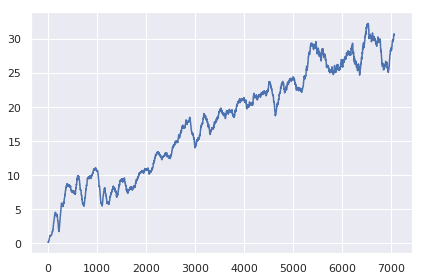

In [6]:
plt.plot(range(len(result)), result)
plt.tight_layout()
plt.show()

In [14]:
from matplotlib import animation

def display_frames_as_gif(frames):
    patch = plt.imshow(frames[0])
    plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
        
    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=5)
    anim.save('./rnd_breakout_result.gif', writer='imagemagick', fps=30)

/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.uint8'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/sungyub/gym/gym/logger.py:30: UserWarning: WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Total Reward : 26.00


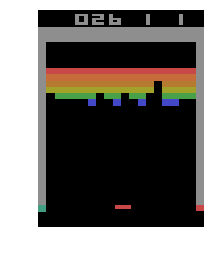

In [15]:
env = wrap(gym.make('BreakoutNoFrameskip-v4'))
s = np.array(env.reset())
total_reward = 0
frames = []
done_counter = 0

for t in range(10000):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    a, v, int_v, l = ppo.choose_action(np.expand_dims(s,axis=0))
    # take action and get next state
    s_, r, done, info = env.step(a)
    s_ = np.array(s_)
    total_reward += r
    if done:
        done_counter += 1
        if done_counter == 5:
            break
    s = s_
env.close()
print('Total Reward : %.2f'%total_reward)
display_frames_as_gif(frames)

![alt text](./rnd_breakout_result.gif "segment")